## setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('../../..')

In [5]:
from copulae.input import generate_copula_net_input


from copulae.training.cflax.mlp import MLP
from copulae.training.cflax.mlp import SingleLogitCopula as SLC

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

from copulae.training import setup_training

In [6]:
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import optax

In [7]:
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
def get_model(type, layer_widths):
  # Positive Bi Logit Copula
  if type == 'pblc':
    model = PBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Logit Copula
  elif type == 'spblc':
    model = SPBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Positive Bi Normal Copula
  elif type == 'pbnc':
    model = PBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Normal Copula
  elif type == 'spbnc':
    model = SPBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Single Logit Copula
  elif type == 'slc':
    model = SLC(
        MLP(layer_widths)
    )

  return model

In [9]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [10]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [11]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [12]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

## New Models

In [13]:
def build_mixture(base_class, n, *args, **kwargs):
    rv = []
    for i in range(n):
        rv.append(base_class(*args, **kwargs))
    return MixtureCopula(rv)

In [14]:
from copulae.training.cflax.mixtures import FrankCopNet
from copulae.training.cflax.mixtures import GaussCopNet
from copulae.training.cflax.mixtures import FGMCopNet
from copulae.training.cflax.mixtures import DoubleIntegral
from copulae.training.cflax.mixtures import MixtureCopula

## plot

In [15]:
plt.rcParams['figure.figsize'] = (8, 5)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 10

In [16]:
plt.style.use('tableau-colorblind10')
plt.ion();

## data

In [17]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [18]:
def negative_log_likelihood(Ŷc_batches, I_pdf):
  copula_density = jnp.clip(Ŷc_batches, 1e-6)
  kde_density = jnp.clip(I_pdf, 1e-6)
  return -(jnp.log(copula_density) + jnp.log(kde_density)).mean()

In [19]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [20]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [21]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [22]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [23]:
np.random.seed(30091985)

In [24]:
key = jax.random.PRNGKey(30091985)

## imshow

In [25]:
from scipy.stats import multivariate_normal

In [26]:
from jax.scipy.stats import gaussian_kde

In [27]:
def concatenate_cdfs(cdf_x, cdf_y):
  #cumulative_x = np.array(cdf_x)
  #cumulative_y = np.array(cdf_y)

  #cumulative_x = np.expand_dims(cumulative_x, axis=0)
  #cumulative_y = np.expand_dims(cumulative_y, axis=0)

  XY_cumulatives = jnp.concatenate((cdf_x, cdf_y), axis=0)
  #XY_cumulatives = jnp.asarray(XY_cumulatives)
  XY_cumulatives = jnp.expand_dims(XY_cumulatives, axis=0)

  return XY_cumulatives

In [28]:
def get_density_graph_data2(data_points):
  LOW = 0
  HIGH = 1
  npts = 800

  side = jnp.linspace(LOW, HIGH, npts)
  xx, yy = jnp.meshgrid(side, side)
  points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  densities = kde_x.evaluate(side)
  cumulatives = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in side])

  density_x, _ = jnp.meshgrid(densities, densities)
  density_x = density_x.reshape(-1, 1)
  cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  densities = kde_y.evaluate(side)
  cumulatives = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in side])

  _, density_y = jnp.meshgrid(densities, densities)
  density_y = density_y.reshape(-1, 1)
  _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y
  del _

  return points, I_pdf, cdf_xy

In [29]:
def make_density_plot(points, joint_density):
  points = points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights=joint_density[0])
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 1, figsize=(5.5 * 3, 5))
  ax = axes

  N = points.shape[1]

  ax.invert_yaxis()
  ax.imshow(joint_density[0].reshape(N, N), origin='lower')
  #ax.imshow(heatmap.T, origin = 'lower')
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  plt.show()

## utils

In [30]:
def L_d(losses, params, state):
  loss = jnp.zeros((1,len(losses)), dtype=jnp.float32)
  for i, (w, loss_func) in enumerate(losses):
    loss = loss.at[0, i].set(w * loss_func(params, state))
  return loss

In [31]:
losses_eval = [
    (1.0, sq_error),
    (1.0, sq_error_partial),
    (1.0, copula_likelihood),

    # (1.0, sq_valid),
    # (1.0, sq_valid_partial),
    # (1.0, sq_valid_density),
    # (1.0, sq_frechet),
]

In [32]:
def plot_yyhat(state, TrainingTensors):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].scatter(state.ŶC_batches[0], TrainingTensors[5][0]);
  # axes[0].set(xlim = (0, 1), ylim = (0, 1), )
  axes[0].set(xlim = (min(0, np.min(state.ŶC_batches[0])), max(1, np.max(cop_state.ŶC_batches[0]))), ylim = (0, 1), )
  axes[1].scatter(state.ŶdC_batches[0][0], TrainingTensors[4][0][0]);
  # axes[1].set(xlim = (0, 1), ylim = (0, 1), )
  axes[1].set(xlim = (min(0, np.min(state.ŶdC_batches[0][0])), max(1, np.max(cop_state.ŶdC_batches[0][0]))), ylim = (0, 1), )
  axes[2].scatter(state.ŶdC_batches[0][1], TrainingTensors[4][0][1]);
  # axes[2].set(xlim = (0, 1), ylim = (0, 1), )
  axes[2].set(xlim = (min(0, np.min(state.ŶdC_batches[0][1])), max(1, np.max(cop_state.ŶdC_batches[0][1]))), ylim = (0, 1), )
  plt.show()

In [33]:
def test_set(D_val, data_points):
  # LOW = 0
  # HIGH = 1
  # npts = 800

  # side = jnp.linspace(LOW, HIGH, npts)
  # xx, yy = jnp.meshgrid(side, side)
  # points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = D_val
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in points[0, 0, :]])

  # density_x, _ = jnp.meshgrid(densities, densities)
  # density_x = density_x.reshape(-1, 1)
  # cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in points[0, 1, :]])

  # _, density_y = jnp.meshgrid(densities, densities)
  # density_y = density_y.reshape(-1, 1)
  # _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  I_pdf = jnp.expand_dims(I_pdf, axis=0)
  # cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)
  cdf_xy = jnp.array((cumulative_x, cumulative_y))
  cdf_xy = jnp.expand_dims(cdf_xy, axis=0)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y

  return points, I_pdf, cdf_xy

In [34]:
def plot_log(log, lim = None):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].plot(np.array(log)[:, 0, 0]);
  axes[1].plot(np.array(log)[:, 0, 1]);
  axes[2].plot(np.array(log)[:, 0, 2]);
  axes[2].set(ylim = lim, )
  plt.show()

In [35]:
def sanity(state, nn_c, params):
  density_graph_points, I_pdf, cdf_xy = get_density_graph_data2(state.X_batches[0])

  copula_density = nn_c(params, cdf_xy)
  points_density = copula_density * I_pdf

  points = density_graph_points[0]
  #heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = points_density[0])
  #logheatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = np.log(jnp.clip(points_density[0], 1e-6)))
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  N = int(np.sqrt(points.shape[1]))
  heatmap = points_density[0].reshape(N,N)
  logheatmap = np.log(jnp.clip(points_density[0], 1e-6)).reshape(N,N)

  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))

  axes[0].scatter(
      cop_state.X_batches[0][0, :],
      cop_state.X_batches[0][1, :],
      s=80,
      edgecolor='k',
      alpha=0.5
  );

  axes[1].invert_yaxis()
  #axes[1].imshow(heatmap.T, origin = 'lower')
  axes[1].imshow(heatmap, origin = 'lower')
  axes[1].get_xaxis().set_ticks([])
  axes[1].get_yaxis().set_ticks([])

  axes[2].invert_yaxis()
  #axes[2].imshow(logheatmap.T, origin = 'lower')
  axes[2].imshow(logheatmap, origin = 'lower')
  axes[2].get_xaxis().set_ticks([])
  axes[2].get_yaxis().set_ticks([])
  plt.show()

In [36]:
import flax.linen as nn

from copulae.typing import Sequence
from copulae.typing import Tensor

class LogitPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        e = jnp.exp(-z)
        return e / (1 + e)

class NormalPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        return jss.norm.pdf(z)

In [37]:
class MixtureLogitPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += LogitPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv


class MixtureNormalPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += NormalPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv

## PARAMS

In [38]:
layer_widths = [128, 64, 32, 16]

losses = [
    (0.01, sq_error),
    (0.5, sq_error_partial),
    (0.1, copula_likelihood),
]

lr = 2e-3

n_iter = 5000

## Train

In [39]:
import pickle
from scipy.stats import bootstrap
from copulae.training.cflax.mixtures import LogitPDFNet
from copulae.training.cflax.mixtures import NormalPDFNet

In [40]:
MODELS_PATH = os.path.join('drive', 'MyDrive', 'copulas', 'models', '2cats_PFrank')
os.makedirs(MODELS_PATH, exist_ok=True)

def get_model():
  return  DoubleIntegral(build_mixture(FrankCopNet, 10))

In [41]:
def run(TrainingTensors, train_D, test_D, key, dataset_name):
  model = get_model()

  nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
      model, TrainingTensors, losses
  )

  key, subkey = jax.random.split(key)
  init_params = model.init(subkey, TrainingTensors.UV_batches[0])
  del subkey

  params = init_params
  optimizer = optax.adam(lr)
  opt_state = optimizer.init(params)

  log = []
  best = 1e6
  for i in tqdm(range(n_iter)):
      grads, cop_state = grad(params, cop_state)
      updates, opt_state = optimizer.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      if i % 10 == 0:
          loss = L_d(losses_eval, params, cop_state)
          if loss[0][-1] < best:
            best_params = params
            best_cop_state = cop_state
            best = loss[0][-1]
          log.append([l for l in loss])
          print('Iter {}. Loss {}'.format(i, loss))


  density_graph_points, I_pdf, cdf_xy = test_set(test_D, best_cop_state.X_batches[0])
  copula_density = nn_c(best_params, cdf_xy)
  points_density = copula_density * I_pdf
  yhat = -np.log(jnp.clip(points_density, 1e-6))
  L_d(losses_eval, best_params, best_cop_state), np.mean(yhat)

  res = bootstrap(yhat, np.mean)

  with open(os.path.join(MODELS_PATH, dataset_name + '.txt'), 'w') as fp:
    fp.write(f'nll: {np.mean(yhat)}\n{res.standard_error}\n{res.confidence_interval}')

  with open(os.path.join(MODELS_PATH, dataset_name + '.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Gauss $\rho=0.1$

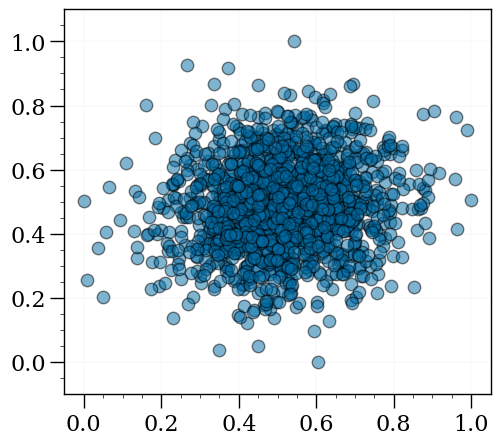

In [42]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [43]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [44]:
run(TrainingTensors, train_D, test_D, key, 'gauss_01')

  0%|          | 1/10000 [06:10<1027:46:00, 370.03s/it]

Iter 0. Loss [[0.07079482 0.19936377 2.8351927 ]]


  0%|          | 11/10000 [12:22<22:59:33,  8.29s/it]

Iter 10. Loss [[0.07082546 0.19807185 2.8018594 ]]


  0%|          | 21/10000 [12:25<1:28:50,  1.87it/s]

Iter 20. Loss [[0.07089239 0.19648772 2.7707064 ]]


  0%|          | 31/10000 [12:27<52:49,  3.15it/s]

Iter 30. Loss [[0.07099275 0.19485267 2.7404966 ]]


  0%|          | 42/10000 [12:30<46:05,  3.60it/s]

Iter 40. Loss [[0.07111885 0.19325724 2.7107832 ]]


  1%|          | 51/10000 [12:32<49:54,  3.32it/s]

Iter 50. Loss [[0.07127141 0.19168074 2.6816316 ]]


  1%|          | 61/10000 [12:35<1:11:03,  2.33it/s]

Iter 60. Loss [[0.07145792 0.19008186 2.6532025 ]]


  1%|          | 71/10000 [12:38<1:01:28,  2.69it/s]

Iter 70. Loss [[0.07167961 0.188467   2.6254208 ]]


  1%|          | 81/10000 [12:40<34:05,  4.85it/s]

Iter 80. Loss [[0.07193439 0.18685164 2.5981705 ]]


  1%|          | 91/10000 [12:42<34:07,  4.84it/s]

Iter 90. Loss [[0.07222406 0.18523206 2.5714395 ]]


  1%|          | 101/10000 [12:45<33:41,  4.90it/s]

Iter 100. Loss [[0.07255144 0.18360318 2.5452266 ]]


  1%|          | 111/10000 [12:47<33:56,  4.85it/s]

Iter 110. Loss [[0.07291701 0.18196818 2.5194998 ]]


  1%|          | 121/10000 [12:51<55:27,  2.97it/s]

Iter 120. Loss [[0.07332122 0.1803291  2.494235  ]]


  1%|▏         | 131/10000 [12:53<34:56,  4.71it/s]

Iter 130. Loss [[0.0737655  0.17868562 2.4694264 ]]


  1%|▏         | 142/10000 [12:56<33:09,  4.96it/s]

Iter 140. Loss [[0.07425071 0.17703865 2.445066  ]]


  2%|▏         | 152/10000 [12:58<33:48,  4.85it/s]

Iter 150. Loss [[0.07477739 0.17538986 2.4211447 ]]


  2%|▏         | 162/10000 [13:01<33:34,  4.88it/s]

Iter 160. Loss [[0.07534608 0.17374027 2.3976595 ]]


  2%|▏         | 171/10000 [13:03<52:32,  3.12it/s]

Iter 170. Loss [[0.07595734 0.1720912  2.3746095 ]]


  2%|▏         | 181/10000 [13:07<40:24,  4.05it/s]

Iter 180. Loss [[0.07661141 0.17044403 2.3519926 ]]


  2%|▏         | 191/10000 [13:09<33:39,  4.86it/s]

Iter 190. Loss [[0.07730843 0.16880018 2.3298094 ]]


  2%|▏         | 201/10000 [13:11<33:03,  4.94it/s]

Iter 200. Loss [[0.0780484  0.16716105 2.3080616 ]]


  2%|▏         | 211/10000 [13:13<33:35,  4.86it/s]

Iter 210. Loss [[0.07883121 0.16552809 2.28675   ]]


  2%|▏         | 221/10000 [13:16<33:37,  4.85it/s]

Iter 220. Loss [[0.07965659 0.16390269 2.2658765 ]]


  2%|▏         | 231/10000 [13:20<55:13,  2.95it/s]

Iter 230. Loss [[0.0805241  0.16228624 2.2454433 ]]


  2%|▏         | 241/10000 [13:22<35:04,  4.64it/s]

Iter 240. Loss [[0.08143324 0.16068012 2.2254524 ]]


  3%|▎         | 251/10000 [13:24<34:12,  4.75it/s]

Iter 250. Loss [[0.08238332 0.15908565 2.205905  ]]


  3%|▎         | 261/10000 [13:27<34:02,  4.77it/s]

Iter 260. Loss [[0.08337355 0.15750411 2.1868026 ]]


  3%|▎         | 271/10000 [13:29<34:12,  4.74it/s]

Iter 270. Loss [[0.08440304 0.15593672 2.1681464 ]]


  3%|▎         | 281/10000 [13:32<53:34,  3.02it/s]

Iter 280. Loss [[0.08547074 0.15438466 2.1499364 ]]


  3%|▎         | 292/10000 [13:36<36:26,  4.44it/s]

Iter 290. Loss [[0.08657555 0.15284903 2.1321735 ]]


  3%|▎         | 302/10000 [13:38<33:08,  4.88it/s]

Iter 300. Loss [[0.08771624 0.15133089 2.114857  ]]


  3%|▎         | 312/10000 [13:40<32:35,  4.95it/s]

Iter 310. Loss [[0.08889148 0.14983122 2.097986  ]]


  3%|▎         | 322/10000 [13:43<32:45,  4.92it/s]

Iter 320. Loss [[0.09009991 0.14835095 2.0815597 ]]


  3%|▎         | 331/10000 [13:45<42:07,  3.83it/s]

Iter 330. Loss [[0.09133999 0.14689095 2.0655756 ]]


  3%|▎         | 341/10000 [13:49<55:48,  2.88it/s]

Iter 340. Loss [[0.09261018 0.14545202 2.0500326 ]]


  4%|▎         | 352/10000 [13:51<33:24,  4.81it/s]

Iter 350. Loss [[0.09390888 0.1440349  2.0349274 ]]


  4%|▎         | 361/10000 [13:53<33:12,  4.84it/s]

Iter 360. Loss [[0.09523429 0.1426403  2.0202575 ]]


  4%|▎         | 371/10000 [13:56<33:19,  4.82it/s]

Iter 370. Loss [[0.09658478 0.14126882 2.0060196 ]]


  4%|▍         | 382/10000 [13:58<33:08,  4.84it/s]

Iter 380. Loss [[0.09795846 0.13992102 1.9922103 ]]


  4%|▍         | 391/10000 [14:02<53:12,  3.01it/s]

Iter 390. Loss [[0.09935348 0.13859746 1.9788253 ]]


  4%|▍         | 402/10000 [14:05<34:26,  4.64it/s]

Iter 400. Loss [[0.10076793 0.13729857 1.9658613 ]]


  4%|▍         | 412/10000 [14:07<32:56,  4.85it/s]

Iter 410. Loss [[0.10219983 0.13602479 1.9533131 ]]


  4%|▍         | 422/10000 [14:09<32:38,  4.89it/s]

Iter 420. Loss [[0.10364722 0.13477652 1.9411769 ]]


  4%|▍         | 432/10000 [14:12<32:47,  4.86it/s]

Iter 430. Loss [[0.105108   0.13355407 1.9294475 ]]


  4%|▍         | 441/10000 [14:14<47:50,  3.33it/s]

Iter 440. Loss [[0.10658017 0.13235776 1.9181203 ]]


  5%|▍         | 452/10000 [14:18<43:27,  3.66it/s]

Iter 450. Loss [[0.10806157 0.13118787 1.9071904 ]]


  5%|▍         | 462/10000 [14:20<32:41,  4.86it/s]

Iter 460. Loss [[0.10955007 0.13004458 1.8966527 ]]


  5%|▍         | 472/10000 [14:23<32:06,  4.95it/s]

Iter 470. Loss [[0.11104352 0.12892815 1.8865016 ]]


  5%|▍         | 481/10000 [14:25<34:14,  4.63it/s]

Iter 480. Loss [[0.11253972 0.12783872 1.8767321 ]]


  5%|▍         | 492/10000 [14:27<33:06,  4.79it/s]

Iter 490. Loss [[0.11403649 0.12677646 1.8673389 ]]


  5%|▌         | 501/10000 [14:31<53:22,  2.97it/s]

Iter 500. Loss [[0.11553154 0.12574147 1.8583164 ]]


  5%|▌         | 511/10000 [14:33<34:27,  4.59it/s]

Iter 510. Loss [[0.11702269 0.1247339  1.8496585 ]]


  5%|▌         | 522/10000 [14:36<32:21,  4.88it/s]

Iter 520. Loss [[0.1185076  0.12375382 1.8413602 ]]


  5%|▌         | 532/10000 [14:38<32:28,  4.86it/s]

Iter 530. Loss [[0.11998406 0.12280129 1.833415  ]]


  5%|▌         | 542/10000 [14:41<32:13,  4.89it/s]

Iter 540. Loss [[0.12144967 0.12187636 1.8258172 ]]


  6%|▌         | 551/10000 [14:43<48:40,  3.24it/s]

Iter 550. Loss [[0.1229022  0.12097912 1.8185605 ]]


  6%|▌         | 562/10000 [14:47<39:19,  4.00it/s]

Iter 560. Loss [[0.12433925 0.12010958 1.811639  ]]


  6%|▌         | 572/10000 [14:49<32:21,  4.85it/s]

Iter 570. Loss [[0.12575865 0.11926778 1.8050454 ]]


  6%|▌         | 582/10000 [14:52<32:35,  4.82it/s]

Iter 580. Loss [[0.12715788 0.11845371 1.798773  ]]


  6%|▌         | 591/10000 [14:54<32:45,  4.79it/s]

Iter 590. Loss [[0.1285347  0.11766741 1.7928154 ]]


  6%|▌         | 601/10000 [14:56<33:41,  4.65it/s]

Iter 600. Loss [[0.1298869  0.11690886 1.7871646 ]]


  6%|▌         | 611/10000 [15:00<52:45,  2.97it/s]

Iter 610. Loss [[0.13121206 0.11617805 1.7818131 ]]


  6%|▌         | 622/10000 [15:02<32:37,  4.79it/s]

Iter 620. Loss [[0.132508   0.11547498 1.7767527 ]]


  6%|▋         | 632/10000 [15:05<31:32,  4.95it/s]

Iter 630. Loss [[0.13377242 0.1147996  1.7719748 ]]


  6%|▋         | 641/10000 [15:07<33:26,  4.66it/s]

Iter 640. Loss [[0.13500315 0.1141519  1.7674707 ]]


  7%|▋         | 651/10000 [15:09<33:45,  4.61it/s]

Iter 650. Loss [[0.13619807 0.11353184 1.7632309 ]]


  7%|▋         | 661/10000 [15:13<1:02:33,  2.49it/s]

Iter 660. Loss [[0.13735503 0.11293935 1.7592456 ]]


  7%|▋         | 671/10000 [15:17<1:00:03,  2.59it/s]

Iter 670. Loss [[0.138472  0.1123744 1.7555043]]


  7%|▋         | 682/10000 [15:20<33:25,  4.65it/s]

Iter 680. Loss [[0.13954706 0.11183687 1.751996  ]]


  7%|▋         | 692/10000 [15:23<31:46,  4.88it/s]

Iter 690. Loss [[0.14057846 0.1113267  1.7487096 ]]


  7%|▋         | 701/10000 [15:25<32:24,  4.78it/s]

Iter 700. Loss [[0.14156437 0.11084377 1.7456328 ]]


  7%|▋         | 712/10000 [15:27<32:49,  4.72it/s]

Iter 710. Loss [[0.14250323 0.11038792 1.7427533 ]]


  7%|▋         | 721/10000 [15:30<51:37,  3.00it/s]

Iter 720. Loss [[0.14339375 0.10995896 1.7400581 ]]


  7%|▋         | 732/10000 [15:34<35:56,  4.30it/s]

Iter 730. Loss [[0.14423482 0.10955663 1.737534  ]]


  7%|▋         | 741/10000 [15:36<33:37,  4.59it/s]

Iter 740. Loss [[0.14502576 0.10918056 1.735168  ]]


  8%|▊         | 751/10000 [15:38<32:55,  4.68it/s]

Iter 750. Loss [[0.14576627 0.10883032 1.7329458 ]]


  8%|▊         | 762/10000 [15:41<32:25,  4.75it/s]

Iter 760. Loss [[0.14645666 0.10850523 1.7308546 ]]


  8%|▊         | 771/10000 [15:43<35:03,  4.39it/s]

Iter 770. Loss [[0.14709803 0.1082044  1.7288816 ]]


  8%|▊         | 781/10000 [15:47<53:55,  2.85it/s]

Iter 780. Loss [[0.1476924  0.10792673 1.7270153 ]]


  8%|▊         | 792/10000 [15:49<32:40,  4.70it/s]

Iter 790. Loss [[0.14824241 0.10767083 1.7252451 ]]


  8%|▊         | 802/10000 [15:52<31:46,  4.83it/s]

Iter 800. Loss [[0.14875156 0.10743504 1.7235621 ]]


  8%|▊         | 812/10000 [15:54<32:13,  4.75it/s]

Iter 810. Loss [[0.14922397 0.10721755 1.7219598 ]]


  8%|▊         | 822/10000 [15:56<32:01,  4.78it/s]

Iter 820. Loss [[0.14966413 0.10701641 1.7204328 ]]


  8%|▊         | 831/10000 [15:59<53:08,  2.88it/s]

Iter 830. Loss [[0.1500762 0.1068297 1.718977 ]]


  8%|▊         | 842/10000 [16:03<34:09,  4.47it/s]

Iter 840. Loss [[0.15046407 0.10665568 1.71759   ]]


  9%|▊         | 852/10000 [16:05<32:31,  4.69it/s]

Iter 850. Loss [[0.15083109 0.10649271 1.7162689 ]]


  9%|▊         | 862/10000 [16:07<31:45,  4.80it/s]

Iter 860. Loss [[0.15117997 0.10633954 1.7150118 ]]


  9%|▊         | 871/10000 [16:09<33:06,  4.60it/s]

Iter 870. Loss [[0.1515126  0.10619505 1.7138164 ]]


  9%|▉         | 881/10000 [16:12<42:49,  3.55it/s]

Iter 880. Loss [[0.15183039 0.10605842 1.71268   ]]


  9%|▉         | 891/10000 [16:16<53:14,  2.85it/s]

Iter 890. Loss [[0.15213427 0.10592899 1.7116    ]]


  9%|▉         | 902/10000 [16:18<32:41,  4.64it/s]

Iter 900. Loss [[0.15242486 0.10580628 1.7105736 ]]


  9%|▉         | 911/10000 [16:20<33:08,  4.57it/s]

Iter 910. Loss [[0.15270275 0.10568982 1.7095983 ]]


  9%|▉         | 921/10000 [16:23<32:15,  4.69it/s]

Iter 920. Loss [[0.15296817 0.1055793  1.7086716 ]]


  9%|▉         | 931/10000 [16:25<32:39,  4.63it/s]

Iter 930. Loss [[0.15322152 0.10547441 1.7077906 ]]


  9%|▉         | 941/10000 [16:28<51:47,  2.92it/s]

Iter 940. Loss [[0.15346317 0.1053749  1.7069536 ]]


 10%|▉         | 952/10000 [16:32<33:43,  4.47it/s]

Iter 950. Loss [[0.15369332 0.10528049 1.7061578 ]]


 10%|▉         | 961/10000 [16:34<32:15,  4.67it/s]

Iter 960. Loss [[0.15391235 0.10519095 1.7054017 ]]


 10%|▉         | 971/10000 [16:36<33:12,  4.53it/s]

Iter 970. Loss [[0.15412074 0.10510605 1.7046831 ]]


 10%|▉         | 981/10000 [16:38<33:14,  4.52it/s]

Iter 980. Loss [[0.1543187  0.10502556 1.7040004 ]]


 10%|▉         | 991/10000 [16:41<45:55,  3.27it/s]

Iter 990. Loss [[0.15450673 0.10494931 1.7033513 ]]


 10%|█         | 1002/10000 [16:45<41:27,  3.62it/s]

Iter 1000. Loss [[0.15468508 0.10487705 1.7027348 ]]


 10%|█         | 1012/10000 [16:47<32:12,  4.65it/s]

Iter 1010. Loss [[0.15485415 0.10480865 1.7021493 ]]


 10%|█         | 1021/10000 [16:49<33:28,  4.47it/s]

Iter 1020. Loss [[0.15501444 0.10474391 1.7015934 ]]


 10%|█         | 1031/10000 [16:52<32:25,  4.61it/s]

Iter 1030. Loss [[0.1551662  0.10468264 1.7010651 ]]


 10%|█         | 1042/10000 [16:54<31:42,  4.71it/s]

Iter 1040. Loss [[0.15530978 0.10462465 1.7005638 ]]


 11%|█         | 1051/10000 [16:57<51:20,  2.90it/s]

Iter 1050. Loss [[0.15544575 0.10456982 1.7000881 ]]


 11%|█         | 1061/10000 [17:00<35:16,  4.22it/s]

Iter 1060. Loss [[0.15557419 0.104518   1.6996367 ]]


 11%|█         | 1072/10000 [17:03<30:46,  4.83it/s]

Iter 1070. Loss [[0.15569559 0.10446902 1.6992086 ]]


 11%|█         | 1082/10000 [17:05<31:32,  4.71it/s]

Iter 1080. Loss [[0.15581024 0.10442274 1.6988028 ]]


 11%|█         | 1091/10000 [17:07<32:02,  4.63it/s]

Iter 1090. Loss [[0.15591854 0.10437903 1.6984179 ]]


 11%|█         | 1101/10000 [17:10<46:50,  3.17it/s]

Iter 1100. Loss [[0.15602084 0.10433777 1.6980534 ]]


 11%|█         | 1111/10000 [17:13<43:23,  3.41it/s]

Iter 1110. Loss [[0.15611722 0.10429881 1.697708  ]]


 11%|█         | 1121/10000 [17:16<33:16,  4.45it/s]

Iter 1120. Loss [[0.15620811 0.10426205 1.6973809 ]]


 11%|█▏        | 1132/10000 [17:18<31:23,  4.71it/s]

Iter 1130. Loss [[0.15629384 0.10422737 1.6970711 ]]


 11%|█▏        | 1142/10000 [17:21<31:02,  4.76it/s]

Iter 1140. Loss [[0.15637459 0.10419469 1.6967779 ]]


 12%|█▏        | 1152/10000 [17:23<31:17,  4.71it/s]

Iter 1150. Loss [[0.15645069 0.10416387 1.696501  ]]


 12%|█▏        | 1161/10000 [17:26<51:49,  2.84it/s]

Iter 1160. Loss [[0.1565223  0.10413483 1.6962389 ]]


 12%|█▏        | 1171/10000 [17:29<35:45,  4.12it/s]

Iter 1170. Loss [[0.15658975 0.10410747 1.6959914 ]]


 12%|█▏        | 1182/10000 [17:32<31:43,  4.63it/s]

Iter 1180. Loss [[0.15665317 0.10408173 1.6957573 ]]


 12%|█▏        | 1192/10000 [17:34<31:12,  4.70it/s]

Iter 1190. Loss [[0.15671276 0.10405748 1.6955365 ]]


 12%|█▏        | 1202/10000 [17:36<31:29,  4.66it/s]

Iter 1200. Loss [[0.15676884 0.10403467 1.6953276 ]]


 12%|█▏        | 1211/10000 [17:39<48:27,  3.02it/s]

Iter 1210. Loss [[0.1568216  0.10401319 1.6951311 ]]


 12%|█▏        | 1222/10000 [17:43<35:51,  4.08it/s]

Iter 1220. Loss [[0.15687114 0.103993   1.6949453 ]]


 12%|█▏        | 1232/10000 [17:45<31:19,  4.67it/s]

Iter 1230. Loss [[0.15691762 0.10397405 1.6947705 ]]


 12%|█▏        | 1242/10000 [17:47<31:08,  4.69it/s]

Iter 1240. Loss [[0.15696134 0.10395619 1.6946056 ]]


 13%|█▎        | 1251/10000 [17:50<32:33,  4.48it/s]

Iter 1250. Loss [[0.15700233 0.10393945 1.6944501 ]]


 13%|█▎        | 1261/10000 [17:52<37:52,  3.85it/s]

Iter 1260. Loss [[0.15704076 0.10392375 1.694304  ]]


 13%|█▎        | 1271/10000 [17:56<51:19,  2.83it/s]

Iter 1270. Loss [[0.15707693 0.10390896 1.6941663 ]]


 13%|█▎        | 1282/10000 [17:59<32:28,  4.47it/s]

Iter 1280. Loss [[0.15711068 0.10389512 1.6940371 ]]


 13%|█▎        | 1291/10000 [18:01<32:40,  4.44it/s]

Iter 1290. Loss [[0.15714242 0.10388214 1.6939154 ]]


 13%|█▎        | 1301/10000 [18:03<34:41,  4.18it/s]

Iter 1300. Loss [[0.15717214 0.10386995 1.6938009 ]]


 13%|█▎        | 1312/10000 [18:06<31:58,  4.53it/s]

Iter 1310. Loss [[0.15719995 0.10385853 1.6936936 ]]


 13%|█▎        | 1321/10000 [18:09<59:19,  2.44it/s]

Iter 1320. Loss [[0.15722604 0.10384784 1.6935929 ]]


 13%|█▎        | 1331/10000 [18:14<1:02:14,  2.32it/s]

Iter 1330. Loss [[0.15725039 0.10383783 1.6934984 ]]


 13%|█▎        | 1342/10000 [18:16<32:41,  4.41it/s]

Iter 1340. Loss [[0.15727323 0.10382847 1.6934094 ]]


 14%|█▎        | 1352/10000 [18:19<33:00,  4.37it/s]

Iter 1350. Loss [[0.15729453 0.10381968 1.6933266 ]]


 14%|█▎        | 1361/10000 [18:21<32:12,  4.47it/s]

Iter 1360. Loss [[0.15731452 0.10381147 1.6932486 ]]


 14%|█▎        | 1371/10000 [18:23<34:25,  4.18it/s]

Iter 1370. Loss [[0.15733318 0.10380379 1.6931758 ]]


 14%|█▍        | 1381/10000 [18:26<53:49,  2.67it/s]

Iter 1380. Loss [[0.15735058 0.10379663 1.6931074 ]]


 14%|█▍        | 1391/10000 [18:30<39:20,  3.65it/s]

Iter 1390. Loss [[0.15736692 0.10378992 1.6930437 ]]


 14%|█▍        | 1401/10000 [18:32<34:42,  4.13it/s]

Iter 1400. Loss [[0.15738212 0.10378367 1.692984  ]]


 14%|█▍        | 1411/10000 [18:34<34:17,  4.17it/s]

Iter 1410. Loss [[0.15739627 0.10377783 1.6929281 ]]


 14%|█▍        | 1422/10000 [18:37<32:57,  4.34it/s]

Iter 1420. Loss [[0.15740956 0.10377238 1.692876  ]]


 14%|█▍        | 1431/10000 [18:39<47:28,  3.01it/s]

Iter 1430. Loss [[0.15742192 0.10376729 1.6928275 ]]


 14%|█▍        | 1441/10000 [18:43<47:35,  3.00it/s]

Iter 1440. Loss [[0.15743342 0.10376257 1.692782  ]]


 15%|█▍        | 1451/10000 [18:45<35:06,  4.06it/s]

Iter 1450. Loss [[0.15744416 0.10375816 1.6927397 ]]


 15%|█▍        | 1461/10000 [18:48<34:31,  4.12it/s]

Iter 1460. Loss [[0.15745418 0.10375403 1.6927004 ]]


 15%|█▍        | 1472/10000 [18:50<33:08,  4.29it/s]

Iter 1470. Loss [[0.15746346 0.1037502  1.6926637 ]]


 15%|█▍        | 1482/10000 [18:53<33:07,  4.29it/s]

Iter 1480. Loss [[0.15747221 0.10374663 1.6926296 ]]


 15%|█▍        | 1491/10000 [18:56<54:32,  2.60it/s]

Iter 1490. Loss [[0.15748034 0.10374331 1.6925976 ]]


 15%|█▌        | 1502/10000 [18:59<35:38,  3.97it/s]

Iter 1500. Loss [[0.15748787 0.10374023 1.6925681 ]]


 15%|█▌        | 1511/10000 [19:01<38:13,  3.70it/s]

Iter 1510. Loss [[0.1574948  0.10373736 1.6925406 ]]


 15%|█▌        | 1521/10000 [19:04<36:04,  3.92it/s]

Iter 1520. Loss [[0.15750135 0.10373469 1.6925151 ]]


 15%|█▌        | 1531/10000 [19:06<36:17,  3.89it/s]

Iter 1530. Loss [[0.15750739 0.10373222 1.6924914 ]]


 15%|█▌        | 1541/10000 [19:09<52:43,  2.67it/s]

Iter 1540. Loss [[0.15751304 0.10372993 1.6924694 ]]


 16%|█▌        | 1552/10000 [19:13<36:42,  3.84it/s]

Iter 1550. Loss [[0.15751824 0.1037278  1.6924489 ]]


 16%|█▌        | 1562/10000 [19:15<32:23,  4.34it/s]

Iter 1560. Loss [[0.15752311 0.10372581 1.69243   ]]


 16%|█▌        | 1572/10000 [19:17<32:31,  4.32it/s]

Iter 1570. Loss [[0.15752767 0.10372398 1.6924127 ]]


 16%|█▌        | 1581/10000 [19:20<33:56,  4.13it/s]

Iter 1580. Loss [[0.15753181 0.10372229 1.6923963 ]]


 16%|█▌        | 1591/10000 [19:22<46:36,  3.01it/s]

Iter 1590. Loss [[0.1575357  0.10372072 1.6923811 ]]


 16%|█▌        | 1601/10000 [19:26<49:38,  2.82it/s]

Iter 1600. Loss [[0.15753934 0.10371926 1.6923676 ]]


 16%|█▌        | 1612/10000 [19:29<32:32,  4.30it/s]

Iter 1610. Loss [[0.1575426  0.10371792 1.6923548 ]]


 16%|█▌        | 1621/10000 [19:31<33:25,  4.18it/s]

Iter 1620. Loss [[0.15754576 0.10371666 1.6923428 ]]


 16%|█▋        | 1631/10000 [19:33<33:49,  4.12it/s]

Iter 1630. Loss [[0.15754862 0.10371552 1.692332  ]]


 16%|█▋        | 1642/10000 [19:36<31:46,  4.38it/s]

Iter 1640. Loss [[0.15755127 0.10371444 1.6923219 ]]


 17%|█▋        | 1651/10000 [19:39<54:44,  2.54it/s]

Iter 1650. Loss [[0.15755375 0.10371348 1.6923125 ]]


 17%|█▋        | 1661/10000 [19:42<35:34,  3.91it/s]

Iter 1660. Loss [[0.15755601 0.10371257 1.692304  ]]


 17%|█▋        | 1672/10000 [19:45<33:01,  4.20it/s]

Iter 1670. Loss [[0.15755817 0.10371171 1.6922961 ]]


 17%|█▋        | 1681/10000 [19:47<34:53,  3.97it/s]

Iter 1680. Loss [[0.15756008 0.10371093 1.692289  ]]


 17%|█▋        | 1692/10000 [19:49<31:40,  4.37it/s]

Iter 1690. Loss [[0.15756193 0.10371023 1.6922822 ]]


 17%|█▋        | 1701/10000 [19:52<51:43,  2.67it/s]

Iter 1700. Loss [[0.15756358 0.10370957 1.6922764 ]]


 17%|█▋        | 1712/10000 [19:56<37:16,  3.71it/s]

Iter 1710. Loss [[0.15756516 0.10370895 1.6922705 ]]


 17%|█▋        | 1722/10000 [19:58<32:21,  4.26it/s]

Iter 1720. Loss [[0.15756662 0.10370842 1.6922653 ]]


 17%|█▋        | 1731/10000 [20:00<34:29,  4.00it/s]

Iter 1730. Loss [[0.15756784 0.10370789 1.6922607 ]]


 17%|█▋        | 1742/10000 [20:03<32:31,  4.23it/s]

Iter 1740. Loss [[0.15756914 0.10370742 1.6922563 ]]


 18%|█▊        | 1751/10000 [20:05<41:00,  3.35it/s]

Iter 1750. Loss [[0.15757026 0.10370697 1.6922524 ]]


 18%|█▊        | 1761/10000 [20:09<53:12,  2.58it/s]

Iter 1760. Loss [[0.15757132 0.10370658 1.6922488 ]]


 18%|█▊        | 1772/10000 [20:11<32:39,  4.20it/s]

Iter 1770. Loss [[0.15757225 0.10370622 1.6922455 ]]


 18%|█▊        | 1782/10000 [20:14<34:03,  4.02it/s]

Iter 1780. Loss [[0.15757316 0.10370587 1.6922424 ]]


 18%|█▊        | 1791/10000 [20:16<34:44,  3.94it/s]

Iter 1790. Loss [[0.15757395 0.10370558 1.6922395 ]]


 18%|█▊        | 1801/10000 [20:18<35:15,  3.88it/s]

Iter 1800. Loss [[0.15757468 0.10370528 1.692237  ]]


 18%|█▊        | 1811/10000 [20:21<51:15,  2.66it/s]

Iter 1810. Loss [[0.1575754  0.10370502 1.6922349 ]]


 18%|█▊        | 1822/10000 [20:25<36:51,  3.70it/s]

Iter 1820. Loss [[0.15757602 0.10370478 1.6922326 ]]


 18%|█▊        | 1831/10000 [20:27<34:29,  3.95it/s]

Iter 1830. Loss [[0.15757668 0.10370456 1.6922308 ]]


 18%|█▊        | 1841/10000 [20:29<34:29,  3.94it/s]

Iter 1840. Loss [[0.15757716 0.10370436 1.6922288 ]]


 19%|█▊        | 1852/10000 [20:32<31:51,  4.26it/s]

Iter 1850. Loss [[0.15757772 0.10370418 1.6922275 ]]


 19%|█▊        | 1861/10000 [20:34<43:02,  3.15it/s]

Iter 1860. Loss [[0.15757823 0.10370399 1.692226  ]]


 19%|█▊        | 1871/10000 [20:38<53:21,  2.54it/s]

Iter 1870. Loss [[0.15757869 0.10370383 1.6922246 ]]


 19%|█▉        | 1882/10000 [20:40<31:52,  4.24it/s]

Iter 1880. Loss [[0.15757911 0.10370369 1.6922237 ]]


 19%|█▉        | 1892/10000 [20:43<33:26,  4.04it/s]

Iter 1890. Loss [[0.15757939 0.10370357 1.6922225 ]]


 19%|█▉        | 1902/10000 [20:45<33:33,  4.02it/s]

Iter 1900. Loss [[0.15757978 0.10370345 1.6922216 ]]


 19%|█▉        | 1911/10000 [20:47<36:48,  3.66it/s]

Iter 1910. Loss [[0.1575801  0.10370333 1.6922207 ]]


 19%|█▉        | 1921/10000 [20:50<51:45,  2.60it/s]

Iter 1920. Loss [[0.15758035 0.10370325 1.6922197 ]]


 19%|█▉        | 1932/10000 [20:53<34:18,  3.92it/s]

Iter 1930. Loss [[0.15758055 0.10370316 1.692219  ]]


 19%|█▉        | 1942/10000 [20:56<31:25,  4.27it/s]

Iter 1940. Loss [[0.15758082 0.10370307 1.6922185 ]]


 20%|█▉        | 1951/10000 [20:58<33:40,  3.98it/s]

Iter 1950. Loss [[0.15758105 0.103703   1.6922177 ]]


 20%|█▉        | 1962/10000 [21:00<33:54,  3.95it/s]

Iter 1960. Loss [[0.1575812  0.10370294 1.6922172 ]]


 20%|█▉        | 1971/10000 [21:03<53:28,  2.50it/s]

Iter 1970. Loss [[0.15758143 0.10370288 1.692217  ]]


 20%|█▉        | 1981/10000 [21:08<1:06:22,  2.01it/s]

Iter 1980. Loss [[0.15758164 0.10370282 1.6922164 ]]


 20%|█▉        | 1992/10000 [21:11<34:18,  3.89it/s]

Iter 1990. Loss [[0.15758178 0.10370276 1.6922162 ]]


 20%|██        | 2002/10000 [21:13<33:00,  4.04it/s]

Iter 2000. Loss [[0.15758194 0.10370269 1.6922158 ]]


 20%|██        | 2012/10000 [21:16<33:15,  4.00it/s]

Iter 2010. Loss [[0.15758213 0.10370266 1.6922154 ]]


 20%|██        | 2021/10000 [21:18<36:27,  3.65it/s]

Iter 2020. Loss [[0.15758224 0.10370261 1.692215  ]]


 20%|██        | 2031/10000 [21:20<44:45,  2.97it/s]

Iter 2030. Loss [[0.15758237 0.10370257 1.692215  ]]


 20%|██        | 2041/10000 [21:24<47:26,  2.80it/s]

Iter 2040. Loss [[0.15758254 0.10370252 1.6922146 ]]


 21%|██        | 2052/10000 [21:27<31:43,  4.17it/s]

Iter 2050. Loss [[0.15758261 0.1037025  1.6922145 ]]


 21%|██        | 2062/10000 [21:29<33:20,  3.97it/s]

Iter 2060. Loss [[0.15758276 0.10370249 1.6922144 ]]


 21%|██        | 2071/10000 [21:31<35:58,  3.67it/s]

Iter 2070. Loss [[0.1575828  0.10370246 1.6922141 ]]


 21%|██        | 2082/10000 [21:34<33:16,  3.97it/s]

Iter 2080. Loss [[0.15758286 0.10370243 1.692214  ]]


 21%|██        | 2091/10000 [21:37<55:24,  2.38it/s]

Iter 2090. Loss [[0.15758298 0.10370241 1.6922139 ]]


 21%|██        | 2102/10000 [21:40<32:53,  4.00it/s]

Iter 2100. Loss [[0.15758298 0.10370239 1.6922139 ]]


 21%|██        | 2112/10000 [21:43<31:01,  4.24it/s]

Iter 2110. Loss [[0.15758301 0.10370239 1.6922137 ]]


 21%|██        | 2121/10000 [21:45<35:28,  3.70it/s]

Iter 2120. Loss [[0.15758309 0.10370237 1.6922135 ]]


 21%|██▏       | 2132/10000 [21:47<31:21,  4.18it/s]

Iter 2130. Loss [[0.15758315 0.10370235 1.6922135 ]]


 21%|██▏       | 2141/10000 [21:50<47:41,  2.75it/s]

Iter 2140. Loss [[0.15758319 0.10370235 1.6922135 ]]


 22%|██▏       | 2152/10000 [21:53<38:42,  3.38it/s]

Iter 2150. Loss [[0.15758319 0.10370235 1.6922132 ]]


 22%|██▏       | 2161/10000 [21:56<32:49,  3.98it/s]

Iter 2160. Loss [[0.15758327 0.10370233 1.6922132 ]]


 22%|██▏       | 2171/10000 [21:58<33:08,  3.94it/s]

Iter 2170. Loss [[0.15758333 0.10370231 1.6922134 ]]


 22%|██▏       | 2182/10000 [22:01<33:13,  3.92it/s]

Iter 2180. Loss [[0.15758336 0.10370231 1.6922132 ]]


 22%|██▏       | 2191/10000 [22:03<38:07,  3.41it/s]

Iter 2190. Loss [[0.15758339 0.10370231 1.6922132 ]]


 22%|██▏       | 2201/10000 [22:06<54:38,  2.38it/s]

Iter 2200. Loss [[0.15758342 0.10370229 1.6922132 ]]


 22%|██▏       | 2212/10000 [22:09<33:39,  3.86it/s]

Iter 2210. Loss [[0.15758339 0.10370229 1.6922132 ]]


 22%|██▏       | 2222/10000 [22:12<32:55,  3.94it/s]

Iter 2220. Loss [[0.15758349 0.10370227 1.6922132 ]]


 22%|██▏       | 2232/10000 [22:14<32:55,  3.93it/s]

Iter 2230. Loss [[0.15758346 0.10370227 1.6922132 ]]


 22%|██▏       | 2242/10000 [22:16<32:48,  3.94it/s]

Iter 2240. Loss [[0.15758345 0.10370227 1.692213  ]]


 23%|██▎       | 2251/10000 [22:19<53:03,  2.43it/s]

Iter 2250. Loss [[0.15758345 0.10370227 1.692213  ]]


 23%|██▎       | 2262/10000 [22:23<35:29,  3.63it/s]

Iter 2260. Loss [[0.15758349 0.10370227 1.692213  ]]


 23%|██▎       | 2272/10000 [22:25<32:21,  3.98it/s]

Iter 2270. Loss [[0.15758355 0.10370226 1.692213  ]]


 23%|██▎       | 2282/10000 [22:27<35:23,  3.63it/s]

Iter 2280. Loss [[0.1575836  0.10370225 1.692213  ]]


 23%|██▎       | 2292/10000 [22:30<35:42,  3.60it/s]

Iter 2290. Loss [[0.1575836  0.10370224 1.692213  ]]


 23%|██▎       | 2301/10000 [22:32<47:23,  2.71it/s]

Iter 2300. Loss [[0.1575836  0.10370224 1.6922132 ]]


 23%|██▎       | 2311/10000 [22:36<53:17,  2.40it/s]

Iter 2310. Loss [[0.1575836  0.10370225 1.6922128 ]]


 23%|██▎       | 2322/10000 [22:38<32:05,  3.99it/s]

Iter 2320. Loss [[0.1575836  0.10370223 1.692213  ]]


 23%|██▎       | 2332/10000 [22:41<32:13,  3.97it/s]

Iter 2330. Loss [[0.1575836  0.10370224 1.6922128 ]]


 23%|██▎       | 2342/10000 [22:43<31:58,  3.99it/s]

Iter 2340. Loss [[0.1575836  0.10370225 1.6922128 ]]


 24%|██▎       | 2351/10000 [22:45<38:11,  3.34it/s]

Iter 2350. Loss [[0.1575836  0.10370224 1.6922128 ]]


 24%|██▎       | 2361/10000 [22:48<57:41,  2.21it/s]

Iter 2360. Loss [[0.15758374 0.10370222 1.6922128 ]]


 24%|██▎       | 2372/10000 [22:52<37:13,  3.41it/s]

Iter 2370. Loss [[0.15758374 0.10370221 1.6922132 ]]


 24%|██▍       | 2382/10000 [22:54<34:49,  3.65it/s]

Iter 2380. Loss [[0.15758374 0.10370221 1.6922132 ]]


 24%|██▍       | 2392/10000 [22:56<34:39,  3.66it/s]

Iter 2390. Loss [[0.15758374 0.10370221 1.6922132 ]]


 24%|██▍       | 2402/10000 [22:59<34:08,  3.71it/s]

Iter 2400. Loss [[0.15758374 0.10370221 1.692213  ]]


 24%|██▍       | 2411/10000 [23:01<48:56,  2.58it/s]

Iter 2410. Loss [[0.15758374 0.10370222 1.692213  ]]


 24%|██▍       | 2422/10000 [23:05<46:14,  2.73it/s]

Iter 2420. Loss [[0.15758374 0.10370222 1.692213  ]]


 24%|██▍       | 2431/10000 [23:07<26:27,  4.77it/s]

Iter 2430. Loss [[0.15758376 0.10370221 1.6922132 ]]


 24%|██▍       | 2441/10000 [23:09<38:40,  3.26it/s]

Iter 2440. Loss [[0.15758376 0.10370221 1.6922132 ]]


 25%|██▍       | 2451/10000 [23:11<25:31,  4.93it/s]

Iter 2450. Loss [[0.15758376 0.10370221 1.692213  ]]


 25%|██▍       | 2462/10000 [23:14<34:41,  3.62it/s]

Iter 2460. Loss [[0.15758374 0.10370221 1.6922132 ]]


 25%|██▍       | 2471/10000 [23:17<56:53,  2.21it/s]

Iter 2470. Loss [[0.15758374 0.10370221 1.6922132 ]]


 25%|██▍       | 2481/10000 [23:20<28:24,  4.41it/s]

Iter 2480. Loss [[0.15758374 0.10370221 1.6922128 ]]


 25%|██▍       | 2491/10000 [23:22<25:56,  4.82it/s]

Iter 2490. Loss [[0.15758374 0.10370221 1.6922128 ]]


 25%|██▌       | 2501/10000 [23:25<26:07,  4.78it/s]

Iter 2500. Loss [[0.15758374 0.10370222 1.692213  ]]


 25%|██▌       | 2511/10000 [23:27<26:34,  4.70it/s]

Iter 2510. Loss [[0.15758374 0.10370222 1.6922128 ]]


 25%|██▌       | 2521/10000 [23:30<34:52,  3.57it/s]

Iter 2520. Loss [[0.15758371 0.10370223 1.6922128 ]]


 25%|██▌       | 2531/10000 [23:33<40:47,  3.05it/s]

Iter 2530. Loss [[0.15758379 0.10370221 1.6922132 ]]


 25%|██▌       | 2541/10000 [23:36<26:42,  4.66it/s]

Iter 2540. Loss [[0.15758379 0.10370221 1.692213  ]]


 26%|██▌       | 2551/10000 [23:38<25:50,  4.80it/s]

Iter 2550. Loss [[0.15758379 0.10370221 1.6922132 ]]


 26%|██▌       | 2561/10000 [23:40<25:13,  4.91it/s]

Iter 2560. Loss [[0.15758379 0.10370221 1.692213  ]]


 26%|██▌       | 2571/10000 [23:43<25:56,  4.77it/s]

Iter 2570. Loss [[0.15758379 0.10370221 1.6922132 ]]


 26%|██▌       | 2581/10000 [23:46<41:12,  3.00it/s]

Iter 2580. Loss [[0.15758376 0.10370221 1.692213  ]]


 26%|██▌       | 2591/10000 [23:49<27:22,  4.51it/s]

Iter 2590. Loss [[0.15758379 0.10370221 1.692213  ]]


 26%|██▌       | 2601/10000 [23:51<25:17,  4.87it/s]

Iter 2600. Loss [[0.15758376 0.10370221 1.692213  ]]


 26%|██▌       | 2612/10000 [23:54<25:07,  4.90it/s]

Iter 2610. Loss [[0.15758376 0.10370221 1.692213  ]]


 26%|██▌       | 2621/10000 [23:57<42:13,  2.91it/s]

Iter 2620. Loss [[0.15758379 0.10370221 1.6922132 ]]


 26%|██▋       | 2631/10000 [24:01<42:34,  2.88it/s]

Iter 2630. Loss [[0.15758379 0.10370221 1.6922132 ]]


 26%|██▋       | 2641/10000 [24:04<26:17,  4.66it/s]

Iter 2640. Loss [[0.15758379 0.10370221 1.6922132 ]]


 27%|██▋       | 2651/10000 [24:06<24:59,  4.90it/s]

Iter 2650. Loss [[0.15758379 0.10370221 1.6922132 ]]


 27%|██▋       | 2661/10000 [24:09<25:44,  4.75it/s]

Iter 2660. Loss [[0.15758379 0.10370221 1.692213  ]]


 27%|██▋       | 2672/10000 [24:11<24:25,  5.00it/s]

Iter 2670. Loss [[0.15758376 0.10370221 1.692213  ]]


 27%|██▋       | 2681/10000 [24:14<37:18,  3.27it/s]

Iter 2680. Loss [[0.15758376 0.10370221 1.692213  ]]


 27%|██▋       | 2691/10000 [24:17<33:45,  3.61it/s]

Iter 2690. Loss [[0.15758376 0.10370221 1.692213  ]]


 27%|██▋       | 2701/10000 [24:20<25:54,  4.69it/s]

Iter 2700. Loss [[0.15758383 0.10370221 1.692213  ]]


 27%|██▋       | 2712/10000 [24:22<25:05,  4.84it/s]

Iter 2710. Loss [[0.15758383 0.10370219 1.692213  ]]


 27%|██▋       | 2722/10000 [24:25<24:30,  4.95it/s]

Iter 2720. Loss [[0.15758379 0.10370221 1.692213  ]]


 27%|██▋       | 2731/10000 [24:27<25:09,  4.81it/s]

Iter 2730. Loss [[0.15758379 0.10370221 1.6922132 ]]


 27%|██▋       | 2741/10000 [24:30<40:12,  3.01it/s]

Iter 2740. Loss [[0.15758379 0.10370221 1.6922132 ]]


 28%|██▊       | 2752/10000 [24:33<25:46,  4.69it/s]

Iter 2750. Loss [[0.15758383 0.10370221 1.6922132 ]]


 28%|██▊       | 2761/10000 [24:35<24:49,  4.86it/s]

Iter 2760. Loss [[0.15758379 0.10370221 1.692213  ]]


 28%|██▊       | 2772/10000 [24:38<25:05,  4.80it/s]

Iter 2770. Loss [[0.15758376 0.10370221 1.692213  ]]


 28%|██▊       | 2782/10000 [24:40<24:41,  4.87it/s]

Iter 2780. Loss [[0.15758379 0.10370221 1.692213  ]]


 28%|██▊       | 2791/10000 [24:43<38:42,  3.10it/s]

Iter 2790. Loss [[0.15758379 0.10370221 1.6922132 ]]


 28%|██▊       | 2802/10000 [24:47<28:22,  4.23it/s]

Iter 2800. Loss [[0.15758379 0.10370221 1.692213  ]]


 28%|██▊       | 2812/10000 [24:49<24:41,  4.85it/s]

Iter 2810. Loss [[0.15758379 0.10370221 1.6922132 ]]


 28%|██▊       | 2822/10000 [24:51<24:44,  4.84it/s]

Iter 2820. Loss [[0.15758379 0.10370221 1.6922132 ]]


 28%|██▊       | 2832/10000 [24:54<24:33,  4.86it/s]

Iter 2830. Loss [[0.15758379 0.10370221 1.692213  ]]


 28%|██▊       | 2841/10000 [24:56<24:51,  4.80it/s]

Iter 2840. Loss [[0.15758379 0.10370221 1.692213  ]]


 29%|██▊       | 2851/10000 [25:00<41:37,  2.86it/s]

Iter 2850. Loss [[0.15758376 0.10370222 1.692213  ]]


 29%|██▊       | 2862/10000 [25:02<24:57,  4.77it/s]

Iter 2860. Loss [[0.15758379 0.10370221 1.692213  ]]


 29%|██▊       | 2871/10000 [25:04<24:42,  4.81it/s]

Iter 2870. Loss [[0.15758383 0.10370221 1.692213  ]]


 29%|██▉       | 2882/10000 [25:07<24:17,  4.88it/s]

Iter 2880. Loss [[0.15758383 0.10370221 1.692213  ]]


 29%|██▉       | 2892/10000 [25:09<25:09,  4.71it/s]

Iter 2890. Loss [[0.15758383 0.10370221 1.6922132 ]]


 29%|██▉       | 2901/10000 [25:12<38:40,  3.06it/s]

Iter 2900. Loss [[0.15758383 0.10370221 1.6922132 ]]


 29%|██▉       | 2912/10000 [25:16<26:34,  4.44it/s]

Iter 2910. Loss [[0.15758383 0.10370221 1.6922132 ]]


 29%|██▉       | 2922/10000 [25:18<24:10,  4.88it/s]

Iter 2920. Loss [[0.15758383 0.10370221 1.6922132 ]]


 29%|██▉       | 2932/10000 [25:20<24:07,  4.88it/s]

Iter 2930. Loss [[0.15758383 0.10370221 1.6922132 ]]


 29%|██▉       | 2942/10000 [25:23<24:03,  4.89it/s]

Iter 2940. Loss [[0.15758383 0.10370221 1.692213  ]]


 30%|██▉       | 2951/10000 [25:25<27:54,  4.21it/s]

Iter 2950. Loss [[0.15758383 0.10370221 1.6922132 ]]


 30%|██▉       | 2961/10000 [25:28<40:52,  2.87it/s]

Iter 2960. Loss [[0.15758383 0.10370221 1.6922132 ]]


 30%|██▉       | 2972/10000 [25:31<24:21,  4.81it/s]

Iter 2970. Loss [[0.15758383 0.10370221 1.692213  ]]


 30%|██▉       | 2982/10000 [25:33<24:06,  4.85it/s]

Iter 2980. Loss [[0.15758379 0.10370221 1.692213  ]]


 30%|██▉       | 2992/10000 [25:36<24:27,  4.78it/s]

Iter 2990. Loss [[0.15758379 0.10370221 1.692213  ]]


 30%|███       | 3002/10000 [25:38<24:47,  4.71it/s]

Iter 3000. Loss [[0.15758379 0.10370221 1.6922132 ]]


 30%|███       | 3011/10000 [25:41<39:22,  2.96it/s]

Iter 3010. Loss [[0.15758379 0.10370221 1.692213  ]]


 30%|███       | 3022/10000 [25:44<25:59,  4.48it/s]

Iter 3020. Loss [[0.15758383 0.10370221 1.692213  ]]


 30%|███       | 3032/10000 [25:47<24:13,  4.79it/s]

Iter 3030. Loss [[0.15758383 0.10370221 1.692213  ]]


 30%|███       | 3041/10000 [25:49<24:59,  4.64it/s]

Iter 3040. Loss [[0.15758379 0.10370221 1.692213  ]]


 31%|███       | 3052/10000 [25:51<24:25,  4.74it/s]

Iter 3050. Loss [[0.15758379 0.10370221 1.692213  ]]


 31%|███       | 3061/10000 [25:54<29:37,  3.90it/s]

Iter 3060. Loss [[0.15758383 0.10370221 1.692213  ]]


 31%|███       | 3071/10000 [25:57<39:43,  2.91it/s]

Iter 3070. Loss [[0.15758383 0.10370221 1.692213  ]]


 31%|███       | 3082/10000 [26:00<24:30,  4.70it/s]

Iter 3080. Loss [[0.15758379 0.10370221 1.692213  ]]


 31%|███       | 3092/10000 [26:02<24:02,  4.79it/s]

Iter 3090. Loss [[0.15758379 0.10370221 1.6922132 ]]


 31%|███       | 3102/10000 [26:05<23:46,  4.84it/s]

Iter 3100. Loss [[0.15758383 0.10370221 1.692213  ]]


 31%|███       | 3112/10000 [26:07<24:12,  4.74it/s]

Iter 3110. Loss [[0.15758383 0.10370221 1.6922132 ]]


 31%|███       | 3121/10000 [26:10<38:45,  2.96it/s]

Iter 3120. Loss [[0.15758379 0.10370221 1.692213  ]]


 31%|███▏      | 3132/10000 [26:13<25:16,  4.53it/s]

Iter 3130. Loss [[0.15758379 0.10370221 1.692213  ]]


 31%|███▏      | 3142/10000 [26:16<23:55,  4.78it/s]

Iter 3140. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3151/10000 [26:18<24:49,  4.60it/s]

Iter 3150. Loss [[0.15758383 0.10370221 1.692213  ]]


 32%|███▏      | 3162/10000 [26:20<23:56,  4.76it/s]

Iter 3160. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3171/10000 [26:23<32:09,  3.54it/s]

Iter 3170. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3182/10000 [26:27<34:31,  3.29it/s]

Iter 3180. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3191/10000 [26:29<25:13,  4.50it/s]

Iter 3190. Loss [[0.15758383 0.10370221 1.692213  ]]


 32%|███▏      | 3201/10000 [26:31<24:35,  4.61it/s]

Iter 3200. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3211/10000 [26:33<24:48,  4.56it/s]

Iter 3210. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3221/10000 [26:36<25:39,  4.40it/s]

Iter 3220. Loss [[0.15758379 0.10370221 1.692213  ]]


 32%|███▏      | 3231/10000 [26:39<39:09,  2.88it/s]

Iter 3230. Loss [[0.15758383 0.10370221 1.692213  ]]


 32%|███▏      | 3242/10000 [26:42<26:17,  4.28it/s]

Iter 3240. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3251/10000 [26:45<25:06,  4.48it/s]

Iter 3250. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3261/10000 [26:47<30:25,  3.69it/s]

Iter 3260. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3271/10000 [26:51<40:10,  2.79it/s]

Iter 3270. Loss [[0.15758383 0.10370221 1.692213  ]]


 33%|███▎      | 3281/10000 [26:55<39:13,  2.85it/s]

Iter 3280. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3291/10000 [26:57<25:22,  4.41it/s]

Iter 3290. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3301/10000 [27:00<24:04,  4.64it/s]

Iter 3300. Loss [[0.15758383 0.10370221 1.692213  ]]


 33%|███▎      | 3312/10000 [27:02<22:57,  4.85it/s]

Iter 3310. Loss [[0.15758383 0.10370221 1.692213  ]]


 33%|███▎      | 3322/10000 [27:04<23:17,  4.78it/s]

Iter 3320. Loss [[0.15758379 0.10370221 1.692213  ]]


 33%|███▎      | 3331/10000 [27:07<35:59,  3.09it/s]

Iter 3330. Loss [[0.15758383 0.10370221 1.6922132 ]]


 33%|███▎      | 3342/10000 [27:11<26:34,  4.18it/s]

Iter 3340. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▎      | 3351/10000 [27:13<23:56,  4.63it/s]

Iter 3350. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▎      | 3362/10000 [27:15<23:21,  4.74it/s]

Iter 3360. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▎      | 3371/10000 [27:17<23:53,  4.62it/s]

Iter 3370. Loss [[0.15758388 0.10370219 1.692213  ]]


 34%|███▍      | 3381/10000 [27:20<23:30,  4.69it/s]

Iter 3380. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▍      | 3391/10000 [27:23<38:02,  2.90it/s]

Iter 3390. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▍      | 3402/10000 [27:26<23:50,  4.61it/s]

Iter 3400. Loss [[0.1575839  0.10370219 1.692213  ]]


 34%|███▍      | 3411/10000 [27:28<23:48,  4.61it/s]

Iter 3410. Loss [[0.1575839  0.10370219 1.692213  ]]


 34%|███▍      | 3422/10000 [27:31<22:44,  4.82it/s]

Iter 3420. Loss [[0.1575839  0.10370219 1.6922132 ]]


 34%|███▍      | 3431/10000 [27:33<23:09,  4.73it/s]

Iter 3430. Loss [[0.1575839  0.10370219 1.692213  ]]


 34%|███▍      | 3441/10000 [27:36<36:55,  2.96it/s]

Iter 3440. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▍      | 3452/10000 [27:39<25:35,  4.26it/s]

Iter 3450. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▍      | 3462/10000 [27:42<22:38,  4.81it/s]

Iter 3460. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▍      | 3472/10000 [27:44<22:48,  4.77it/s]

Iter 3470. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▍      | 3482/10000 [27:46<22:54,  4.74it/s]

Iter 3480. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▍      | 3491/10000 [27:49<26:15,  4.13it/s]

Iter 3490. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▌      | 3501/10000 [27:53<38:13,  2.83it/s]

Iter 3500. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▌      | 3512/10000 [27:55<22:45,  4.75it/s]

Iter 3510. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▌      | 3522/10000 [27:57<23:09,  4.66it/s]

Iter 3520. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▌      | 3532/10000 [28:00<22:24,  4.81it/s]

Iter 3530. Loss [[0.1575839  0.10370219 1.692213  ]]


 35%|███▌      | 3542/10000 [28:02<22:19,  4.82it/s]

Iter 3540. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3551/10000 [28:05<37:54,  2.84it/s]

Iter 3550. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3562/10000 [28:08<24:09,  4.44it/s]

Iter 3560. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3571/10000 [28:10<23:24,  4.58it/s]

Iter 3570. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3582/10000 [28:13<22:51,  4.68it/s]

Iter 3580. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3592/10000 [28:15<22:25,  4.76it/s]

Iter 3590. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3601/10000 [28:18<27:49,  3.83it/s]

Iter 3600. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3611/10000 [28:21<37:43,  2.82it/s]

Iter 3610. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▌      | 3622/10000 [28:24<22:49,  4.66it/s]

Iter 3620. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▋      | 3631/10000 [28:26<22:39,  4.68it/s]

Iter 3630. Loss [[0.1575839  0.10370219 1.692213  ]]


 36%|███▋      | 3641/10000 [28:28<23:15,  4.56it/s]

Iter 3640. Loss [[0.15758385 0.10370219 1.692213  ]]


 37%|███▋      | 3652/10000 [28:31<22:06,  4.78it/s]

Iter 3650. Loss [[0.1575839  0.10370219 1.692213  ]]


 37%|███▋      | 3661/10000 [28:34<35:17,  2.99it/s]

Iter 3660. Loss [[0.15758388 0.10370219 1.692213  ]]


 37%|███▋      | 3672/10000 [28:37<24:39,  4.28it/s]

Iter 3670. Loss [[0.15758388 0.10370219 1.6922132 ]]


 37%|███▋      | 3682/10000 [28:39<21:59,  4.79it/s]

Iter 3680. Loss [[0.15758388 0.10370219 1.692213  ]]


 37%|███▋      | 3691/10000 [28:42<22:50,  4.60it/s]

Iter 3690. Loss [[0.15758385 0.10370219 1.6922132 ]]


 37%|███▋      | 3702/10000 [28:44<22:05,  4.75it/s]

Iter 3700. Loss [[0.1575839  0.10370219 1.692213  ]]


 37%|███▋      | 3711/10000 [28:46<24:10,  4.33it/s]

Iter 3710. Loss [[0.1575839  0.10370219 1.692213  ]]


 37%|███▋      | 3721/10000 [28:50<36:44,  2.85it/s]

Iter 3720. Loss [[0.1575839  0.10370219 1.692213  ]]


 37%|███▋      | 3732/10000 [28:53<22:28,  4.65it/s]

Iter 3730. Loss [[0.1575839  0.10370219 1.692213  ]]


 37%|███▋      | 3742/10000 [28:55<22:05,  4.72it/s]

Iter 3740. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3751/10000 [28:57<23:45,  4.38it/s]

Iter 3750. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3762/10000 [29:00<21:59,  4.73it/s]

Iter 3760. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3771/10000 [29:02<34:35,  3.00it/s]

Iter 3770. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3782/10000 [29:06<24:22,  4.25it/s]

Iter 3780. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3792/10000 [29:08<22:18,  4.64it/s]

Iter 3790. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3802/10000 [29:10<21:45,  4.75it/s]

Iter 3800. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3811/10000 [29:13<22:43,  4.54it/s]

Iter 3810. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3821/10000 [29:15<23:12,  4.44it/s]

Iter 3820. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3831/10000 [29:19<36:52,  2.79it/s]

Iter 3830. Loss [[0.1575839  0.10370219 1.692213  ]]


 38%|███▊      | 3842/10000 [29:21<22:07,  4.64it/s]

Iter 3840. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▊      | 3851/10000 [29:24<22:51,  4.48it/s]

Iter 3850. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▊      | 3862/10000 [29:26<21:30,  4.76it/s]

Iter 3860. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▊      | 3871/10000 [29:28<22:23,  4.56it/s]

Iter 3870. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▉      | 3881/10000 [29:31<34:56,  2.92it/s]

Iter 3880. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▉      | 3892/10000 [29:35<24:15,  4.20it/s]

Iter 3890. Loss [[0.15758388 0.10370219 1.692213  ]]


 39%|███▉      | 3902/10000 [29:37<22:17,  4.56it/s]

Iter 3900. Loss [[0.1575839  0.10370219 1.6922132 ]]


 39%|███▉      | 3911/10000 [29:40<34:38,  2.93it/s]

Iter 3910. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▉      | 3922/10000 [29:43<23:33,  4.30it/s]

Iter 3920. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▉      | 3931/10000 [29:46<35:01,  2.89it/s]

Iter 3930. Loss [[0.1575839  0.10370219 1.692213  ]]


 39%|███▉      | 3942/10000 [29:49<23:56,  4.22it/s]

Iter 3940. Loss [[0.1575839  0.10370217 1.6922132 ]]


 40%|███▉      | 3952/10000 [29:52<21:53,  4.61it/s]

Iter 3950. Loss [[0.1575839  0.10370219 1.692213  ]]


 40%|███▉      | 3962/10000 [29:54<21:19,  4.72it/s]

Iter 3960. Loss [[0.1575839  0.10370219 1.692213  ]]


 40%|███▉      | 3971/10000 [29:56<22:21,  4.49it/s]

Iter 3970. Loss [[0.1575839  0.10370219 1.692213  ]]


 40%|███▉      | 3981/10000 [29:59<28:09,  3.56it/s]

Iter 3980. Loss [[0.1575839  0.10370219 1.692213  ]]


 40%|███▉      | 3991/10000 [30:02<37:01,  2.71it/s]

Iter 3990. Loss [[0.1575839  0.10370218 1.6922132 ]]


 40%|████      | 4002/10000 [30:05<21:56,  4.56it/s]

Iter 4000. Loss [[0.1575839  0.10370219 1.692213  ]]


 40%|████      | 4012/10000 [30:07<21:31,  4.64it/s]

Iter 4010. Loss [[0.1575839  0.10370217 1.6922132 ]]


 40%|████      | 4022/10000 [30:10<21:14,  4.69it/s]

Iter 4020. Loss [[0.1575839  0.10370217 1.6922132 ]]


 40%|████      | 4031/10000 [30:12<22:07,  4.50it/s]

Iter 4030. Loss [[0.1575839  0.10370217 1.6922132 ]]


 40%|████      | 4041/10000 [30:15<33:42,  2.95it/s]

Iter 4040. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4051/10000 [30:18<24:00,  4.13it/s]

Iter 4050. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4062/10000 [30:20<20:49,  4.75it/s]

Iter 4060. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4072/10000 [30:23<20:28,  4.83it/s]

Iter 4070. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4082/10000 [30:25<21:34,  4.57it/s]

Iter 4080. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4091/10000 [30:27<29:33,  3.33it/s]

Iter 4090. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4101/10000 [30:31<35:26,  2.77it/s]

Iter 4100. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4112/10000 [30:34<21:26,  4.58it/s]

Iter 4110. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████      | 4122/10000 [30:36<21:15,  4.61it/s]

Iter 4120. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████▏     | 4132/10000 [30:38<21:13,  4.61it/s]

Iter 4130. Loss [[0.1575839  0.10370217 1.6922132 ]]


 41%|████▏     | 4141/10000 [30:40<21:49,  4.48it/s]

Iter 4140. Loss [[0.15758394 0.10370217 1.6922132 ]]


 42%|████▏     | 4151/10000 [30:44<33:46,  2.89it/s]

Iter 4150. Loss [[0.1575839  0.10370219 1.692213  ]]


 42%|████▏     | 4162/10000 [30:47<23:11,  4.19it/s]

Iter 4160. Loss [[0.1575839  0.10370217 1.6922132 ]]


 42%|████▏     | 4172/10000 [30:49<21:25,  4.53it/s]

Iter 4170. Loss [[0.1575839  0.10370219 1.6922132 ]]


 42%|████▏     | 4182/10000 [30:52<20:58,  4.62it/s]

Iter 4180. Loss [[0.1575839  0.10370219 1.692213  ]]


 42%|████▏     | 4191/10000 [30:54<21:53,  4.42it/s]

Iter 4190. Loss [[0.1575839  0.10370219 1.692213  ]]


 42%|████▏     | 4201/10000 [30:56<28:34,  3.38it/s]

Iter 4200. Loss [[0.1575839  0.10370217 1.6922132 ]]


 42%|████▏     | 4211/10000 [31:00<34:22,  2.81it/s]

Iter 4210. Loss [[0.1575839  0.10370219 1.6922132 ]]


 42%|████▏     | 4221/10000 [31:02<23:12,  4.15it/s]

Iter 4220. Loss [[0.1575839  0.10370219 1.692213  ]]


 42%|████▏     | 4232/10000 [31:05<20:57,  4.59it/s]

Iter 4230. Loss [[0.1575839  0.10370219 1.692213  ]]


 42%|████▏     | 4241/10000 [31:07<21:37,  4.44it/s]

Iter 4240. Loss [[0.1575839  0.10370218 1.6922132 ]]


 43%|████▎     | 4252/10000 [31:10<20:42,  4.62it/s]

Iter 4250. Loss [[0.1575839  0.10370218 1.6922132 ]]


 43%|████▎     | 4261/10000 [31:13<33:35,  2.85it/s]

Iter 4260. Loss [[0.1575839  0.10370219 1.692213  ]]


 43%|████▎     | 4271/10000 [31:16<24:31,  3.89it/s]

Iter 4270. Loss [[0.1575839  0.10370218 1.692213  ]]


 43%|████▎     | 4282/10000 [31:18<20:55,  4.55it/s]

Iter 4280. Loss [[0.1575839  0.10370218 1.692213  ]]


 43%|████▎     | 4292/10000 [31:21<21:00,  4.53it/s]

Iter 4290. Loss [[0.1575839  0.10370219 1.692213  ]]


 43%|████▎     | 4302/10000 [31:23<21:05,  4.50it/s]

Iter 4300. Loss [[0.15758394 0.10370219 1.6922132 ]]


 43%|████▎     | 4311/10000 [31:25<28:41,  3.31it/s]

Iter 4310. Loss [[0.1575839  0.10370219 1.692213  ]]


 43%|████▎     | 4322/10000 [31:29<28:35,  3.31it/s]

Iter 4320. Loss [[0.1575839  0.10370219 1.692213  ]]


 43%|████▎     | 4331/10000 [31:31<21:29,  4.40it/s]

Iter 4330. Loss [[0.1575839  0.10370219 1.6922132 ]]


 43%|████▎     | 4342/10000 [31:34<20:23,  4.63it/s]

Iter 4340. Loss [[0.1575839  0.10370219 1.692213  ]]


 44%|████▎     | 4352/10000 [31:36<21:18,  4.42it/s]

Iter 4350. Loss [[0.1575839  0.10370219 1.692213  ]]


 44%|████▎     | 4362/10000 [31:38<20:57,  4.49it/s]

Iter 4360. Loss [[0.1575839  0.10370219 1.692213  ]]


 44%|████▎     | 4371/10000 [31:41<32:55,  2.85it/s]

Iter 4370. Loss [[0.15758394 0.10370219 1.692213  ]]


 44%|████▍     | 4381/10000 [31:45<23:34,  3.97it/s]

Iter 4380. Loss [[0.15758394 0.10370217 1.692213  ]]


 44%|████▍     | 4392/10000 [31:47<20:39,  4.53it/s]

Iter 4390. Loss [[0.1575839  0.10370219 1.692213  ]]


 44%|████▍     | 4402/10000 [31:49<20:31,  4.55it/s]

Iter 4400. Loss [[0.1575839  0.10370219 1.692213  ]]


 44%|████▍     | 4411/10000 [31:52<20:37,  4.52it/s]

Iter 4410. Loss [[0.15758398 0.10370217 1.6922132 ]]


 44%|████▍     | 4421/10000 [31:54<29:08,  3.19it/s]

Iter 4420. Loss [[0.1575839  0.10370219 1.6922132 ]]


 44%|████▍     | 4432/10000 [31:58<25:59,  3.57it/s]

Iter 4430. Loss [[0.1575839  0.10370217 1.692213  ]]


 44%|████▍     | 4441/10000 [32:00<22:03,  4.20it/s]

Iter 4440. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▍     | 4452/10000 [32:03<20:00,  4.62it/s]

Iter 4450. Loss [[0.15758394 0.10370217 1.6922132 ]]


 45%|████▍     | 4461/10000 [32:05<21:43,  4.25it/s]

Iter 4460. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▍     | 4472/10000 [32:07<20:40,  4.46it/s]

Iter 4470. Loss [[0.1575839  0.10370217 1.692213  ]]


 45%|████▍     | 4481/10000 [32:11<32:10,  2.86it/s]

Iter 4480. Loss [[0.1575839  0.10370217 1.692213  ]]


 45%|████▍     | 4492/10000 [32:14<21:25,  4.29it/s]

Iter 4490. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▌     | 4502/10000 [32:16<20:00,  4.58it/s]

Iter 4500. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▌     | 4512/10000 [32:18<20:46,  4.40it/s]

Iter 4510. Loss [[0.1575839  0.10370217 1.6922132 ]]


 45%|████▌     | 4521/10000 [32:20<20:30,  4.45it/s]

Iter 4520. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▌     | 4531/10000 [32:23<28:06,  3.24it/s]

Iter 4530. Loss [[0.1575839  0.10370219 1.692213  ]]


 45%|████▌     | 4542/10000 [32:27<26:52,  3.38it/s]

Iter 4540. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4551/10000 [32:29<21:55,  4.14it/s]

Iter 4550. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4561/10000 [32:32<32:47,  2.76it/s]

Iter 4560. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4572/10000 [32:36<21:51,  4.14it/s]

Iter 4570. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4581/10000 [32:38<30:03,  3.00it/s]

Iter 4580. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4592/10000 [32:42<22:28,  4.01it/s]

Iter 4590. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4602/10000 [32:44<19:34,  4.60it/s]

Iter 4600. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4612/10000 [32:46<19:36,  4.58it/s]

Iter 4610. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▌     | 4622/10000 [32:49<19:31,  4.59it/s]

Iter 4620. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▋     | 4631/10000 [32:51<20:31,  4.36it/s]

Iter 4630. Loss [[0.1575839  0.10370219 1.692213  ]]


 46%|████▋     | 4641/10000 [32:55<31:55,  2.80it/s]

Iter 4640. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4651/10000 [32:57<21:47,  4.09it/s]

Iter 4650. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4662/10000 [33:00<20:09,  4.41it/s]

Iter 4660. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4672/10000 [33:02<19:40,  4.51it/s]

Iter 4670. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4681/10000 [33:04<20:03,  4.42it/s]

Iter 4680. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4691/10000 [33:07<29:29,  3.00it/s]

Iter 4690. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4702/10000 [33:11<22:08,  3.99it/s]

Iter 4700. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4711/10000 [33:13<19:45,  4.46it/s]

Iter 4710. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4722/10000 [33:15<19:01,  4.62it/s]

Iter 4720. Loss [[0.1575839  0.10370219 1.6922132 ]]


 47%|████▋     | 4731/10000 [33:17<20:17,  4.33it/s]

Iter 4730. Loss [[0.1575839  0.10370219 1.692213  ]]


 47%|████▋     | 4742/10000 [33:20<18:50,  4.65it/s]

Iter 4740. Loss [[0.1575839  0.10370219 1.6922132 ]]


 48%|████▊     | 4751/10000 [33:23<30:34,  2.86it/s]

Iter 4750. Loss [[0.15758394 0.10370219 1.6922132 ]]


 48%|████▊     | 4762/10000 [33:26<20:19,  4.30it/s]

Iter 4760. Loss [[0.15758394 0.10370219 1.6922132 ]]


 48%|████▊     | 4771/10000 [33:28<20:50,  4.18it/s]

Iter 4770. Loss [[0.1575839  0.10370219 1.692213  ]]


 48%|████▊     | 4782/10000 [33:31<19:35,  4.44it/s]

Iter 4780. Loss [[0.15758394 0.10370219 1.692213  ]]


 48%|████▊     | 4792/10000 [33:33<18:42,  4.64it/s]

Iter 4790. Loss [[0.15758394 0.10370218 1.6922132 ]]


 48%|████▊     | 4801/10000 [33:36<27:48,  3.12it/s]

Iter 4800. Loss [[0.1575839  0.10370219 1.692213  ]]


 48%|████▊     | 4812/10000 [33:39<23:05,  3.75it/s]

Iter 4810. Loss [[0.1575839  0.10370219 1.692213  ]]


 48%|████▊     | 4822/10000 [33:42<18:43,  4.61it/s]

Iter 4820. Loss [[0.15758394 0.10370219 1.692213  ]]


 48%|████▊     | 4831/10000 [33:44<19:21,  4.45it/s]

Iter 4830. Loss [[0.1575839  0.10370219 1.6922132 ]]


 48%|████▊     | 4842/10000 [33:46<18:47,  4.58it/s]

Iter 4840. Loss [[0.15758394 0.10370219 1.692213  ]]


 49%|████▊     | 4852/10000 [33:49<18:34,  4.62it/s]

Iter 4850. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▊     | 4861/10000 [33:52<30:36,  2.80it/s]

Iter 4860. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▊     | 4872/10000 [33:55<19:14,  4.44it/s]

Iter 4870. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▉     | 4882/10000 [33:57<18:23,  4.64it/s]

Iter 4880. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▉     | 4892/10000 [34:00<19:05,  4.46it/s]

Iter 4890. Loss [[0.15758394 0.10370219 1.692213  ]]


 49%|████▉     | 4901/10000 [34:02<20:05,  4.23it/s]

Iter 4900. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▉     | 4911/10000 [34:05<29:44,  2.85it/s]

Iter 4910. Loss [[0.1575839  0.10370219 1.692213  ]]


 49%|████▉     | 4922/10000 [34:08<22:59,  3.68it/s]

Iter 4920. Loss [[0.15758394 0.10370218 1.6922132 ]]


 49%|████▉     | 4932/10000 [34:11<19:01,  4.44it/s]

Iter 4930. Loss [[0.15758394 0.10370219 1.6922132 ]]


 49%|████▉     | 4941/10000 [34:13<19:56,  4.23it/s]

Iter 4940. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|████▉     | 4952/10000 [34:15<18:55,  4.45it/s]

Iter 4950. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|████▉     | 4962/10000 [34:18<18:38,  4.50it/s]

Iter 4960. Loss [[0.1575839  0.10370219 1.6922132 ]]


 50%|████▉     | 4971/10000 [34:21<33:51,  2.47it/s]

Iter 4970. Loss [[0.15758394 0.10370219 1.6922132 ]]


 50%|████▉     | 4982/10000 [34:24<19:08,  4.37it/s]

Iter 4980. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|████▉     | 4992/10000 [34:26<19:30,  4.28it/s]

Iter 4990. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|█████     | 5001/10000 [34:28<19:37,  4.24it/s]

Iter 5000. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|█████     | 5012/10000 [34:31<19:30,  4.26it/s]

Iter 5010. Loss [[0.1575839  0.10370219 1.6922132 ]]


 50%|█████     | 5021/10000 [34:34<30:36,  2.71it/s]

Iter 5020. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|█████     | 5032/10000 [34:37<22:54,  3.61it/s]

Iter 5030. Loss [[0.1575839  0.10370219 1.692213  ]]


 50%|█████     | 5042/10000 [34:40<19:11,  4.31it/s]

Iter 5040. Loss [[0.1575839  0.10370219 1.6922132 ]]


 51%|█████     | 5052/10000 [34:42<19:12,  4.29it/s]

Iter 5050. Loss [[0.1575839  0.10370219 1.6922132 ]]


 51%|█████     | 5062/10000 [34:44<19:24,  4.24it/s]

Iter 5060. Loss [[0.15758394 0.10370219 1.692213  ]]


 51%|█████     | 5071/10000 [34:46<20:45,  3.96it/s]

Iter 5070. Loss [[0.1575839  0.10370219 1.6922132 ]]


 51%|█████     | 5081/10000 [34:50<32:29,  2.52it/s]

Iter 5080. Loss [[0.15758394 0.10370219 1.6922132 ]]


 51%|█████     | 5092/10000 [34:53<19:43,  4.15it/s]

Iter 5090. Loss [[0.15758394 0.10370218 1.6922132 ]]


 51%|█████     | 5102/10000 [34:55<19:05,  4.28it/s]

Iter 5100. Loss [[0.15758394 0.10370219 1.6922132 ]]


 51%|█████     | 5112/10000 [34:57<19:07,  4.26it/s]

Iter 5110. Loss [[0.1575839  0.10370219 1.692213  ]]


 51%|█████     | 5122/10000 [35:00<18:58,  4.28it/s]

Iter 5120. Loss [[0.15758394 0.10370219 1.6922132 ]]


 51%|█████▏    | 5131/10000 [35:02<29:18,  2.77it/s]

Iter 5130. Loss [[0.15758394 0.10370218 1.6922132 ]]


 51%|█████▏    | 5142/10000 [35:06<23:56,  3.38it/s]

Iter 5140. Loss [[0.15758394 0.10370218 1.6922132 ]]


 52%|█████▏    | 5152/10000 [35:08<20:06,  4.02it/s]

Iter 5150. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5162/10000 [35:11<20:00,  4.03it/s]

Iter 5160. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5172/10000 [35:13<20:15,  3.97it/s]

Iter 5170. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5181/10000 [35:15<21:43,  3.70it/s]

Iter 5180. Loss [[0.1575839  0.10370219 1.692213  ]]


 52%|█████▏    | 5191/10000 [35:19<33:07,  2.42it/s]

Iter 5190. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5201/10000 [35:21<22:34,  3.54it/s]

Iter 5200. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5211/10000 [35:25<32:44,  2.44it/s]

Iter 5210. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5222/10000 [35:28<21:03,  3.78it/s]

Iter 5220. Loss [[0.15758394 0.10370219 1.6922132 ]]


 52%|█████▏    | 5231/10000 [35:30<26:54,  2.95it/s]

Iter 5230. Loss [[0.15758394 0.10370218 1.6922132 ]]


 52%|█████▏    | 5242/10000 [35:34<27:25,  2.89it/s]

Iter 5240. Loss [[0.15758394 0.10370218 1.6922132 ]]


 53%|█████▎    | 5252/10000 [35:37<19:56,  3.97it/s]

Iter 5250. Loss [[0.15758394 0.10370218 1.6922132 ]]


 53%|█████▎    | 5262/10000 [35:39<19:54,  3.97it/s]

Iter 5260. Loss [[0.15758394 0.10370219 1.6922132 ]]


 53%|█████▎    | 5272/10000 [35:41<21:21,  3.69it/s]

Iter 5270. Loss [[0.15758394 0.10370219 1.6922132 ]]


 53%|█████▎    | 5282/10000 [35:44<21:07,  3.72it/s]

Iter 5280. Loss [[0.1575839  0.10370219 1.692213  ]]


 53%|█████▎    | 5291/10000 [35:47<34:10,  2.30it/s]

Iter 5290. Loss [[0.1575839  0.10370219 1.692213  ]]


 53%|█████▎    | 5302/10000 [35:50<23:29,  3.33it/s]

Iter 5300. Loss [[0.1575839  0.10370219 1.692213  ]]


 53%|█████▎    | 5311/10000 [35:52<23:40,  3.30it/s]

Iter 5310. Loss [[0.15758388 0.10370219 1.692213  ]]


 53%|█████▎    | 5322/10000 [35:55<21:22,  3.65it/s]

Iter 5320. Loss [[0.15758388 0.10370219 1.692213  ]]


 53%|█████▎    | 5332/10000 [35:57<21:15,  3.66it/s]

Iter 5330. Loss [[0.1575839  0.10370219 1.692213  ]]


 53%|█████▎    | 5341/10000 [35:59<27:49,  2.79it/s]

Iter 5340. Loss [[0.1575839  0.10370219 1.692213  ]]


 54%|█████▎    | 5351/10000 [36:03<35:33,  2.18it/s]

Iter 5350. Loss [[0.1575839  0.10370219 1.6922132 ]]


 54%|█████▎    | 5361/10000 [36:05<16:19,  4.74it/s]

Iter 5360. Loss [[0.15758394 0.10370219 1.6922132 ]]


 54%|█████▎    | 5371/10000 [36:08<23:42,  3.25it/s]

Iter 5370. Loss [[0.1575839  0.10370219 1.6922132 ]]


 54%|█████▍    | 5382/10000 [36:10<21:11,  3.63it/s]

Iter 5380. Loss [[0.1575839  0.10370219 1.6922132 ]]


 54%|█████▍    | 5392/10000 [36:12<20:39,  3.72it/s]

Iter 5390. Loss [[0.15758394 0.10370219 1.6922132 ]]


 54%|█████▍    | 5401/10000 [36:15<24:25,  3.14it/s]

Iter 5400. Loss [[0.15758398 0.10370217 1.6922134 ]]


 54%|█████▍    | 5412/10000 [36:19<22:29,  3.40it/s]

Iter 5410. Loss [[0.15758398 0.10370217 1.6922132 ]]


 54%|█████▍    | 5422/10000 [36:21<20:36,  3.70it/s]

Iter 5420. Loss [[0.1575839  0.10370219 1.6922132 ]]


 54%|█████▍    | 5431/10000 [36:23<23:06,  3.29it/s]

Iter 5430. Loss [[0.1575839  0.10370219 1.692213  ]]


 54%|█████▍    | 5442/10000 [36:26<20:08,  3.77it/s]

Iter 5440. Loss [[0.1575839  0.10370219 1.6922132 ]]


 55%|█████▍    | 5451/10000 [36:28<26:32,  2.86it/s]

Iter 5450. Loss [[0.1575839  0.10370219 1.6922132 ]]


 55%|█████▍    | 5461/10000 [36:32<34:01,  2.22it/s]

Iter 5460. Loss [[0.1575839  0.10370219 1.6922132 ]]


 55%|█████▍    | 5472/10000 [36:34<21:03,  3.59it/s]

Iter 5470. Loss [[0.15758394 0.10370219 1.6922132 ]]


 55%|█████▍    | 5481/10000 [36:36<15:31,  4.85it/s]

Iter 5480. Loss [[0.1575839  0.10370219 1.6922132 ]]


 55%|█████▍    | 5491/10000 [36:38<15:14,  4.93it/s]

Iter 5490. Loss [[0.1575839  0.10370219 1.692213  ]]


 55%|█████▌    | 5502/10000 [36:41<20:22,  3.68it/s]

Iter 5500. Loss [[0.15758394 0.10370219 1.6922132 ]]


 55%|█████▌    | 5511/10000 [36:44<23:38,  3.16it/s]

Iter 5510. Loss [[0.15758394 0.10370219 1.6922132 ]]


 55%|█████▌    | 5521/10000 [36:47<18:32,  4.03it/s]

Iter 5520. Loss [[0.15758394 0.10370219 1.6922132 ]]


 55%|█████▌    | 5531/10000 [36:49<15:24,  4.84it/s]

Iter 5530. Loss [[0.15758394 0.10370219 1.692213  ]]


 55%|█████▌    | 5541/10000 [36:52<15:23,  4.83it/s]

Iter 5540. Loss [[0.1575839  0.10370219 1.6922132 ]]


 56%|█████▌    | 5551/10000 [36:54<15:07,  4.90it/s]

Iter 5550. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▌    | 5561/10000 [36:56<15:21,  4.82it/s]

Iter 5560. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▌    | 5571/10000 [37:00<25:03,  2.95it/s]

Iter 5570. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▌    | 5581/10000 [37:03<15:41,  4.70it/s]

Iter 5580. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▌    | 5591/10000 [37:05<15:09,  4.85it/s]

Iter 5590. Loss [[0.15758394 0.10370219 1.6922132 ]]


 56%|█████▌    | 5601/10000 [37:07<15:20,  4.78it/s]

Iter 5600. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▌    | 5611/10000 [37:10<15:00,  4.87it/s]

Iter 5610. Loss [[0.15758394 0.10370219 1.6922132 ]]


 56%|█████▌    | 5621/10000 [37:13<24:23,  2.99it/s]

Iter 5620. Loss [[0.1575839  0.10370219 1.6922132 ]]


 56%|█████▋    | 5631/10000 [37:16<17:35,  4.14it/s]

Iter 5630. Loss [[0.1575839  0.10370219 1.692213  ]]


 56%|█████▋    | 5642/10000 [37:19<14:58,  4.85it/s]

Iter 5640. Loss [[0.1575839  0.10370219 1.692213  ]]


 57%|█████▋    | 5652/10000 [37:21<14:46,  4.90it/s]

Iter 5650. Loss [[0.1575839  0.10370219 1.6922132 ]]


 57%|█████▋    | 5662/10000 [37:23<14:49,  4.88it/s]

Iter 5660. Loss [[0.1575839  0.10370219 1.6922132 ]]


 57%|█████▋    | 5671/10000 [37:25<18:17,  3.94it/s]

Iter 5670. Loss [[0.15758398 0.10370217 1.6922132 ]]


 57%|█████▋    | 5681/10000 [37:29<24:25,  2.95it/s]

Iter 5680. Loss [[0.15758394 0.10370219 1.6922132 ]]


 57%|█████▋    | 5692/10000 [37:32<15:00,  4.78it/s]

Iter 5690. Loss [[0.15758394 0.10370219 1.6922132 ]]


 57%|█████▋    | 5702/10000 [37:34<14:42,  4.87it/s]

Iter 5700. Loss [[0.15758394 0.10370219 1.6922132 ]]


 57%|█████▋    | 5711/10000 [37:36<15:07,  4.72it/s]

Iter 5710. Loss [[0.1575839  0.10370219 1.6922132 ]]


 57%|█████▋    | 5722/10000 [37:39<14:42,  4.85it/s]

Iter 5720. Loss [[0.1575839  0.10370219 1.6922132 ]]


 57%|█████▋    | 5731/10000 [37:42<23:32,  3.02it/s]

Iter 5730. Loss [[0.1575839  0.10370219 1.692213  ]]


 57%|█████▋    | 5741/10000 [37:45<16:12,  4.38it/s]

Iter 5740. Loss [[0.1575839  0.10370219 1.692213  ]]


 58%|█████▊    | 5751/10000 [37:47<15:30,  4.56it/s]

Iter 5750. Loss [[0.15758398 0.10370217 1.6922132 ]]


 58%|█████▊    | 5762/10000 [37:50<14:34,  4.85it/s]

Iter 5760. Loss [[0.1575839  0.10370219 1.692213  ]]


 58%|█████▊    | 5772/10000 [37:52<14:40,  4.80it/s]

Iter 5770. Loss [[0.15758398 0.10370219 1.6922132 ]]


 58%|█████▊    | 5781/10000 [37:55<20:10,  3.49it/s]

Iter 5780. Loss [[0.1575839  0.10370219 1.692213  ]]


 58%|█████▊    | 5792/10000 [37:59<20:19,  3.45it/s]

Iter 5790. Loss [[0.1575839  0.10370219 1.6922132 ]]


 58%|█████▊    | 5802/10000 [38:01<14:36,  4.79it/s]

Iter 5800. Loss [[0.1575839  0.10370219 1.6922132 ]]


 58%|█████▊    | 5812/10000 [38:03<14:30,  4.81it/s]

Iter 5810. Loss [[0.1575839  0.10370219 1.6922132 ]]


 58%|█████▊    | 5821/10000 [38:06<14:31,  4.80it/s]

Iter 5820. Loss [[0.15758394 0.10370219 1.6922132 ]]


 58%|█████▊    | 5832/10000 [38:08<14:36,  4.75it/s]

Iter 5830. Loss [[0.1575839  0.10370219 1.6922132 ]]


 58%|█████▊    | 5841/10000 [38:11<22:59,  3.01it/s]

Iter 5840. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▊    | 5851/10000 [38:16<25:44,  2.69it/s]

Iter 5850. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▊    | 5861/10000 [38:18<15:50,  4.35it/s]

Iter 5860. Loss [[0.15758398 0.10370219 1.6922132 ]]


 59%|█████▊    | 5872/10000 [38:21<14:10,  4.86it/s]

Iter 5870. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▉    | 5882/10000 [38:23<13:57,  4.92it/s]

Iter 5880. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▉    | 5891/10000 [38:26<22:11,  3.09it/s]

Iter 5890. Loss [[0.15758398 0.10370219 1.6922132 ]]


 59%|█████▉    | 5902/10000 [38:30<16:52,  4.05it/s]

Iter 5900. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▉    | 5912/10000 [38:32<14:05,  4.83it/s]

Iter 5910. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▉    | 5922/10000 [38:34<14:04,  4.83it/s]

Iter 5920. Loss [[0.1575839  0.10370219 1.6922132 ]]


 59%|█████▉    | 5931/10000 [38:36<14:02,  4.83it/s]

Iter 5930. Loss [[0.15758394 0.10370219 1.6922132 ]]


 59%|█████▉    | 5941/10000 [38:39<14:20,  4.72it/s]

Iter 5940. Loss [[0.15758388 0.10370219 1.692213  ]]


 60%|█████▉    | 5951/10000 [38:42<23:01,  2.93it/s]

Iter 5950. Loss [[0.15758398 0.10370217 1.6922134 ]]


 60%|█████▉    | 5962/10000 [38:45<14:25,  4.66it/s]

Iter 5960. Loss [[0.1575839  0.10370219 1.6922132 ]]


 60%|█████▉    | 5971/10000 [38:48<14:09,  4.74it/s]

Iter 5970. Loss [[0.15758394 0.10370219 1.6922132 ]]


 60%|█████▉    | 5982/10000 [38:50<14:06,  4.75it/s]

Iter 5980. Loss [[0.1575839  0.10370219 1.692213  ]]


 60%|█████▉    | 5991/10000 [38:52<14:16,  4.68it/s]

Iter 5990. Loss [[0.1575839  0.10370219 1.6922132 ]]


 60%|██████    | 6001/10000 [38:55<21:41,  3.07it/s]

Iter 6000. Loss [[0.1575839  0.10370219 1.692213  ]]


 60%|██████    | 6011/10000 [38:59<16:59,  3.91it/s]

Iter 6010. Loss [[0.1575839  0.10370219 1.6922132 ]]


 60%|██████    | 6022/10000 [39:01<13:43,  4.83it/s]

Iter 6020. Loss [[0.1575839  0.10370219 1.692213  ]]


 60%|██████    | 6031/10000 [39:03<14:02,  4.71it/s]

Iter 6030. Loss [[0.1575839  0.10370219 1.6922132 ]]


 60%|██████    | 6042/10000 [39:06<13:35,  4.85it/s]

Iter 6040. Loss [[0.15758394 0.10370219 1.6922132 ]]


 61%|██████    | 6051/10000 [39:08<13:49,  4.76it/s]

Iter 6050. Loss [[0.15758398 0.10370219 1.6922132 ]]


 61%|██████    | 6061/10000 [39:12<22:33,  2.91it/s]

Iter 6060. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████    | 6072/10000 [39:14<14:07,  4.64it/s]

Iter 6070. Loss [[0.15758398 0.10370219 1.6922132 ]]


 61%|██████    | 6082/10000 [39:17<13:30,  4.83it/s]

Iter 6080. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████    | 6091/10000 [39:19<13:55,  4.68it/s]

Iter 6090. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████    | 6101/10000 [39:21<14:00,  4.64it/s]

Iter 6100. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████    | 6111/10000 [39:24<21:28,  3.02it/s]

Iter 6110. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████    | 6122/10000 [39:28<15:08,  4.27it/s]

Iter 6120. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████▏   | 6132/10000 [39:30<13:26,  4.80it/s]

Iter 6130. Loss [[0.1575839  0.10370219 1.6922132 ]]


 61%|██████▏   | 6142/10000 [39:32<13:29,  4.76it/s]

Iter 6140. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6152/10000 [39:35<13:30,  4.75it/s]

Iter 6150. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6161/10000 [39:37<15:59,  4.00it/s]

Iter 6160. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6171/10000 [39:41<21:44,  2.94it/s]

Iter 6170. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6182/10000 [39:43<13:37,  4.67it/s]

Iter 6180. Loss [[0.15758398 0.10370219 1.6922132 ]]


 62%|██████▏   | 6192/10000 [39:46<13:06,  4.84it/s]

Iter 6190. Loss [[0.15758398 0.10370217 1.6922132 ]]


 62%|██████▏   | 6201/10000 [39:48<14:15,  4.44it/s]

Iter 6200. Loss [[0.15758398 0.10370217 1.6922132 ]]


 62%|██████▏   | 6212/10000 [39:51<13:23,  4.72it/s]

Iter 6210. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6221/10000 [39:53<21:26,  2.94it/s]

Iter 6220. Loss [[0.1575839  0.10370219 1.6922132 ]]


 62%|██████▏   | 6232/10000 [39:57<14:38,  4.29it/s]

Iter 6230. Loss [[0.15758394 0.10370219 1.6922132 ]]


 62%|██████▏   | 6242/10000 [39:59<12:59,  4.82it/s]

Iter 6240. Loss [[0.15758394 0.10370219 1.6922132 ]]


 63%|██████▎   | 6252/10000 [40:01<12:54,  4.84it/s]

Iter 6250. Loss [[0.15758398 0.10370217 1.6922132 ]]


 63%|██████▎   | 6261/10000 [40:04<14:10,  4.40it/s]

Iter 6260. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6271/10000 [40:06<16:58,  3.66it/s]

Iter 6270. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6281/10000 [40:10<22:05,  2.81it/s]

Iter 6280. Loss [[0.15758394 0.10370219 1.6922132 ]]


 63%|██████▎   | 6292/10000 [40:13<13:32,  4.56it/s]

Iter 6290. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6302/10000 [40:15<13:08,  4.69it/s]

Iter 6300. Loss [[0.15758394 0.10370219 1.6922132 ]]


 63%|██████▎   | 6311/10000 [40:17<13:43,  4.48it/s]

Iter 6310. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6321/10000 [40:19<13:33,  4.52it/s]

Iter 6320. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6331/10000 [40:23<21:18,  2.87it/s]

Iter 6330. Loss [[0.1575839  0.10370219 1.6922132 ]]


 63%|██████▎   | 6342/10000 [40:26<14:00,  4.35it/s]

Iter 6340. Loss [[0.15758394 0.10370219 1.6922132 ]]


 64%|██████▎   | 6351/10000 [40:28<13:25,  4.53it/s]

Iter 6350. Loss [[0.1575839  0.10370219 1.6922132 ]]


 64%|██████▎   | 6361/10000 [40:30<13:23,  4.53it/s]

Iter 6360. Loss [[0.1575839  0.10370219 1.6922132 ]]


 64%|██████▎   | 6371/10000 [40:33<13:21,  4.53it/s]

Iter 6370. Loss [[0.15758383 0.10370221 1.692213  ]]


 64%|██████▍   | 6381/10000 [40:35<17:35,  3.43it/s]

Iter 6380. Loss [[0.15758386 0.10370219 1.692213  ]]


 64%|██████▍   | 6391/10000 [40:39<21:24,  2.81it/s]

Iter 6390. Loss [[0.15758388 0.10370219 1.692213  ]]


 64%|██████▍   | 6402/10000 [40:42<12:54,  4.65it/s]

Iter 6400. Loss [[0.15758388 0.10370219 1.6922132 ]]


 64%|██████▍   | 6411/10000 [40:44<13:03,  4.58it/s]

Iter 6410. Loss [[0.1575839  0.10370219 1.6922132 ]]


 64%|██████▍   | 6422/10000 [40:46<12:48,  4.66it/s]

Iter 6420. Loss [[0.1575839  0.10370219 1.692213  ]]


 64%|██████▍   | 6431/10000 [40:48<13:36,  4.37it/s]

Iter 6430. Loss [[0.1575839  0.10370219 1.6922132 ]]


 64%|██████▍   | 6441/10000 [40:52<20:13,  2.93it/s]

Iter 6440. Loss [[0.1575839  0.10370219 1.6922132 ]]


 65%|██████▍   | 6451/10000 [40:55<14:58,  3.95it/s]

Iter 6450. Loss [[0.1575839  0.10370219 1.6922132 ]]


 65%|██████▍   | 6461/10000 [40:57<13:42,  4.30it/s]

Iter 6460. Loss [[0.15758398 0.10370217 1.6922132 ]]


 65%|██████▍   | 6472/10000 [41:00<13:05,  4.49it/s]

Iter 6470. Loss [[0.15758398 0.10370218 1.6922132 ]]


 65%|██████▍   | 6481/10000 [41:03<21:10,  2.77it/s]

Iter 6480. Loss [[0.15758398 0.10370217 1.6922132 ]]


 65%|██████▍   | 6491/10000 [41:07<21:25,  2.73it/s]

Iter 6490. Loss [[0.15758394 0.10370219 1.6922132 ]]


 65%|██████▌   | 6501/10000 [41:10<14:11,  4.11it/s]

Iter 6500. Loss [[0.1575839  0.10370219 1.6922132 ]]


 65%|██████▌   | 6512/10000 [41:12<12:30,  4.65it/s]

Iter 6510. Loss [[0.1575839  0.10370219 1.692213  ]]


 65%|██████▌   | 6521/10000 [41:14<13:04,  4.44it/s]

Iter 6520. Loss [[0.1575839  0.10370219 1.6922132 ]]


 65%|██████▌   | 6532/10000 [41:17<12:31,  4.61it/s]

Iter 6530. Loss [[0.1575839  0.10370219 1.692213  ]]


 65%|██████▌   | 6541/10000 [41:19<16:18,  3.53it/s]

Iter 6540. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▌   | 6551/10000 [41:23<20:40,  2.78it/s]

Iter 6550. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▌   | 6562/10000 [41:26<12:34,  4.56it/s]

Iter 6560. Loss [[0.1575839  0.10370219 1.692213  ]]


 66%|██████▌   | 6571/10000 [41:28<12:57,  4.41it/s]

Iter 6570. Loss [[0.15758383 0.10370221 1.692213  ]]


 66%|██████▌   | 6582/10000 [41:30<12:19,  4.62it/s]

Iter 6580. Loss [[0.15758398 0.10370217 1.692213  ]]


 66%|██████▌   | 6591/10000 [41:32<13:00,  4.37it/s]

Iter 6590. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▌   | 6601/10000 [41:36<19:43,  2.87it/s]

Iter 6600. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▌   | 6611/10000 [41:39<14:59,  3.77it/s]

Iter 6610. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▌   | 6622/10000 [41:41<12:07,  4.64it/s]

Iter 6620. Loss [[0.15758383 0.10370221 1.6922128 ]]


 66%|██████▋   | 6631/10000 [41:43<12:44,  4.40it/s]

Iter 6630. Loss [[0.15758398 0.10370217 1.6922132 ]]


 66%|██████▋   | 6641/10000 [41:46<12:31,  4.47it/s]

Iter 6640. Loss [[0.15758401 0.10370215 1.6922132 ]]


 67%|██████▋   | 6651/10000 [41:48<17:23,  3.21it/s]

Iter 6650. Loss [[0.15758398 0.10370217 1.692213  ]]


 67%|██████▋   | 6661/10000 [41:52<20:05,  2.77it/s]

Iter 6660. Loss [[0.15758398 0.10370217 1.6922132 ]]


 67%|██████▋   | 6672/10000 [41:55<12:24,  4.47it/s]

Iter 6670. Loss [[0.15758394 0.10370217 1.692213  ]]


 67%|██████▋   | 6681/10000 [41:57<12:40,  4.36it/s]

Iter 6680. Loss [[0.1575839  0.10370219 1.692213  ]]


 67%|██████▋   | 6692/10000 [41:59<12:19,  4.48it/s]

Iter 6690. Loss [[0.15758398 0.10370217 1.6922132 ]]


 67%|██████▋   | 6702/10000 [42:02<12:05,  4.55it/s]

Iter 6700. Loss [[0.1575839  0.10370219 1.6922132 ]]


 67%|██████▋   | 6711/10000 [42:05<19:44,  2.78it/s]

Iter 6710. Loss [[0.15758386 0.10370219 1.692213  ]]


 67%|██████▋   | 6722/10000 [42:08<12:39,  4.32it/s]

Iter 6720. Loss [[0.15758398 0.10370217 1.6922132 ]]


 67%|██████▋   | 6732/10000 [42:10<11:53,  4.58it/s]

Iter 6730. Loss [[0.15758398 0.10370217 1.6922132 ]]


 67%|██████▋   | 6742/10000 [42:13<11:52,  4.57it/s]

Iter 6740. Loss [[0.1575839  0.10370219 1.692213  ]]


 68%|██████▊   | 6751/10000 [42:15<12:06,  4.47it/s]

Iter 6750. Loss [[0.15758398 0.10370217 1.6922132 ]]


 68%|██████▊   | 6761/10000 [42:18<17:19,  3.12it/s]

Iter 6760. Loss [[0.15758398 0.10370217 1.692213  ]]


 68%|██████▊   | 6772/10000 [42:21<15:35,  3.45it/s]

Iter 6770. Loss [[0.15758398 0.10370217 1.6922132 ]]


 68%|██████▊   | 6781/10000 [42:24<12:13,  4.39it/s]

Iter 6780. Loss [[0.15758394 0.10370218 1.692213  ]]


 68%|██████▊   | 6791/10000 [42:26<12:00,  4.45it/s]

Iter 6790. Loss [[0.15758398 0.10370216 1.6922132 ]]


 68%|██████▊   | 6802/10000 [42:28<11:54,  4.48it/s]

Iter 6800. Loss [[0.15758398 0.10370217 1.6922132 ]]


 68%|██████▊   | 6812/10000 [42:31<11:55,  4.45it/s]

Iter 6810. Loss [[0.15758403 0.10370215 1.6922132 ]]


 68%|██████▊   | 6821/10000 [42:34<19:51,  2.67it/s]

Iter 6820. Loss [[0.15758398 0.10370217 1.692213  ]]


 68%|██████▊   | 6832/10000 [42:37<13:00,  4.06it/s]

Iter 6830. Loss [[0.15758398 0.10370217 1.6922132 ]]


 68%|██████▊   | 6842/10000 [42:39<12:08,  4.33it/s]

Iter 6840. Loss [[0.15758398 0.10370216 1.6922132 ]]


 69%|██████▊   | 6851/10000 [42:42<12:17,  4.27it/s]

Iter 6850. Loss [[0.1575839  0.10370219 1.692213  ]]


 69%|██████▊   | 6862/10000 [42:44<12:05,  4.32it/s]

Iter 6860. Loss [[0.15758401 0.10370215 1.6922132 ]]


 69%|██████▊   | 6871/10000 [42:47<17:33,  2.97it/s]

Iter 6870. Loss [[0.15758386 0.10370219 1.692213  ]]


 69%|██████▉   | 6882/10000 [42:50<14:34,  3.56it/s]

Iter 6880. Loss [[0.15758398 0.10370217 1.6922132 ]]


 69%|██████▉   | 6892/10000 [42:53<11:47,  4.39it/s]

Iter 6890. Loss [[0.15758401 0.10370215 1.6922134 ]]


 69%|██████▉   | 6902/10000 [42:55<11:40,  4.42it/s]

Iter 6900. Loss [[0.15758388 0.10370219 1.692213  ]]


 69%|██████▉   | 6912/10000 [42:57<11:36,  4.43it/s]

Iter 6910. Loss [[0.15758386 0.10370219 1.6922132 ]]


 69%|██████▉   | 6922/10000 [43:00<11:31,  4.45it/s]

Iter 6920. Loss [[0.15758398 0.10370217 1.6922132 ]]


 69%|██████▉   | 6931/10000 [43:03<19:05,  2.68it/s]

Iter 6930. Loss [[0.15758398 0.10370217 1.6922132 ]]


 69%|██████▉   | 6942/10000 [43:06<11:50,  4.30it/s]

Iter 6940. Loss [[0.15758394 0.10370217 1.6922132 ]]


 70%|██████▉   | 6952/10000 [43:08<11:21,  4.47it/s]

Iter 6950. Loss [[0.1575839  0.10370219 1.6922132 ]]


 70%|██████▉   | 6961/10000 [43:11<12:02,  4.21it/s]

Iter 6960. Loss [[0.1575839  0.10370219 1.692213  ]]


 70%|██████▉   | 6972/10000 [43:13<11:29,  4.39it/s]

Iter 6970. Loss [[0.15758403 0.10370215 1.6922134 ]]


 70%|██████▉   | 6981/10000 [43:16<17:39,  2.85it/s]

Iter 6980. Loss [[0.15758401 0.10370215 1.6922134 ]]


 70%|██████▉   | 6992/10000 [43:19<14:21,  3.49it/s]

Iter 6990. Loss [[0.15758394 0.10370218 1.6922132 ]]


 70%|███████   | 7001/10000 [43:21<12:38,  3.95it/s]

Iter 7000. Loss [[0.15758398 0.10370217 1.6922132 ]]


 70%|███████   | 7012/10000 [43:24<11:41,  4.26it/s]

Iter 7010. Loss [[0.15758401 0.10370215 1.6922134 ]]


 70%|███████   | 7021/10000 [43:26<13:23,  3.71it/s]

Iter 7020. Loss [[0.15758398 0.10370217 1.692213  ]]


 70%|███████   | 7031/10000 [43:29<12:39,  3.91it/s]

Iter 7030. Loss [[0.15758398 0.10370217 1.6922132 ]]


 70%|███████   | 7041/10000 [43:32<20:12,  2.44it/s]

Iter 7040. Loss [[0.15758401 0.10370215 1.6922134 ]]


 71%|███████   | 7052/10000 [43:35<12:47,  3.84it/s]

Iter 7050. Loss [[0.15758398 0.10370217 1.6922132 ]]


 71%|███████   | 7061/10000 [43:37<13:27,  3.64it/s]

Iter 7060. Loss [[0.15758403 0.10370215 1.6922134 ]]


 71%|███████   | 7071/10000 [43:40<13:37,  3.58it/s]

Iter 7070. Loss [[0.15758406 0.10370213 1.6922134 ]]


 71%|███████   | 7082/10000 [43:42<12:09,  4.00it/s]

Iter 7080. Loss [[0.1575839  0.10370219 1.692213  ]]


 71%|███████   | 7091/10000 [43:45<18:28,  2.62it/s]

Iter 7090. Loss [[0.15758371 0.10370224 1.692213  ]]


 71%|███████   | 7102/10000 [43:48<14:39,  3.29it/s]

Iter 7100. Loss [[0.15758403 0.10370215 1.6922134 ]]


 71%|███████   | 7111/10000 [43:51<16:47,  2.87it/s]

Iter 7110. Loss [[0.15758401 0.10370215 1.6922132 ]]


 71%|███████   | 7121/10000 [43:55<19:10,  2.50it/s]

Iter 7120. Loss [[0.15758365 0.10370225 1.6922128 ]]


 71%|███████▏  | 7132/10000 [43:57<12:02,  3.97it/s]

Iter 7130. Loss [[0.1575842 0.1037021 1.6922135]]


 71%|███████▏  | 7141/10000 [44:00<19:33,  2.44it/s]

Iter 7140. Loss [[0.1575836  0.10370226 1.6922128 ]]


 72%|███████▏  | 7151/10000 [44:03<14:31,  3.27it/s]

Iter 7150. Loss [[0.15758416 0.10370211 1.6922135 ]]


 72%|███████▏  | 7161/10000 [44:06<13:42,  3.45it/s]

Iter 7160. Loss [[0.15758412 0.10370213 1.6922134 ]]


 72%|███████▏  | 7172/10000 [44:08<11:50,  3.98it/s]

Iter 7170. Loss [[0.15758376 0.10370221 1.6922128 ]]


 72%|███████▏  | 7182/10000 [44:11<11:55,  3.94it/s]

Iter 7180. Loss [[0.1575844  0.10370205 1.6922139 ]]


 72%|███████▏  | 7191/10000 [44:13<15:35,  3.00it/s]

Iter 7190. Loss [[0.15758379 0.10370221 1.692213  ]]


 72%|███████▏  | 7202/10000 [44:17<16:10,  2.88it/s]

Iter 7200. Loss [[0.15758401 0.10370216 1.6922132 ]]


 72%|███████▏  | 7212/10000 [44:19<12:35,  3.69it/s]

Iter 7210. Loss [[0.15758412 0.10370213 1.6922134 ]]


 72%|███████▏  | 7222/10000 [44:21<11:42,  3.96it/s]

Iter 7220. Loss [[0.15758412 0.10370213 1.6922134 ]]


 72%|███████▏  | 7232/10000 [44:24<12:24,  3.72it/s]

Iter 7230. Loss [[0.15758416 0.10370211 1.6922135 ]]


 72%|███████▏  | 7242/10000 [44:26<12:35,  3.65it/s]

Iter 7240. Loss [[0.15758498 0.10370188 1.6922145 ]]


 73%|███████▎  | 7251/10000 [44:29<20:31,  2.23it/s]

Iter 7250. Loss [[0.1575876  0.10370117 1.6922177 ]]


 73%|███████▎  | 7262/10000 [44:33<13:14,  3.45it/s]

Iter 7260. Loss [[0.15758283 0.10370249 1.6922119 ]]


 73%|███████▎  | 7272/10000 [44:35<12:24,  3.67it/s]

Iter 7270. Loss [[0.15758398 0.10370217 1.6922134 ]]


 73%|███████▎  | 7282/10000 [44:37<12:08,  3.73it/s]

Iter 7280. Loss [[0.15758483 0.10370193 1.6922145 ]]


 73%|███████▎  | 7291/10000 [44:39<09:14,  4.89it/s]

Iter 7290. Loss [[0.15758383 0.10370221 1.692213  ]]


 73%|███████▎  | 7301/10000 [44:42<16:31,  2.72it/s]

Iter 7300. Loss [[0.15758315 0.10370241 1.6922121 ]]


 73%|███████▎  | 7312/10000 [44:46<16:34,  2.70it/s]

Iter 7310. Loss [[0.15758371 0.10370223 1.692213  ]]


 73%|███████▎  | 7321/10000 [44:48<14:04,  3.17it/s]

Iter 7320. Loss [[0.1575847  0.10370196 1.6922141 ]]


 73%|███████▎  | 7331/10000 [44:50<09:11,  4.84it/s]

Iter 7330. Loss [[0.15758663 0.10370141 1.6922168 ]]


 73%|███████▎  | 7342/10000 [44:53<12:05,  3.66it/s]

Iter 7340. Loss [[0.15758549 0.10370174 1.6922152 ]]


 74%|███████▎  | 7352/10000 [44:55<12:01,  3.67it/s]

Iter 7350. Loss [[0.15758276 0.10370252 1.6922116 ]]


 74%|███████▎  | 7361/10000 [44:58<19:51,  2.22it/s]

Iter 7360. Loss [[0.15758346 0.10370231 1.6922126 ]]


 74%|███████▎  | 7371/10000 [45:01<09:58,  4.39it/s]

Iter 7370. Loss [[0.15758549 0.10370174 1.6922152 ]]


 74%|███████▍  | 7382/10000 [45:04<11:45,  3.71it/s]

Iter 7380. Loss [[0.15758501 0.10370188 1.6922145 ]]


 74%|███████▍  | 7392/10000 [45:06<11:47,  3.69it/s]

Iter 7390. Loss [[0.1575854  0.10370177 1.6922152 ]]


 74%|███████▍  | 7402/10000 [45:08<11:53,  3.64it/s]

Iter 7400. Loss [[0.1575853 0.1037018 1.692215 ]]


 74%|███████▍  | 7411/10000 [45:11<15:54,  2.71it/s]

Iter 7410. Loss [[0.15758444 0.10370204 1.6922139 ]]


 74%|███████▍  | 7421/10000 [45:14<19:34,  2.20it/s]

Iter 7420. Loss [[0.15758258 0.10370253 1.6922116 ]]


 74%|███████▍  | 7431/10000 [45:16<08:55,  4.79it/s]

Iter 7430. Loss [[0.15758143 0.10370286 1.69221   ]]


 74%|███████▍  | 7441/10000 [45:19<08:47,  4.85it/s]

Iter 7440. Loss [[0.1575846  0.10370199 1.6922139 ]]


 75%|███████▍  | 7451/10000 [45:21<08:54,  4.77it/s]

Iter 7450. Loss [[0.15758462 0.10370199 1.692214  ]]


 75%|███████▍  | 7461/10000 [45:23<08:52,  4.77it/s]

Iter 7460. Loss [[0.15758355 0.10370229 1.6922126 ]]


 75%|███████▍  | 7471/10000 [45:27<13:41,  3.08it/s]

Iter 7470. Loss [[0.15758242 0.1037026  1.6922113 ]]


 75%|███████▍  | 7481/10000 [45:30<09:58,  4.21it/s]

Iter 7480. Loss [[0.15758185 0.10370275 1.6922106 ]]


 75%|███████▍  | 7491/10000 [45:32<08:45,  4.77it/s]

Iter 7490. Loss [[0.15758501 0.10370187 1.6922145 ]]


 75%|███████▌  | 7501/10000 [45:34<08:44,  4.76it/s]

Iter 7500. Loss [[0.15758565 0.10370169 1.6922154 ]]


 75%|███████▌  | 7512/10000 [45:37<08:25,  4.92it/s]

Iter 7510. Loss [[0.15758438 0.10370205 1.6922139 ]]


 75%|███████▌  | 7521/10000 [45:39<10:25,  3.96it/s]

Iter 7520. Loss [[0.15758376 0.10370222 1.692213  ]]


 75%|███████▌  | 7531/10000 [45:43<14:02,  2.93it/s]

Iter 7530. Loss [[0.15758297 0.10370246 1.6922119 ]]


 75%|███████▌  | 7541/10000 [45:46<08:45,  4.68it/s]

Iter 7540. Loss [[0.1575836  0.10370227 1.6922128 ]]


 76%|███████▌  | 7551/10000 [45:48<08:32,  4.78it/s]

Iter 7550. Loss [[0.15758406 0.10370215 1.6922134 ]]


 76%|███████▌  | 7562/10000 [45:50<08:17,  4.90it/s]

Iter 7560. Loss [[0.15758486 0.10370193 1.6922145 ]]


 76%|███████▌  | 7571/10000 [45:53<08:29,  4.77it/s]

Iter 7570. Loss [[0.15758918 0.1037007  1.6922201 ]]


 76%|███████▌  | 7581/10000 [45:56<13:00,  3.10it/s]

Iter 7580. Loss [[0.15758075 0.10370306 1.692209  ]]


 76%|███████▌  | 7591/10000 [45:59<09:18,  4.31it/s]

Iter 7590. Loss [[0.15758584 0.10370164 1.6922157 ]]


 76%|███████▌  | 7602/10000 [46:01<08:10,  4.89it/s]

Iter 7600. Loss [[0.15758291 0.10370246 1.6922119 ]]


 76%|███████▌  | 7611/10000 [46:04<08:22,  4.76it/s]

Iter 7610. Loss [[0.15758434 0.10370207 1.6922139 ]]


 76%|███████▌  | 7621/10000 [46:06<08:13,  4.82it/s]

Iter 7620. Loss [[0.1575836  0.10370227 1.6922128 ]]


 76%|███████▋  | 7631/10000 [46:08<09:52,  4.00it/s]

Iter 7630. Loss [[0.15758412 0.10370213 1.6922135 ]]


 76%|███████▋  | 7641/10000 [46:12<13:29,  2.92it/s]

Iter 7640. Loss [[0.15758374 0.10370223 1.6922128 ]]


 77%|███████▋  | 7651/10000 [46:15<08:32,  4.59it/s]

Iter 7650. Loss [[0.15758419 0.10370208 1.6922137 ]]


 77%|███████▋  | 7662/10000 [46:17<08:01,  4.86it/s]

Iter 7660. Loss [[0.1575839  0.10370219 1.6922132 ]]


 77%|███████▋  | 7672/10000 [46:19<07:59,  4.85it/s]

Iter 7670. Loss [[0.15758376 0.10370222 1.692213  ]]


 77%|███████▋  | 7681/10000 [46:22<07:59,  4.84it/s]

Iter 7680. Loss [[0.15758418 0.10370211 1.6922135 ]]


 77%|███████▋  | 7691/10000 [46:25<12:52,  2.99it/s]

Iter 7690. Loss [[0.15758623 0.10370154 1.6922162 ]]


 77%|███████▋  | 7701/10000 [46:28<08:59,  4.26it/s]

Iter 7700. Loss [[0.15758549 0.10370174 1.6922152 ]]


 77%|███████▋  | 7711/10000 [46:30<08:00,  4.76it/s]

Iter 7710. Loss [[0.1575827  0.10370252 1.6922116 ]]


 77%|███████▋  | 7721/10000 [46:33<07:57,  4.77it/s]

Iter 7720. Loss [[0.15758367 0.10370225 1.6922128 ]]


 77%|███████▋  | 7731/10000 [46:35<07:48,  4.84it/s]

Iter 7730. Loss [[0.15758525 0.1037018  1.6922148 ]]


 77%|███████▋  | 7741/10000 [46:38<10:24,  3.61it/s]

Iter 7740. Loss [[0.15758601 0.1037016  1.6922158 ]]


 78%|███████▊  | 7751/10000 [46:41<13:49,  2.71it/s]

Iter 7750. Loss [[0.15758412 0.10370213 1.6922134 ]]


 78%|███████▊  | 7761/10000 [46:45<13:09,  2.84it/s]

Iter 7760. Loss [[0.15758267 0.10370253 1.6922116 ]]


 78%|███████▊  | 7771/10000 [46:48<07:55,  4.69it/s]

Iter 7770. Loss [[0.15758191 0.10370274 1.6922106 ]]


 78%|███████▊  | 7782/10000 [46:50<07:39,  4.82it/s]

Iter 7780. Loss [[0.15758355 0.10370227 1.6922127 ]]


 78%|███████▊  | 7792/10000 [46:53<07:32,  4.88it/s]

Iter 7790. Loss [[0.15758471 0.10370196 1.6922144 ]]


 78%|███████▊  | 7801/10000 [46:56<12:03,  3.04it/s]

Iter 7800. Loss [[0.15758511 0.10370184 1.6922148 ]]


 78%|███████▊  | 7812/10000 [46:59<08:05,  4.51it/s]

Iter 7810. Loss [[0.15758556 0.10370172 1.6922152 ]]


 78%|███████▊  | 7822/10000 [47:01<07:35,  4.78it/s]

Iter 7820. Loss [[0.15758385 0.10370219 1.692213  ]]


 78%|███████▊  | 7831/10000 [47:04<07:42,  4.69it/s]

Iter 7830. Loss [[0.15758276 0.10370252 1.6922116 ]]


 78%|███████▊  | 7841/10000 [47:06<07:40,  4.69it/s]

Iter 7840. Loss [[0.15758057 0.1037031  1.692209  ]]


 79%|███████▊  | 7851/10000 [47:09<10:01,  3.57it/s]

Iter 7850. Loss [[0.15758444 0.10370202 1.6922139 ]]


 79%|███████▊  | 7861/10000 [47:12<11:45,  3.03it/s]

Iter 7860. Loss [[0.15758495 0.1037019  1.6922145 ]]


 79%|███████▊  | 7872/10000 [47:15<07:28,  4.75it/s]

Iter 7870. Loss [[0.15758315 0.1037024  1.6922121 ]]


 79%|███████▉  | 7881/10000 [47:17<07:36,  4.64it/s]

Iter 7880. Loss [[0.15758236 0.1037026  1.692211  ]]


 79%|███████▉  | 7892/10000 [47:20<07:14,  4.86it/s]

Iter 7890. Loss [[0.15758309 0.10370241 1.6922121 ]]


 79%|███████▉  | 7901/10000 [47:22<07:20,  4.77it/s]

Iter 7900. Loss [[0.15758258 0.10370255 1.6922116 ]]


 79%|███████▉  | 7911/10000 [47:25<11:43,  2.97it/s]

Iter 7910. Loss [[0.15758242 0.1037026  1.6922113 ]]


 79%|███████▉  | 7922/10000 [47:28<07:46,  4.45it/s]

Iter 7920. Loss [[0.15758246 0.1037026  1.6922114 ]]


 79%|███████▉  | 7932/10000 [47:31<07:10,  4.80it/s]

Iter 7930. Loss [[0.15758324 0.10370237 1.6922122 ]]


 79%|███████▉  | 7942/10000 [47:33<07:09,  4.79it/s]

Iter 7940. Loss [[0.1575839  0.10370219 1.692213  ]]


 80%|███████▉  | 7951/10000 [47:35<07:13,  4.73it/s]

Iter 7950. Loss [[0.15758349 0.1037023  1.6922126 ]]


 80%|███████▉  | 7961/10000 [47:38<09:40,  3.51it/s]

Iter 7960. Loss [[0.15758306 0.10370243 1.6922121 ]]


 80%|███████▉  | 7971/10000 [47:42<11:44,  2.88it/s]

Iter 7970. Loss [[0.15757923 0.10370349 1.692207  ]]


 80%|███████▉  | 7981/10000 [47:44<07:16,  4.62it/s]

Iter 7980. Loss [[0.15758641 0.10370149 1.6922164 ]]


 80%|███████▉  | 7992/10000 [47:47<07:01,  4.77it/s]

Iter 7990. Loss [[0.15758218 0.10370266 1.692211  ]]


 80%|████████  | 8002/10000 [47:49<06:59,  4.76it/s]

Iter 8000. Loss [[0.15758511 0.10370184 1.6922148 ]]


 80%|████████  | 8011/10000 [47:51<07:11,  4.61it/s]

Iter 8010. Loss [[0.15758319 0.10370239 1.6922121 ]]


 80%|████████  | 8021/10000 [47:55<11:25,  2.88it/s]

Iter 8020. Loss [[0.15758403 0.10370214 1.6922134 ]]


 80%|████████  | 8032/10000 [47:58<07:23,  4.44it/s]

Iter 8030. Loss [[0.15758412 0.10370213 1.6922135 ]]


 80%|████████  | 8042/10000 [48:00<06:47,  4.81it/s]

Iter 8040. Loss [[0.15758479 0.10370193 1.6922145 ]]


 81%|████████  | 8052/10000 [48:02<06:47,  4.79it/s]

Iter 8050. Loss [[0.15758501 0.10370187 1.6922145 ]]


 81%|████████  | 8061/10000 [48:05<06:58,  4.63it/s]

Iter 8060. Loss [[0.15758501 0.10370188 1.6922145 ]]


 81%|████████  | 8071/10000 [48:08<10:10,  3.16it/s]

Iter 8070. Loss [[0.15758495 0.1037019  1.6922145 ]]


 81%|████████  | 8082/10000 [48:11<08:11,  3.90it/s]

Iter 8080. Loss [[0.15758531 0.10370178 1.692215  ]]


 81%|████████  | 8091/10000 [48:13<06:54,  4.61it/s]

Iter 8090. Loss [[0.15758541 0.10370177 1.6922152 ]]


 81%|████████  | 8102/10000 [48:16<06:37,  4.77it/s]

Iter 8100. Loss [[0.15758583 0.10370164 1.6922157 ]]


 81%|████████  | 8111/10000 [48:18<06:52,  4.57it/s]

Iter 8110. Loss [[0.15758511 0.10370185 1.6922148 ]]


 81%|████████  | 8121/10000 [48:21<07:18,  4.28it/s]

Iter 8120. Loss [[0.15758479 0.10370193 1.6922145 ]]


 81%|████████▏ | 8131/10000 [48:24<10:47,  2.88it/s]

Iter 8130. Loss [[0.15758492 0.1037019  1.6922145 ]]


 81%|████████▏ | 8142/10000 [48:27<06:50,  4.53it/s]

Iter 8140. Loss [[0.15758647 0.10370146 1.6922164 ]]


 82%|████████▏ | 8151/10000 [48:29<06:42,  4.59it/s]

Iter 8150. Loss [[0.1575846  0.10370199 1.692214  ]]


 82%|████████▏ | 8162/10000 [48:32<06:40,  4.59it/s]

Iter 8160. Loss [[0.15758242 0.10370258 1.6922113 ]]


 82%|████████▏ | 8172/10000 [48:34<06:27,  4.72it/s]

Iter 8170. Loss [[0.15758216 0.10370266 1.6922109 ]]


 82%|████████▏ | 8181/10000 [48:37<10:03,  3.01it/s]

Iter 8180. Loss [[0.15758464 0.10370197 1.6922141 ]]


 82%|████████▏ | 8192/10000 [48:40<07:05,  4.25it/s]

Iter 8190. Loss [[0.15758583 0.10370164 1.6922158 ]]


 82%|████████▏ | 8201/10000 [48:43<06:41,  4.48it/s]

Iter 8200. Loss [[0.15758453 0.10370202 1.692214  ]]


 82%|████████▏ | 8211/10000 [48:45<06:38,  4.49it/s]

Iter 8210. Loss [[0.15758403 0.10370215 1.6922134 ]]


 82%|████████▏ | 8222/10000 [48:48<06:16,  4.73it/s]

Iter 8220. Loss [[0.1575839  0.10370219 1.6922132 ]]


 82%|████████▏ | 8231/10000 [48:50<08:45,  3.37it/s]

Iter 8230. Loss [[0.15758315 0.10370239 1.6922122 ]]


 82%|████████▏ | 8242/10000 [48:54<09:12,  3.18it/s]

Iter 8240. Loss [[0.15758087 0.10370304 1.6922091 ]]


 83%|████████▎ | 8251/10000 [48:56<06:32,  4.46it/s]

Iter 8250. Loss [[0.15758356 0.10370228 1.6922127 ]]


 83%|████████▎ | 8262/10000 [48:59<06:33,  4.42it/s]

Iter 8260. Loss [[0.15758565 0.10370169 1.6922154 ]]


 83%|████████▎ | 8272/10000 [49:01<06:15,  4.61it/s]

Iter 8270. Loss [[0.15758306 0.10370243 1.6922121 ]]


 83%|████████▎ | 8281/10000 [49:03<06:16,  4.56it/s]

Iter 8280. Loss [[0.15758333 0.10370234 1.6922123 ]]


 83%|████████▎ | 8291/10000 [49:07<10:03,  2.83it/s]

Iter 8290. Loss [[0.15758327 0.10370237 1.6922122 ]]


 83%|████████▎ | 8301/10000 [49:10<07:05,  3.99it/s]

Iter 8300. Loss [[0.15758242 0.1037026  1.692211  ]]


 83%|████████▎ | 8312/10000 [49:12<06:13,  4.52it/s]

Iter 8310. Loss [[0.15758246 0.10370258 1.6922113 ]]


 83%|████████▎ | 8322/10000 [49:15<06:06,  4.58it/s]

Iter 8320. Loss [[0.15758398 0.10370216 1.6922134 ]]


 83%|████████▎ | 8331/10000 [49:17<06:28,  4.30it/s]

Iter 8330. Loss [[0.15758573 0.10370167 1.6922154 ]]


 83%|████████▎ | 8341/10000 [49:20<09:24,  2.94it/s]

Iter 8340. Loss [[0.1575864  0.10370149 1.6922164 ]]


 84%|████████▎ | 8351/10000 [49:23<08:17,  3.32it/s]

Iter 8350. Loss [[0.15758355 0.10370227 1.6922127 ]]


 84%|████████▎ | 8362/10000 [49:26<05:56,  4.60it/s]

Iter 8360. Loss [[0.15758201 0.10370269 1.6922108 ]]


 84%|████████▎ | 8372/10000 [49:28<05:48,  4.67it/s]

Iter 8370. Loss [[0.15758315 0.10370239 1.6922122 ]]


 84%|████████▍ | 8381/10000 [49:31<08:38,  3.12it/s]

Iter 8380. Loss [[0.15758355 0.10370229 1.6922126 ]]


 84%|████████▍ | 8391/10000 [49:35<11:09,  2.41it/s]

Iter 8390. Loss [[0.15758276 0.10370252 1.6922116 ]]


 84%|████████▍ | 8402/10000 [49:39<07:33,  3.53it/s]

Iter 8400. Loss [[0.15758216 0.10370268 1.6922109 ]]


 84%|████████▍ | 8411/10000 [49:41<06:02,  4.38it/s]

Iter 8410. Loss [[0.15758324 0.10370237 1.6922123 ]]


 84%|████████▍ | 8422/10000 [49:43<05:49,  4.52it/s]

Iter 8420. Loss [[0.15758231 0.10370263 1.692211  ]]


 84%|████████▍ | 8432/10000 [49:46<05:45,  4.54it/s]

Iter 8430. Loss [[0.15758182 0.10370276 1.6922104 ]]


 84%|████████▍ | 8442/10000 [49:48<05:43,  4.53it/s]

Iter 8440. Loss [[0.15758474 0.10370193 1.6922144 ]]


 85%|████████▍ | 8451/10000 [49:51<09:16,  2.78it/s]

Iter 8450. Loss [[0.15758589 0.10370162 1.6922158 ]]


 85%|████████▍ | 8461/10000 [49:54<06:25,  3.99it/s]

Iter 8460. Loss [[0.15758367 0.10370225 1.6922128 ]]


 85%|████████▍ | 8471/10000 [49:57<05:48,  4.38it/s]

Iter 8470. Loss [[0.15758182 0.10370278 1.6922104 ]]


 85%|████████▍ | 8482/10000 [49:59<05:35,  4.53it/s]

Iter 8480. Loss [[0.15758319 0.10370239 1.6922121 ]]


 85%|████████▍ | 8491/10000 [50:01<05:44,  4.38it/s]

Iter 8490. Loss [[0.15758419 0.10370208 1.6922135 ]]


 85%|████████▌ | 8501/10000 [50:04<08:19,  3.00it/s]

Iter 8500. Loss [[0.15758608 0.10370158 1.6922158 ]]


 85%|████████▌ | 8512/10000 [50:08<06:18,  3.93it/s]

Iter 8510. Loss [[0.1575846 0.103702  1.6922139]]


 85%|████████▌ | 8522/10000 [50:10<05:21,  4.60it/s]

Iter 8520. Loss [[0.15758258 0.10370255 1.6922114 ]]


 85%|████████▌ | 8532/10000 [50:13<05:27,  4.48it/s]

Iter 8530. Loss [[0.15758242 0.1037026  1.692211  ]]


 85%|████████▌ | 8541/10000 [50:15<05:42,  4.26it/s]

Iter 8540. Loss [[0.1575839  0.10370219 1.6922132 ]]


 86%|████████▌ | 8551/10000 [50:17<06:03,  3.98it/s]

Iter 8550. Loss [[0.1575846  0.10370199 1.692214  ]]


 86%|████████▌ | 8561/10000 [50:21<08:53,  2.70it/s]

Iter 8560. Loss [[0.15758698 0.10370133 1.6922171 ]]


 86%|████████▌ | 8572/10000 [50:24<05:31,  4.30it/s]

Iter 8570. Loss [[0.1575842  0.10370208 1.6922135 ]]


 86%|████████▌ | 8582/10000 [50:26<05:21,  4.40it/s]

Iter 8580. Loss [[0.15758267 0.10370253 1.6922114 ]]


 86%|████████▌ | 8591/10000 [50:28<05:38,  4.17it/s]

Iter 8590. Loss [[0.15758419 0.10370211 1.6922135 ]]


 86%|████████▌ | 8602/10000 [50:31<05:16,  4.41it/s]

Iter 8600. Loss [[0.15758485 0.10370193 1.6922145 ]]


 86%|████████▌ | 8611/10000 [50:34<08:19,  2.78it/s]

Iter 8610. Loss [[0.15758549 0.10370174 1.6922152 ]]


 86%|████████▌ | 8621/10000 [50:37<06:20,  3.62it/s]

Iter 8620. Loss [[0.15758424 0.10370208 1.6922137 ]]


 86%|████████▋ | 8632/10000 [50:40<05:24,  4.22it/s]

Iter 8630. Loss [[0.15758485 0.10370193 1.6922145 ]]


 86%|████████▋ | 8641/10000 [50:42<05:48,  3.90it/s]

Iter 8640. Loss [[0.15758707 0.10370129 1.6922171 ]]


 87%|████████▋ | 8652/10000 [50:44<05:04,  4.42it/s]

Iter 8650. Loss [[0.15758444 0.10370202 1.692214  ]]


 87%|████████▋ | 8661/10000 [50:47<06:50,  3.26it/s]

Iter 8660. Loss [[0.1575823  0.10370263 1.6922109 ]]


 87%|████████▋ | 8671/10000 [50:50<08:49,  2.51it/s]

Iter 8670. Loss [[0.15758356 0.10370229 1.6922127 ]]


 87%|████████▋ | 8682/10000 [50:53<05:05,  4.32it/s]

Iter 8680. Loss [[0.15758418 0.10370211 1.6922135 ]]


 87%|████████▋ | 8691/10000 [50:55<05:13,  4.17it/s]

Iter 8690. Loss [[0.15758519 0.10370182 1.6922148 ]]


 87%|████████▋ | 8701/10000 [50:58<05:10,  4.18it/s]

Iter 8700. Loss [[0.15758507 0.10370184 1.6922146 ]]


 87%|████████▋ | 8712/10000 [51:00<04:53,  4.38it/s]

Iter 8710. Loss [[0.15758525 0.1037018  1.6922148 ]]


 87%|████████▋ | 8721/10000 [51:03<08:04,  2.64it/s]

Iter 8720. Loss [[0.15758651 0.10370146 1.6922164 ]]


 87%|████████▋ | 8732/10000 [51:07<05:10,  4.08it/s]

Iter 8730. Loss [[0.15758531 0.1037018  1.6922148 ]]


 87%|████████▋ | 8742/10000 [51:09<04:48,  4.36it/s]

Iter 8740. Loss [[0.15758398 0.10370217 1.6922132 ]]


 88%|████████▊ | 8751/10000 [51:11<04:56,  4.21it/s]

Iter 8750. Loss [[0.1575833  0.10370235 1.6922123 ]]


 88%|████████▊ | 8762/10000 [51:14<04:52,  4.23it/s]

Iter 8760. Loss [[0.15758164 0.10370281 1.6922103 ]]


 88%|████████▊ | 8771/10000 [51:16<06:57,  2.95it/s]

Iter 8770. Loss [[0.15758198 0.10370272 1.6922108 ]]


 88%|████████▊ | 8781/10000 [51:20<07:14,  2.80it/s]

Iter 8780. Loss [[0.15758525 0.1037018  1.6922148 ]]


 88%|████████▊ | 8792/10000 [51:22<04:37,  4.36it/s]

Iter 8790. Loss [[0.1575842 0.1037021 1.6922135]]


 88%|████████▊ | 8802/10000 [51:25<04:42,  4.23it/s]

Iter 8800. Loss [[0.15758336 0.10370233 1.6922123 ]]


 88%|████████▊ | 8811/10000 [51:27<04:44,  4.18it/s]

Iter 8810. Loss [[0.15758164 0.10370282 1.69221   ]]


 88%|████████▊ | 8822/10000 [51:29<04:31,  4.34it/s]

Iter 8820. Loss [[0.15758209 0.10370268 1.6922108 ]]


 88%|████████▊ | 8831/10000 [51:33<07:18,  2.67it/s]

Iter 8830. Loss [[0.15758383 0.10370221 1.6922132 ]]


 88%|████████▊ | 8842/10000 [51:36<04:50,  3.98it/s]

Iter 8840. Loss [[0.1575836  0.10370226 1.6922128 ]]


 89%|████████▊ | 8851/10000 [51:38<04:38,  4.12it/s]

Iter 8850. Loss [[0.15758191 0.10370274 1.6922106 ]]


 89%|████████▊ | 8862/10000 [51:40<04:26,  4.28it/s]

Iter 8860. Loss [[0.15758276 0.10370252 1.6922116 ]]


 89%|████████▊ | 8871/10000 [51:43<04:45,  3.96it/s]

Iter 8870. Loss [[0.15758365 0.10370225 1.6922128 ]]


 89%|████████▉ | 8881/10000 [51:45<06:27,  2.89it/s]

Iter 8880. Loss [[0.15758224 0.10370266 1.6922108 ]]


 89%|████████▉ | 8891/10000 [51:49<06:01,  3.07it/s]

Iter 8890. Loss [[0.1575811  0.10370298 1.6922095 ]]


 89%|████████▉ | 8902/10000 [51:52<04:10,  4.38it/s]

Iter 8900. Loss [[0.15758511 0.10370184 1.6922148 ]]


 89%|████████▉ | 8912/10000 [51:54<03:59,  4.54it/s]

Iter 8910. Loss [[0.15758531 0.10370178 1.6922148 ]]


 89%|████████▉ | 8921/10000 [51:56<04:32,  3.96it/s]

Iter 8920. Loss [[0.15758376 0.10370223 1.6922128 ]]


 89%|████████▉ | 8931/10000 [51:58<04:34,  3.90it/s]

Iter 8930. Loss [[0.15758283 0.10370247 1.6922117 ]]


 89%|████████▉ | 8941/10000 [52:02<06:50,  2.58it/s]

Iter 8940. Loss [[0.15758224 0.10370266 1.6922109 ]]


 90%|████████▉ | 8951/10000 [52:05<04:23,  3.98it/s]

Iter 8950. Loss [[0.15758307 0.10370241 1.6922121 ]]


 90%|████████▉ | 8961/10000 [52:07<04:17,  4.03it/s]

Iter 8960. Loss [[0.15758213 0.10370268 1.6922109 ]]


 90%|████████▉ | 8971/10000 [52:10<04:08,  4.14it/s]

Iter 8970. Loss [[0.15758191 0.10370274 1.6922106 ]]


 90%|████████▉ | 8982/10000 [52:12<03:50,  4.42it/s]

Iter 8980. Loss [[0.15758444 0.10370204 1.6922139 ]]


 90%|████████▉ | 8991/10000 [52:15<05:48,  2.90it/s]

Iter 8990. Loss [[0.15758573 0.10370167 1.6922154 ]]


 90%|█████████ | 9001/10000 [52:19<07:00,  2.37it/s]

Iter 9000. Loss [[0.1575853 0.1037018 1.6922148]]


 90%|█████████ | 9011/10000 [52:22<06:09,  2.68it/s]

Iter 9010. Loss [[0.15758424 0.10370208 1.6922135 ]]


 90%|█████████ | 9021/10000 [52:25<04:14,  3.84it/s]

Iter 9020. Loss [[0.15758526 0.1037018  1.6922152 ]]


 90%|█████████ | 9031/10000 [52:27<03:51,  4.19it/s]

Iter 9030. Loss [[0.15758617 0.10370155 1.6922162 ]]


 90%|█████████ | 9041/10000 [52:29<03:55,  4.07it/s]

Iter 9040. Loss [[0.15758434 0.10370205 1.6922139 ]]


 91%|█████████ | 9051/10000 [52:33<05:55,  2.67it/s]

Iter 9050. Loss [[0.1575854  0.10370177 1.6922152 ]]


 91%|█████████ | 9061/10000 [52:36<04:04,  3.85it/s]

Iter 9060. Loss [[0.15758665 0.1037014  1.6922168 ]]


 91%|█████████ | 9072/10000 [52:38<03:32,  4.36it/s]

Iter 9070. Loss [[0.15758346 0.1037023  1.6922126 ]]


 91%|█████████ | 9082/10000 [52:41<03:26,  4.44it/s]

Iter 9080. Loss [[0.15758242 0.1037026  1.692211  ]]


 91%|█████████ | 9092/10000 [52:43<03:35,  4.22it/s]

Iter 9090. Loss [[0.15758291 0.10370246 1.6922119 ]]


 91%|█████████ | 9101/10000 [52:46<05:15,  2.85it/s]

Iter 9100. Loss [[0.15758394 0.10370218 1.6922132 ]]


 91%|█████████ | 9112/10000 [52:49<03:58,  3.73it/s]

Iter 9110. Loss [[0.1575853  0.10370179 1.6922148 ]]


 91%|█████████ | 9122/10000 [52:52<03:33,  4.11it/s]

Iter 9120. Loss [[0.1575876  0.10370115 1.692218  ]]


 91%|█████████▏| 9132/10000 [52:54<03:26,  4.20it/s]

Iter 9130. Loss [[0.15758258 0.10370253 1.6922114 ]]


 91%|█████████▏| 9142/10000 [52:56<03:23,  4.22it/s]

Iter 9140. Loss [[0.15758371 0.10370223 1.6922128 ]]


 92%|█████████▏| 9151/10000 [52:59<04:27,  3.17it/s]

Iter 9150. Loss [[0.15758492 0.1037019  1.6922145 ]]


 92%|█████████▏| 9161/10000 [53:02<05:44,  2.44it/s]

Iter 9160. Loss [[0.15758319 0.10370239 1.6922121 ]]


 92%|█████████▏| 9172/10000 [53:05<03:32,  3.89it/s]

Iter 9170. Loss [[0.15758301 0.10370243 1.6922119 ]]


 92%|█████████▏| 9181/10000 [53:07<03:46,  3.62it/s]

Iter 9180. Loss [[0.15758297 0.10370244 1.6922119 ]]


 92%|█████████▏| 9192/10000 [53:10<03:22,  3.98it/s]

Iter 9190. Loss [[0.15758201 0.10370269 1.6922106 ]]


 92%|█████████▏| 9201/10000 [53:12<03:41,  3.61it/s]

Iter 9200. Loss [[0.15758316 0.10370239 1.6922122 ]]


 92%|█████████▏| 9211/10000 [53:15<05:19,  2.47it/s]

Iter 9210. Loss [[0.1575836  0.10370226 1.6922128 ]]


 92%|█████████▏| 9222/10000 [53:19<03:50,  3.37it/s]

Iter 9220. Loss [[0.15758267 0.10370253 1.6922114 ]]


 92%|█████████▏| 9231/10000 [53:21<03:54,  3.27it/s]

Iter 9230. Loss [[0.1575811  0.10370298 1.6922096 ]]


 92%|█████████▏| 9242/10000 [53:23<03:28,  3.64it/s]

Iter 9240. Loss [[0.15758385 0.10370219 1.692213  ]]


 93%|█████████▎| 9251/10000 [53:25<03:51,  3.24it/s]

Iter 9250. Loss [[0.15758537 0.10370178 1.6922152 ]]


 93%|█████████▎| 9261/10000 [53:28<04:49,  2.55it/s]

Iter 9260. Loss [[0.15758541 0.10370176 1.6922152 ]]


 93%|█████████▎| 9271/10000 [53:32<05:31,  2.20it/s]

Iter 9270. Loss [[0.15758383 0.10370219 1.692213  ]]


 93%|█████████▎| 9281/10000 [53:34<03:47,  3.16it/s]

Iter 9280. Loss [[0.15758185 0.10370276 1.6922103 ]]


 93%|█████████▎| 9291/10000 [53:37<03:42,  3.19it/s]

Iter 9290. Loss [[0.1575811  0.10370297 1.6922095 ]]


 93%|█████████▎| 9302/10000 [53:39<03:12,  3.63it/s]

Iter 9300. Loss [[0.15758474 0.10370194 1.6922144 ]]


 93%|█████████▎| 9311/10000 [53:41<03:31,  3.26it/s]

Iter 9310. Loss [[0.15758537 0.10370178 1.692215  ]]


 93%|█████████▎| 9321/10000 [53:45<05:14,  2.16it/s]

Iter 9320. Loss [[0.15758403 0.10370215 1.6922134 ]]


 93%|█████████▎| 9331/10000 [53:48<03:48,  2.93it/s]

Iter 9330. Loss [[0.15758258 0.10370255 1.6922114 ]]


 93%|█████████▎| 9342/10000 [53:51<03:06,  3.52it/s]

Iter 9340. Loss [[0.15758143 0.10370288 1.69221   ]]


 94%|█████████▎| 9351/10000 [53:53<03:20,  3.24it/s]

Iter 9350. Loss [[0.15758371 0.10370223 1.6922128 ]]


 94%|█████████▎| 9362/10000 [53:55<02:57,  3.59it/s]

Iter 9360. Loss [[0.15758324 0.10370237 1.6922121 ]]


 94%|█████████▎| 9371/10000 [53:58<04:32,  2.31it/s]

Iter 9370. Loss [[0.15758155 0.10370286 1.6922101 ]]


 94%|█████████▍| 9381/10000 [54:01<02:57,  3.48it/s]

Iter 9380. Loss [[0.15758316 0.10370239 1.6922121 ]]


 94%|█████████▍| 9391/10000 [54:04<03:10,  3.20it/s]

Iter 9390. Loss [[0.15758394 0.10370217 1.6922132 ]]


 94%|█████████▍| 9402/10000 [54:07<02:46,  3.59it/s]

Iter 9400. Loss [[0.15758444 0.10370202 1.6922139 ]]


 94%|█████████▍| 9411/10000 [54:09<03:03,  3.21it/s]

Iter 9410. Loss [[0.1575867  0.10370138 1.692217  ]]


 94%|█████████▍| 9421/10000 [54:11<03:13,  2.99it/s]

Iter 9420. Loss [[0.15758651 0.10370146 1.6922164 ]]


 94%|█████████▍| 9431/10000 [54:15<04:21,  2.17it/s]

Iter 9430. Loss [[0.15758194 0.10370272 1.6922106 ]]


 94%|█████████▍| 9441/10000 [54:17<02:01,  4.60it/s]

Iter 9440. Loss [[0.1575847  0.10370196 1.6922141 ]]


 95%|█████████▍| 9451/10000 [54:20<02:50,  3.22it/s]

Iter 9450. Loss [[0.15758434 0.10370205 1.6922139 ]]


 95%|█████████▍| 9461/10000 [54:22<02:49,  3.18it/s]

Iter 9460. Loss [[0.15758462 0.10370199 1.6922141 ]]


 95%|█████████▍| 9471/10000 [54:24<01:52,  4.71it/s]

Iter 9470. Loss [[0.15758559 0.1037017  1.6922154 ]]


 95%|█████████▍| 9481/10000 [54:28<02:55,  2.97it/s]

Iter 9480. Loss [[0.15758486 0.10370193 1.6922145 ]]


 95%|█████████▍| 9491/10000 [54:31<02:53,  2.94it/s]

Iter 9490. Loss [[0.15758319 0.10370238 1.6922121 ]]


 95%|█████████▌| 9501/10000 [54:34<02:35,  3.21it/s]

Iter 9500. Loss [[0.15758258 0.10370255 1.6922114 ]]


 95%|█████████▌| 9512/10000 [54:36<02:15,  3.61it/s]

Iter 9510. Loss [[0.15758258 0.10370255 1.6922114 ]]


 95%|█████████▌| 9521/10000 [54:38<01:41,  4.73it/s]

Iter 9520. Loss [[0.1575833  0.10370235 1.6922122 ]]


 95%|█████████▌| 9531/10000 [54:41<02:54,  2.68it/s]

Iter 9530. Loss [[0.15758175 0.1037028  1.6922103 ]]


 95%|█████████▌| 9541/10000 [54:45<03:32,  2.16it/s]

Iter 9540. Loss [[0.1575804  0.10370316 1.6922086 ]]


 96%|█████████▌| 9551/10000 [54:47<02:19,  3.22it/s]

Iter 9550. Loss [[0.15758541 0.10370176 1.6922152 ]]


 96%|█████████▌| 9561/10000 [54:49<01:31,  4.81it/s]

Iter 9560. Loss [[0.15758412 0.10370213 1.6922135 ]]


 96%|█████████▌| 9572/10000 [54:52<01:56,  3.68it/s]

Iter 9570. Loss [[0.15758316 0.10370239 1.6922121 ]]


 96%|█████████▌| 9581/10000 [54:54<02:09,  3.24it/s]

Iter 9580. Loss [[0.15758254 0.10370257 1.6922113 ]]


 96%|█████████▌| 9591/10000 [54:58<03:03,  2.23it/s]

Iter 9590. Loss [[0.15758276 0.10370252 1.6922116 ]]


 96%|█████████▌| 9601/10000 [55:00<01:33,  4.27it/s]

Iter 9600. Loss [[0.15758327 0.10370237 1.6922122 ]]


 96%|█████████▌| 9612/10000 [55:03<01:49,  3.53it/s]

Iter 9610. Loss [[0.15758175 0.10370279 1.6922103 ]]


 96%|█████████▌| 9621/10000 [55:07<02:52,  2.19it/s]

Iter 9620. Loss [[0.15758216 0.10370268 1.6922109 ]]


 96%|█████████▋| 9631/10000 [55:10<02:09,  2.84it/s]

Iter 9630. Loss [[0.15758319 0.10370237 1.6922122 ]]


 96%|█████████▋| 9641/10000 [55:13<02:47,  2.14it/s]

Iter 9640. Loss [[0.15758185 0.10370276 1.6922103 ]]


 97%|█████████▋| 9651/10000 [55:16<01:15,  4.64it/s]

Iter 9650. Loss [[0.15758096 0.10370302 1.6922091 ]]


 97%|█████████▋| 9662/10000 [55:19<01:34,  3.59it/s]

Iter 9660. Loss [[0.15758589 0.10370162 1.6922158 ]]


 97%|█████████▋| 9671/10000 [55:21<01:44,  3.15it/s]

Iter 9670. Loss [[0.1575827  0.10370253 1.6922116 ]]


 97%|█████████▋| 9682/10000 [55:23<01:26,  3.66it/s]

Iter 9680. Loss [[0.15758386 0.10370219 1.692213  ]]


 97%|█████████▋| 9691/10000 [55:26<02:16,  2.26it/s]

Iter 9690. Loss [[0.15758403 0.10370215 1.6922134 ]]


 97%|█████████▋| 9701/10000 [55:30<01:41,  2.94it/s]

Iter 9700. Loss [[0.15758342 0.10370233 1.6922126 ]]


 97%|█████████▋| 9711/10000 [55:32<01:00,  4.79it/s]

Iter 9710. Loss [[0.15758166 0.10370282 1.6922103 ]]


 97%|█████████▋| 9721/10000 [55:34<00:59,  4.73it/s]

Iter 9720. Loss [[0.15758081 0.10370306 1.692209  ]]


 97%|█████████▋| 9731/10000 [55:36<00:57,  4.69it/s]

Iter 9730. Loss [[0.15758553 0.10370172 1.6922154 ]]


 97%|█████████▋| 9741/10000 [55:39<01:12,  3.56it/s]

Iter 9740. Loss [[0.15758418 0.10370211 1.6922135 ]]


 98%|█████████▊| 9751/10000 [55:43<01:24,  2.94it/s]

Iter 9750. Loss [[0.15758254 0.10370257 1.6922113 ]]


 98%|█████████▊| 9761/10000 [55:45<00:51,  4.64it/s]

Iter 9760. Loss [[0.1575833  0.10370235 1.6922122 ]]


 98%|█████████▊| 9771/10000 [55:48<00:49,  4.62it/s]

Iter 9770. Loss [[0.1575829  0.10370247 1.6922119 ]]


 98%|█████████▊| 9781/10000 [55:50<00:47,  4.58it/s]

Iter 9780. Loss [[0.15758228 0.10370265 1.6922109 ]]


 98%|█████████▊| 9792/10000 [55:53<00:42,  4.84it/s]

Iter 9790. Loss [[0.15758093 0.10370303 1.6922092 ]]


 98%|█████████▊| 9801/10000 [55:56<01:07,  2.94it/s]

Iter 9800. Loss [[0.1575836  0.10370226 1.6922127 ]]


 98%|█████████▊| 9811/10000 [55:59<00:42,  4.47it/s]

Iter 9810. Loss [[0.15758541 0.10370176 1.6922152 ]]


 98%|█████████▊| 9821/10000 [56:01<00:37,  4.74it/s]

Iter 9820. Loss [[0.15758416 0.10370211 1.6922135 ]]


 98%|█████████▊| 9831/10000 [56:04<00:35,  4.77it/s]

Iter 9830. Loss [[0.15758565 0.10370169 1.6922154 ]]


 98%|█████████▊| 9841/10000 [56:06<00:33,  4.68it/s]

Iter 9840. Loss [[0.15758598 0.1037016  1.6922158 ]]


 99%|█████████▊| 9851/10000 [56:09<00:49,  3.03it/s]

Iter 9850. Loss [[0.15758412 0.10370213 1.6922135 ]]


 99%|█████████▊| 9861/10000 [56:12<00:35,  3.87it/s]

Iter 9860. Loss [[0.15758209 0.10370269 1.6922109 ]]


 99%|█████████▊| 9872/10000 [56:15<00:26,  4.80it/s]

Iter 9870. Loss [[0.1575799  0.10370333 1.6922078 ]]


 99%|█████████▉| 9881/10000 [56:17<00:25,  4.73it/s]

Iter 9880. Loss [[0.15758573 0.10370166 1.6922154 ]]


 99%|█████████▉| 9891/10000 [56:20<00:23,  4.70it/s]

Iter 9890. Loss [[0.15758345 0.10370231 1.6922126 ]]


 99%|█████████▉| 9901/10000 [56:22<00:23,  4.26it/s]

Iter 9900. Loss [[0.15758307 0.10370241 1.6922119 ]]


 99%|█████████▉| 9911/10000 [56:26<00:30,  2.89it/s]

Iter 9910. Loss [[0.1575844  0.10370205 1.6922139 ]]


 99%|█████████▉| 9921/10000 [56:28<00:17,  4.57it/s]

Iter 9920. Loss [[0.1575857  0.10370167 1.6922154 ]]


 99%|█████████▉| 9931/10000 [56:31<00:14,  4.79it/s]

Iter 9930. Loss [[0.15758444 0.10370202 1.6922139 ]]


 99%|█████████▉| 9941/10000 [56:33<00:12,  4.70it/s]

Iter 9940. Loss [[0.15758419 0.1037021  1.6922135 ]]


100%|█████████▉| 9952/10000 [56:36<00:09,  4.85it/s]

Iter 9950. Loss [[0.15758565 0.10370169 1.6922154 ]]


100%|█████████▉| 9961/10000 [56:39<00:12,  3.09it/s]

Iter 9960. Loss [[0.15758607 0.10370157 1.6922162 ]]


100%|█████████▉| 9971/10000 [56:42<00:06,  4.25it/s]

Iter 9970. Loss [[0.15758675 0.10370136 1.6922171 ]]


100%|█████████▉| 9981/10000 [56:44<00:03,  4.75it/s]

Iter 9980. Loss [[0.15758559 0.1037017  1.6922154 ]]


100%|█████████▉| 9991/10000 [56:47<00:01,  4.75it/s]

Iter 9990. Loss [[0.15758276 0.10370252 1.6922116 ]]


100%|██████████| 10000/10000 [56:49<00:00,  2.93it/s]


## Gauss $\rho=0.5$

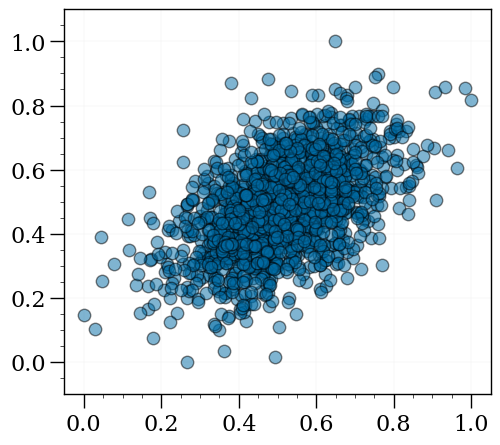

In [42]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [43]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [44]:
run(TrainingTensors, train_D, test_D, key, 'gauss_05')

  0%|          | 1/5000 [05:40<473:06:41, 340.71s/it]

Iter 0. Loss [[0.10705268 0.20552483 2.8263834 ]]


  0%|          | 11/5000 [11:30<10:19:16,  7.45s/it]

Iter 10. Loss [[0.10678302 0.20428027 2.7889771 ]]


  0%|          | 21/5000 [11:32<33:25,  2.48it/s]

Iter 20. Loss [[0.10650533 0.20300187 2.7531106 ]]


  1%|          | 31/5000 [11:35<17:24,  4.76it/s]

Iter 30. Loss [[0.10621266 0.20166837 2.7187486 ]]


  1%|          | 41/5000 [11:38<27:04,  3.05it/s]

Iter 40. Loss [[0.10590218 0.20026289 2.6857195 ]]


  1%|          | 51/5000 [11:41<17:18,  4.76it/s]

Iter 50. Loss [[0.1055782  0.19878288 2.6537855 ]]


  1%|          | 61/5000 [11:43<16:44,  4.92it/s]

Iter 60. Loss [[0.10525055 0.19724113 2.622722  ]]


  1%|▏         | 72/5000 [11:46<16:32,  4.96it/s]

Iter 70. Loss [[0.10493035 0.19565731 2.5923586 ]]


  2%|▏         | 82/5000 [11:48<16:39,  4.92it/s]

Iter 80. Loss [[0.10462638 0.19404903 2.562582  ]]


  2%|▏         | 91/5000 [11:50<25:06,  3.26it/s]

Iter 90. Loss [[0.10434425 0.19242822 2.5333216 ]]


  2%|▏         | 101/5000 [11:54<22:08,  3.69it/s]

Iter 100. Loss [[0.10408711 0.19080135 2.5045383 ]]


  2%|▏         | 111/5000 [11:56<16:50,  4.84it/s]

Iter 110. Loss [[0.10385663 0.1891712  2.476214  ]]


  2%|▏         | 122/5000 [11:59<16:07,  5.04it/s]

Iter 120. Loss [[0.1036538  0.18753865 2.4483402 ]]


  3%|▎         | 132/5000 [12:01<16:02,  5.06it/s]

Iter 130. Loss [[0.10347942 0.1859038  2.420916  ]]


  3%|▎         | 142/5000 [12:03<16:21,  4.95it/s]

Iter 140. Loss [[0.10333426 0.1842668  2.3939412 ]]


  3%|▎         | 151/5000 [12:06<27:03,  2.99it/s]

Iter 150. Loss [[0.10321916 0.18262795 2.3674147 ]]


  3%|▎         | 161/5000 [12:09<17:27,  4.62it/s]

Iter 160. Loss [[0.103135  0.1809879 2.3413365]]


  3%|▎         | 172/5000 [12:12<15:57,  5.04it/s]

Iter 170. Loss [[0.10308266 0.17934757 2.3157048 ]]


  4%|▎         | 182/5000 [12:14<16:08,  4.97it/s]

Iter 180. Loss [[0.10306291 0.177708   2.2905173 ]]


  4%|▍         | 192/5000 [12:16<16:09,  4.96it/s]

Iter 190. Loss [[0.10307644 0.17607035 2.2657723 ]]


  4%|▍         | 201/5000 [12:19<23:05,  3.46it/s]

Iter 200. Loss [[0.1031239  0.17443585 2.2414672 ]]


  4%|▍         | 211/5000 [12:22<24:28,  3.26it/s]

Iter 210. Loss [[0.10320584 0.17280564 2.2176006 ]]


  4%|▍         | 221/5000 [12:25<16:22,  4.86it/s]

Iter 220. Loss [[0.10332265 0.17118095 2.1941688 ]]


  5%|▍         | 232/5000 [12:27<16:07,  4.93it/s]

Iter 230. Loss [[0.1034747  0.16956286 2.1711705 ]]


  5%|▍         | 241/5000 [12:29<16:13,  4.89it/s]

Iter 240. Loss [[0.10366219 0.16795257 2.1486022 ]]


  5%|▌         | 251/5000 [12:31<16:02,  4.94it/s]

Iter 250. Loss [[0.10388526 0.16635111 2.126461  ]]


  5%|▌         | 261/5000 [12:35<25:51,  3.05it/s]

Iter 260. Loss [[0.10414395 0.16475955 2.1047442 ]]


  5%|▌         | 271/5000 [12:38<17:11,  4.58it/s]

Iter 270. Loss [[0.10443825 0.16317885 2.0834472 ]]


  6%|▌         | 281/5000 [12:40<15:52,  4.95it/s]

Iter 280. Loss [[0.10476796 0.16161    2.0625672 ]]


  6%|▌         | 291/5000 [12:42<16:11,  4.85it/s]

Iter 290. Loss [[0.10513291 0.1600539  2.0420997 ]]


  6%|▌         | 301/5000 [12:44<15:50,  4.94it/s]

Iter 300. Loss [[0.10553277 0.15851137 2.0220406 ]]


  6%|▌         | 311/5000 [12:47<20:44,  3.77it/s]

Iter 310. Loss [[0.10596716 0.15698326 2.002385  ]]


  6%|▋         | 321/5000 [12:51<26:15,  2.97it/s]

Iter 320. Loss [[0.10643564 0.15547027 1.9831284 ]]


  7%|▋         | 331/5000 [12:53<16:03,  4.85it/s]

Iter 330. Loss [[0.10693766 0.15397312 1.964266  ]]


  7%|▋         | 341/5000 [12:55<15:42,  4.94it/s]

Iter 340. Loss [[0.10747264 0.15249248 1.9457927 ]]


  7%|▋         | 351/5000 [12:58<15:52,  4.88it/s]

Iter 350. Loss [[0.10803988 0.15102895 1.9277034 ]]


  7%|▋         | 361/5000 [13:00<15:45,  4.91it/s]

Iter 360. Loss [[0.1086387  0.14958307 1.9099934 ]]


  7%|▋         | 371/5000 [13:03<25:05,  3.07it/s]

Iter 370. Loss [[0.10926826 0.14815539 1.8926575 ]]


  8%|▊         | 381/5000 [13:06<17:27,  4.41it/s]

Iter 380. Loss [[0.10992772 0.14674637 1.8756907 ]]


  8%|▊         | 391/5000 [13:08<15:39,  4.91it/s]

Iter 390. Loss [[0.1106162  0.14535645 1.8590882 ]]


  8%|▊         | 401/5000 [13:11<15:31,  4.94it/s]

Iter 400. Loss [[0.11133271 0.14398605 1.8428457 ]]


  8%|▊         | 411/5000 [13:13<15:33,  4.92it/s]

Iter 410. Loss [[0.11207619 0.14263555 1.8269584 ]]


  8%|▊         | 421/5000 [13:15<17:54,  4.26it/s]

Iter 420. Loss [[0.11284564 0.14130534 1.8114225 ]]


  9%|▊         | 431/5000 [13:19<24:49,  3.07it/s]

Iter 430. Loss [[0.11363986 0.13999571 1.796234  ]]


  9%|▉         | 441/5000 [13:21<16:03,  4.73it/s]

Iter 440. Loss [[0.11445757 0.13870703 1.7813896 ]]


  9%|▉         | 451/5000 [13:24<15:37,  4.85it/s]

Iter 450. Loss [[0.11529756 0.13743964 1.7668864 ]]


  9%|▉         | 461/5000 [13:26<15:08,  5.00it/s]

Iter 460. Loss [[0.11615843 0.13619383 1.752722  ]]


  9%|▉         | 471/5000 [13:28<15:18,  4.93it/s]

Iter 470. Loss [[0.11703873 0.13496993 1.7388943 ]]


 10%|▉         | 481/5000 [13:31<24:03,  3.13it/s]

Iter 480. Loss [[0.1179368  0.13376833 1.725402  ]]


 10%|▉         | 491/5000 [13:35<17:52,  4.20it/s]

Iter 490. Loss [[0.11885103 0.13258941 1.7122443 ]]


 10%|█         | 501/5000 [13:37<15:16,  4.91it/s]

Iter 500. Loss [[0.11977953 0.13143359 1.6994219 ]]


 10%|█         | 511/5000 [13:39<15:20,  4.88it/s]

Iter 510. Loss [[0.1207202  0.13030142 1.6869355 ]]


 10%|█         | 521/5000 [13:41<15:22,  4.85it/s]

Iter 520. Loss [[0.12167075 0.12919348 1.6747874 ]]


 11%|█         | 531/5000 [13:44<15:09,  4.91it/s]

Iter 530. Loss [[0.1226285  0.12811057 1.6629814 ]]


 11%|█         | 541/5000 [13:47<24:51,  2.99it/s]

Iter 540. Loss [[0.12359025 0.1270537  1.6515223 ]]


 11%|█         | 552/5000 [13:50<14:54,  4.98it/s]

Iter 550. Loss [[0.12455206 0.12602423 1.640417  ]]


 11%|█         | 561/5000 [13:52<15:02,  4.92it/s]

Iter 560. Loss [[0.1255088  0.12502417 1.6296765 ]]


 11%|█▏        | 572/5000 [13:55<14:44,  5.00it/s]

Iter 570. Loss [[0.12645318 0.1240566  1.6193138 ]]


 12%|█▏        | 582/5000 [13:57<14:51,  4.96it/s]

Iter 580. Loss [[0.12737374 0.12312673 1.60935   ]]


 12%|█▏        | 591/5000 [14:00<22:32,  3.26it/s]

Iter 590. Loss [[0.12825003 0.12224457 1.5998148 ]]


 12%|█▏        | 601/5000 [14:03<19:19,  3.79it/s]

Iter 600. Loss [[0.12903772 0.12143286 1.5907477 ]]


 12%|█▏        | 611/5000 [14:05<14:59,  4.88it/s]

Iter 610. Loss [[0.12962835 0.12074959 1.582112  ]]


 12%|█▏        | 621/5000 [14:08<14:52,  4.91it/s]

Iter 620. Loss [[0.12988663 0.12027323 1.5735825 ]]


 13%|█▎        | 631/5000 [14:10<15:02,  4.84it/s]

Iter 630. Loss [[0.13005374 0.11988029 1.5657809 ]]


 13%|█▎        | 642/5000 [14:12<14:22,  5.05it/s]

Iter 640. Loss [[0.13026577 0.11949439 1.5590234 ]]


 13%|█▎        | 651/5000 [14:16<23:45,  3.05it/s]

Iter 650. Loss [[0.13041872 0.11917309 1.552884  ]]


 13%|█▎        | 662/5000 [14:19<15:09,  4.77it/s]

Iter 660. Loss [[0.13061066 0.11885619 1.5475059 ]]


 13%|█▎        | 672/5000 [14:21<14:43,  4.90it/s]

Iter 670. Loss [[0.13080364 0.11856268 1.5426512 ]]


 14%|█▎        | 681/5000 [14:23<14:43,  4.89it/s]

Iter 680. Loss [[0.1310217  0.11827476 1.5382882 ]]


 14%|█▍        | 691/5000 [14:25<14:56,  4.81it/s]

Iter 690. Loss [[0.13125627 0.11799441 1.5343144 ]]


 14%|█▍        | 701/5000 [14:28<21:27,  3.34it/s]

Iter 700. Loss [[0.13150242 0.11772192 1.5306594 ]]


 14%|█▍        | 712/5000 [14:32<18:42,  3.82it/s]

Iter 710. Loss [[0.13175936 0.11745536 1.5272802 ]]


 14%|█▍        | 721/5000 [14:34<14:46,  4.83it/s]

Iter 720. Loss [[0.13202162 0.11719617 1.5241299 ]]


 15%|█▍        | 731/5000 [14:36<14:30,  4.90it/s]

Iter 730. Loss [[0.13228557 0.1169449  1.5211757 ]]


 15%|█▍        | 741/5000 [14:38<14:20,  4.95it/s]

Iter 740. Loss [[0.13254955 0.11670132 1.518395  ]]


 15%|█▌        | 751/5000 [14:41<14:34,  4.86it/s]

Iter 750. Loss [[0.13281147 0.11646564 1.5157658 ]]


 15%|█▌        | 761/5000 [14:44<23:29,  3.01it/s]

Iter 760. Loss [[0.13306995 0.11623792 1.5132728 ]]


 15%|█▌        | 771/5000 [14:47<14:57,  4.71it/s]

Iter 770. Loss [[0.13332377 0.11601812 1.5109026 ]]


 16%|█▌        | 782/5000 [14:49<14:05,  4.99it/s]

Iter 780. Loss [[0.13357253 0.11580607 1.5086468 ]]


 16%|█▌        | 792/5000 [14:52<14:01,  5.00it/s]

Iter 790. Loss [[0.13381559 0.1156016  1.5064961 ]]


 16%|█▌        | 801/5000 [14:54<14:23,  4.86it/s]

Iter 800. Loss [[0.13405225 0.11540476 1.504443  ]]


 16%|█▌        | 811/5000 [14:56<19:34,  3.57it/s]

Iter 810. Loss [[0.1342825  0.11521525 1.502482  ]]


 16%|█▋        | 821/5000 [15:00<21:58,  3.17it/s]

Iter 820. Loss [[0.13450596 0.115033   1.5006083 ]]


 17%|█▋        | 831/5000 [15:02<14:04,  4.94it/s]

Iter 830. Loss [[0.1347224  0.11485787 1.4988173 ]]


 17%|█▋        | 842/5000 [15:05<14:14,  4.87it/s]

Iter 840. Loss [[0.13493171 0.11468969 1.4971046 ]]


 17%|█▋        | 852/5000 [15:07<13:55,  4.96it/s]

Iter 850. Loss [[0.13513394 0.11452828 1.4954671 ]]


 17%|█▋        | 862/5000 [15:09<13:50,  4.98it/s]

Iter 860. Loss [[0.13532898 0.11437349 1.4939014 ]]


 17%|█▋        | 871/5000 [15:13<22:39,  3.04it/s]

Iter 870. Loss [[0.13551684 0.11422513 1.492404  ]]


 18%|█▊        | 881/5000 [15:15<15:04,  4.55it/s]

Iter 880. Loss [[0.13569768 0.11408301 1.490973  ]]


 18%|█▊        | 891/5000 [15:18<13:56,  4.91it/s]

Iter 890. Loss [[0.13587163 0.11394691 1.4896051 ]]


 18%|█▊        | 901/5000 [15:20<13:54,  4.91it/s]

Iter 900. Loss [[0.13603865 0.11381671 1.4882977 ]]


 18%|█▊        | 911/5000 [15:22<13:46,  4.95it/s]

Iter 910. Loss [[0.13619912 0.1136921  1.4870493 ]]


 18%|█▊        | 921/5000 [15:25<17:19,  3.92it/s]

Iter 920. Loss [[0.1363531  0.11357295 1.4858568 ]]


 19%|█▊        | 931/5000 [15:28<22:46,  2.98it/s]

Iter 930. Loss [[0.13650084 0.11345901 1.4847184 ]]


 19%|█▉        | 941/5000 [15:31<14:24,  4.69it/s]

Iter 940. Loss [[0.13664243 0.11335015 1.4836323 ]]


 19%|█▉        | 951/5000 [15:33<13:34,  4.97it/s]

Iter 950. Loss [[0.13677815 0.11324614 1.482596  ]]


 19%|█▉        | 961/5000 [15:35<13:27,  5.00it/s]

Iter 960. Loss [[0.13690823 0.11314674 1.4816079 ]]


 19%|█▉        | 971/5000 [15:38<13:36,  4.93it/s]

Iter 970. Loss [[0.13703282 0.11305182 1.4806657 ]]


 20%|█▉        | 981/5000 [15:41<21:45,  3.08it/s]

Iter 980. Loss [[0.13715222 0.11296118 1.4797685 ]]


 20%|█▉        | 991/5000 [15:44<15:12,  4.39it/s]

Iter 990. Loss [[0.13726655 0.11287463 1.4789137 ]]


 20%|██        | 1001/5000 [15:46<13:27,  4.95it/s]

Iter 1000. Loss [[0.13737607 0.11279201 1.4780997 ]]


 20%|██        | 1012/5000 [15:49<13:08,  5.06it/s]

Iter 1010. Loss [[0.13748093 0.11271312 1.4773252 ]]


 20%|██        | 1021/5000 [15:51<13:16,  5.00it/s]

Iter 1020. Loss [[0.1375813  0.11263784 1.4765879 ]]


 21%|██        | 1031/5000 [15:53<13:25,  4.93it/s]

Iter 1030. Loss [[0.13767752 0.11256598 1.4758871 ]]


 21%|██        | 1041/5000 [15:57<21:57,  3.00it/s]

Iter 1040. Loss [[0.13776958 0.11249738 1.4752207 ]]


 21%|██        | 1052/5000 [15:59<13:32,  4.86it/s]

Iter 1050. Loss [[0.13785769 0.11243197 1.4745871 ]]


 21%|██        | 1062/5000 [16:02<13:09,  4.99it/s]

Iter 1060. Loss [[0.13794212 0.11236952 1.4739853 ]]


 21%|██▏       | 1072/5000 [16:04<13:11,  4.96it/s]

Iter 1070. Loss [[0.13802294 0.11230996 1.4734137 ]]


 22%|██▏       | 1082/5000 [16:06<13:09,  4.96it/s]

Iter 1080. Loss [[0.13810039 0.11225311 1.4728705 ]]


 22%|██▏       | 1091/5000 [16:09<20:13,  3.22it/s]

Iter 1090. Loss [[0.13817458 0.11219886 1.4723555 ]]


 22%|██▏       | 1102/5000 [16:12<15:24,  4.22it/s]

Iter 1100. Loss [[0.13824552 0.11214714 1.4718665 ]]


 22%|██▏       | 1111/5000 [16:15<13:05,  4.95it/s]

Iter 1110. Loss [[0.1383136  0.11209776 1.4714023 ]]


 22%|██▏       | 1122/5000 [16:17<12:49,  5.04it/s]

Iter 1120. Loss [[0.13837883 0.11205065 1.4709628 ]]


 23%|██▎       | 1132/5000 [16:19<12:54,  5.00it/s]

Iter 1130. Loss [[0.13844123 0.11200572 1.4705452 ]]


 23%|██▎       | 1142/5000 [16:22<12:54,  4.98it/s]

Iter 1140. Loss [[0.13850102 0.11196289 1.4701498 ]]


 23%|██▎       | 1151/5000 [16:25<21:21,  3.00it/s]

Iter 1150. Loss [[0.13855834 0.11192197 1.4697747 ]]


 23%|██▎       | 1162/5000 [16:28<13:14,  4.83it/s]

Iter 1160. Loss [[0.13861327 0.11188298 1.46942   ]]


 23%|██▎       | 1172/5000 [16:30<12:45,  5.00it/s]

Iter 1170. Loss [[0.13866584 0.11184578 1.4690837 ]]


 24%|██▎       | 1181/5000 [16:32<12:46,  4.98it/s]

Iter 1180. Loss [[0.13871624 0.11181031 1.4687649 ]]


 24%|██▍       | 1192/5000 [16:35<13:01,  4.87it/s]

Iter 1190. Loss [[0.1387645  0.11177647 1.4684635 ]]


 24%|██▍       | 1201/5000 [16:37<17:41,  3.58it/s]

Iter 1200. Loss [[0.13881063 0.11174426 1.4681774 ]]


 24%|██▍       | 1212/5000 [16:41<17:33,  3.59it/s]

Iter 1210. Loss [[0.13885488 0.11171351 1.4679072 ]]


 24%|██▍       | 1222/5000 [16:43<12:42,  4.96it/s]

Iter 1220. Loss [[0.13889731 0.11168418 1.4676515 ]]


 25%|██▍       | 1232/5000 [16:45<12:35,  4.99it/s]

Iter 1230. Loss [[0.1389379  0.11165621 1.4674098 ]]


 25%|██▍       | 1242/5000 [16:48<12:26,  5.04it/s]

Iter 1240. Loss [[0.13897686 0.11162954 1.467181  ]]


 25%|██▌       | 1252/5000 [16:50<12:36,  4.96it/s]

Iter 1250. Loss [[0.13901402 0.11160417 1.4669645 ]]


 25%|██▌       | 1261/5000 [16:53<20:23,  3.06it/s]

Iter 1260. Loss [[0.13904963 0.11157996 1.4667596 ]]


 25%|██▌       | 1271/5000 [16:56<14:04,  4.41it/s]

Iter 1270. Loss [[0.1390838  0.11155687 1.4665666 ]]


 26%|██▌       | 1282/5000 [16:58<12:39,  4.90it/s]

Iter 1280. Loss [[0.13911638 0.11153492 1.4663831 ]]


 26%|██▌       | 1292/5000 [17:01<12:35,  4.91it/s]

Iter 1290. Loss [[0.13914767 0.11151396 1.4662106 ]]


 26%|██▌       | 1302/5000 [17:03<12:26,  4.95it/s]

Iter 1300. Loss [[0.13917749 0.11149405 1.4660472 ]]


 26%|██▌       | 1311/5000 [17:06<23:06,  2.66it/s]

Iter 1310. Loss [[0.13920605 0.11147506 1.4658933 ]]


 26%|██▋       | 1321/5000 [17:11<24:31,  2.50it/s]

Iter 1320. Loss [[0.13923344 0.11145695 1.4657474 ]]


 27%|██▋       | 1331/5000 [17:13<12:49,  4.77it/s]

Iter 1330. Loss [[0.1392596  0.11143973 1.4656098 ]]


 27%|██▋       | 1342/5000 [17:16<12:20,  4.94it/s]

Iter 1340. Loss [[0.13928455 0.11142334 1.4654801 ]]


 27%|██▋       | 1352/5000 [17:18<12:13,  4.97it/s]

Iter 1350. Loss [[0.13930847 0.11140773 1.4653571 ]]


 27%|██▋       | 1361/5000 [17:20<12:20,  4.91it/s]

Iter 1360. Loss [[0.13933128 0.11139289 1.4652416 ]]


 27%|██▋       | 1371/5000 [17:24<20:00,  3.02it/s]

Iter 1370. Loss [[0.13935304 0.11137878 1.4651326 ]]


 28%|██▊       | 1381/5000 [17:26<12:51,  4.69it/s]

Iter 1380. Loss [[0.13937385 0.11136536 1.465029  ]]


 28%|██▊       | 1392/5000 [17:29<11:57,  5.03it/s]

Iter 1390. Loss [[0.13939378 0.11135254 1.4649323 ]]


 28%|██▊       | 1402/5000 [17:31<12:10,  4.92it/s]

Iter 1400. Loss [[0.13941278 0.11134039 1.4648405 ]]


 28%|██▊       | 1412/5000 [17:34<12:01,  4.97it/s]

Iter 1410. Loss [[0.1394308  0.11132888 1.4647546 ]]


 28%|██▊       | 1421/5000 [17:36<18:15,  3.27it/s]

Iter 1420. Loss [[0.13944806 0.11131792 1.4646728 ]]


 29%|██▊       | 1432/5000 [17:40<14:33,  4.09it/s]

Iter 1430. Loss [[0.13946468 0.11130744 1.4645964 ]]


 29%|██▉       | 1442/5000 [17:42<12:01,  4.93it/s]

Iter 1440. Loss [[0.13948037 0.11129755 1.464524  ]]


 29%|██▉       | 1452/5000 [17:44<11:52,  4.98it/s]

Iter 1450. Loss [[0.13949548 0.11128808 1.4644561 ]]


 29%|██▉       | 1462/5000 [17:47<11:48,  4.99it/s]

Iter 1460. Loss [[0.13950983 0.11127912 1.4643921 ]]


 29%|██▉       | 1471/5000 [17:49<11:49,  4.97it/s]

Iter 1470. Loss [[0.13952348 0.11127063 1.4643319 ]]


 30%|██▉       | 1481/5000 [17:52<19:29,  3.01it/s]

Iter 1480. Loss [[0.13953656 0.11126251 1.4642754 ]]


 30%|██▉       | 1491/5000 [17:55<12:50,  4.55it/s]

Iter 1490. Loss [[0.13954891 0.11125486 1.4642217 ]]


 30%|███       | 1502/5000 [17:57<11:50,  4.92it/s]

Iter 1500. Loss [[0.13956073 0.11124761 1.4641716 ]]


 30%|███       | 1512/5000 [18:00<11:55,  4.88it/s]

Iter 1510. Loss [[0.13957205 0.11124067 1.4641247 ]]


 30%|███       | 1521/5000 [18:02<11:47,  4.91it/s]

Iter 1520. Loss [[0.13958283 0.11123411 1.4640803 ]]


 31%|███       | 1531/5000 [18:05<17:27,  3.31it/s]

Iter 1530. Loss [[0.13959299 0.11122791 1.4640387 ]]


 31%|███       | 1542/5000 [18:08<15:17,  3.77it/s]

Iter 1540. Loss [[0.13960272 0.11122202 1.4639994 ]]


 31%|███       | 1551/5000 [18:10<11:56,  4.82it/s]

Iter 1550. Loss [[0.13961205 0.11121641 1.4639626 ]]


 31%|███       | 1562/5000 [18:13<11:47,  4.86it/s]

Iter 1560. Loss [[0.13962084 0.11121112 1.4639281 ]]


 31%|███▏      | 1572/5000 [18:15<11:38,  4.91it/s]

Iter 1570. Loss [[0.13962922 0.11120611 1.4638957 ]]


 32%|███▏      | 1582/5000 [18:18<11:42,  4.87it/s]

Iter 1580. Loss [[0.13963716 0.11120138 1.463865  ]]


 32%|███▏      | 1591/5000 [18:21<18:39,  3.04it/s]

Iter 1590. Loss [[0.13964482 0.11119682 1.4638368 ]]


 32%|███▏      | 1602/5000 [18:24<12:01,  4.71it/s]

Iter 1600. Loss [[0.13965209 0.11119252 1.4638102 ]]


 32%|███▏      | 1612/5000 [18:26<11:41,  4.83it/s]

Iter 1610. Loss [[0.13965903 0.11118846 1.4637853 ]]


 32%|███▏      | 1622/5000 [18:28<11:35,  4.86it/s]

Iter 1620. Loss [[0.13966554 0.11118461 1.463762  ]]


 33%|███▎      | 1632/5000 [18:31<11:24,  4.92it/s]

Iter 1630. Loss [[0.13967179 0.11118098 1.4637399 ]]


 33%|███▎      | 1641/5000 [18:33<15:58,  3.50it/s]

Iter 1640. Loss [[0.13967772 0.11117753 1.4637197 ]]


 33%|███▎      | 1652/5000 [18:37<15:14,  3.66it/s]

Iter 1650. Loss [[0.13968337 0.11117426 1.4637005 ]]


 33%|███▎      | 1661/5000 [18:39<11:37,  4.79it/s]

Iter 1660. Loss [[0.13968876 0.11117114 1.4636827 ]]


 33%|███▎      | 1671/5000 [18:41<11:17,  4.91it/s]

Iter 1670. Loss [[0.1396938  0.11116825 1.4636657 ]]


 34%|███▎      | 1682/5000 [18:44<11:22,  4.86it/s]

Iter 1680. Loss [[0.13969864 0.11116549 1.4636501 ]]


 34%|███▍      | 1692/5000 [18:46<11:09,  4.94it/s]

Iter 1690. Loss [[0.13970321 0.11116287 1.4636356 ]]


 34%|███▍      | 1701/5000 [18:49<17:51,  3.08it/s]

Iter 1700. Loss [[0.13970767 0.11116037 1.4636221 ]]


 34%|███▍      | 1712/5000 [18:52<11:36,  4.72it/s]

Iter 1710. Loss [[0.13971183 0.11115803 1.4636093 ]]


 34%|███▍      | 1722/5000 [18:55<11:03,  4.94it/s]

Iter 1720. Loss [[0.13971575 0.11115578 1.4635977 ]]


 35%|███▍      | 1732/5000 [18:57<11:04,  4.92it/s]

Iter 1730. Loss [[0.13971953 0.11115371 1.4635866 ]]


 35%|███▍      | 1742/5000 [18:59<10:56,  4.97it/s]

Iter 1740. Loss [[0.13972309 0.11115173 1.4635762 ]]


 35%|███▌      | 1751/5000 [19:02<14:37,  3.70it/s]

Iter 1750. Loss [[0.1397265  0.11114984 1.4635667 ]]


 35%|███▌      | 1761/5000 [19:05<17:51,  3.02it/s]

Iter 1760. Loss [[0.13972971 0.11114805 1.4635582 ]]


 35%|███▌      | 1772/5000 [19:08<10:58,  4.90it/s]

Iter 1770. Loss [[0.13973284 0.11114634 1.4635497 ]]


 36%|███▌      | 1782/5000 [19:10<10:46,  4.98it/s]

Iter 1780. Loss [[0.13973571 0.1111448  1.463542  ]]


 36%|███▌      | 1792/5000 [19:12<10:58,  4.87it/s]

Iter 1790. Loss [[0.13973847 0.11114326 1.4635352 ]]


 36%|███▌      | 1802/5000 [19:15<11:03,  4.82it/s]

Iter 1800. Loss [[0.1397411  0.11114187 1.463529  ]]


 36%|███▌      | 1811/5000 [19:18<17:19,  3.07it/s]

Iter 1810. Loss [[0.13974358 0.11114052 1.4635224 ]]


 36%|███▋      | 1822/5000 [19:21<11:35,  4.57it/s]

Iter 1820. Loss [[0.13974598 0.11113925 1.463517  ]]


 37%|███▋      | 1832/5000 [19:23<10:40,  4.95it/s]

Iter 1830. Loss [[0.13974817 0.11113806 1.4635117 ]]


 37%|███▋      | 1842/5000 [19:25<10:49,  4.86it/s]

Iter 1840. Loss [[0.13975036 0.11113691 1.4635069 ]]


 37%|███▋      | 1851/5000 [19:28<10:43,  4.89it/s]

Iter 1850. Loss [[0.13975236 0.11113586 1.4635026 ]]


 37%|███▋      | 1861/5000 [19:30<11:38,  4.49it/s]

Iter 1860. Loss [[0.13975435 0.11113483 1.4634987 ]]


 37%|███▋      | 1871/5000 [19:34<17:32,  2.97it/s]

Iter 1870. Loss [[0.13975622 0.11113384 1.4634948 ]]


 38%|███▊      | 1882/5000 [19:36<10:59,  4.73it/s]

Iter 1880. Loss [[0.13975798 0.11113293 1.4634916 ]]


 38%|███▊      | 1892/5000 [19:39<10:31,  4.92it/s]

Iter 1890. Loss [[0.13975969 0.11113204 1.4634886 ]]


 38%|███▊      | 1902/5000 [19:41<10:22,  4.97it/s]

Iter 1900. Loss [[0.13976122 0.11113124 1.4634855 ]]


 38%|███▊      | 1912/5000 [19:43<10:21,  4.97it/s]

Iter 1910. Loss [[0.13976273 0.11113051 1.4634829 ]]


 38%|███▊      | 1921/5000 [19:46<16:15,  3.16it/s]

Iter 1920. Loss [[0.13976407 0.1111298  1.4634805 ]]


 39%|███▊      | 1932/5000 [19:49<11:50,  4.32it/s]

Iter 1930. Loss [[0.13976544 0.11112911 1.4634782 ]]


 39%|███▉      | 1941/5000 [19:51<10:22,  4.91it/s]

Iter 1940. Loss [[0.13976665 0.11112848 1.4634761 ]]


 39%|███▉      | 1952/5000 [19:54<10:17,  4.94it/s]

Iter 1950. Loss [[0.13976792 0.11112789 1.4634743 ]]


 39%|███▉      | 1962/5000 [19:56<10:15,  4.94it/s]

Iter 1960. Loss [[0.13976909 0.11112732 1.4634724 ]]


 39%|███▉      | 1971/5000 [19:58<10:17,  4.91it/s]

Iter 1970. Loss [[0.13977021 0.11112675 1.4634712 ]]


 40%|███▉      | 1981/5000 [20:02<16:27,  3.06it/s]

Iter 1980. Loss [[0.1397713  0.11112622 1.4634697 ]]


 40%|███▉      | 1992/5000 [20:05<10:19,  4.86it/s]

Iter 1990. Loss [[0.13977227 0.11112573 1.4634688 ]]


 40%|████      | 2002/5000 [20:07<09:59,  5.00it/s]

Iter 2000. Loss [[0.13977322 0.11112526 1.4634677 ]]


 40%|████      | 2012/5000 [20:09<10:08,  4.91it/s]

Iter 2010. Loss [[0.13977414 0.11112484 1.4634664 ]]


 40%|████      | 2022/5000 [20:11<10:02,  4.95it/s]

Iter 2020. Loss [[0.13977502 0.11112441 1.4634658 ]]


 41%|████      | 2031/5000 [20:14<14:36,  3.39it/s]

Iter 2030. Loss [[0.13977584 0.11112401 1.463465  ]]


 41%|████      | 2042/5000 [20:18<13:02,  3.78it/s]

Iter 2040. Loss [[0.13977654 0.11112367 1.4634641 ]]


 41%|████      | 2052/5000 [20:20<10:12,  4.81it/s]

Iter 2050. Loss [[0.13977723 0.11112335 1.4634635 ]]


 41%|████      | 2062/5000 [20:22<09:49,  4.99it/s]

Iter 2060. Loss [[0.139778  0.111123  1.4634632]]


 41%|████▏     | 2071/5000 [20:24<10:06,  4.83it/s]

Iter 2070. Loss [[0.13977858 0.11112272 1.4634622 ]]


 42%|████▏     | 2082/5000 [20:27<09:52,  4.93it/s]

Iter 2080. Loss [[0.13977928 0.11112241 1.4634621 ]]


 42%|████▏     | 2091/5000 [20:30<16:03,  3.02it/s]

Iter 2090. Loss [[0.13977991 0.1111221  1.4634619 ]]


 42%|████▏     | 2102/5000 [20:33<10:26,  4.63it/s]

Iter 2100. Loss [[0.1397805  0.11112185 1.4634615 ]]


 42%|████▏     | 2112/5000 [20:35<09:51,  4.88it/s]

Iter 2110. Loss [[0.139781   0.11112161 1.4634614 ]]


 42%|████▏     | 2122/5000 [20:38<09:39,  4.96it/s]

Iter 2120. Loss [[0.13978156 0.11112136 1.4634609 ]]


 43%|████▎     | 2131/5000 [20:40<10:07,  4.72it/s]

Iter 2130. Loss [[0.13978197 0.11112117 1.4634606 ]]


 43%|████▎     | 2141/5000 [20:42<13:44,  3.47it/s]

Iter 2140. Loss [[0.13978247 0.11112096 1.4634609 ]]


 43%|████▎     | 2152/5000 [20:46<13:26,  3.53it/s]

Iter 2150. Loss [[0.13978292 0.11112075 1.4634606 ]]


 43%|████▎     | 2162/5000 [20:49<09:47,  4.83it/s]

Iter 2160. Loss [[0.13978332 0.11112055 1.4634606 ]]


 43%|████▎     | 2172/5000 [20:51<09:31,  4.95it/s]

Iter 2170. Loss [[0.13978375 0.11112038 1.4634608 ]]


 44%|████▎     | 2182/5000 [20:53<09:25,  4.98it/s]

Iter 2180. Loss [[0.13978411 0.11112022 1.4634606 ]]


 44%|████▍     | 2191/5000 [20:55<09:40,  4.84it/s]

Iter 2190. Loss [[0.13978444 0.1111201  1.4634606 ]]


 44%|████▍     | 2201/5000 [20:58<15:07,  3.08it/s]

Iter 2200. Loss [[0.13978486 0.11111991 1.4634604 ]]


 44%|████▍     | 2211/5000 [21:01<10:46,  4.31it/s]

Iter 2210. Loss [[0.13978522 0.11111975 1.4634608 ]]


 44%|████▍     | 2221/5000 [21:04<09:43,  4.76it/s]

Iter 2220. Loss [[0.1397855  0.11111963 1.4634608 ]]


 45%|████▍     | 2232/5000 [21:06<09:18,  4.96it/s]

Iter 2230. Loss [[0.13978578 0.11111952 1.4634606 ]]


 45%|████▍     | 2242/5000 [21:09<09:28,  4.85it/s]

Iter 2240. Loss [[0.13978614 0.11111934 1.4634609 ]]


 45%|████▌     | 2251/5000 [21:11<11:26,  4.01it/s]

Iter 2250. Loss [[0.13978645 0.11111922 1.4634613 ]]


 45%|████▌     | 2261/5000 [21:14<15:18,  2.98it/s]

Iter 2260. Loss [[0.13978666 0.11111914 1.4634609 ]]


 45%|████▌     | 2272/5000 [21:17<09:27,  4.81it/s]

Iter 2270. Loss [[0.13978678 0.11111907 1.463461  ]]


 46%|████▌     | 2282/5000 [21:19<09:21,  4.84it/s]

Iter 2280. Loss [[0.13978705 0.11111898 1.4634613 ]]


 46%|████▌     | 2292/5000 [21:22<09:05,  4.97it/s]

Iter 2290. Loss [[0.13978723 0.11111891 1.4634613 ]]


 46%|████▌     | 2302/5000 [21:24<09:03,  4.96it/s]

Iter 2300. Loss [[0.1397875  0.11111879 1.4634614 ]]


 46%|████▌     | 2311/5000 [21:27<14:29,  3.09it/s]

Iter 2310. Loss [[0.13978773 0.11111867 1.4634613 ]]


 46%|████▋     | 2322/5000 [21:30<10:16,  4.34it/s]

Iter 2320. Loss [[0.13978787 0.11111865 1.4634619 ]]


 47%|████▋     | 2332/5000 [21:32<09:04,  4.90it/s]

Iter 2330. Loss [[0.139788   0.11111858 1.4634615 ]]


 47%|████▋     | 2342/5000 [21:35<09:12,  4.81it/s]

Iter 2340. Loss [[0.13978824 0.11111849 1.4634619 ]]


 47%|████▋     | 2352/5000 [21:37<08:57,  4.93it/s]

Iter 2350. Loss [[0.13978836 0.11111843 1.4634619 ]]


 47%|████▋     | 2361/5000 [21:39<09:07,  4.82it/s]

Iter 2360. Loss [[0.13978851 0.11111838 1.4634622 ]]


 47%|████▋     | 2371/5000 [21:43<14:37,  3.00it/s]

Iter 2370. Loss [[0.13978873 0.11111829 1.4634626 ]]


 48%|████▊     | 2382/5000 [21:46<09:13,  4.73it/s]

Iter 2380. Loss [[0.1397889  0.11111823 1.4634627 ]]


 48%|████▊     | 2392/5000 [21:48<08:53,  4.89it/s]

Iter 2390. Loss [[0.13978887 0.11111824 1.4634626 ]]


 48%|████▊     | 2402/5000 [21:50<08:48,  4.92it/s]

Iter 2400. Loss [[0.13978897 0.11111823 1.4634622 ]]


 48%|████▊     | 2412/5000 [21:52<08:46,  4.92it/s]

Iter 2410. Loss [[0.1397892  0.11111809 1.4634627 ]]


 48%|████▊     | 2421/5000 [21:55<13:08,  3.27it/s]

Iter 2420. Loss [[0.13978942 0.111118   1.4634631 ]]


 49%|████▊     | 2432/5000 [21:59<10:45,  3.98it/s]

Iter 2430. Loss [[0.13978949 0.11111798 1.4634632 ]]


 49%|████▉     | 2442/5000 [22:01<08:49,  4.83it/s]

Iter 2440. Loss [[0.13978955 0.11111797 1.4634632 ]]


 49%|████▉     | 2452/5000 [22:03<08:33,  4.96it/s]

Iter 2450. Loss [[0.1397896  0.11111796 1.4634631 ]]


 49%|████▉     | 2461/5000 [22:05<08:58,  4.72it/s]

Iter 2460. Loss [[0.13978973 0.11111788 1.4634635 ]]


 49%|████▉     | 2472/5000 [22:08<08:35,  4.90it/s]

Iter 2470. Loss [[0.1397898  0.11111785 1.4634635 ]]


 50%|████▉     | 2481/5000 [22:11<13:36,  3.08it/s]

Iter 2480. Loss [[0.13978994 0.11111782 1.4634635 ]]


 50%|████▉     | 2491/5000 [22:14<09:04,  4.61it/s]

Iter 2490. Loss [[0.13978995 0.11111781 1.4634635 ]]


 50%|█████     | 2502/5000 [22:16<08:32,  4.88it/s]

Iter 2500. Loss [[0.13979003 0.11111777 1.4634637 ]]


 50%|█████     | 2512/5000 [22:19<08:32,  4.86it/s]

Iter 2510. Loss [[0.13979009 0.11111774 1.4634639 ]]


 50%|█████     | 2522/5000 [22:21<08:31,  4.84it/s]

Iter 2520. Loss [[0.13979015 0.11111774 1.4634639 ]]


 51%|█████     | 2531/5000 [22:23<12:18,  3.34it/s]

Iter 2530. Loss [[0.13979028 0.11111766 1.4634639 ]]


 51%|█████     | 2542/5000 [22:27<11:19,  3.62it/s]

Iter 2540. Loss [[0.13979028 0.11111768 1.4634641 ]]


 51%|█████     | 2552/5000 [22:29<08:26,  4.84it/s]

Iter 2550. Loss [[0.13979033 0.11111768 1.4634641 ]]


 51%|█████     | 2562/5000 [22:32<08:16,  4.91it/s]

Iter 2560. Loss [[0.13979048 0.11111759 1.4634645 ]]


 51%|█████▏    | 2571/5000 [22:34<08:21,  4.84it/s]

Iter 2570. Loss [[0.13979056 0.11111756 1.4634645 ]]


 52%|█████▏    | 2582/5000 [22:36<08:17,  4.87it/s]

Iter 2580. Loss [[0.13979046 0.11111763 1.4634641 ]]


 52%|█████▏    | 2591/5000 [22:39<13:09,  3.05it/s]

Iter 2590. Loss [[0.13979064 0.11111753 1.4634645 ]]


 52%|█████▏    | 2601/5000 [22:42<09:07,  4.38it/s]

Iter 2600. Loss [[0.13979056 0.11111759 1.4634645 ]]


 52%|█████▏    | 2611/5000 [22:45<08:28,  4.70it/s]

Iter 2610. Loss [[0.13979067 0.11111753 1.4634645 ]]


 52%|█████▏    | 2622/5000 [22:47<07:59,  4.96it/s]

Iter 2620. Loss [[0.1397906  0.11111757 1.4634645 ]]


 53%|█████▎    | 2632/5000 [22:49<07:52,  5.01it/s]

Iter 2630. Loss [[0.1397907  0.11111753 1.4634644 ]]


 53%|█████▎    | 2641/5000 [22:52<09:53,  3.98it/s]

Iter 2640. Loss [[0.13979086 0.11111743 1.4634651 ]]


 53%|█████▎    | 2651/5000 [22:55<13:17,  2.94it/s]

Iter 2650. Loss [[0.13979082 0.11111747 1.4634649 ]]


 53%|█████▎    | 2662/5000 [22:58<08:00,  4.87it/s]

Iter 2660. Loss [[0.1397908  0.11111749 1.4634649 ]]


 53%|█████▎    | 2672/5000 [23:00<07:49,  4.96it/s]

Iter 2670. Loss [[0.13979082 0.11111748 1.4634645 ]]


 54%|█████▎    | 2682/5000 [23:03<07:57,  4.86it/s]

Iter 2680. Loss [[0.13979095 0.11111741 1.4634651 ]]


 54%|█████▍    | 2692/5000 [23:05<07:54,  4.86it/s]

Iter 2690. Loss [[0.1397909  0.11111744 1.463465  ]]


 54%|█████▍    | 2701/5000 [23:08<12:20,  3.10it/s]

Iter 2700. Loss [[0.13979094 0.11111742 1.463465  ]]


 54%|█████▍    | 2712/5000 [23:11<08:54,  4.28it/s]

Iter 2710. Loss [[0.139791   0.11111741 1.4634651 ]]


 54%|█████▍    | 2722/5000 [23:13<07:51,  4.83it/s]

Iter 2720. Loss [[0.139791   0.11111739 1.4634651 ]]


 55%|█████▍    | 2732/5000 [23:16<07:39,  4.93it/s]

Iter 2730. Loss [[0.13979101 0.11111739 1.4634651 ]]


 55%|█████▍    | 2742/5000 [23:18<07:46,  4.84it/s]

Iter 2740. Loss [[0.13979103 0.11111739 1.4634651 ]]


 55%|█████▌    | 2751/5000 [23:20<08:00,  4.68it/s]

Iter 2750. Loss [[0.13979101 0.11111741 1.463465  ]]


 55%|█████▌    | 2761/5000 [23:24<12:38,  2.95it/s]

Iter 2760. Loss [[0.13979115 0.11111734 1.463465  ]]


 55%|█████▌    | 2772/5000 [23:27<07:56,  4.67it/s]

Iter 2770. Loss [[0.13979101 0.11111741 1.4634649 ]]


 56%|█████▌    | 2782/5000 [23:29<07:43,  4.78it/s]

Iter 2780. Loss [[0.13979098 0.11111743 1.4634649 ]]


 56%|█████▌    | 2792/5000 [23:31<07:29,  4.92it/s]

Iter 2790. Loss [[0.13979118 0.11111732 1.4634655 ]]


 56%|█████▌    | 2802/5000 [23:33<07:37,  4.80it/s]

Iter 2800. Loss [[0.13979109 0.11111738 1.4634651 ]]


 56%|█████▌    | 2811/5000 [23:36<11:39,  3.13it/s]

Iter 2810. Loss [[0.13979119 0.11111733 1.4634651 ]]


 56%|█████▋    | 2821/5000 [23:39<09:39,  3.76it/s]

Iter 2820. Loss [[0.13979116 0.11111734 1.4634651 ]]


 57%|█████▋    | 2832/5000 [23:42<07:31,  4.80it/s]

Iter 2830. Loss [[0.13979122 0.11111731 1.4634658 ]]


 57%|█████▋    | 2842/5000 [23:44<07:34,  4.74it/s]

Iter 2840. Loss [[0.13979112 0.11111737 1.4634651 ]]


 57%|█████▋    | 2852/5000 [23:47<07:27,  4.80it/s]

Iter 2850. Loss [[0.13979125 0.11111729 1.4634655 ]]


 57%|█████▋    | 2861/5000 [23:49<07:43,  4.61it/s]

Iter 2860. Loss [[0.13979116 0.11111735 1.4634655 ]]


 57%|█████▋    | 2871/5000 [23:52<12:02,  2.95it/s]

Iter 2870. Loss [[0.13979119 0.11111733 1.4634653 ]]


 58%|█████▊    | 2881/5000 [23:55<08:03,  4.38it/s]

Iter 2880. Loss [[0.13979125 0.11111731 1.4634653 ]]


 58%|█████▊    | 2892/5000 [23:57<07:25,  4.73it/s]

Iter 2890. Loss [[0.13979131 0.11111728 1.4634655 ]]


 58%|█████▊    | 2902/5000 [24:00<07:20,  4.76it/s]

Iter 2900. Loss [[0.13979122 0.11111731 1.4634655 ]]


 58%|█████▊    | 2912/5000 [24:02<07:14,  4.81it/s]

Iter 2910. Loss [[0.13979131 0.11111727 1.4634655 ]]


 58%|█████▊    | 2921/5000 [24:05<10:55,  3.17it/s]

Iter 2920. Loss [[0.13979112 0.11111739 1.4634651 ]]


 59%|█████▊    | 2932/5000 [24:08<09:06,  3.79it/s]

Iter 2930. Loss [[0.13979122 0.11111732 1.4634655 ]]


 59%|█████▉    | 2942/5000 [24:11<07:21,  4.66it/s]

Iter 2940. Loss [[0.13979122 0.11111733 1.4634653 ]]


 59%|█████▉    | 2952/5000 [24:13<07:12,  4.73it/s]

Iter 2950. Loss [[0.13979122 0.11111731 1.4634653 ]]


 59%|█████▉    | 2962/5000 [24:15<07:05,  4.79it/s]

Iter 2960. Loss [[0.13979127 0.11111729 1.4634655 ]]


 59%|█████▉    | 2972/5000 [24:17<07:02,  4.81it/s]

Iter 2970. Loss [[0.13979134 0.11111727 1.4634658 ]]


 60%|█████▉    | 2981/5000 [24:21<11:47,  2.85it/s]

Iter 2980. Loss [[0.13979137 0.11111724 1.4634657 ]]


 60%|█████▉    | 2992/5000 [24:24<07:36,  4.40it/s]

Iter 2990. Loss [[0.13979116 0.11111735 1.4634651 ]]


 60%|██████    | 3002/5000 [24:26<07:01,  4.74it/s]

Iter 3000. Loss [[0.13979134 0.11111726 1.4634658 ]]


 60%|██████    | 3012/5000 [24:28<07:07,  4.65it/s]

Iter 3010. Loss [[0.13979132 0.11111727 1.4634658 ]]


 60%|██████    | 3022/5000 [24:31<07:04,  4.66it/s]

Iter 3020. Loss [[0.13979127 0.1111173  1.4634655 ]]


 61%|██████    | 3031/5000 [24:33<10:10,  3.22it/s]

Iter 3030. Loss [[0.1397913  0.11111729 1.4634655 ]]


 61%|██████    | 3042/5000 [24:37<09:24,  3.47it/s]

Iter 3040. Loss [[0.13979119 0.11111735 1.4634651 ]]


 61%|██████    | 3052/5000 [24:39<06:47,  4.78it/s]

Iter 3050. Loss [[0.13979144 0.11111721 1.4634658 ]]


 61%|██████    | 3062/5000 [24:41<06:47,  4.76it/s]

Iter 3060. Loss [[0.1397913  0.11111729 1.4634655 ]]


 61%|██████▏   | 3071/5000 [24:44<07:05,  4.54it/s]

Iter 3070. Loss [[0.1397913 0.1111173 1.4634657]]


 62%|██████▏   | 3082/5000 [24:46<07:01,  4.55it/s]

Iter 3080. Loss [[0.13979127 0.1111173  1.4634653 ]]


 62%|██████▏   | 3091/5000 [24:49<11:02,  2.88it/s]

Iter 3090. Loss [[0.13979137 0.11111726 1.4634658 ]]


 62%|██████▏   | 3102/5000 [24:52<07:22,  4.29it/s]

Iter 3100. Loss [[0.1397913 0.1111173 1.4634655]]


 62%|██████▏   | 3112/5000 [24:55<06:46,  4.65it/s]

Iter 3110. Loss [[0.13979137 0.11111724 1.4634655 ]]


 62%|██████▏   | 3122/5000 [24:57<06:43,  4.65it/s]

Iter 3120. Loss [[0.13979125 0.11111731 1.4634651 ]]


 63%|██████▎   | 3132/5000 [24:59<06:40,  4.67it/s]

Iter 3130. Loss [[0.13979134 0.11111727 1.4634657 ]]


 63%|██████▎   | 3141/5000 [25:02<08:55,  3.47it/s]

Iter 3140. Loss [[0.13979134 0.11111726 1.4634655 ]]


 63%|██████▎   | 3151/5000 [25:05<11:06,  2.77it/s]

Iter 3150. Loss [[0.13979128 0.1111173  1.4634655 ]]


 63%|██████▎   | 3162/5000 [25:08<06:44,  4.54it/s]

Iter 3160. Loss [[0.13979137 0.11111726 1.4634657 ]]


 63%|██████▎   | 3172/5000 [25:10<06:32,  4.66it/s]

Iter 3170. Loss [[0.13979131 0.11111729 1.4634653 ]]


 64%|██████▎   | 3181/5000 [25:12<06:47,  4.46it/s]

Iter 3180. Loss [[0.13979134 0.11111727 1.4634655 ]]


 64%|██████▍   | 3192/5000 [25:15<06:26,  4.67it/s]

Iter 3190. Loss [[0.13979147 0.11111721 1.4634658 ]]


 64%|██████▍   | 3201/5000 [25:18<10:14,  2.93it/s]

Iter 3200. Loss [[0.13979137 0.11111726 1.4634653 ]]


 64%|██████▍   | 3212/5000 [25:21<07:02,  4.24it/s]

Iter 3210. Loss [[0.13979125 0.11111731 1.4634651 ]]


 64%|██████▍   | 3221/5000 [25:23<06:35,  4.50it/s]

Iter 3220. Loss [[0.13979147 0.11111721 1.4634657 ]]


 65%|██████▍   | 3232/5000 [25:25<06:22,  4.62it/s]

Iter 3230. Loss [[0.13979122 0.11111733 1.4634655 ]]


 65%|██████▍   | 3242/5000 [25:28<06:19,  4.63it/s]

Iter 3240. Loss [[0.13979149 0.11111721 1.4634658 ]]


 65%|██████▌   | 3251/5000 [25:30<07:26,  3.92it/s]

Iter 3250. Loss [[0.13979131 0.11111729 1.4634655 ]]


 65%|██████▌   | 3261/5000 [25:34<10:13,  2.83it/s]

Iter 3260. Loss [[0.13979137 0.11111727 1.4634658 ]]


 65%|██████▌   | 3272/5000 [25:36<06:18,  4.57it/s]

Iter 3270. Loss [[0.13979138 0.11111724 1.4634657 ]]


 66%|██████▌   | 3281/5000 [25:38<06:17,  4.55it/s]

Iter 3280. Loss [[0.13979127 0.11111731 1.4634655 ]]


 66%|██████▌   | 3292/5000 [25:41<06:08,  4.63it/s]

Iter 3290. Loss [[0.13979131 0.11111729 1.4634655 ]]


 66%|██████▌   | 3302/5000 [25:43<06:06,  4.63it/s]

Iter 3300. Loss [[0.13979141 0.11111723 1.4634659 ]]


 66%|██████▌   | 3311/5000 [25:46<09:55,  2.84it/s]

Iter 3310. Loss [[0.13979134 0.11111727 1.4634653 ]]


 66%|██████▋   | 3321/5000 [25:49<07:17,  3.84it/s]

Iter 3320. Loss [[0.13979122 0.11111733 1.4634651 ]]


 67%|██████▋   | 3332/5000 [25:52<06:09,  4.52it/s]

Iter 3330. Loss [[0.13979137 0.11111726 1.4634655 ]]


 67%|██████▋   | 3342/5000 [25:54<06:08,  4.50it/s]

Iter 3340. Loss [[0.13979153 0.11111718 1.4634662 ]]


 67%|██████▋   | 3352/5000 [25:56<05:53,  4.66it/s]

Iter 3350. Loss [[0.13979134 0.11111727 1.4634653 ]]


 67%|██████▋   | 3361/5000 [25:58<06:31,  4.19it/s]

Iter 3360. Loss [[0.13979137 0.11111727 1.4634657 ]]


 67%|██████▋   | 3371/5000 [26:02<09:52,  2.75it/s]

Iter 3370. Loss [[0.13979138 0.11111724 1.4634653 ]]


 68%|██████▊   | 3382/5000 [26:05<06:09,  4.38it/s]

Iter 3380. Loss [[0.13979137 0.11111724 1.4634658 ]]


 68%|██████▊   | 3392/5000 [26:07<05:54,  4.54it/s]

Iter 3390. Loss [[0.13979134 0.11111727 1.4634655 ]]


 68%|██████▊   | 3402/5000 [26:09<05:55,  4.50it/s]

Iter 3400. Loss [[0.13979141 0.11111724 1.4634659 ]]


 68%|██████▊   | 3412/5000 [26:12<06:00,  4.40it/s]

Iter 3410. Loss [[0.1397914  0.11111724 1.4634658 ]]


 68%|██████▊   | 3421/5000 [26:14<08:50,  2.98it/s]

Iter 3420. Loss [[0.13979134 0.11111727 1.4634655 ]]


 69%|██████▊   | 3432/5000 [26:18<06:57,  3.75it/s]

Iter 3430. Loss [[0.13979138 0.11111724 1.4634655 ]]


 69%|██████▉   | 3442/5000 [26:20<05:48,  4.47it/s]

Iter 3440. Loss [[0.13979137 0.11111726 1.4634657 ]]


 69%|██████▉   | 3452/5000 [26:23<05:41,  4.53it/s]

Iter 3450. Loss [[0.13979137 0.11111726 1.4634657 ]]


 69%|██████▉   | 3461/5000 [26:25<05:59,  4.28it/s]

Iter 3460. Loss [[0.13979144 0.11111721 1.4634659 ]]


 69%|██████▉   | 3472/5000 [26:27<05:41,  4.47it/s]

Iter 3470. Loss [[0.13979134 0.11111727 1.4634653 ]]


 70%|██████▉   | 3481/5000 [26:30<09:11,  2.75it/s]

Iter 3480. Loss [[0.13979134 0.11111727 1.4634657 ]]


 70%|██████▉   | 3492/5000 [26:33<06:13,  4.04it/s]

Iter 3490. Loss [[0.13979137 0.11111726 1.4634655 ]]


 70%|███████   | 3502/5000 [26:36<05:37,  4.44it/s]

Iter 3500. Loss [[0.13979134 0.11111727 1.4634655 ]]


 70%|███████   | 3512/5000 [26:38<05:43,  4.33it/s]

Iter 3510. Loss [[0.13979141 0.11111724 1.4634657 ]]


 70%|███████   | 3521/5000 [26:40<06:07,  4.03it/s]

Iter 3520. Loss [[0.1397914  0.11111723 1.4634659 ]]


 71%|███████   | 3531/5000 [26:43<08:19,  2.94it/s]

Iter 3530. Loss [[0.13979137 0.11111726 1.4634658 ]]


 71%|███████   | 3541/5000 [26:46<08:06,  3.00it/s]

Iter 3540. Loss [[0.13979138 0.11111724 1.4634658 ]]


 71%|███████   | 3552/5000 [26:49<05:41,  4.24it/s]

Iter 3550. Loss [[0.13979131 0.11111729 1.4634655 ]]


 71%|███████   | 3562/5000 [26:51<05:32,  4.33it/s]

Iter 3560. Loss [[0.1397914  0.11111724 1.4634655 ]]


 71%|███████▏  | 3572/5000 [26:53<05:29,  4.33it/s]

Iter 3570. Loss [[0.13979141 0.11111723 1.4634658 ]]


 72%|███████▏  | 3581/5000 [26:56<05:52,  4.02it/s]

Iter 3580. Loss [[0.13979134 0.11111727 1.4634653 ]]


 72%|███████▏  | 3591/5000 [26:59<08:58,  2.62it/s]

Iter 3590. Loss [[0.1397914  0.11111723 1.4634658 ]]


 72%|███████▏  | 3602/5000 [27:02<05:45,  4.05it/s]

Iter 3600. Loss [[0.1397915 0.1111172 1.4634662]]


 72%|███████▏  | 3612/5000 [27:04<05:27,  4.24it/s]

Iter 3610. Loss [[0.13979132 0.11111729 1.4634655 ]]


 72%|███████▏  | 3622/5000 [27:07<05:18,  4.32it/s]

Iter 3620. Loss [[0.13979137 0.11111726 1.4634653 ]]


 73%|███████▎  | 3632/5000 [27:09<05:20,  4.27it/s]

Iter 3630. Loss [[0.13979134 0.11111727 1.4634655 ]]


 73%|███████▎  | 3641/5000 [27:11<07:20,  3.09it/s]

Iter 3640. Loss [[0.13979122 0.11111733 1.4634653 ]]


 73%|███████▎  | 3652/5000 [27:15<07:12,  3.12it/s]

Iter 3650. Loss [[0.1397913 0.1111173 1.4634655]]


 73%|███████▎  | 3662/5000 [27:17<05:14,  4.25it/s]

Iter 3660. Loss [[0.13979137 0.11111726 1.4634658 ]]


 73%|███████▎  | 3672/5000 [27:20<05:09,  4.29it/s]

Iter 3670. Loss [[0.13979132 0.11111728 1.4634655 ]]


 74%|███████▎  | 3682/5000 [27:22<05:07,  4.28it/s]

Iter 3680. Loss [[0.13979134 0.11111726 1.4634655 ]]


 74%|███████▍  | 3692/5000 [27:24<05:01,  4.33it/s]

Iter 3690. Loss [[0.13979132 0.11111727 1.4634655 ]]


 74%|███████▍  | 3701/5000 [27:27<08:40,  2.50it/s]

Iter 3700. Loss [[0.13979137 0.11111726 1.4634655 ]]


 74%|███████▍  | 3712/5000 [27:31<05:55,  3.62it/s]

Iter 3710. Loss [[0.13979138 0.11111724 1.4634658 ]]


 74%|███████▍  | 3722/5000 [27:33<05:15,  4.05it/s]

Iter 3720. Loss [[0.13979131 0.11111729 1.4634655 ]]


 75%|███████▍  | 3732/5000 [27:35<05:17,  3.99it/s]

Iter 3730. Loss [[0.13979137 0.11111726 1.4634655 ]]


 75%|███████▍  | 3742/5000 [27:38<05:14,  4.00it/s]

Iter 3740. Loss [[0.1397914  0.11111724 1.4634657 ]]


 75%|███████▌  | 3751/5000 [27:40<06:53,  3.02it/s]

Iter 3750. Loss [[0.13979134 0.11111727 1.4634657 ]]


 75%|███████▌  | 3761/5000 [27:43<09:06,  2.27it/s]

Iter 3760. Loss [[0.13979131 0.1111173  1.4634655 ]]


 75%|███████▌  | 3772/5000 [27:46<05:09,  3.97it/s]

Iter 3770. Loss [[0.13979138 0.11111724 1.4634655 ]]


 76%|███████▌  | 3782/5000 [27:48<05:01,  4.05it/s]

Iter 3780. Loss [[0.13979131 0.11111729 1.4634655 ]]


 76%|███████▌  | 3791/5000 [27:50<06:02,  3.33it/s]

Iter 3790. Loss [[0.13979134 0.11111729 1.4634657 ]]


 76%|███████▌  | 3801/5000 [27:53<06:06,  3.27it/s]

Iter 3800. Loss [[0.13979131 0.1111173  1.4634655 ]]


 76%|███████▌  | 3811/5000 [27:56<08:26,  2.35it/s]

Iter 3810. Loss [[0.13979125 0.11111732 1.4634651 ]]


 76%|███████▋  | 3822/5000 [27:59<06:05,  3.22it/s]

Iter 3820. Loss [[0.13979128 0.1111173  1.4634653 ]]


 77%|███████▋  | 3832/5000 [28:02<05:16,  3.70it/s]

Iter 3830. Loss [[0.13979138 0.11111724 1.4634655 ]]


 77%|███████▋  | 3841/5000 [28:04<05:47,  3.34it/s]

Iter 3840. Loss [[0.13979134 0.11111727 1.4634653 ]]


 77%|███████▋  | 3852/5000 [28:06<05:07,  3.73it/s]

Iter 3850. Loss [[0.13979134 0.11111727 1.4634653 ]]


 77%|███████▋  | 3861/5000 [28:08<05:40,  3.34it/s]

Iter 3860. Loss [[0.13979137 0.11111724 1.4634655 ]]


 77%|███████▋  | 3871/5000 [28:12<08:31,  2.21it/s]

Iter 3870. Loss [[0.13979144 0.11111721 1.4634657 ]]


 78%|███████▊  | 3882/5000 [28:15<05:07,  3.63it/s]

Iter 3880. Loss [[0.13979147 0.11111721 1.4634659 ]]


 78%|███████▊  | 3892/5000 [28:17<05:00,  3.69it/s]

Iter 3890. Loss [[0.13979137 0.11111724 1.4634655 ]]


 78%|███████▊  | 3902/5000 [28:19<04:51,  3.76it/s]

Iter 3900. Loss [[0.1397913 0.1111173 1.4634651]]


 78%|███████▊  | 3912/5000 [28:22<04:55,  3.69it/s]

Iter 3910. Loss [[0.13979128 0.11111731 1.4634657 ]]


 78%|███████▊  | 3921/5000 [28:24<07:24,  2.43it/s]

Iter 3920. Loss [[0.1397914  0.11111724 1.4634657 ]]


 79%|███████▊  | 3932/5000 [28:28<05:53,  3.02it/s]

Iter 3930. Loss [[0.1397914  0.11111724 1.4634655 ]]


 79%|███████▉  | 3942/5000 [28:30<04:45,  3.70it/s]

Iter 3940. Loss [[0.13979138 0.11111724 1.4634655 ]]


 79%|███████▉  | 3952/5000 [28:32<04:39,  3.74it/s]

Iter 3950. Loss [[0.13979127 0.11111731 1.4634651 ]]


 79%|███████▉  | 3962/5000 [28:35<04:40,  3.71it/s]

Iter 3960. Loss [[0.1397915  0.11111718 1.4634662 ]]


 79%|███████▉  | 3972/5000 [28:37<04:38,  3.69it/s]

Iter 3970. Loss [[0.13979137 0.11111726 1.4634653 ]]


 80%|███████▉  | 3981/5000 [28:40<07:43,  2.20it/s]

Iter 3980. Loss [[0.13979137 0.11111724 1.4634653 ]]


 80%|███████▉  | 3992/5000 [28:43<04:42,  3.57it/s]

Iter 3990. Loss [[0.13979134 0.11111727 1.4634653 ]]


 80%|████████  | 4001/5000 [28:46<05:05,  3.28it/s]

Iter 4000. Loss [[0.1397915  0.11111718 1.4634662 ]]


 80%|████████  | 4012/5000 [28:48<04:25,  3.72it/s]

Iter 4010. Loss [[0.13979137 0.11111724 1.4634655 ]]


 80%|████████  | 4022/5000 [28:50<04:23,  3.71it/s]

Iter 4020. Loss [[0.1397914  0.11111724 1.4634657 ]]


 81%|████████  | 4031/5000 [28:53<06:33,  2.46it/s]

Iter 4030. Loss [[0.13979131 0.11111729 1.4634655 ]]


 81%|████████  | 4042/5000 [28:57<05:31,  2.89it/s]

Iter 4040. Loss [[0.13979119 0.11111735 1.4634651 ]]


 81%|████████  | 4052/5000 [28:59<04:17,  3.68it/s]

Iter 4050. Loss [[0.1397913 0.1111173 1.4634651]]


 81%|████████  | 4062/5000 [29:01<04:10,  3.75it/s]

Iter 4060. Loss [[0.13979131 0.11111729 1.4634651 ]]


 81%|████████▏ | 4072/5000 [29:04<04:12,  3.67it/s]

Iter 4070. Loss [[0.13979137 0.11111724 1.4634655 ]]


 82%|████████▏ | 4081/5000 [29:06<04:36,  3.32it/s]

Iter 4080. Loss [[0.13979134 0.11111726 1.4634653 ]]


 82%|████████▏ | 4091/5000 [29:09<04:49,  3.14it/s]

Iter 4090. Loss [[0.13979134 0.11111727 1.4634653 ]]


 82%|████████▏ | 4101/5000 [29:12<04:54,  3.06it/s]

Iter 4100. Loss [[0.13979127 0.11111731 1.4634653 ]]


 82%|████████▏ | 4112/5000 [29:14<04:00,  3.70it/s]

Iter 4110. Loss [[0.1397913 0.1111173 1.4634651]]


 82%|████████▏ | 4122/5000 [29:17<04:03,  3.61it/s]

Iter 4120. Loss [[0.13979131 0.11111729 1.4634651 ]]


 83%|████████▎ | 4132/5000 [29:19<03:54,  3.71it/s]

Iter 4130. Loss [[0.13979155 0.11111718 1.4634666 ]]


 83%|████████▎ | 4141/5000 [29:21<05:23,  2.66it/s]

Iter 4140. Loss [[0.13979125 0.11111731 1.4634655 ]]


 83%|████████▎ | 4152/5000 [29:25<05:13,  2.71it/s]

Iter 4150. Loss [[0.13979125 0.11111733 1.4634653 ]]


 83%|████████▎ | 4161/5000 [29:27<04:19,  3.23it/s]

Iter 4160. Loss [[0.13979131 0.11111729 1.4634655 ]]


 83%|████████▎ | 4171/5000 [29:29<02:50,  4.88it/s]

Iter 4170. Loss [[0.13979137 0.11111724 1.4634655 ]]


 84%|████████▎ | 4182/5000 [29:32<03:43,  3.67it/s]

Iter 4180. Loss [[0.13979138 0.11111724 1.4634657 ]]


 84%|████████▍ | 4192/5000 [29:35<03:40,  3.67it/s]

Iter 4190. Loss [[0.1397914  0.11111724 1.4634658 ]]


 84%|████████▍ | 4201/5000 [29:38<05:48,  2.29it/s]

Iter 4200. Loss [[0.13979131 0.1111173  1.4634655 ]]


 84%|████████▍ | 4212/5000 [29:41<03:45,  3.49it/s]

Iter 4210. Loss [[0.13979125 0.11111732 1.4634655 ]]


 84%|████████▍ | 4222/5000 [29:43<03:33,  3.65it/s]

Iter 4220. Loss [[0.13979134 0.11111727 1.4634655 ]]


 85%|████████▍ | 4232/5000 [29:46<03:27,  3.70it/s]

Iter 4230. Loss [[0.13979147 0.11111721 1.4634658 ]]


 85%|████████▍ | 4242/5000 [29:48<03:22,  3.75it/s]

Iter 4240. Loss [[0.13979138 0.11111724 1.4634657 ]]


 85%|████████▌ | 4251/5000 [29:50<04:25,  2.82it/s]

Iter 4250. Loss [[0.13979138 0.11111724 1.4634655 ]]


 85%|████████▌ | 4262/5000 [29:54<04:39,  2.64it/s]

Iter 4260. Loss [[0.13979134 0.11111728 1.4634653 ]]


 85%|████████▌ | 4272/5000 [29:56<03:18,  3.66it/s]

Iter 4270. Loss [[0.13979144 0.11111721 1.4634655 ]]


 86%|████████▌ | 4282/5000 [29:59<03:13,  3.71it/s]

Iter 4280. Loss [[0.13979147 0.11111721 1.4634657 ]]


 86%|████████▌ | 4292/5000 [30:01<03:09,  3.74it/s]

Iter 4290. Loss [[0.13979146 0.11111723 1.4634655 ]]


 86%|████████▌ | 4302/5000 [30:03<03:07,  3.71it/s]

Iter 4300. Loss [[0.1397914  0.11111723 1.4634655 ]]


 86%|████████▌ | 4311/5000 [30:06<03:33,  3.22it/s]

Iter 4310. Loss [[0.13979137 0.11111726 1.4634655 ]]


 86%|████████▋ | 4322/5000 [30:09<03:22,  3.35it/s]

Iter 4320. Loss [[0.13979138 0.11111724 1.4634657 ]]


 87%|████████▋ | 4332/5000 [30:12<02:59,  3.72it/s]

Iter 4330. Loss [[0.13979132 0.11111728 1.4634653 ]]


 87%|████████▋ | 4342/5000 [30:14<02:58,  3.69it/s]

Iter 4340. Loss [[0.13979138 0.11111724 1.4634655 ]]


 87%|████████▋ | 4352/5000 [30:16<02:54,  3.72it/s]

Iter 4350. Loss [[0.1397915 0.1111172 1.4634659]]


 87%|████████▋ | 4361/5000 [30:19<03:30,  3.03it/s]

Iter 4360. Loss [[0.13979134 0.11111726 1.4634653 ]]


 87%|████████▋ | 4371/5000 [30:22<04:37,  2.27it/s]

Iter 4370. Loss [[0.13979125 0.11111732 1.4634651 ]]


 88%|████████▊ | 4382/5000 [30:25<02:50,  3.62it/s]

Iter 4380. Loss [[0.13979144 0.11111721 1.4634655 ]]


 88%|████████▊ | 4391/5000 [30:27<02:06,  4.82it/s]

Iter 4390. Loss [[0.13979132 0.11111727 1.4634655 ]]


 88%|████████▊ | 4401/5000 [30:29<02:01,  4.94it/s]

Iter 4400. Loss [[0.13979134 0.11111727 1.4634653 ]]


 88%|████████▊ | 4411/5000 [30:31<02:00,  4.89it/s]

Iter 4410. Loss [[0.1397916  0.11111715 1.4634664 ]]


 88%|████████▊ | 4421/5000 [30:34<02:59,  3.22it/s]

Iter 4420. Loss [[0.13979141 0.11111723 1.4634658 ]]


 89%|████████▊ | 4431/5000 [30:38<02:30,  3.78it/s]

Iter 4430. Loss [[0.13979131 0.1111173  1.4634651 ]]


 89%|████████▉ | 4441/5000 [30:40<01:57,  4.74it/s]

Iter 4440. Loss [[0.1397915  0.11111718 1.4634662 ]]


 89%|████████▉ | 4452/5000 [30:43<02:29,  3.66it/s]

Iter 4450. Loss [[0.13979119 0.11111735 1.4634653 ]]


 89%|████████▉ | 4462/5000 [30:45<02:28,  3.63it/s]

Iter 4460. Loss [[0.1397915 0.1111172 1.4634658]]


 89%|████████▉ | 4471/5000 [30:47<02:48,  3.14it/s]

Iter 4470. Loss [[0.13979128 0.1111173  1.4634655 ]]


 90%|████████▉ | 4481/5000 [30:51<03:49,  2.27it/s]

Iter 4480. Loss [[0.13979138 0.11111724 1.4634657 ]]


 90%|████████▉ | 4492/5000 [30:54<02:19,  3.65it/s]

Iter 4490. Loss [[0.13979137 0.11111726 1.4634655 ]]


 90%|█████████ | 4502/5000 [30:56<02:13,  3.73it/s]

Iter 4500. Loss [[0.13979147 0.11111721 1.4634655 ]]


 90%|█████████ | 4512/5000 [30:58<02:11,  3.72it/s]

Iter 4510. Loss [[0.13979125 0.11111731 1.4634651 ]]


 90%|█████████ | 4522/5000 [31:01<02:09,  3.70it/s]

Iter 4520. Loss [[0.13979147 0.11111721 1.4634655 ]]


 91%|█████████ | 4531/5000 [31:03<03:18,  2.36it/s]

Iter 4530. Loss [[0.1397915 0.1111172 1.4634662]]


 91%|█████████ | 4542/5000 [31:07<02:28,  3.08it/s]

Iter 4540. Loss [[0.13979119 0.11111735 1.4634651 ]]


 91%|█████████ | 4552/5000 [31:09<02:00,  3.70it/s]

Iter 4550. Loss [[0.13979155 0.11111718 1.4634662 ]]


 91%|█████████ | 4562/5000 [31:12<01:57,  3.73it/s]

Iter 4560. Loss [[0.13979128 0.11111731 1.4634653 ]]


 91%|█████████▏| 4571/5000 [31:14<01:55,  3.72it/s]

Iter 4570. Loss [[0.13979161 0.11111712 1.4634666 ]]


 92%|█████████▏| 4581/5000 [31:16<01:54,  3.66it/s]

Iter 4580. Loss [[0.13979144 0.11111721 1.4634655 ]]


 92%|█████████▏| 4591/5000 [31:19<02:46,  2.45it/s]

Iter 4590. Loss [[0.13979128 0.1111173  1.4634657 ]]


 92%|█████████▏| 4602/5000 [31:22<01:42,  3.87it/s]

Iter 4600. Loss [[0.13979147 0.11111721 1.4634658 ]]


 92%|█████████▏| 4612/5000 [31:25<01:36,  4.02it/s]

Iter 4610. Loss [[0.13979138 0.11111724 1.4634655 ]]


 92%|█████████▏| 4622/5000 [31:27<01:33,  4.04it/s]

Iter 4620. Loss [[0.1397914  0.11111723 1.4634659 ]]


 93%|█████████▎| 4631/5000 [31:29<01:40,  3.69it/s]

Iter 4630. Loss [[0.13979132 0.11111729 1.4634655 ]]


 93%|█████████▎| 4641/5000 [31:32<02:14,  2.67it/s]

Iter 4640. Loss [[0.13979137 0.11111726 1.4634655 ]]


 93%|█████████▎| 4652/5000 [31:36<01:56,  2.99it/s]

Iter 4650. Loss [[0.13979132 0.11111727 1.4634655 ]]


 93%|█████████▎| 4662/5000 [31:38<01:25,  3.97it/s]

Iter 4660. Loss [[0.1397914  0.11111724 1.4634658 ]]


 93%|█████████▎| 4672/5000 [31:40<01:20,  4.05it/s]

Iter 4670. Loss [[0.13979134 0.11111727 1.4634655 ]]


 94%|█████████▎| 4682/5000 [31:43<01:25,  3.70it/s]

Iter 4680. Loss [[0.13979137 0.11111724 1.4634657 ]]


 94%|█████████▍| 4691/5000 [31:45<01:32,  3.34it/s]

Iter 4690. Loss [[0.13979125 0.11111732 1.4634653 ]]


 94%|█████████▍| 4701/5000 [31:48<02:11,  2.27it/s]

Iter 4700. Loss [[0.13979155 0.11111717 1.4634664 ]]


 94%|█████████▍| 4712/5000 [31:51<01:15,  3.81it/s]

Iter 4710. Loss [[0.13979137 0.11111727 1.4634655 ]]


 94%|█████████▍| 4722/5000 [31:53<01:08,  4.04it/s]

Iter 4720. Loss [[0.13979131 0.11111729 1.4634651 ]]


 95%|█████████▍| 4731/5000 [31:56<01:14,  3.61it/s]

Iter 4730. Loss [[0.13979155 0.11111718 1.4634662 ]]


 95%|█████████▍| 4741/5000 [31:58<01:10,  3.70it/s]

Iter 4740. Loss [[0.13979125 0.11111732 1.4634653 ]]


 95%|█████████▌| 4751/5000 [32:01<01:35,  2.60it/s]

Iter 4750. Loss [[0.13979176 0.11111706 1.463467  ]]


 95%|█████████▌| 4761/5000 [32:04<01:40,  2.38it/s]

Iter 4760. Loss [[0.13979092 0.11111751 1.4634645 ]]


 95%|█████████▌| 4771/5000 [32:06<01:02,  3.65it/s]

Iter 4770. Loss [[0.13979188 0.11111698 1.4634671 ]]


 96%|█████████▌| 4782/5000 [32:09<00:54,  4.01it/s]

Iter 4780. Loss [[0.13979094 0.11111749 1.4634645 ]]


 96%|█████████▌| 4792/5000 [32:11<00:51,  4.03it/s]

Iter 4790. Loss [[0.13979185 0.11111701 1.4634671 ]]


 96%|█████████▌| 4802/5000 [32:14<00:53,  3.67it/s]

Iter 4800. Loss [[0.13979098 0.11111747 1.4634646 ]]


 96%|█████████▌| 4811/5000 [32:17<01:16,  2.46it/s]

Iter 4810. Loss [[0.13979161 0.11111712 1.4634662 ]]


 96%|█████████▋| 4821/5000 [32:20<00:51,  3.48it/s]

Iter 4820. Loss [[0.13979122 0.11111734 1.4634651 ]]


 97%|█████████▋| 4832/5000 [32:22<00:41,  4.05it/s]

Iter 4830. Loss [[0.1397916  0.11111715 1.4634662 ]]


 97%|█████████▋| 4842/5000 [32:24<00:38,  4.06it/s]

Iter 4840. Loss [[0.13979115 0.11111738 1.4634651 ]]


 97%|█████████▋| 4852/5000 [32:27<00:36,  4.01it/s]

Iter 4850. Loss [[0.13979161 0.11111712 1.4634668 ]]


 97%|█████████▋| 4861/5000 [32:29<00:47,  2.92it/s]

Iter 4860. Loss [[0.13979119 0.11111735 1.4634651 ]]


 97%|█████████▋| 4872/5000 [32:33<00:42,  3.00it/s]

Iter 4870. Loss [[0.1397914  0.11111723 1.4634655 ]]


 98%|█████████▊| 4882/5000 [32:35<00:29,  3.97it/s]

Iter 4880. Loss [[0.1397915  0.11111718 1.4634662 ]]


 98%|█████████▊| 4892/5000 [32:38<00:29,  3.71it/s]

Iter 4890. Loss [[0.13979131 0.1111173  1.4634655 ]]


 98%|█████████▊| 4902/5000 [32:40<00:26,  3.72it/s]

Iter 4900. Loss [[0.13979144 0.11111723 1.4634657 ]]


 98%|█████████▊| 4912/5000 [32:42<00:23,  3.68it/s]

Iter 4910. Loss [[0.13979116 0.11111737 1.4634651 ]]


 98%|█████████▊| 4921/5000 [32:45<00:34,  2.30it/s]

Iter 4920. Loss [[0.13979149 0.11111721 1.4634662 ]]


 99%|█████████▊| 4932/5000 [32:48<00:19,  3.47it/s]

Iter 4930. Loss [[0.13979155 0.11111717 1.4634662 ]]


 99%|█████████▉| 4942/5000 [32:51<00:14,  3.99it/s]

Iter 4940. Loss [[0.13979125 0.11111731 1.4634655 ]]


 99%|█████████▉| 4952/5000 [32:53<00:11,  4.03it/s]

Iter 4950. Loss [[0.13979152 0.11111718 1.4634659 ]]


 99%|█████████▉| 4962/5000 [32:55<00:09,  4.03it/s]

Iter 4960. Loss [[0.1397913 0.1111173 1.4634655]]


 99%|█████████▉| 4971/5000 [32:58<00:09,  3.02it/s]

Iter 4970. Loss [[0.1397914  0.11111724 1.4634657 ]]


100%|█████████▉| 4981/5000 [33:01<00:07,  2.41it/s]

Iter 4980. Loss [[0.13979134 0.11111728 1.4634655 ]]


100%|█████████▉| 4992/5000 [33:04<00:02,  3.70it/s]

Iter 4990. Loss [[0.1397913 0.1111173 1.4634651]]


100%|██████████| 5000/5000 [33:06<00:00,  2.52it/s]


## Gauss $\rho=0.9$

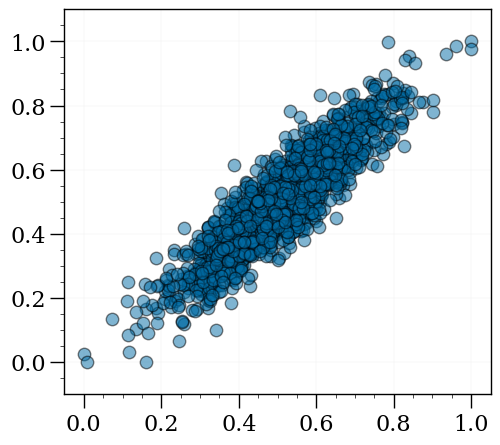

In [45]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [46]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [47]:
run(TrainingTensors, train_D, test_D, key, 'gauss_09')

  0%|          | 1/5000 [05:49<485:10:28, 349.40s/it]

Iter 0. Loss [[0.17656317 0.22699381 2.7846313 ]]


  0%|          | 12/5000 [11:34<7:16:51,  5.25s/it] 

Iter 10. Loss [[0.17604178 0.22589388 2.7443614 ]]


  0%|          | 21/5000 [11:36<46:28,  1.79it/s]

Iter 20. Loss [[0.17544468 0.22471114 2.7057118 ]]


  1%|          | 31/5000 [11:40<28:35,  2.90it/s]

Iter 30. Loss [[0.17482461 0.22350395 2.668344  ]]


  1%|          | 41/5000 [11:42<18:13,  4.54it/s]

Iter 40. Loss [[0.17418315 0.22227249 2.6321301 ]]


  1%|          | 52/5000 [11:45<19:54,  4.14it/s]

Iter 50. Loss [[0.17351869 0.22101209 2.5969296 ]]


  1%|          | 61/5000 [11:47<17:22,  4.74it/s]

Iter 60. Loss [[0.17283125 0.21971937 2.5625992 ]]


  1%|▏         | 71/5000 [11:49<17:26,  4.71it/s]

Iter 70. Loss [[0.17212445 0.21839449 2.5290062 ]]


  2%|▏         | 81/5000 [11:53<29:35,  2.77it/s]

Iter 80. Loss [[0.17140314 0.21703963 2.496044  ]]


  2%|▏         | 91/5000 [11:56<26:43,  3.06it/s]

Iter 90. Loss [[0.17067257 0.21565776 2.463637  ]]


  2%|▏         | 101/5000 [11:58<16:59,  4.80it/s]

Iter 100. Loss [[0.1699378  0.21425246 2.4317336 ]]


  2%|▏         | 111/5000 [12:00<17:54,  4.55it/s]

Iter 110. Loss [[0.16920406 0.21282753 2.4002986 ]]


  2%|▏         | 121/5000 [12:03<22:53,  3.55it/s]

Iter 120. Loss [[0.1684758 0.2113867 2.369307 ]]


  3%|▎         | 131/5000 [12:06<26:09,  3.10it/s]

Iter 130. Loss [[0.16775705 0.20993319 2.3387434 ]]


  3%|▎         | 142/5000 [12:09<18:42,  4.33it/s]

Iter 140. Loss [[0.16705106 0.20846981 2.308596  ]]


  3%|▎         | 151/5000 [12:12<20:06,  4.02it/s]

Iter 150. Loss [[0.16636065 0.20699894 2.2788563 ]]


  3%|▎         | 162/5000 [12:14<25:05,  3.21it/s]

Iter 160. Loss [[0.16568834 0.20552275 2.249517  ]]


  3%|▎         | 171/5000 [12:16<17:00,  4.73it/s]

Iter 170. Loss [[0.16503626 0.20404293 2.2205708 ]]


  4%|▎         | 181/5000 [12:19<25:17,  3.18it/s]

Iter 180. Loss [[0.16440615 0.20256115 2.192012  ]]


  4%|▍         | 192/5000 [12:23<27:47,  2.88it/s]

Iter 190. Loss [[0.16379964 0.20107877 2.1638343 ]]


  4%|▍         | 201/5000 [12:25<17:28,  4.58it/s]

Iter 200. Loss [[0.1632182  0.19959706 2.1360302 ]]


  4%|▍         | 211/5000 [12:28<17:18,  4.61it/s]

Iter 210. Loss [[0.16266298 0.19811717 2.1085935 ]]


  4%|▍         | 221/5000 [12:30<19:36,  4.06it/s]

Iter 220. Loss [[0.16213521 0.19664012 2.0815163 ]]


  5%|▍         | 231/5000 [12:32<16:43,  4.75it/s]

Iter 230. Loss [[0.16163583 0.19516692 2.0547907 ]]


  5%|▍         | 241/5000 [12:36<27:20,  2.90it/s]

Iter 240. Loss [[0.16116579 0.19369845 2.0284095 ]]


  5%|▌         | 251/5000 [12:39<18:45,  4.22it/s]

Iter 250. Loss [[0.16072582 0.19223548 2.002364  ]]


  5%|▌         | 261/5000 [12:41<25:05,  3.15it/s]

Iter 260. Loss [[0.16031665 0.19077885 1.976644  ]]


  5%|▌         | 272/5000 [12:44<16:19,  4.83it/s]

Iter 270. Loss [[0.15993887 0.18932918 1.9512419 ]]


  6%|▌         | 281/5000 [12:46<17:44,  4.43it/s]

Iter 280. Loss [[0.15959305 0.18788719 1.9261475 ]]


  6%|▌         | 291/5000 [12:49<32:13,  2.43it/s]

Iter 290. Loss [[0.15927966 0.18645339 1.9013518 ]]


  6%|▌         | 301/5000 [12:52<18:12,  4.30it/s]

Iter 300. Loss [[0.15899909 0.18502836 1.876845  ]]


  6%|▌         | 311/5000 [12:55<16:48,  4.65it/s]

Iter 310. Loss [[0.15875164 0.18361259 1.8526175 ]]


  6%|▋         | 321/5000 [12:57<18:23,  4.24it/s]

Iter 320. Loss [[0.15853763 0.18220642 1.8286588 ]]


  7%|▋         | 331/5000 [13:00<24:44,  3.15it/s]

Iter 330. Loss [[0.15835725 0.18081035 1.8049597 ]]


  7%|▋         | 341/5000 [13:02<23:48,  3.26it/s]

Iter 340. Loss [[0.15821072 0.17942464 1.7815101 ]]


  7%|▋         | 351/5000 [13:06<21:09,  3.66it/s]

Iter 350. Loss [[0.15809815 0.17804964 1.7583009 ]]


  7%|▋         | 362/5000 [13:09<18:46,  4.12it/s]

Iter 360. Loss [[0.15801957 0.17668553 1.7353222 ]]


  7%|▋         | 372/5000 [13:11<15:44,  4.90it/s]

Iter 370. Loss [[0.15797509 0.1753326  1.7125651 ]]


  8%|▊         | 381/5000 [13:13<16:37,  4.63it/s]

Iter 380. Loss [[0.15796474 0.17399102 1.6900202 ]]


  8%|▊         | 391/5000 [13:16<22:15,  3.45it/s]

Iter 390. Loss [[0.1579885  0.17266096 1.6676787 ]]


  8%|▊         | 402/5000 [13:20<32:29,  2.36it/s]

Iter 400. Loss [[0.15804628 0.1713425  1.6455325 ]]


  8%|▊         | 411/5000 [13:22<16:38,  4.59it/s]

Iter 410. Loss [[0.15813805 0.17003578 1.6235732 ]]


  8%|▊         | 421/5000 [13:24<17:53,  4.26it/s]

Iter 420. Loss [[0.1582637  0.16874087 1.6017933 ]]


  9%|▊         | 432/5000 [13:27<21:24,  3.56it/s]

Iter 430. Loss [[0.15842317 0.16745785 1.5801849 ]]


  9%|▉         | 441/5000 [13:29<16:03,  4.73it/s]

Iter 440. Loss [[0.15861627 0.16618675 1.5587418 ]]


  9%|▉         | 451/5000 [13:33<26:15,  2.89it/s]

Iter 450. Loss [[0.15884292 0.16492759 1.5374565 ]]


  9%|▉         | 462/5000 [13:36<18:54,  4.00it/s]

Iter 460. Loss [[0.15910292 0.16368042 1.5163236 ]]


  9%|▉         | 471/5000 [13:38<15:39,  4.82it/s]

Iter 470. Loss [[0.15939604 0.1624452  1.4953369 ]]


 10%|▉         | 481/5000 [13:40<16:26,  4.58it/s]

Iter 480. Loss [[0.15972213 0.16122198 1.4744909 ]]


 10%|▉         | 491/5000 [13:43<18:31,  4.06it/s]

Iter 490. Loss [[0.160081   0.16001071 1.4537804 ]]


 10%|█         | 501/5000 [13:46<38:32,  1.95it/s]

Iter 500. Loss [[0.16047236 0.15881138 1.4332012 ]]


 10%|█         | 512/5000 [13:49<17:13,  4.34it/s]

Iter 510. Loss [[0.16089599 0.15762398 1.4127493 ]]


 10%|█         | 522/5000 [13:52<16:32,  4.51it/s]

Iter 520. Loss [[0.16135156 0.15644848 1.3924205 ]]


 11%|█         | 531/5000 [13:54<21:05,  3.53it/s]

Iter 530. Loss [[0.16183895 0.15528485 1.3722112 ]]


 11%|█         | 541/5000 [13:56<15:59,  4.65it/s]

Iter 540. Loss [[0.1623577  0.15413308 1.3521188 ]]


 11%|█         | 551/5000 [13:59<22:58,  3.23it/s]

Iter 550. Loss [[0.16290754 0.1529931  1.3321403 ]]


 11%|█         | 562/5000 [14:03<20:18,  3.64it/s]

Iter 560. Loss [[0.16348812 0.15186493 1.3122734 ]]


 11%|█▏        | 571/5000 [14:05<15:46,  4.68it/s]

Iter 570. Loss [[0.16409907 0.1507485  1.2925161 ]]


 12%|█▏        | 582/5000 [14:08<15:35,  4.73it/s]

Iter 580. Loss [[0.16474    0.14964385 1.272867  ]]


 12%|█▏        | 591/5000 [14:10<17:34,  4.18it/s]

Iter 590. Loss [[0.16541052 0.14855091 1.2533246 ]]


 12%|█▏        | 601/5000 [14:13<26:36,  2.75it/s]

Iter 600. Loss [[0.16611008 0.14746968 1.233888  ]]


 12%|█▏        | 611/5000 [14:16<25:27,  2.87it/s]

Iter 610. Loss [[0.1668383  0.14640017 1.2145566 ]]


 12%|█▏        | 622/5000 [14:19<16:15,  4.49it/s]

Iter 620. Loss [[0.16759455 0.14534235 1.19533   ]]


 13%|█▎        | 632/5000 [14:22<19:02,  3.82it/s]

Iter 630. Loss [[0.1683782  0.14429626 1.1762084 ]]


 13%|█▎        | 642/5000 [14:24<14:56,  4.86it/s]

Iter 640. Loss [[0.16918863 0.14326192 1.157192  ]]


 13%|█▎        | 651/5000 [14:26<16:12,  4.47it/s]

Iter 650. Loss [[0.17002504 0.14223935 1.1382817 ]]


 13%|█▎        | 661/5000 [14:30<28:49,  2.51it/s]

Iter 660. Loss [[0.17088652 0.1412286  1.1194787 ]]


 13%|█▎        | 671/5000 [14:32<16:02,  4.50it/s]

Iter 670. Loss [[0.171772   0.14022978 1.1007845 ]]


 14%|█▎        | 682/5000 [14:35<15:03,  4.78it/s]

Iter 680. Loss [[0.17268017 0.139243   1.082202  ]]


 14%|█▍        | 691/5000 [14:38<16:47,  4.28it/s]

Iter 690. Loss [[0.17360938 0.1382685  1.0637336 ]]


 14%|█▍        | 702/5000 [14:40<20:03,  3.57it/s]

Iter 700. Loss [[0.17455745 0.13730654 1.0453843 ]]


 14%|█▍        | 711/5000 [14:43<22:43,  3.15it/s]

Iter 710. Loss [[0.17552133 0.13635759 1.0271589 ]]


 14%|█▍        | 721/5000 [14:46<18:22,  3.88it/s]

Iter 720. Loss [[0.17649658 0.13542233 1.0090653 ]]


 15%|█▍        | 731/5000 [14:49<20:09,  3.53it/s]

Iter 730. Loss [[0.17747648 0.134502   0.99111456]]


 15%|█▍        | 741/5000 [14:51<14:54,  4.76it/s]

Iter 740. Loss [[0.17844985 0.13359866 0.9733224 ]]


 15%|█▌        | 752/5000 [14:54<15:23,  4.60it/s]

Iter 750. Loss [[0.17939731 0.13271615 0.9557121 ]]


 15%|█▌        | 761/5000 [14:56<23:31,  3.00it/s]

Iter 760. Loss [[0.18028466 0.13186182 0.9383167 ]]


 15%|█▌        | 771/5000 [15:00<24:04,  2.93it/s]

Iter 770. Loss [[0.18105789 0.13104889 0.9211802 ]]


 16%|█▌        | 781/5000 [15:02<15:24,  4.56it/s]

Iter 780. Loss [[0.18166701 0.13029352 0.90436333]]


 16%|█▌        | 791/5000 [15:05<16:41,  4.20it/s]

Iter 790. Loss [[0.18212831 0.12959898 0.88798267]]


 16%|█▌        | 801/5000 [15:07<22:01,  3.18it/s]

Iter 800. Loss [[0.18248159 0.12895945 0.8721538 ]]


 16%|█▌        | 811/5000 [15:10<14:49,  4.71it/s]

Iter 810. Loss [[0.18275197 0.12836945 0.85693765]]


 16%|█▋        | 821/5000 [15:13<24:13,  2.88it/s]

Iter 820. Loss [[0.18296072 0.12782359 0.84237236]]


 17%|█▋        | 831/5000 [15:16<20:29,  3.39it/s]

Iter 830. Loss [[0.18311876 0.12731996 0.82848585]]


 17%|█▋        | 841/5000 [15:18<14:52,  4.66it/s]

Iter 840. Loss [[0.18323033 0.12685928 0.8153019 ]]


 17%|█▋        | 851/5000 [15:21<14:55,  4.63it/s]

Iter 850. Loss [[0.18329765 0.12644228 0.8028411 ]]


 17%|█▋        | 861/5000 [15:23<17:08,  4.03it/s]

Iter 860. Loss [[0.1833244  0.12606852 0.7911203 ]]


 17%|█▋        | 871/5000 [15:26<22:45,  3.02it/s]

Iter 870. Loss [[0.1833162  0.12573595 0.78014827]]


 18%|█▊        | 881/5000 [15:30<15:56,  4.31it/s]

Iter 880. Loss [[0.18328027 0.12544133 0.7699215 ]]


 18%|█▊        | 891/5000 [15:32<15:52,  4.31it/s]

Iter 890. Loss [[0.18322463 0.12518045 0.7604239 ]]


 18%|█▊        | 901/5000 [15:35<21:58,  3.11it/s]

Iter 900. Loss [[0.18315734 0.12494861 0.75162727]]


 18%|█▊        | 911/5000 [15:37<14:28,  4.71it/s]

Iter 910. Loss [[0.18308501 0.12474133 0.743488  ]]


 18%|█▊        | 921/5000 [15:40<22:27,  3.03it/s]

Iter 920. Loss [[0.18301408 0.12455377 0.7359581 ]]


 19%|█▊        | 931/5000 [15:44<23:26,  2.89it/s]

Iter 930. Loss [[0.18294875 0.12438205 0.7289827 ]]


 19%|█▉        | 941/5000 [15:46<14:21,  4.71it/s]

Iter 940. Loss [[0.18289286 0.12422233 0.722506  ]]


 19%|█▉        | 951/5000 [15:48<14:41,  4.59it/s]

Iter 950. Loss [[0.18284835 0.12407172 0.7164755 ]]


 19%|█▉        | 961/5000 [15:51<15:48,  4.26it/s]

Iter 960. Loss [[0.18281658 0.12392783 0.71084243]]


 19%|█▉        | 971/5000 [15:54<26:11,  2.56it/s]

Iter 970. Loss [[0.18279676 0.12378947 0.70556146]]


 20%|█▉        | 981/5000 [15:57<22:55,  2.92it/s]

Iter 980. Loss [[0.18278891 0.12365533 0.7005963 ]]


 20%|█▉        | 992/5000 [16:00<14:30,  4.60it/s]

Iter 990. Loss [[0.18279189 0.1235248  0.69591355]]


 20%|██        | 1001/5000 [16:02<18:48,  3.54it/s]

Iter 1000. Loss [[0.1828039  0.12339788 0.69148684]]


 20%|██        | 1012/5000 [16:04<13:56,  4.77it/s]

Iter 1010. Loss [[0.18282445 0.12327392 0.6872951 ]]


 20%|██        | 1021/5000 [16:07<14:38,  4.53it/s]

Iter 1020. Loss [[0.18285158 0.12315339 0.6833176 ]]


 21%|██        | 1031/5000 [16:11<25:41,  2.57it/s]

Iter 1030. Loss [[0.18288392 0.12303636 0.67953765]]


 21%|██        | 1041/5000 [16:14<24:25,  2.70it/s]

Iter 1040. Loss [[0.18292128 0.12292247 0.6759462 ]]


 21%|██        | 1051/5000 [16:16<14:07,  4.66it/s]

Iter 1050. Loss [[0.18296249 0.12281191 0.6725294 ]]


 21%|██        | 1061/5000 [16:18<15:39,  4.19it/s]

Iter 1060. Loss [[0.1830061  0.12270512 0.6692768 ]]


 21%|██▏       | 1071/5000 [16:21<21:06,  3.10it/s]

Iter 1070. Loss [[0.1830523  0.12260165 0.6661822 ]]


 22%|██▏       | 1081/5000 [16:24<22:14,  2.94it/s]

Iter 1080. Loss [[0.18310007 0.12250178 0.6632354 ]]


 22%|██▏       | 1091/5000 [16:27<15:02,  4.33it/s]

Iter 1090. Loss [[0.18314916 0.12240534 0.6604321 ]]


 22%|██▏       | 1101/5000 [16:30<16:24,  3.96it/s]

Iter 1100. Loss [[0.18319897 0.12231245 0.6577633 ]]


 22%|██▏       | 1111/5000 [16:32<13:48,  4.69it/s]

Iter 1110. Loss [[0.18324935 0.12222296 0.65522385]]


 22%|██▏       | 1121/5000 [16:34<14:26,  4.48it/s]

Iter 1120. Loss [[0.18329935 0.12213719 0.6528071 ]]


 23%|██▎       | 1131/5000 [16:38<23:36,  2.73it/s]

Iter 1130. Loss [[0.18334958 0.12205464 0.65050864]]


 23%|██▎       | 1141/5000 [16:41<22:42,  2.83it/s]

Iter 1140. Loss [[0.18339965 0.12197528 0.64832276]]


 23%|██▎       | 1151/5000 [16:43<13:52,  4.62it/s]

Iter 1150. Loss [[0.18344925 0.1218992  0.64624536]]


 23%|██▎       | 1161/5000 [16:46<15:01,  4.26it/s]

Iter 1160. Loss [[0.18349837 0.12182615 0.6442715 ]]


 23%|██▎       | 1171/5000 [16:49<17:06,  3.73it/s]

Iter 1170. Loss [[0.18354687 0.12175612 0.6423951 ]]


 24%|██▎       | 1181/5000 [16:51<20:13,  3.15it/s]

Iter 1180. Loss [[0.18359497 0.1216888  0.6406147 ]]


 24%|██▍       | 1191/5000 [16:55<16:07,  3.94it/s]

Iter 1190. Loss [[0.18364207 0.12162442 0.63892376]]


 24%|██▍       | 1201/5000 [16:57<15:05,  4.20it/s]

Iter 1200. Loss [[0.18368836 0.12156272 0.6373177 ]]


 24%|██▍       | 1211/5000 [17:00<20:10,  3.13it/s]

Iter 1210. Loss [[0.1837337  0.12150372 0.63579434]]


 24%|██▍       | 1221/5000 [17:02<13:28,  4.67it/s]

Iter 1220. Loss [[0.18377912 0.12144665 0.63435197]]


 25%|██▍       | 1231/5000 [17:05<20:09,  3.12it/s]

Iter 1230. Loss [[0.18382329 0.12139222 0.6329819 ]]


 25%|██▍       | 1241/5000 [17:09<20:21,  3.08it/s]

Iter 1240. Loss [[0.18386666 0.12133995 0.6316835 ]]


 25%|██▌       | 1252/5000 [17:11<12:57,  4.82it/s]

Iter 1250. Loss [[0.18390933 0.12128983 0.63045305]]


 25%|██▌       | 1261/5000 [17:13<13:39,  4.56it/s]

Iter 1260. Loss [[0.1839507  0.12124202 0.6292866 ]]


 25%|██▌       | 1271/5000 [17:16<15:32,  4.00it/s]

Iter 1270. Loss [[0.18399158 0.12119598 0.6281816 ]]


 26%|██▌       | 1281/5000 [17:19<26:16,  2.36it/s]

Iter 1280. Loss [[0.18403159 0.12115187 0.62713623]]


 26%|██▌       | 1291/5000 [17:22<21:05,  2.93it/s]

Iter 1290. Loss [[0.18407048 0.12110972 0.6261455 ]]


 26%|██▌       | 1301/5000 [17:25<14:34,  4.23it/s]

Iter 1300. Loss [[0.18410884 0.12106915 0.62520784]]


 26%|██▌       | 1311/5000 [17:28<19:41,  3.12it/s]

Iter 1310. Loss [[0.18414605 0.12103041 0.6243188 ]]


 26%|██▋       | 1321/5000 [17:30<13:03,  4.70it/s]

Iter 1320. Loss [[0.1841826  0.12099317 0.6234789 ]]


 27%|██▋       | 1331/5000 [17:32<13:51,  4.41it/s]

Iter 1330. Loss [[0.18421808 0.12095756 0.6226825 ]]


 27%|██▋       | 1341/5000 [17:36<25:47,  2.37it/s]

Iter 1340. Loss [[0.18425319 0.1209232  0.62193066]]


 27%|██▋       | 1351/5000 [17:38<13:36,  4.47it/s]

Iter 1350. Loss [[0.18428767 0.12089013 0.6212209 ]]


 27%|██▋       | 1362/5000 [17:41<13:02,  4.65it/s]

Iter 1360. Loss [[0.18432114 0.12085852 0.6205483 ]]


 27%|██▋       | 1372/5000 [17:44<14:13,  4.25it/s]

Iter 1370. Loss [[0.18435356 0.12082831 0.61991155]]


 28%|██▊       | 1382/5000 [17:46<19:31,  3.09it/s]

Iter 1380. Loss [[0.18438514 0.12079932 0.61930966]]


 28%|██▊       | 1391/5000 [17:49<19:56,  3.02it/s]

Iter 1390. Loss [[0.18441604 0.12077153 0.61874086]]


 28%|██▊       | 1401/5000 [17:52<14:50,  4.04it/s]

Iter 1400. Loss [[0.18444647 0.12074463 0.6182042 ]]


 28%|██▊       | 1412/5000 [17:55<16:53,  3.54it/s]

Iter 1410. Loss [[0.1844756  0.12071913 0.6176943 ]]


 28%|██▊       | 1421/5000 [17:57<12:46,  4.67it/s]

Iter 1420. Loss [[0.18450488 0.12069419 0.6172159 ]]


 29%|██▊       | 1431/5000 [18:00<13:20,  4.46it/s]

Iter 1430. Loss [[0.18453301 0.12067046 0.61676335]]


 29%|██▉       | 1441/5000 [18:03<21:51,  2.71it/s]

Iter 1440. Loss [[0.18455994 0.12064791 0.6163332 ]]


 29%|██▉       | 1452/5000 [18:06<14:50,  3.98it/s]

Iter 1450. Loss [[0.18458614 0.12062629 0.61592835]]


 29%|██▉       | 1461/5000 [18:09<13:21,  4.41it/s]

Iter 1460. Loss [[0.18461251 0.12060508 0.6155472 ]]


 29%|██▉       | 1471/5000 [18:11<13:43,  4.28it/s]

Iter 1470. Loss [[0.184638   0.12058483 0.61518663]]


 30%|██▉       | 1481/5000 [18:14<18:37,  3.15it/s]

Iter 1480. Loss [[0.18466195 0.12056579 0.6148445 ]]


 30%|██▉       | 1491/5000 [18:16<15:38,  3.74it/s]

Iter 1490. Loss [[0.18468532 0.12054747 0.6145203 ]]


 30%|███       | 1501/5000 [18:20<19:04,  3.06it/s]

Iter 1500. Loss [[0.18470885 0.1205295  0.6142177 ]]


 30%|███       | 1511/5000 [18:22<16:31,  3.52it/s]

Iter 1510. Loss [[0.18473122 0.12051245 0.61393076]]


 30%|███       | 1521/5000 [18:25<12:09,  4.77it/s]

Iter 1520. Loss [[0.18475296 0.12049612 0.6136591 ]]


 31%|███       | 1532/5000 [18:27<12:19,  4.69it/s]

Iter 1530. Loss [[0.1847742  0.12048037 0.61340386]]


 31%|███       | 1541/5000 [18:30<13:25,  4.30it/s]

Iter 1540. Loss [[0.18479416 0.12046561 0.6131608 ]]


 31%|███       | 1551/5000 [18:34<26:35,  2.16it/s]

Iter 1550. Loss [[0.18481389 0.12045121 0.61293304]]


 31%|███       | 1562/5000 [18:36<12:13,  4.68it/s]

Iter 1560. Loss [[0.18483372 0.12043707 0.6127193 ]]


 31%|███▏      | 1571/5000 [18:38<12:45,  4.48it/s]

Iter 1570. Loss [[0.18485256 0.1204237  0.61251605]]


 32%|███▏      | 1581/5000 [18:41<15:09,  3.76it/s]

Iter 1580. Loss [[0.18487038 0.12041108 0.6123239 ]]


 32%|███▏      | 1591/5000 [18:43<11:53,  4.78it/s]

Iter 1590. Loss [[0.18488759 0.12039903 0.6121417 ]]


 32%|███▏      | 1601/5000 [18:47<19:14,  2.94it/s]

Iter 1600. Loss [[0.18490477 0.12038717 0.6119719 ]]


 32%|███▏      | 1611/5000 [18:50<14:20,  3.94it/s]

Iter 1610. Loss [[0.18492107 0.120376   0.61181146]]


 32%|███▏      | 1621/5000 [18:53<20:42,  2.72it/s]

Iter 1620. Loss [[0.18493697 0.12036517 0.6116596 ]]


 33%|███▎      | 1631/5000 [18:55<12:08,  4.62it/s]

Iter 1630. Loss [[0.18495242 0.12035476 0.6115161 ]]


 33%|███▎      | 1642/5000 [18:57<12:24,  4.51it/s]

Iter 1640. Loss [[0.18496709 0.12034498 0.61138064]]


 33%|███▎      | 1651/5000 [19:01<22:49,  2.45it/s]

Iter 1650. Loss [[0.18498139 0.12033549 0.61125404]]


 33%|███▎      | 1662/5000 [19:04<13:08,  4.23it/s]

Iter 1660. Loss [[0.18499556 0.12032621 0.611135  ]]


 33%|███▎      | 1672/5000 [19:06<11:53,  4.67it/s]

Iter 1670. Loss [[0.18500865 0.12031769 0.61101955]]


 34%|███▎      | 1681/5000 [19:09<14:47,  3.74it/s]

Iter 1680. Loss [[0.18502206 0.12030907 0.61091435]]


 34%|███▍      | 1691/5000 [19:11<11:42,  4.71it/s]

Iter 1690. Loss [[0.18503407 0.12030131 0.6108128 ]]


 34%|███▍      | 1701/5000 [19:14<16:53,  3.26it/s]

Iter 1700. Loss [[0.18504609 0.12029364 0.6107184 ]]


 34%|███▍      | 1712/5000 [19:18<14:54,  3.67it/s]

Iter 1710. Loss [[0.18505825 0.12028602 0.6106304 ]]


 34%|███▍      | 1721/5000 [19:20<17:46,  3.07it/s]

Iter 1720. Loss [[0.18506928 0.12027907 0.6105455 ]]


 35%|███▍      | 1731/5000 [19:22<11:51,  4.59it/s]

Iter 1730. Loss [[0.1850802  0.12027226 0.6104661 ]]


 35%|███▍      | 1741/5000 [19:25<12:19,  4.41it/s]

Iter 1740. Loss [[0.18509072 0.12026577 0.6103921 ]]


 35%|███▌      | 1751/5000 [19:28<19:29,  2.78it/s]

Iter 1750. Loss [[0.18510059 0.12025972 0.61032075]]


 35%|███▌      | 1761/5000 [19:31<18:43,  2.88it/s]

Iter 1760. Loss [[0.18511014 0.12025386 0.6102545 ]]


 35%|███▌      | 1771/5000 [19:34<12:02,  4.47it/s]

Iter 1770. Loss [[0.18511964 0.12024809 0.6101921 ]]


 36%|███▌      | 1781/5000 [19:37<13:22,  4.01it/s]

Iter 1780. Loss [[0.18512873 0.12024261 0.6101348 ]]


 36%|███▌      | 1791/5000 [19:39<11:16,  4.74it/s]

Iter 1790. Loss [[0.18513775 0.12023726 0.6100794 ]]


 36%|███▌      | 1801/5000 [19:41<11:41,  4.56it/s]

Iter 1800. Loss [[0.18514575 0.12023246 0.61002684]]


 36%|███▌      | 1811/5000 [19:45<19:30,  2.72it/s]

Iter 1810. Loss [[0.18515435 0.12022743 0.609979  ]]


 36%|███▋      | 1821/5000 [19:48<17:35,  3.01it/s]

Iter 1820. Loss [[0.18516183 0.12022301 0.6099326 ]]


 37%|███▋      | 1832/5000 [19:50<11:02,  4.78it/s]

Iter 1830. Loss [[0.18516956 0.12021851 0.60989076]]


 37%|███▋      | 1841/5000 [19:53<11:52,  4.43it/s]

Iter 1840. Loss [[0.18517675 0.12021432 0.60984993]]


 37%|███▋      | 1851/5000 [19:55<15:10,  3.46it/s]

Iter 1850. Loss [[0.18518323 0.12021056 0.60981065]]


 37%|███▋      | 1861/5000 [19:58<17:27,  3.00it/s]

Iter 1860. Loss [[0.18519081 0.12020626 0.6097766 ]]


 37%|███▋      | 1872/5000 [20:02<11:22,  4.59it/s]

Iter 1870. Loss [[0.18519655 0.12020296 0.6097415 ]]


 38%|███▊      | 1881/5000 [20:04<12:17,  4.23it/s]

Iter 1880. Loss [[0.18520284 0.12019939 0.6097114 ]]


 38%|███▊      | 1892/5000 [20:07<16:31,  3.13it/s]

Iter 1890. Loss [[0.18520907 0.12019588 0.60968083]]


 38%|███▊      | 1901/5000 [20:09<11:14,  4.59it/s]

Iter 1900. Loss [[0.18521467 0.12019273 0.60965353]]


 38%|███▊      | 1911/5000 [20:12<17:36,  2.92it/s]

Iter 1910. Loss [[0.18521991 0.12018978 0.6096272 ]]


 38%|███▊      | 1921/5000 [20:15<18:25,  2.79it/s]

Iter 1920. Loss [[0.1852259 0.1201865 0.6096032]]


 39%|███▊      | 1932/5000 [20:18<10:56,  4.67it/s]

Iter 1930. Loss [[0.18523027 0.12018405 0.60958016]]


 39%|███▉      | 1941/5000 [20:20<11:27,  4.45it/s]

Iter 1940. Loss [[0.18523644 0.12018073 0.60956043]]


 39%|███▉      | 1951/5000 [20:23<12:49,  3.96it/s]

Iter 1950. Loss [[0.1852399  0.12017879 0.609538  ]]


 39%|███▉      | 1961/5000 [20:25<14:48,  3.42it/s]

Iter 1960. Loss [[0.18524505 0.12017599 0.60952044]]


 39%|███▉      | 1971/5000 [20:29<14:25,  3.50it/s]

Iter 1970. Loss [[0.18524972 0.1201735  0.6095036 ]]


 40%|███▉      | 1981/5000 [20:32<12:08,  4.15it/s]

Iter 1980. Loss [[0.185253   0.12017171 0.6094853 ]]


 40%|███▉      | 1991/5000 [20:34<14:29,  3.46it/s]

Iter 1990. Loss [[0.18525822 0.12016892 0.609473  ]]


 40%|████      | 2001/5000 [20:36<10:40,  4.68it/s]

Iter 2000. Loss [[0.1852616  0.12016714 0.6094576 ]]


 40%|████      | 2011/5000 [20:39<13:36,  3.66it/s]

Iter 2010. Loss [[0.18526495 0.12016536 0.60944235]]


 40%|████      | 2021/5000 [20:43<17:45,  2.80it/s]

Iter 2020. Loss [[0.18526912 0.12016317 0.60943246]]


 41%|████      | 2031/5000 [20:45<10:35,  4.67it/s]

Iter 2030. Loss [[0.18527289 0.12016118 0.60942066]]


 41%|████      | 2042/5000 [20:48<10:28,  4.71it/s]

Iter 2040. Loss [[0.18527572 0.1201597  0.6094089 ]]


 41%|████      | 2051/5000 [20:50<11:50,  4.15it/s]

Iter 2050. Loss [[0.18527856 0.12015823 0.6093976 ]]


 41%|████      | 2061/5000 [20:53<14:19,  3.42it/s]

Iter 2060. Loss [[0.18528156 0.1201567  0.60938865]]


 41%|████▏     | 2071/5000 [20:56<16:53,  2.89it/s]

Iter 2070. Loss [[0.18528488 0.12015497 0.6093815 ]]


 42%|████▏     | 2081/5000 [20:59<11:04,  4.39it/s]

Iter 2080. Loss [[0.18528831 0.1201532  0.6093753 ]]


 42%|████▏     | 2092/5000 [21:02<11:53,  4.07it/s]

Iter 2090. Loss [[0.18529052 0.1201521  0.6093652 ]]


 42%|████▏     | 2101/5000 [21:04<10:13,  4.73it/s]

Iter 2100. Loss [[0.18529251 0.12015108 0.60935676]]


 42%|████▏     | 2112/5000 [21:07<10:10,  4.73it/s]

Iter 2110. Loss [[0.18529557 0.12014954 0.60935205]]


 42%|████▏     | 2121/5000 [21:10<16:58,  2.83it/s]

Iter 2120. Loss [[0.1852986  0.12014801 0.60934764]]


 43%|████▎     | 2132/5000 [21:13<15:48,  3.02it/s]

Iter 2130. Loss [[0.18530151 0.12014654 0.60934335]]


 43%|████▎     | 2141/5000 [21:15<10:12,  4.67it/s]

Iter 2140. Loss [[0.18530284 0.12014589 0.6093361 ]]


 43%|████▎     | 2151/5000 [21:18<10:54,  4.35it/s]

Iter 2150. Loss [[0.18530478 0.12014493 0.6093307 ]]


 43%|████▎     | 2161/5000 [21:20<12:32,  3.77it/s]

Iter 2160. Loss [[0.18530679 0.12014394 0.6093269 ]]


 43%|████▎     | 2171/5000 [21:23<14:52,  3.17it/s]

Iter 2170. Loss [[0.18530929 0.12014271 0.6093247 ]]


 44%|████▎     | 2181/5000 [21:27<11:50,  3.97it/s]

Iter 2180. Loss [[0.1853113  0.12014172 0.60932064]]


 44%|████▍     | 2191/5000 [21:29<11:08,  4.20it/s]

Iter 2190. Loss [[0.18531325 0.12014078 0.60931706]]


 44%|████▍     | 2201/5000 [21:32<14:44,  3.17it/s]

Iter 2200. Loss [[0.18531434 0.12014027 0.60931283]]


 44%|████▍     | 2211/5000 [21:34<09:57,  4.67it/s]

Iter 2210. Loss [[0.18531635 0.12013928 0.609312  ]]


 44%|████▍     | 2221/5000 [21:37<15:09,  3.05it/s]

Iter 2220. Loss [[0.1853179  0.12013854 0.609308  ]]


 45%|████▍     | 2231/5000 [21:41<16:43,  2.76it/s]

Iter 2230. Loss [[0.18531978 0.12013763 0.6093072 ]]


 45%|████▍     | 2241/5000 [21:43<09:49,  4.68it/s]

Iter 2240. Loss [[0.18532102 0.12013707 0.6093039 ]]


 45%|████▌     | 2251/5000 [21:46<10:21,  4.42it/s]

Iter 2250. Loss [[0.18532278 0.12013621 0.6093029 ]]


 45%|████▌     | 2261/5000 [21:48<12:26,  3.67it/s]

Iter 2260. Loss [[0.1853239  0.1201357  0.60930127]]


 45%|████▌     | 2271/5000 [21:50<11:28,  3.96it/s]

Iter 2270. Loss [[0.1853248  0.12013527 0.6092977 ]]


 46%|████▌     | 2282/5000 [21:55<13:46,  3.29it/s]

Iter 2280. Loss [[0.1853264  0.12013453 0.6092975 ]]


 46%|████▌     | 2291/5000 [21:57<10:54,  4.14it/s]

Iter 2290. Loss [[0.1853273  0.12013413 0.6092959 ]]


 46%|████▌     | 2301/5000 [22:00<14:17,  3.15it/s]

Iter 2300. Loss [[0.18532935 0.12013315 0.6092963 ]]


 46%|████▌     | 2311/5000 [22:02<09:39,  4.64it/s]

Iter 2310. Loss [[0.18533087 0.12013242 0.60929596]]


 46%|████▋     | 2321/5000 [22:04<10:13,  4.37it/s]

Iter 2320. Loss [[0.18533139 0.1201322  0.60929465]]


 47%|████▋     | 2331/5000 [22:08<19:16,  2.31it/s]

Iter 2330. Loss [[0.18533254 0.12013167 0.60929394]]


 47%|████▋     | 2341/5000 [22:11<09:49,  4.51it/s]

Iter 2340. Loss [[0.18533339 0.12013126 0.6092931 ]]


 47%|████▋     | 2351/5000 [22:13<09:38,  4.58it/s]

Iter 2350. Loss [[0.18533403 0.120131   0.60929185]]


 47%|████▋     | 2361/5000 [22:16<10:19,  4.26it/s]

Iter 2360. Loss [[0.18533507 0.12013053 0.60929155]]


 47%|████▋     | 2371/5000 [22:19<14:08,  3.10it/s]

Iter 2370. Loss [[0.18533613 0.12013006 0.60929143]]


 48%|████▊     | 2381/5000 [22:22<14:59,  2.91it/s]

Iter 2380. Loss [[0.185337   0.12012967 0.609291  ]]


 48%|████▊     | 2391/5000 [22:25<10:39,  4.08it/s]

Iter 2390. Loss [[0.18533765 0.12012939 0.60929036]]


 48%|████▊     | 2401/5000 [22:28<12:36,  3.44it/s]

Iter 2400. Loss [[0.18533842 0.12012903 0.60929084]]


 48%|████▊     | 2411/5000 [22:30<09:26,  4.57it/s]

Iter 2410. Loss [[0.18533865 0.12012897 0.60928774]]


 48%|████▊     | 2421/5000 [22:32<09:26,  4.55it/s]

Iter 2420. Loss [[0.18533978 0.12012844 0.60928905]]


 49%|████▊     | 2431/5000 [22:36<15:52,  2.70it/s]

Iter 2430. Loss [[0.18534052 0.12012811 0.60929   ]]


 49%|████▉     | 2442/5000 [22:39<13:54,  3.07it/s]

Iter 2440. Loss [[0.18534176 0.1201275  0.6092918 ]]


 49%|████▉     | 2452/5000 [22:41<08:54,  4.77it/s]

Iter 2450. Loss [[0.18534213 0.12012738 0.60929054]]


 49%|████▉     | 2461/5000 [22:44<09:52,  4.28it/s]

Iter 2460. Loss [[0.18534271 0.12012711 0.60929084]]


 49%|████▉     | 2472/5000 [22:46<11:52,  3.55it/s]

Iter 2470. Loss [[0.18534295 0.12012707 0.6092903 ]]


 50%|████▉     | 2481/5000 [22:49<13:07,  3.20it/s]

Iter 2480. Loss [[0.18534328 0.12012691 0.6092903 ]]


 50%|████▉     | 2491/5000 [22:52<11:17,  3.70it/s]

Iter 2490. Loss [[0.18534411 0.12012655 0.60929126]]


 50%|█████     | 2501/5000 [22:55<10:57,  3.80it/s]

Iter 2500. Loss [[0.18534505 0.1201261  0.60929155]]


 50%|█████     | 2511/5000 [22:57<08:42,  4.76it/s]

Iter 2510. Loss [[0.1853454  0.12012597 0.60929173]]


 50%|█████     | 2521/5000 [23:00<08:58,  4.61it/s]

Iter 2520. Loss [[0.18534565 0.1201259  0.6092906 ]]


 51%|█████     | 2531/5000 [23:03<13:12,  3.12it/s]

Iter 2530. Loss [[0.18534617 0.12012567 0.6092919 ]]


 51%|█████     | 2541/5000 [23:06<17:23,  2.36it/s]

Iter 2540. Loss [[0.18534741 0.12012506 0.60929316]]


 51%|█████     | 2551/5000 [23:08<08:47,  4.65it/s]

Iter 2550. Loss [[0.18534735 0.12012511 0.6092926 ]]


 51%|█████     | 2561/5000 [23:11<09:08,  4.45it/s]

Iter 2560. Loss [[0.18534672 0.12012549 0.6092902 ]]


 51%|█████▏    | 2571/5000 [23:14<10:40,  3.79it/s]

Iter 2570. Loss [[0.18534844 0.12012463 0.60929525]]


 52%|█████▏    | 2581/5000 [23:16<08:30,  4.73it/s]

Iter 2580. Loss [[0.18534793 0.12012491 0.609292  ]]


 52%|█████▏    | 2591/5000 [23:20<13:46,  2.91it/s]

Iter 2590. Loss [[0.18534833 0.12012476 0.6092928 ]]


 52%|█████▏    | 2601/5000 [23:22<09:54,  4.03it/s]

Iter 2600. Loss [[0.1853491  0.12012441 0.6092935 ]]


 52%|█████▏    | 2611/5000 [23:25<12:49,  3.10it/s]

Iter 2610. Loss [[0.18534964 0.12012413 0.6092951 ]]


 52%|█████▏    | 2621/5000 [23:27<08:26,  4.69it/s]

Iter 2620. Loss [[0.18534967 0.12012416 0.60929364]]


 53%|█████▎    | 2631/5000 [23:30<08:56,  4.42it/s]

Iter 2630. Loss [[0.18534967 0.12012418 0.60929424]]


 53%|█████▎    | 2641/5000 [23:33<16:48,  2.34it/s]

Iter 2640. Loss [[0.18535012 0.12012398 0.60929424]]


 53%|█████▎    | 2651/5000 [23:36<08:56,  4.38it/s]

Iter 2650. Loss [[0.18535048 0.12012384 0.6092953 ]]


 53%|█████▎    | 2661/5000 [23:39<08:35,  4.54it/s]

Iter 2660. Loss [[0.18535009 0.12012405 0.6092936 ]]


 53%|█████▎    | 2671/5000 [23:41<10:15,  3.78it/s]

Iter 2670. Loss [[0.18535283 0.12012268 0.60929924]]


 54%|█████▎    | 2681/5000 [23:44<14:18,  2.70it/s]

Iter 2680. Loss [[0.18535072 0.1201238  0.609294  ]]


 54%|█████▍    | 2691/5000 [23:47<12:35,  3.06it/s]

Iter 2690. Loss [[0.18535237 0.12012296 0.609298  ]]


 54%|█████▍    | 2701/5000 [23:50<10:13,  3.74it/s]

Iter 2700. Loss [[0.18535219 0.12012309 0.6092972 ]]


 54%|█████▍    | 2711/5000 [23:53<12:05,  3.16it/s]

Iter 2710. Loss [[0.18535174 0.12012333 0.6092959 ]]


 54%|█████▍    | 2721/5000 [23:55<08:13,  4.62it/s]

Iter 2720. Loss [[0.18535247 0.12012296 0.6092977 ]]


 55%|█████▍    | 2731/5000 [23:57<08:27,  4.47it/s]

Iter 2730. Loss [[0.18535215 0.12012317 0.60929644]]


 55%|█████▍    | 2741/5000 [24:00<13:09,  2.86it/s]

Iter 2740. Loss [[0.18535312 0.1201227  0.6092991 ]]


 55%|█████▌    | 2751/5000 [24:04<11:28,  3.27it/s]

Iter 2750. Loss [[0.18535241 0.12012307 0.6092961 ]]


 55%|█████▌    | 2761/5000 [24:06<08:17,  4.50it/s]

Iter 2760. Loss [[0.18535322 0.12012268 0.609298  ]]


 55%|█████▌    | 2771/5000 [24:09<08:55,  4.16it/s]

Iter 2770. Loss [[0.18535331 0.12012264 0.6092985 ]]


 56%|█████▌    | 2781/5000 [24:12<12:02,  3.07it/s]

Iter 2780. Loss [[0.18535289 0.12012287 0.6092972 ]]


 56%|█████▌    | 2791/5000 [24:14<09:07,  4.04it/s]

Iter 2790. Loss [[0.18535338 0.12012264 0.6092984 ]]


 56%|█████▌    | 2801/5000 [24:18<12:58,  2.82it/s]

Iter 2800. Loss [[0.18535444 0.12012209 0.6093007 ]]


 56%|█████▌    | 2811/5000 [24:20<09:52,  3.69it/s]

Iter 2810. Loss [[0.18535349 0.12012263 0.6092979 ]]


 56%|█████▋    | 2821/5000 [24:23<07:34,  4.80it/s]

Iter 2820. Loss [[0.18535346 0.12012265 0.60929847]]


 57%|█████▋    | 2831/5000 [24:25<07:56,  4.56it/s]

Iter 2830. Loss [[0.18535416 0.12012227 0.6093006 ]]


 57%|█████▋    | 2841/5000 [24:28<09:02,  3.98it/s]

Iter 2840. Loss [[0.18535484 0.12012197 0.6093021 ]]


 57%|█████▋    | 2851/5000 [24:32<18:51,  1.90it/s]

Iter 2850. Loss [[0.18535466 0.12012205 0.60930055]]


 57%|█████▋    | 2861/5000 [24:34<07:53,  4.52it/s]

Iter 2860. Loss [[0.18535368 0.12012257 0.60929877]]


 57%|█████▋    | 2871/5000 [24:37<08:09,  4.35it/s]

Iter 2870. Loss [[0.18535455 0.12012215 0.60930055]]


 58%|█████▊    | 2881/5000 [24:39<11:07,  3.17it/s]

Iter 2880. Loss [[0.18535416 0.12012235 0.6092998 ]]


 58%|█████▊    | 2891/5000 [24:41<07:21,  4.78it/s]

Iter 2890. Loss [[0.18535446 0.12012221 0.6092993 ]]


 58%|█████▊    | 2901/5000 [24:45<11:51,  2.95it/s]

Iter 2900. Loss [[0.18535416 0.12012237 0.6092988 ]]


 58%|█████▊    | 2911/5000 [24:48<09:25,  3.69it/s]

Iter 2910. Loss [[0.18535584 0.12012153 0.6093036 ]]


 58%|█████▊    | 2921/5000 [24:50<07:21,  4.70it/s]

Iter 2920. Loss [[0.1853551  0.12012193 0.6093007 ]]


 59%|█████▊    | 2932/5000 [24:53<07:15,  4.75it/s]

Iter 2930. Loss [[0.18535505 0.12012195 0.60930157]]


 59%|█████▉    | 2941/5000 [24:55<08:05,  4.24it/s]

Iter 2940. Loss [[0.18535581 0.12012157 0.6093027 ]]


 59%|█████▉    | 2951/5000 [24:58<16:19,  2.09it/s]

Iter 2950. Loss [[0.18535519 0.12012189 0.609302  ]]


 59%|█████▉    | 2961/5000 [25:01<09:12,  3.69it/s]

Iter 2960. Loss [[0.18535423 0.1201224  0.60929865]]


 59%|█████▉    | 2972/5000 [25:04<07:22,  4.58it/s]

Iter 2970. Loss [[0.18535523 0.12012189 0.60930157]]


 60%|█████▉    | 2981/5000 [25:06<08:45,  3.84it/s]

Iter 2980. Loss [[0.18535537 0.12012182 0.6093012 ]]


 60%|█████▉    | 2991/5000 [25:09<06:58,  4.80it/s]

Iter 2990. Loss [[0.18535648 0.12012128 0.60930413]]


 60%|██████    | 3001/5000 [25:11<08:02,  4.14it/s]

Iter 3000. Loss [[0.18535677 0.12012111 0.6093051 ]]


 60%|██████    | 3011/5000 [25:15<12:30,  2.65it/s]

Iter 3010. Loss [[0.18535495 0.12012208 0.6093009 ]]


 60%|██████    | 3021/5000 [25:18<12:01,  2.74it/s]

Iter 3020. Loss [[0.18535575 0.12012167 0.60930216]]


 61%|██████    | 3031/5000 [25:20<06:58,  4.70it/s]

Iter 3030. Loss [[0.18535568 0.1201217  0.609302  ]]


 61%|██████    | 3042/5000 [25:23<06:58,  4.68it/s]

Iter 3040. Loss [[0.1853554  0.12012184 0.60930127]]


 61%|██████    | 3051/5000 [25:25<08:31,  3.81it/s]

Iter 3050. Loss [[0.18535598 0.12012156 0.60930276]]


 61%|██████    | 3061/5000 [25:28<10:45,  3.01it/s]

Iter 3060. Loss [[0.18535675 0.12012117 0.6093048 ]]


 61%|██████▏   | 3071/5000 [25:31<07:14,  4.44it/s]

Iter 3070. Loss [[0.1853572  0.12012093 0.6093055 ]]


 62%|██████▏   | 3081/5000 [25:34<07:32,  4.24it/s]

Iter 3080. Loss [[0.18535656 0.12012128 0.6093044 ]]


 62%|██████▏   | 3091/5000 [25:36<11:23,  2.79it/s]

Iter 3090. Loss [[0.18535647 0.12012134 0.6093041 ]]


 62%|██████▏   | 3101/5000 [25:38<06:38,  4.77it/s]

Iter 3100. Loss [[0.18535592 0.12012161 0.6093022 ]]


 62%|██████▏   | 3111/5000 [25:42<10:51,  2.90it/s]

Iter 3110. Loss [[0.18535611 0.12012153 0.6093031 ]]


 62%|██████▏   | 3121/5000 [25:45<10:12,  3.07it/s]

Iter 3120. Loss [[0.18535575 0.1201217  0.6093018 ]]


 63%|██████▎   | 3131/5000 [25:47<06:30,  4.79it/s]

Iter 3130. Loss [[0.18535575 0.12012171 0.60930246]]


 63%|██████▎   | 3142/5000 [25:50<06:31,  4.75it/s]

Iter 3140. Loss [[0.1853554  0.12012189 0.60930085]]


 63%|██████▎   | 3152/5000 [25:52<07:21,  4.19it/s]

Iter 3150. Loss [[0.18535592 0.12012164 0.6093025 ]]


 63%|██████▎   | 3161/5000 [25:54<08:04,  3.80it/s]

Iter 3160. Loss [[0.18535604 0.1201216  0.609303  ]]


 63%|██████▎   | 3172/5000 [25:59<08:47,  3.46it/s]

Iter 3170. Loss [[0.18535599 0.12012161 0.60930294]]


 64%|██████▎   | 3181/5000 [26:01<07:01,  4.31it/s]

Iter 3180. Loss [[0.18535545 0.12012189 0.6093014 ]]


 64%|██████▍   | 3192/5000 [26:04<08:28,  3.56it/s]

Iter 3190. Loss [[0.1853562  0.12012151 0.6093029 ]]


 64%|██████▍   | 3201/5000 [26:06<06:22,  4.70it/s]

Iter 3200. Loss [[0.18535633 0.12012145 0.6093032 ]]


 64%|██████▍   | 3211/5000 [26:08<06:34,  4.54it/s]

Iter 3210. Loss [[0.18535501 0.12012213 0.60930055]]


 64%|██████▍   | 3221/5000 [26:12<12:40,  2.34it/s]

Iter 3220. Loss [[0.18535607 0.1201216  0.60930246]]


 65%|██████▍   | 3231/5000 [26:14<06:23,  4.61it/s]

Iter 3230. Loss [[0.18535581 0.1201217  0.60930216]]


 65%|██████▍   | 3241/5000 [26:17<06:12,  4.72it/s]

Iter 3240. Loss [[0.18535505 0.12012211 0.6092999 ]]


 65%|██████▌   | 3251/5000 [26:19<07:05,  4.11it/s]

Iter 3250. Loss [[0.18535547 0.12012189 0.6093015 ]]


 65%|██████▌   | 3261/5000 [26:22<09:05,  3.19it/s]

Iter 3260. Loss [[0.18535669 0.12012126 0.60930455]]


 65%|██████▌   | 3271/5000 [26:25<09:32,  3.02it/s]

Iter 3270. Loss [[0.18535645 0.1201214  0.60930365]]


 66%|██████▌   | 3282/5000 [26:28<06:42,  4.26it/s]

Iter 3280. Loss [[0.18535659 0.12012133 0.6093038 ]]


 66%|██████▌   | 3291/5000 [26:31<07:32,  3.77it/s]

Iter 3290. Loss [[0.18535827 0.12012044 0.6093082 ]]


 66%|██████▌   | 3301/5000 [26:33<05:51,  4.83it/s]

Iter 3300. Loss [[0.18535708 0.12012107 0.60930526]]


 66%|██████▌   | 3311/5000 [26:35<06:02,  4.66it/s]

Iter 3310. Loss [[0.18535721 0.12012099 0.609306  ]]


 66%|██████▋   | 3321/5000 [26:38<09:21,  2.99it/s]

Iter 3320. Loss [[0.18535686 0.12012117 0.60930455]]


 67%|██████▋   | 3331/5000 [26:42<10:49,  2.57it/s]

Iter 3330. Loss [[0.1853565  0.12012137 0.6093038 ]]


 67%|██████▋   | 3342/5000 [26:44<05:45,  4.79it/s]

Iter 3340. Loss [[0.18535621 0.12012153 0.6093022 ]]


 67%|██████▋   | 3351/5000 [26:47<06:04,  4.52it/s]

Iter 3350. Loss [[0.18535599 0.12012165 0.60930216]]


 67%|██████▋   | 3361/5000 [26:49<07:06,  3.84it/s]

Iter 3360. Loss [[0.18535684 0.12012118 0.60930455]]


 67%|██████▋   | 3371/5000 [26:51<06:01,  4.51it/s]

Iter 3370. Loss [[0.18535782 0.1201207  0.60930693]]


 68%|██████▊   | 3381/5000 [26:55<09:14,  2.92it/s]

Iter 3380. Loss [[0.18535745 0.12012088 0.60930604]]


 68%|██████▊   | 3392/5000 [26:58<06:16,  4.28it/s]

Iter 3390. Loss [[0.18535814 0.12012053 0.6093081 ]]


 68%|██████▊   | 3402/5000 [27:01<08:19,  3.20it/s]

Iter 3400. Loss [[0.18535778 0.1201207  0.6093067 ]]


 68%|██████▊   | 3412/5000 [27:03<05:28,  4.83it/s]

Iter 3410. Loss [[0.18535517 0.12012205 0.6093009 ]]


 68%|██████▊   | 3422/5000 [27:05<05:48,  4.53it/s]

Iter 3420. Loss [[0.18535833 0.12012041 0.6093083 ]]


 69%|██████▊   | 3431/5000 [27:09<10:59,  2.38it/s]

Iter 3430. Loss [[0.18535627 0.12012151 0.6093027 ]]


 69%|██████▉   | 3441/5000 [27:11<05:47,  4.49it/s]

Iter 3440. Loss [[0.18535696 0.12012111 0.609305  ]]


 69%|██████▉   | 3452/5000 [27:14<05:29,  4.70it/s]

Iter 3450. Loss [[0.18535624 0.12012154 0.60930336]]


 69%|██████▉   | 3461/5000 [27:16<06:09,  4.16it/s]

Iter 3460. Loss [[0.18535517 0.12012207 0.60929996]]


 69%|██████▉   | 3471/5000 [27:18<05:13,  4.88it/s]

Iter 3470. Loss [[0.18535691 0.12012114 0.6093046 ]]


 70%|██████▉   | 3481/5000 [27:22<08:16,  3.06it/s]

Iter 3480. Loss [[0.18535817 0.12012048 0.6093073 ]]


 70%|██████▉   | 3492/5000 [27:25<06:20,  3.96it/s]

Iter 3490. Loss [[0.18535775 0.12012072 0.6093062 ]]


 70%|███████   | 3501/5000 [27:28<07:53,  3.16it/s]

Iter 3500. Loss [[0.18535627 0.12012152 0.60930175]]


 70%|███████   | 3511/5000 [27:30<05:14,  4.73it/s]

Iter 3510. Loss [[0.18535659 0.12012134 0.6093036 ]]


 70%|███████   | 3521/5000 [27:32<05:27,  4.51it/s]

Iter 3520. Loss [[0.18535545 0.12012193 0.6093001 ]]


 71%|███████   | 3531/5000 [27:35<08:58,  2.73it/s]

Iter 3530. Loss [[0.18535608 0.12012162 0.60930187]]


 71%|███████   | 3541/5000 [27:38<08:17,  2.93it/s]

Iter 3540. Loss [[0.18535748 0.12012086 0.6093052 ]]


 71%|███████   | 3551/5000 [27:41<05:26,  4.44it/s]

Iter 3550. Loss [[0.18535827 0.12012044 0.6093077 ]]


 71%|███████   | 3561/5000 [27:44<05:36,  4.27it/s]

Iter 3560. Loss [[0.18535729 0.12012096 0.60930556]]


 71%|███████▏  | 3572/5000 [27:46<07:24,  3.21it/s]

Iter 3570. Loss [[0.18535635 0.12012148 0.6093022 ]]


 72%|███████▏  | 3581/5000 [27:48<05:01,  4.71it/s]

Iter 3580. Loss [[0.18535802 0.12012058 0.6093076 ]]


 72%|███████▏  | 3591/5000 [27:52<08:18,  2.83it/s]

Iter 3590. Loss [[0.18535417 0.1201226  0.60929817]]


 72%|███████▏  | 3602/5000 [27:55<06:12,  3.75it/s]

Iter 3600. Loss [[0.1853565 0.1201214 0.6093028]]


 72%|███████▏  | 3611/5000 [27:57<04:56,  4.69it/s]

Iter 3610. Loss [[0.18535823 0.12012047 0.6093074 ]]


 72%|███████▏  | 3621/5000 [28:00<04:56,  4.65it/s]

Iter 3620. Loss [[0.18535696 0.12012111 0.60930455]]


 73%|███████▎  | 3632/5000 [28:02<05:11,  4.39it/s]

Iter 3630. Loss [[0.18535501 0.12012217 0.6092995 ]]


 73%|███████▎  | 3641/5000 [28:06<11:40,  1.94it/s]

Iter 3640. Loss [[0.18535548 0.1201219  0.6093009 ]]


 73%|███████▎  | 3652/5000 [28:09<05:01,  4.47it/s]

Iter 3650. Loss [[0.18535691 0.12012114 0.6093051 ]]


 73%|███████▎  | 3661/5000 [28:11<05:01,  4.43it/s]

Iter 3660. Loss [[0.1853568  0.12012123 0.60930425]]


 73%|███████▎  | 3672/5000 [28:14<05:25,  4.08it/s]

Iter 3670. Loss [[0.18535581 0.12012173 0.60930127]]


 74%|███████▎  | 3681/5000 [28:16<04:39,  4.71it/s]

Iter 3680. Loss [[0.18535772 0.12012073 0.6093064 ]]


 74%|███████▍  | 3691/5000 [28:19<06:46,  3.22it/s]

Iter 3690. Loss [[0.1853563  0.12012149 0.60930324]]


 74%|███████▍  | 3701/5000 [28:22<06:09,  3.51it/s]

Iter 3700. Loss [[0.18535484 0.12012228 0.60929924]]


 74%|███████▍  | 3711/5000 [28:25<06:45,  3.18it/s]

Iter 3710. Loss [[0.18535651 0.12012137 0.60930383]]


 74%|███████▍  | 3721/5000 [28:27<04:33,  4.67it/s]

Iter 3720. Loss [[0.18535773 0.12012073 0.6093057 ]]


 75%|███████▍  | 3731/5000 [28:29<04:42,  4.49it/s]

Iter 3730. Loss [[0.18535642 0.12012144 0.60930353]]


 75%|███████▍  | 3741/5000 [28:32<06:40,  3.14it/s]

Iter 3740. Loss [[0.1853562  0.12012156 0.60930336]]


 75%|███████▌  | 3751/5000 [28:36<06:55,  3.00it/s]

Iter 3750. Loss [[0.18535614 0.1201216  0.60930234]]


 75%|███████▌  | 3761/5000 [28:38<04:30,  4.59it/s]

Iter 3760. Loss [[0.18535727 0.12012098 0.6093053 ]]


 75%|███████▌  | 3771/5000 [28:41<04:44,  4.33it/s]

Iter 3770. Loss [[0.18535611 0.12012161 0.6093022 ]]


 76%|███████▌  | 3781/5000 [28:43<06:24,  3.17it/s]

Iter 3780. Loss [[0.18535653 0.12012137 0.6093035 ]]


 76%|███████▌  | 3791/5000 [28:45<04:17,  4.70it/s]

Iter 3790. Loss [[0.18535596 0.12012168 0.609302  ]]


 76%|███████▌  | 3801/5000 [28:49<06:46,  2.95it/s]

Iter 3800. Loss [[0.18535866 0.12012023 0.6093084 ]]


 76%|███████▌  | 3811/5000 [28:52<05:30,  3.60it/s]

Iter 3810. Loss [[0.18535501 0.12012219 0.6092997 ]]


 76%|███████▋  | 3821/5000 [28:54<04:05,  4.80it/s]

Iter 3820. Loss [[0.18535607 0.12012163 0.6093024 ]]


 77%|███████▋  | 3831/5000 [28:57<04:10,  4.66it/s]

Iter 3830. Loss [[0.18535797 0.12012061 0.6093069 ]]


 77%|███████▋  | 3841/5000 [28:59<04:30,  4.29it/s]

Iter 3840. Loss [[0.18535659 0.12012134 0.60930324]]


 77%|███████▋  | 3851/5000 [29:03<08:24,  2.28it/s]

Iter 3850. Loss [[0.18535805 0.12012056 0.60930705]]


 77%|███████▋  | 3862/5000 [29:06<04:24,  4.31it/s]

Iter 3860. Loss [[0.18535484 0.12012228 0.6092988 ]]


 77%|███████▋  | 3871/5000 [29:08<04:11,  4.49it/s]

Iter 3870. Loss [[0.18535794 0.12012061 0.6093072 ]]


 78%|███████▊  | 3882/5000 [29:11<04:48,  3.87it/s]

Iter 3880. Loss [[0.18535663 0.12012132 0.6093044 ]]


 78%|███████▊  | 3892/5000 [29:13<03:45,  4.91it/s]

Iter 3890. Loss [[0.1853548  0.12012232 0.60929877]]


 78%|███████▊  | 3901/5000 [29:16<05:18,  3.45it/s]

Iter 3900. Loss [[0.18535782 0.12012069 0.60930693]]


 78%|███████▊  | 3911/5000 [29:19<06:05,  2.98it/s]

Iter 3910. Loss [[0.18535607 0.12012163 0.6093026 ]]


 78%|███████▊  | 3922/5000 [29:22<05:38,  3.18it/s]

Iter 3920. Loss [[0.18535642 0.12012144 0.6093031 ]]


 79%|███████▊  | 3931/5000 [29:24<03:49,  4.66it/s]

Iter 3930. Loss [[0.18535398 0.12012272 0.6092971 ]]


 79%|███████▉  | 3941/5000 [29:27<04:03,  4.36it/s]

Iter 3940. Loss [[0.18535662 0.12012134 0.60930324]]


 79%|███████▉  | 3951/5000 [29:29<05:43,  3.05it/s]

Iter 3950. Loss [[0.1853589  0.12012012 0.6093095 ]]


 79%|███████▉  | 3961/5000 [29:33<05:49,  2.97it/s]

Iter 3960. Loss [[0.18535648 0.12012142 0.6093026 ]]


 79%|███████▉  | 3971/5000 [29:36<04:02,  4.24it/s]

Iter 3970. Loss [[0.1853563  0.12012151 0.60930353]]


 80%|███████▉  | 3982/5000 [29:38<04:06,  4.13it/s]

Iter 3980. Loss [[0.1853572  0.12012101 0.60930556]]


 80%|███████▉  | 3991/5000 [29:40<03:31,  4.77it/s]

Iter 3990. Loss [[0.18535733 0.12012093 0.60930645]]


 80%|████████  | 4001/5000 [29:43<03:36,  4.61it/s]

Iter 4000. Loss [[0.1853553  0.12012202 0.6092999 ]]


 80%|████████  | 4011/5000 [29:46<06:06,  2.70it/s]

Iter 4010. Loss [[0.18535727 0.12012098 0.6093057 ]]


 80%|████████  | 4022/5000 [29:50<04:49,  3.38it/s]

Iter 4020. Loss [[0.1853573  0.12012095 0.6093055 ]]


 81%|████████  | 4031/5000 [29:51<03:31,  4.58it/s]

Iter 4030. Loss [[0.18535548 0.12012192 0.60930127]]


 81%|████████  | 4042/5000 [29:54<03:24,  4.69it/s]

Iter 4040. Loss [[0.18535648 0.12012142 0.60930306]]


 81%|████████  | 4051/5000 [29:57<04:13,  3.75it/s]

Iter 4050. Loss [[0.18535794 0.12012061 0.6093072 ]]


 81%|████████  | 4061/5000 [29:59<04:42,  3.32it/s]

Iter 4060. Loss [[0.18535559 0.12012187 0.6093017 ]]


 81%|████████▏ | 4071/5000 [30:03<04:09,  3.73it/s]

Iter 4070. Loss [[0.18535642 0.12012144 0.6093026 ]]


 82%|████████▏ | 4081/5000 [30:05<03:35,  4.26it/s]

Iter 4080. Loss [[0.18535855 0.12012028 0.6093088 ]]


 82%|████████▏ | 4092/5000 [30:08<04:16,  3.54it/s]

Iter 4090. Loss [[0.18535584 0.12012174 0.6093017 ]]


 82%|████████▏ | 4101/5000 [30:10<03:09,  4.74it/s]

Iter 4100. Loss [[0.18535675 0.12012125 0.609304  ]]


 82%|████████▏ | 4111/5000 [30:13<04:05,  3.62it/s]

Iter 4110. Loss [[0.18535866 0.12012022 0.60930914]]


 82%|████████▏ | 4122/5000 [30:17<05:09,  2.84it/s]

Iter 4120. Loss [[0.18535602 0.12012167 0.6093023 ]]


 83%|████████▎ | 4132/5000 [30:19<03:02,  4.77it/s]

Iter 4130. Loss [[0.18535814 0.1201205  0.6093073 ]]


 83%|████████▎ | 4141/5000 [30:21<03:07,  4.57it/s]

Iter 4140. Loss [[0.18535571 0.12012182 0.6093017 ]]


 83%|████████▎ | 4152/5000 [30:24<03:25,  4.13it/s]

Iter 4150. Loss [[0.18535659 0.12012136 0.6093031 ]]


 83%|████████▎ | 4161/5000 [30:26<02:55,  4.78it/s]

Iter 4160. Loss [[0.1853573  0.12012095 0.60930556]]


 83%|████████▎ | 4171/5000 [30:29<04:45,  2.91it/s]

Iter 4170. Loss [[0.18535675 0.12012125 0.6093039 ]]


 84%|████████▎ | 4181/5000 [30:33<03:26,  3.97it/s]

Iter 4180. Loss [[0.1853564  0.12012144 0.60930246]]


 84%|████████▍ | 4191/5000 [30:35<04:15,  3.16it/s]

Iter 4190. Loss [[0.18535674 0.12012128 0.6093038 ]]


 84%|████████▍ | 4201/5000 [30:37<02:47,  4.78it/s]

Iter 4200. Loss [[0.18535542 0.12012196 0.60930085]]


 84%|████████▍ | 4212/5000 [30:40<02:52,  4.58it/s]

Iter 4210. Loss [[0.18535739 0.12012091 0.6093052 ]]


 84%|████████▍ | 4221/5000 [30:43<05:10,  2.51it/s]

Iter 4220. Loss [[0.18535669 0.12012129 0.6093035 ]]


 85%|████████▍ | 4232/5000 [30:46<03:03,  4.20it/s]

Iter 4230. Loss [[0.18535565 0.12012184 0.60930145]]


 85%|████████▍ | 4242/5000 [30:49<02:42,  4.65it/s]

Iter 4240. Loss [[0.18535739 0.1201209  0.6093062 ]]


 85%|████████▌ | 4252/5000 [30:51<03:00,  4.15it/s]

Iter 4250. Loss [[0.18535736 0.12012091 0.60930544]]


 85%|████████▌ | 4261/5000 [30:53<02:34,  4.79it/s]

Iter 4260. Loss [[0.18535747 0.12012087 0.60930645]]


 85%|████████▌ | 4271/5000 [30:56<03:14,  3.76it/s]

Iter 4270. Loss [[0.1853572  0.12012101 0.60930514]]


 86%|████████▌ | 4281/5000 [31:00<04:16,  2.80it/s]

Iter 4280. Loss [[0.18535495 0.12012224 0.60929954]]


 86%|████████▌ | 4291/5000 [31:02<03:43,  3.17it/s]

Iter 4290. Loss [[0.18535922 0.12011992 0.60931027]]


 86%|████████▌ | 4301/5000 [31:04<02:28,  4.70it/s]

Iter 4300. Loss [[0.18535616 0.1201216  0.60930175]]


 86%|████████▌ | 4312/5000 [31:07<02:28,  4.65it/s]

Iter 4310. Loss [[0.18535578 0.12012178 0.60930115]]


 86%|████████▋ | 4321/5000 [31:09<03:09,  3.58it/s]

Iter 4320. Loss [[0.18535589 0.12012172 0.6093013 ]]


 87%|████████▋ | 4331/5000 [31:13<03:40,  3.04it/s]

Iter 4330. Loss [[0.18535839 0.12012034 0.6093086 ]]


 87%|████████▋ | 4341/5000 [31:16<02:28,  4.42it/s]

Iter 4340. Loss [[0.18535592 0.1201217  0.60930246]]


 87%|████████▋ | 4352/5000 [31:18<02:29,  4.33it/s]

Iter 4350. Loss [[0.18535784 0.12012065 0.60930693]]


 87%|████████▋ | 4362/5000 [31:21<03:17,  3.23it/s]

Iter 4360. Loss [[0.18535691 0.12012114 0.6093048 ]]


 87%|████████▋ | 4372/5000 [31:23<02:11,  4.77it/s]

Iter 4370. Loss [[0.18535691 0.12012115 0.6093042 ]]


 88%|████████▊ | 4381/5000 [31:26<03:34,  2.89it/s]

Iter 4380. Loss [[0.1853564  0.12012145 0.60930276]]


 88%|████████▊ | 4392/5000 [31:30<03:07,  3.24it/s]

Iter 4390. Loss [[0.18535675 0.12012125 0.60930383]]


 88%|████████▊ | 4401/5000 [31:32<02:06,  4.74it/s]

Iter 4400. Loss [[0.18535565 0.12012184 0.60930175]]


 88%|████████▊ | 4411/5000 [31:34<02:10,  4.52it/s]

Iter 4410. Loss [[0.18535733 0.12012093 0.6093064 ]]


 88%|████████▊ | 4421/5000 [31:37<02:42,  3.56it/s]

Iter 4420. Loss [[0.18535885 0.12012012 0.6093097 ]]


 89%|████████▊ | 4431/5000 [31:39<02:31,  3.75it/s]

Iter 4430. Loss [[0.18535486 0.12012228 0.60929906]]


 89%|████████▉ | 4442/5000 [31:43<02:38,  3.52it/s]

Iter 4440. Loss [[0.18535864 0.12012022 0.609309  ]]


 89%|████████▉ | 4451/5000 [31:45<02:15,  4.04it/s]

Iter 4450. Loss [[0.18535465 0.1201224  0.60929865]]


 89%|████████▉ | 4462/5000 [31:48<02:46,  3.24it/s]

Iter 4460. Loss [[0.18535855 0.12012026 0.609308  ]]


 89%|████████▉ | 4471/5000 [31:50<01:51,  4.75it/s]

Iter 4470. Loss [[0.18535616 0.1201216  0.60930234]]


 90%|████████▉ | 4481/5000 [31:53<01:56,  4.45it/s]

Iter 4480. Loss [[0.18535659 0.12012136 0.6093033 ]]


 90%|████████▉ | 4491/5000 [31:56<03:37,  2.34it/s]

Iter 4490. Loss [[0.18535794 0.12012058 0.6093069 ]]


 90%|█████████ | 4502/5000 [31:59<01:46,  4.67it/s]

Iter 4500. Loss [[0.1853538  0.12012287 0.609297  ]]


 90%|█████████ | 4511/5000 [32:01<01:46,  4.58it/s]

Iter 4510. Loss [[0.1853598  0.12011956 0.60931194]]


 90%|█████████ | 4521/5000 [32:04<02:04,  3.86it/s]

Iter 4520. Loss [[0.18535505 0.12012219 0.609299  ]]


 91%|█████████ | 4531/5000 [32:06<01:37,  4.80it/s]

Iter 4530. Loss [[0.18535398 0.12012278 0.6092969 ]]


 91%|█████████ | 4541/5000 [32:09<02:33,  3.00it/s]

Iter 4540. Loss [[0.18535809 0.12012053 0.6093076 ]]


 91%|█████████ | 4551/5000 [32:13<01:51,  4.02it/s]

Iter 4550. Loss [[0.18535753 0.12012082 0.60930556]]


 91%|█████████ | 4562/5000 [32:15<02:02,  3.59it/s]

Iter 4560. Loss [[0.18535575 0.12012179 0.60930145]]


 91%|█████████▏| 4571/5000 [32:17<01:29,  4.79it/s]

Iter 4570. Loss [[0.1853572  0.12012101 0.609306  ]]


 92%|█████████▏| 4581/5000 [32:20<01:33,  4.48it/s]

Iter 4580. Loss [[0.18535703 0.12012109 0.60930437]]


 92%|█████████▏| 4591/5000 [32:23<02:23,  2.84it/s]

Iter 4590. Loss [[0.18535608 0.12012164 0.609302  ]]


 92%|█████████▏| 4601/5000 [32:26<02:01,  3.29it/s]

Iter 4600. Loss [[0.18535636 0.12012149 0.60930264]]


 92%|█████████▏| 4612/5000 [32:29<01:22,  4.68it/s]

Iter 4610. Loss [[0.18535627 0.12012152 0.6093024 ]]


 92%|█████████▏| 4621/5000 [32:31<01:28,  4.29it/s]

Iter 4620. Loss [[0.1853543  0.12012257 0.6092982 ]]


 93%|█████████▎| 4632/5000 [32:34<01:54,  3.21it/s]

Iter 4630. Loss [[0.18535912 0.12011995 0.6093101 ]]


 93%|█████████▎| 4641/5000 [32:36<01:17,  4.64it/s]

Iter 4640. Loss [[0.18535636 0.12012148 0.60930294]]


 93%|█████████▎| 4651/5000 [32:40<02:05,  2.79it/s]

Iter 4650. Loss [[0.18535689 0.12012115 0.60930395]]


 93%|█████████▎| 4661/5000 [32:43<01:36,  3.51it/s]

Iter 4660. Loss [[0.18535791 0.12012061 0.6093069 ]]


 93%|█████████▎| 4671/5000 [32:45<01:08,  4.77it/s]

Iter 4670. Loss [[0.1853575  0.12012085 0.60930616]]


 94%|█████████▎| 4682/5000 [32:47<01:06,  4.78it/s]

Iter 4680. Loss [[0.18535773 0.1201207  0.6093068 ]]


 94%|█████████▍| 4691/5000 [32:50<01:17,  4.00it/s]

Iter 4690. Loss [[0.18535993 0.1201195  0.6093118 ]]


 94%|█████████▍| 4701/5000 [32:53<01:37,  3.07it/s]

Iter 4700. Loss [[0.18536033 0.12011928 0.609314  ]]


 94%|█████████▍| 4711/5000 [32:56<01:07,  4.28it/s]

Iter 4710. Loss [[0.18535675 0.12012126 0.60930413]]


 94%|█████████▍| 4721/5000 [32:59<01:05,  4.23it/s]

Iter 4720. Loss [[0.18535568 0.12012184 0.60930103]]


 95%|█████████▍| 4731/5000 [33:01<01:24,  3.19it/s]

Iter 4730. Loss [[0.18535642 0.12012144 0.6093029 ]]


 95%|█████████▍| 4741/5000 [33:03<00:54,  4.75it/s]

Iter 4740. Loss [[0.18535885 0.12012009 0.6093097 ]]


 95%|█████████▌| 4751/5000 [33:06<01:21,  3.05it/s]

Iter 4750. Loss [[0.18535933 0.12011981 0.6093115 ]]


 95%|█████████▌| 4761/5000 [33:10<01:14,  3.21it/s]

Iter 4760. Loss [[0.1853572  0.12012101 0.6093044 ]]


 95%|█████████▌| 4771/5000 [33:12<00:48,  4.72it/s]

Iter 4770. Loss [[0.18535422 0.12012264 0.60929745]]


 96%|█████████▌| 4781/5000 [33:14<00:47,  4.66it/s]

Iter 4780. Loss [[0.18535642 0.12012144 0.60930216]]


 96%|█████████▌| 4791/5000 [33:17<00:51,  4.09it/s]

Iter 4790. Loss [[0.18535548 0.12012195 0.6093002 ]]


 96%|█████████▌| 4801/5000 [33:20<01:22,  2.41it/s]

Iter 4800. Loss [[0.18535289 0.12012341 0.6092938 ]]


 96%|█████████▌| 4811/5000 [33:23<01:04,  2.92it/s]

Iter 4810. Loss [[0.18535405 0.12012276 0.6092968 ]]


 96%|█████████▋| 4821/5000 [33:26<00:42,  4.25it/s]

Iter 4820. Loss [[0.1853544  0.12012257 0.60929734]]


 97%|█████████▋| 4831/5000 [33:28<00:53,  3.19it/s]

Iter 4830. Loss [[0.18535647 0.12012143 0.6093031 ]]


 97%|█████████▋| 4841/5000 [33:31<00:33,  4.76it/s]

Iter 4840. Loss [[0.18535426 0.12012263 0.60929805]]


 97%|█████████▋| 4851/5000 [33:33<00:32,  4.52it/s]

Iter 4850. Loss [[0.18535444 0.12012254 0.609298  ]]


 97%|█████████▋| 4861/5000 [33:37<00:59,  2.34it/s]

Iter 4860. Loss [[0.18535627 0.12012154 0.6093027 ]]


 97%|█████████▋| 4871/5000 [33:39<00:29,  4.44it/s]

Iter 4870. Loss [[0.1853598  0.12011953 0.6093122 ]]


 98%|█████████▊| 4882/5000 [33:42<00:24,  4.77it/s]

Iter 4880. Loss [[0.18535559 0.1201219  0.6093013 ]]


 98%|█████████▊| 4891/5000 [33:44<00:26,  4.10it/s]

Iter 4890. Loss [[0.18535241 0.1201237  0.60929334]]


 98%|█████████▊| 4902/5000 [33:47<00:30,  3.21it/s]

Iter 4900. Loss [[0.18535464 0.12012243 0.6092982 ]]


 98%|█████████▊| 4911/5000 [33:50<00:28,  3.08it/s]

Iter 4910. Loss [[0.18535484 0.12012234 0.60929835]]


 98%|█████████▊| 4921/5000 [33:53<00:20,  3.87it/s]

Iter 4920. Loss [[0.1853563  0.12012151 0.6093023 ]]


 99%|█████████▊| 4931/5000 [33:56<00:19,  3.48it/s]

Iter 4930. Loss [[0.18535957 0.12011967 0.6093118 ]]


 99%|█████████▉| 4941/5000 [33:58<00:12,  4.72it/s]

Iter 4940. Loss [[0.18535957 0.12011966 0.60931116]]


 99%|█████████▉| 4952/5000 [34:01<00:10,  4.73it/s]

Iter 4950. Loss [[0.1853519  0.120124   0.60929155]]


 99%|█████████▉| 4961/5000 [34:03<00:13,  2.99it/s]

Iter 4960. Loss [[0.1853567  0.12012128 0.60930353]]


 99%|█████████▉| 4971/5000 [34:07<00:13,  2.09it/s]

Iter 4970. Loss [[0.18535604 0.12012168 0.60930145]]


100%|█████████▉| 4981/5000 [34:09<00:04,  4.57it/s]

Iter 4980. Loss [[0.18535477 0.1201224  0.6092986 ]]


100%|█████████▉| 4992/5000 [34:12<00:01,  4.52it/s]

Iter 4990. Loss [[0.18535917 0.12011989 0.60931134]]


100%|██████████| 5000/5000 [34:14<00:00,  2.43it/s]


## Clayton $\theta = 1$

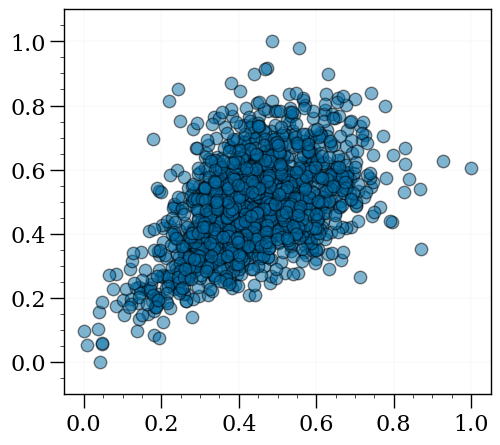

In [48]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [49]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [50]:
run(TrainingTensors, train_D, test_D, key, 'clayton_1')

  0%|          | 1/5000 [05:49<485:57:41, 349.96s/it]

Iter 0. Loss [[0.09688625 0.20545548 2.8502798 ]]


  0%|          | 11/5000 [11:50<10:42:15,  7.72s/it]

Iter 10. Loss [[0.09664641 0.20420687 2.8120768 ]]


  0%|          | 22/5000 [11:53<37:21,  2.22it/s]

Iter 20. Loss [[0.09640273 0.20292869 2.7755592 ]]


  1%|          | 31/5000 [11:55<18:01,  4.59it/s]

Iter 30. Loss [[0.0961513  0.20160496 2.7406766 ]]


  1%|          | 41/5000 [11:58<25:12,  3.28it/s]

Iter 40. Loss [[0.09589102 0.20022266 2.7072499 ]]


  1%|          | 51/5000 [12:00<18:01,  4.58it/s]

Iter 50. Loss [[0.09562486 0.19877738 2.6750386 ]]


  1%|          | 61/5000 [12:04<32:45,  2.51it/s]

Iter 60. Loss [[0.09535935 0.19727547 2.6438117 ]]


  1%|▏         | 71/5000 [12:06<17:42,  4.64it/s]

Iter 70. Loss [[0.09510227 0.19572994 2.6133864 ]]


  2%|▏         | 81/5000 [12:09<20:09,  4.07it/s]

Iter 80. Loss [[0.09486052 0.19415502 2.5836327 ]]


  2%|▏         | 91/5000 [12:11<17:17,  4.73it/s]

Iter 90. Loss [[0.09463919 0.19256218 2.5544648 ]]


  2%|▏         | 101/5000 [12:14<18:06,  4.51it/s]

Iter 100. Loss [[0.09444162 0.19095911 2.5258298 ]]


  2%|▏         | 111/5000 [12:17<27:31,  2.96it/s]

Iter 110. Loss [[0.09426972 0.18935023 2.497696  ]]


  2%|▏         | 122/5000 [12:20<17:49,  4.56it/s]

Iter 120. Loss [[0.09412488 0.1877377  2.4700472 ]]


  3%|▎         | 131/5000 [12:23<28:36,  2.84it/s]

Iter 130. Loss [[0.094008   0.18612252 2.4428744 ]]


  3%|▎         | 141/5000 [12:25<17:18,  4.68it/s]

Iter 140. Loss [[0.09391987 0.18450521 2.4161737 ]]


  3%|▎         | 151/5000 [12:27<24:52,  3.25it/s]

Iter 150. Loss [[0.09386138 0.18288623 2.3899431 ]]


  3%|▎         | 161/5000 [12:30<26:23,  3.06it/s]

Iter 160. Loss [[0.09383326 0.18126625 2.3641803 ]]


  3%|▎         | 171/5000 [12:34<23:45,  3.39it/s]

Iter 170. Loss [[0.09383634 0.17964607 2.338884  ]]


  4%|▎         | 181/5000 [12:36<17:00,  4.72it/s]

Iter 180. Loss [[0.09387133 0.17802668 2.314052  ]]


  4%|▍         | 192/5000 [12:39<17:48,  4.50it/s]

Iter 190. Loss [[0.0939389  0.17640914 2.289683  ]]


  4%|▍         | 201/5000 [12:41<16:46,  4.77it/s]

Iter 200. Loss [[0.09403965 0.17479469 2.2657747 ]]


  4%|▍         | 211/5000 [12:44<25:32,  3.13it/s]

Iter 210. Loss [[0.09417401 0.17318451 2.242325  ]]


  4%|▍         | 222/5000 [12:48<32:24,  2.46it/s]

Iter 220. Loss [[0.09434243 0.1715798  2.2193322 ]]


  5%|▍         | 231/5000 [12:50<17:19,  4.59it/s]

Iter 230. Loss [[0.0945451  0.16998175 2.1967945 ]]


  5%|▍         | 242/5000 [12:53<23:55,  3.31it/s]

Iter 240. Loss [[0.09478233 0.16839151 2.1747088 ]]


  5%|▌         | 251/5000 [12:55<16:57,  4.67it/s]

Iter 250. Loss [[0.09505417 0.16681024 2.1530738 ]]


  5%|▌         | 261/5000 [12:58<27:52,  2.83it/s]

Iter 260. Loss [[0.0953606 0.165239  2.131886 ]]


  5%|▌         | 271/5000 [13:01<26:53,  2.93it/s]

Iter 270. Loss [[0.09570156 0.16367887 2.111143  ]]


  6%|▌         | 281/5000 [13:04<20:33,  3.83it/s]

Iter 280. Loss [[0.09607688 0.16213086 2.0908415 ]]


  6%|▌         | 291/5000 [13:06<16:28,  4.77it/s]

Iter 290. Loss [[0.09648626 0.16059591 2.0709784 ]]


  6%|▌         | 301/5000 [13:09<18:14,  4.29it/s]

Iter 300. Loss [[0.09692936 0.15907495 2.0515497 ]]


  6%|▌         | 312/5000 [13:11<16:10,  4.83it/s]

Iter 310. Loss [[0.09740576 0.15756883 2.032552  ]]


  6%|▋         | 321/5000 [13:15<27:09,  2.87it/s]

Iter 320. Loss [[0.0979149  0.15607838 2.0139809 ]]


  7%|▋         | 331/5000 [13:18<33:02,  2.36it/s]

Iter 330. Loss [[0.09845623 0.15460439 1.995832  ]]


  7%|▋         | 341/5000 [13:20<16:46,  4.63it/s]

Iter 340. Loss [[0.09902906 0.15314753 1.9781015 ]]


  7%|▋         | 351/5000 [13:23<23:44,  3.26it/s]

Iter 350. Loss [[0.09963265 0.15170851 1.9607844 ]]


  7%|▋         | 361/5000 [13:25<16:42,  4.63it/s]

Iter 360. Loss [[0.10026621 0.15028796 1.9438763 ]]


  7%|▋         | 371/5000 [13:28<29:03,  2.65it/s]

Iter 370. Loss [[0.10092884 0.14888644 1.9273727 ]]


  8%|▊         | 381/5000 [13:31<18:10,  4.23it/s]

Iter 380. Loss [[0.10161957 0.14750451 1.9112691 ]]


  8%|▊         | 391/5000 [13:34<17:43,  4.33it/s]

Iter 390. Loss [[0.10233746 0.14614266 1.8955605 ]]


  8%|▊         | 401/5000 [13:36<15:56,  4.81it/s]

Iter 400. Loss [[0.10308142 0.1448014  1.880243  ]]


  8%|▊         | 412/5000 [13:39<16:17,  4.69it/s]

Iter 410. Loss [[0.10385029 0.1434811  1.8653121 ]]


  8%|▊         | 421/5000 [13:42<41:01,  1.86it/s]

Iter 420. Loss [[0.1046429  0.14218223 1.8507633 ]]


  9%|▊         | 431/5000 [13:45<19:49,  3.84it/s]

Iter 430. Loss [[0.10545797 0.14090516 1.8365934 ]]


  9%|▉         | 442/5000 [13:48<21:01,  3.61it/s]

Iter 440. Loss [[0.10629421 0.13965027 1.8227984 ]]


  9%|▉         | 451/5000 [13:49<16:22,  4.63it/s]

Iter 450. Loss [[0.10715024 0.13841791 1.8093749 ]]


  9%|▉         | 461/5000 [13:52<20:30,  3.69it/s]

Iter 460. Loss [[0.10802454 0.13720843 1.7963207 ]]


  9%|▉         | 471/5000 [13:54<18:33,  4.07it/s]

Iter 470. Loss [[0.10891563 0.13602217 1.7836318 ]]


 10%|▉         | 481/5000 [13:58<25:36,  2.94it/s]

Iter 480. Loss [[0.10982186 0.13485946 1.771307  ]]


 10%|▉         | 491/5000 [14:00<15:44,  4.77it/s]

Iter 490. Loss [[0.11074149 0.13372068 1.7593441 ]]


 10%|█         | 502/5000 [14:03<16:16,  4.61it/s]

Iter 500. Loss [[0.11167278 0.1326062  1.7477422 ]]


 10%|█         | 511/5000 [14:05<15:45,  4.75it/s]

Iter 510. Loss [[0.11261376 0.13151641 1.7365003 ]]


 10%|█         | 521/5000 [14:08<16:29,  4.53it/s]

Iter 520. Loss [[0.11356231 0.13045177 1.7256188 ]]


 11%|█         | 531/5000 [14:12<37:24,  1.99it/s]

Iter 530. Loss [[0.1145163  0.12941279 1.7150977 ]]


 11%|█         | 541/5000 [14:14<16:20,  4.55it/s]

Iter 540. Loss [[0.11547323 0.1284     1.7049384 ]]


 11%|█         | 551/5000 [14:17<19:20,  3.83it/s]

Iter 550. Loss [[0.11643051 0.12741408 1.6951432 ]]


 11%|█         | 561/5000 [14:19<15:42,  4.71it/s]

Iter 560. Loss [[0.11738521 0.1264558  1.6857148 ]]


 11%|█▏        | 572/5000 [14:22<16:23,  4.50it/s]

Iter 570. Loss [[0.11833413 0.12552609 1.6766566 ]]


 12%|█▏        | 581/5000 [14:25<23:45,  3.10it/s]

Iter 580. Loss [[0.11927356 0.12462608 1.6679736 ]]


 12%|█▏        | 592/5000 [14:28<16:31,  4.45it/s]

Iter 590. Loss [[0.12019929 0.12375717 1.6596717 ]]


 12%|█▏        | 601/5000 [14:31<30:09,  2.43it/s]

Iter 600. Loss [[0.12110639 0.12292115 1.6517575 ]]


 12%|█▏        | 612/5000 [14:33<15:28,  4.73it/s]

Iter 610. Loss [[0.12198891 0.12212026 1.6442392 ]]


 12%|█▏        | 621/5000 [14:36<22:26,  3.25it/s]

Iter 620. Loss [[0.12283973 0.12135746 1.6371263 ]]


 13%|█▎        | 631/5000 [14:38<23:06,  3.15it/s]

Iter 630. Loss [[0.12364972 0.12063674 1.6304283 ]]


 13%|█▎        | 641/5000 [14:42<21:19,  3.41it/s]

Iter 640. Loss [[0.12440745 0.11996336 1.6241543 ]]


 13%|█▎        | 651/5000 [14:44<15:10,  4.78it/s]

Iter 650. Loss [[0.12509798 0.11934461 1.6183108 ]]


 13%|█▎        | 661/5000 [14:47<17:04,  4.24it/s]

Iter 660. Loss [[0.12570234 0.11879024 1.6128949 ]]


 13%|█▎        | 671/5000 [14:49<15:17,  4.72it/s]

Iter 670. Loss [[0.12619783 0.11831252 1.6078843 ]]


 14%|█▎        | 681/5000 [14:52<21:49,  3.30it/s]

Iter 680. Loss [[0.12656368 0.11792377 1.6032254 ]]


 14%|█▍        | 691/5000 [14:55<24:15,  2.96it/s]

Iter 690. Loss [[0.12680049 0.11762576 1.5988533 ]]


 14%|█▍        | 701/5000 [14:58<15:48,  4.53it/s]

Iter 700. Loss [[0.12696235 0.11739104 1.5947882 ]]


 14%|█▍        | 712/5000 [15:01<21:27,  3.33it/s]

Iter 710. Loss [[0.12713449 0.11717218 1.5911276 ]]


 14%|█▍        | 721/5000 [15:03<15:12,  4.69it/s]

Iter 720. Loss [[0.12734468 0.1169506  1.5878398 ]]


 15%|█▍        | 731/5000 [15:06<22:51,  3.11it/s]

Iter 730. Loss [[0.12757556 0.11673228 1.5848128 ]]


 15%|█▍        | 741/5000 [15:09<24:06,  2.94it/s]

Iter 740. Loss [[0.12782566 0.11651465 1.582012  ]]


 15%|█▌        | 751/5000 [15:12<17:04,  4.15it/s]

Iter 750. Loss [[0.1280867  0.11629958 1.5794014 ]]


 15%|█▌        | 762/5000 [15:14<14:31,  4.86it/s]

Iter 760. Loss [[0.12834673 0.11609174 1.5769405 ]]


 15%|█▌        | 771/5000 [15:17<15:57,  4.42it/s]

Iter 770. Loss [[0.12860337 0.11589105 1.5746158 ]]


 16%|█▌        | 781/5000 [15:19<29:22,  2.39it/s]

Iter 780. Loss [[0.12885314 0.11569861 1.5724092 ]]


 16%|█▌        | 791/5000 [15:23<24:13,  2.90it/s]

Iter 790. Loss [[0.12909539 0.11551417 1.5703108 ]]


 16%|█▌        | 801/5000 [15:26<22:12,  3.15it/s]

Iter 800. Loss [[0.12933014 0.11533734 1.5683136 ]]


 16%|█▌        | 812/5000 [15:28<14:31,  4.80it/s]

Iter 810. Loss [[0.12955736 0.11516791 1.5664103 ]]


 16%|█▋        | 822/5000 [15:31<16:35,  4.20it/s]

Iter 820. Loss [[0.12977748 0.11500531 1.5645963 ]]


 17%|█▋        | 832/5000 [15:33<14:22,  4.83it/s]

Iter 830. Loss [[0.12999038 0.11484942 1.5628663 ]]


 17%|█▋        | 841/5000 [15:36<25:16,  2.74it/s]

Iter 840. Loss [[0.13019626 0.11469989 1.561216  ]]


 17%|█▋        | 852/5000 [15:39<15:17,  4.52it/s]

Iter 850. Loss [[0.13039503 0.1145566  1.5596404 ]]


 17%|█▋        | 861/5000 [15:42<15:41,  4.40it/s]

Iter 860. Loss [[0.13058671 0.1144193  1.5581363 ]]


 17%|█▋        | 871/5000 [15:44<14:36,  4.71it/s]

Iter 870. Loss [[0.13077131 0.1142878  1.5566999 ]]


 18%|█▊        | 881/5000 [15:47<15:21,  4.47it/s]

Iter 880. Loss [[0.13094889 0.11416198 1.5553278 ]]


 18%|█▊        | 891/5000 [15:50<31:43,  2.16it/s]

Iter 890. Loss [[0.13111952 0.11404165 1.554017  ]]


 18%|█▊        | 901/5000 [15:53<17:54,  3.81it/s]

Iter 900. Loss [[0.13128343 0.11392653 1.552765  ]]


 18%|█▊        | 911/5000 [15:56<19:10,  3.55it/s]

Iter 910. Loss [[0.13144056 0.11381654 1.551569  ]]


 18%|█▊        | 921/5000 [15:58<14:15,  4.77it/s]

Iter 920. Loss [[0.13159117 0.11371147 1.5504261 ]]


 19%|█▊        | 931/5000 [16:00<17:12,  3.94it/s]

Iter 930. Loss [[0.13173555 0.11361106 1.5493351 ]]


 19%|█▉        | 941/5000 [16:03<15:50,  4.27it/s]

Iter 940. Loss [[0.13187371 0.11351526 1.5482923 ]]


 19%|█▉        | 952/5000 [16:07<20:04,  3.36it/s]

Iter 950. Loss [[0.13200599 0.11342374 1.5472972 ]]


 19%|█▉        | 962/5000 [16:09<14:11,  4.74it/s]

Iter 960. Loss [[0.1321324  0.11333649 1.5463471 ]]


 19%|█▉        | 971/5000 [16:11<14:45,  4.55it/s]

Iter 970. Loss [[0.13225324 0.11325321 1.5454397 ]]


 20%|█▉        | 982/5000 [16:14<22:49,  2.93it/s]

Iter 980. Loss [[0.13236874 0.11317378 1.5445743 ]]


 20%|█▉        | 991/5000 [16:16<14:28,  4.62it/s]

Iter 990. Loss [[0.13247907 0.11309807 1.5437481 ]]


 20%|██        | 1001/5000 [16:20<30:35,  2.18it/s]

Iter 1000. Loss [[0.13258445 0.11302586 1.5429599 ]]


 20%|██        | 1012/5000 [16:23<14:10,  4.69it/s]

Iter 1010. Loss [[0.132685   0.11295705 1.5422083 ]]


 20%|██        | 1021/5000 [16:25<18:27,  3.59it/s]

Iter 1020. Loss [[0.13278098 0.11289147 1.5414919 ]]


 21%|██        | 1031/5000 [16:27<14:13,  4.65it/s]

Iter 1030. Loss [[0.13287261 0.11282898 1.5408086 ]]


 21%|██        | 1041/5000 [16:30<15:53,  4.15it/s]

Iter 1040. Loss [[0.13296    0.11276944 1.5401576 ]]


 21%|██        | 1051/5000 [16:33<21:56,  3.00it/s]

Iter 1050. Loss [[0.1330433  0.11271277 1.539537  ]]


 21%|██        | 1061/5000 [16:36<15:52,  4.14it/s]

Iter 1060. Loss [[0.13312286 0.11265872 1.5389462 ]]


 21%|██▏       | 1071/5000 [16:38<13:39,  4.80it/s]

Iter 1070. Loss [[0.13319862 0.11260732 1.5383835 ]]


 22%|██▏       | 1081/5000 [16:41<14:13,  4.59it/s]

Iter 1080. Loss [[0.13327086 0.11255835 1.5378475 ]]


 22%|██▏       | 1091/5000 [16:44<22:50,  2.85it/s]

Iter 1090. Loss [[0.1333398  0.11251169 1.5373377 ]]


 22%|██▏       | 1101/5000 [16:47<21:12,  3.06it/s]

Iter 1100. Loss [[0.13340545 0.11246735 1.536852  ]]


 22%|██▏       | 1112/5000 [16:50<18:51,  3.43it/s]

Iter 1110. Loss [[0.1334681  0.11242507 1.5363907 ]]


 22%|██▏       | 1121/5000 [16:52<13:38,  4.74it/s]

Iter 1120. Loss [[0.13352773 0.11238488 1.5359515 ]]


 23%|██▎       | 1132/5000 [16:55<15:31,  4.15it/s]

Iter 1130. Loss [[0.13358465 0.11234659 1.5355341 ]]


 23%|██▎       | 1141/5000 [16:57<14:04,  4.57it/s]

Iter 1140. Loss [[0.13363883 0.11231017 1.5351373 ]]


 23%|██▎       | 1151/5000 [17:00<21:00,  3.05it/s]

Iter 1150. Loss [[0.1336905  0.11227554 1.5347602 ]]


 23%|██▎       | 1161/5000 [17:04<20:28,  3.12it/s]

Iter 1160. Loss [[0.13373975 0.11224255 1.534402  ]]


 23%|██▎       | 1172/5000 [17:07<13:53,  4.59it/s]

Iter 1170. Loss [[0.13378662 0.11221123 1.534062  ]]


 24%|██▎       | 1181/5000 [17:09<21:56,  2.90it/s]

Iter 1180. Loss [[0.13383125 0.1121814  1.533739  ]]


 24%|██▍       | 1191/5000 [17:11<13:31,  4.69it/s]

Iter 1190. Loss [[0.13387391 0.112153   1.5334326 ]]


 24%|██▍       | 1201/5000 [17:14<21:08,  2.99it/s]

Iter 1200. Loss [[0.13391446 0.11212606 1.5331419 ]]


 24%|██▍       | 1211/5000 [17:18<21:45,  2.90it/s]

Iter 1210. Loss [[0.13395311 0.11210038 1.5328659 ]]


 24%|██▍       | 1221/5000 [17:20<15:40,  4.02it/s]

Iter 1220. Loss [[0.1339899  0.11207602 1.5326041 ]]


 25%|██▍       | 1231/5000 [17:22<13:08,  4.78it/s]

Iter 1230. Loss [[0.13402504 0.11205281 1.5323561 ]]


 25%|██▍       | 1242/5000 [17:25<13:41,  4.58it/s]

Iter 1240. Loss [[0.13405836 0.11203079 1.5321207 ]]


 25%|██▌       | 1251/5000 [17:27<13:15,  4.71it/s]

Iter 1250. Loss [[0.13409029 0.11200982 1.5318983 ]]


 25%|██▌       | 1261/5000 [17:31<21:30,  2.90it/s]

Iter 1260. Loss [[0.13412052 0.11198995 1.5316871 ]]


 25%|██▌       | 1272/5000 [17:35<21:33,  2.88it/s]

Iter 1270. Loss [[0.13414942 0.11197101 1.5314873 ]]


 26%|██▌       | 1281/5000 [17:36<13:30,  4.59it/s]

Iter 1280. Loss [[0.13417695 0.11195302 1.5312983 ]]


 26%|██▌       | 1291/5000 [17:39<19:11,  3.22it/s]

Iter 1290. Loss [[0.13420306 0.111936   1.5311195 ]]


 26%|██▌       | 1301/5000 [17:41<13:04,  4.71it/s]

Iter 1300. Loss [[0.13422799 0.11191976 1.5309498 ]]


 26%|██▌       | 1311/5000 [17:45<23:16,  2.64it/s]

Iter 1310. Loss [[0.13425177 0.11190436 1.5307899 ]]


 26%|██▋       | 1321/5000 [17:48<14:22,  4.26it/s]

Iter 1320. Loss [[0.13427441 0.11188971 1.5306383 ]]


 27%|██▋       | 1331/5000 [17:50<15:03,  4.06it/s]

Iter 1330. Loss [[0.13429587 0.11187583 1.5304953 ]]


 27%|██▋       | 1342/5000 [17:53<12:44,  4.78it/s]

Iter 1340. Loss [[0.13431643 0.11186262 1.53036   ]]


 27%|██▋       | 1351/5000 [17:55<13:50,  4.39it/s]

Iter 1350. Loss [[0.1343359  0.11185012 1.5302322 ]]


 27%|██▋       | 1361/5000 [17:58<18:08,  3.34it/s]

Iter 1360. Loss [[0.13435444 0.11183824 1.5301117 ]]


 27%|██▋       | 1372/5000 [18:02<15:00,  4.03it/s]

Iter 1370. Loss [[0.1343722  0.11182693 1.5299981 ]]


 28%|██▊       | 1381/5000 [18:04<20:58,  2.87it/s]

Iter 1380. Loss [[0.13438895 0.11181626 1.52989   ]]


 28%|██▊       | 1391/5000 [18:06<12:53,  4.67it/s]

Iter 1390. Loss [[0.13440497 0.11180611 1.5297887 ]]


 28%|██▊       | 1402/5000 [18:09<15:11,  3.95it/s]

Iter 1400. Loss [[0.13442023 0.11179648 1.5296934 ]]


 28%|██▊       | 1411/5000 [18:11<14:03,  4.26it/s]

Iter 1410. Loss [[0.13443474 0.11178733 1.5296035 ]]


 28%|██▊       | 1422/5000 [18:15<19:10,  3.11it/s]

Iter 1420. Loss [[0.13444845 0.1117787  1.5295182 ]]


 29%|██▊       | 1431/5000 [18:17<12:39,  4.70it/s]

Iter 1430. Loss [[0.13446163 0.11177047 1.5294385 ]]


 29%|██▉       | 1441/5000 [18:20<14:03,  4.22it/s]

Iter 1440. Loss [[0.13447411 0.11176269 1.5293629 ]]


 29%|██▉       | 1451/5000 [18:22<12:32,  4.72it/s]

Iter 1450. Loss [[0.13448597 0.1117553  1.5292923 ]]


 29%|██▉       | 1461/5000 [18:25<12:59,  4.54it/s]

Iter 1460. Loss [[0.1344973  0.11174829 1.5292257 ]]


 29%|██▉       | 1471/5000 [18:29<29:28,  2.00it/s]

Iter 1470. Loss [[0.13450795 0.11174168 1.5291629 ]]


 30%|██▉       | 1481/5000 [18:31<13:01,  4.50it/s]

Iter 1480. Loss [[0.13451819 0.11173541 1.5291039 ]]


 30%|██▉       | 1491/5000 [18:34<17:41,  3.30it/s]

Iter 1490. Loss [[0.13452797 0.11172944 1.5290487 ]]


 30%|███       | 1501/5000 [18:36<12:23,  4.71it/s]

Iter 1500. Loss [[0.13453718 0.1117238  1.5289963 ]]


 30%|███       | 1511/5000 [18:39<14:05,  4.13it/s]

Iter 1510. Loss [[0.13454589 0.11171848 1.5289476 ]]


 30%|███       | 1521/5000 [18:41<18:55,  3.06it/s]

Iter 1520. Loss [[0.1345543  0.11171342 1.5289018 ]]


 31%|███       | 1531/5000 [18:45<14:34,  3.97it/s]

Iter 1530. Loss [[0.13456222 0.11170863 1.5288584 ]]


 31%|███       | 1542/5000 [18:47<12:06,  4.76it/s]

Iter 1540. Loss [[0.13456972 0.11170412 1.5288181 ]]


 31%|███       | 1551/5000 [18:50<12:50,  4.47it/s]

Iter 1550. Loss [[0.13457693 0.1116998  1.5287805 ]]


 31%|███       | 1561/5000 [18:52<12:07,  4.73it/s]

Iter 1560. Loss [[0.13458367 0.11169578 1.5287448 ]]


 31%|███▏      | 1571/5000 [18:55<18:18,  3.12it/s]

Iter 1570. Loss [[0.13459016 0.11169194 1.5287117 ]]


 32%|███▏      | 1581/5000 [18:59<24:17,  2.35it/s]

Iter 1580. Loss [[0.13459635 0.11168829 1.5286803 ]]


 32%|███▏      | 1592/5000 [19:01<11:58,  4.74it/s]

Iter 1590. Loss [[0.13460222 0.11168484 1.5286515 ]]


 32%|███▏      | 1601/5000 [19:04<15:34,  3.64it/s]

Iter 1600. Loss [[0.1346077  0.11168162 1.528624  ]]


 32%|███▏      | 1611/5000 [19:06<11:53,  4.75it/s]

Iter 1610. Loss [[0.13461304 0.1116785  1.5285989 ]]


 32%|███▏      | 1621/5000 [19:09<16:53,  3.33it/s]

Iter 1620. Loss [[0.13461803 0.11167562 1.5285748 ]]


 33%|███▎      | 1631/5000 [19:12<19:06,  2.94it/s]

Iter 1630. Loss [[0.13462286 0.11167283 1.528553  ]]


 33%|███▎      | 1641/5000 [19:15<12:32,  4.46it/s]

Iter 1640. Loss [[0.13462734 0.11167025 1.528532  ]]


 33%|███▎      | 1651/5000 [19:18<22:56,  2.43it/s]

Iter 1650. Loss [[0.13463163 0.11166778 1.5285127 ]]


 33%|███▎      | 1662/5000 [19:20<11:46,  4.72it/s]

Iter 1660. Loss [[0.13463575 0.11166546 1.5284945 ]]


 33%|███▎      | 1671/5000 [19:22<15:55,  3.48it/s]

Iter 1670. Loss [[0.13463962 0.11166327 1.5284777 ]]


 34%|███▎      | 1681/5000 [19:26<18:40,  2.96it/s]

Iter 1680. Loss [[0.13464332 0.1116612  1.5284622 ]]


 34%|███▍      | 1692/5000 [19:29<13:04,  4.22it/s]

Iter 1690. Loss [[0.1346468  0.11165923 1.5284477 ]]


 34%|███▍      | 1702/5000 [19:31<11:28,  4.79it/s]

Iter 1700. Loss [[0.13465016 0.11165736 1.528434  ]]


 34%|███▍      | 1711/5000 [19:34<12:20,  4.44it/s]

Iter 1710. Loss [[0.13465329 0.11165564 1.5284215 ]]


 34%|███▍      | 1721/5000 [19:36<11:28,  4.77it/s]

Iter 1720. Loss [[0.13465634 0.11165395 1.5284098 ]]


 35%|███▍      | 1731/5000 [19:40<18:54,  2.88it/s]

Iter 1730. Loss [[0.13465913 0.11165238 1.5283989 ]]


 35%|███▍      | 1741/5000 [19:43<22:58,  2.36it/s]

Iter 1740. Loss [[0.13466187 0.11165092 1.5283886 ]]


 35%|███▌      | 1751/5000 [19:45<11:36,  4.67it/s]

Iter 1750. Loss [[0.13466437 0.11164954 1.5283792 ]]


 35%|███▌      | 1761/5000 [19:48<18:52,  2.86it/s]

Iter 1760. Loss [[0.13466685 0.11164821 1.5283707 ]]


 35%|███▌      | 1771/5000 [19:50<11:27,  4.69it/s]

Iter 1770. Loss [[0.1346692  0.11164696 1.5283626 ]]


 36%|███▌      | 1781/5000 [19:53<20:51,  2.57it/s]

Iter 1780. Loss [[0.13467133 0.11164581 1.5283551 ]]


 36%|███▌      | 1791/5000 [19:56<13:18,  4.02it/s]

Iter 1790. Loss [[0.13467342 0.11164469 1.5283483 ]]


 36%|███▌      | 1801/5000 [19:59<12:27,  4.28it/s]

Iter 1800. Loss [[0.1346755 0.1116436 1.5283421]]


 36%|███▌      | 1811/5000 [20:01<11:02,  4.81it/s]

Iter 1810. Loss [[0.13467728 0.11164265 1.5283363 ]]


 36%|███▋      | 1821/5000 [20:03<11:46,  4.50it/s]

Iter 1820. Loss [[0.13467906 0.11164174 1.5283307 ]]


 37%|███▋      | 1831/5000 [20:06<13:23,  3.95it/s]

Iter 1830. Loss [[0.13468081 0.11164083 1.528326  ]]


 37%|███▋      | 1842/5000 [20:10<14:11,  3.71it/s]

Iter 1840. Loss [[0.13468248 0.11163998 1.5283216 ]]


 37%|███▋      | 1852/5000 [20:13<14:30,  3.62it/s]

Iter 1850. Loss [[0.13468397 0.11163923 1.5283172 ]]


 37%|███▋      | 1861/5000 [20:14<10:59,  4.76it/s]

Iter 1860. Loss [[0.13468541 0.11163846 1.5283132 ]]


 37%|███▋      | 1871/5000 [20:17<13:19,  3.91it/s]

Iter 1870. Loss [[0.13468684 0.11163776 1.5283097 ]]


 38%|███▊      | 1881/5000 [20:19<10:54,  4.76it/s]

Iter 1880. Loss [[0.13468808 0.11163712 1.5283062 ]]


 38%|███▊      | 1891/5000 [20:23<19:28,  2.66it/s]

Iter 1890. Loss [[0.13468938 0.1116365  1.5283035 ]]


 38%|███▊      | 1901/5000 [20:25<11:04,  4.66it/s]

Iter 1900. Loss [[0.13469067 0.11163584 1.5283009 ]]


 38%|███▊      | 1911/5000 [20:28<11:36,  4.44it/s]

Iter 1910. Loss [[0.13469169 0.11163533 1.5282984 ]]


 38%|███▊      | 1921/5000 [20:30<10:38,  4.82it/s]

Iter 1920. Loss [[0.13469271 0.11163483 1.5282962 ]]


 39%|███▊      | 1931/5000 [20:33<11:11,  4.57it/s]

Iter 1930. Loss [[0.13469373 0.11163434 1.528294  ]]


 39%|███▉      | 1941/5000 [20:37<25:22,  2.01it/s]

Iter 1940. Loss [[0.13469471 0.11163385 1.5282923 ]]


 39%|███▉      | 1951/5000 [20:39<11:26,  4.44it/s]

Iter 1950. Loss [[0.13469562 0.1116334  1.5282904 ]]


 39%|███▉      | 1961/5000 [20:42<14:06,  3.59it/s]

Iter 1960. Loss [[0.13469651 0.11163297 1.5282891 ]]


 39%|███▉      | 1972/5000 [20:44<10:31,  4.80it/s]

Iter 1970. Loss [[0.13469735 0.11163257 1.5282874 ]]


 40%|███▉      | 1981/5000 [20:47<12:14,  4.11it/s]

Iter 1980. Loss [[0.13469805 0.11163224 1.5282865 ]]


 40%|███▉      | 1991/5000 [20:49<15:52,  3.16it/s]

Iter 1990. Loss [[0.13469881 0.11163189 1.5282851 ]]


 40%|████      | 2002/5000 [20:53<11:51,  4.21it/s]

Iter 2000. Loss [[0.13469964 0.11163151 1.5282843 ]]


 40%|████      | 2011/5000 [20:55<10:23,  4.79it/s]

Iter 2010. Loss [[0.13470024 0.11163121 1.5282834 ]]


 40%|████      | 2021/5000 [20:58<10:47,  4.60it/s]

Iter 2020. Loss [[0.13470086 0.11163093 1.5282826 ]]


 41%|████      | 2031/5000 [21:01<20:03,  2.47it/s]

Iter 2030. Loss [[0.13470154 0.11163063 1.5282819 ]]


 41%|████      | 2041/5000 [21:03<13:57,  3.53it/s]

Iter 2040. Loss [[0.13470209 0.11163039 1.5282812 ]]


 41%|████      | 2051/5000 [21:07<19:11,  2.56it/s]

Iter 2050. Loss [[0.13470262 0.11163015 1.5282807 ]]


 41%|████      | 2061/5000 [21:09<10:26,  4.69it/s]

Iter 2060. Loss [[0.13470322 0.11162986 1.5282803 ]]


 41%|████▏     | 2071/5000 [21:12<12:39,  3.85it/s]

Iter 2070. Loss [[0.13470368 0.11162964 1.5282797 ]]


 42%|████▏     | 2081/5000 [21:14<10:09,  4.79it/s]

Iter 2080. Loss [[0.13470411 0.11162946 1.5282793 ]]


 42%|████▏     | 2091/5000 [21:16<12:23,  3.91it/s]

Iter 2090. Loss [[0.13470452 0.11162928 1.528279  ]]


 42%|████▏     | 2101/5000 [21:20<16:34,  2.91it/s]

Iter 2100. Loss [[0.13470495 0.11162909 1.528279  ]]


 42%|████▏     | 2111/5000 [21:23<11:19,  4.25it/s]

Iter 2110. Loss [[0.13470547 0.11162887 1.528279  ]]


 42%|████▏     | 2121/5000 [21:25<10:06,  4.75it/s]

Iter 2120. Loss [[0.13470589 0.11162868 1.5282786 ]]


 43%|████▎     | 2131/5000 [21:28<10:31,  4.54it/s]

Iter 2130. Loss [[0.13470611 0.11162856 1.5282784 ]]


 43%|████▎     | 2141/5000 [21:30<16:33,  2.88it/s]

Iter 2140. Loss [[0.13470647 0.11162843 1.528278  ]]


 43%|████▎     | 2151/5000 [21:34<16:09,  2.94it/s]

Iter 2150. Loss [[0.13470672 0.11162832 1.528278  ]]


 43%|████▎     | 2161/5000 [21:37<14:14,  3.32it/s]

Iter 2160. Loss [[0.13470708 0.11162815 1.528278  ]]


 43%|████▎     | 2171/5000 [21:39<09:54,  4.76it/s]

Iter 2170. Loss [[0.13470744 0.11162799 1.5282781 ]]


 44%|████▎     | 2181/5000 [21:42<11:14,  4.18it/s]

Iter 2180. Loss [[0.1347077  0.11162788 1.528278  ]]


 44%|████▍     | 2191/5000 [21:44<09:40,  4.84it/s]

Iter 2190. Loss [[0.13470791 0.11162781 1.528278  ]]


 44%|████▍     | 2201/5000 [21:47<16:08,  2.89it/s]

Iter 2200. Loss [[0.1347082  0.11162771 1.5282779 ]]


 44%|████▍     | 2211/5000 [21:50<11:43,  3.96it/s]

Iter 2210. Loss [[0.13470848 0.11162757 1.528278  ]]


 44%|████▍     | 2221/5000 [21:53<10:00,  4.63it/s]

Iter 2220. Loss [[0.13470878 0.11162746 1.528278  ]]


 45%|████▍     | 2231/5000 [21:56<15:58,  2.89it/s]

Iter 2230. Loss [[0.134709   0.11162736 1.5282781 ]]


 45%|████▍     | 2241/5000 [21:58<09:51,  4.67it/s]

Iter 2240. Loss [[0.13470913 0.1116273  1.5282784 ]]


 45%|████▌     | 2251/5000 [22:01<16:57,  2.70it/s]

Iter 2250. Loss [[0.13470931 0.11162724 1.5282781 ]]


 45%|████▌     | 2262/5000 [22:04<11:55,  3.83it/s]

Iter 2260. Loss [[0.13470949 0.11162717 1.5282781 ]]


 45%|████▌     | 2272/5000 [22:07<10:23,  4.37it/s]

Iter 2270. Loss [[0.1347097  0.11162709 1.5282785 ]]


 46%|████▌     | 2282/5000 [22:09<09:26,  4.80it/s]

Iter 2280. Loss [[0.13470995 0.11162698 1.5282786 ]]


 46%|████▌     | 2291/5000 [22:12<10:34,  4.27it/s]

Iter 2290. Loss [[0.13471007 0.11162693 1.5282784 ]]


 46%|████▌     | 2301/5000 [22:14<09:15,  4.86it/s]

Iter 2300. Loss [[0.13471025 0.11162685 1.5282786 ]]


 46%|████▌     | 2311/5000 [22:18<15:48,  2.83it/s]

Iter 2310. Loss [[0.13471036 0.11162681 1.5282786 ]]


 46%|████▋     | 2321/5000 [22:21<18:31,  2.41it/s]

Iter 2320. Loss [[0.13471046 0.11162677 1.528279  ]]


 47%|████▋     | 2331/5000 [22:23<09:28,  4.69it/s]

Iter 2330. Loss [[0.13471061 0.11162671 1.528279  ]]


 47%|████▋     | 2341/5000 [22:25<13:30,  3.28it/s]

Iter 2340. Loss [[0.13471067 0.11162668 1.528279  ]]


 47%|████▋     | 2351/5000 [22:28<09:20,  4.72it/s]

Iter 2350. Loss [[0.13471083 0.1116266  1.528279  ]]


 47%|████▋     | 2361/5000 [22:31<16:50,  2.61it/s]

Iter 2360. Loss [[0.13471097 0.11162657 1.5282793 ]]


 47%|████▋     | 2372/5000 [22:34<09:27,  4.63it/s]

Iter 2370. Loss [[0.13471106 0.11162653 1.5282793 ]]


 48%|████▊     | 2381/5000 [22:36<10:29,  4.16it/s]

Iter 2380. Loss [[0.13471115 0.11162651 1.5282794 ]]


 48%|████▊     | 2391/5000 [22:39<09:06,  4.78it/s]

Iter 2390. Loss [[0.13471125 0.11162645 1.5282793 ]]


 48%|████▊     | 2401/5000 [22:41<09:39,  4.48it/s]

Iter 2400. Loss [[0.1347113  0.11162643 1.5282793 ]]


 48%|████▊     | 2411/5000 [22:44<13:26,  3.21it/s]

Iter 2410. Loss [[0.13471143 0.11162638 1.5282797 ]]


 48%|████▊     | 2421/5000 [22:48<10:48,  3.98it/s]

Iter 2420. Loss [[0.13471141 0.11162642 1.5282794 ]]


 49%|████▊     | 2431/5000 [22:50<17:34,  2.44it/s]

Iter 2430. Loss [[0.13471146 0.11162639 1.5282794 ]]


 49%|████▉     | 2441/5000 [22:52<09:15,  4.61it/s]

Iter 2440. Loss [[0.13471155 0.11162636 1.5282797 ]]


 49%|████▉     | 2451/5000 [22:55<12:59,  3.27it/s]

Iter 2450. Loss [[0.13471162 0.11162632 1.5282799 ]]


 49%|████▉     | 2461/5000 [22:57<12:09,  3.48it/s]

Iter 2460. Loss [[0.13471182 0.11162624 1.5282799 ]]


 49%|████▉     | 2471/5000 [23:01<13:54,  3.03it/s]

Iter 2470. Loss [[0.13471189 0.11162622 1.5282801 ]]


 50%|████▉     | 2481/5000 [23:03<08:49,  4.76it/s]

Iter 2480. Loss [[0.13471194 0.1116262  1.5282803 ]]


 50%|████▉     | 2491/5000 [23:06<09:40,  4.32it/s]

Iter 2490. Loss [[0.13471194 0.1116262  1.5282803 ]]


 50%|█████     | 2501/5000 [23:08<08:32,  4.87it/s]

Iter 2500. Loss [[0.13471203 0.11162617 1.5282803 ]]


 50%|█████     | 2511/5000 [23:11<09:11,  4.51it/s]

Iter 2510. Loss [[0.13471214 0.11162612 1.5282806 ]]


 50%|█████     | 2521/5000 [23:15<23:25,  1.76it/s]

Iter 2520. Loss [[0.13471214 0.11162612 1.5282804 ]]


 51%|█████     | 2531/5000 [23:17<09:06,  4.52it/s]

Iter 2530. Loss [[0.13471231 0.11162606 1.5282806 ]]


 51%|█████     | 2541/5000 [23:20<12:31,  3.27it/s]

Iter 2540. Loss [[0.13471231 0.11162606 1.5282809 ]]


 51%|█████     | 2551/5000 [23:22<08:28,  4.82it/s]

Iter 2550. Loss [[0.13471231 0.11162604 1.5282809 ]]


 51%|█████     | 2561/5000 [23:25<11:16,  3.61it/s]

Iter 2560. Loss [[0.13471231 0.11162606 1.5282807 ]]


 51%|█████▏    | 2571/5000 [23:28<13:26,  3.01it/s]

Iter 2570. Loss [[0.13471231 0.11162607 1.5282806 ]]


 52%|█████▏    | 2581/5000 [23:31<10:13,  3.94it/s]

Iter 2580. Loss [[0.13471232 0.11162606 1.5282807 ]]


 52%|█████▏    | 2591/5000 [23:33<08:22,  4.80it/s]

Iter 2590. Loss [[0.13471231 0.11162607 1.5282806 ]]


 52%|█████▏    | 2601/5000 [23:36<09:13,  4.34it/s]

Iter 2600. Loss [[0.13471232 0.11162606 1.5282806 ]]


 52%|█████▏    | 2611/5000 [23:38<08:24,  4.73it/s]

Iter 2610. Loss [[0.1347124  0.11162603 1.5282806 ]]


 52%|█████▏    | 2621/5000 [23:41<13:00,  3.05it/s]

Iter 2620. Loss [[0.13471244 0.11162601 1.5282809 ]]


 53%|█████▎    | 2632/5000 [23:45<13:31,  2.92it/s]

Iter 2630. Loss [[0.13471246 0.11162601 1.5282809 ]]


 53%|█████▎    | 2641/5000 [23:47<08:29,  4.63it/s]

Iter 2640. Loss [[0.13471255 0.11162595 1.5282809 ]]


 53%|█████▎    | 2651/5000 [23:50<11:00,  3.55it/s]

Iter 2650. Loss [[0.13471253 0.11162598 1.5282812 ]]


 53%|█████▎    | 2661/5000 [23:52<08:11,  4.76it/s]

Iter 2660. Loss [[0.13471255 0.11162596 1.5282811 ]]


 53%|█████▎    | 2671/5000 [23:55<12:55,  3.00it/s]

Iter 2670. Loss [[0.13471262 0.11162593 1.5282811 ]]


 54%|█████▎    | 2681/5000 [23:58<12:55,  2.99it/s]

Iter 2680. Loss [[0.13471259 0.11162595 1.5282812 ]]


 54%|█████▍    | 2691/5000 [24:01<08:47,  4.37it/s]

Iter 2690. Loss [[0.13471267 0.11162592 1.5282812 ]]


 54%|█████▍    | 2701/5000 [24:03<08:10,  4.69it/s]

Iter 2700. Loss [[0.13471259 0.11162595 1.5282811 ]]


 54%|█████▍    | 2712/5000 [24:06<08:16,  4.61it/s]

Iter 2710. Loss [[0.13471256 0.11162595 1.5282809 ]]


 54%|█████▍    | 2721/5000 [24:09<16:48,  2.26it/s]

Iter 2720. Loss [[0.13471262 0.11162593 1.5282811 ]]


 55%|█████▍    | 2731/5000 [24:12<13:07,  2.88it/s]

Iter 2730. Loss [[0.13471262 0.11162595 1.5282811 ]]


 55%|█████▍    | 2742/5000 [24:15<10:28,  3.59it/s]

Iter 2740. Loss [[0.13471262 0.11162593 1.5282809 ]]


 55%|█████▌    | 2751/5000 [24:17<08:00,  4.68it/s]

Iter 2750. Loss [[0.13471262 0.11162593 1.5282812 ]]


 55%|█████▌    | 2761/5000 [24:20<09:51,  3.78it/s]

Iter 2760. Loss [[0.1347127  0.11162592 1.5282812 ]]


 55%|█████▌    | 2771/5000 [24:22<07:54,  4.70it/s]

Iter 2770. Loss [[0.13471265 0.11162593 1.5282815 ]]


 56%|█████▌    | 2781/5000 [24:26<13:21,  2.77it/s]

Iter 2780. Loss [[0.13471265 0.11162593 1.5282812 ]]


 56%|█████▌    | 2791/5000 [24:28<08:09,  4.52it/s]

Iter 2790. Loss [[0.13471273 0.11162589 1.5282816 ]]


 56%|█████▌    | 2802/5000 [24:31<07:51,  4.67it/s]

Iter 2800. Loss [[0.13471273 0.1116259  1.5282812 ]]


 56%|█████▌    | 2811/5000 [24:34<13:03,  2.79it/s]

Iter 2810. Loss [[0.13471282 0.11162587 1.5282816 ]]


 56%|█████▋    | 2821/5000 [24:36<07:47,  4.66it/s]

Iter 2820. Loss [[0.13471282 0.11162587 1.5282812 ]]


 57%|█████▋    | 2831/5000 [24:40<13:49,  2.62it/s]

Iter 2830. Loss [[0.13471282 0.11162587 1.5282812 ]]


 57%|█████▋    | 2841/5000 [24:42<08:22,  4.30it/s]

Iter 2840. Loss [[0.13471282 0.11162587 1.5282812 ]]


 57%|█████▋    | 2851/5000 [24:45<08:29,  4.22it/s]

Iter 2850. Loss [[0.13471282 0.11162587 1.5282812 ]]


 57%|█████▋    | 2861/5000 [24:47<07:44,  4.60it/s]

Iter 2860. Loss [[0.13471282 0.11162589 1.5282815 ]]


 57%|█████▋    | 2871/5000 [24:50<07:57,  4.46it/s]

Iter 2870. Loss [[0.13471276 0.11162589 1.5282812 ]]


 58%|█████▊    | 2881/5000 [24:54<19:50,  1.78it/s]

Iter 2880. Loss [[0.13471282 0.11162587 1.5282816 ]]


 58%|█████▊    | 2891/5000 [24:56<08:40,  4.05it/s]

Iter 2890. Loss [[0.13471273 0.1116259  1.5282812 ]]


 58%|█████▊    | 2901/5000 [24:59<12:35,  2.78it/s]

Iter 2900. Loss [[0.13471276 0.11162589 1.5282812 ]]


 58%|█████▊    | 2911/5000 [25:01<07:33,  4.60it/s]

Iter 2910. Loss [[0.1347127  0.11162592 1.5282812 ]]


 58%|█████▊    | 2922/5000 [25:04<09:01,  3.84it/s]

Iter 2920. Loss [[0.13471282 0.11162587 1.5282815 ]]


 59%|█████▊    | 2931/5000 [25:07<10:33,  3.27it/s]

Iter 2930. Loss [[0.13471287 0.11162584 1.5282816 ]]


 59%|█████▉    | 2941/5000 [25:10<10:13,  3.36it/s]

Iter 2940. Loss [[0.13471292 0.11162582 1.5282819 ]]


 59%|█████▉    | 2951/5000 [25:13<07:21,  4.64it/s]

Iter 2950. Loss [[0.13471287 0.11162585 1.5282816 ]]


 59%|█████▉    | 2961/5000 [25:15<07:44,  4.39it/s]

Iter 2960. Loss [[0.13471285 0.11162585 1.5282816 ]]


 59%|█████▉    | 2971/5000 [25:18<07:22,  4.58it/s]

Iter 2970. Loss [[0.13471282 0.11162589 1.5282816 ]]


 60%|█████▉    | 2981/5000 [25:21<10:13,  3.29it/s]

Iter 2980. Loss [[0.13471283 0.11162587 1.5282816 ]]


 60%|█████▉    | 2991/5000 [25:25<15:19,  2.19it/s]

Iter 2990. Loss [[0.13471283 0.11162587 1.5282816 ]]


 60%|██████    | 3001/5000 [25:27<07:22,  4.52it/s]

Iter 3000. Loss [[0.13471282 0.11162587 1.5282816 ]]


 60%|██████    | 3011/5000 [25:30<09:22,  3.54it/s]

Iter 3010. Loss [[0.13471283 0.11162585 1.5282815 ]]


 60%|██████    | 3022/5000 [25:32<07:02,  4.69it/s]

Iter 3020. Loss [[0.13471283 0.11162587 1.5282816 ]]


 61%|██████    | 3031/5000 [25:35<10:01,  3.27it/s]

Iter 3030. Loss [[0.13471287 0.11162585 1.5282816 ]]


 61%|██████    | 3041/5000 [25:38<11:20,  2.88it/s]

Iter 3040. Loss [[0.13471285 0.11162585 1.5282816 ]]


 61%|██████    | 3051/5000 [25:41<07:32,  4.31it/s]

Iter 3050. Loss [[0.13471285 0.11162585 1.5282816 ]]


 61%|██████    | 3061/5000 [25:43<06:49,  4.74it/s]

Iter 3060. Loss [[0.13471287 0.11162584 1.5282816 ]]


 61%|██████▏   | 3071/5000 [25:46<07:06,  4.52it/s]

Iter 3070. Loss [[0.13471283 0.11162587 1.5282815 ]]


 62%|██████▏   | 3081/5000 [25:49<12:37,  2.53it/s]

Iter 3080. Loss [[0.13471283 0.11162587 1.5282812 ]]


 62%|██████▏   | 3091/5000 [25:52<10:42,  2.97it/s]

Iter 3090. Loss [[0.13471292 0.11162582 1.5282817 ]]


 62%|██████▏   | 3101/5000 [25:55<10:04,  3.14it/s]

Iter 3100. Loss [[0.13471289 0.11162584 1.5282816 ]]


 62%|██████▏   | 3111/5000 [25:57<06:43,  4.68it/s]

Iter 3110. Loss [[0.13471289 0.11162584 1.5282817 ]]


 62%|██████▏   | 3121/5000 [26:00<08:06,  3.86it/s]

Iter 3120. Loss [[0.13471287 0.11162584 1.5282815 ]]


 63%|██████▎   | 3131/5000 [26:02<06:38,  4.69it/s]

Iter 3130. Loss [[0.13471287 0.11162584 1.5282816 ]]


 63%|██████▎   | 3141/5000 [26:06<11:23,  2.72it/s]

Iter 3140. Loss [[0.13471292 0.11162584 1.5282816 ]]


 63%|██████▎   | 3151/5000 [26:08<07:00,  4.40it/s]

Iter 3150. Loss [[0.13471289 0.11162584 1.5282816 ]]


 63%|██████▎   | 3161/5000 [26:11<07:00,  4.37it/s]

Iter 3160. Loss [[0.13471287 0.11162585 1.5282816 ]]


 63%|██████▎   | 3171/5000 [26:13<06:28,  4.71it/s]

Iter 3170. Loss [[0.13471289 0.11162584 1.5282816 ]]


 64%|██████▎   | 3181/5000 [26:16<06:34,  4.61it/s]

Iter 3180. Loss [[0.13471292 0.11162584 1.5282816 ]]


 64%|██████▍   | 3191/5000 [26:19<16:46,  1.80it/s]

Iter 3190. Loss [[0.13471285 0.11162587 1.5282816 ]]


 64%|██████▍   | 3201/5000 [26:22<07:29,  4.00it/s]

Iter 3200. Loss [[0.13471292 0.11162582 1.5282817 ]]


 64%|██████▍   | 3212/5000 [26:25<07:34,  3.93it/s]

Iter 3210. Loss [[0.13471292 0.11162584 1.5282819 ]]


 64%|██████▍   | 3222/5000 [26:27<06:11,  4.79it/s]

Iter 3220. Loss [[0.13471292 0.11162584 1.5282817 ]]


 65%|██████▍   | 3231/5000 [26:30<07:32,  3.91it/s]

Iter 3230. Loss [[0.13471287 0.11162585 1.5282815 ]]


 65%|██████▍   | 3241/5000 [26:32<07:39,  3.83it/s]

Iter 3240. Loss [[0.13471292 0.11162584 1.5282816 ]]


 65%|██████▌   | 3252/5000 [26:36<08:26,  3.45it/s]

Iter 3250. Loss [[0.13471292 0.11162582 1.5282816 ]]


 65%|██████▌   | 3261/5000 [26:38<06:13,  4.65it/s]

Iter 3260. Loss [[0.13471292 0.11162582 1.5282816 ]]


 65%|██████▌   | 3271/5000 [26:41<06:15,  4.60it/s]

Iter 3270. Loss [[0.13471292 0.11162584 1.5282816 ]]


 66%|██████▌   | 3281/5000 [26:44<09:49,  2.92it/s]

Iter 3280. Loss [[0.13471285 0.11162585 1.5282815 ]]


 66%|██████▌   | 3291/5000 [26:46<05:59,  4.76it/s]

Iter 3290. Loss [[0.13471292 0.11162584 1.5282817 ]]


 66%|██████▌   | 3301/5000 [26:50<11:53,  2.38it/s]

Iter 3300. Loss [[0.13471287 0.11162585 1.5282816 ]]


 66%|██████▌   | 3312/5000 [26:52<05:57,  4.72it/s]

Iter 3310. Loss [[0.13471276 0.1116259  1.5282815 ]]


 66%|██████▋   | 3321/5000 [26:55<06:47,  4.12it/s]

Iter 3320. Loss [[0.13471283 0.11162587 1.5282816 ]]


 67%|██████▋   | 3331/5000 [26:57<05:58,  4.66it/s]

Iter 3330. Loss [[0.13471287 0.11162585 1.5282816 ]]


 67%|██████▋   | 3341/5000 [26:59<06:24,  4.32it/s]

Iter 3340. Loss [[0.13471292 0.11162584 1.5282816 ]]


 67%|██████▋   | 3351/5000 [27:02<08:55,  3.08it/s]

Iter 3350. Loss [[0.13471292 0.11162582 1.5282817 ]]


 67%|██████▋   | 3361/5000 [27:06<06:15,  4.36it/s]

Iter 3360. Loss [[0.13471292 0.11162584 1.5282816 ]]


 67%|██████▋   | 3372/5000 [27:09<09:16,  2.92it/s]

Iter 3370. Loss [[0.13471283 0.11162587 1.5282816 ]]


 68%|██████▊   | 3381/5000 [27:10<05:43,  4.72it/s]

Iter 3380. Loss [[0.13471295 0.11162581 1.5282817 ]]


 68%|██████▊   | 3391/5000 [27:13<08:08,  3.29it/s]

Iter 3390. Loss [[0.13471295 0.11162581 1.5282817 ]]


 68%|██████▊   | 3401/5000 [27:16<08:27,  3.15it/s]

Iter 3400. Loss [[0.13471292 0.11162582 1.5282816 ]]


 68%|██████▊   | 3411/5000 [27:20<07:57,  3.33it/s]

Iter 3410. Loss [[0.13471292 0.11162584 1.5282816 ]]


 68%|██████▊   | 3421/5000 [27:22<05:34,  4.72it/s]

Iter 3420. Loss [[0.13471292 0.11162584 1.5282817 ]]


 69%|██████▊   | 3431/5000 [27:24<06:08,  4.26it/s]

Iter 3430. Loss [[0.13471292 0.11162584 1.5282816 ]]


 69%|██████▉   | 3441/5000 [27:26<05:25,  4.80it/s]

Iter 3440. Loss [[0.13471289 0.11162584 1.5282817 ]]


 69%|██████▉   | 3451/5000 [27:29<07:39,  3.37it/s]

Iter 3450. Loss [[0.13471289 0.11162584 1.5282816 ]]


 69%|██████▉   | 3461/5000 [27:34<14:07,  1.82it/s]

Iter 3460. Loss [[0.13471289 0.11162585 1.5282815 ]]


 69%|██████▉   | 3471/5000 [27:36<05:33,  4.58it/s]

Iter 3470. Loss [[0.13471292 0.11162584 1.5282817 ]]


 70%|██████▉   | 3482/5000 [27:39<06:55,  3.65it/s]

Iter 3480. Loss [[0.13471292 0.11162582 1.5282816 ]]


 70%|██████▉   | 3491/5000 [27:40<05:16,  4.77it/s]

Iter 3490. Loss [[0.13471292 0.11162584 1.5282816 ]]


 70%|███████   | 3501/5000 [27:43<06:26,  3.88it/s]

Iter 3500. Loss [[0.13471292 0.11162584 1.5282816 ]]


 70%|███████   | 3511/5000 [27:46<08:22,  2.96it/s]

Iter 3510. Loss [[0.13471292 0.11162584 1.5282816 ]]


 70%|███████   | 3521/5000 [27:50<06:01,  4.10it/s]

Iter 3520. Loss [[0.13471292 0.11162584 1.5282817 ]]


 71%|███████   | 3531/5000 [27:52<05:13,  4.69it/s]

Iter 3530. Loss [[0.13471292 0.11162584 1.5282816 ]]


 71%|███████   | 3541/5000 [27:54<05:25,  4.49it/s]

Iter 3540. Loss [[0.13471292 0.11162584 1.5282816 ]]


 71%|███████   | 3551/5000 [27:57<09:56,  2.43it/s]

Iter 3550. Loss [[0.13471292 0.11162584 1.5282816 ]]


 71%|███████   | 3561/5000 [28:00<08:12,  2.92it/s]

Iter 3560. Loss [[0.13471292 0.11162584 1.5282816 ]]


 71%|███████▏  | 3571/5000 [28:04<07:12,  3.30it/s]

Iter 3570. Loss [[0.13471292 0.11162584 1.5282816 ]]


 72%|███████▏  | 3581/5000 [28:06<05:02,  4.69it/s]

Iter 3580. Loss [[0.13471292 0.11162584 1.5282816 ]]


 72%|███████▏  | 3591/5000 [28:09<05:48,  4.04it/s]

Iter 3590. Loss [[0.13471292 0.11162584 1.5282816 ]]


 72%|███████▏  | 3601/5000 [28:11<04:54,  4.76it/s]

Iter 3600. Loss [[0.13471292 0.11162584 1.5282816 ]]


 72%|███████▏  | 3611/5000 [28:14<08:03,  2.88it/s]

Iter 3610. Loss [[0.13471292 0.11162584 1.5282816 ]]


 72%|███████▏  | 3621/5000 [28:17<05:35,  4.11it/s]

Iter 3620. Loss [[0.13471292 0.11162584 1.5282816 ]]


 73%|███████▎  | 3631/5000 [28:20<05:01,  4.54it/s]

Iter 3630. Loss [[0.13471292 0.11162584 1.5282816 ]]


 73%|███████▎  | 3641/5000 [28:23<09:15,  2.45it/s]

Iter 3640. Loss [[0.13471292 0.11162584 1.5282816 ]]


 73%|███████▎  | 3651/5000 [28:25<04:49,  4.66it/s]

Iter 3650. Loss [[0.13471292 0.11162584 1.5282816 ]]


 73%|███████▎  | 3661/5000 [28:28<10:20,  2.16it/s]

Iter 3660. Loss [[0.13471292 0.11162584 1.5282816 ]]


 73%|███████▎  | 3671/5000 [28:31<05:52,  3.77it/s]

Iter 3670. Loss [[0.13471292 0.11162584 1.5282816 ]]


 74%|███████▎  | 3682/5000 [28:34<05:18,  4.14it/s]

Iter 3680. Loss [[0.13471292 0.11162584 1.5282816 ]]


 74%|███████▍  | 3691/5000 [28:36<04:32,  4.81it/s]

Iter 3690. Loss [[0.13471292 0.11162584 1.5282816 ]]


 74%|███████▍  | 3701/5000 [28:39<05:17,  4.10it/s]

Iter 3700. Loss [[0.13471292 0.11162584 1.5282816 ]]


 74%|███████▍  | 3711/5000 [28:41<05:20,  4.02it/s]

Iter 3710. Loss [[0.13471292 0.11162584 1.5282816 ]]


 74%|███████▍  | 3721/5000 [28:45<07:19,  2.91it/s]

Iter 3720. Loss [[0.13471292 0.11162584 1.5282816 ]]


 75%|███████▍  | 3731/5000 [28:47<04:33,  4.64it/s]

Iter 3730. Loss [[0.13471292 0.11162584 1.5282816 ]]


 75%|███████▍  | 3741/5000 [28:50<04:39,  4.51it/s]

Iter 3740. Loss [[0.13471292 0.11162584 1.5282816 ]]


 75%|███████▌  | 3751/5000 [28:53<06:22,  3.26it/s]

Iter 3750. Loss [[0.13471292 0.11162584 1.5282816 ]]


 75%|███████▌  | 3762/5000 [28:55<04:17,  4.81it/s]

Iter 3760. Loss [[0.13471292 0.11162584 1.5282816 ]]


 75%|███████▌  | 3771/5000 [28:59<08:29,  2.41it/s]

Iter 3770. Loss [[0.13471292 0.11162584 1.5282816 ]]


 76%|███████▌  | 3782/5000 [29:01<04:18,  4.72it/s]

Iter 3780. Loss [[0.13471292 0.11162584 1.5282816 ]]


 76%|███████▌  | 3792/5000 [29:04<04:37,  4.35it/s]

Iter 3790. Loss [[0.13471292 0.11162584 1.5282816 ]]


 76%|███████▌  | 3802/5000 [29:06<04:10,  4.77it/s]

Iter 3800. Loss [[0.13471292 0.11162584 1.5282816 ]]


 76%|███████▌  | 3811/5000 [29:08<04:24,  4.50it/s]

Iter 3810. Loss [[0.13471292 0.11162584 1.5282816 ]]


 76%|███████▋  | 3821/5000 [29:11<06:21,  3.09it/s]

Iter 3820. Loss [[0.13471292 0.11162584 1.5282816 ]]


 77%|███████▋  | 3831/5000 [29:15<04:36,  4.22it/s]

Iter 3830. Loss [[0.13471292 0.11162584 1.5282816 ]]


 77%|███████▋  | 3841/5000 [29:17<06:51,  2.81it/s]

Iter 3840. Loss [[0.13471292 0.11162584 1.5282817 ]]


 77%|███████▋  | 3851/5000 [29:20<04:05,  4.68it/s]

Iter 3850. Loss [[0.13471292 0.11162584 1.5282816 ]]


 77%|███████▋  | 3861/5000 [29:22<05:53,  3.22it/s]

Iter 3860. Loss [[0.13471292 0.11162584 1.5282816 ]]


 77%|███████▋  | 3871/5000 [29:25<05:53,  3.20it/s]

Iter 3870. Loss [[0.13471292 0.11162584 1.5282816 ]]


 78%|███████▊  | 3881/5000 [29:29<05:33,  3.36it/s]

Iter 3880. Loss [[0.13471292 0.11162584 1.5282816 ]]


 78%|███████▊  | 3891/5000 [29:31<03:52,  4.76it/s]

Iter 3890. Loss [[0.13471292 0.11162584 1.5282816 ]]


 78%|███████▊  | 3901/5000 [29:33<04:19,  4.24it/s]

Iter 3900. Loss [[0.13471292 0.11162584 1.5282816 ]]


 78%|███████▊  | 3911/5000 [29:36<03:51,  4.70it/s]

Iter 3910. Loss [[0.13471292 0.11162584 1.5282816 ]]


 78%|███████▊  | 3921/5000 [29:39<05:07,  3.51it/s]

Iter 3920. Loss [[0.13471292 0.11162584 1.5282816 ]]


 79%|███████▊  | 3931/5000 [29:42<06:10,  2.89it/s]

Iter 3930. Loss [[0.13471292 0.11162584 1.5282816 ]]


 79%|███████▉  | 3941/5000 [29:45<03:54,  4.51it/s]

Iter 3940. Loss [[0.13471292 0.11162584 1.5282816 ]]


 79%|███████▉  | 3951/5000 [29:47<05:22,  3.25it/s]

Iter 3950. Loss [[0.13471292 0.11162584 1.5282816 ]]


 79%|███████▉  | 3962/5000 [29:50<03:37,  4.78it/s]

Iter 3960. Loss [[0.13471292 0.11162584 1.5282816 ]]


 79%|███████▉  | 3971/5000 [29:52<04:33,  3.76it/s]

Iter 3970. Loss [[0.13471292 0.11162584 1.5282816 ]]


 80%|███████▉  | 3981/5000 [29:56<05:40,  2.99it/s]

Iter 3980. Loss [[0.13471292 0.11162584 1.5282816 ]]


 80%|███████▉  | 3991/5000 [29:59<04:16,  3.93it/s]

Iter 3990. Loss [[0.13471292 0.11162584 1.5282816 ]]


 80%|████████  | 4001/5000 [30:01<03:29,  4.76it/s]

Iter 4000. Loss [[0.13471292 0.11162584 1.5282816 ]]


 80%|████████  | 4011/5000 [30:04<03:41,  4.47it/s]

Iter 4010. Loss [[0.13471292 0.11162584 1.5282816 ]]


 80%|████████  | 4021/5000 [30:06<03:23,  4.81it/s]

Iter 4020. Loss [[0.13471292 0.11162584 1.5282816 ]]


 81%|████████  | 4031/5000 [30:09<05:31,  2.92it/s]

Iter 4030. Loss [[0.13471292 0.11162584 1.5282816 ]]


 81%|████████  | 4042/5000 [30:13<05:08,  3.11it/s]

Iter 4040. Loss [[0.13471292 0.11162584 1.5282816 ]]


 81%|████████  | 4051/5000 [30:15<03:25,  4.63it/s]

Iter 4050. Loss [[0.13471292 0.11162584 1.5282816 ]]


 81%|████████  | 4061/5000 [30:18<04:04,  3.85it/s]

Iter 4060. Loss [[0.13471292 0.11162584 1.5282816 ]]


 81%|████████▏ | 4071/5000 [30:20<03:19,  4.66it/s]

Iter 4070. Loss [[0.13471292 0.11162584 1.5282816 ]]


 82%|████████▏ | 4081/5000 [30:23<05:26,  2.82it/s]

Iter 4080. Loss [[0.13471292 0.11162584 1.5282816 ]]


 82%|████████▏ | 4091/5000 [30:26<03:57,  3.83it/s]

Iter 4090. Loss [[0.13471292 0.11162584 1.5282816 ]]


 82%|████████▏ | 4101/5000 [30:29<03:23,  4.42it/s]

Iter 4100. Loss [[0.13471292 0.11162584 1.5282816 ]]


 82%|████████▏ | 4111/5000 [30:31<03:01,  4.90it/s]

Iter 4110. Loss [[0.13471292 0.11162584 1.5282816 ]]


 82%|████████▏ | 4122/5000 [30:34<03:07,  4.67it/s]

Iter 4120. Loss [[0.13471292 0.11162584 1.5282816 ]]


 83%|████████▎ | 4131/5000 [30:37<06:18,  2.30it/s]

Iter 4130. Loss [[0.13471292 0.11162584 1.5282816 ]]


 83%|████████▎ | 4141/5000 [30:40<04:24,  3.24it/s]

Iter 4140. Loss [[0.13471292 0.11162584 1.5282816 ]]


 83%|████████▎ | 4151/5000 [30:43<03:59,  3.55it/s]

Iter 4150. Loss [[0.13471292 0.11162584 1.5282816 ]]


 83%|████████▎ | 4161/5000 [30:45<02:57,  4.73it/s]

Iter 4160. Loss [[0.13471292 0.11162584 1.5282816 ]]


 83%|████████▎ | 4171/5000 [30:48<03:25,  4.04it/s]

Iter 4170. Loss [[0.13471292 0.11162584 1.5282816 ]]


 84%|████████▎ | 4181/5000 [30:50<02:54,  4.68it/s]

Iter 4180. Loss [[0.13471292 0.11162584 1.5282816 ]]


 84%|████████▍ | 4191/5000 [30:54<04:42,  2.87it/s]

Iter 4190. Loss [[0.13471292 0.11162584 1.5282816 ]]


 84%|████████▍ | 4201/5000 [30:56<02:54,  4.57it/s]

Iter 4200. Loss [[0.13471292 0.11162584 1.5282816 ]]


 84%|████████▍ | 4211/5000 [30:59<02:53,  4.54it/s]

Iter 4210. Loss [[0.13471292 0.11162584 1.5282816 ]]


 84%|████████▍ | 4222/5000 [31:02<04:27,  2.91it/s]

Iter 4220. Loss [[0.13471292 0.11162584 1.5282816 ]]


 85%|████████▍ | 4231/5000 [31:04<02:48,  4.56it/s]

Iter 4230. Loss [[0.13471292 0.11162584 1.5282816 ]]


 85%|████████▍ | 4241/5000 [31:07<05:39,  2.23it/s]

Iter 4240. Loss [[0.13471292 0.11162584 1.5282816 ]]


 85%|████████▌ | 4252/5000 [31:10<02:42,  4.60it/s]

Iter 4250. Loss [[0.13471292 0.11162584 1.5282816 ]]


 85%|████████▌ | 4261/5000 [31:13<03:11,  3.87it/s]

Iter 4260. Loss [[0.13471292 0.11162584 1.5282816 ]]


 85%|████████▌ | 4272/5000 [31:15<02:31,  4.80it/s]

Iter 4270. Loss [[0.13471292 0.11162584 1.5282816 ]]


 86%|████████▌ | 4281/5000 [31:17<02:40,  4.47it/s]

Iter 4280. Loss [[0.13471292 0.11162584 1.5282816 ]]


 86%|████████▌ | 4291/5000 [31:20<03:38,  3.24it/s]

Iter 4290. Loss [[0.13471292 0.11162584 1.5282816 ]]


 86%|████████▌ | 4301/5000 [31:24<02:58,  3.92it/s]

Iter 4300. Loss [[0.13471292 0.11162584 1.5282816 ]]


 86%|████████▌ | 4312/5000 [31:27<03:57,  2.90it/s]

Iter 4310. Loss [[0.13471292 0.11162584 1.5282816 ]]


 86%|████████▋ | 4321/5000 [31:28<02:26,  4.63it/s]

Iter 4320. Loss [[0.13471292 0.11162584 1.5282816 ]]


 87%|████████▋ | 4332/5000 [31:31<03:01,  3.67it/s]

Iter 4330. Loss [[0.13471292 0.11162584 1.5282816 ]]


 87%|████████▋ | 4341/5000 [31:33<02:53,  3.79it/s]

Iter 4340. Loss [[0.13471292 0.11162584 1.5282816 ]]


 87%|████████▋ | 4351/5000 [31:37<03:40,  2.94it/s]

Iter 4350. Loss [[0.13471292 0.11162584 1.5282816 ]]


 87%|████████▋ | 4362/5000 [31:40<02:13,  4.78it/s]

Iter 4360. Loss [[0.13471292 0.11162584 1.5282816 ]]


 87%|████████▋ | 4371/5000 [31:42<02:20,  4.48it/s]

Iter 4370. Loss [[0.13471292 0.11162584 1.5282816 ]]


 88%|████████▊ | 4382/5000 [31:44<02:08,  4.81it/s]

Iter 4380. Loss [[0.13471292 0.11162584 1.5282816 ]]


 88%|████████▊ | 4391/5000 [31:47<02:18,  4.41it/s]

Iter 4390. Loss [[0.13471292 0.11162584 1.5282816 ]]


 88%|████████▊ | 4401/5000 [31:51<05:50,  1.71it/s]

Iter 4400. Loss [[0.13471292 0.11162584 1.5282816 ]]


 88%|████████▊ | 4411/5000 [31:53<02:09,  4.54it/s]

Iter 4410. Loss [[0.13471292 0.11162584 1.5282816 ]]


 88%|████████▊ | 4421/5000 [31:56<02:59,  3.22it/s]

Iter 4420. Loss [[0.13471292 0.11162584 1.5282816 ]]


 89%|████████▊ | 4432/5000 [31:58<01:59,  4.76it/s]

Iter 4430. Loss [[0.13471292 0.11162584 1.5282816 ]]


 89%|████████▉ | 4441/5000 [32:01<02:22,  3.93it/s]

Iter 4440. Loss [[0.13471292 0.11162584 1.5282816 ]]


 89%|████████▉ | 4451/5000 [32:04<02:59,  3.06it/s]

Iter 4450. Loss [[0.13471292 0.11162584 1.5282816 ]]


 89%|████████▉ | 4461/5000 [32:07<02:10,  4.14it/s]

Iter 4460. Loss [[0.13471292 0.11162584 1.5282816 ]]


 89%|████████▉ | 4471/5000 [32:09<01:51,  4.75it/s]

Iter 4470. Loss [[0.13471292 0.11162584 1.5282816 ]]


 90%|████████▉ | 4481/5000 [32:12<01:53,  4.57it/s]

Iter 4480. Loss [[0.13471292 0.11162584 1.5282816 ]]


 90%|████████▉ | 4491/5000 [32:15<02:55,  2.89it/s]

Iter 4490. Loss [[0.13471292 0.11162584 1.5282816 ]]


 90%|█████████ | 4501/5000 [32:17<02:36,  3.18it/s]

Iter 4500. Loss [[0.13471292 0.11162584 1.5282816 ]]


 90%|█████████ | 4512/5000 [32:21<02:37,  3.10it/s]

Iter 4510. Loss [[0.13471292 0.11162584 1.5282816 ]]


 90%|█████████ | 4522/5000 [32:23<01:38,  4.83it/s]

Iter 4520. Loss [[0.13471292 0.11162584 1.5282816 ]]


 91%|█████████ | 4531/5000 [32:26<02:00,  3.90it/s]

Iter 4530. Loss [[0.13471292 0.11162584 1.5282816 ]]


 91%|█████████ | 4542/5000 [32:28<01:35,  4.82it/s]

Iter 4540. Loss [[0.13471292 0.11162584 1.5282816 ]]


 91%|█████████ | 4551/5000 [32:31<02:22,  3.16it/s]

Iter 4550. Loss [[0.13471292 0.11162584 1.5282816 ]]


 91%|█████████ | 4561/5000 [32:35<02:28,  2.95it/s]

Iter 4560. Loss [[0.13471292 0.11162584 1.5282816 ]]


 91%|█████████▏| 4571/5000 [32:37<01:38,  4.36it/s]

Iter 4570. Loss [[0.13471292 0.11162584 1.5282816 ]]


 92%|█████████▏| 4581/5000 [32:39<01:26,  4.84it/s]

Iter 4580. Loss [[0.13471292 0.11162584 1.5282816 ]]


 92%|█████████▏| 4591/5000 [32:42<01:28,  4.63it/s]

Iter 4590. Loss [[0.13471292 0.11162584 1.5282816 ]]


 92%|█████████▏| 4601/5000 [32:45<02:36,  2.56it/s]

Iter 4600. Loss [[0.13471292 0.11162584 1.5282816 ]]


 92%|█████████▏| 4611/5000 [32:48<02:15,  2.86it/s]

Iter 4610. Loss [[0.13471292 0.11162584 1.5282816 ]]


 92%|█████████▏| 4621/5000 [32:51<01:47,  3.53it/s]

Iter 4620. Loss [[0.13471292 0.11162584 1.5282816 ]]


 93%|█████████▎| 4631/5000 [32:53<01:17,  4.75it/s]

Iter 4630. Loss [[0.13471292 0.11162584 1.5282816 ]]


 93%|█████████▎| 4642/5000 [32:56<01:26,  4.13it/s]

Iter 4640. Loss [[0.13471292 0.11162584 1.5282816 ]]


 93%|█████████▎| 4651/5000 [32:58<01:14,  4.71it/s]

Iter 4650. Loss [[0.13471292 0.11162584 1.5282816 ]]


 93%|█████████▎| 4661/5000 [33:02<02:02,  2.77it/s]

Iter 4660. Loss [[0.13471292 0.11162584 1.5282816 ]]


 93%|█████████▎| 4671/5000 [33:05<01:15,  4.39it/s]

Iter 4670. Loss [[0.13471292 0.11162584 1.5282816 ]]


 94%|█████████▎| 4681/5000 [33:07<01:11,  4.44it/s]

Iter 4680. Loss [[0.13471292 0.11162584 1.5282816 ]]


 94%|█████████▍| 4691/5000 [33:10<02:07,  2.42it/s]

Iter 4690. Loss [[0.13471292 0.11162584 1.5282816 ]]


 94%|█████████▍| 4701/5000 [33:12<01:04,  4.65it/s]

Iter 4700. Loss [[0.13471292 0.11162584 1.5282816 ]]


 94%|█████████▍| 4711/5000 [33:16<02:21,  2.04it/s]

Iter 4710. Loss [[0.13471296 0.11162581 1.5282816 ]]


 94%|█████████▍| 4721/5000 [33:18<01:08,  4.05it/s]

Iter 4720. Loss [[0.13471283 0.11162587 1.5282816 ]]


 95%|█████████▍| 4731/5000 [33:21<01:16,  3.51it/s]

Iter 4730. Loss [[0.13471289 0.11162585 1.5282816 ]]


 95%|█████████▍| 4741/5000 [33:23<00:54,  4.74it/s]

Iter 4740. Loss [[0.13471292 0.11162585 1.5282816 ]]


 95%|█████████▌| 4751/5000 [33:26<01:00,  4.09it/s]

Iter 4750. Loss [[0.13471287 0.11162585 1.5282815 ]]


 95%|█████████▌| 4761/5000 [33:29<01:12,  3.29it/s]

Iter 4760. Loss [[0.13471282 0.11162589 1.5282812 ]]


 95%|█████████▌| 4771/5000 [33:32<01:03,  3.63it/s]

Iter 4770. Loss [[0.13471292 0.11162582 1.5282816 ]]


 96%|█████████▌| 4782/5000 [33:35<01:16,  2.85it/s]

Iter 4780. Loss [[0.13471295 0.11162581 1.5282819 ]]


 96%|█████████▌| 4792/5000 [33:37<00:44,  4.66it/s]

Iter 4790. Loss [[0.13471296 0.11162581 1.5282819 ]]


 96%|█████████▌| 4801/5000 [33:40<01:08,  2.89it/s]

Iter 4800. Loss [[0.13471292 0.11162584 1.5282816 ]]


 96%|█████████▌| 4811/5000 [33:42<00:49,  3.83it/s]

Iter 4810. Loss [[0.13471287 0.11162585 1.5282816 ]]


 96%|█████████▋| 4821/5000 [33:46<01:07,  2.63it/s]

Iter 4820. Loss [[0.13471292 0.11162582 1.5282819 ]]


 97%|█████████▋| 4831/5000 [33:48<00:36,  4.67it/s]

Iter 4830. Loss [[0.13471287 0.11162585 1.5282816 ]]


 97%|█████████▋| 4841/5000 [33:51<00:39,  4.06it/s]

Iter 4840. Loss [[0.13471283 0.11162589 1.5282812 ]]


 97%|█████████▋| 4852/5000 [33:53<00:30,  4.85it/s]

Iter 4850. Loss [[0.13471276 0.1116259  1.5282816 ]]


 97%|█████████▋| 4861/5000 [33:56<00:34,  4.07it/s]

Iter 4860. Loss [[0.13471295 0.11162581 1.5282816 ]]


 97%|█████████▋| 4871/5000 [33:59<00:43,  2.94it/s]

Iter 4870. Loss [[0.13471292 0.11162582 1.5282816 ]]


 98%|█████████▊| 4881/5000 [34:03<00:27,  4.29it/s]

Iter 4880. Loss [[0.13471292 0.11162582 1.5282816 ]]


 98%|█████████▊| 4891/5000 [34:05<00:39,  2.79it/s]

Iter 4890. Loss [[0.13471292 0.11162584 1.5282816 ]]


 98%|█████████▊| 4901/5000 [34:07<00:21,  4.63it/s]

Iter 4900. Loss [[0.13471289 0.11162584 1.5282816 ]]


 98%|█████████▊| 4911/5000 [34:10<00:25,  3.48it/s]

Iter 4910. Loss [[0.13471292 0.11162584 1.5282817 ]]


 98%|█████████▊| 4921/5000 [34:14<00:27,  2.85it/s]

Iter 4920. Loss [[0.13471287 0.11162585 1.5282816 ]]


 99%|█████████▊| 4931/5000 [34:17<00:18,  3.65it/s]

Iter 4930. Loss [[0.13471301 0.11162579 1.5282819 ]]


 99%|█████████▉| 4941/5000 [34:19<00:12,  4.61it/s]

Iter 4940. Loss [[0.13471292 0.11162581 1.5282816 ]]


 99%|█████████▉| 4951/5000 [34:22<00:11,  4.33it/s]

Iter 4950. Loss [[0.13471285 0.11162587 1.5282815 ]]


 99%|█████████▉| 4961/5000 [34:24<00:08,  4.67it/s]

Iter 4960. Loss [[0.13471292 0.11162582 1.5282816 ]]


 99%|█████████▉| 4971/5000 [34:28<00:10,  2.86it/s]

Iter 4970. Loss [[0.13471292 0.11162584 1.5282816 ]]


100%|█████████▉| 4981/5000 [34:31<00:06,  2.72it/s]

Iter 4980. Loss [[0.13471292 0.11162582 1.5282816 ]]


100%|█████████▉| 4991/5000 [34:33<00:01,  4.66it/s]

Iter 4990. Loss [[0.13471295 0.11162581 1.5282816 ]]


100%|██████████| 5000/5000 [34:36<00:00,  2.41it/s]


## Clayton $\theta = 5$

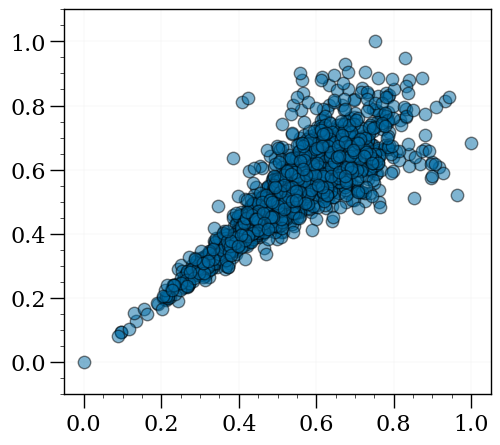

In [51]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [52]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [53]:
run(TrainingTensors, train_D, test_D, key, 'clayton_5')

  0%|          | 1/5000 [06:00<500:36:50, 360.51s/it]

Iter 0. Loss [[0.1618239  0.23784834 2.8219652 ]]


  0%|          | 12/5000 [11:27<7:09:20,  5.16s/it] 

Iter 10. Loss [[0.16153961 0.23696896 2.7783597 ]]


  0%|          | 22/5000 [11:29<28:23,  2.92it/s]

Iter 20. Loss [[0.1610701  0.23588274 2.7376623 ]]


  1%|          | 31/5000 [11:32<26:15,  3.15it/s]

Iter 30. Loss [[0.1604885  0.23467045 2.6989658 ]]


  1%|          | 41/5000 [11:35<27:56,  2.96it/s]

Iter 40. Loss [[0.15987195 0.23341817 2.6617467 ]]


  1%|          | 51/5000 [11:38<19:06,  4.32it/s]

Iter 50. Loss [[0.15924355 0.23214974 2.6257238 ]]


  1%|          | 61/5000 [11:40<17:12,  4.78it/s]

Iter 60. Loss [[0.15860897 0.23086832 2.590703  ]]


  1%|▏         | 71/5000 [11:43<20:25,  4.02it/s]

Iter 70. Loss [[0.15796696 0.22956936 2.5565517 ]]


  2%|▏         | 81/5000 [11:45<17:22,  4.72it/s]

Iter 80. Loss [[0.15731603 0.22824816 2.523172  ]]


  2%|▏         | 91/5000 [11:49<36:17,  2.25it/s]

Iter 90. Loss [[0.1566574  0.22690342 2.4904816 ]]


  2%|▏         | 101/5000 [11:51<18:02,  4.53it/s]

Iter 100. Loss [[0.15599456 0.22553673 2.45841   ]]


  2%|▏         | 111/5000 [11:54<31:35,  2.58it/s]

Iter 110. Loss [[0.15533186 0.22415116 2.4269016 ]]


  2%|▏         | 121/5000 [11:56<17:52,  4.55it/s]

Iter 120. Loss [[0.15467346 0.22274975 2.395915  ]]


  3%|▎         | 132/5000 [11:59<16:46,  4.84it/s]

Iter 130. Loss [[0.15402278 0.22133532 2.3654227 ]]


  3%|▎         | 141/5000 [12:03<28:28,  2.84it/s]

Iter 140. Loss [[0.15338287 0.21991022 2.3354044 ]]


  3%|▎         | 151/5000 [12:05<17:34,  4.60it/s]

Iter 150. Loss [[0.15275635 0.2184766  2.3058457 ]]


  3%|▎         | 161/5000 [12:08<19:32,  4.13it/s]

Iter 160. Loss [[0.15214561 0.21703653 2.2767353 ]]


  3%|▎         | 171/5000 [12:10<16:59,  4.73it/s]

Iter 170. Loss [[0.15155278 0.21559194 2.2480624 ]]


  4%|▎         | 182/5000 [12:13<19:41,  4.08it/s]

Iter 180. Loss [[0.15097983 0.21414462 2.2198184 ]]


  4%|▍         | 191/5000 [12:16<26:11,  3.06it/s]

Iter 190. Loss [[0.15042847 0.21269615 2.1919951 ]]


  4%|▍         | 201/5000 [12:20<30:18,  2.64it/s]

Iter 200. Loss [[0.14990006 0.21124797 2.1645844 ]]


  4%|▍         | 212/5000 [12:22<16:44,  4.77it/s]

Iter 210. Loss [[0.14939602 0.2098014  2.1375785 ]]


  4%|▍         | 221/5000 [12:24<16:36,  4.80it/s]

Iter 220. Loss [[0.14891747 0.20835765 2.1109698 ]]


  5%|▍         | 231/5000 [12:27<17:46,  4.47it/s]

Iter 230. Loss [[0.14846532 0.20691781 2.0847507 ]]


  5%|▍         | 241/5000 [12:29<23:21,  3.40it/s]

Iter 240. Loss [[0.14804055 0.20548283 2.058912  ]]


  5%|▌         | 252/5000 [12:33<19:16,  4.10it/s]

Iter 250. Loss [[0.14764386 0.20405363 2.0334463 ]]


  5%|▌         | 261/5000 [12:35<16:22,  4.82it/s]

Iter 260. Loss [[0.14727592 0.20263106 2.0083444 ]]


  5%|▌         | 272/5000 [12:38<17:30,  4.50it/s]

Iter 270. Loss [[0.14693728 0.2012159  1.9835976 ]]


  6%|▌         | 282/5000 [12:40<16:05,  4.88it/s]

Iter 280. Loss [[0.14662841 0.19980879 1.9591974 ]]


  6%|▌         | 291/5000 [12:43<25:44,  3.05it/s]

Iter 290. Loss [[0.14634976 0.19841038 1.935134  ]]


  6%|▌         | 301/5000 [12:46<26:43,  2.93it/s]

Iter 300. Loss [[0.14610158 0.19702123 1.9113989 ]]


  6%|▌         | 312/5000 [12:50<21:09,  3.69it/s]

Iter 310. Loss [[0.14588414 0.19564186 1.8879824 ]]


  6%|▋         | 322/5000 [12:52<16:09,  4.83it/s]

Iter 320. Loss [[0.14569761 0.19427274 1.8648753 ]]


  7%|▋         | 331/5000 [12:54<25:59,  2.99it/s]

Iter 330. Loss [[0.14554214 0.19291422 1.8420683 ]]


  7%|▋         | 341/5000 [12:56<16:48,  4.62it/s]

Iter 340. Loss [[0.14541782 0.19156675 1.8195525 ]]


  7%|▋         | 351/5000 [13:01<49:29,  1.57it/s]

Iter 350. Loss [[0.14532459 0.1902306  1.7973187 ]]


  7%|▋         | 362/5000 [13:03<16:34,  4.66it/s]

Iter 360. Loss [[0.14526252 0.18890604 1.7753581 ]]


  7%|▋         | 372/5000 [13:05<15:47,  4.89it/s]

Iter 370. Loss [[0.1452315  0.18759336 1.7536614 ]]


  8%|▊         | 382/5000 [13:08<16:41,  4.61it/s]

Iter 380. Loss [[0.14523144 0.18629272 1.7322214 ]]


  8%|▊         | 392/5000 [13:10<15:45,  4.88it/s]

Iter 390. Loss [[0.14526212 0.18500435 1.7110289 ]]


  8%|▊         | 401/5000 [13:13<28:29,  2.69it/s]

Iter 400. Loss [[0.14532347 0.18372841 1.690077  ]]


  8%|▊         | 411/5000 [13:16<17:07,  4.47it/s]

Iter 410. Loss [[0.1454152 0.182465  1.669358 ]]


  8%|▊         | 422/5000 [13:19<20:30,  3.72it/s]

Iter 420. Loss [[0.14553703 0.18121432 1.6488652 ]]


  9%|▊         | 431/5000 [13:21<16:42,  4.56it/s]

Iter 430. Loss [[0.14568873 0.17997636 1.6285921 ]]


  9%|▉         | 441/5000 [13:24<28:51,  2.63it/s]

Iter 440. Loss [[0.14586994 0.1787513  1.6085325 ]]


  9%|▉         | 451/5000 [13:27<25:01,  3.03it/s]

Iter 450. Loss [[0.14608032 0.17753915 1.5886811 ]]


  9%|▉         | 461/5000 [13:30<20:16,  3.73it/s]

Iter 460. Loss [[0.1463194  0.17634009 1.5690331 ]]


  9%|▉         | 472/5000 [13:33<16:04,  4.69it/s]

Iter 470. Loss [[0.14658687 0.17515415 1.5495846 ]]


 10%|▉         | 481/5000 [13:35<15:46,  4.77it/s]

Iter 480. Loss [[0.14688215 0.17398144 1.530332  ]]


 10%|▉         | 491/5000 [13:37<17:17,  4.34it/s]

Iter 490. Loss [[0.14720473 0.17282204 1.5112728 ]]


 10%|█         | 501/5000 [13:40<19:05,  3.93it/s]

Iter 500. Loss [[0.14755401 0.17167614 1.4924055 ]]


 10%|█         | 512/5000 [13:44<21:17,  3.51it/s]

Iter 510. Loss [[0.14792922 0.1705439  1.4737285 ]]


 10%|█         | 521/5000 [13:46<15:48,  4.72it/s]

Iter 520. Loss [[0.14832973 0.16942547 1.4552426 ]]


 11%|█         | 531/5000 [13:49<22:14,  3.35it/s]

Iter 530. Loss [[0.14875452 0.16832122 1.4369495 ]]


 11%|█         | 541/5000 [13:51<15:52,  4.68it/s]

Iter 540. Loss [[0.1492025  0.16723153 1.4188528 ]]


 11%|█         | 551/5000 [13:54<31:32,  2.35it/s]

Iter 550. Loss [[0.14967234 0.16615692 1.4009573 ]]


 11%|█         | 561/5000 [13:57<25:44,  2.87it/s]

Iter 560. Loss [[0.15016234 0.16509818 1.3832718 ]]


 11%|█▏        | 571/5000 [14:00<33:44,  2.19it/s]

Iter 570. Loss [[0.15067011 0.16405648 1.3658079 ]]


 12%|█▏        | 581/5000 [14:02<15:50,  4.65it/s]

Iter 580. Loss [[0.1511924  0.16303362 1.3485835 ]]


 12%|█▏        | 592/5000 [14:05<14:58,  4.90it/s]

Iter 590. Loss [[0.15172406 0.16203265 1.3316251 ]]


 12%|█▏        | 601/5000 [14:07<16:49,  4.36it/s]

Iter 600. Loss [[0.15225637 0.16105908 1.3149748 ]]


 12%|█▏        | 611/5000 [14:10<24:10,  3.03it/s]

Iter 610. Loss [[0.15277185 0.16012464 1.2987018 ]]


 12%|█▏        | 621/5000 [14:14<19:56,  3.66it/s]

Iter 620. Loss [[0.15322897 0.15925866 1.2829221 ]]


 13%|█▎        | 632/5000 [14:16<15:07,  4.81it/s]

Iter 630. Loss [[0.15352483 0.15854017 1.2676979 ]]


 13%|█▎        | 642/5000 [14:19<17:59,  4.04it/s]

Iter 640. Loss [[0.15361004 0.15802336 1.2530372 ]]


 13%|█▎        | 652/5000 [14:21<14:59,  4.83it/s]

Iter 650. Loss [[0.15367872 0.1575622  1.2398068 ]]


 13%|█▎        | 661/5000 [14:24<37:05,  1.95it/s]

Iter 660. Loss [[0.15370108 0.15718003 1.2277865 ]]


 13%|█▎        | 671/5000 [14:27<17:45,  4.06it/s]

Iter 670. Loss [[0.15372781 0.15682991 1.217071  ]]


 14%|█▎        | 682/5000 [14:30<27:04,  2.66it/s]

Iter 680. Loss [[0.15375125 0.15651691 1.2075187 ]]


 14%|█▍        | 691/5000 [14:32<15:40,  4.58it/s]

Iter 690. Loss [[0.15377583 0.15623462 1.1990678 ]]


 14%|█▍        | 701/5000 [14:34<15:06,  4.74it/s]

Iter 700. Loss [[0.15380758 0.15597484 1.1917105 ]]


 14%|█▍        | 711/5000 [14:38<22:49,  3.13it/s]

Iter 710. Loss [[0.15385415 0.15572983 1.1856471 ]]


 14%|█▍        | 721/5000 [14:41<22:02,  3.24it/s]

Iter 720. Loss [[0.15393217 0.15550871 1.1824688 ]]


 15%|█▍        | 731/5000 [14:44<16:58,  4.19it/s]

Iter 730. Loss [[0.154224   0.15520428 1.1806349 ]]


 15%|█▍        | 742/5000 [14:46<14:32,  4.88it/s]

Iter 740. Loss [[0.15437771 0.1550156  1.1791025 ]]


 15%|█▌        | 751/5000 [14:48<17:35,  4.02it/s]

Iter 750. Loss [[0.15456992 0.15479907 1.1779866 ]]


 15%|█▌        | 761/5000 [14:51<14:36,  4.84it/s]

Iter 760. Loss [[0.15478247 0.15458167 1.1770973 ]]


 15%|█▌        | 772/5000 [14:55<27:48,  2.53it/s]

Iter 770. Loss [[0.15493587 0.15441604 1.1761413 ]]


 16%|█▌        | 781/5000 [14:57<15:34,  4.51it/s]

Iter 780. Loss [[0.15510745 0.1542406  1.1753823 ]]


 16%|█▌        | 792/5000 [15:00<26:55,  2.60it/s]

Iter 790. Loss [[0.15527067 0.15407717 1.1746863 ]]


 16%|█▌        | 801/5000 [15:02<14:58,  4.67it/s]

Iter 800. Loss [[0.15541743 0.15392996 1.1740193 ]]


 16%|█▌        | 811/5000 [15:04<14:32,  4.80it/s]

Iter 810. Loss [[0.1555657  0.15378504 1.1734382 ]]


 16%|█▋        | 821/5000 [15:08<23:55,  2.91it/s]

Iter 820. Loss [[0.15570794 0.153648   1.1729074 ]]


 17%|█▋        | 832/5000 [15:11<14:51,  4.68it/s]

Iter 830. Loss [[0.1558434  0.15351896 1.1724185 ]]


 17%|█▋        | 842/5000 [15:14<15:23,  4.50it/s]

Iter 840. Loss [[0.1559757  0.15339495 1.1719799 ]]


 17%|█▋        | 851/5000 [15:15<14:43,  4.70it/s]

Iter 850. Loss [[0.15610312 0.15327705 1.1715808 ]]


 17%|█▋        | 861/5000 [15:18<17:16,  3.99it/s]

Iter 860. Loss [[0.15622534 0.15316518 1.171216  ]]


 17%|█▋        | 871/5000 [15:21<22:14,  3.09it/s]

Iter 870. Loss [[0.15634345 0.15305845 1.1708854 ]]


 18%|█▊        | 881/5000 [15:25<23:15,  2.95it/s]

Iter 880. Loss [[0.15645725 0.15295674 1.1705848 ]]


 18%|█▊        | 892/5000 [15:27<14:23,  4.76it/s]

Iter 890. Loss [[0.15656662 0.15285996 1.170311  ]]


 18%|█▊        | 902/5000 [15:30<22:23,  3.05it/s]

Iter 900. Loss [[0.15667203 0.15276766 1.1700622 ]]


 18%|█▊        | 911/5000 [15:32<14:33,  4.68it/s]

Iter 910. Loss [[0.15677348 0.15267965 1.1698363 ]]


 18%|█▊        | 921/5000 [15:34<17:13,  3.95it/s]

Iter 920. Loss [[0.15687108 0.15259576 1.1696302 ]]


 19%|█▊        | 931/5000 [15:38<19:49,  3.42it/s]

Iter 930. Loss [[0.15696502 0.15251572 1.1694443 ]]


 19%|█▉        | 941/5000 [15:40<14:12,  4.76it/s]

Iter 940. Loss [[0.15705533 0.15243939 1.1692746 ]]


 19%|█▉        | 951/5000 [15:43<14:50,  4.55it/s]

Iter 950. Loss [[0.1571422  0.15236656 1.1691201 ]]


 19%|█▉        | 961/5000 [15:45<13:55,  4.83it/s]

Iter 960. Loss [[0.15722576 0.15229705 1.1689804 ]]


 19%|█▉        | 971/5000 [15:48<17:19,  3.88it/s]

Iter 970. Loss [[0.15730605 0.1522307  1.1688542 ]]


 20%|█▉        | 981/5000 [15:51<22:35,  2.96it/s]

Iter 980. Loss [[0.15738331 0.15216729 1.1687388 ]]


 20%|█▉        | 991/5000 [15:54<18:26,  3.62it/s]

Iter 990. Loss [[0.15745747 0.1521068  1.1686345 ]]


 20%|██        | 1002/5000 [15:57<13:52,  4.80it/s]

Iter 1000. Loss [[0.15752882 0.15204898 1.1685399 ]]


 20%|██        | 1011/5000 [15:59<21:33,  3.08it/s]

Iter 1010. Loss [[0.15759745 0.15199369 1.1684545 ]]


 20%|██        | 1021/5000 [16:01<14:05,  4.71it/s]

Iter 1020. Loss [[0.15766332 0.1519409  1.1683773 ]]


 21%|██        | 1031/5000 [16:05<35:35,  1.86it/s]

Iter 1030. Loss [[0.15772668 0.15189043 1.1683073 ]]


 21%|██        | 1041/5000 [16:08<14:37,  4.51it/s]

Iter 1040. Loss [[0.1577876 0.1518421 1.1682444]]


 21%|██        | 1051/5000 [16:10<13:38,  4.83it/s]

Iter 1050. Loss [[0.15784614 0.1517959  1.1681875 ]]


 21%|██        | 1061/5000 [16:13<14:26,  4.55it/s]

Iter 1060. Loss [[0.15790237 0.15175171 1.1681365 ]]


 21%|██▏       | 1071/5000 [16:15<13:55,  4.70it/s]

Iter 1070. Loss [[0.15795648 0.1517094  1.1680907 ]]


 22%|██▏       | 1081/5000 [16:19<23:33,  2.77it/s]

Iter 1080. Loss [[0.15800849 0.15166886 1.1680491 ]]


 22%|██▏       | 1091/5000 [16:22<16:03,  4.06it/s]

Iter 1090. Loss [[0.15805845 0.1516301  1.1680117 ]]


 22%|██▏       | 1101/5000 [16:25<17:09,  3.79it/s]

Iter 1100. Loss [[0.15810645 0.15159301 1.1679789 ]]


 22%|██▏       | 1111/5000 [16:27<13:45,  4.71it/s]

Iter 1110. Loss [[0.15815255 0.15155746 1.1679491 ]]


 22%|██▏       | 1121/5000 [16:30<22:04,  2.93it/s]

Iter 1120. Loss [[0.158197   0.15152332 1.1679227 ]]


 23%|██▎       | 1131/5000 [16:32<20:56,  3.08it/s]

Iter 1130. Loss [[0.15823968 0.15149066 1.1678996 ]]


 23%|██▎       | 1142/5000 [16:37<23:29,  2.74it/s]

Iter 1140. Loss [[0.15828077 0.15145935 1.1678791 ]]


 23%|██▎       | 1151/5000 [16:38<13:35,  4.72it/s]

Iter 1150. Loss [[0.1583202  0.15142934 1.167861  ]]


 23%|██▎       | 1162/5000 [16:41<12:53,  4.96it/s]

Iter 1160. Loss [[0.1583582  0.15140049 1.1678455 ]]


 23%|██▎       | 1171/5000 [16:43<14:07,  4.52it/s]

Iter 1170. Loss [[0.1583947  0.15137284 1.1678317 ]]


 24%|██▎       | 1181/5000 [16:45<16:37,  3.83it/s]

Iter 1180. Loss [[0.15842986 0.1513463  1.1678199 ]]


 24%|██▍       | 1191/5000 [16:50<18:37,  3.41it/s]

Iter 1190. Loss [[0.15846367 0.15132086 1.1678101 ]]


 24%|██▍       | 1201/5000 [16:52<13:32,  4.68it/s]

Iter 1200. Loss [[0.15849617 0.1512964  1.1678013 ]]


 24%|██▍       | 1211/5000 [16:54<16:54,  3.73it/s]

Iter 1210. Loss [[0.15852751 0.15127292 1.1677939 ]]


 24%|██▍       | 1221/5000 [16:57<13:27,  4.68it/s]

Iter 1220. Loss [[0.1585577  0.15125036 1.1677884 ]]


 25%|██▍       | 1231/5000 [17:00<23:35,  2.66it/s]

Iter 1230. Loss [[0.1585867  0.15122868 1.1677841 ]]


 25%|██▍       | 1241/5000 [17:03<21:34,  2.90it/s]

Iter 1240. Loss [[0.15861465 0.15120785 1.1677811 ]]


 25%|██▌       | 1251/5000 [17:06<28:48,  2.17it/s]

Iter 1250. Loss [[0.15864159 0.15118779 1.1677786 ]]


 25%|██▌       | 1261/5000 [17:08<13:31,  4.61it/s]

Iter 1260. Loss [[0.15866753 0.15116854 1.1677777 ]]


 25%|██▌       | 1271/5000 [17:10<12:56,  4.80it/s]

Iter 1270. Loss [[0.15869255 0.15115    1.1677773 ]]


 26%|██▌       | 1281/5000 [17:13<13:40,  4.53it/s]

Iter 1280. Loss [[0.15871659 0.15113218 1.1677775 ]]


 26%|██▌       | 1291/5000 [17:16<20:01,  3.09it/s]

Iter 1290. Loss [[0.15873979 0.15111503 1.1677785 ]]


 26%|██▌       | 1301/5000 [17:20<15:50,  3.89it/s]

Iter 1300. Loss [[0.15876217 0.1510985  1.1677798 ]]


 26%|██▌       | 1311/5000 [17:22<12:56,  4.75it/s]

Iter 1310. Loss [[0.15878372 0.15108262 1.1677827 ]]


 26%|██▋       | 1321/5000 [17:24<16:26,  3.73it/s]

Iter 1320. Loss [[0.15880457 0.1510673  1.1677853 ]]


 27%|██▋       | 1332/5000 [17:27<12:41,  4.81it/s]

Iter 1330. Loss [[0.15882461 0.15105255 1.1677885 ]]


 27%|██▋       | 1341/5000 [17:30<27:37,  2.21it/s]

Iter 1340. Loss [[0.15884393 0.15103835 1.1677924 ]]


 27%|██▋       | 1351/5000 [17:33<14:36,  4.16it/s]

Iter 1350. Loss [[0.1588626  0.15102462 1.1677973 ]]


 27%|██▋       | 1361/5000 [17:36<27:54,  2.17it/s]

Iter 1360. Loss [[0.15888065 0.15101144 1.1678016 ]]


 27%|██▋       | 1371/5000 [17:38<13:02,  4.64it/s]

Iter 1370. Loss [[0.15889806 0.15099868 1.1678067 ]]


 28%|██▊       | 1381/5000 [17:40<12:23,  4.87it/s]

Iter 1380. Loss [[0.15891486 0.1509864  1.1678123 ]]


 28%|██▊       | 1391/5000 [17:43<19:09,  3.14it/s]

Iter 1390. Loss [[0.1589311  0.15097454 1.1678178 ]]


 28%|██▊       | 1401/5000 [17:46<18:48,  3.19it/s]

Iter 1400. Loss [[0.15894681 0.1509631  1.1678245 ]]


 28%|██▊       | 1411/5000 [17:49<14:34,  4.11it/s]

Iter 1410. Loss [[0.15896197 0.15095204 1.1678308 ]]


 28%|██▊       | 1422/5000 [17:52<12:12,  4.88it/s]

Iter 1420. Loss [[0.15897657 0.1509414  1.1678369 ]]


 29%|██▊       | 1431/5000 [17:54<15:45,  3.78it/s]

Iter 1430. Loss [[0.15899074 0.1509311  1.1678436 ]]


 29%|██▉       | 1441/5000 [17:56<12:29,  4.75it/s]

Iter 1440. Loss [[0.15900442 0.15092118 1.1678505 ]]


 29%|██▉       | 1451/5000 [18:01<28:05,  2.11it/s]

Iter 1450. Loss [[0.1590177  0.15091155 1.1678578 ]]


 29%|██▉       | 1462/5000 [18:03<12:26,  4.74it/s]

Iter 1460. Loss [[0.15903048 0.15090226 1.167865  ]]


 29%|██▉       | 1471/5000 [18:05<12:15,  4.80it/s]

Iter 1470. Loss [[0.15904288 0.15089332 1.1678725 ]]


 30%|██▉       | 1481/5000 [18:08<12:39,  4.63it/s]

Iter 1480. Loss [[0.15905482 0.15088466 1.1678802 ]]


 30%|██▉       | 1491/5000 [18:10<12:08,  4.82it/s]

Iter 1490. Loss [[0.15906644 0.15087628 1.1678873 ]]


 30%|███       | 1501/5000 [18:14<20:22,  2.86it/s]

Iter 1500. Loss [[0.15907764 0.15086818 1.1678951 ]]


 30%|███       | 1511/5000 [18:16<13:00,  4.47it/s]

Iter 1510. Loss [[0.15908855 0.15086031 1.167903  ]]


 30%|███       | 1521/5000 [18:19<13:43,  4.23it/s]

Iter 1520. Loss [[0.15909906 0.15085272 1.167911  ]]


 31%|███       | 1531/5000 [18:21<12:15,  4.72it/s]

Iter 1530. Loss [[0.15910925 0.15084538 1.167919  ]]


 31%|███       | 1541/5000 [18:24<14:10,  4.07it/s]

Iter 1540. Loss [[0.15911917 0.15083826 1.1679273 ]]


 31%|███       | 1551/5000 [18:27<18:54,  3.04it/s]

Iter 1550. Loss [[0.15912874 0.15083137 1.1679348 ]]


 31%|███       | 1561/5000 [18:31<18:59,  3.02it/s]

Iter 1560. Loss [[0.15913801 0.15082471 1.167943  ]]


 31%|███▏      | 1572/5000 [18:33<11:55,  4.79it/s]

Iter 1570. Loss [[0.15914702 0.15081824 1.1679513 ]]


 32%|███▏      | 1581/5000 [18:36<18:37,  3.06it/s]

Iter 1580. Loss [[0.15915574 0.15081199 1.1679596 ]]


 32%|███▏      | 1591/5000 [18:38<11:55,  4.76it/s]

Iter 1590. Loss [[0.15916415 0.15080597 1.1679674 ]]


 32%|███▏      | 1601/5000 [18:41<32:36,  1.74it/s]

Iter 1600. Loss [[0.1591724 0.1508001 1.167976 ]]


 32%|███▏      | 1612/5000 [18:44<13:47,  4.09it/s]

Iter 1610. Loss [[0.15918036 0.15079436 1.1679842 ]]


 32%|███▏      | 1621/5000 [18:46<11:42,  4.81it/s]

Iter 1620. Loss [[0.1591881  0.15078884 1.1679925 ]]


 33%|███▎      | 1631/5000 [18:49<12:22,  4.54it/s]

Iter 1630. Loss [[0.15919559 0.15078348 1.1680007 ]]


 33%|███▎      | 1641/5000 [18:51<11:30,  4.87it/s]

Iter 1640. Loss [[0.15920287 0.1507783  1.168009  ]]


 33%|███▎      | 1651/5000 [18:54<16:48,  3.32it/s]

Iter 1650. Loss [[0.15920998 0.15077323 1.1680169 ]]


 33%|███▎      | 1661/5000 [18:57<19:02,  2.92it/s]

Iter 1660. Loss [[0.15921687 0.15076834 1.1680254 ]]


 33%|███▎      | 1671/5000 [19:00<14:57,  3.71it/s]

Iter 1670. Loss [[0.15922359 0.15076356 1.1680335 ]]


 34%|███▎      | 1681/5000 [19:02<11:33,  4.79it/s]

Iter 1680. Loss [[0.15923007 0.15075897 1.1680417 ]]


 34%|███▍      | 1691/5000 [19:05<17:59,  3.07it/s]

Iter 1690. Loss [[0.1592363  0.15075453 1.1680496 ]]


 34%|███▍      | 1702/5000 [19:07<11:20,  4.85it/s]

Iter 1700. Loss [[0.15924242 0.15075018 1.1680579 ]]


 34%|███▍      | 1711/5000 [19:11<34:13,  1.60it/s]

Iter 1710. Loss [[0.15924844 0.15074591 1.168066  ]]


 34%|███▍      | 1722/5000 [19:14<11:51,  4.61it/s]

Iter 1720. Loss [[0.15925425 0.15074182 1.168074  ]]


 35%|███▍      | 1732/5000 [19:16<11:20,  4.81it/s]

Iter 1730. Loss [[0.15925995 0.15073778 1.1680819 ]]


 35%|███▍      | 1742/5000 [19:19<11:45,  4.62it/s]

Iter 1740. Loss [[0.15926546 0.15073389 1.1680905 ]]


 35%|███▌      | 1751/5000 [19:21<11:14,  4.82it/s]

Iter 1750. Loss [[0.15927075 0.15073015 1.1680979 ]]


 35%|███▌      | 1761/5000 [19:24<19:14,  2.81it/s]

Iter 1760. Loss [[0.15927598 0.1507265  1.168106  ]]


 35%|███▌      | 1771/5000 [19:27<12:49,  4.20it/s]

Iter 1770. Loss [[0.15928097 0.15072292 1.1681135 ]]


 36%|███▌      | 1781/5000 [19:30<13:23,  4.00it/s]

Iter 1780. Loss [[0.15928589 0.15071946 1.1681219 ]]


 36%|███▌      | 1792/5000 [19:32<10:59,  4.86it/s]

Iter 1790. Loss [[0.15929064 0.15071614 1.1681292 ]]


 36%|███▌      | 1801/5000 [19:35<14:11,  3.76it/s]

Iter 1800. Loss [[0.15929538 0.1507128  1.1681368 ]]


 36%|███▌      | 1811/5000 [19:37<16:10,  3.29it/s]

Iter 1810. Loss [[0.15929995 0.1507096  1.1681445 ]]


 36%|███▋      | 1821/5000 [19:41<21:27,  2.47it/s]

Iter 1820. Loss [[0.15930435 0.15070651 1.1681519 ]]


 37%|███▋      | 1831/5000 [19:44<11:15,  4.69it/s]

Iter 1830. Loss [[0.15930864 0.15070349 1.1681595 ]]


 37%|███▋      | 1842/5000 [19:47<19:59,  2.63it/s]

Iter 1840. Loss [[0.15931287 0.15070052 1.1681665 ]]


 37%|███▋      | 1852/5000 [19:49<10:58,  4.78it/s]

Iter 1850. Loss [[0.15931697 0.15069763 1.1681744 ]]


 37%|███▋      | 1861/5000 [19:51<10:45,  4.87it/s]

Iter 1860. Loss [[0.15932098 0.15069486 1.1681817 ]]


 37%|███▋      | 1871/5000 [19:55<18:07,  2.88it/s]

Iter 1870. Loss [[0.15932481 0.1506922  1.1681886 ]]


 38%|███▊      | 1881/5000 [19:57<11:02,  4.71it/s]

Iter 1880. Loss [[0.15932864 0.15068951 1.168196  ]]


 38%|███▊      | 1891/5000 [20:00<12:14,  4.23it/s]

Iter 1890. Loss [[0.1593324 0.1506869 1.1682028]]


 38%|███▊      | 1902/5000 [20:02<10:40,  4.84it/s]

Iter 1900. Loss [[0.15933609 0.15068433 1.16821   ]]


 38%|███▊      | 1911/5000 [20:05<13:51,  3.72it/s]

Iter 1910. Loss [[0.1593396  0.15068187 1.1682174 ]]


 38%|███▊      | 1921/5000 [20:08<17:01,  3.01it/s]

Iter 1920. Loss [[0.15934293 0.15067954 1.1682239 ]]


 39%|███▊      | 1931/5000 [20:11<17:23,  2.94it/s]

Iter 1930. Loss [[0.15934636 0.15067716 1.1682308 ]]


 39%|███▉      | 1942/5000 [20:14<10:25,  4.89it/s]

Iter 1940. Loss [[0.15934964 0.15067488 1.1682376 ]]


 39%|███▉      | 1952/5000 [20:16<19:00,  2.67it/s]

Iter 1950. Loss [[0.15935282 0.15067266 1.1682444 ]]


 39%|███▉      | 1961/5000 [20:18<10:56,  4.63it/s]

Iter 1960. Loss [[0.1593559  0.15067057 1.1682508 ]]


 39%|███▉      | 1971/5000 [20:21<15:55,  3.17it/s]

Iter 1970. Loss [[0.15935898 0.15066841 1.1682575 ]]


 40%|███▉      | 1982/5000 [20:25<11:39,  4.32it/s]

Iter 1980. Loss [[0.15936202 0.1506663  1.168264  ]]


 40%|███▉      | 1992/5000 [20:27<10:15,  4.88it/s]

Iter 1990. Loss [[0.15936495 0.15066428 1.1682708 ]]


 40%|████      | 2002/5000 [20:30<11:15,  4.44it/s]

Iter 2000. Loss [[0.15936778 0.15066232 1.1682767 ]]


 40%|████      | 2011/5000 [20:32<10:16,  4.85it/s]

Iter 2010. Loss [[0.15937053 0.15066043 1.168283  ]]


 40%|████      | 2021/5000 [20:35<18:33,  2.68it/s]

Iter 2020. Loss [[0.15937328 0.15065853 1.1682893 ]]


 41%|████      | 2031/5000 [20:38<14:34,  3.39it/s]

Iter 2030. Loss [[0.15937589 0.15065672 1.1682948 ]]


 41%|████      | 2041/5000 [20:41<18:32,  2.66it/s]

Iter 2040. Loss [[0.15937857 0.15065488 1.1683017 ]]


 41%|████      | 2051/5000 [20:43<10:28,  4.70it/s]

Iter 2050. Loss [[0.15938115 0.1506531  1.1683073 ]]


 41%|████      | 2061/5000 [20:45<10:24,  4.70it/s]

Iter 2060. Loss [[0.15938352 0.15065147 1.168313  ]]


 41%|████▏     | 2071/5000 [20:48<12:24,  3.93it/s]

Iter 2070. Loss [[0.1593859  0.15064982 1.1683187 ]]


 42%|████▏     | 2081/5000 [20:52<16:36,  2.93it/s]

Iter 2080. Loss [[0.15938838 0.15064809 1.168325  ]]


 42%|████▏     | 2091/5000 [20:55<11:20,  4.27it/s]

Iter 2090. Loss [[0.15939072 0.1506465  1.1683306 ]]


 42%|████▏     | 2101/5000 [20:57<10:08,  4.77it/s]

Iter 2100. Loss [[0.15939295 0.15064499 1.1683359 ]]


 42%|████▏     | 2111/5000 [21:00<11:55,  4.04it/s]

Iter 2110. Loss [[0.15939517 0.15064344 1.1683415 ]]


 42%|████▏     | 2121/5000 [21:02<09:57,  4.82it/s]

Iter 2120. Loss [[0.1593974  0.15064193 1.1683469 ]]


 43%|████▎     | 2131/5000 [21:06<20:21,  2.35it/s]

Iter 2130. Loss [[0.15939955 0.15064046 1.1683525 ]]


 43%|████▎     | 2141/5000 [21:08<10:17,  4.63it/s]

Iter 2140. Loss [[0.15940166 0.15063901 1.1683581 ]]


 43%|████▎     | 2152/5000 [21:11<15:21,  3.09it/s]

Iter 2150. Loss [[0.1594036  0.15063767 1.1683629 ]]


 43%|████▎     | 2162/5000 [21:13<09:52,  4.79it/s]

Iter 2160. Loss [[0.15940565 0.15063626 1.1683685 ]]


 43%|████▎     | 2172/5000 [21:15<09:41,  4.87it/s]

Iter 2170. Loss [[0.15940763 0.15063493 1.168373  ]]


 44%|████▎     | 2181/5000 [21:19<15:52,  2.96it/s]

Iter 2180. Loss [[0.15940958 0.15063356 1.1683786 ]]


 44%|████▍     | 2191/5000 [21:22<11:46,  3.98it/s]

Iter 2190. Loss [[0.15941137 0.15063237 1.168383  ]]


 44%|████▍     | 2201/5000 [21:25<11:00,  4.24it/s]

Iter 2200. Loss [[0.15941322 0.15063109 1.1683882 ]]


 44%|████▍     | 2211/5000 [21:27<09:45,  4.76it/s]

Iter 2210. Loss [[0.15941508 0.15062983 1.168393  ]]


 44%|████▍     | 2222/5000 [21:30<11:23,  4.06it/s]

Iter 2220. Loss [[0.15941687 0.1506286  1.1683981 ]]


 45%|████▍     | 2231/5000 [21:32<12:52,  3.59it/s]

Iter 2230. Loss [[0.15941855 0.15062742 1.168403  ]]


 45%|████▍     | 2241/5000 [21:36<18:39,  2.47it/s]

Iter 2240. Loss [[0.15942018 0.15062632 1.1684068 ]]


 45%|████▌     | 2252/5000 [21:38<09:29,  4.83it/s]

Iter 2250. Loss [[0.15942195 0.15062512 1.1684122 ]]


 45%|████▌     | 2261/5000 [21:41<20:36,  2.22it/s]

Iter 2260. Loss [[0.15942359 0.150624   1.1684166 ]]


 45%|████▌     | 2272/5000 [21:43<09:32,  4.77it/s]

Iter 2270. Loss [[0.15942508 0.15062301 1.1684207 ]]


 46%|████▌     | 2281/5000 [21:45<09:23,  4.83it/s]

Iter 2280. Loss [[0.1594268  0.15062183 1.1684254 ]]


 46%|████▌     | 2291/5000 [21:49<15:52,  2.84it/s]

Iter 2290. Loss [[0.15942825 0.15062082 1.1684295 ]]


 46%|████▌     | 2302/5000 [21:51<09:22,  4.80it/s]

Iter 2300. Loss [[0.15942973 0.1506198  1.1684338 ]]


 46%|████▌     | 2312/5000 [21:54<10:04,  4.44it/s]

Iter 2310. Loss [[0.15943125 0.15061879 1.1684384 ]]


 46%|████▋     | 2321/5000 [21:56<09:18,  4.80it/s]

Iter 2320. Loss [[0.15943274 0.1506178  1.168442  ]]


 47%|████▋     | 2332/5000 [21:59<10:52,  4.09it/s]

Iter 2330. Loss [[0.15943411 0.15061685 1.1684464 ]]


 47%|████▋     | 2341/5000 [22:02<14:32,  3.05it/s]

Iter 2340. Loss [[0.15943553 0.15061589 1.1684505 ]]


 47%|████▋     | 2351/5000 [22:06<15:51,  2.78it/s]

Iter 2350. Loss [[0.15943688 0.15061495 1.1684544 ]]


 47%|████▋     | 2361/5000 [22:08<09:21,  4.70it/s]

Iter 2360. Loss [[0.15943825 0.15061404 1.1684583 ]]


 47%|████▋     | 2371/5000 [22:11<19:48,  2.21it/s]

Iter 2370. Loss [[0.15943953 0.15061316 1.168462  ]]


 48%|████▊     | 2381/5000 [22:13<09:28,  4.61it/s]

Iter 2380. Loss [[0.15944093 0.1506122  1.1684662 ]]


 48%|████▊     | 2391/5000 [22:15<13:18,  3.27it/s]

Iter 2390. Loss [[0.15944214 0.15061139 1.1684695 ]]


 48%|████▊     | 2402/5000 [22:19<10:09,  4.26it/s]

Iter 2400. Loss [[0.15944335 0.15061057 1.1684732 ]]


 48%|████▊     | 2411/5000 [22:21<09:02,  4.77it/s]

Iter 2410. Loss [[0.15944456 0.15060975 1.168477  ]]


 48%|████▊     | 2422/5000 [22:24<09:26,  4.55it/s]

Iter 2420. Loss [[0.1594458  0.15060888 1.1684808 ]]


 49%|████▊     | 2432/5000 [22:26<08:48,  4.86it/s]

Iter 2430. Loss [[0.15944695 0.15060812 1.1684841 ]]


 49%|████▉     | 2441/5000 [22:29<14:41,  2.90it/s]

Iter 2440. Loss [[0.15944819 0.15060727 1.168488  ]]


 49%|████▉     | 2452/5000 [22:33<11:54,  3.57it/s]

Iter 2450. Loss [[0.15944923 0.15060654 1.168491  ]]


 49%|████▉     | 2462/5000 [22:36<11:29,  3.68it/s]

Iter 2460. Loss [[0.15945049 0.15060572 1.1684945 ]]


 49%|████▉     | 2472/5000 [22:38<08:33,  4.92it/s]

Iter 2470. Loss [[0.15945147 0.15060507 1.1684976 ]]


 50%|████▉     | 2482/5000 [22:41<15:44,  2.67it/s]

Iter 2480. Loss [[0.15945256 0.1506043  1.1685011 ]]


 50%|████▉     | 2491/5000 [22:43<09:05,  4.60it/s]

Iter 2490. Loss [[0.15945365 0.15060359 1.1685046 ]]


 50%|█████     | 2501/5000 [22:46<13:59,  2.98it/s]

Iter 2500. Loss [[0.15945464 0.15060288 1.168507  ]]


 50%|█████     | 2511/5000 [22:49<09:15,  4.48it/s]

Iter 2510. Loss [[0.15945573 0.15060218 1.1685107 ]]


 50%|█████     | 2522/5000 [22:51<08:29,  4.86it/s]

Iter 2520. Loss [[0.15945663 0.15060157 1.1685135 ]]


 51%|█████     | 2531/5000 [22:54<09:36,  4.29it/s]

Iter 2530. Loss [[0.15945779 0.15060076 1.1685169 ]]


 51%|█████     | 2541/5000 [22:56<08:45,  4.68it/s]

Iter 2540. Loss [[0.15945864 0.1506002  1.1685193 ]]


 51%|█████     | 2551/5000 [23:00<16:19,  2.50it/s]

Iter 2550. Loss [[0.15945964 0.1505995  1.1685231 ]]


 51%|█████     | 2562/5000 [23:03<08:38,  4.70it/s]

Iter 2560. Loss [[0.15946053 0.15059891 1.1685253 ]]


 51%|█████▏    | 2571/5000 [23:05<11:45,  3.44it/s]

Iter 2570. Loss [[0.15946145 0.1505983  1.168528  ]]


 52%|█████▏    | 2582/5000 [23:08<08:19,  4.84it/s]

Iter 2580. Loss [[0.15946235 0.15059768 1.168531  ]]


 52%|█████▏    | 2592/5000 [23:10<13:03,  3.07it/s]

Iter 2590. Loss [[0.15946323 0.15059708 1.1685339 ]]


 52%|█████▏    | 2601/5000 [23:13<12:56,  3.09it/s]

Iter 2600. Loss [[0.15946412 0.15059645 1.1685368 ]]


 52%|█████▏    | 2611/5000 [23:16<10:05,  3.95it/s]

Iter 2610. Loss [[0.159465   0.15059586 1.1685392 ]]


 52%|█████▏    | 2622/5000 [23:19<08:26,  4.69it/s]

Iter 2620. Loss [[0.15946575 0.15059535 1.1685417 ]]


 53%|█████▎    | 2631/5000 [23:21<08:11,  4.82it/s]

Iter 2630. Loss [[0.15946662 0.15059477 1.1685448 ]]


 53%|█████▎    | 2642/5000 [23:24<08:27,  4.64it/s]

Iter 2640. Loss [[0.15946744 0.15059422 1.1685473 ]]


 53%|█████▎    | 2651/5000 [23:26<10:50,  3.61it/s]

Iter 2650. Loss [[0.15946825 0.15059368 1.1685498 ]]


 53%|█████▎    | 2661/5000 [23:30<11:17,  3.45it/s]

Iter 2660. Loss [[0.15946898 0.1505932  1.1685523 ]]


 53%|█████▎    | 2671/5000 [23:32<08:06,  4.78it/s]

Iter 2670. Loss [[0.15946987 0.15059255 1.1685548 ]]


 54%|█████▎    | 2681/5000 [23:35<10:15,  3.77it/s]

Iter 2680. Loss [[0.15947054 0.15059215 1.1685568 ]]


 54%|█████▍    | 2691/5000 [23:37<08:14,  4.67it/s]

Iter 2690. Loss [[0.15947127 0.15059163 1.1685594 ]]


 54%|█████▍    | 2701/5000 [23:40<14:57,  2.56it/s]

Iter 2700. Loss [[0.15947208 0.15059106 1.1685617 ]]


 54%|█████▍    | 2711/5000 [23:44<13:00,  2.93it/s]

Iter 2710. Loss [[0.15947273 0.15059063 1.168564  ]]


 54%|█████▍    | 2721/5000 [23:46<08:05,  4.70it/s]

Iter 2720. Loss [[0.15947351 0.15059009 1.1685662 ]]


 55%|█████▍    | 2732/5000 [23:49<07:58,  4.74it/s]

Iter 2730. Loss [[0.15947418 0.15058964 1.1685687 ]]


 55%|█████▍    | 2741/5000 [23:51<07:52,  4.78it/s]

Iter 2740. Loss [[0.15947485 0.15058917 1.168571  ]]


 55%|█████▌    | 2752/5000 [23:54<08:09,  4.60it/s]

Iter 2750. Loss [[0.15947554 0.15058875 1.1685729 ]]


 55%|█████▌    | 2761/5000 [23:57<12:13,  3.05it/s]

Iter 2760. Loss [[0.1594762  0.15058826 1.1685752 ]]


 55%|█████▌    | 2771/5000 [24:00<10:05,  3.68it/s]

Iter 2770. Loss [[0.1594769  0.15058778 1.1685772 ]]


 56%|█████▌    | 2781/5000 [24:02<07:44,  4.77it/s]

Iter 2780. Loss [[0.1594775 0.1505874 1.1685792]]


 56%|█████▌    | 2791/5000 [24:05<11:57,  3.08it/s]

Iter 2790. Loss [[0.15947816 0.15058695 1.168581  ]]


 56%|█████▌    | 2802/5000 [24:07<07:32,  4.86it/s]

Iter 2800. Loss [[0.15947875 0.15058655 1.1685829 ]]


 56%|█████▌    | 2811/5000 [24:11<22:11,  1.64it/s]

Iter 2810. Loss [[0.15947935 0.15058616 1.168585  ]]


 56%|█████▋    | 2822/5000 [24:14<08:18,  4.37it/s]

Iter 2820. Loss [[0.15948007 0.15058565 1.1685876 ]]


 57%|█████▋    | 2832/5000 [24:16<07:27,  4.85it/s]

Iter 2830. Loss [[0.15948054 0.15058535 1.1685888 ]]


 57%|█████▋    | 2841/5000 [24:19<08:05,  4.44it/s]

Iter 2840. Loss [[0.15948108 0.15058497 1.1685907 ]]


 57%|█████▋    | 2851/5000 [24:21<07:29,  4.78it/s]

Iter 2850. Loss [[0.15948173 0.15058452 1.1685928 ]]


 57%|█████▋    | 2861/5000 [24:24<11:39,  3.06it/s]

Iter 2860. Loss [[0.15948224 0.15058416 1.1685947 ]]


 57%|█████▋    | 2871/5000 [24:27<11:22,  3.12it/s]

Iter 2870. Loss [[0.15948285 0.15058376 1.1685964 ]]


 58%|█████▊    | 2881/5000 [24:30<08:53,  3.97it/s]

Iter 2880. Loss [[0.15948333 0.15058346 1.1685978 ]]


 58%|█████▊    | 2891/5000 [24:32<07:24,  4.75it/s]

Iter 2890. Loss [[0.15948394 0.15058303 1.1685996 ]]


 58%|█████▊    | 2902/5000 [24:35<09:12,  3.80it/s]

Iter 2900. Loss [[0.15948434 0.15058275 1.1686013 ]]


 58%|█████▊    | 2911/5000 [24:37<07:49,  4.45it/s]

Iter 2910. Loss [[0.15948498 0.15058227 1.1686034 ]]


 58%|█████▊    | 2921/5000 [24:42<18:11,  1.90it/s]

Iter 2920. Loss [[0.15948544 0.15058199 1.1686051 ]]


 59%|█████▊    | 2931/5000 [24:44<07:28,  4.61it/s]

Iter 2930. Loss [[0.15948598 0.15058163 1.1686062 ]]


 59%|█████▉    | 2941/5000 [24:46<07:00,  4.90it/s]

Iter 2940. Loss [[0.15948643 0.15058132 1.168608  ]]


 59%|█████▉    | 2951/5000 [24:48<07:20,  4.65it/s]

Iter 2950. Loss [[0.15948692 0.15058099 1.1686094 ]]


 59%|█████▉    | 2961/5000 [24:51<07:18,  4.65it/s]

Iter 2960. Loss [[0.15948747 0.15058063 1.1686112 ]]


 59%|█████▉    | 2971/5000 [24:55<11:41,  2.89it/s]

Iter 2970. Loss [[0.15948792 0.15058032 1.1686127 ]]


 60%|█████▉    | 2981/5000 [24:57<07:30,  4.49it/s]

Iter 2980. Loss [[0.15948837 0.15058002 1.1686137 ]]


 60%|█████▉    | 2992/5000 [25:00<07:35,  4.41it/s]

Iter 2990. Loss [[0.15948884 0.1505797  1.1686158 ]]


 60%|██████    | 3001/5000 [25:02<06:56,  4.80it/s]

Iter 3000. Loss [[0.15948929 0.1505794  1.1686169 ]]


 60%|██████    | 3012/5000 [25:05<08:44,  3.79it/s]

Iter 3010. Loss [[0.15948965 0.15057915 1.1686182 ]]


 60%|██████    | 3021/5000 [25:08<10:55,  3.02it/s]

Iter 3020. Loss [[0.15949012 0.15057881 1.1686195 ]]


 61%|██████    | 3031/5000 [25:12<14:05,  2.33it/s]

Iter 3030. Loss [[0.15949054 0.15057853 1.1686211 ]]


 61%|██████    | 3041/5000 [25:14<06:59,  4.67it/s]

Iter 3040. Loss [[0.159491  0.1505782 1.1686229]]


 61%|██████    | 3051/5000 [25:16<06:40,  4.87it/s]

Iter 3050. Loss [[0.15949135 0.15057798 1.1686236 ]]


 61%|██████    | 3062/5000 [25:19<06:51,  4.71it/s]

Iter 3060. Loss [[0.15949172 0.15057775 1.168625  ]]


 61%|██████▏   | 3071/5000 [25:21<09:11,  3.50it/s]

Iter 3070. Loss [[0.15949216 0.15057743 1.1686264 ]]


 62%|██████▏   | 3081/5000 [25:25<09:31,  3.36it/s]

Iter 3080. Loss [[0.1594926  0.15057711 1.1686281 ]]


 62%|██████▏   | 3091/5000 [25:27<06:43,  4.73it/s]

Iter 3090. Loss [[0.15949295 0.15057689 1.168629  ]]


 62%|██████▏   | 3101/5000 [25:30<08:27,  3.74it/s]

Iter 3100. Loss [[0.15949328 0.15057665 1.16863   ]]


 62%|██████▏   | 3111/5000 [25:32<06:38,  4.74it/s]

Iter 3110. Loss [[0.15949367 0.15057643 1.1686312 ]]


 62%|██████▏   | 3121/5000 [25:35<12:19,  2.54it/s]

Iter 3120. Loss [[0.1594941  0.15057613 1.1686326 ]]


 63%|██████▎   | 3131/5000 [25:38<10:38,  2.93it/s]

Iter 3130. Loss [[0.15949447 0.15057585 1.168634  ]]


 63%|██████▎   | 3141/5000 [25:41<14:04,  2.20it/s]

Iter 3140. Loss [[0.15949479 0.15057568 1.1686354 ]]


 63%|██████▎   | 3151/5000 [25:44<06:33,  4.69it/s]

Iter 3150. Loss [[0.1594951  0.15057544 1.1686362 ]]


 63%|██████▎   | 3161/5000 [25:46<06:21,  4.81it/s]

Iter 3160. Loss [[0.15949553 0.15057515 1.1686374 ]]


 63%|██████▎   | 3172/5000 [25:49<06:38,  4.58it/s]

Iter 3170. Loss [[0.15949585 0.15057492 1.1686383 ]]


 64%|██████▎   | 3181/5000 [25:52<10:12,  2.97it/s]

Iter 3180. Loss [[0.15949614 0.15057473 1.168639  ]]


 64%|██████▍   | 3191/5000 [25:55<08:14,  3.66it/s]

Iter 3190. Loss [[0.15949652 0.15057446 1.1686412 ]]


 64%|██████▍   | 3201/5000 [25:57<06:25,  4.66it/s]

Iter 3200. Loss [[0.15949689 0.1505742  1.1686418 ]]


 64%|██████▍   | 3211/5000 [26:00<08:14,  3.62it/s]

Iter 3210. Loss [[0.15949717 0.15057401 1.1686425 ]]


 64%|██████▍   | 3221/5000 [26:02<06:36,  4.49it/s]

Iter 3220. Loss [[0.15949745 0.1505738  1.1686438 ]]


 65%|██████▍   | 3231/5000 [26:06<14:14,  2.07it/s]

Iter 3230. Loss [[0.15949775 0.15057364 1.1686444 ]]


 65%|██████▍   | 3242/5000 [26:09<06:25,  4.56it/s]

Iter 3240. Loss [[0.15949804 0.15057342 1.1686454 ]]


 65%|██████▌   | 3251/5000 [26:12<11:29,  2.54it/s]

Iter 3250. Loss [[0.15949829 0.15057325 1.1686465 ]]


 65%|██████▌   | 3261/5000 [26:14<06:08,  4.72it/s]

Iter 3260. Loss [[0.15949859 0.15057307 1.1686472 ]]


 65%|██████▌   | 3271/5000 [26:16<06:04,  4.75it/s]

Iter 3270. Loss [[0.15949889 0.15057284 1.1686484 ]]


 66%|██████▌   | 3281/5000 [26:20<09:36,  2.98it/s]

Iter 3280. Loss [[0.15949924 0.15057261 1.1686499 ]]


 66%|██████▌   | 3291/5000 [26:23<07:18,  3.90it/s]

Iter 3290. Loss [[0.15949953 0.1505724  1.1686505 ]]


 66%|██████▌   | 3302/5000 [26:26<06:14,  4.54it/s]

Iter 3300. Loss [[0.15949972 0.15057227 1.1686517 ]]


 66%|██████▌   | 3312/5000 [26:28<05:41,  4.94it/s]

Iter 3310. Loss [[0.15950003 0.15057208 1.168652  ]]


 66%|██████▋   | 3321/5000 [26:30<06:56,  4.03it/s]

Iter 3320. Loss [[0.15950029 0.15057191 1.168653  ]]


 67%|██████▋   | 3331/5000 [26:33<07:59,  3.48it/s]

Iter 3330. Loss [[0.15950055 0.15057172 1.168654  ]]


 67%|██████▋   | 3342/5000 [26:37<08:38,  3.19it/s]

Iter 3340. Loss [[0.15950085 0.15057153 1.1686546 ]]


 67%|██████▋   | 3351/5000 [26:39<05:53,  4.66it/s]

Iter 3350. Loss [[0.15950099 0.15057144 1.1686558 ]]


 67%|██████▋   | 3361/5000 [26:42<10:26,  2.61it/s]

Iter 3360. Loss [[0.15950114 0.15057133 1.1686558 ]]


 67%|██████▋   | 3371/5000 [26:44<05:47,  4.69it/s]

Iter 3370. Loss [[0.15950154 0.15057105 1.1686571 ]]


 68%|██████▊   | 3381/5000 [26:47<12:57,  2.08it/s]

Iter 3380. Loss [[0.1595018  0.15057088 1.1686579 ]]


 68%|██████▊   | 3391/5000 [26:50<09:07,  2.94it/s]

Iter 3390. Loss [[0.15950203 0.15057074 1.1686587 ]]


 68%|██████▊   | 3402/5000 [26:53<05:31,  4.83it/s]

Iter 3400. Loss [[0.15950225 0.15057057 1.1686587 ]]


 68%|██████▊   | 3411/5000 [26:55<05:51,  4.52it/s]

Iter 3410. Loss [[0.1595025 0.1505704 1.1686603]]


 68%|██████▊   | 3421/5000 [26:57<05:33,  4.73it/s]

Iter 3420. Loss [[0.15950271 0.15057027 1.1686606 ]]


 69%|██████▊   | 3431/5000 [27:00<06:32,  4.00it/s]

Iter 3430. Loss [[0.15950294 0.15057012 1.1686617 ]]


 69%|██████▉   | 3441/5000 [27:03<08:47,  2.95it/s]

Iter 3440. Loss [[0.15950309 0.15057    1.1686622 ]]


 69%|██████▉   | 3452/5000 [27:07<07:13,  3.57it/s]

Iter 3450. Loss [[0.1595033  0.15056984 1.1686635 ]]


 69%|██████▉   | 3461/5000 [27:09<05:17,  4.84it/s]

Iter 3460. Loss [[0.15950352 0.1505697  1.1686633 ]]


 69%|██████▉   | 3472/5000 [27:12<09:25,  2.70it/s]

Iter 3470. Loss [[0.15950358 0.15056968 1.1686635 ]]


 70%|██████▉   | 3482/5000 [27:14<05:17,  4.77it/s]

Iter 3480. Loss [[0.15950383 0.1505695  1.168665  ]]


 70%|██████▉   | 3491/5000 [27:16<07:43,  3.26it/s]

Iter 3490. Loss [[0.15950406 0.15056935 1.1686656 ]]


 70%|███████   | 3501/5000 [27:20<06:15,  4.00it/s]

Iter 3500. Loss [[0.1595042  0.15056926 1.1686659 ]]


 70%|███████   | 3512/5000 [27:22<05:06,  4.85it/s]

Iter 3510. Loss [[0.15950446 0.1505691  1.1686666 ]]


 70%|███████   | 3521/5000 [27:25<05:44,  4.29it/s]

Iter 3520. Loss [[0.15950462 0.15056896 1.1686673 ]]


 71%|███████   | 3531/5000 [27:27<05:07,  4.77it/s]

Iter 3530. Loss [[0.15950482 0.15056887 1.1686679 ]]


 71%|███████   | 3541/5000 [27:30<08:25,  2.89it/s]

Iter 3540. Loss [[0.15950489 0.15056877 1.1686682 ]]


 71%|███████   | 3551/5000 [27:34<08:08,  2.96it/s]

Iter 3550. Loss [[0.15950516 0.1505686  1.1686691 ]]


 71%|███████   | 3561/5000 [27:37<08:08,  2.95it/s]

Iter 3560. Loss [[0.15950537 0.15056844 1.1686695 ]]


 71%|███████▏  | 3572/5000 [27:39<04:58,  4.78it/s]

Iter 3570. Loss [[0.15950556 0.15056829 1.1686708 ]]


 72%|███████▏  | 3581/5000 [27:41<04:56,  4.78it/s]

Iter 3580. Loss [[0.15950572 0.1505682  1.1686708 ]]


 72%|███████▏  | 3591/5000 [27:44<05:07,  4.58it/s]

Iter 3590. Loss [[0.15950593 0.15056807 1.1686715 ]]


 72%|███████▏  | 3601/5000 [27:47<07:48,  2.99it/s]

Iter 3600. Loss [[0.15950601 0.15056802 1.1686722 ]]


 72%|███████▏  | 3612/5000 [27:51<05:14,  4.41it/s]

Iter 3610. Loss [[0.15950619 0.1505679  1.1686718 ]]


 72%|███████▏  | 3622/5000 [27:53<04:44,  4.85it/s]

Iter 3620. Loss [[0.15950634 0.15056778 1.1686728 ]]


 73%|███████▎  | 3631/5000 [27:55<05:39,  4.03it/s]

Iter 3630. Loss [[0.15950648 0.15056767 1.1686733 ]]


 73%|███████▎  | 3641/5000 [27:57<04:47,  4.73it/s]

Iter 3640. Loss [[0.15950671 0.15056752 1.1686743 ]]


 73%|███████▎  | 3651/5000 [28:01<09:37,  2.33it/s]

Iter 3650. Loss [[0.15950684 0.15056744 1.1686752 ]]


 73%|███████▎  | 3661/5000 [28:04<05:02,  4.43it/s]

Iter 3660. Loss [[0.15950698 0.15056734 1.168675  ]]


 73%|███████▎  | 3671/5000 [28:07<08:22,  2.65it/s]

Iter 3670. Loss [[0.15950708 0.15056728 1.1686751 ]]


 74%|███████▎  | 3682/5000 [28:09<04:32,  4.83it/s]

Iter 3680. Loss [[0.15950726 0.15056716 1.1686763 ]]


 74%|███████▍  | 3691/5000 [28:12<09:54,  2.20it/s]

Iter 3690. Loss [[0.1595073  0.15056711 1.1686759 ]]


 74%|███████▍  | 3701/5000 [28:14<07:03,  3.07it/s]

Iter 3700. Loss [[0.15950742 0.15056704 1.1686766 ]]


 74%|███████▍  | 3711/5000 [28:17<05:48,  3.70it/s]

Iter 3710. Loss [[0.15950754 0.15056695 1.168677  ]]


 74%|███████▍  | 3721/5000 [28:20<04:48,  4.43it/s]

Iter 3720. Loss [[0.15950768 0.15056688 1.1686774 ]]


 75%|███████▍  | 3731/5000 [28:22<04:23,  4.81it/s]

Iter 3730. Loss [[0.1595078  0.15056679 1.1686774 ]]


 75%|███████▍  | 3741/5000 [28:25<05:13,  4.02it/s]

Iter 3740. Loss [[0.15950796 0.15056667 1.1686784 ]]


 75%|███████▌  | 3751/5000 [28:28<05:45,  3.62it/s]

Iter 3750. Loss [[0.15950817 0.15056653 1.168679  ]]


 75%|███████▌  | 3762/5000 [28:32<06:30,  3.17it/s]

Iter 3760. Loss [[0.15950829 0.15056643 1.1686797 ]]


 75%|███████▌  | 3772/5000 [28:34<04:15,  4.81it/s]

Iter 3770. Loss [[0.15950832 0.15056641 1.1686797 ]]


 76%|███████▌  | 3782/5000 [28:37<06:40,  3.04it/s]

Iter 3780. Loss [[0.15950836 0.1505664  1.1686794 ]]


 76%|███████▌  | 3791/5000 [28:39<04:16,  4.70it/s]

Iter 3790. Loss [[0.1595085  0.15056631 1.1686801 ]]


 76%|███████▌  | 3801/5000 [28:42<09:41,  2.06it/s]

Iter 3800. Loss [[0.15950872 0.15056613 1.1686808 ]]


 76%|███████▌  | 3811/5000 [28:45<06:52,  2.89it/s]

Iter 3810. Loss [[0.15950868 0.1505662  1.1686807 ]]


 76%|███████▋  | 3821/5000 [28:47<04:15,  4.62it/s]

Iter 3820. Loss [[0.15950873 0.15056615 1.168681  ]]


 77%|███████▋  | 3831/5000 [28:50<04:21,  4.47it/s]

Iter 3830. Loss [[0.15950897 0.15056598 1.1686819 ]]


 77%|███████▋  | 3842/5000 [28:52<03:57,  4.87it/s]

Iter 3840. Loss [[0.1595091  0.15056592 1.1686823 ]]


 77%|███████▋  | 3851/5000 [28:55<04:30,  4.24it/s]

Iter 3850. Loss [[0.15950924 0.15056579 1.1686825 ]]


 77%|███████▋  | 3861/5000 [28:58<06:12,  3.06it/s]

Iter 3860. Loss [[0.15950917 0.15056586 1.1686821 ]]


 77%|███████▋  | 3871/5000 [29:02<05:24,  3.47it/s]

Iter 3870. Loss [[0.15950938 0.1505657  1.168683  ]]


 78%|███████▊  | 3881/5000 [29:04<03:54,  4.78it/s]

Iter 3880. Loss [[0.15950948 0.15056562 1.1686838 ]]


 78%|███████▊  | 3891/5000 [29:07<06:01,  3.07it/s]

Iter 3890. Loss [[0.15950942 0.1505657  1.1686834 ]]


 78%|███████▊  | 3902/5000 [29:09<03:45,  4.86it/s]

Iter 3900. Loss [[0.15950951 0.15056562 1.1686835 ]]


 78%|███████▊  | 3911/5000 [29:12<10:53,  1.67it/s]

Iter 3910. Loss [[0.15950967 0.15056549 1.1686841 ]]


 78%|███████▊  | 3921/5000 [29:15<04:24,  4.09it/s]

Iter 3920. Loss [[0.15950978 0.15056542 1.1686844 ]]


 79%|███████▊  | 3931/5000 [29:17<03:44,  4.75it/s]

Iter 3930. Loss [[0.15950982 0.15056539 1.1686846 ]]


 79%|███████▉  | 3941/5000 [29:20<04:02,  4.37it/s]

Iter 3940. Loss [[0.15950985 0.15056539 1.1686845 ]]


 79%|███████▉  | 3951/5000 [29:22<03:40,  4.75it/s]

Iter 3950. Loss [[0.15951    0.15056528 1.1686857 ]]


 79%|███████▉  | 3961/5000 [29:26<05:49,  2.97it/s]

Iter 3960. Loss [[0.15951    0.15056528 1.1686852 ]]


 79%|███████▉  | 3971/5000 [29:29<05:28,  3.13it/s]

Iter 3970. Loss [[0.15951018 0.15056515 1.168686  ]]


 80%|███████▉  | 3981/5000 [29:32<04:37,  3.67it/s]

Iter 3980. Loss [[0.1595102  0.15056516 1.1686856 ]]


 80%|███████▉  | 3991/5000 [29:34<03:32,  4.74it/s]

Iter 3990. Loss [[0.15951025 0.15056512 1.1686863 ]]


 80%|████████  | 4001/5000 [29:37<05:30,  3.02it/s]

Iter 4000. Loss [[0.15951031 0.15056504 1.1686864 ]]


 80%|████████  | 4011/5000 [29:39<03:44,  4.41it/s]

Iter 4010. Loss [[0.15951037 0.150565   1.1686866 ]]


 80%|████████  | 4022/5000 [29:43<08:11,  1.99it/s]

Iter 4020. Loss [[0.15951048 0.15056494 1.1686866 ]]


 81%|████████  | 4031/5000 [29:45<03:34,  4.52it/s]

Iter 4030. Loss [[0.15951046 0.15056497 1.1686866 ]]


 81%|████████  | 4041/5000 [29:47<03:19,  4.80it/s]

Iter 4040. Loss [[0.1595106  0.15056485 1.1686871 ]]


 81%|████████  | 4051/5000 [29:50<03:36,  4.38it/s]

Iter 4050. Loss [[0.15951061 0.15056486 1.168687  ]]


 81%|████████  | 4061/5000 [29:52<03:14,  4.82it/s]

Iter 4060. Loss [[0.15951073 0.15056476 1.1686875 ]]


 81%|████████▏ | 4071/5000 [29:56<05:48,  2.66it/s]

Iter 4070. Loss [[0.15951073 0.1505648  1.1686876 ]]


 82%|████████▏ | 4081/5000 [29:59<03:23,  4.52it/s]

Iter 4080. Loss [[0.15951082 0.15056472 1.1686879 ]]


 82%|████████▏ | 4091/5000 [30:02<04:29,  3.37it/s]

Iter 4090. Loss [[0.15951082 0.15056472 1.1686878 ]]


 82%|████████▏ | 4101/5000 [30:04<03:09,  4.76it/s]

Iter 4100. Loss [[0.15951084 0.15056472 1.1686877 ]]


 82%|████████▏ | 4111/5000 [30:06<05:34,  2.65it/s]

Iter 4110. Loss [[0.15951101 0.1505646  1.1686884 ]]


 82%|████████▏ | 4121/5000 [30:09<04:52,  3.01it/s]

Iter 4120. Loss [[0.15951099 0.15056461 1.1686887 ]]


 83%|████████▎ | 4132/5000 [30:12<03:26,  4.21it/s]

Iter 4130. Loss [[0.15951113 0.1505645  1.1686887 ]]


 83%|████████▎ | 4141/5000 [30:15<03:11,  4.49it/s]

Iter 4140. Loss [[0.15951113 0.15056454 1.1686889 ]]


 83%|████████▎ | 4151/5000 [30:17<02:55,  4.83it/s]

Iter 4150. Loss [[0.15951115 0.1505645  1.1686893 ]]


 83%|████████▎ | 4161/5000 [30:20<03:12,  4.37it/s]

Iter 4160. Loss [[0.15951125 0.15056443 1.1686891 ]]


 83%|████████▎ | 4171/5000 [30:22<03:52,  3.56it/s]

Iter 4170. Loss [[0.15951127 0.15056443 1.1686893 ]]


 84%|████████▎ | 4181/5000 [30:26<04:33,  2.99it/s]

Iter 4180. Loss [[0.15951131 0.1505644  1.1686895 ]]


 84%|████████▍ | 4191/5000 [30:29<02:48,  4.79it/s]

Iter 4190. Loss [[0.15951134 0.15056436 1.1686897 ]]


 84%|████████▍ | 4201/5000 [30:31<04:20,  3.07it/s]

Iter 4200. Loss [[0.15951128 0.15056442 1.1686893 ]]


 84%|████████▍ | 4211/5000 [30:33<02:46,  4.75it/s]

Iter 4210. Loss [[0.15951142 0.15056431 1.1686896 ]]


 84%|████████▍ | 4221/5000 [30:36<06:22,  2.04it/s]

Iter 4220. Loss [[0.15951139 0.15056433 1.1686894 ]]


 85%|████████▍ | 4231/5000 [30:40<04:21,  2.94it/s]

Iter 4230. Loss [[0.15951154 0.15056424 1.1686897 ]]


 85%|████████▍ | 4241/5000 [30:42<02:43,  4.63it/s]

Iter 4240. Loss [[0.15951145 0.15056431 1.16869   ]]


 85%|████████▌ | 4251/5000 [30:45<02:43,  4.58it/s]

Iter 4250. Loss [[0.1595116 0.1505642 1.1686902]]


 85%|████████▌ | 4261/5000 [30:47<02:32,  4.86it/s]

Iter 4260. Loss [[0.1595116 0.1505642 1.1686902]]


 85%|████████▌ | 4271/5000 [30:50<02:54,  4.18it/s]

Iter 4270. Loss [[0.15951176 0.15056409 1.168691  ]]


 86%|████████▌ | 4281/5000 [30:53<03:55,  3.05it/s]

Iter 4280. Loss [[0.15951167 0.15056412 1.1686908 ]]


 86%|████████▌ | 4291/5000 [30:57<03:29,  3.38it/s]

Iter 4290. Loss [[0.15951176 0.15056407 1.1686907 ]]


 86%|████████▌ | 4301/5000 [30:59<02:29,  4.69it/s]

Iter 4300. Loss [[0.15951185 0.15056401 1.1686909 ]]


 86%|████████▌ | 4311/5000 [31:02<03:47,  3.03it/s]

Iter 4310. Loss [[0.15951176 0.15056409 1.1686909 ]]


 86%|████████▋ | 4321/5000 [31:04<02:22,  4.75it/s]

Iter 4320. Loss [[0.15951176 0.15056409 1.1686906 ]]


 87%|████████▋ | 4331/5000 [31:07<06:46,  1.65it/s]

Iter 4330. Loss [[0.1595117  0.15056412 1.1686906 ]]


 87%|████████▋ | 4341/5000 [31:10<02:41,  4.09it/s]

Iter 4340. Loss [[0.159512   0.15056388 1.1686914 ]]


 87%|████████▋ | 4351/5000 [31:12<02:17,  4.72it/s]

Iter 4350. Loss [[0.15951186 0.15056401 1.1686909 ]]


 87%|████████▋ | 4361/5000 [31:15<02:23,  4.45it/s]

Iter 4360. Loss [[0.15951186 0.150564   1.1686913 ]]


 87%|████████▋ | 4371/5000 [31:17<02:09,  4.87it/s]

Iter 4370. Loss [[0.15951194 0.15056397 1.1686912 ]]


 88%|████████▊ | 4381/5000 [31:20<03:28,  2.97it/s]

Iter 4380. Loss [[0.15951195 0.15056396 1.1686913 ]]


 88%|████████▊ | 4392/5000 [31:24<02:56,  3.45it/s]

Iter 4390. Loss [[0.15951206 0.15056387 1.1686919 ]]


 88%|████████▊ | 4401/5000 [31:27<02:44,  3.63it/s]

Iter 4400. Loss [[0.1595119  0.15056401 1.1686913 ]]


 88%|████████▊ | 4412/5000 [31:29<02:02,  4.81it/s]

Iter 4410. Loss [[0.15951213 0.15056384 1.1686922 ]]


 88%|████████▊ | 4421/5000 [31:32<03:10,  3.04it/s]

Iter 4420. Loss [[0.15951215 0.15056384 1.1686922 ]]


 89%|████████▊ | 4431/5000 [31:34<02:02,  4.66it/s]

Iter 4430. Loss [[0.15951212 0.15056384 1.1686919 ]]


 89%|████████▉ | 4441/5000 [31:38<05:03,  1.84it/s]

Iter 4440. Loss [[0.15951215 0.15056382 1.1686924 ]]


 89%|████████▉ | 4452/5000 [31:40<01:55,  4.73it/s]

Iter 4450. Loss [[0.15951212 0.15056387 1.1686922 ]]


 89%|████████▉ | 4461/5000 [31:42<01:53,  4.74it/s]

Iter 4460. Loss [[0.15951215 0.15056382 1.168692  ]]


 89%|████████▉ | 4471/5000 [31:45<01:55,  4.57it/s]

Iter 4470. Loss [[0.15951222 0.15056378 1.1686922 ]]


 90%|████████▉ | 4482/5000 [31:47<01:48,  4.77it/s]

Iter 4480. Loss [[0.15951215 0.15056384 1.1686916 ]]


 90%|████████▉ | 4491/5000 [31:51<03:07,  2.71it/s]

Iter 4490. Loss [[0.15951219 0.1505638  1.168692  ]]


 90%|█████████ | 4501/5000 [31:54<01:53,  4.41it/s]

Iter 4500. Loss [[0.15951231 0.15056369 1.1686931 ]]


 90%|█████████ | 4511/5000 [31:56<02:07,  3.83it/s]

Iter 4510. Loss [[0.15951219 0.15056378 1.1686924 ]]


 90%|█████████ | 4521/5000 [31:59<01:41,  4.71it/s]

Iter 4520. Loss [[0.15951222 0.15056378 1.168692  ]]


 91%|█████████ | 4531/5000 [32:02<02:24,  3.25it/s]

Iter 4530. Loss [[0.15951227 0.15056375 1.1686925 ]]


 91%|█████████ | 4541/5000 [32:05<02:32,  3.02it/s]

Iter 4540. Loss [[0.15951219 0.1505638  1.1686919 ]]


 91%|█████████ | 4551/5000 [32:08<03:05,  2.42it/s]

Iter 4550. Loss [[0.15951228 0.15056375 1.1686924 ]]


 91%|█████████ | 4561/5000 [32:10<01:34,  4.63it/s]

Iter 4560. Loss [[0.15951228 0.15056375 1.1686924 ]]


 91%|█████████▏| 4571/5000 [32:12<01:31,  4.71it/s]

Iter 4570. Loss [[0.15951222 0.15056378 1.1686921 ]]


 92%|█████████▏| 4581/5000 [32:15<01:33,  4.50it/s]

Iter 4580. Loss [[0.15951243 0.15056361 1.168693  ]]


 92%|█████████▏| 4591/5000 [32:18<02:09,  3.16it/s]

Iter 4590. Loss [[0.15951243 0.15056363 1.1686933 ]]


 92%|█████████▏| 4601/5000 [32:22<01:44,  3.82it/s]

Iter 4600. Loss [[0.1595125  0.15056358 1.1686931 ]]


 92%|█████████▏| 4611/5000 [32:24<01:21,  4.78it/s]

Iter 4610. Loss [[0.15951248 0.15056361 1.1686931 ]]


 92%|█████████▏| 4621/5000 [32:27<01:43,  3.65it/s]

Iter 4620. Loss [[0.15951231 0.15056373 1.1686928 ]]


 93%|█████████▎| 4631/5000 [32:29<01:16,  4.82it/s]

Iter 4630. Loss [[0.15951248 0.15056361 1.1686931 ]]


 93%|█████████▎| 4641/5000 [32:32<02:20,  2.55it/s]

Iter 4640. Loss [[0.15951242 0.15056366 1.1686931 ]]


 93%|█████████▎| 4651/5000 [32:36<01:44,  3.34it/s]

Iter 4650. Loss [[0.15951248 0.1505636  1.1686933 ]]


 93%|█████████▎| 4661/5000 [32:38<02:09,  2.61it/s]

Iter 4660. Loss [[0.15951243 0.15056364 1.168693  ]]


 93%|█████████▎| 4671/5000 [32:41<01:10,  4.64it/s]

Iter 4670. Loss [[0.15951253 0.15056355 1.1686933 ]]


 94%|█████████▎| 4681/5000 [32:43<01:06,  4.82it/s]

Iter 4680. Loss [[0.15951255 0.15056355 1.1686935 ]]


 94%|█████████▍| 4691/5000 [32:46<01:21,  3.79it/s]

Iter 4690. Loss [[0.15951243 0.15056363 1.168693  ]]


 94%|█████████▍| 4701/5000 [32:49<01:41,  2.94it/s]

Iter 4700. Loss [[0.15951248 0.15056363 1.1686931 ]]


 94%|█████████▍| 4711/5000 [32:52<01:12,  3.98it/s]

Iter 4710. Loss [[0.15951243 0.15056364 1.1686928 ]]


 94%|█████████▍| 4721/5000 [32:54<00:59,  4.70it/s]

Iter 4720. Loss [[0.15951239 0.15056367 1.168693  ]]


 95%|█████████▍| 4731/5000 [32:57<01:13,  3.64it/s]

Iter 4730. Loss [[0.15951248 0.15056364 1.1686932 ]]


 95%|█████████▍| 4741/5000 [32:59<00:55,  4.63it/s]

Iter 4740. Loss [[0.15951234 0.15056373 1.1686931 ]]


 95%|█████████▌| 4751/5000 [33:03<02:00,  2.07it/s]

Iter 4750. Loss [[0.15951239 0.15056367 1.1686928 ]]


 95%|█████████▌| 4762/5000 [33:06<00:51,  4.62it/s]

Iter 4760. Loss [[0.15951239 0.15056367 1.1686928 ]]


 95%|█████████▌| 4772/5000 [33:09<01:25,  2.65it/s]

Iter 4770. Loss [[0.15951236 0.15056372 1.1686926 ]]


 96%|█████████▌| 4782/5000 [33:11<00:45,  4.77it/s]

Iter 4780. Loss [[0.15951249 0.15056361 1.1686931 ]]


 96%|█████████▌| 4791/5000 [33:13<00:43,  4.79it/s]

Iter 4790. Loss [[0.15951258 0.15056354 1.1686935 ]]


 96%|█████████▌| 4801/5000 [33:17<01:10,  2.82it/s]

Iter 4800. Loss [[0.15951267 0.15056345 1.1686941 ]]


 96%|█████████▌| 4812/5000 [33:20<00:42,  4.44it/s]

Iter 4810. Loss [[0.15951255 0.15056355 1.168694  ]]


 96%|█████████▋| 4821/5000 [33:22<00:45,  3.96it/s]

Iter 4820. Loss [[0.15951237 0.1505637  1.1686928 ]]


 97%|█████████▋| 4831/5000 [33:24<00:35,  4.74it/s]

Iter 4830. Loss [[0.15951249 0.15056361 1.168693  ]]


 97%|█████████▋| 4841/5000 [33:27<00:43,  3.63it/s]

Iter 4840. Loss [[0.1595126  0.15056352 1.1686935 ]]


 97%|█████████▋| 4851/5000 [33:30<00:47,  3.14it/s]

Iter 4850. Loss [[0.15951261 0.1505635  1.1686938 ]]


 97%|█████████▋| 4861/5000 [33:34<01:02,  2.23it/s]

Iter 4860. Loss [[0.15951255 0.15056355 1.1686938 ]]


 97%|█████████▋| 4871/5000 [33:36<00:27,  4.61it/s]

Iter 4870. Loss [[0.15951253 0.1505636  1.1686934 ]]


 98%|█████████▊| 4881/5000 [33:38<00:24,  4.80it/s]

Iter 4880. Loss [[0.15951253 0.1505636  1.1686931 ]]


 98%|█████████▊| 4891/5000 [33:41<00:23,  4.56it/s]

Iter 4890. Loss [[0.15951248 0.15056363 1.1686933 ]]


 98%|█████████▊| 4901/5000 [33:43<00:26,  3.76it/s]

Iter 4900. Loss [[0.15951255 0.15056357 1.1686937 ]]


 98%|█████████▊| 4911/5000 [33:47<00:25,  3.50it/s]

Iter 4910. Loss [[0.15951265 0.15056348 1.1686941 ]]


 98%|█████████▊| 4921/5000 [33:50<00:16,  4.72it/s]

Iter 4920. Loss [[0.15951261 0.15056354 1.1686935 ]]


 99%|█████████▊| 4931/5000 [33:52<00:16,  4.22it/s]

Iter 4930. Loss [[0.15951255 0.15056358 1.1686938 ]]


 99%|█████████▉| 4941/5000 [33:55<00:12,  4.74it/s]

Iter 4940. Loss [[0.15951255 0.15056357 1.1686935 ]]


 99%|█████████▉| 4951/5000 [33:58<00:17,  2.73it/s]

Iter 4950. Loss [[0.15951256 0.15056355 1.1686933 ]]


 99%|█████████▉| 4961/5000 [34:01<00:13,  2.95it/s]

Iter 4960. Loss [[0.15951264 0.1505635  1.1686935 ]]


 99%|█████████▉| 4971/5000 [34:04<00:11,  2.58it/s]

Iter 4970. Loss [[0.15951265 0.15056348 1.168694  ]]


100%|█████████▉| 4981/5000 [34:06<00:04,  4.62it/s]

Iter 4980. Loss [[0.15951265 0.15056348 1.1686938 ]]


100%|█████████▉| 4992/5000 [34:09<00:03,  2.67it/s]

Iter 4990. Loss [[0.15951268 0.15056343 1.1686941 ]]


100%|██████████| 5000/5000 [34:11<00:00,  2.44it/s]


## Clayton $\theta = 10$

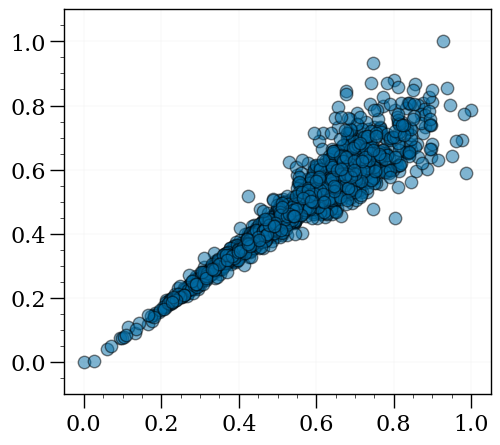

In [54]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [55]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [56]:
run(TrainingTensors, train_D, test_D, key, 'clayton_10')

  0%|          | 1/5000 [05:30<459:19:40, 330.78s/it]

Iter 0. Loss [[0.19052014 0.23867802 2.7917714 ]]


  0%|          | 11/5000 [10:54<10:11:49,  7.36s/it]

Iter 10. Loss [[0.19019155 0.23785706 2.7487645 ]]


  0%|          | 21/5000 [10:57<36:13,  2.29it/s]

Iter 20. Loss [[0.18967941 0.23687504 2.7083604 ]]


  1%|          | 31/5000 [10:59<17:33,  4.72it/s]

Iter 30. Loss [[0.18900855 0.23575212 2.669856  ]]


  1%|          | 41/5000 [11:02<21:00,  3.93it/s]

Iter 40. Loss [[0.18827653 0.23457621 2.6327038 ]]


  1%|          | 51/5000 [11:04<17:04,  4.83it/s]

Iter 50. Loss [[0.18751861 0.23337738 2.5966308 ]]


  1%|          | 61/5000 [11:06<16:56,  4.86it/s]

Iter 60. Loss [[0.18674612 0.23216294 2.561454  ]]


  1%|▏         | 72/5000 [11:11<23:45,  3.46it/s]

Iter 70. Loss [[0.18596098 0.23093204 2.527046  ]]


  2%|▏         | 82/5000 [11:13<17:03,  4.80it/s]

Iter 80. Loss [[0.18516305 0.22968215 2.4933157 ]]


  2%|▏         | 92/5000 [11:16<22:27,  3.64it/s]

Iter 90. Loss [[0.18435347 0.22841203 2.4601932 ]]


  2%|▏         | 101/5000 [11:18<17:30,  4.67it/s]

Iter 100. Loss [[0.18353511 0.22712253 2.427622  ]]


  2%|▏         | 111/5000 [11:20<17:02,  4.78it/s]

Iter 110. Loss [[0.18271211 0.22581583 2.3955584 ]]


  2%|▏         | 121/5000 [11:24<29:35,  2.75it/s]

Iter 120. Loss [[0.1818889  0.22449467 2.3639684 ]]


  3%|▎         | 132/5000 [11:26<16:47,  4.83it/s]

Iter 130. Loss [[0.18106952 0.22316176 2.3328285 ]]


  3%|▎         | 141/5000 [11:29<33:27,  2.42it/s]

Iter 140. Loss [[0.18025765 0.22181953 2.3021207 ]]


  3%|▎         | 152/5000 [11:31<17:06,  4.72it/s]

Iter 150. Loss [[0.17945635 0.22047022 2.2718315 ]]


  3%|▎         | 161/5000 [11:33<16:48,  4.80it/s]

Iter 160. Loss [[0.17866834 0.21911567 2.2419512 ]]


  3%|▎         | 171/5000 [11:37<30:01,  2.68it/s]

Iter 170. Loss [[0.17789598 0.21775769 2.2124703 ]]


  4%|▎         | 182/5000 [11:40<17:37,  4.56it/s]

Iter 180. Loss [[0.1771414  0.21639778 2.1833806 ]]


  4%|▍         | 191/5000 [11:42<16:35,  4.83it/s]

Iter 190. Loss [[0.17640656 0.21503748 2.1546745 ]]


  4%|▍         | 202/5000 [11:45<17:08,  4.67it/s]

Iter 200. Loss [[0.17569305 0.21367794 2.1263425 ]]


  4%|▍         | 211/5000 [11:47<16:28,  4.84it/s]

Iter 210. Loss [[0.17500243 0.21232048 2.0983772 ]]


  4%|▍         | 221/5000 [11:50<32:22,  2.46it/s]

Iter 220. Loss [[0.17433597 0.21096607 2.0707705 ]]


  5%|▍         | 232/5000 [11:54<19:50,  4.01it/s]

Iter 230. Loss [[0.17369491 0.20961568 2.0435126 ]]


  5%|▍         | 242/5000 [11:56<15:59,  4.96it/s]

Iter 240. Loss [[0.17308025 0.20827016 2.0165942 ]]


  5%|▌         | 252/5000 [11:59<16:42,  4.74it/s]

Iter 250. Loss [[0.17249283 0.20693034 1.9900059 ]]


  5%|▌         | 262/5000 [12:01<15:55,  4.96it/s]

Iter 260. Loss [[0.17193364 0.2055969  1.9637377 ]]


  5%|▌         | 271/5000 [12:04<32:58,  2.39it/s]

Iter 270. Loss [[0.17140324 0.20427051 1.9377799 ]]


  6%|▌         | 281/5000 [12:07<26:25,  2.98it/s]

Iter 280. Loss [[0.17090234 0.2029517  1.9121224 ]]


  6%|▌         | 291/5000 [12:09<16:18,  4.81it/s]

Iter 290. Loss [[0.17043146 0.20164102 1.886754  ]]


  6%|▌         | 301/5000 [12:12<18:49,  4.16it/s]

Iter 300. Loss [[0.16999114 0.20033893 1.8616647 ]]


  6%|▌         | 311/5000 [12:14<16:07,  4.85it/s]

Iter 310. Loss [[0.16958167 0.19904582 1.8368438 ]]


  6%|▋         | 321/5000 [12:17<38:33,  2.02it/s]

Iter 320. Loss [[0.1692035  0.19776204 1.8122809 ]]


  7%|▋         | 331/5000 [12:21<26:08,  2.98it/s]

Iter 330. Loss [[0.16885684 0.19648792 1.7879654 ]]


  7%|▋         | 341/5000 [12:23<17:29,  4.44it/s]

Iter 340. Loss [[0.16854203 0.19522367 1.7638863 ]]


  7%|▋         | 352/5000 [12:26<19:28,  3.98it/s]

Iter 350. Loss [[0.1682592 0.1939696 1.7400345]]


  7%|▋         | 362/5000 [12:28<15:53,  4.87it/s]

Iter 360. Loss [[0.16800854 0.19272587 1.716399  ]]


  7%|▋         | 371/5000 [12:30<15:57,  4.83it/s]

Iter 370. Loss [[0.16779011 0.19149259 1.6929705 ]]


  8%|▊         | 381/5000 [12:34<26:03,  2.95it/s]

Iter 380. Loss [[0.16760406 0.1902699  1.6697392 ]]


  8%|▊         | 391/5000 [12:37<18:42,  4.11it/s]

Iter 390. Loss [[0.16745052 0.18905795 1.646696  ]]


  8%|▊         | 401/5000 [12:40<26:46,  2.86it/s]

Iter 400. Loss [[0.16732937 0.18785673 1.623832  ]]


  8%|▊         | 412/5000 [12:42<15:52,  4.82it/s]

Iter 410. Loss [[0.1672407  0.18666634 1.6011388 ]]


  8%|▊         | 421/5000 [12:44<15:53,  4.80it/s]

Iter 420. Loss [[0.16718447 0.1854868  1.5786083 ]]


  9%|▊         | 431/5000 [12:48<26:27,  2.88it/s]

Iter 430. Loss [[0.1671607  0.18431807 1.5562316 ]]


  9%|▉         | 441/5000 [12:51<22:10,  3.43it/s]

Iter 440. Loss [[0.16716936 0.1831602  1.5340023 ]]


  9%|▉         | 451/5000 [12:54<32:09,  2.36it/s]

Iter 450. Loss [[0.16721036 0.18201314 1.5119131 ]]


  9%|▉         | 461/5000 [12:56<16:21,  4.62it/s]

Iter 460. Loss [[0.16728354 0.18087691 1.4899585 ]]


  9%|▉         | 472/5000 [12:58<15:26,  4.89it/s]

Iter 470. Loss [[0.16738895 0.17975143 1.4681313 ]]


 10%|▉         | 481/5000 [13:01<25:01,  3.01it/s]

Iter 480. Loss [[0.16752645 0.1786367  1.4464264 ]]


 10%|▉         | 491/5000 [13:05<25:05,  3.00it/s]

Iter 490. Loss [[0.16769591 0.17753263 1.4248385 ]]


 10%|█         | 501/5000 [13:07<15:47,  4.75it/s]

Iter 500. Loss [[0.16789716 0.17643918 1.4033631 ]]


 10%|█         | 511/5000 [13:10<16:16,  4.60it/s]

Iter 510. Loss [[0.16813014 0.17535633 1.3819951 ]]


 10%|█         | 522/5000 [13:12<15:15,  4.89it/s]

Iter 520. Loss [[0.16839468 0.17428398 1.3607315 ]]


 11%|█         | 531/5000 [13:15<26:06,  2.85it/s]

Iter 530. Loss [[0.1686906  0.17322212 1.3395681 ]]


 11%|█         | 541/5000 [13:18<25:01,  2.97it/s]

Iter 540. Loss [[0.1690177 0.1721707 1.3185028]]


 11%|█         | 551/5000 [13:21<16:16,  4.56it/s]

Iter 550. Loss [[0.16937575 0.17112966 1.2975327 ]]


 11%|█         | 561/5000 [13:24<17:53,  4.14it/s]

Iter 560. Loss [[0.16976456 0.17009896 1.2766554 ]]


 11%|█▏        | 571/5000 [13:26<15:30,  4.76it/s]

Iter 570. Loss [[0.17018388 0.16907862 1.2558697 ]]


 12%|█▏        | 581/5000 [13:29<36:32,  2.02it/s]

Iter 580. Loss [[0.1706334  0.16806856 1.2351747 ]]


 12%|█▏        | 591/5000 [13:32<24:34,  2.99it/s]

Iter 590. Loss [[0.1711127  0.16706881 1.2145694 ]]


 12%|█▏        | 602/5000 [13:35<16:13,  4.52it/s]

Iter 600. Loss [[0.17162143 0.1660794  1.1940548 ]]


 12%|█▏        | 612/5000 [13:38<18:38,  3.92it/s]

Iter 610. Loss [[0.17215902 0.16510037 1.1736317 ]]


 12%|█▏        | 621/5000 [13:40<15:14,  4.79it/s]

Iter 620. Loss [[0.17272492 0.16413178 1.1533022 ]]


 13%|█▎        | 631/5000 [13:42<15:14,  4.78it/s]

Iter 630. Loss [[0.17331825 0.16317381 1.13307   ]]


 13%|█▎        | 641/5000 [13:45<24:50,  2.92it/s]

Iter 640. Loss [[0.1739378  0.16222666 1.1129408 ]]


 13%|█▎        | 651/5000 [13:48<18:45,  3.86it/s]

Iter 650. Loss [[0.17458199 0.1612908  1.0929245 ]]


 13%|█▎        | 661/5000 [13:51<30:07,  2.40it/s]

Iter 660. Loss [[0.1752481 0.1603669 1.0730364]]


 13%|█▎        | 671/5000 [13:54<15:31,  4.65it/s]

Iter 670. Loss [[0.17593147 0.15945634 1.0533044 ]]


 14%|█▎        | 681/5000 [13:56<15:13,  4.73it/s]

Iter 680. Loss [[0.17662251 0.15856206 1.0337838 ]]


 14%|█▍        | 691/5000 [13:59<25:34,  2.81it/s]

Iter 690. Loss [[0.17729774 0.15769179 1.0146078 ]]


 14%|█▍        | 702/5000 [14:03<19:42,  3.63it/s]

Iter 700. Loss [[0.17787252 0.15687528 0.99619937]]


 14%|█▍        | 711/5000 [14:04<14:47,  4.83it/s]

Iter 710. Loss [[0.17800148 0.15626037 0.97893   ]]


 14%|█▍        | 722/5000 [14:08<14:57,  4.76it/s]

Iter 720. Loss [[0.17784837 0.15583557 0.9628688 ]]


 15%|█▍        | 731/5000 [14:09<14:53,  4.78it/s]

Iter 730. Loss [[0.17771305 0.1554737  0.94900584]]


 15%|█▍        | 741/5000 [14:13<22:42,  3.13it/s]

Iter 740. Loss [[0.1775202  0.15521134 0.9370901 ]]


 15%|█▌        | 751/5000 [14:16<24:12,  2.92it/s]

Iter 750. Loss [[0.17732671 0.15501383 0.9270887 ]]


 15%|█▌        | 761/5000 [14:18<15:05,  4.68it/s]

Iter 760. Loss [[0.17717004 0.15484935 0.91885126]]


 15%|█▌        | 771/5000 [14:21<15:31,  4.54it/s]

Iter 770. Loss [[0.17705147 0.15470788 0.9120796 ]]


 16%|█▌        | 782/5000 [14:23<14:24,  4.88it/s]

Iter 780. Loss [[0.17696975 0.15458074 0.9064762 ]]


 16%|█▌        | 792/5000 [14:27<25:01,  2.80it/s]

Iter 790. Loss [[0.17692243 0.15446018 0.9017682 ]]


 16%|█▌        | 801/5000 [14:30<23:32,  2.97it/s]

Iter 800. Loss [[0.17690623 0.15434042 0.8977296 ]]


 16%|█▌        | 811/5000 [14:32<15:19,  4.55it/s]

Iter 810. Loss [[0.17691728 0.15421806 0.89418757]]


 16%|█▋        | 821/5000 [14:35<17:38,  3.95it/s]

Iter 820. Loss [[0.17695126 0.15409201 0.8910166 ]]


 17%|█▋        | 832/5000 [14:37<14:47,  4.70it/s]

Iter 830. Loss [[0.17700347 0.15396254 0.88812876]]


 17%|█▋        | 841/5000 [14:39<14:16,  4.85it/s]

Iter 840. Loss [[0.1770693  0.15383086 0.8854595 ]]


 17%|█▋        | 851/5000 [14:43<23:07,  2.99it/s]

Iter 850. Loss [[0.1771449  0.15369822 0.8829627 ]]


 17%|█▋        | 861/5000 [14:46<17:16,  3.99it/s]

Iter 860. Loss [[0.1772271  0.15356591 0.880607  ]]


 17%|█▋        | 872/5000 [14:49<18:37,  3.69it/s]

Iter 870. Loss [[0.17731357 0.15343478 0.87837094]]


 18%|█▊        | 881/5000 [14:51<14:08,  4.86it/s]

Iter 880. Loss [[0.17740278 0.15330549 0.8762377 ]]


 18%|█▊        | 892/5000 [14:53<13:47,  4.97it/s]

Iter 890. Loss [[0.17749356 0.15317842 0.8741974 ]]


 18%|█▊        | 901/5000 [14:56<20:59,  3.25it/s]

Iter 900. Loss [[0.17758489 0.15305403 0.8722409 ]]


 18%|█▊        | 911/5000 [15:00<22:56,  2.97it/s]

Iter 910. Loss [[0.17767623 0.15293248 0.8703623 ]]


 18%|█▊        | 921/5000 [15:03<23:47,  2.86it/s]

Iter 920. Loss [[0.17776708 0.15281399 0.8685568 ]]


 19%|█▊        | 931/5000 [15:05<14:02,  4.83it/s]

Iter 930. Loss [[0.1778569  0.15269867 0.86682   ]]


 19%|█▉        | 942/5000 [15:07<13:34,  4.98it/s]

Iter 940. Loss [[0.17794564 0.15258656 0.8651488 ]]


 19%|█▉        | 951/5000 [15:10<16:06,  4.19it/s]

Iter 950. Loss [[0.1780329  0.15247767 0.86354196]]


 19%|█▉        | 961/5000 [15:13<22:18,  3.02it/s]

Iter 960. Loss [[0.1781185  0.15237215 0.86199325]]


 19%|█▉        | 972/5000 [15:17<28:00,  2.40it/s]

Iter 970. Loss [[0.1782022 0.15227   0.8605029]]


 20%|█▉        | 982/5000 [15:19<13:56,  4.81it/s]

Iter 980. Loss [[0.17828408 0.15217108 0.8590685 ]]


 20%|█▉        | 992/5000 [15:21<13:39,  4.89it/s]

Iter 990. Loss [[0.17836401 0.15207535 0.8576876 ]]


 20%|██        | 1001/5000 [15:23<20:43,  3.21it/s]

Iter 1000. Loss [[0.17844194 0.15198281 0.85635823]]


 20%|██        | 1011/5000 [15:26<21:35,  3.08it/s]

Iter 1010. Loss [[0.17851788 0.1518934  0.8550787 ]]


 20%|██        | 1022/5000 [15:29<14:51,  4.46it/s]

Iter 1020. Loss [[0.1785918  0.151807   0.85384685]]


 21%|██        | 1032/5000 [15:32<14:35,  4.53it/s]

Iter 1030. Loss [[0.17866378 0.15172349 0.8526627 ]]


 21%|██        | 1042/5000 [15:34<13:13,  4.99it/s]

Iter 1040. Loss [[0.17873368 0.15164289 0.85152197]]


 21%|██        | 1052/5000 [15:37<19:32,  3.37it/s]

Iter 1050. Loss [[0.1788017  0.15156506 0.850424  ]]


 21%|██        | 1061/5000 [15:40<19:28,  3.37it/s]

Iter 1060. Loss [[0.17886771 0.15148997 0.8493679 ]]


 21%|██▏       | 1072/5000 [15:43<19:00,  3.44it/s]

Iter 1070. Loss [[0.17893194 0.15141742 0.8483523 ]]


 22%|██▏       | 1082/5000 [15:46<15:32,  4.20it/s]

Iter 1080. Loss [[0.17899428 0.15134737 0.8473742 ]]


 22%|██▏       | 1092/5000 [15:48<13:16,  4.90it/s]

Iter 1090. Loss [[0.17905487 0.15127976 0.84643394]]


 22%|██▏       | 1101/5000 [15:50<13:12,  4.92it/s]

Iter 1100. Loss [[0.17911369 0.15121448 0.84552914]]


 22%|██▏       | 1111/5000 [15:53<14:30,  4.47it/s]

Iter 1110. Loss [[0.17917085 0.15115145 0.84465796]]


 22%|██▏       | 1121/5000 [15:56<21:12,  3.05it/s]

Iter 1120. Loss [[0.17922632 0.15109059 0.84382063]]


 23%|██▎       | 1132/5000 [16:00<18:09,  3.55it/s]

Iter 1130. Loss [[0.17928022 0.15103184 0.84301513]]


 23%|██▎       | 1141/5000 [16:02<13:23,  4.80it/s]

Iter 1140. Loss [[0.17933252 0.15097512 0.8422406 ]]


 23%|██▎       | 1151/5000 [16:04<13:07,  4.89it/s]

Iter 1150. Loss [[0.17938331 0.15092035 0.8414938 ]]


 23%|██▎       | 1161/5000 [16:07<14:36,  4.38it/s]

Iter 1160. Loss [[0.17943253 0.15086748 0.84077644]]


 23%|██▎       | 1171/5000 [16:10<20:43,  3.08it/s]

Iter 1170. Loss [[0.17948051 0.15081637 0.84008574]]


 24%|██▎       | 1181/5000 [16:13<24:35,  2.59it/s]

Iter 1180. Loss [[0.17952704 0.15076701 0.8394214 ]]


 24%|██▍       | 1191/5000 [16:15<13:27,  4.72it/s]

Iter 1190. Loss [[0.17957212 0.15071936 0.8387826 ]]


 24%|██▍       | 1202/5000 [16:18<12:58,  4.88it/s]

Iter 1200. Loss [[0.17961591 0.15067334 0.83816713]]


 24%|██▍       | 1212/5000 [16:21<13:48,  4.57it/s]

Iter 1210. Loss [[0.17965858 0.15062879 0.8375748 ]]


 24%|██▍       | 1221/5000 [16:23<19:47,  3.18it/s]

Iter 1220. Loss [[0.17969996 0.15058573 0.8370056 ]]


 25%|██▍       | 1231/5000 [16:27<30:46,  2.04it/s]

Iter 1230. Loss [[0.17974    0.15054423 0.83645725]]


 25%|██▍       | 1241/5000 [16:29<13:35,  4.61it/s]

Iter 1240. Loss [[0.17977901 0.15050408 0.8359284 ]]


 25%|██▌       | 1252/5000 [16:32<12:52,  4.85it/s]

Iter 1250. Loss [[0.17981678 0.15046532 0.8354191 ]]


 25%|██▌       | 1262/5000 [16:35<15:42,  3.97it/s]

Iter 1260. Loss [[0.17985366 0.1504277  0.83493066]]


 25%|██▌       | 1271/5000 [16:37<16:34,  3.75it/s]

Iter 1270. Loss [[0.17988935 0.15039143 0.8344596 ]]


 26%|██▌       | 1281/5000 [16:40<21:03,  2.94it/s]

Iter 1280. Loss [[0.179924   0.15035638 0.83400536]]


 26%|██▌       | 1292/5000 [16:43<13:35,  4.55it/s]

Iter 1290. Loss [[0.17995763 0.15032248 0.83356786]]


 26%|██▌       | 1301/5000 [16:45<12:47,  4.82it/s]

Iter 1300. Loss [[0.17999044 0.15028962 0.83314663]]


 26%|██▌       | 1312/5000 [16:48<18:38,  3.30it/s]

Iter 1310. Loss [[0.1800221  0.15025796 0.8327415 ]]


 26%|██▋       | 1321/5000 [16:50<13:05,  4.68it/s]

Iter 1320. Loss [[0.18005289 0.15022731 0.83235025]]


 27%|██▋       | 1331/5000 [16:53<20:23,  3.00it/s]

Iter 1330. Loss [[0.18008284 0.15019763 0.8319736 ]]


 27%|██▋       | 1342/5000 [16:57<14:39,  4.16it/s]

Iter 1340. Loss [[0.18011191 0.15016893 0.831611  ]]


 27%|██▋       | 1351/5000 [16:59<12:33,  4.84it/s]

Iter 1350. Loss [[0.18014017 0.15014115 0.83126104]]


 27%|██▋       | 1362/5000 [17:02<20:51,  2.91it/s]

Iter 1360. Loss [[0.18016763 0.15011428 0.83092445]]


 27%|██▋       | 1372/5000 [17:04<12:20,  4.90it/s]

Iter 1370. Loss [[0.1801942 0.1500883 0.8305998]]


 28%|██▊       | 1381/5000 [17:07<19:18,  3.12it/s]

Iter 1380. Loss [[0.18022011 0.15006316 0.8302859 ]]


 28%|██▊       | 1391/5000 [17:11<18:22,  3.27it/s]

Iter 1390. Loss [[0.18024522 0.15003881 0.8299842 ]]


 28%|██▊       | 1401/5000 [17:13<12:37,  4.75it/s]

Iter 1400. Loss [[0.18026955 0.15001528 0.82969254]]


 28%|██▊       | 1411/5000 [17:15<12:11,  4.91it/s]

Iter 1410. Loss [[0.18029325 0.14999253 0.8294118 ]]


 28%|██▊       | 1422/5000 [17:18<12:42,  4.69it/s]

Iter 1420. Loss [[0.18031628 0.1499704  0.82914144]]


 29%|██▊       | 1431/5000 [17:20<16:58,  3.50it/s]

Iter 1430. Loss [[0.18033853 0.14994912 0.8288799 ]]


 29%|██▉       | 1441/5000 [17:24<26:09,  2.27it/s]

Iter 1440. Loss [[0.18036029 0.1499284  0.8286283 ]]


 29%|██▉       | 1452/5000 [17:26<12:18,  4.80it/s]

Iter 1450. Loss [[0.18038128 0.14990844 0.82838523]]


 29%|██▉       | 1461/5000 [17:28<12:23,  4.76it/s]

Iter 1460. Loss [[0.1804017  0.1498891  0.82815135]]


 29%|██▉       | 1471/5000 [17:31<14:15,  4.12it/s]

Iter 1470. Loss [[0.1804216  0.14987032 0.8279254 ]]


 30%|██▉       | 1481/5000 [17:33<12:14,  4.79it/s]

Iter 1480. Loss [[0.18044086 0.1498522  0.827707  ]]


 30%|██▉       | 1492/5000 [17:38<26:13,  2.23it/s]

Iter 1490. Loss [[0.18045945 0.14983469 0.82749593]]


 30%|███       | 1502/5000 [17:40<12:12,  4.78it/s]

Iter 1500. Loss [[0.18047763 0.14981769 0.8272931 ]]


 30%|███       | 1512/5000 [17:42<11:52,  4.89it/s]

Iter 1510. Loss [[0.18049528 0.14980121 0.8270974 ]]


 30%|███       | 1522/5000 [17:45<13:56,  4.16it/s]

Iter 1520. Loss [[0.18051246 0.14978525 0.8269083 ]]


 31%|███       | 1532/5000 [17:47<11:43,  4.93it/s]

Iter 1530. Loss [[0.18052898 0.1497699  0.8267259 ]]


 31%|███       | 1541/5000 [17:50<18:29,  3.12it/s]

Iter 1540. Loss [[0.18054515 0.14975493 0.82654977]]


 31%|███       | 1551/5000 [17:53<13:42,  4.19it/s]

Iter 1550. Loss [[0.1805608  0.14974044 0.8263799 ]]


 31%|███       | 1562/5000 [17:55<11:35,  4.94it/s]

Iter 1560. Loss [[0.18057595 0.14972648 0.8262155 ]]


 31%|███▏      | 1572/5000 [17:58<15:40,  3.65it/s]

Iter 1570. Loss [[0.18059078 0.14971288 0.82605815]]


 32%|███▏      | 1581/5000 [18:00<11:56,  4.77it/s]

Iter 1580. Loss [[0.18060501 0.14969982 0.8259046 ]]


 32%|███▏      | 1591/5000 [18:03<16:23,  3.47it/s]

Iter 1590. Loss [[0.18061897 0.14968705 0.82575715]]


 32%|███▏      | 1602/5000 [18:07<13:55,  4.07it/s]

Iter 1600. Loss [[0.18063244 0.14967473 0.82561505]]


 32%|███▏      | 1611/5000 [18:09<11:41,  4.83it/s]

Iter 1610. Loss [[0.18064547 0.1496629  0.8254772 ]]


 32%|███▏      | 1622/5000 [18:12<23:02,  2.44it/s]

Iter 1620. Loss [[0.18065825 0.14965129 0.82534504]]


 33%|███▎      | 1631/5000 [18:14<12:11,  4.60it/s]

Iter 1630. Loss [[0.18067044 0.14964022 0.8252161 ]]


 33%|███▎      | 1641/5000 [18:16<11:38,  4.81it/s]

Iter 1640. Loss [[0.18068247 0.14962934 0.82509327]]


 33%|███▎      | 1652/5000 [18:20<18:45,  2.97it/s]

Iter 1650. Loss [[0.18069409 0.14961888 0.8249744 ]]


 33%|███▎      | 1661/5000 [18:22<12:00,  4.63it/s]

Iter 1660. Loss [[0.18070531 0.14960878 0.8248583 ]]


 33%|███▎      | 1671/5000 [18:24<11:31,  4.81it/s]

Iter 1670. Loss [[0.1807163 0.1495989 0.824748 ]]


 34%|███▎      | 1682/5000 [18:27<11:36,  4.76it/s]

Iter 1680. Loss [[0.1807268  0.1495895  0.82464015]]


 34%|███▍      | 1692/5000 [18:29<11:25,  4.83it/s]

Iter 1690. Loss [[0.18073711 0.14958026 0.82453734]]


 34%|███▍      | 1701/5000 [18:33<24:17,  2.26it/s]

Iter 1700. Loss [[0.18074712 0.14957136 0.8244375 ]]


 34%|███▍      | 1712/5000 [18:36<11:33,  4.74it/s]

Iter 1710. Loss [[0.18075675 0.14956276 0.8243406 ]]


 34%|███▍      | 1721/5000 [18:38<11:31,  4.74it/s]

Iter 1720. Loss [[0.18076614 0.14955446 0.8242479 ]]


 35%|███▍      | 1732/5000 [18:41<11:55,  4.57it/s]

Iter 1730. Loss [[0.18077518 0.14954638 0.824158  ]]


 35%|███▍      | 1741/5000 [18:43<11:12,  4.84it/s]

Iter 1740. Loss [[0.18078408 0.14953855 0.8240711 ]]


 35%|███▌      | 1751/5000 [18:46<28:09,  1.92it/s]

Iter 1750. Loss [[0.1807926  0.149531   0.82398844]]


 35%|███▌      | 1762/5000 [18:49<12:48,  4.21it/s]

Iter 1760. Loss [[0.180801   0.14952365 0.8239078 ]]


 35%|███▌      | 1771/5000 [18:51<11:20,  4.74it/s]

Iter 1770. Loss [[0.18080892 0.14951666 0.8238299 ]]


 36%|███▌      | 1782/5000 [18:54<12:58,  4.13it/s]

Iter 1780. Loss [[0.18081681 0.1495097  0.8237552 ]]


 36%|███▌      | 1792/5000 [18:56<11:01,  4.85it/s]

Iter 1790. Loss [[0.18082438 0.1495031  0.8236823 ]]


 36%|███▌      | 1801/5000 [18:59<30:19,  1.76it/s]

Iter 1800. Loss [[0.1808317  0.14949667 0.8236128 ]]


 36%|███▌      | 1812/5000 [19:03<14:50,  3.58it/s]

Iter 1810. Loss [[0.18083872 0.14949054 0.82354575]]


 36%|███▋      | 1822/5000 [19:05<10:39,  4.97it/s]

Iter 1820. Loss [[0.18084581 0.14948443 0.82348126]]


 37%|███▋      | 1832/5000 [19:08<13:16,  3.98it/s]

Iter 1830. Loss [[0.18085237 0.1494787  0.82341844]]


 37%|███▋      | 1842/5000 [19:10<10:34,  4.98it/s]

Iter 1840. Loss [[0.1808589  0.14947304 0.8233583 ]]


 37%|███▋      | 1851/5000 [19:12<10:46,  4.87it/s]

Iter 1850. Loss [[0.18086511 0.14946765 0.82329994]]


 37%|███▋      | 1861/5000 [19:16<18:26,  2.84it/s]

Iter 1860. Loss [[0.18087128 0.14946236 0.82324463]]


 37%|███▋      | 1871/5000 [19:18<11:09,  4.67it/s]

Iter 1870. Loss [[0.18087721 0.14945725 0.8231909 ]]


 38%|███▊      | 1881/5000 [19:21<21:06,  2.46it/s]

Iter 1880. Loss [[0.18088283 0.1494524  0.82313836]]


 38%|███▊      | 1892/5000 [19:23<10:40,  4.85it/s]

Iter 1890. Loss [[0.18088843 0.1494476  0.8230889 ]]


 38%|███▊      | 1901/5000 [19:25<10:50,  4.76it/s]

Iter 1900. Loss [[0.18089384 0.14944299 0.8230402 ]]


 38%|███▊      | 1911/5000 [19:29<19:08,  2.69it/s]

Iter 1910. Loss [[0.18089892 0.14943863 0.8229939 ]]


 38%|███▊      | 1922/5000 [19:32<11:43,  4.38it/s]

Iter 1920. Loss [[0.18090409 0.14943424 0.82294905]]


 39%|███▊      | 1932/5000 [19:35<20:26,  2.50it/s]

Iter 1930. Loss [[0.18090893 0.1494301  0.82290626]]


 39%|███▉      | 1942/5000 [19:37<10:36,  4.80it/s]

Iter 1940. Loss [[0.1809137  0.14942609 0.82286525]]


 39%|███▉      | 1952/5000 [19:39<10:12,  4.98it/s]

Iter 1950. Loss [[0.18091823 0.1494222  0.82282543]]


 39%|███▉      | 1961/5000 [19:42<18:20,  2.76it/s]

Iter 1960. Loss [[0.18092261 0.1494185  0.8227866 ]]


 39%|███▉      | 1971/5000 [19:45<16:45,  3.01it/s]

Iter 1970. Loss [[0.18092708 0.1494148  0.8227505 ]]


 40%|███▉      | 1982/5000 [19:48<10:22,  4.85it/s]

Iter 1980. Loss [[0.1809312  0.14941128 0.82271445]]


 40%|███▉      | 1991/5000 [19:50<11:05,  4.52it/s]

Iter 1990. Loss [[0.18093522 0.14940792 0.82268   ]]


 40%|████      | 2001/5000 [19:52<10:23,  4.81it/s]

Iter 2000. Loss [[0.1809391  0.14940467 0.82264674]]


 40%|████      | 2011/5000 [19:56<17:51,  2.79it/s]

Iter 2010. Loss [[0.18094295 0.14940146 0.82261574]]


 40%|████      | 2021/5000 [19:59<16:23,  3.03it/s]

Iter 2020. Loss [[0.18094659 0.14939842 0.8225856 ]]


 41%|████      | 2032/5000 [20:01<10:29,  4.72it/s]

Iter 2030. Loss [[0.18095002 0.14939554 0.8225563 ]]


 41%|████      | 2041/5000 [20:04<11:47,  4.18it/s]

Iter 2040. Loss [[0.18095353 0.14939263 0.8225284 ]]


 41%|████      | 2051/5000 [20:06<10:16,  4.78it/s]

Iter 2050. Loss [[0.1809569  0.14938988 0.822502  ]]


 41%|████      | 2062/5000 [20:09<17:03,  2.87it/s]

Iter 2060. Loss [[0.18096007 0.14938724 0.82247525]]


 41%|████▏     | 2071/5000 [20:12<16:20,  2.99it/s]

Iter 2070. Loss [[0.18096319 0.14938468 0.82245076]]


 42%|████▏     | 2081/5000 [20:15<11:22,  4.27it/s]

Iter 2080. Loss [[0.18096623 0.1493822  0.82242686]]


 42%|████▏     | 2091/5000 [20:18<12:18,  3.94it/s]

Iter 2090. Loss [[0.18096915 0.14937979 0.82240427]]


 42%|████▏     | 2102/5000 [20:20<09:50,  4.91it/s]

Iter 2100. Loss [[0.18097192 0.14937751 0.822382  ]]


 42%|████▏     | 2111/5000 [20:22<09:57,  4.83it/s]

Iter 2110. Loss [[0.18097472 0.14937524 0.8223613 ]]


 42%|████▏     | 2121/5000 [20:26<15:26,  3.11it/s]

Iter 2120. Loss [[0.18097733 0.1493731  0.82234067]]


 43%|████▎     | 2132/5000 [20:29<12:40,  3.77it/s]

Iter 2130. Loss [[0.18097986 0.14937107 0.8223218 ]]


 43%|████▎     | 2141/5000 [20:32<15:14,  3.13it/s]

Iter 2140. Loss [[0.18098243 0.14936902 0.82230324]]


 43%|████▎     | 2151/5000 [20:34<09:45,  4.86it/s]

Iter 2150. Loss [[0.18098475 0.14936712 0.822285  ]]


 43%|████▎     | 2161/5000 [20:36<09:40,  4.89it/s]

Iter 2160. Loss [[0.18098703 0.14936528 0.8222675 ]]


 43%|████▎     | 2171/5000 [20:39<13:03,  3.61it/s]

Iter 2170. Loss [[0.18098928 0.14936347 0.82225186]]


 44%|████▎     | 2181/5000 [20:42<15:38,  3.00it/s]

Iter 2180. Loss [[0.1809915  0.14936168 0.8222362 ]]


 44%|████▍     | 2192/5000 [20:46<12:53,  3.63it/s]

Iter 2190. Loss [[0.18099359 0.14936006 0.82222134]]


 44%|████▍     | 2202/5000 [20:48<09:28,  4.92it/s]

Iter 2200. Loss [[0.1809956  0.14935847 0.82220656]]


 44%|████▍     | 2212/5000 [20:50<09:23,  4.95it/s]

Iter 2210. Loss [[0.18099758 0.14935689 0.8221933 ]]


 44%|████▍     | 2222/5000 [20:53<10:13,  4.53it/s]

Iter 2220. Loss [[0.18099944 0.1493554  0.82218003]]


 45%|████▍     | 2231/5000 [20:56<15:09,  3.05it/s]

Iter 2230. Loss [[0.18100125 0.149354   0.82216716]]


 45%|████▍     | 2242/5000 [20:59<16:29,  2.79it/s]

Iter 2240. Loss [[0.18100312 0.14935252 0.8221561 ]]


 45%|████▌     | 2251/5000 [21:01<09:39,  4.75it/s]

Iter 2250. Loss [[0.1810049  0.14935115 0.8221441 ]]


 45%|████▌     | 2262/5000 [21:03<09:16,  4.92it/s]

Iter 2260. Loss [[0.18100643 0.14934993 0.8221327 ]]


 45%|████▌     | 2271/5000 [21:06<11:31,  3.94it/s]

Iter 2270. Loss [[0.18100803 0.14934868 0.8221226 ]]


 46%|████▌     | 2281/5000 [21:09<14:49,  3.06it/s]

Iter 2280. Loss [[0.18100962 0.14934745 0.8221123 ]]


 46%|████▌     | 2291/5000 [21:12<11:54,  3.79it/s]

Iter 2290. Loss [[0.18101111 0.14934629 0.822103  ]]


 46%|████▌     | 2301/5000 [21:15<10:00,  4.49it/s]

Iter 2300. Loss [[0.18101248 0.14934525 0.82209367]]


 46%|████▌     | 2311/5000 [21:17<09:22,  4.78it/s]

Iter 2310. Loss [[0.18101403 0.14934406 0.82208544]]


 46%|████▋     | 2321/5000 [21:20<12:08,  3.68it/s]

Iter 2320. Loss [[0.18101539 0.14934301 0.82207763]]


 47%|████▋     | 2331/5000 [21:23<12:58,  3.43it/s]

Iter 2330. Loss [[0.18101661 0.14934206 0.8220689 ]]


 47%|████▋     | 2341/5000 [21:26<15:16,  2.90it/s]

Iter 2340. Loss [[0.18101783 0.14934117 0.82206154]]


 47%|████▋     | 2352/5000 [21:29<09:25,  4.68it/s]

Iter 2350. Loss [[0.18101911 0.14934021 0.8220541 ]]


 47%|████▋     | 2361/5000 [21:31<09:00,  4.89it/s]

Iter 2360. Loss [[0.18102023 0.14933935 0.82204753]]


 47%|████▋     | 2372/5000 [21:34<13:21,  3.28it/s]

Iter 2370. Loss [[0.18102129 0.14933851 0.82204103]]


 48%|████▊     | 2381/5000 [21:36<10:36,  4.12it/s]

Iter 2380. Loss [[0.18102257 0.14933759 0.8220354 ]]


 48%|████▊     | 2391/5000 [21:40<14:33,  2.99it/s]

Iter 2390. Loss [[0.18102373 0.14933673 0.8220301 ]]


 48%|████▊     | 2401/5000 [21:43<10:15,  4.22it/s]

Iter 2400. Loss [[0.18102464 0.14933605 0.8220235 ]]


 48%|████▊     | 2411/5000 [21:45<08:45,  4.93it/s]

Iter 2410. Loss [[0.1810255  0.14933541 0.8220182 ]]


 48%|████▊     | 2421/5000 [21:48<17:26,  2.46it/s]

Iter 2420. Loss [[0.18102644 0.14933471 0.822013  ]]


 49%|████▊     | 2432/5000 [21:50<08:49,  4.85it/s]

Iter 2430. Loss [[0.1810275  0.14933394 0.82200897]]


 49%|████▉     | 2441/5000 [21:53<13:57,  3.05it/s]

Iter 2440. Loss [[0.1810285  0.1493332  0.82200474]]


 49%|████▉     | 2451/5000 [21:57<11:55,  3.56it/s]

Iter 2450. Loss [[0.18102936 0.14933258 0.8220005 ]]


 49%|████▉     | 2462/5000 [21:59<08:43,  4.85it/s]

Iter 2460. Loss [[0.18103011 0.14933203 0.8219959 ]]


 49%|████▉     | 2471/5000 [22:01<08:49,  4.77it/s]

Iter 2470. Loss [[0.18103087 0.1493315  0.8219921 ]]


 50%|████▉     | 2482/5000 [22:04<08:55,  4.70it/s]

Iter 2480. Loss [[0.18103164 0.14933096 0.82198805]]


 50%|████▉     | 2491/5000 [22:06<13:13,  3.16it/s]

Iter 2490. Loss [[0.18103237 0.1493304  0.82198423]]


 50%|█████     | 2502/5000 [22:11<12:52,  3.24it/s]

Iter 2500. Loss [[0.18103312 0.14932989 0.82198125]]


 50%|█████     | 2512/5000 [22:13<08:32,  4.86it/s]

Iter 2510. Loss [[0.18103379 0.14932941 0.82197845]]


 50%|█████     | 2522/5000 [22:15<08:23,  4.92it/s]

Iter 2520. Loss [[0.18103452 0.1493289  0.82197523]]


 51%|█████     | 2532/5000 [22:18<09:20,  4.40it/s]

Iter 2530. Loss [[0.18103519 0.14932841 0.8219725 ]]


 51%|█████     | 2541/5000 [22:20<10:50,  3.78it/s]

Iter 2540. Loss [[0.18103579 0.149328   0.82197005]]


 51%|█████     | 2552/5000 [22:24<16:59,  2.40it/s]

Iter 2550. Loss [[0.18103647 0.14932752 0.8219678 ]]


 51%|█████     | 2561/5000 [22:26<08:44,  4.65it/s]

Iter 2560. Loss [[0.1810371  0.14932707 0.8219654 ]]


 51%|█████▏    | 2572/5000 [22:28<08:07,  4.98it/s]

Iter 2570. Loss [[0.18103756 0.14932674 0.82196337]]


 52%|█████▏    | 2582/5000 [22:31<09:34,  4.21it/s]

Iter 2580. Loss [[0.18103813 0.14932634 0.8219614 ]]


 52%|█████▏    | 2592/5000 [22:33<08:16,  4.85it/s]

Iter 2590. Loss [[0.18103862 0.14932601 0.82195944]]


 52%|█████▏    | 2601/5000 [22:36<13:06,  3.05it/s]

Iter 2600. Loss [[0.18103917 0.14932564 0.8219575 ]]


 52%|█████▏    | 2611/5000 [22:39<09:03,  4.40it/s]

Iter 2610. Loss [[0.1810397  0.14932525 0.8219556 ]]


 52%|█████▏    | 2622/5000 [22:42<08:13,  4.82it/s]

Iter 2620. Loss [[0.18104018 0.14932492 0.82195425]]


 53%|█████▎    | 2631/5000 [22:45<11:07,  3.55it/s]

Iter 2630. Loss [[0.1810407  0.14932458 0.8219531 ]]


 53%|█████▎    | 2642/5000 [22:47<07:56,  4.95it/s]

Iter 2640. Loss [[0.18104123 0.14932425 0.82195157]]


 53%|█████▎    | 2651/5000 [22:49<12:13,  3.20it/s]

Iter 2650. Loss [[0.18104157 0.14932401 0.8219502 ]]


 53%|█████▎    | 2662/5000 [22:53<08:56,  4.36it/s]

Iter 2660. Loss [[0.18104203 0.14932373 0.82194936]]


 53%|█████▎    | 2672/5000 [22:55<07:52,  4.93it/s]

Iter 2670. Loss [[0.18104242 0.14932346 0.82194775]]


 54%|█████▎    | 2681/5000 [22:58<13:22,  2.89it/s]

Iter 2680. Loss [[0.18104276 0.14932323 0.8219469 ]]


 54%|█████▍    | 2692/5000 [23:00<07:57,  4.83it/s]

Iter 2690. Loss [[0.18104315 0.14932299 0.8219458 ]]


 54%|█████▍    | 2701/5000 [23:02<09:26,  4.06it/s]

Iter 2700. Loss [[0.18104346 0.14932275 0.82194483]]


 54%|█████▍    | 2712/5000 [23:07<10:12,  3.73it/s]

Iter 2710. Loss [[0.1810439 0.1493225 0.8219442]]


 54%|█████▍    | 2722/5000 [23:09<07:46,  4.89it/s]

Iter 2720. Loss [[0.18104433 0.14932223 0.82194304]]


 55%|█████▍    | 2732/5000 [23:12<11:22,  3.32it/s]

Iter 2730. Loss [[0.18104458 0.14932208 0.82194245]]


 55%|█████▍    | 2742/5000 [23:14<07:54,  4.76it/s]

Iter 2740. Loss [[0.18104483 0.14932188 0.821942  ]]


 55%|█████▌    | 2751/5000 [23:15<07:43,  4.85it/s]

Iter 2750. Loss [[0.18104514 0.14932168 0.8219416 ]]


 55%|█████▌    | 2761/5000 [23:20<13:47,  2.71it/s]

Iter 2760. Loss [[0.18104538 0.14932153 0.8219407 ]]


 55%|█████▌    | 2771/5000 [23:22<07:55,  4.68it/s]

Iter 2770. Loss [[0.18104567 0.14932136 0.8219395 ]]


 56%|█████▌    | 2782/5000 [23:25<15:16,  2.42it/s]

Iter 2780. Loss [[0.18104589 0.14932121 0.8219393 ]]


 56%|█████▌    | 2791/5000 [23:27<07:50,  4.70it/s]

Iter 2790. Loss [[0.18104611 0.14932108 0.8219386 ]]


 56%|█████▌    | 2802/5000 [23:29<07:27,  4.91it/s]

Iter 2800. Loss [[0.18104641 0.14932089 0.82193863]]


 56%|█████▌    | 2811/5000 [23:33<14:40,  2.49it/s]

Iter 2810. Loss [[0.18104662 0.14932075 0.8219379 ]]


 56%|█████▋    | 2822/5000 [23:36<07:49,  4.64it/s]

Iter 2820. Loss [[0.18104696 0.14932056 0.82193756]]


 57%|█████▋    | 2831/5000 [23:37<07:22,  4.90it/s]

Iter 2830. Loss [[0.18104726 0.14932035 0.821938  ]]


 57%|█████▋    | 2841/5000 [23:40<07:47,  4.62it/s]

Iter 2840. Loss [[0.18104756 0.14932016 0.8219377 ]]


 57%|█████▋    | 2851/5000 [23:42<07:31,  4.76it/s]

Iter 2850. Loss [[0.18104766 0.14932011 0.8219373 ]]


 57%|█████▋    | 2861/5000 [23:46<14:22,  2.48it/s]

Iter 2860. Loss [[0.18104772 0.14932007 0.8219365 ]]


 57%|█████▋    | 2871/5000 [23:49<09:40,  3.67it/s]

Iter 2870. Loss [[0.18104799 0.1493199  0.8219364 ]]


 58%|█████▊    | 2881/5000 [23:51<07:22,  4.79it/s]

Iter 2880. Loss [[0.1810482  0.14931978 0.82193637]]


 58%|█████▊    | 2891/5000 [23:54<08:00,  4.39it/s]

Iter 2890. Loss [[0.18104833 0.1493197  0.8219365 ]]


 58%|█████▊    | 2901/5000 [23:56<07:11,  4.87it/s]

Iter 2900. Loss [[0.18104854 0.1493196  0.8219359 ]]


 58%|█████▊    | 2911/5000 [23:59<16:26,  2.12it/s]

Iter 2910. Loss [[0.18104875 0.14931948 0.82193613]]


 58%|█████▊    | 2921/5000 [24:03<11:47,  2.94it/s]

Iter 2920. Loss [[0.18104891 0.14931938 0.82193613]]


 59%|█████▊    | 2931/5000 [24:05<07:10,  4.81it/s]

Iter 2930. Loss [[0.18104929 0.14931916 0.8219366 ]]


 59%|█████▉    | 2941/5000 [24:08<08:13,  4.17it/s]

Iter 2940. Loss [[0.18104936 0.1493191  0.8219365 ]]


 59%|█████▉    | 2951/5000 [24:10<07:04,  4.82it/s]

Iter 2950. Loss [[0.1810494 0.1493191 0.8219356]]


 59%|█████▉    | 2961/5000 [24:13<16:54,  2.01it/s]

Iter 2960. Loss [[0.18104957 0.149319   0.8219356 ]]


 59%|█████▉    | 2971/5000 [24:16<11:21,  2.98it/s]

Iter 2970. Loss [[0.18104969 0.14931893 0.8219353 ]]


 60%|█████▉    | 2982/5000 [24:19<07:06,  4.73it/s]

Iter 2980. Loss [[0.18104982 0.14931886 0.82193613]]


 60%|█████▉    | 2992/5000 [24:22<08:29,  3.94it/s]

Iter 2990. Loss [[0.18104999 0.14931874 0.82193553]]


 60%|██████    | 3002/5000 [24:24<06:44,  4.94it/s]

Iter 3000. Loss [[0.1810502  0.14931864 0.8219357 ]]


 60%|██████    | 3012/5000 [24:26<06:44,  4.92it/s]

Iter 3010. Loss [[0.18105029 0.14931856 0.8219357 ]]


 60%|██████    | 3021/5000 [24:29<10:56,  3.01it/s]

Iter 3020. Loss [[0.18105032 0.14931858 0.8219355 ]]


 61%|██████    | 3031/5000 [24:32<08:44,  3.75it/s]

Iter 3030. Loss [[0.18105043 0.1493185  0.82193524]]


 61%|██████    | 3041/5000 [24:35<13:29,  2.42it/s]

Iter 3040. Loss [[0.18105078 0.14931826 0.82193685]]


 61%|██████    | 3051/5000 [24:37<06:47,  4.79it/s]

Iter 3050. Loss [[0.18105073 0.14931832 0.82193613]]


 61%|██████    | 3061/5000 [24:39<06:39,  4.86it/s]

Iter 3060. Loss [[0.18105085 0.14931823 0.82193613]]


 61%|██████▏   | 3071/5000 [24:43<11:03,  2.91it/s]

Iter 3070. Loss [[0.18105106 0.1493181  0.82193685]]


 62%|██████▏   | 3081/5000 [24:46<10:48,  2.96it/s]

Iter 3080. Loss [[0.18105088 0.14931823 0.8219356 ]]


 62%|██████▏   | 3092/5000 [24:49<12:53,  2.47it/s]

Iter 3090. Loss [[0.1810511 0.1493181 0.8219362]]


 62%|██████▏   | 3102/5000 [24:51<06:36,  4.79it/s]

Iter 3100. Loss [[0.18105125 0.14931801 0.8219365 ]]


 62%|██████▏   | 3111/5000 [24:53<06:24,  4.91it/s]

Iter 3110. Loss [[0.18105125 0.14931802 0.82193613]]


 62%|██████▏   | 3121/5000 [24:56<08:41,  3.61it/s]

Iter 3120. Loss [[0.18105148 0.14931786 0.821937  ]]


 63%|██████▎   | 3131/5000 [25:00<10:21,  3.01it/s]

Iter 3130. Loss [[0.18105139 0.14931794 0.8219364 ]]


 63%|██████▎   | 3141/5000 [25:02<06:39,  4.65it/s]

Iter 3140. Loss [[0.18105139 0.14931794 0.82193595]]


 63%|██████▎   | 3152/5000 [25:05<06:35,  4.67it/s]

Iter 3150. Loss [[0.18105154 0.14931785 0.8219365 ]]


 63%|██████▎   | 3161/5000 [25:07<06:13,  4.92it/s]

Iter 3160. Loss [[0.18105161 0.14931782 0.8219365 ]]


 63%|██████▎   | 3172/5000 [25:10<08:15,  3.69it/s]

Iter 3170. Loss [[0.1810518  0.14931768 0.82193685]]


 64%|██████▎   | 3181/5000 [25:13<09:55,  3.06it/s]

Iter 3180. Loss [[0.18105175 0.14931773 0.8219368 ]]


 64%|██████▍   | 3192/5000 [25:16<06:57,  4.33it/s]

Iter 3190. Loss [[0.18105175 0.14931774 0.82193637]]


 64%|██████▍   | 3202/5000 [25:19<06:37,  4.52it/s]

Iter 3200. Loss [[0.18105197 0.1493176  0.82193685]]


 64%|██████▍   | 3212/5000 [25:21<06:09,  4.84it/s]

Iter 3210. Loss [[0.18105195 0.14931762 0.82193685]]


 64%|██████▍   | 3221/5000 [25:24<12:05,  2.45it/s]

Iter 3220. Loss [[0.18105203 0.14931759 0.82193667]]


 65%|██████▍   | 3231/5000 [25:26<09:07,  3.23it/s]

Iter 3230. Loss [[0.18105212 0.14931755 0.8219373 ]]


 65%|██████▍   | 3241/5000 [25:30<09:14,  3.17it/s]

Iter 3240. Loss [[0.18105204 0.14931758 0.821937  ]]


 65%|██████▌   | 3252/5000 [25:33<06:56,  4.19it/s]

Iter 3250. Loss [[0.18105228 0.14931743 0.82193726]]


 65%|██████▌   | 3261/5000 [25:35<05:59,  4.84it/s]

Iter 3260. Loss [[0.18105216 0.14931752 0.82193714]]


 65%|██████▌   | 3271/5000 [25:37<05:58,  4.82it/s]

Iter 3270. Loss [[0.18105234 0.1493174  0.82193756]]


 66%|██████▌   | 3281/5000 [25:40<07:24,  3.87it/s]

Iter 3280. Loss [[0.18105227 0.14931746 0.8219378 ]]


 66%|██████▌   | 3291/5000 [25:43<09:20,  3.05it/s]

Iter 3290. Loss [[0.18105237 0.14931741 0.8219377 ]]


 66%|██████▌   | 3301/5000 [25:47<09:04,  3.12it/s]

Iter 3300. Loss [[0.18105239 0.1493174  0.8219377 ]]


 66%|██████▌   | 3311/5000 [25:49<06:01,  4.68it/s]

Iter 3310. Loss [[0.18105245 0.14931735 0.8219378 ]]


 66%|██████▋   | 3321/5000 [25:51<05:49,  4.80it/s]

Iter 3320. Loss [[0.18105246 0.14931735 0.8219374 ]]


 67%|██████▋   | 3331/5000 [25:54<06:37,  4.20it/s]

Iter 3330. Loss [[0.18105265 0.14931722 0.8219383 ]]


 67%|██████▋   | 3341/5000 [25:57<09:01,  3.06it/s]

Iter 3340. Loss [[0.18105243 0.1493174  0.8219373 ]]


 67%|██████▋   | 3351/5000 [26:00<11:36,  2.37it/s]

Iter 3350. Loss [[0.18105267 0.14931723 0.8219386 ]]


 67%|██████▋   | 3362/5000 [26:03<05:40,  4.82it/s]

Iter 3360. Loss [[0.18105258 0.14931728 0.82193774]]


 67%|██████▋   | 3372/5000 [26:05<05:34,  4.87it/s]

Iter 3370. Loss [[0.1810528  0.14931716 0.82193846]]


 68%|██████▊   | 3382/5000 [26:08<06:03,  4.45it/s]

Iter 3380. Loss [[0.18105245 0.14931743 0.8219373 ]]


 68%|██████▊   | 3391/5000 [26:10<08:32,  3.14it/s]

Iter 3390. Loss [[0.18105298 0.14931704 0.82193923]]


 68%|██████▊   | 3401/5000 [26:14<15:20,  1.74it/s]

Iter 3400. Loss [[0.18105264 0.14931728 0.8219377 ]]


 68%|██████▊   | 3411/5000 [26:16<05:40,  4.66it/s]

Iter 3410. Loss [[0.18105297 0.14931707 0.82193893]]


 68%|██████▊   | 3421/5000 [26:18<05:27,  4.83it/s]

Iter 3420. Loss [[0.18105271 0.14931725 0.8219379 ]]


 69%|██████▊   | 3431/5000 [26:21<06:39,  3.93it/s]

Iter 3430. Loss [[0.18105294 0.1493171  0.8219382 ]]


 69%|██████▉   | 3441/5000 [26:24<07:22,  3.52it/s]

Iter 3440. Loss [[0.18105277 0.1493172  0.82193804]]


 69%|██████▉   | 3451/5000 [26:27<08:41,  2.97it/s]

Iter 3450. Loss [[0.18105295 0.1493171  0.8219391 ]]


 69%|██████▉   | 3462/5000 [26:30<05:38,  4.55it/s]

Iter 3460. Loss [[0.18105295 0.1493171  0.82193905]]


 69%|██████▉   | 3471/5000 [26:32<05:17,  4.82it/s]

Iter 3470. Loss [[0.18105288 0.14931716 0.8219379 ]]


 70%|██████▉   | 3481/5000 [26:35<06:58,  3.63it/s]

Iter 3480. Loss [[0.18105277 0.14931725 0.82193816]]


 70%|██████▉   | 3491/5000 [26:37<05:23,  4.66it/s]

Iter 3490. Loss [[0.18105306 0.14931704 0.82193863]]


 70%|███████   | 3501/5000 [26:41<08:19,  3.00it/s]

Iter 3500. Loss [[0.18105297 0.1493171  0.8219389 ]]


 70%|███████   | 3512/5000 [26:44<05:30,  4.51it/s]

Iter 3510. Loss [[0.18105315 0.14931698 0.8219393 ]]


 70%|███████   | 3521/5000 [26:46<05:13,  4.71it/s]

Iter 3520. Loss [[0.18105291 0.14931716 0.82193863]]


 71%|███████   | 3532/5000 [26:49<07:24,  3.30it/s]

Iter 3530. Loss [[0.18105295 0.14931713 0.82193893]]


 71%|███████   | 3542/5000 [26:51<05:05,  4.78it/s]

Iter 3540. Loss [[0.18105325 0.1493169  0.82193995]]


 71%|███████   | 3551/5000 [26:54<07:58,  3.03it/s]

Iter 3550. Loss [[0.18105313 0.14931701 0.8219389 ]]


 71%|███████   | 3562/5000 [26:58<05:52,  4.08it/s]

Iter 3560. Loss [[0.18105306 0.14931706 0.8219384 ]]


 71%|███████▏  | 3571/5000 [27:00<04:53,  4.87it/s]

Iter 3570. Loss [[0.18105306 0.14931707 0.8219387 ]]


 72%|███████▏  | 3581/5000 [27:03<11:49,  2.00it/s]

Iter 3580. Loss [[0.18105313 0.14931701 0.82193905]]


 72%|███████▏  | 3591/5000 [27:05<05:00,  4.68it/s]

Iter 3590. Loss [[0.18105337 0.14931685 0.82193995]]


 72%|███████▏  | 3601/5000 [27:07<07:02,  3.31it/s]

Iter 3600. Loss [[0.1810533  0.14931689 0.82193947]]


 72%|███████▏  | 3612/5000 [27:12<07:16,  3.18it/s]

Iter 3610. Loss [[0.18105298 0.14931713 0.82193863]]


 72%|███████▏  | 3621/5000 [27:13<05:00,  4.59it/s]

Iter 3620. Loss [[0.18105306 0.1493171  0.8219391 ]]


 73%|███████▎  | 3632/5000 [27:16<04:39,  4.90it/s]

Iter 3630. Loss [[0.18105324 0.14931694 0.8219395 ]]


 73%|███████▎  | 3642/5000 [27:19<04:58,  4.55it/s]

Iter 3640. Loss [[0.18105318 0.149317   0.8219387 ]]


 73%|███████▎  | 3651/5000 [27:21<05:36,  4.01it/s]

Iter 3650. Loss [[0.18105315 0.14931701 0.8219388 ]]


 73%|███████▎  | 3662/5000 [27:25<09:31,  2.34it/s]

Iter 3660. Loss [[0.18105322 0.14931697 0.8219393 ]]


 73%|███████▎  | 3672/5000 [27:27<04:37,  4.79it/s]

Iter 3670. Loss [[0.18105328 0.1493169  0.82193905]]


 74%|███████▎  | 3682/5000 [27:29<04:30,  4.87it/s]

Iter 3680. Loss [[0.18105333 0.14931688 0.82193947]]


 74%|███████▍  | 3691/5000 [27:32<05:34,  3.92it/s]

Iter 3690. Loss [[0.1810533  0.14931688 0.8219391 ]]


 74%|███████▍  | 3701/5000 [27:34<04:32,  4.76it/s]

Iter 3700. Loss [[0.18105318 0.149317   0.82193893]]


 74%|███████▍  | 3711/5000 [27:37<07:08,  3.01it/s]

Iter 3710. Loss [[0.18105324 0.14931695 0.82193977]]


 74%|███████▍  | 3722/5000 [27:41<04:38,  4.59it/s]

Iter 3720. Loss [[0.18105324 0.14931695 0.82193905]]


 75%|███████▍  | 3731/5000 [27:43<04:30,  4.69it/s]

Iter 3730. Loss [[0.18105313 0.14931706 0.82193893]]


 75%|███████▍  | 3742/5000 [27:46<05:43,  3.66it/s]

Iter 3740. Loss [[0.18105328 0.14931694 0.8219391 ]]


 75%|███████▌  | 3752/5000 [27:48<04:17,  4.85it/s]

Iter 3750. Loss [[0.1810533  0.14931692 0.82193977]]


 75%|███████▌  | 3761/5000 [27:50<06:27,  3.20it/s]

Iter 3760. Loss [[0.1810533  0.14931692 0.8219393 ]]


 75%|███████▌  | 3771/5000 [27:54<05:06,  4.01it/s]

Iter 3770. Loss [[0.18105334 0.14931688 0.82193995]]


 76%|███████▌  | 3781/5000 [27:56<04:10,  4.86it/s]

Iter 3780. Loss [[0.18105322 0.149317   0.82193905]]


 76%|███████▌  | 3792/5000 [27:59<08:11,  2.46it/s]

Iter 3790. Loss [[0.18105313 0.14931707 0.8219389 ]]


 76%|███████▌  | 3801/5000 [28:01<04:16,  4.68it/s]

Iter 3800. Loss [[0.18105306 0.14931712 0.82193846]]


 76%|███████▌  | 3811/5000 [28:04<05:17,  3.74it/s]

Iter 3810. Loss [[0.18105318 0.14931701 0.8219388 ]]


 76%|███████▋  | 3821/5000 [28:08<06:41,  2.94it/s]

Iter 3820. Loss [[0.18105324 0.14931698 0.82193893]]


 77%|███████▋  | 3831/5000 [28:10<04:04,  4.79it/s]

Iter 3830. Loss [[0.18105322 0.14931701 0.8219395 ]]


 77%|███████▋  | 3841/5000 [28:12<03:56,  4.89it/s]

Iter 3840. Loss [[0.18105341 0.14931685 0.82193947]]


 77%|███████▋  | 3851/5000 [28:15<04:12,  4.55it/s]

Iter 3850. Loss [[0.18105347 0.14931679 0.8219402 ]]


 77%|███████▋  | 3861/5000 [28:17<03:54,  4.85it/s]

Iter 3860. Loss [[0.18105336 0.14931688 0.82193977]]


 77%|███████▋  | 3871/5000 [28:21<07:42,  2.44it/s]

Iter 3870. Loss [[0.18105328 0.14931695 0.82193935]]


 78%|███████▊  | 3881/5000 [28:23<03:55,  4.76it/s]

Iter 3880. Loss [[0.18105322 0.149317   0.8219388 ]]


 78%|███████▊  | 3891/5000 [28:25<03:53,  4.75it/s]

Iter 3890. Loss [[0.18105328 0.14931695 0.8219387 ]]


 78%|███████▊  | 3901/5000 [28:28<04:05,  4.47it/s]

Iter 3900. Loss [[0.18105324 0.14931697 0.82193863]]


 78%|███████▊  | 3911/5000 [28:30<03:41,  4.92it/s]

Iter 3910. Loss [[0.18105341 0.14931683 0.8219401 ]]


 78%|███████▊  | 3921/5000 [28:34<08:39,  2.08it/s]

Iter 3920. Loss [[0.18105349 0.14931677 0.8219401 ]]


 79%|███████▊  | 3932/5000 [28:37<03:54,  4.55it/s]

Iter 3930. Loss [[0.18105328 0.14931695 0.8219388 ]]


 79%|███████▉  | 3942/5000 [28:39<03:37,  4.87it/s]

Iter 3940. Loss [[0.18105328 0.14931697 0.82193893]]


 79%|███████▉  | 3951/5000 [28:42<04:13,  4.13it/s]

Iter 3950. Loss [[0.18105319 0.14931701 0.82193846]]


 79%|███████▉  | 3961/5000 [28:44<03:35,  4.82it/s]

Iter 3960. Loss [[0.18105344 0.14931682 0.82193977]]


 79%|███████▉  | 3971/5000 [28:47<10:24,  1.65it/s]

Iter 3970. Loss [[0.18105356 0.14931676 0.8219404 ]]


 80%|███████▉  | 3982/5000 [28:50<04:24,  3.85it/s]

Iter 3980. Loss [[0.1810533  0.14931694 0.82193905]]


 80%|███████▉  | 3992/5000 [28:52<03:29,  4.82it/s]

Iter 3990. Loss [[0.18105339 0.14931688 0.82193977]]


 80%|████████  | 4001/5000 [28:55<05:17,  3.14it/s]

Iter 4000. Loss [[0.18105339 0.14931686 0.82193977]]


 80%|████████  | 4011/5000 [28:57<03:30,  4.71it/s]

Iter 4010. Loss [[0.18105339 0.14931688 0.82194   ]]


 80%|████████  | 4022/5000 [29:00<03:21,  4.84it/s]

Iter 4020. Loss [[0.18105313 0.14931707 0.8219387 ]]


 81%|████████  | 4031/5000 [29:04<05:39,  2.86it/s]

Iter 4030. Loss [[0.18105313 0.14931706 0.82193863]]


 81%|████████  | 4041/5000 [29:06<03:24,  4.69it/s]

Iter 4040. Loss [[0.18105334 0.1493169  0.8219391 ]]


 81%|████████  | 4052/5000 [29:09<04:44,  3.33it/s]

Iter 4050. Loss [[0.18105339 0.14931686 0.8219396 ]]


 81%|████████  | 4062/5000 [29:11<03:13,  4.84it/s]

Iter 4060. Loss [[0.18105328 0.14931695 0.8219395 ]]


 81%|████████▏ | 4071/5000 [29:13<03:14,  4.78it/s]

Iter 4070. Loss [[0.18105319 0.14931701 0.8219387 ]]


 82%|████████▏ | 4081/5000 [29:17<05:31,  2.77it/s]

Iter 4080. Loss [[0.18105328 0.14931694 0.8219397 ]]


 82%|████████▏ | 4092/5000 [29:20<03:15,  4.65it/s]

Iter 4090. Loss [[0.18105328 0.14931694 0.8219398 ]]


 82%|████████▏ | 4102/5000 [29:23<05:08,  2.91it/s]

Iter 4100. Loss [[0.18105337 0.14931689 0.8219396 ]]


 82%|████████▏ | 4112/5000 [29:25<03:03,  4.83it/s]

Iter 4110. Loss [[0.18105341 0.14931685 0.82193977]]


 82%|████████▏ | 4121/5000 [29:27<03:03,  4.80it/s]

Iter 4120. Loss [[0.18105347 0.14931682 0.82193977]]


 83%|████████▎ | 4131/5000 [29:30<05:38,  2.57it/s]

Iter 4130. Loss [[0.18105356 0.14931676 0.82194   ]]


 83%|████████▎ | 4141/5000 [29:33<03:35,  3.98it/s]

Iter 4140. Loss [[0.18105341 0.14931685 0.82193977]]


 83%|████████▎ | 4151/5000 [29:35<02:57,  4.80it/s]

Iter 4150. Loss [[0.18105328 0.14931695 0.82193923]]


 83%|████████▎ | 4161/5000 [29:38<03:08,  4.45it/s]

Iter 4160. Loss [[0.18105341 0.14931685 0.8219395 ]]


 83%|████████▎ | 4171/5000 [29:40<02:54,  4.75it/s]

Iter 4170. Loss [[0.1810538  0.14931655 0.82194126]]


 84%|████████▎ | 4181/5000 [29:44<05:58,  2.28it/s]

Iter 4180. Loss [[0.18105309 0.14931713 0.82193816]]


 84%|████████▍ | 4191/5000 [29:47<04:18,  3.13it/s]

Iter 4190. Loss [[0.18105339 0.14931688 0.8219398 ]]


 84%|████████▍ | 4202/5000 [29:49<02:41,  4.94it/s]

Iter 4200. Loss [[0.18105331 0.14931694 0.8219391 ]]


 84%|████████▍ | 4211/5000 [29:52<03:02,  4.32it/s]

Iter 4210. Loss [[0.18105337 0.14931688 0.8219391 ]]


 84%|████████▍ | 4222/5000 [29:54<02:39,  4.88it/s]

Iter 4220. Loss [[0.1810533  0.14931694 0.82193923]]


 85%|████████▍ | 4231/5000 [29:57<05:51,  2.19it/s]

Iter 4230. Loss [[0.18105347 0.1493168  0.8219402 ]]


 85%|████████▍ | 4241/5000 [30:01<04:22,  2.89it/s]

Iter 4240. Loss [[0.18105313 0.14931707 0.82193893]]


 85%|████████▌ | 4252/5000 [30:03<02:35,  4.80it/s]

Iter 4250. Loss [[0.18105364 0.14931668 0.82194024]]


 85%|████████▌ | 4261/5000 [30:06<03:06,  3.96it/s]

Iter 4260. Loss [[0.18105322 0.14931701 0.8219388 ]]


 85%|████████▌ | 4271/5000 [30:08<02:30,  4.84it/s]

Iter 4270. Loss [[0.18105349 0.14931679 0.82194   ]]


 86%|████████▌ | 4281/5000 [30:10<02:26,  4.90it/s]

Iter 4280. Loss [[0.18105339 0.14931686 0.8219396 ]]


 86%|████████▌ | 4291/5000 [30:14<04:03,  2.92it/s]

Iter 4290. Loss [[0.1810532  0.14931703 0.82193863]]


 86%|████████▌ | 4301/5000 [30:17<02:42,  4.30it/s]

Iter 4300. Loss [[0.1810535  0.14931679 0.8219404 ]]


 86%|████████▌ | 4311/5000 [30:20<03:32,  3.24it/s]

Iter 4310. Loss [[0.1810536  0.14931674 0.8219407 ]]


 86%|████████▋ | 4322/5000 [30:22<02:21,  4.80it/s]

Iter 4320. Loss [[0.18105325 0.14931698 0.82193935]]


 87%|████████▋ | 4331/5000 [30:24<02:18,  4.84it/s]

Iter 4330. Loss [[0.18105356 0.14931674 0.82193995]]


 87%|████████▋ | 4341/5000 [30:28<03:54,  2.81it/s]

Iter 4340. Loss [[0.18105328 0.14931695 0.82193935]]


 87%|████████▋ | 4352/5000 [30:31<02:38,  4.10it/s]

Iter 4350. Loss [[0.18105347 0.14931682 0.82194   ]]


 87%|████████▋ | 4362/5000 [30:34<04:20,  2.45it/s]

Iter 4360. Loss [[0.18105331 0.14931692 0.8219391 ]]


 87%|████████▋ | 4372/5000 [30:36<02:11,  4.79it/s]

Iter 4370. Loss [[0.18105362 0.1493167  0.8219404 ]]


 88%|████████▊ | 4381/5000 [30:38<02:07,  4.86it/s]

Iter 4380. Loss [[0.1810536  0.14931674 0.82194024]]


 88%|████████▊ | 4391/5000 [30:41<03:45,  2.71it/s]

Iter 4390. Loss [[0.18105344 0.14931683 0.82193977]]


 88%|████████▊ | 4401/5000 [30:45<03:24,  2.93it/s]

Iter 4400. Loss [[0.18105324 0.149317   0.82193893]]


 88%|████████▊ | 4412/5000 [30:47<02:02,  4.80it/s]

Iter 4410. Loss [[0.18105328 0.14931695 0.8219391 ]]


 88%|████████▊ | 4421/5000 [30:50<02:09,  4.46it/s]

Iter 4420. Loss [[0.18105344 0.14931682 0.82194   ]]


 89%|████████▊ | 4431/5000 [30:52<01:59,  4.76it/s]

Iter 4430. Loss [[0.18105324 0.14931698 0.82193947]]


 89%|████████▉ | 4441/5000 [30:55<02:50,  3.27it/s]

Iter 4440. Loss [[0.18105322 0.14931701 0.82193935]]


 89%|████████▉ | 4451/5000 [30:58<03:06,  2.95it/s]

Iter 4450. Loss [[0.18105347 0.14931682 0.82193995]]


 89%|████████▉ | 4461/5000 [31:01<01:59,  4.50it/s]

Iter 4460. Loss [[0.18105339 0.14931688 0.8219395 ]]


 89%|████████▉ | 4471/5000 [31:04<02:02,  4.32it/s]

Iter 4470. Loss [[0.18105339 0.14931688 0.8219397 ]]


 90%|████████▉ | 4481/5000 [31:06<01:46,  4.86it/s]

Iter 4480. Loss [[0.18105313 0.1493171  0.82193846]]


 90%|████████▉ | 4492/5000 [31:09<03:25,  2.47it/s]

Iter 4490. Loss [[0.18105341 0.14931685 0.8219398 ]]


 90%|█████████ | 4501/5000 [31:12<02:46,  3.00it/s]

Iter 4500. Loss [[0.18105356 0.14931676 0.8219402 ]]


 90%|█████████ | 4511/5000 [31:15<01:58,  4.14it/s]

Iter 4510. Loss [[0.18105339 0.14931688 0.82193947]]


 90%|█████████ | 4521/5000 [31:18<02:14,  3.56it/s]

Iter 4520. Loss [[0.18105341 0.14931685 0.8219402 ]]


 91%|█████████ | 4532/5000 [31:20<01:36,  4.87it/s]

Iter 4530. Loss [[0.18105339 0.14931686 0.8219401 ]]


 91%|█████████ | 4541/5000 [31:22<01:36,  4.74it/s]

Iter 4540. Loss [[0.1810533  0.14931695 0.82193947]]


 91%|█████████ | 4551/5000 [31:25<02:26,  3.07it/s]

Iter 4550. Loss [[0.18105339 0.14931686 0.8219396 ]]


 91%|█████████ | 4562/5000 [31:29<01:57,  3.72it/s]

Iter 4560. Loss [[0.18105337 0.1493169  0.8219397 ]]


 91%|█████████▏| 4572/5000 [31:32<01:48,  3.95it/s]

Iter 4570. Loss [[0.18105334 0.1493169  0.8219395 ]]


 92%|█████████▏| 4582/5000 [31:34<01:25,  4.89it/s]

Iter 4580. Loss [[0.181053   0.14931719 0.8219383 ]]


 92%|█████████▏| 4591/5000 [31:36<01:23,  4.87it/s]

Iter 4590. Loss [[0.18105344 0.14931685 0.8219402 ]]


 92%|█████████▏| 4601/5000 [31:39<01:47,  3.71it/s]

Iter 4600. Loss [[0.18105349 0.14931679 0.82194   ]]


 92%|█████████▏| 4611/5000 [31:42<02:11,  2.95it/s]

Iter 4610. Loss [[0.18105364 0.14931667 0.82194024]]


 92%|█████████▏| 4622/5000 [31:46<01:57,  3.21it/s]

Iter 4620. Loss [[0.18105322 0.14931701 0.82193947]]


 93%|█████████▎| 4632/5000 [31:48<01:17,  4.77it/s]

Iter 4630. Loss [[0.1810531 0.1493171 0.8219387]]


 93%|█████████▎| 4642/5000 [31:50<01:13,  4.89it/s]

Iter 4640. Loss [[0.18105333 0.14931692 0.8219395 ]]


 93%|█████████▎| 4651/5000 [31:53<01:29,  3.91it/s]

Iter 4650. Loss [[0.18105339 0.14931686 0.8219397 ]]


 93%|█████████▎| 4661/5000 [31:56<01:52,  3.00it/s]

Iter 4660. Loss [[0.18105273 0.1493174  0.8219373 ]]


 93%|█████████▎| 4671/5000 [31:58<01:14,  4.43it/s]

Iter 4670. Loss [[0.1810537  0.14931662 0.8219407 ]]


 94%|█████████▎| 4681/5000 [32:01<01:11,  4.49it/s]

Iter 4680. Loss [[0.18105341 0.14931685 0.82193977]]


 94%|█████████▍| 4691/5000 [32:04<01:04,  4.79it/s]

Iter 4690. Loss [[0.18105319 0.14931703 0.8219391 ]]


 94%|█████████▍| 4701/5000 [32:07<01:23,  3.60it/s]

Iter 4700. Loss [[0.18105407 0.14931637 0.82194203]]


 94%|█████████▍| 4711/5000 [32:09<01:33,  3.08it/s]

Iter 4710. Loss [[0.1810539  0.14931646 0.8219414 ]]


 94%|█████████▍| 4721/5000 [32:12<01:13,  3.79it/s]

Iter 4720. Loss [[0.18105364 0.14931668 0.82194024]]


 95%|█████████▍| 4732/5000 [32:16<00:59,  4.49it/s]

Iter 4730. Loss [[0.18105158 0.14931823 0.8219331 ]]


 95%|█████████▍| 4742/5000 [32:18<00:52,  4.89it/s]

Iter 4740. Loss [[0.18104689 0.14932181 0.82192034]]


 95%|█████████▌| 4751/5000 [32:20<01:42,  2.44it/s]

Iter 4750. Loss [[0.18105558 0.14931522 0.8219483 ]]


 95%|█████████▌| 4761/5000 [32:23<01:14,  3.21it/s]

Iter 4760. Loss [[0.1810542  0.14931627 0.82194245]]


 95%|█████████▌| 4771/5000 [32:26<01:12,  3.15it/s]

Iter 4770. Loss [[0.18105173 0.14931816 0.8219339 ]]


 96%|█████████▌| 4781/5000 [32:29<00:52,  4.15it/s]

Iter 4780. Loss [[0.18105306 0.14931716 0.8219388 ]]


 96%|█████████▌| 4792/5000 [32:32<00:42,  4.95it/s]

Iter 4790. Loss [[0.18105367 0.14931665 0.8219406 ]]


 96%|█████████▌| 4802/5000 [32:35<01:19,  2.48it/s]

Iter 4800. Loss [[0.18105426 0.1493162  0.8219435 ]]


 96%|█████████▌| 4811/5000 [32:36<00:46,  4.08it/s]

Iter 4810. Loss [[0.18105696 0.14931417 0.8219543 ]]


 96%|█████████▋| 4821/5000 [32:40<00:59,  2.98it/s]

Iter 4820. Loss [[0.18105678 0.14931431 0.82195354]]


 97%|█████████▋| 4831/5000 [32:43<00:50,  3.35it/s]

Iter 4830. Loss [[0.18105349 0.14931679 0.8219396 ]]


 97%|█████████▋| 4841/5000 [32:45<00:33,  4.75it/s]

Iter 4840. Loss [[0.18105339 0.14931688 0.82194024]]


 97%|█████████▋| 4852/5000 [32:48<00:30,  4.87it/s]

Iter 4850. Loss [[0.18105505 0.14931561 0.82194626]]


 97%|█████████▋| 4861/5000 [32:50<00:31,  4.44it/s]

Iter 4860. Loss [[0.18105914 0.14931248 0.8219655 ]]


 97%|█████████▋| 4871/5000 [32:54<00:43,  2.97it/s]

Iter 4870. Loss [[0.18105367 0.14931665 0.8219407 ]]


 98%|█████████▊| 4881/5000 [32:57<00:44,  2.70it/s]

Iter 4880. Loss [[0.18104988 0.14931962 0.82192767]]


 98%|█████████▊| 4891/5000 [32:59<00:23,  4.62it/s]

Iter 4890. Loss [[0.18105243 0.14931762 0.82193625]]


 98%|█████████▊| 4901/5000 [33:01<00:20,  4.84it/s]

Iter 4900. Loss [[0.18105595 0.14931493 0.8219504 ]]


 98%|█████████▊| 4911/5000 [33:04<00:21,  4.15it/s]

Iter 4910. Loss [[0.18105583 0.14931498 0.8219493 ]]


 98%|█████████▊| 4921/5000 [33:07<00:25,  3.08it/s]

Iter 4920. Loss [[0.18105173 0.14931817 0.82193357]]


 99%|█████████▊| 4932/5000 [33:11<00:30,  2.23it/s]

Iter 4930. Loss [[0.18105045 0.14931919 0.82192934]]


 99%|█████████▉| 4941/5000 [33:13<00:12,  4.58it/s]

Iter 4940. Loss [[0.18104853 0.14932068 0.8219242 ]]


 99%|█████████▉| 4951/5000 [33:15<00:10,  4.83it/s]

Iter 4950. Loss [[0.18105283 0.14931732 0.8219375 ]]


 99%|█████████▉| 4961/5000 [33:18<00:10,  3.59it/s]

Iter 4960. Loss [[0.18105462 0.14931592 0.8219446 ]]


 99%|█████████▉| 4971/5000 [33:21<00:09,  3.22it/s]

Iter 4970. Loss [[0.18105614 0.14931473 0.82195157]]


100%|█████████▉| 4981/5000 [33:24<00:06,  3.13it/s]

Iter 4980. Loss [[0.18105783 0.1493134  0.8219593 ]]


100%|█████████▉| 4992/5000 [33:27<00:01,  4.60it/s]

Iter 4990. Loss [[0.18105295 0.14931725 0.8219377 ]]


100%|██████████| 5000/5000 [33:29<00:00,  2.49it/s]


## Frank $\theta = 1$

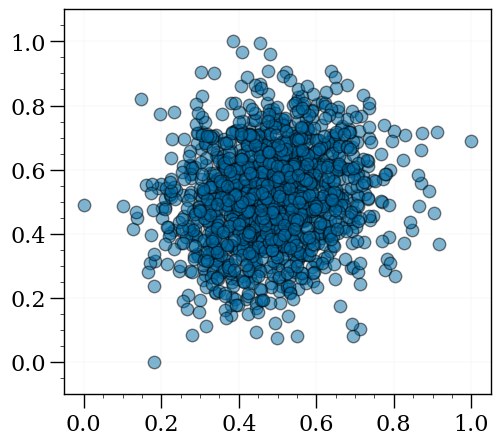

In [57]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [58]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [59]:
run(TrainingTensors, train_D, test_D, key, 'frank_1')

  0%|          | 1/5000 [05:37<468:02:59, 337.06s/it]

Iter 0. Loss [[0.07632665 0.20047715 2.8324785 ]]


  0%|          | 12/5000 [10:53<6:49:15,  4.92s/it]

Iter 10. Loss [[0.07630599 0.19924383 2.7982926 ]]


  0%|          | 22/5000 [10:56<37:07,  2.23it/s]

Iter 20. Loss [[0.07629488 0.19783399 2.7660341 ]]


  1%|          | 31/5000 [10:58<28:16,  2.93it/s]

Iter 30. Loss [[0.07630558 0.19623666 2.7353294 ]]


  1%|          | 41/5000 [11:01<19:19,  4.28it/s]

Iter 40. Loss [[0.07634678 0.19458398 2.7055318 ]]


  1%|          | 52/5000 [11:05<23:06,  3.57it/s]

Iter 50. Loss [[0.07641845 0.1929429  2.6763117 ]]


  1%|          | 62/5000 [11:07<16:52,  4.88it/s]

Iter 60. Loss [[0.07651882 0.19132572 2.6475642 ]]


  1%|▏         | 71/5000 [11:08<16:47,  4.89it/s]

Iter 70. Loss [[0.07664879 0.18971567 2.619334  ]]


  2%|▏         | 81/5000 [11:12<32:06,  2.55it/s]

Iter 80. Loss [[0.0768114  0.18809597 2.5916724 ]]


  2%|▏         | 92/5000 [11:15<19:20,  4.23it/s]

Iter 90. Loss [[0.07700896 0.1864632  2.564569  ]]


  2%|▏         | 101/5000 [11:17<16:42,  4.89it/s]

Iter 100. Loss [[0.07724225 0.18482222 2.5379775 ]]


  2%|▏         | 112/5000 [11:20<19:46,  4.12it/s]

Iter 110. Loss [[0.0775115  0.18317713 2.511862  ]]


  2%|▏         | 121/5000 [11:22<16:29,  4.93it/s]

Iter 120. Loss [[0.07781763 0.18152876 2.486208  ]]


  3%|▎         | 132/5000 [11:24<16:24,  4.94it/s]

Iter 130. Loss [[0.07816187 0.1798767  2.461011  ]]


  3%|▎         | 141/5000 [11:29<31:13,  2.59it/s]

Iter 140. Loss [[0.07854535 0.17822132 2.4362662 ]]


  3%|▎         | 151/5000 [11:31<17:00,  4.75it/s]

Iter 150. Loss [[0.07896877 0.17656381 2.4119675 ]]


  3%|▎         | 161/5000 [11:33<16:32,  4.88it/s]

Iter 160. Loss [[0.07943264 0.1749058  2.3881094 ]]


  3%|▎         | 171/5000 [11:36<21:19,  3.77it/s]

Iter 170. Loss [[0.07993739 0.17324853 2.36469   ]]


  4%|▎         | 181/5000 [11:38<16:16,  4.94it/s]

Iter 180. Loss [[0.08048347 0.17159328 2.3417091 ]]


  4%|▍         | 191/5000 [11:41<25:23,  3.16it/s]

Iter 190. Loss [[0.08107113 0.16994137 2.3191671 ]]


  4%|▍         | 202/5000 [11:45<20:50,  3.84it/s]

Iter 200. Loss [[0.08170044 0.16829412 2.2970643 ]]


  4%|▍         | 211/5000 [11:47<22:55,  3.48it/s]

Iter 210. Loss [[0.08237135 0.16665304 2.2754023 ]]


  4%|▍         | 222/5000 [11:49<16:17,  4.89it/s]

Iter 220. Loss [[0.08308368 0.16501945 2.2541819 ]]


  5%|▍         | 232/5000 [11:52<18:21,  4.33it/s]

Iter 230. Loss [[0.08383714 0.16339473 2.2334046 ]]


  5%|▍         | 241/5000 [11:55<25:23,  3.12it/s]

Iter 240. Loss [[0.08463127 0.16178024 2.2130718 ]]


  5%|▌         | 251/5000 [11:58<20:00,  3.96it/s]

Iter 250. Loss [[0.08546551 0.16017722 2.1931841 ]]


  5%|▌         | 262/5000 [12:01<17:21,  4.55it/s]

Iter 260. Loss [[0.08633918 0.15858695 2.1737428 ]]


  5%|▌         | 272/5000 [12:03<16:11,  4.87it/s]

Iter 270. Loss [[0.08725148 0.15701064 2.154748  ]]


  6%|▌         | 281/5000 [12:05<16:35,  4.74it/s]

Iter 280. Loss [[0.08820145 0.15544944 2.1361992 ]]


  6%|▌         | 291/5000 [12:09<27:02,  2.90it/s]

Iter 290. Loss [[0.08918811 0.15390444 2.1180966 ]]


  6%|▌         | 301/5000 [12:12<20:47,  3.77it/s]

Iter 300. Loss [[0.09021033 0.15237668 2.1004395 ]]


  6%|▌         | 311/5000 [12:14<16:11,  4.83it/s]

Iter 310. Loss [[0.0912669  0.15086715 2.083226  ]]


  6%|▋         | 321/5000 [12:17<18:54,  4.12it/s]

Iter 320. Loss [[0.09235652 0.14937674 2.0664551 ]]


  7%|▋         | 331/5000 [12:19<15:53,  4.89it/s]

Iter 330. Loss [[0.09347778 0.14790629 2.0501244 ]]


  7%|▋         | 341/5000 [12:21<16:07,  4.82it/s]

Iter 340. Loss [[0.09462922 0.14645663 2.0342317 ]]


  7%|▋         | 351/5000 [12:26<29:27,  2.63it/s]

Iter 350. Loss [[0.09580931 0.1450285  2.0187743 ]]


  7%|▋         | 361/5000 [12:28<16:12,  4.77it/s]

Iter 360. Loss [[0.0970164  0.14362259 2.0037494 ]]


  7%|▋         | 372/5000 [12:30<15:33,  4.96it/s]

Iter 370. Loss [[0.09824885 0.14223956 1.9891533 ]]


  8%|▊         | 381/5000 [12:33<18:43,  4.11it/s]

Iter 380. Loss [[0.09950494 0.1408799  1.9749829 ]]


  8%|▊         | 391/5000 [12:35<16:03,  4.78it/s]

Iter 390. Loss [[0.10078279 0.13954423 1.9612346 ]]


  8%|▊         | 401/5000 [12:38<24:44,  3.10it/s]

Iter 400. Loss [[0.1020806  0.13823302 1.9479042 ]]


  8%|▊         | 412/5000 [12:41<17:50,  4.29it/s]

Iter 410. Loss [[0.10339646 0.1369467  1.9349878 ]]


  8%|▊         | 422/5000 [12:43<15:27,  4.93it/s]

Iter 420. Loss [[0.10472833 0.13568571 1.9224818 ]]


  9%|▊         | 432/5000 [12:46<15:27,  4.92it/s]

Iter 430. Loss [[0.10607427 0.13445044 1.9103817 ]]


  9%|▉         | 442/5000 [12:49<17:48,  4.27it/s]

Iter 440. Loss [[0.10743218 0.13324119 1.8986834 ]]


  9%|▉         | 451/5000 [12:51<22:32,  3.36it/s]

Iter 450. Loss [[0.10879993 0.13205834 1.8873827 ]]


  9%|▉         | 461/5000 [12:54<23:35,  3.21it/s]

Iter 460. Loss [[0.11017534 0.13090216 1.8764756 ]]


  9%|▉         | 471/5000 [12:57<18:30,  4.08it/s]

Iter 470. Loss [[0.1115562  0.12977295 1.8659576 ]]


 10%|▉         | 481/5000 [12:59<15:31,  4.85it/s]

Iter 480. Loss [[0.11294021 0.12867093 1.8558245 ]]


 10%|▉         | 492/5000 [13:02<15:05,  4.98it/s]

Iter 490. Loss [[0.11432507 0.12759641 1.846072  ]]


 10%|█         | 501/5000 [13:05<24:21,  3.08it/s]

Iter 500. Loss [[0.11570834 0.12654962 1.8366961 ]]


 10%|█         | 511/5000 [13:08<25:02,  2.99it/s]

Iter 510. Loss [[0.1170876  0.12553076 1.8276922 ]]


 10%|█         | 522/5000 [13:11<15:19,  4.87it/s]

Iter 520. Loss [[0.11846032 0.1245401  1.8190563 ]]


 11%|█         | 532/5000 [13:14<16:58,  4.39it/s]

Iter 530. Loss [[0.119824   0.12357788 1.8107839 ]]


 11%|█         | 542/5000 [13:16<14:58,  4.96it/s]

Iter 540. Loss [[0.121176   0.12264431 1.8028702 ]]


 11%|█         | 552/5000 [13:18<14:43,  5.03it/s]

Iter 550. Loss [[0.1225136  0.12173963 1.7953107 ]]


 11%|█         | 561/5000 [13:22<27:00,  2.74it/s]

Iter 560. Loss [[0.12383416 0.1208641  1.7881008 ]]


 11%|█▏        | 572/5000 [13:24<15:37,  4.72it/s]

Iter 570. Loss [[0.12513478 0.12001798 1.7812352 ]]


 12%|█▏        | 582/5000 [13:26<15:00,  4.91it/s]

Iter 580. Loss [[0.12641278 0.11920152 1.7747083 ]]


 12%|█▏        | 592/5000 [13:29<16:54,  4.35it/s]

Iter 590. Loss [[0.12766516 0.118415   1.7685143 ]]


 12%|█▏        | 602/5000 [13:31<14:44,  4.97it/s]

Iter 600. Loss [[0.1288891  0.11765868 1.7626468 ]]


 12%|█▏        | 611/5000 [13:33<20:10,  3.62it/s]

Iter 610. Loss [[0.13008176 0.11693282 1.7570984 ]]


 12%|█▏        | 621/5000 [13:38<19:59,  3.65it/s]

Iter 620. Loss [[0.13124022 0.1162377  1.7518622 ]]


 13%|█▎        | 631/5000 [13:40<15:48,  4.61it/s]

Iter 630. Loss [[0.13236171 0.11557357 1.7469288 ]]


 13%|█▎        | 641/5000 [13:42<15:30,  4.68it/s]

Iter 640. Loss [[0.13344346 0.11494064 1.7422892 ]]


 13%|█▎        | 652/5000 [13:45<16:31,  4.38it/s]

Iter 650. Loss [[0.13448302 0.11433909 1.737933  ]]


 13%|█▎        | 661/5000 [13:47<19:28,  3.71it/s]

Iter 660. Loss [[0.135478   0.11376902 1.7338486 ]]


 13%|█▎        | 671/5000 [13:51<24:43,  2.92it/s]

Iter 670. Loss [[0.1364265  0.11323043 1.7300231 ]]


 14%|█▎        | 681/5000 [13:54<17:04,  4.22it/s]

Iter 680. Loss [[0.13732675 0.1127232  1.7264433 ]]


 14%|█▍        | 691/5000 [13:56<15:11,  4.73it/s]

Iter 690. Loss [[0.13817787 0.11224703 1.7230943 ]]


 14%|█▍        | 701/5000 [13:58<15:35,  4.59it/s]

Iter 700. Loss [[0.13897927 0.11180143 1.7199608 ]]


 14%|█▍        | 711/5000 [14:02<18:44,  3.82it/s]

Iter 710. Loss [[0.1397313  0.11138562 1.717027  ]]


 14%|█▍        | 721/5000 [14:05<24:23,  2.92it/s]

Iter 720. Loss [[0.14043504 0.11099862 1.7142771 ]]


 15%|█▍        | 731/5000 [14:08<15:44,  4.52it/s]

Iter 730. Loss [[0.14109229 0.11063908 1.7116959 ]]


 15%|█▍        | 741/5000 [14:11<16:36,  4.27it/s]

Iter 740. Loss [[0.14170587 0.11030543 1.7092686 ]]


 15%|█▌        | 751/5000 [14:13<15:15,  4.64it/s]

Iter 750. Loss [[0.14227907 0.1099958  1.7069818 ]]


 15%|█▌        | 761/5000 [14:15<15:00,  4.71it/s]

Iter 760. Loss [[0.14281558 0.10970827 1.7048235 ]]


 15%|█▌        | 771/5000 [14:19<26:11,  2.69it/s]

Iter 770. Loss [[0.1433194  0.10944071 1.7027837 ]]


 16%|█▌        | 781/5000 [14:22<15:35,  4.51it/s]

Iter 780. Loss [[0.14379434 0.10919114 1.7008535 ]]


 16%|█▌        | 792/5000 [14:24<14:02,  5.00it/s]

Iter 790. Loss [[0.14424396 0.10895762 1.6990247 ]]


 16%|█▌        | 801/5000 [14:27<16:12,  4.32it/s]

Iter 800. Loss [[0.14467134 0.1087384  1.6972915 ]]


 16%|█▌        | 812/5000 [14:29<14:14,  4.90it/s]

Iter 810. Loss [[0.14507905 0.10853197 1.695648  ]]


 16%|█▋        | 821/5000 [14:32<20:19,  3.43it/s]

Iter 820. Loss [[0.14546904 0.10833705 1.6940886 ]]


 17%|█▋        | 831/5000 [14:36<18:27,  3.77it/s]

Iter 830. Loss [[0.14584278 0.10815262 1.6926087 ]]


 17%|█▋        | 841/5000 [14:38<14:06,  4.91it/s]

Iter 840. Loss [[0.14620142 0.10797774 1.6912037 ]]


 17%|█▋        | 852/5000 [14:40<13:47,  5.01it/s]

Iter 850. Loss [[0.14654568 0.10781175 1.6898694 ]]


 17%|█▋        | 861/5000 [14:43<16:38,  4.15it/s]

Iter 860. Loss [[0.14687623 0.10765405 1.6886022 ]]


 17%|█▋        | 871/5000 [14:45<14:23,  4.78it/s]

Iter 870. Loss [[0.14719337 0.10750415 1.6873981 ]]


 18%|█▊        | 881/5000 [14:48<22:57,  2.99it/s]

Iter 880. Loss [[0.14749753 0.1073616  1.6862535 ]]


 18%|█▊        | 892/5000 [14:52<16:27,  4.16it/s]

Iter 890. Loss [[0.14778896 0.10722607 1.6851659 ]]


 18%|█▊        | 902/5000 [14:54<13:56,  4.90it/s]

Iter 900. Loss [[0.148068   0.10709718 1.6841319 ]]


 18%|█▊        | 912/5000 [14:56<13:31,  5.04it/s]

Iter 910. Loss [[0.14833492 0.10697465 1.6831487 ]]


 18%|█▊        | 921/5000 [14:59<16:48,  4.04it/s]

Iter 920. Loss [[0.14859003 0.10685816 1.682214  ]]


 19%|█▊        | 931/5000 [15:02<22:27,  3.02it/s]

Iter 930. Loss [[0.14883353 0.10674746 1.6813256 ]]


 19%|█▉        | 941/5000 [15:05<15:22,  4.40it/s]

Iter 940. Loss [[0.14906603 0.10664231 1.6804806 ]]


 19%|█▉        | 952/5000 [15:08<15:37,  4.32it/s]

Iter 950. Loss [[0.1492876  0.10654243 1.6796774 ]]


 19%|█▉        | 961/5000 [15:10<14:08,  4.76it/s]

Iter 960. Loss [[0.14949869 0.10644759 1.6789137 ]]


 19%|█▉        | 972/5000 [15:12<13:37,  4.93it/s]

Iter 970. Loss [[0.14969969 0.10635758 1.6781878 ]]


 20%|█▉        | 981/5000 [15:16<23:27,  2.85it/s]

Iter 980. Loss [[0.14989087 0.10627218 1.677498  ]]


 20%|█▉        | 992/5000 [15:19<15:04,  4.43it/s]

Iter 990. Loss [[0.15007271 0.10619116 1.6768425 ]]


 20%|██        | 1002/5000 [15:21<13:30,  4.93it/s]

Iter 1000. Loss [[0.15024544 0.10611434 1.6762197 ]]


 20%|██        | 1011/5000 [15:24<16:05,  4.13it/s]

Iter 1010. Loss [[0.15040953 0.10604151 1.675628  ]]


 20%|██        | 1021/5000 [15:26<13:29,  4.92it/s]

Iter 1020. Loss [[0.15056527 0.10597251 1.6750661 ]]


 21%|██        | 1031/5000 [15:28<13:35,  4.86it/s]

Iter 1030. Loss [[0.15071307 0.10590713 1.6745324 ]]


 21%|██        | 1041/5000 [15:32<21:23,  3.08it/s]

Iter 1040. Loss [[0.15085319 0.10584521 1.6740257 ]]


 21%|██        | 1051/5000 [15:34<13:59,  4.71it/s]

Iter 1050. Loss [[0.1509861  0.10578659 1.6735451 ]]


 21%|██        | 1061/5000 [15:36<13:19,  4.93it/s]

Iter 1060. Loss [[0.15111195 0.1057311  1.6730889 ]]


 21%|██▏       | 1072/5000 [15:40<14:42,  4.45it/s]

Iter 1070. Loss [[0.15123126 0.10567859 1.6726559 ]]


 22%|██▏       | 1082/5000 [15:42<13:25,  4.86it/s]

Iter 1080. Loss [[0.15134417 0.10562892 1.6722454 ]]


 22%|██▏       | 1091/5000 [15:45<21:17,  3.06it/s]

Iter 1090. Loss [[0.1514511  0.10558193 1.671856  ]]


 22%|██▏       | 1102/5000 [15:49<16:07,  4.03it/s]

Iter 1100. Loss [[0.15155235 0.1055375  1.6714873 ]]


 22%|██▏       | 1112/5000 [15:51<13:15,  4.89it/s]

Iter 1110. Loss [[0.15164804 0.10549552 1.6711378 ]]


 22%|██▏       | 1121/5000 [15:53<12:57,  4.99it/s]

Iter 1120. Loss [[0.15173851 0.10545584 1.6708068 ]]


 23%|██▎       | 1132/5000 [15:56<13:43,  4.70it/s]

Iter 1130. Loss [[0.15182418 0.10541835 1.6704931 ]]


 23%|██▎       | 1141/5000 [15:59<20:59,  3.06it/s]

Iter 1140. Loss [[0.15190504 0.10538293 1.6701963 ]]


 23%|██▎       | 1152/5000 [16:02<14:11,  4.52it/s]

Iter 1150. Loss [[0.15198144 0.1053495  1.6699156 ]]


 23%|██▎       | 1162/5000 [16:05<13:53,  4.60it/s]

Iter 1160. Loss [[0.1520537  0.10531793 1.6696498 ]]


 23%|██▎       | 1172/5000 [16:07<13:01,  4.90it/s]

Iter 1170. Loss [[0.15212183 0.10528815 1.6693984 ]]


 24%|██▎       | 1181/5000 [16:09<12:58,  4.90it/s]

Iter 1180. Loss [[0.15218623 0.10526004 1.6691608 ]]


 24%|██▍       | 1191/5000 [16:13<21:04,  3.01it/s]

Iter 1190. Loss [[0.152247   0.10523353 1.6689364 ]]


 24%|██▍       | 1201/5000 [16:16<16:19,  3.88it/s]

Iter 1200. Loss [[0.15230434 0.10520852 1.6687243 ]]


 24%|██▍       | 1211/5000 [16:18<12:58,  4.87it/s]

Iter 1210. Loss [[0.1523584  0.10518496 1.668524  ]]


 24%|██▍       | 1221/5000 [16:21<13:47,  4.57it/s]

Iter 1220. Loss [[0.15240946 0.10516274 1.6683351 ]]


 25%|██▍       | 1231/5000 [16:23<12:51,  4.89it/s]

Iter 1230. Loss [[0.1524575  0.10514183 1.6681567 ]]


 25%|██▍       | 1241/5000 [16:25<12:43,  4.93it/s]

Iter 1240. Loss [[0.15250283 0.10512211 1.6679884 ]]


 25%|██▌       | 1252/5000 [16:29<18:24,  3.39it/s]

Iter 1250. Loss [[0.15254559 0.10510354 1.6678301 ]]


 25%|██▌       | 1262/5000 [16:31<12:56,  4.82it/s]

Iter 1260. Loss [[0.1525858  0.10508607 1.6676803 ]]


 25%|██▌       | 1271/5000 [16:33<12:46,  4.86it/s]

Iter 1270. Loss [[0.15262371 0.10506962 1.6675395 ]]


 26%|██▌       | 1282/5000 [16:37<13:16,  4.67it/s]

Iter 1280. Loss [[0.15265942 0.10505415 1.6674069 ]]


 26%|██▌       | 1291/5000 [16:38<12:40,  4.88it/s]

Iter 1290. Loss [[0.15269297 0.1050396  1.6672819 ]]


 26%|██▌       | 1301/5000 [16:43<44:32,  1.38it/s]

Iter 1300. Loss [[0.15272461 0.10502593 1.6671647 ]]


 26%|██▌       | 1312/5000 [16:45<13:12,  4.65it/s]

Iter 1310. Loss [[0.15275434 0.10501306 1.667054  ]]


 26%|██▋       | 1321/5000 [16:47<12:32,  4.89it/s]

Iter 1320. Loss [[0.1527823 0.105001  1.6669503]]


 27%|██▋       | 1331/5000 [16:49<12:32,  4.88it/s]

Iter 1330. Loss [[0.15280864 0.10498964 1.6668528 ]]


 27%|██▋       | 1342/5000 [16:52<13:00,  4.68it/s]

Iter 1340. Loss [[0.15283334 0.10497899 1.666761  ]]


 27%|██▋       | 1351/5000 [16:55<17:57,  3.39it/s]

Iter 1350. Loss [[0.15285656 0.10496899 1.6666751 ]]


 27%|██▋       | 1361/5000 [16:59<39:28,  1.54it/s]

Iter 1360. Loss [[0.1528784  0.10495961 1.6665943 ]]


 27%|██▋       | 1371/5000 [17:01<13:02,  4.64it/s]

Iter 1370. Loss [[0.1528989  0.10495082 1.6665186 ]]


 28%|██▊       | 1381/5000 [17:03<12:31,  4.82it/s]

Iter 1380. Loss [[0.15291817 0.10494257 1.6664474 ]]


 28%|██▊       | 1391/5000 [17:06<26:42,  2.25it/s]

Iter 1390. Loss [[0.1529362  0.10493483 1.6663809 ]]


 28%|██▊       | 1401/5000 [17:08<16:52,  3.55it/s]

Iter 1400. Loss [[0.15295318 0.10492757 1.6663187 ]]


 28%|██▊       | 1411/5000 [17:12<19:48,  3.02it/s]

Iter 1410. Loss [[0.15296906 0.10492077 1.6662601 ]]


 28%|██▊       | 1422/5000 [17:15<22:16,  2.68it/s]

Iter 1420. Loss [[0.15298407 0.1049144  1.6662054 ]]


 29%|██▊       | 1432/5000 [17:17<12:24,  4.79it/s]

Iter 1430. Loss [[0.15299797 0.10490847 1.6661543 ]]


 29%|██▉       | 1441/5000 [17:19<12:17,  4.83it/s]

Iter 1440. Loss [[0.15301113 0.10490289 1.6661065 ]]


 29%|██▉       | 1451/5000 [17:22<33:47,  1.75it/s]

Iter 1450. Loss [[0.15302339 0.1048977  1.6660619 ]]


 29%|██▉       | 1461/5000 [17:26<19:52,  2.97it/s]

Iter 1460. Loss [[0.15303493 0.10489282 1.6660202 ]]


 29%|██▉       | 1471/5000 [17:28<12:46,  4.61it/s]

Iter 1470. Loss [[0.15304574 0.10488828 1.6659813 ]]


 30%|██▉       | 1482/5000 [17:31<25:35,  2.29it/s]

Iter 1480. Loss [[0.1530558  0.10488401 1.6659449 ]]


 30%|██▉       | 1492/5000 [17:33<12:14,  4.77it/s]

Iter 1490. Loss [[0.1530653  0.10488004 1.665911  ]]


 30%|███       | 1502/5000 [17:35<11:46,  4.95it/s]

Iter 1500. Loss [[0.15307406 0.10487635 1.6658794 ]]


 30%|███       | 1511/5000 [17:38<16:50,  3.45it/s]

Iter 1510. Loss [[0.15308234 0.10487288 1.6658499 ]]


 30%|███       | 1521/5000 [17:42<14:20,  4.04it/s]

Iter 1520. Loss [[0.15309009 0.10486966 1.6658226 ]]


 31%|███       | 1531/5000 [17:44<11:51,  4.88it/s]

Iter 1530. Loss [[0.15309736 0.10486665 1.6657972 ]]


 31%|███       | 1541/5000 [17:46<11:54,  4.84it/s]

Iter 1540. Loss [[0.15310408 0.10486385 1.6657734 ]]


 31%|███       | 1551/5000 [17:49<12:41,  4.53it/s]

Iter 1550. Loss [[0.1531104  0.10486124 1.6657513 ]]


 31%|███       | 1561/5000 [17:51<14:15,  4.02it/s]

Iter 1560. Loss [[0.15311636 0.1048588  1.6657308 ]]


 31%|███▏      | 1571/5000 [17:54<18:59,  3.01it/s]

Iter 1570. Loss [[0.15312184 0.10485654 1.6657119 ]]


 32%|███▏      | 1581/5000 [17:58<12:48,  4.45it/s]

Iter 1580. Loss [[0.153127   0.10485443 1.665694  ]]


 32%|███▏      | 1591/5000 [18:00<11:36,  4.89it/s]

Iter 1590. Loss [[0.15313181 0.10485247 1.6656775 ]]


 32%|███▏      | 1602/5000 [18:03<24:53,  2.28it/s]

Iter 1600. Loss [[0.15313622 0.10485064 1.6656625 ]]


 32%|███▏      | 1611/5000 [18:05<12:24,  4.55it/s]

Iter 1610. Loss [[0.15314046 0.10484894 1.6656485 ]]


 32%|███▏      | 1621/5000 [18:08<18:37,  3.02it/s]

Iter 1620. Loss [[0.15314436 0.10484737 1.6656353 ]]


 33%|███▎      | 1632/5000 [18:12<25:19,  2.22it/s]

Iter 1630. Loss [[0.15314808 0.1048459  1.6656233 ]]


 33%|███▎      | 1641/5000 [18:14<11:57,  4.68it/s]

Iter 1640. Loss [[0.15315148 0.10484454 1.6656121 ]]


 33%|███▎      | 1651/5000 [18:16<11:26,  4.88it/s]

Iter 1650. Loss [[0.15315461 0.10484328 1.6656018 ]]


 33%|███▎      | 1662/5000 [18:19<24:36,  2.26it/s]

Iter 1660. Loss [[0.15315755 0.10484211 1.6655921 ]]


 33%|███▎      | 1671/5000 [18:22<18:58,  2.92it/s]

Iter 1670. Loss [[0.1531603  0.10484103 1.6655835 ]]


 34%|███▎      | 1681/5000 [18:25<12:43,  4.35it/s]

Iter 1680. Loss [[0.1531629 0.10484   1.6655754]]


 34%|███▍      | 1691/5000 [18:28<24:10,  2.28it/s]

Iter 1690. Loss [[0.15316525 0.10483909 1.6655676 ]]


 34%|███▍      | 1702/5000 [18:30<11:20,  4.85it/s]

Iter 1700. Loss [[0.15316747 0.10483822 1.6655608 ]]


 34%|███▍      | 1711/5000 [18:32<11:15,  4.87it/s]

Iter 1710. Loss [[0.15316957 0.10483743 1.6655546 ]]


 34%|███▍      | 1721/5000 [18:36<26:15,  2.08it/s]

Iter 1720. Loss [[0.15317145 0.10483669 1.6655487 ]]


 35%|███▍      | 1732/5000 [18:39<12:54,  4.22it/s]

Iter 1730. Loss [[0.15317328 0.10483599 1.6655433 ]]


 35%|███▍      | 1741/5000 [18:41<11:05,  4.90it/s]

Iter 1740. Loss [[0.153175   0.10483535 1.6655384 ]]


 35%|███▌      | 1752/5000 [18:44<17:02,  3.18it/s]

Iter 1750. Loss [[0.15317659 0.10483477 1.6655337 ]]


 35%|███▌      | 1762/5000 [18:46<10:59,  4.91it/s]

Iter 1760. Loss [[0.15317796 0.10483423 1.6655293 ]]


 35%|███▌      | 1772/5000 [18:48<10:52,  4.94it/s]

Iter 1770. Loss [[0.1531793  0.10483373 1.6655257 ]]


 36%|███▌      | 1781/5000 [18:52<27:08,  1.98it/s]

Iter 1780. Loss [[0.15318055 0.10483327 1.6655221 ]]


 36%|███▌      | 1791/5000 [18:54<11:18,  4.73it/s]

Iter 1790. Loss [[0.1531817  0.10483284 1.6655189 ]]


 36%|███▌      | 1801/5000 [18:56<10:45,  4.96it/s]

Iter 1800. Loss [[0.15318282 0.10483244 1.6655159 ]]


 36%|███▌      | 1811/5000 [19:00<23:28,  2.26it/s]

Iter 1810. Loss [[0.15318383 0.10483207 1.6655133 ]]


 36%|███▋      | 1822/5000 [19:02<10:55,  4.85it/s]

Iter 1820. Loss [[0.15318479 0.10483173 1.6655109 ]]


 37%|███▋      | 1831/5000 [19:04<17:08,  3.08it/s]

Iter 1830. Loss [[0.15318567 0.10483142 1.6655084 ]]


 37%|███▋      | 1841/5000 [19:09<21:54,  2.40it/s]

Iter 1840. Loss [[0.15318643 0.10483114 1.6655064 ]]


 37%|███▋      | 1852/5000 [19:11<10:54,  4.81it/s]

Iter 1850. Loss [[0.15318723 0.10483087 1.6655046 ]]


 37%|███▋      | 1862/5000 [19:13<10:29,  4.98it/s]

Iter 1860. Loss [[0.15318792 0.10483065 1.6655028 ]]


 37%|███▋      | 1872/5000 [19:16<14:36,  3.57it/s]

Iter 1870. Loss [[0.15318859 0.1048304  1.6655012 ]]


 38%|███▊      | 1881/5000 [19:18<16:34,  3.14it/s]

Iter 1880. Loss [[0.15318918 0.10483021 1.6654998 ]]


 38%|███▊      | 1892/5000 [19:22<13:07,  3.95it/s]

Iter 1890. Loss [[0.15318975 0.10483002 1.6654987 ]]


 38%|███▊      | 1902/5000 [19:25<13:28,  3.83it/s]

Iter 1900. Loss [[0.15319026 0.10482983 1.6654974 ]]


 38%|███▊      | 1912/5000 [19:27<10:29,  4.91it/s]

Iter 1910. Loss [[0.15319075 0.10482968 1.6654963 ]]


 38%|███▊      | 1921/5000 [19:29<10:35,  4.85it/s]

Iter 1920. Loss [[0.15319125 0.10482953 1.6654954 ]]


 39%|███▊      | 1931/5000 [19:32<19:37,  2.61it/s]

Iter 1930. Loss [[0.1531917  0.10482938 1.6654946 ]]


 39%|███▉      | 1941/5000 [19:36<16:22,  3.11it/s]

Iter 1940. Loss [[0.15319209 0.10482925 1.6654938 ]]


 39%|███▉      | 1951/5000 [19:38<10:23,  4.89it/s]

Iter 1950. Loss [[0.15319248 0.10482914 1.665493  ]]


 39%|███▉      | 1961/5000 [19:41<16:05,  3.15it/s]

Iter 1960. Loss [[0.15319274 0.10482904 1.6654923 ]]


 39%|███▉      | 1971/5000 [19:43<10:30,  4.80it/s]

Iter 1970. Loss [[0.15319306 0.10482894 1.6654918 ]]


 40%|███▉      | 1981/5000 [19:45<10:18,  4.88it/s]

Iter 1980. Loss [[0.15319338 0.10482886 1.6654912 ]]


 40%|███▉      | 1991/5000 [19:49<28:24,  1.76it/s]

Iter 1990. Loss [[0.1531936  0.10482877 1.6654909 ]]


 40%|████      | 2001/5000 [19:52<10:59,  4.55it/s]

Iter 2000. Loss [[0.15319394 0.10482869 1.6654904 ]]


 40%|████      | 2012/5000 [19:54<10:10,  4.90it/s]

Iter 2010. Loss [[0.15319414 0.10482863 1.6654899 ]]


 40%|████      | 2021/5000 [19:57<15:53,  3.13it/s]

Iter 2020. Loss [[0.15319441 0.10482855 1.6654896 ]]


 41%|████      | 2032/5000 [19:59<10:19,  4.79it/s]

Iter 2030. Loss [[0.15319464 0.10482849 1.6654892 ]]


 41%|████      | 2041/5000 [20:02<15:29,  3.18it/s]

Iter 2040. Loss [[0.1531948  0.10482844 1.6654891 ]]


 41%|████      | 2051/5000 [20:06<18:13,  2.70it/s]

Iter 2050. Loss [[0.15319498 0.10482839 1.6654887 ]]


 41%|████      | 2061/5000 [20:08<10:19,  4.75it/s]

Iter 2060. Loss [[0.15319508 0.10482836 1.6654885 ]]


 41%|████▏     | 2071/5000 [20:10<09:52,  4.94it/s]

Iter 2070. Loss [[0.15319525 0.10482831 1.6654882 ]]


 42%|████▏     | 2081/5000 [20:13<15:34,  3.12it/s]

Iter 2080. Loss [[0.15319534 0.10482828 1.6654882 ]]


 42%|████▏     | 2091/5000 [20:15<14:16,  3.40it/s]

Iter 2090. Loss [[0.1531955  0.10482825 1.6654879 ]]


 42%|████▏     | 2101/5000 [20:19<15:57,  3.03it/s]

Iter 2100. Loss [[0.15319563 0.10482821 1.6654879 ]]


 42%|████▏     | 2111/5000 [20:22<15:50,  3.04it/s]

Iter 2110. Loss [[0.15319575 0.10482817 1.6654876 ]]


 42%|████▏     | 2121/5000 [20:24<09:57,  4.82it/s]

Iter 2120. Loss [[0.15319587 0.10482814 1.6654876 ]]


 43%|████▎     | 2132/5000 [20:26<09:35,  4.99it/s]

Iter 2130. Loss [[0.15319598 0.10482813 1.6654876 ]]


 43%|████▎     | 2141/5000 [20:29<17:37,  2.70it/s]

Iter 2140. Loss [[0.15319605 0.1048281  1.6654874 ]]


 43%|████▎     | 2151/5000 [20:32<15:50,  3.00it/s]

Iter 2150. Loss [[0.15319616 0.10482808 1.6654873 ]]


 43%|████▎     | 2161/5000 [20:35<10:13,  4.63it/s]

Iter 2160. Loss [[0.15319628 0.10482804 1.6654873 ]]


 43%|████▎     | 2172/5000 [20:38<12:09,  3.88it/s]

Iter 2170. Loss [[0.15319635 0.10482803 1.6654873 ]]


 44%|████▎     | 2181/5000 [20:40<09:39,  4.87it/s]

Iter 2180. Loss [[0.15319644 0.104828   1.6654873 ]]


 44%|████▍     | 2192/5000 [20:42<09:29,  4.93it/s]

Iter 2190. Loss [[0.15319653 0.10482799 1.6654873 ]]


 44%|████▍     | 2201/5000 [20:46<18:57,  2.46it/s]

Iter 2200. Loss [[0.15319659 0.10482799 1.6654873 ]]


 44%|████▍     | 2212/5000 [20:49<09:59,  4.65it/s]

Iter 2210. Loss [[0.15319666 0.10482796 1.6654873 ]]


 44%|████▍     | 2222/5000 [20:51<09:22,  4.94it/s]

Iter 2220. Loss [[0.1531967  0.10482794 1.6654872 ]]


 45%|████▍     | 2231/5000 [20:54<14:54,  3.10it/s]

Iter 2230. Loss [[0.15319677 0.10482794 1.6654872 ]]


 45%|████▍     | 2241/5000 [20:56<09:35,  4.80it/s]

Iter 2240. Loss [[0.15319681 0.10482794 1.6654872 ]]


 45%|████▌     | 2251/5000 [20:58<12:45,  3.59it/s]

Iter 2250. Loss [[0.15319686 0.10482793 1.6654872 ]]


 45%|████▌     | 2261/5000 [21:02<15:03,  3.03it/s]

Iter 2260. Loss [[0.15319687 0.10482792 1.6654872 ]]


 45%|████▌     | 2271/5000 [21:04<09:27,  4.81it/s]

Iter 2270. Loss [[0.15319695 0.1048279  1.6654872 ]]


 46%|████▌     | 2281/5000 [21:06<09:18,  4.86it/s]

Iter 2280. Loss [[0.15319695 0.1048279  1.6654872 ]]


 46%|████▌     | 2291/5000 [21:09<11:57,  3.77it/s]

Iter 2290. Loss [[0.15319702 0.1048279  1.6654869 ]]


 46%|████▌     | 2301/5000 [21:12<10:16,  4.38it/s]

Iter 2300. Loss [[0.15319702 0.1048279  1.6654872 ]]


 46%|████▌     | 2311/5000 [21:15<14:40,  3.05it/s]

Iter 2310. Loss [[0.15319704 0.10482788 1.6654869 ]]


 46%|████▋     | 2322/5000 [21:19<11:08,  4.00it/s]

Iter 2320. Loss [[0.15319706 0.10482788 1.6654869 ]]


 47%|████▋     | 2332/5000 [21:21<09:04,  4.90it/s]

Iter 2330. Loss [[0.15319708 0.10482787 1.6654869 ]]


 47%|████▋     | 2342/5000 [21:23<08:58,  4.93it/s]

Iter 2340. Loss [[0.15319708 0.10482788 1.6654872 ]]


 47%|████▋     | 2351/5000 [21:26<10:56,  4.04it/s]

Iter 2350. Loss [[0.1531971  0.10482787 1.6654869 ]]


 47%|████▋     | 2361/5000 [21:29<14:49,  2.97it/s]

Iter 2360. Loss [[0.1531971  0.10482786 1.6654869 ]]


 47%|████▋     | 2371/5000 [21:31<09:48,  4.47it/s]

Iter 2370. Loss [[0.1531971  0.10482788 1.6654869 ]]


 48%|████▊     | 2382/5000 [21:35<09:49,  4.44it/s]

Iter 2380. Loss [[0.15319715 0.10482786 1.6654869 ]]


 48%|████▊     | 2391/5000 [21:37<09:06,  4.78it/s]

Iter 2390. Loss [[0.15319715 0.10482786 1.6654869 ]]


 48%|████▊     | 2401/5000 [21:39<09:03,  4.78it/s]

Iter 2400. Loss [[0.15319715 0.10482786 1.6654869 ]]


 48%|████▊     | 2411/5000 [21:43<15:07,  2.85it/s]

Iter 2410. Loss [[0.15319721 0.10482785 1.6654872 ]]


 48%|████▊     | 2421/5000 [21:46<09:40,  4.44it/s]

Iter 2420. Loss [[0.15319726 0.10482785 1.6654869 ]]


 49%|████▊     | 2431/5000 [21:48<08:55,  4.80it/s]

Iter 2430. Loss [[0.15319721 0.10482785 1.6654869 ]]


 49%|████▉     | 2442/5000 [21:51<09:19,  4.57it/s]

Iter 2440. Loss [[0.15319726 0.10482784 1.6654869 ]]


 49%|████▉     | 2452/5000 [21:53<08:36,  4.94it/s]

Iter 2450. Loss [[0.15319717 0.10482786 1.6654869 ]]


 49%|████▉     | 2461/5000 [21:55<11:38,  3.64it/s]

Iter 2460. Loss [[0.15319726 0.10482785 1.6654872 ]]


 49%|████▉     | 2472/5000 [22:00<10:13,  4.12it/s]

Iter 2470. Loss [[0.15319726 0.10482784 1.6654869 ]]


 50%|████▉     | 2482/5000 [22:02<08:29,  4.94it/s]

Iter 2480. Loss [[0.15319726 0.10482785 1.6654869 ]]


 50%|████▉     | 2492/5000 [22:04<08:31,  4.91it/s]

Iter 2490. Loss [[0.15319726 0.10482785 1.6654869 ]]


 50%|█████     | 2501/5000 [22:07<09:53,  4.21it/s]

Iter 2500. Loss [[0.15319733 0.10482784 1.6654872 ]]


 50%|█████     | 2511/5000 [22:09<08:34,  4.84it/s]

Iter 2510. Loss [[0.1531973  0.10482785 1.6654869 ]]


 50%|█████     | 2521/5000 [22:12<13:35,  3.04it/s]

Iter 2520. Loss [[0.1531973  0.10482784 1.6654872 ]]


 51%|█████     | 2531/5000 [22:15<09:54,  4.15it/s]

Iter 2530. Loss [[0.1531973  0.10482784 1.6654869 ]]


 51%|█████     | 2541/5000 [22:17<08:31,  4.80it/s]

Iter 2540. Loss [[0.1531973  0.10482784 1.6654872 ]]


 51%|█████     | 2551/5000 [22:20<08:24,  4.85it/s]

Iter 2550. Loss [[0.1531973  0.10482784 1.6654869 ]]


 51%|█████     | 2561/5000 [22:23<09:25,  4.31it/s]

Iter 2560. Loss [[0.15319736 0.10482784 1.6654869 ]]


 51%|█████▏    | 2571/5000 [22:26<13:20,  3.04it/s]

Iter 2570. Loss [[0.1531974  0.10482783 1.6654872 ]]


 52%|█████▏    | 2581/5000 [22:28<09:20,  4.32it/s]

Iter 2580. Loss [[0.15319742 0.10482782 1.6654872 ]]


 52%|█████▏    | 2591/5000 [22:32<09:17,  4.32it/s]

Iter 2590. Loss [[0.15319742 0.10482782 1.6654872 ]]


 52%|█████▏    | 2602/5000 [22:34<08:11,  4.88it/s]

Iter 2600. Loss [[0.15319742 0.10482782 1.6654872 ]]


 52%|█████▏    | 2612/5000 [22:36<08:05,  4.92it/s]

Iter 2610. Loss [[0.15319742 0.10482782 1.6654872 ]]


 52%|█████▏    | 2621/5000 [22:40<14:27,  2.74it/s]

Iter 2620. Loss [[0.15319742 0.10482781 1.6654873 ]]


 53%|█████▎    | 2631/5000 [22:43<09:45,  4.05it/s]

Iter 2630. Loss [[0.1531974  0.10482782 1.6654872 ]]


 53%|█████▎    | 2642/5000 [22:45<08:06,  4.85it/s]

Iter 2640. Loss [[0.1531974  0.10482783 1.6654872 ]]


 53%|█████▎    | 2652/5000 [22:48<09:00,  4.34it/s]

Iter 2650. Loss [[0.15319742 0.10482782 1.6654869 ]]


 53%|█████▎    | 2661/5000 [22:50<08:04,  4.83it/s]

Iter 2660. Loss [[0.15319742 0.10482782 1.6654872 ]]


 53%|█████▎    | 2671/5000 [22:52<08:05,  4.80it/s]

Iter 2670. Loss [[0.15319742 0.10482782 1.6654872 ]]


 54%|█████▎    | 2682/5000 [22:57<11:17,  3.42it/s]

Iter 2680. Loss [[0.15319742 0.10482782 1.6654872 ]]


 54%|█████▍    | 2691/5000 [22:58<08:14,  4.67it/s]

Iter 2690. Loss [[0.15319742 0.10482782 1.6654872 ]]


 54%|█████▍    | 2701/5000 [23:00<07:53,  4.86it/s]

Iter 2700. Loss [[0.15319736 0.10482783 1.6654872 ]]


 54%|█████▍    | 2712/5000 [23:04<09:12,  4.14it/s]

Iter 2710. Loss [[0.15319742 0.10482783 1.6654869 ]]


 54%|█████▍    | 2722/5000 [23:06<07:45,  4.89it/s]

Iter 2720. Loss [[0.1531974  0.10482784 1.6654872 ]]


 55%|█████▍    | 2731/5000 [23:09<12:44,  2.97it/s]

Iter 2730. Loss [[0.15319742 0.10482783 1.6654872 ]]


 55%|█████▍    | 2741/5000 [23:13<10:50,  3.47it/s]

Iter 2740. Loss [[0.15319742 0.10482783 1.6654872 ]]


 55%|█████▌    | 2752/5000 [23:15<07:46,  4.82it/s]

Iter 2750. Loss [[0.15319742 0.10482783 1.6654872 ]]


 55%|█████▌    | 2762/5000 [23:17<07:34,  4.92it/s]

Iter 2760. Loss [[0.1531974  0.10482784 1.6654872 ]]


 55%|█████▌    | 2772/5000 [23:20<09:04,  4.09it/s]

Iter 2770. Loss [[0.15319742 0.10482782 1.6654872 ]]


 56%|█████▌    | 2781/5000 [23:23<11:53,  3.11it/s]

Iter 2780. Loss [[0.15319742 0.10482782 1.6654873 ]]


 56%|█████▌    | 2792/5000 [23:26<08:33,  4.30it/s]

Iter 2790. Loss [[0.1531974  0.10482783 1.6654872 ]]


 56%|█████▌    | 2801/5000 [23:29<09:02,  4.05it/s]

Iter 2800. Loss [[0.1531974  0.10482783 1.6654873 ]]


 56%|█████▌    | 2812/5000 [23:31<07:15,  5.03it/s]

Iter 2810. Loss [[0.1531974  0.10482783 1.6654872 ]]


 56%|█████▋    | 2822/5000 [23:33<07:20,  4.94it/s]

Iter 2820. Loss [[0.15319742 0.10482783 1.6654872 ]]


 57%|█████▋    | 2831/5000 [23:37<12:06,  2.99it/s]

Iter 2830. Loss [[0.15319736 0.10482784 1.6654873 ]]


 57%|█████▋    | 2842/5000 [23:40<09:36,  3.74it/s]

Iter 2840. Loss [[0.15319736 0.10482784 1.6654872 ]]


 57%|█████▋    | 2851/5000 [23:42<07:26,  4.81it/s]

Iter 2850. Loss [[0.15319736 0.10482784 1.6654873 ]]


 57%|█████▋    | 2862/5000 [23:45<07:57,  4.48it/s]

Iter 2860. Loss [[0.1531974  0.10482784 1.6654872 ]]


 57%|█████▋    | 2872/5000 [23:47<07:16,  4.88it/s]

Iter 2870. Loss [[0.15319736 0.10482784 1.6654872 ]]


 58%|█████▊    | 2881/5000 [23:49<07:22,  4.79it/s]

Iter 2880. Loss [[0.15319745 0.10482782 1.6654872 ]]


 58%|█████▊    | 2891/5000 [23:53<12:42,  2.76it/s]

Iter 2890. Loss [[0.15319745 0.10482782 1.6654872 ]]


 58%|█████▊    | 2902/5000 [23:56<07:09,  4.89it/s]

Iter 2900. Loss [[0.15319745 0.10482782 1.6654873 ]]


 58%|█████▊    | 2912/5000 [23:58<07:00,  4.97it/s]

Iter 2910. Loss [[0.15319745 0.10482782 1.6654873 ]]


 58%|█████▊    | 2922/5000 [24:01<07:38,  4.53it/s]

Iter 2920. Loss [[0.15319745 0.10482782 1.6654872 ]]


 59%|█████▊    | 2932/5000 [24:03<06:55,  4.97it/s]

Iter 2930. Loss [[0.15319745 0.10482782 1.6654873 ]]


 59%|█████▉    | 2941/5000 [24:05<10:28,  3.27it/s]

Iter 2940. Loss [[0.15319745 0.10482782 1.6654872 ]]


 59%|█████▉    | 2951/5000 [24:09<09:14,  3.69it/s]

Iter 2950. Loss [[0.15319748 0.10482781 1.6654872 ]]


 59%|█████▉    | 2961/5000 [24:11<07:03,  4.81it/s]

Iter 2960. Loss [[0.15319745 0.10482782 1.6654872 ]]


 59%|█████▉    | 2971/5000 [24:13<06:56,  4.88it/s]

Iter 2970. Loss [[0.15319745 0.10482782 1.6654872 ]]


 60%|█████▉    | 2982/5000 [24:17<07:42,  4.36it/s]

Iter 2980. Loss [[0.15319745 0.10482782 1.6654872 ]]


 60%|█████▉    | 2991/5000 [24:19<09:19,  3.59it/s]

Iter 2990. Loss [[0.15319745 0.10482782 1.6654872 ]]


 60%|██████    | 3001/5000 [24:22<11:16,  2.95it/s]

Iter 3000. Loss [[0.15319745 0.10482782 1.6654872 ]]


 60%|██████    | 3012/5000 [24:25<07:27,  4.45it/s]

Iter 3010. Loss [[0.15319745 0.10482782 1.6654872 ]]


 60%|██████    | 3022/5000 [24:28<06:50,  4.82it/s]

Iter 3020. Loss [[0.15319748 0.10482782 1.6654873 ]]


 61%|██████    | 3032/5000 [24:30<06:35,  4.98it/s]

Iter 3030. Loss [[0.15319745 0.10482782 1.6654872 ]]


 61%|██████    | 3041/5000 [24:33<08:26,  3.87it/s]

Iter 3040. Loss [[0.15319745 0.10482782 1.6654872 ]]


 61%|██████    | 3051/5000 [24:36<10:48,  3.00it/s]

Iter 3050. Loss [[0.15319745 0.10482782 1.6654873 ]]


 61%|██████    | 3062/5000 [24:38<06:47,  4.75it/s]

Iter 3060. Loss [[0.15319745 0.10482782 1.6654872 ]]


 61%|██████▏   | 3072/5000 [24:42<07:10,  4.48it/s]

Iter 3070. Loss [[0.15319745 0.10482782 1.6654873 ]]


 62%|██████▏   | 3082/5000 [24:44<06:27,  4.94it/s]

Iter 3080. Loss [[0.15319745 0.10482782 1.6654873 ]]


 62%|██████▏   | 3092/5000 [24:46<06:26,  4.94it/s]

Iter 3090. Loss [[0.15319745 0.10482782 1.6654872 ]]


 62%|██████▏   | 3101/5000 [24:49<11:31,  2.74it/s]

Iter 3100. Loss [[0.15319745 0.10482782 1.6654873 ]]


 62%|██████▏   | 3112/5000 [24:52<06:50,  4.60it/s]

Iter 3110. Loss [[0.15319745 0.10482782 1.6654872 ]]


 62%|██████▏   | 3122/5000 [24:54<06:16,  4.98it/s]

Iter 3120. Loss [[0.15319745 0.10482782 1.6654873 ]]


 63%|██████▎   | 3131/5000 [24:57<07:35,  4.10it/s]

Iter 3130. Loss [[0.15319745 0.10482782 1.6654872 ]]


 63%|██████▎   | 3142/5000 [24:59<06:17,  4.93it/s]

Iter 3140. Loss [[0.15319745 0.10482782 1.6654873 ]]


 63%|██████▎   | 3151/5000 [25:01<07:28,  4.12it/s]

Iter 3150. Loss [[0.15319745 0.10482782 1.6654873 ]]


 63%|██████▎   | 3161/5000 [25:06<09:20,  3.28it/s]

Iter 3160. Loss [[0.15319745 0.10482782 1.6654873 ]]


 63%|██████▎   | 3171/5000 [25:08<06:21,  4.79it/s]

Iter 3170. Loss [[0.15319742 0.10482782 1.6654873 ]]


 64%|██████▎   | 3181/5000 [25:10<06:16,  4.83it/s]

Iter 3180. Loss [[0.15319745 0.10482782 1.6654872 ]]


 64%|██████▍   | 3191/5000 [25:13<07:21,  4.09it/s]

Iter 3190. Loss [[0.15319745 0.10482782 1.6654872 ]]


 64%|██████▍   | 3201/5000 [25:15<06:12,  4.83it/s]

Iter 3200. Loss [[0.15319745 0.10482782 1.6654872 ]]


 64%|██████▍   | 3211/5000 [25:18<10:04,  2.96it/s]

Iter 3210. Loss [[0.15319745 0.10482782 1.6654872 ]]


 64%|██████▍   | 3221/5000 [25:22<07:15,  4.09it/s]

Iter 3220. Loss [[0.15319745 0.10482782 1.6654872 ]]


 65%|██████▍   | 3232/5000 [25:24<06:01,  4.90it/s]

Iter 3230. Loss [[0.15319748 0.10482782 1.6654873 ]]


 65%|██████▍   | 3242/5000 [25:26<05:51,  5.00it/s]

Iter 3240. Loss [[0.15319745 0.10482782 1.6654872 ]]


 65%|██████▌   | 3251/5000 [25:29<06:49,  4.27it/s]

Iter 3250. Loss [[0.15319745 0.10482782 1.6654872 ]]


 65%|██████▌   | 3261/5000 [25:32<09:21,  3.10it/s]

Iter 3260. Loss [[0.15319745 0.10482782 1.6654872 ]]


 65%|██████▌   | 3272/5000 [25:35<06:31,  4.41it/s]

Iter 3270. Loss [[0.15319748 0.10482782 1.6654873 ]]


 66%|██████▌   | 3281/5000 [25:38<06:48,  4.21it/s]

Iter 3280. Loss [[0.15319748 0.10482781 1.6654872 ]]


 66%|██████▌   | 3292/5000 [25:40<05:43,  4.97it/s]

Iter 3290. Loss [[0.15319748 0.10482781 1.6654872 ]]


 66%|██████▌   | 3302/5000 [25:42<05:46,  4.90it/s]

Iter 3300. Loss [[0.15319748 0.10482781 1.6654872 ]]


 66%|██████▌   | 3311/5000 [25:46<09:27,  2.98it/s]

Iter 3310. Loss [[0.15319748 0.10482781 1.6654873 ]]


 66%|██████▋   | 3322/5000 [25:49<06:52,  4.07it/s]

Iter 3320. Loss [[0.15319748 0.10482782 1.6654872 ]]


 67%|██████▋   | 3331/5000 [25:51<05:38,  4.93it/s]

Iter 3330. Loss [[0.15319748 0.10482782 1.6654872 ]]


 67%|██████▋   | 3341/5000 [25:54<06:14,  4.43it/s]

Iter 3340. Loss [[0.15319748 0.10482782 1.6654872 ]]


 67%|██████▋   | 3351/5000 [25:56<05:33,  4.95it/s]

Iter 3350. Loss [[0.15319748 0.10482782 1.6654872 ]]


 67%|██████▋   | 3361/5000 [25:58<05:40,  4.81it/s]

Iter 3360. Loss [[0.15319748 0.10482781 1.6654873 ]]


 67%|██████▋   | 3372/5000 [26:03<08:18,  3.26it/s]

Iter 3370. Loss [[0.15319748 0.10482781 1.6654873 ]]


 68%|██████▊   | 3382/5000 [26:05<05:35,  4.82it/s]

Iter 3380. Loss [[0.15319748 0.10482781 1.6654873 ]]


 68%|██████▊   | 3391/5000 [26:07<05:31,  4.85it/s]

Iter 3390. Loss [[0.15319748 0.10482782 1.6654873 ]]


 68%|██████▊   | 3401/5000 [26:10<06:18,  4.22it/s]

Iter 3400. Loss [[0.15319748 0.10482782 1.6654872 ]]


 68%|██████▊   | 3412/5000 [26:12<05:28,  4.84it/s]

Iter 3410. Loss [[0.15319745 0.10482782 1.6654872 ]]


 68%|██████▊   | 3421/5000 [26:15<08:23,  3.13it/s]

Iter 3420. Loss [[0.15319748 0.10482782 1.6654873 ]]


 69%|██████▊   | 3431/5000 [26:19<06:25,  4.07it/s]

Iter 3430. Loss [[0.15319745 0.10482782 1.6654869 ]]


 69%|██████▉   | 3441/5000 [26:21<05:23,  4.82it/s]

Iter 3440. Loss [[0.15319745 0.10482782 1.6654872 ]]


 69%|██████▉   | 3451/5000 [26:23<05:19,  4.85it/s]

Iter 3450. Loss [[0.15319745 0.10482782 1.6654872 ]]


 69%|██████▉   | 3462/5000 [26:26<05:29,  4.66it/s]

Iter 3460. Loss [[0.15319745 0.10482782 1.6654872 ]]


 69%|██████▉   | 3471/5000 [26:28<07:48,  3.26it/s]

Iter 3470. Loss [[0.15319745 0.10482782 1.6654869 ]]


 70%|██████▉   | 3481/5000 [26:32<07:32,  3.36it/s]

Iter 3480. Loss [[0.15319745 0.10482782 1.6654869 ]]


 70%|██████▉   | 3492/5000 [26:35<05:31,  4.55it/s]

Iter 3490. Loss [[0.15319745 0.10482782 1.6654869 ]]


 70%|███████   | 3501/5000 [26:37<05:12,  4.80it/s]

Iter 3500. Loss [[0.15319745 0.10482782 1.6654869 ]]


 70%|███████   | 3512/5000 [26:39<05:00,  4.95it/s]

Iter 3510. Loss [[0.15319745 0.10482782 1.6654869 ]]


 70%|███████   | 3521/5000 [26:42<07:47,  3.16it/s]

Iter 3520. Loss [[0.15319745 0.10482782 1.6654872 ]]


 71%|███████   | 3531/5000 [26:46<08:05,  3.02it/s]

Iter 3530. Loss [[0.15319745 0.10482782 1.6654873 ]]


 71%|███████   | 3541/5000 [26:48<05:07,  4.75it/s]

Iter 3540. Loss [[0.15319745 0.10482782 1.6654869 ]]


 71%|███████   | 3552/5000 [26:51<05:09,  4.68it/s]

Iter 3550. Loss [[0.15319745 0.10482782 1.6654872 ]]


 71%|███████   | 3561/5000 [26:53<04:50,  4.95it/s]

Iter 3560. Loss [[0.15319745 0.10482782 1.6654869 ]]


 71%|███████▏  | 3572/5000 [26:55<04:48,  4.96it/s]

Iter 3570. Loss [[0.15319745 0.10482782 1.6654872 ]]


 72%|███████▏  | 3581/5000 [26:59<08:24,  2.81it/s]

Iter 3580. Loss [[0.15319748 0.10482782 1.6654873 ]]


 72%|███████▏  | 3591/5000 [27:01<04:59,  4.70it/s]

Iter 3590. Loss [[0.15319748 0.10482782 1.6654873 ]]


 72%|███████▏  | 3601/5000 [27:04<04:46,  4.88it/s]

Iter 3600. Loss [[0.15319745 0.10482782 1.6654872 ]]


 72%|███████▏  | 3611/5000 [27:07<05:21,  4.32it/s]

Iter 3610. Loss [[0.15319748 0.10482782 1.6654872 ]]


 72%|███████▏  | 3621/5000 [27:09<04:49,  4.77it/s]

Iter 3620. Loss [[0.15319748 0.10482782 1.6654872 ]]


 73%|███████▎  | 3631/5000 [27:11<06:36,  3.45it/s]

Iter 3630. Loss [[0.15319748 0.10482782 1.6654872 ]]


 73%|███████▎  | 3641/5000 [27:15<05:55,  3.82it/s]

Iter 3640. Loss [[0.15319748 0.10482782 1.6654872 ]]


 73%|███████▎  | 3651/5000 [27:17<04:45,  4.72it/s]

Iter 3650. Loss [[0.15319748 0.10482782 1.6654872 ]]


 73%|███████▎  | 3661/5000 [27:19<04:37,  4.83it/s]

Iter 3660. Loss [[0.15319748 0.10482781 1.6654869 ]]


 73%|███████▎  | 3672/5000 [27:23<04:46,  4.63it/s]

Iter 3670. Loss [[0.15319748 0.10482781 1.6654869 ]]


 74%|███████▎  | 3681/5000 [27:25<05:33,  3.95it/s]

Iter 3680. Loss [[0.15319748 0.10482781 1.6654869 ]]


 74%|███████▍  | 3691/5000 [27:28<07:18,  2.99it/s]

Iter 3690. Loss [[0.15319748 0.10482781 1.6654873 ]]


 74%|███████▍  | 3701/5000 [27:31<04:59,  4.34it/s]

Iter 3700. Loss [[0.15319748 0.10482781 1.6654869 ]]


 74%|███████▍  | 3711/5000 [27:33<04:25,  4.86it/s]

Iter 3710. Loss [[0.15319748 0.10482781 1.6654873 ]]


 74%|███████▍  | 3721/5000 [27:35<04:22,  4.88it/s]

Iter 3720. Loss [[0.15319745 0.10482782 1.6654869 ]]


 75%|███████▍  | 3731/5000 [27:39<04:39,  4.54it/s]

Iter 3730. Loss [[0.15319745 0.10482782 1.6654872 ]]


 75%|███████▍  | 3741/5000 [27:42<07:05,  2.96it/s]

Iter 3740. Loss [[0.15319748 0.10482782 1.6654869 ]]


 75%|███████▌  | 3751/5000 [27:44<04:28,  4.66it/s]

Iter 3750. Loss [[0.15319748 0.10482782 1.6654869 ]]


 75%|███████▌  | 3762/5000 [27:48<04:27,  4.63it/s]

Iter 3760. Loss [[0.15319748 0.10482782 1.6654869 ]]


 75%|███████▌  | 3771/5000 [27:50<04:39,  4.40it/s]

Iter 3770. Loss [[0.15319748 0.10482782 1.6654872 ]]


 76%|███████▌  | 3781/5000 [27:53<11:11,  1.82it/s]

Iter 3780. Loss [[0.15319748 0.10482781 1.6654872 ]]


 76%|███████▌  | 3791/5000 [27:57<06:55,  2.91it/s]

Iter 3790. Loss [[0.15319748 0.10482782 1.6654872 ]]


 76%|███████▌  | 3801/5000 [27:59<04:22,  4.57it/s]

Iter 3800. Loss [[0.15319748 0.10482782 1.6654872 ]]


 76%|███████▌  | 3812/5000 [28:02<08:43,  2.27it/s]

Iter 3810. Loss [[0.15319748 0.10482782 1.6654872 ]]


 76%|███████▋  | 3821/5000 [28:04<04:14,  4.64it/s]

Iter 3820. Loss [[0.15319748 0.10482782 1.6654872 ]]


 77%|███████▋  | 3831/5000 [28:06<03:58,  4.89it/s]

Iter 3830. Loss [[0.15319745 0.10482781 1.6654872 ]]


 77%|███████▋  | 3841/5000 [28:10<13:39,  1.41it/s]

Iter 3840. Loss [[0.15319748 0.10482781 1.6654872 ]]


 77%|███████▋  | 3851/5000 [28:13<04:35,  4.17it/s]

Iter 3850. Loss [[0.15319748 0.10482781 1.6654872 ]]


 77%|███████▋  | 3861/5000 [28:15<03:50,  4.95it/s]

Iter 3860. Loss [[0.15319748 0.10482781 1.6654872 ]]


 77%|███████▋  | 3871/5000 [28:18<10:13,  1.84it/s]

Iter 3870. Loss [[0.15319745 0.10482781 1.6654872 ]]


 78%|███████▊  | 3881/5000 [28:20<04:00,  4.66it/s]

Iter 3880. Loss [[0.15319748 0.10482781 1.6654872 ]]


 78%|███████▊  | 3891/5000 [28:22<04:25,  4.18it/s]

Iter 3890. Loss [[0.15319748 0.10482782 1.6654872 ]]


 78%|███████▊  | 3901/5000 [28:27<10:30,  1.74it/s]

Iter 3900. Loss [[0.15319748 0.10482782 1.6654872 ]]


 78%|███████▊  | 3912/5000 [28:29<03:50,  4.73it/s]

Iter 3910. Loss [[0.15319748 0.10482781 1.6654872 ]]


 78%|███████▊  | 3922/5000 [28:31<03:38,  4.92it/s]

Iter 3920. Loss [[0.15319748 0.10482781 1.6654873 ]]


 79%|███████▊  | 3931/5000 [28:34<07:52,  2.26it/s]

Iter 3930. Loss [[0.1531975 0.1048278 1.6654872]]


 79%|███████▉  | 3941/5000 [28:36<03:41,  4.78it/s]

Iter 3940. Loss [[0.1531975 0.1048278 1.6654873]]


 79%|███████▉  | 3951/5000 [28:39<05:39,  3.09it/s]

Iter 3950. Loss [[0.1531975 0.1048278 1.6654873]]


 79%|███████▉  | 3962/5000 [28:43<07:48,  2.21it/s]

Iter 3960. Loss [[0.1531975  0.10482781 1.6654873 ]]


 79%|███████▉  | 3971/5000 [28:45<03:44,  4.59it/s]

Iter 3970. Loss [[0.15319748 0.1048278  1.6654873 ]]


 80%|███████▉  | 3981/5000 [28:47<03:30,  4.84it/s]

Iter 3980. Loss [[0.15319748 0.10482781 1.6654872 ]]


 80%|███████▉  | 3992/5000 [28:50<06:15,  2.68it/s]

Iter 3990. Loss [[0.15319748 0.1048278  1.6654873 ]]


 80%|████████  | 4001/5000 [28:53<05:31,  3.02it/s]

Iter 4000. Loss [[0.1531975  0.10482781 1.6654872 ]]


 80%|████████  | 4012/5000 [28:56<03:43,  4.42it/s]

Iter 4010. Loss [[0.15319748 0.10482781 1.6654873 ]]


 80%|████████  | 4021/5000 [28:59<07:11,  2.27it/s]

Iter 4020. Loss [[0.15319748 0.10482781 1.6654873 ]]


 81%|████████  | 4031/5000 [29:01<03:30,  4.60it/s]

Iter 4030. Loss [[0.15319748 0.10482781 1.6654873 ]]


 81%|████████  | 4042/5000 [29:03<03:15,  4.91it/s]

Iter 4040. Loss [[0.15319748 0.1048278  1.6654872 ]]


 81%|████████  | 4051/5000 [29:07<08:37,  1.83it/s]

Iter 4050. Loss [[0.15319748 0.10482781 1.6654873 ]]


 81%|████████  | 4062/5000 [29:10<03:55,  3.98it/s]

Iter 4060. Loss [[0.15319748 0.1048278  1.6654872 ]]


 81%|████████▏ | 4071/5000 [29:12<03:12,  4.83it/s]

Iter 4070. Loss [[0.15319748 0.10482781 1.6654873 ]]


 82%|████████▏ | 4081/5000 [29:15<05:49,  2.63it/s]

Iter 4080. Loss [[0.15319748 0.10482781 1.6654873 ]]


 82%|████████▏ | 4092/5000 [29:17<03:08,  4.83it/s]

Iter 4090. Loss [[0.1531975 0.1048278 1.6654873]]


 82%|████████▏ | 4101/5000 [29:19<03:08,  4.76it/s]

Iter 4100. Loss [[0.15319748 0.10482781 1.6654873 ]]


 82%|████████▏ | 4111/5000 [29:24<06:41,  2.21it/s]

Iter 4110. Loss [[0.15319748 0.1048278  1.6654873 ]]


 82%|████████▏ | 4122/5000 [29:26<03:01,  4.85it/s]

Iter 4120. Loss [[0.15319748 0.10482781 1.6654873 ]]


 83%|████████▎ | 4132/5000 [29:28<02:53,  5.00it/s]

Iter 4130. Loss [[0.15319748 0.1048278  1.6654872 ]]


 83%|████████▎ | 4141/5000 [29:31<05:13,  2.74it/s]

Iter 4140. Loss [[0.15319748 0.10482781 1.6654873 ]]


 83%|████████▎ | 4151/5000 [29:33<02:56,  4.80it/s]

Iter 4150. Loss [[0.15319748 0.10482781 1.6654873 ]]


 83%|████████▎ | 4161/5000 [29:36<04:32,  3.08it/s]

Iter 4160. Loss [[0.15319748 0.10482781 1.6654873 ]]


 83%|████████▎ | 4171/5000 [29:40<05:48,  2.38it/s]

Iter 4170. Loss [[0.15319753 0.1048278  1.6654873 ]]


 84%|████████▎ | 4182/5000 [29:42<02:49,  4.82it/s]

Iter 4180. Loss [[0.15319748 0.10482781 1.6654872 ]]


 84%|████████▍ | 4191/5000 [29:44<02:46,  4.87it/s]

Iter 4190. Loss [[0.1531975 0.1048278 1.6654873]]


 84%|████████▍ | 4201/5000 [29:47<04:21,  3.06it/s]

Iter 4200. Loss [[0.1531975 0.1048278 1.6654872]]


 84%|████████▍ | 4211/5000 [29:50<04:13,  3.12it/s]

Iter 4210. Loss [[0.1531975 0.1048278 1.6654873]]


 84%|████████▍ | 4221/5000 [29:53<03:37,  3.58it/s]

Iter 4220. Loss [[0.15319748 0.10482781 1.6654872 ]]


 85%|████████▍ | 4232/5000 [29:56<03:40,  3.48it/s]

Iter 4230. Loss [[0.15319748 0.1048278  1.6654872 ]]


 85%|████████▍ | 4241/5000 [29:58<02:38,  4.80it/s]

Iter 4240. Loss [[0.15319748 0.1048278  1.6654872 ]]


 85%|████████▌ | 4251/5000 [30:00<02:34,  4.86it/s]

Iter 4250. Loss [[0.1531975 0.1048278 1.6654872]]


 85%|████████▌ | 4261/5000 [30:04<05:41,  2.16it/s]

Iter 4260. Loss [[0.1531975 0.1048278 1.6654872]]


 85%|████████▌ | 4271/5000 [30:07<04:08,  2.93it/s]

Iter 4270. Loss [[0.15319748 0.1048278  1.6654872 ]]


 86%|████████▌ | 4282/5000 [30:09<02:28,  4.82it/s]

Iter 4280. Loss [[0.15319748 0.10482781 1.6654872 ]]


 86%|████████▌ | 4291/5000 [30:12<04:18,  2.75it/s]

Iter 4290. Loss [[0.1531975  0.10482781 1.6654873 ]]


 86%|████████▌ | 4302/5000 [30:14<02:24,  4.84it/s]

Iter 4300. Loss [[0.15319748 0.1048278  1.6654872 ]]


 86%|████████▌ | 4312/5000 [30:16<02:19,  4.92it/s]

Iter 4310. Loss [[0.1531975 0.1048278 1.6654872]]


 86%|████████▋ | 4321/5000 [30:20<05:07,  2.21it/s]

Iter 4320. Loss [[0.15319748 0.1048278  1.6654872 ]]


 87%|████████▋ | 4332/5000 [30:23<02:20,  4.75it/s]

Iter 4330. Loss [[0.15319748 0.10482781 1.6654873 ]]


 87%|████████▋ | 4341/5000 [30:25<02:13,  4.94it/s]

Iter 4340. Loss [[0.15319748 0.10482781 1.6654872 ]]


 87%|████████▋ | 4351/5000 [30:28<03:29,  3.10it/s]

Iter 4350. Loss [[0.1531975  0.10482781 1.6654873 ]]


 87%|████████▋ | 4361/5000 [30:30<02:12,  4.82it/s]

Iter 4360. Loss [[0.1531975 0.1048278 1.6654873]]


 87%|████████▋ | 4371/5000 [30:32<03:06,  3.37it/s]

Iter 4370. Loss [[0.1531975  0.10482781 1.6654873 ]]


 88%|████████▊ | 4382/5000 [30:37<03:23,  3.04it/s]

Iter 4380. Loss [[0.15319748 0.10482781 1.6654873 ]]


 88%|████████▊ | 4391/5000 [30:39<02:10,  4.66it/s]

Iter 4390. Loss [[0.15319748 0.10482781 1.6654873 ]]


 88%|████████▊ | 4402/5000 [30:41<02:01,  4.90it/s]

Iter 4400. Loss [[0.15319748 0.10482781 1.6654872 ]]


 88%|████████▊ | 4411/5000 [30:44<03:08,  3.12it/s]

Iter 4410. Loss [[0.15319748 0.10482781 1.6654873 ]]


 88%|████████▊ | 4421/5000 [30:46<02:37,  3.68it/s]

Iter 4420. Loss [[0.15319748 0.10482781 1.6654873 ]]


 89%|████████▊ | 4431/5000 [30:50<03:10,  2.99it/s]

Iter 4430. Loss [[0.15319748 0.10482781 1.6654873 ]]


 89%|████████▉ | 4442/5000 [30:53<02:26,  3.80it/s]

Iter 4440. Loss [[0.1531975  0.10482781 1.6654873 ]]


 89%|████████▉ | 4451/5000 [30:55<01:55,  4.75it/s]

Iter 4450. Loss [[0.15319748 0.10482781 1.6654872 ]]


 89%|████████▉ | 4462/5000 [30:57<01:49,  4.93it/s]

Iter 4460. Loss [[0.15319748 0.10482781 1.6654873 ]]


 89%|████████▉ | 4471/5000 [31:00<02:43,  3.23it/s]

Iter 4470. Loss [[0.15319748 0.10482781 1.6654872 ]]


 90%|████████▉ | 4481/5000 [31:03<02:50,  3.04it/s]

Iter 4480. Loss [[0.1531975  0.10482781 1.6654873 ]]


 90%|████████▉ | 4491/5000 [31:06<01:51,  4.58it/s]

Iter 4490. Loss [[0.15319753 0.10482781 1.6654873 ]]


 90%|█████████ | 4501/5000 [31:09<02:25,  3.42it/s]

Iter 4500. Loss [[0.15319748 0.1048278  1.6654873 ]]


 90%|█████████ | 4511/5000 [31:11<01:40,  4.87it/s]

Iter 4510. Loss [[0.15319748 0.10482781 1.6654873 ]]


 90%|█████████ | 4521/5000 [31:13<01:36,  4.94it/s]

Iter 4520. Loss [[0.15319748 0.1048278  1.6654873 ]]


 91%|█████████ | 4531/5000 [31:17<03:13,  2.43it/s]

Iter 4530. Loss [[0.15319748 0.10482781 1.6654873 ]]


 91%|█████████ | 4541/5000 [31:20<01:45,  4.36it/s]

Iter 4540. Loss [[0.15319753 0.1048278  1.6654873 ]]


 91%|█████████ | 4551/5000 [31:22<01:33,  4.80it/s]

Iter 4550. Loss [[0.15319753 0.1048278  1.6654873 ]]


 91%|█████████ | 4561/5000 [31:25<02:23,  3.06it/s]

Iter 4560. Loss [[0.15319753 0.1048278  1.6654873 ]]


 91%|█████████▏| 4571/5000 [31:27<01:32,  4.66it/s]

Iter 4570. Loss [[0.15319753 0.1048278  1.6654872 ]]


 92%|█████████▏| 4581/5000 [31:30<02:00,  3.48it/s]

Iter 4580. Loss [[0.15319753 0.1048278  1.6654872 ]]


 92%|█████████▏| 4591/5000 [31:34<02:37,  2.60it/s]

Iter 4590. Loss [[0.15319753 0.1048278  1.6654873 ]]


 92%|█████████▏| 4601/5000 [31:36<01:24,  4.74it/s]

Iter 4600. Loss [[0.15319753 0.1048278  1.6654873 ]]


 92%|█████████▏| 4611/5000 [31:38<01:20,  4.83it/s]

Iter 4610. Loss [[0.15319753 0.1048278  1.6654873 ]]


 92%|█████████▏| 4621/5000 [31:41<02:02,  3.10it/s]

Iter 4620. Loss [[0.15319753 0.1048278  1.6654872 ]]


 93%|█████████▎| 4631/5000 [31:43<01:35,  3.87it/s]

Iter 4630. Loss [[0.15319753 0.1048278  1.6654873 ]]


 93%|█████████▎| 4641/5000 [31:47<01:59,  3.00it/s]

Iter 4640. Loss [[0.15319753 0.1048278  1.6654873 ]]


 93%|█████████▎| 4651/5000 [31:50<01:55,  3.03it/s]

Iter 4650. Loss [[0.1531975 0.1048278 1.6654872]]


 93%|█████████▎| 4662/5000 [31:52<01:09,  4.90it/s]

Iter 4660. Loss [[0.15319753 0.1048278  1.6654872 ]]


 93%|█████████▎| 4671/5000 [31:54<01:07,  4.86it/s]

Iter 4670. Loss [[0.15319753 0.10482779 1.6654873 ]]


 94%|█████████▎| 4681/5000 [31:57<01:58,  2.69it/s]

Iter 4680. Loss [[0.15319753 0.1048278  1.6654872 ]]


 94%|█████████▍| 4691/5000 [32:01<01:45,  2.93it/s]

Iter 4690. Loss [[0.15319753 0.1048278  1.6654873 ]]


 94%|█████████▍| 4702/5000 [32:04<01:03,  4.66it/s]

Iter 4700. Loss [[0.15319753 0.1048278  1.6654873 ]]


 94%|█████████▍| 4711/5000 [32:07<01:47,  2.68it/s]

Iter 4710. Loss [[0.15319753 0.1048278  1.6654872 ]]


 94%|█████████▍| 4721/5000 [32:09<00:59,  4.66it/s]

Iter 4720. Loss [[0.15319753 0.1048278  1.6654872 ]]


 95%|█████████▍| 4731/5000 [32:11<00:55,  4.86it/s]

Iter 4730. Loss [[0.15319753 0.10482779 1.6654873 ]]


 95%|█████████▍| 4741/5000 [32:15<01:55,  2.25it/s]

Iter 4740. Loss [[0.15319753 0.1048278  1.6654872 ]]


 95%|█████████▌| 4751/5000 [32:17<00:56,  4.39it/s]

Iter 4750. Loss [[0.15319753 0.10482779 1.6654872 ]]


 95%|█████████▌| 4762/5000 [32:19<00:48,  4.86it/s]

Iter 4760. Loss [[0.15319753 0.10482779 1.6654872 ]]


 95%|█████████▌| 4771/5000 [32:22<01:24,  2.70it/s]

Iter 4770. Loss [[0.15319753 0.1048278  1.6654872 ]]


 96%|█████████▌| 4781/5000 [32:24<00:45,  4.80it/s]

Iter 4780. Loss [[0.15319753 0.1048278  1.6654872 ]]


 96%|█████████▌| 4791/5000 [32:27<00:54,  3.83it/s]

Iter 4790. Loss [[0.15319753 0.1048278  1.6654872 ]]


 96%|█████████▌| 4802/5000 [32:31<01:06,  3.00it/s]

Iter 4800. Loss [[0.15319753 0.1048278  1.6654872 ]]


 96%|█████████▌| 4812/5000 [32:33<00:39,  4.80it/s]

Iter 4810. Loss [[0.15319753 0.1048278  1.6654872 ]]


 96%|█████████▋| 4821/5000 [32:35<00:36,  4.84it/s]

Iter 4820. Loss [[0.15319753 0.1048278  1.6654872 ]]


 97%|█████████▋| 4832/5000 [32:38<00:43,  3.84it/s]

Iter 4830. Loss [[0.15319753 0.1048278  1.6654872 ]]


 97%|█████████▋| 4841/5000 [32:40<00:33,  4.78it/s]

Iter 4840. Loss [[0.15319753 0.1048278  1.6654872 ]]


 97%|█████████▋| 4851/5000 [32:43<00:48,  3.07it/s]

Iter 4850. Loss [[0.15319753 0.1048278  1.6654872 ]]


 97%|█████████▋| 4861/5000 [32:47<00:47,  2.92it/s]

Iter 4860. Loss [[0.15319753 0.1048278  1.6654872 ]]


 97%|█████████▋| 4871/5000 [32:49<00:27,  4.67it/s]

Iter 4870. Loss [[0.15319753 0.1048278  1.6654872 ]]


 98%|█████████▊| 4881/5000 [32:51<00:24,  4.83it/s]

Iter 4880. Loss [[0.15319753 0.1048278  1.6654872 ]]


 98%|█████████▊| 4891/5000 [32:55<00:32,  3.38it/s]

Iter 4890. Loss [[0.15319753 0.1048278  1.6654872 ]]


 98%|█████████▊| 4901/5000 [32:58<00:32,  3.03it/s]

Iter 4900. Loss [[0.15319753 0.1048278  1.6654873 ]]


 98%|█████████▊| 4912/5000 [33:01<00:19,  4.42it/s]

Iter 4910. Loss [[0.15319753 0.1048278  1.6654872 ]]


 98%|█████████▊| 4922/5000 [33:04<00:18,  4.14it/s]

Iter 4920. Loss [[0.15319753 0.1048278  1.6654873 ]]


 99%|█████████▊| 4931/5000 [33:06<00:14,  4.82it/s]

Iter 4930. Loss [[0.15319753 0.1048278  1.6654873 ]]


 99%|█████████▉| 4941/5000 [33:08<00:12,  4.86it/s]

Iter 4940. Loss [[0.15319753 0.1048278  1.6654872 ]]


 99%|█████████▉| 4951/5000 [33:11<00:18,  2.64it/s]

Iter 4950. Loss [[0.1531975 0.1048278 1.6654873]]


 99%|█████████▉| 4962/5000 [33:15<00:09,  4.15it/s]

Iter 4960. Loss [[0.15319753 0.10482779 1.6654873 ]]


 99%|█████████▉| 4971/5000 [33:16<00:06,  4.81it/s]

Iter 4970. Loss [[0.15319753 0.1048278  1.6654873 ]]


100%|█████████▉| 4982/5000 [33:20<00:04,  4.28it/s]

Iter 4980. Loss [[0.15319753 0.1048278  1.6654873 ]]


100%|█████████▉| 4992/5000 [33:22<00:01,  4.81it/s]

Iter 4990. Loss [[0.15319753 0.1048278  1.6654873 ]]


100%|██████████| 5000/5000 [33:24<00:00,  2.49it/s]


## Frank $\theta = 5$

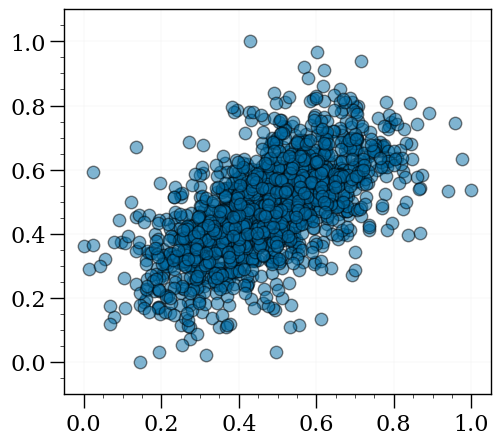

In [60]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [61]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [62]:
run(TrainingTensors, train_D, test_D, key, 'frank_5')

  0%|          | 1/5000 [05:43<477:36:17, 343.94s/it]

Iter 0. Loss [[0.12622486 0.21123008 2.8252828 ]]


  0%|          | 12/5000 [11:10<7:01:07,  5.07s/it]

Iter 10. Loss [[0.12585133 0.20998535 2.7859344 ]]


  0%|          | 22/5000 [11:12<27:27,  3.02it/s]

Iter 20. Loss [[0.12546833 0.20871757 2.7481637 ]]


  1%|          | 31/5000 [11:15<27:53,  2.97it/s]

Iter 30. Loss [[0.12507106 0.20741789 2.7119281 ]]


  1%|          | 41/5000 [11:17<17:00,  4.86it/s]

Iter 40. Loss [[0.12465773 0.20607941 2.677076  ]]


  1%|          | 51/5000 [11:19<21:52,  3.77it/s]

Iter 50. Loss [[0.12422981 0.20469871 2.643405  ]]


  1%|          | 61/5000 [11:23<27:48,  2.96it/s]

Iter 60. Loss [[0.12379114 0.20327628 2.6107101 ]]


  1%|▏         | 71/5000 [11:26<18:12,  4.51it/s]

Iter 70. Loss [[0.12334722 0.20181563 2.578821  ]]


  2%|▏         | 81/5000 [11:28<16:47,  4.88it/s]

Iter 80. Loss [[0.12290391 0.2003221  2.5476108 ]]


  2%|▏         | 91/5000 [11:30<16:43,  4.89it/s]

Iter 90. Loss [[0.12246662 0.19880135 2.516994  ]]


  2%|▏         | 101/5000 [11:34<24:18,  3.36it/s]

Iter 100. Loss [[0.12203994 0.19725867 2.486916  ]]


  2%|▏         | 111/5000 [11:37<27:12,  3.00it/s]

Iter 110. Loss [[0.12162778 0.19569853 2.4573438 ]]


  2%|▏         | 121/5000 [11:39<17:17,  4.70it/s]

Iter 120. Loss [[0.12123322 0.19412467 2.4282553 ]]


  3%|▎         | 131/5000 [11:42<27:34,  2.94it/s]

Iter 130. Loss [[0.12085886 0.19254015 2.3996365 ]]


  3%|▎         | 142/5000 [11:45<16:33,  4.89it/s]

Iter 140. Loss [[0.12050679 0.19094764 2.3714778 ]]


  3%|▎         | 152/5000 [11:47<16:29,  4.90it/s]

Iter 150. Loss [[0.12017892 0.18934932 2.3437717 ]]


  3%|▎         | 161/5000 [11:51<1:02:48,  1.28it/s]

Iter 160. Loss [[0.11987673 0.18774715 2.3165123 ]]


  3%|▎         | 171/5000 [11:53<18:10,  4.43it/s]

Iter 170. Loss [[0.11960156 0.18614282 2.2896955 ]]


  4%|▎         | 181/5000 [11:55<16:31,  4.86it/s]

Iter 180. Loss [[0.11935457 0.18453781 2.2633162 ]]


  4%|▍         | 191/5000 [11:57<16:19,  4.91it/s]

Iter 190. Loss [[0.11913672 0.18293355 2.2373707 ]]


  4%|▍         | 201/5000 [12:00<20:10,  3.97it/s]

Iter 200. Loss [[0.11894896 0.18133128 2.211856  ]]


  4%|▍         | 211/5000 [12:03<24:55,  3.20it/s]

Iter 210. Loss [[0.118792   0.17973223 2.1867673 ]]


  4%|▍         | 221/5000 [12:06<22:39,  3.52it/s]

Iter 220. Loss [[0.11866648 0.17813753 2.1621008 ]]


  5%|▍         | 231/5000 [12:09<31:32,  2.52it/s]

Iter 230. Loss [[0.11857299 0.17654832 2.1378524 ]]


  5%|▍         | 242/5000 [12:12<16:30,  4.80it/s]

Iter 240. Loss [[0.11851196 0.17496558 2.1140172 ]]


  5%|▌         | 252/5000 [12:14<15:56,  4.96it/s]

Iter 250. Loss [[0.11848378 0.17339036 2.0905912 ]]


  5%|▌         | 262/5000 [12:16<16:03,  4.92it/s]

Iter 260. Loss [[0.11848867 0.17182359 2.0675688 ]]


  5%|▌         | 271/5000 [12:20<24:45,  3.18it/s]

Iter 270. Loss [[0.11852692 0.17026614 2.0449443 ]]


  6%|▌         | 281/5000 [12:22<16:32,  4.75it/s]

Iter 280. Loss [[0.11859856 0.16871884 2.0227118 ]]


  6%|▌         | 291/5000 [12:24<15:47,  4.97it/s]

Iter 290. Loss [[0.11870366 0.16718253 2.0008664 ]]


  6%|▌         | 301/5000 [12:27<23:12,  3.38it/s]

Iter 300. Loss [[0.11884217 0.16565797 1.979402  ]]


  6%|▌         | 311/5000 [12:30<16:20,  4.78it/s]

Iter 310. Loss [[0.11901395 0.16414583 1.9583122 ]]


  6%|▋         | 321/5000 [12:33<25:39,  3.04it/s]

Iter 320. Loss [[0.11921883 0.16264677 1.9375908 ]]


  7%|▋         | 331/5000 [12:36<37:44,  2.06it/s]

Iter 330. Loss [[0.11945656 0.16116135 1.917231  ]]


  7%|▋         | 341/5000 [12:39<16:28,  4.71it/s]

Iter 340. Loss [[0.11972681 0.1596902  1.897227  ]]


  7%|▋         | 351/5000 [12:41<15:40,  4.95it/s]

Iter 350. Loss [[0.12002923 0.1582338  1.8775729 ]]


  7%|▋         | 361/5000 [12:43<15:55,  4.85it/s]

Iter 360. Loss [[0.12036331 0.15679264 1.8582621 ]]


  7%|▋         | 371/5000 [12:47<28:53,  2.67it/s]

Iter 370. Loss [[0.12072861 0.15536718 1.8392892 ]]


  8%|▊         | 382/5000 [12:50<16:50,  4.57it/s]

Iter 380. Loss [[0.12112457 0.1539578  1.8206481 ]]


  8%|▊         | 391/5000 [12:52<15:53,  4.83it/s]

Iter 390. Loss [[0.12155053 0.15256494 1.802334  ]]


  8%|▊         | 401/5000 [12:55<29:48,  2.57it/s]

Iter 400. Loss [[0.12200586 0.15118894 1.7843411 ]]


  8%|▊         | 412/5000 [12:57<15:43,  4.86it/s]

Iter 410. Loss [[0.12248977 0.14983012 1.7666657 ]]


  8%|▊         | 421/5000 [12:59<20:41,  3.69it/s]

Iter 420. Loss [[0.1230015  0.14848886 1.749303  ]]


  9%|▊         | 431/5000 [13:02<25:15,  3.02it/s]

Iter 430. Loss [[0.12354017 0.14716545 1.7322496 ]]


  9%|▉         | 441/5000 [13:06<18:24,  4.13it/s]

Iter 440. Loss [[0.12410486 0.14586021 1.7155024 ]]


  9%|▉         | 451/5000 [13:08<15:51,  4.78it/s]

Iter 450. Loss [[0.12469454 0.1445735  1.6990592 ]]


  9%|▉         | 461/5000 [13:10<15:41,  4.82it/s]

Iter 460. Loss [[0.12530808 0.14330564 1.6829189 ]]


  9%|▉         | 471/5000 [13:14<29:57,  2.52it/s]

Iter 470. Loss [[0.12594429 0.14205706 1.667081  ]]


 10%|▉         | 481/5000 [13:17<23:34,  3.20it/s]

Iter 480. Loss [[0.12660189 0.14082812 1.6515453 ]]


 10%|▉         | 491/5000 [13:19<15:57,  4.71it/s]

Iter 490. Loss [[0.12727934 0.13961928 1.6363138 ]]


 10%|█         | 502/5000 [13:23<29:11,  2.57it/s]

Iter 500. Loss [[0.12797503 0.13843113 1.6213896 ]]


 10%|█         | 512/5000 [13:25<15:30,  4.82it/s]

Iter 510. Loss [[0.12868702 0.1372643  1.606778  ]]


 10%|█         | 521/5000 [13:27<15:07,  4.93it/s]

Iter 520. Loss [[0.12941328 0.13611956 1.5924847 ]]


 11%|█         | 531/5000 [13:30<24:22,  3.06it/s]

Iter 530. Loss [[0.13015127 0.13499796 1.5785195 ]]


 11%|█         | 542/5000 [13:34<18:15,  4.07it/s]

Iter 540. Loss [[0.1308979  0.13390078 1.5648948 ]]


 11%|█         | 552/5000 [13:36<15:03,  4.92it/s]

Iter 550. Loss [[0.13164943 0.13282971 1.5516269 ]]


 11%|█         | 562/5000 [13:38<14:54,  4.96it/s]

Iter 560. Loss [[0.13240097 0.13178723 1.5387383 ]]


 11%|█▏        | 572/5000 [13:41<21:40,  3.40it/s]

Iter 570. Loss [[0.13314582 0.13077688 1.52626   ]]


 12%|█▏        | 581/5000 [13:44<24:00,  3.07it/s]

Iter 580. Loss [[0.13387375 0.12980458 1.5142363 ]]


 12%|█▏        | 591/5000 [13:47<17:14,  4.26it/s]

Iter 590. Loss [[0.13456695 0.12888107 1.5027369 ]]


 12%|█▏        | 602/5000 [13:50<34:25,  2.13it/s]

Iter 600. Loss [[0.1351867  0.12803127 1.4918818 ]]


 12%|█▏        | 612/5000 [13:52<15:23,  4.75it/s]

Iter 610. Loss [[0.13561518 0.12733462 1.4818454 ]]


 12%|█▏        | 622/5000 [13:54<14:57,  4.88it/s]

Iter 620. Loss [[0.1355959  0.12698275 1.47212   ]]


 13%|█▎        | 631/5000 [13:56<16:31,  4.40it/s]

Iter 630. Loss [[0.13552774 0.12672414 1.4639496 ]]


 13%|█▎        | 642/5000 [14:01<19:48,  3.67it/s]

Iter 640. Loss [[0.13549471 0.12649654 1.4572905 ]]


 13%|█▎        | 652/5000 [14:03<14:51,  4.88it/s]

Iter 650. Loss [[0.13554037 0.12625645 1.451899  ]]


 13%|█▎        | 662/5000 [14:05<14:38,  4.94it/s]

Iter 660. Loss [[0.13562384 0.12602535 1.4473294 ]]


 13%|█▎        | 671/5000 [14:08<27:57,  2.58it/s]

Iter 670. Loss [[0.1357555  0.12578462 1.4434369 ]]


 14%|█▎        | 681/5000 [14:10<15:16,  4.71it/s]

Iter 680. Loss [[0.13591848 0.12554018 1.4400345 ]]


 14%|█▍        | 691/5000 [14:13<23:50,  3.01it/s]

Iter 690. Loss [[0.13609664 0.12530006 1.4369876 ]]


 14%|█▍        | 702/5000 [14:16<15:14,  4.70it/s]

Iter 700. Loss [[0.13628371 0.12506595 1.4342265 ]]


 14%|█▍        | 711/5000 [14:19<16:18,  4.38it/s]

Iter 710. Loss [[0.13647565 0.12483834 1.4317015 ]]


 14%|█▍        | 722/5000 [14:21<14:31,  4.91it/s]

Iter 720. Loss [[0.13666819 0.12461864 1.4293685 ]]


 15%|█▍        | 732/5000 [14:23<14:41,  4.84it/s]

Iter 730. Loss [[0.13685836 0.12440753 1.4271941 ]]


 15%|█▍        | 741/5000 [14:27<30:11,  2.35it/s]

Iter 740. Loss [[0.13704495 0.12420498 1.4251556 ]]


 15%|█▌        | 752/5000 [14:30<15:02,  4.71it/s]

Iter 750. Loss [[0.13722765 0.12401036 1.4232366 ]]


 15%|█▌        | 761/5000 [14:32<14:27,  4.88it/s]

Iter 760. Loss [[0.13740645 0.12382322 1.4214247 ]]


 15%|█▌        | 771/5000 [14:34<14:21,  4.91it/s]

Iter 770. Loss [[0.13758114 0.12364317 1.419709  ]]


 16%|█▌        | 781/5000 [14:37<15:29,  4.54it/s]

Iter 780. Loss [[0.1377515  0.12346994 1.4180803 ]]


 16%|█▌        | 791/5000 [14:40<21:34,  3.25it/s]

Iter 790. Loss [[0.13791719 0.12330333 1.4165312 ]]


 16%|█▌        | 801/5000 [14:43<21:18,  3.28it/s]

Iter 800. Loss [[0.138078   0.12314331 1.4150553 ]]


 16%|█▌        | 812/5000 [14:46<16:35,  4.21it/s]

Iter 810. Loss [[0.13823368 0.12298963 1.4136455 ]]


 16%|█▋        | 822/5000 [14:48<14:12,  4.90it/s]

Iter 820. Loss [[0.13838416 0.12284213 1.4122982 ]]


 17%|█▋        | 832/5000 [14:51<14:02,  4.95it/s]

Iter 830. Loss [[0.13852942 0.12270062 1.4110081 ]]


 17%|█▋        | 841/5000 [14:54<37:19,  1.86it/s]

Iter 840. Loss [[0.13866945 0.12256494 1.4097724 ]]


 17%|█▋        | 851/5000 [14:57<23:30,  2.94it/s]

Iter 850. Loss [[0.1388042  0.12243489 1.4085879 ]]


 17%|█▋        | 862/5000 [14:59<14:15,  4.83it/s]

Iter 860. Loss [[0.138934   0.12231014 1.4074515 ]]


 17%|█▋        | 872/5000 [15:01<13:58,  4.92it/s]

Iter 870. Loss [[0.13905872 0.12219065 1.40636   ]]


 18%|█▊        | 881/5000 [15:04<15:24,  4.45it/s]

Iter 880. Loss [[0.13917859 0.12207613 1.4053122 ]]


 18%|█▊        | 891/5000 [15:06<13:51,  4.94it/s]

Iter 890. Loss [[0.1392938  0.12196631 1.4043053 ]]


 18%|█▊        | 901/5000 [15:09<21:59,  3.11it/s]

Iter 900. Loss [[0.13940439 0.12186112 1.4033376 ]]


 18%|█▊        | 911/5000 [15:13<22:08,  3.08it/s]

Iter 910. Loss [[0.13951059 0.12176029 1.402407  ]]


 18%|█▊        | 921/5000 [15:15<14:01,  4.85it/s]

Iter 920. Loss [[0.13961256 0.12166365 1.4015117 ]]


 19%|█▊        | 931/5000 [15:17<13:49,  4.91it/s]

Iter 930. Loss [[0.13971043 0.12157098 1.4006507 ]]


 19%|█▉        | 942/5000 [15:21<32:22,  2.09it/s]

Iter 940. Loss [[0.13980433 0.12148213 1.3998226 ]]


 19%|█▉        | 951/5000 [15:24<22:30,  3.00it/s]

Iter 950. Loss [[0.13989452 0.12139693 1.3990257 ]]


 19%|█▉        | 962/5000 [15:27<15:50,  4.25it/s]

Iter 960. Loss [[0.13998114 0.1213152  1.3982586 ]]


 19%|█▉        | 971/5000 [15:29<13:58,  4.80it/s]

Iter 970. Loss [[0.14006427 0.12123679 1.3975203 ]]


 20%|█▉        | 982/5000 [15:32<15:02,  4.45it/s]

Iter 980. Loss [[0.14014405 0.1211616  1.3968096 ]]


 20%|█▉        | 991/5000 [15:34<13:42,  4.87it/s]

Iter 990. Loss [[0.14022075 0.12108935 1.3961259 ]]


 20%|██        | 1001/5000 [15:36<13:43,  4.86it/s]

Iter 1000. Loss [[0.14029442 0.12102002 1.3954673 ]]


 20%|██        | 1011/5000 [15:41<24:51,  2.67it/s]

Iter 1010. Loss [[0.14036523 0.12095344 1.3948334 ]]


 20%|██        | 1022/5000 [15:43<13:30,  4.91it/s]

Iter 1020. Loss [[0.14043328 0.12088948 1.3942226 ]]


 21%|██        | 1032/5000 [15:45<13:24,  4.94it/s]

Iter 1030. Loss [[0.1404987  0.12082806 1.393635  ]]


 21%|██        | 1042/5000 [15:48<25:24,  2.60it/s]

Iter 1040. Loss [[0.14056164 0.12076899 1.3930693 ]]


 21%|██        | 1051/5000 [15:50<14:05,  4.67it/s]

Iter 1050. Loss [[0.14062223 0.12071218 1.3925241 ]]


 21%|██        | 1061/5000 [15:53<22:04,  2.97it/s]

Iter 1060. Loss [[0.1406806  0.12065754 1.3920003 ]]


 21%|██▏       | 1071/5000 [15:56<14:21,  4.56it/s]

Iter 1070. Loss [[0.14073661 0.12060508 1.3914946 ]]


 22%|██▏       | 1081/5000 [15:59<15:43,  4.15it/s]

Iter 1080. Loss [[0.14079066 0.12055454 1.391008  ]]


 22%|██▏       | 1092/5000 [16:01<13:30,  4.82it/s]

Iter 1090. Loss [[0.1408427  0.12050592 1.3905399 ]]


 22%|██▏       | 1101/5000 [16:03<13:18,  4.89it/s]

Iter 1100. Loss [[0.14089282 0.12045915 1.3900886 ]]


 22%|██▏       | 1111/5000 [16:07<30:24,  2.13it/s]

Iter 1110. Loss [[0.14094114 0.12041412 1.3896539 ]]


 22%|██▏       | 1121/5000 [16:10<14:36,  4.43it/s]

Iter 1120. Loss [[0.14098778 0.12037069 1.3892356 ]]


 23%|██▎       | 1131/5000 [16:12<13:02,  4.94it/s]

Iter 1130. Loss [[0.14103277 0.1203289  1.3888333 ]]


 23%|██▎       | 1142/5000 [16:15<30:06,  2.14it/s]

Iter 1140. Loss [[0.14107615 0.12028861 1.3884455 ]]


 23%|██▎       | 1151/5000 [16:17<13:46,  4.65it/s]

Iter 1150. Loss [[0.14111795 0.12024982 1.3880717 ]]


 23%|██▎       | 1161/5000 [16:19<18:49,  3.40it/s]

Iter 1160. Loss [[0.14115828 0.12021248 1.3877115 ]]


 23%|██▎       | 1171/5000 [16:23<21:15,  3.00it/s]

Iter 1170. Loss [[0.14119719 0.12017646 1.3873652 ]]


 24%|██▎       | 1181/5000 [16:26<15:59,  3.98it/s]

Iter 1180. Loss [[0.14123483 0.12014171 1.3870316 ]]


 24%|██▍       | 1191/5000 [16:28<13:22,  4.75it/s]

Iter 1190. Loss [[0.1412711  0.12010825 1.3867099 ]]


 24%|██▍       | 1201/5000 [16:30<13:16,  4.77it/s]

Iter 1200. Loss [[0.14130618 0.12007596 1.3864003 ]]


 24%|██▍       | 1211/5000 [16:34<30:31,  2.07it/s]

Iter 1210. Loss [[0.14134008 0.12004482 1.3861022 ]]


 24%|██▍       | 1221/5000 [16:37<21:35,  2.92it/s]

Iter 1220. Loss [[0.14137278 0.12001479 1.3858154 ]]


 25%|██▍       | 1232/5000 [16:39<13:03,  4.81it/s]

Iter 1230. Loss [[0.14140442 0.11998579 1.3855386 ]]


 25%|██▍       | 1242/5000 [16:41<12:58,  4.83it/s]

Iter 1240. Loss [[0.141435   0.11995783 1.3852725 ]]


 25%|██▌       | 1251/5000 [16:45<14:17,  4.37it/s]

Iter 1250. Loss [[0.14146456 0.11993085 1.3850164 ]]


 25%|██▌       | 1261/5000 [16:47<13:00,  4.79it/s]

Iter 1260. Loss [[0.14149311 0.11990479 1.3847696 ]]


 25%|██▌       | 1271/5000 [16:50<20:33,  3.02it/s]

Iter 1270. Loss [[0.1415207  0.11987971 1.3845316 ]]


 26%|██▌       | 1281/5000 [16:54<18:35,  3.33it/s]

Iter 1280. Loss [[0.14154737 0.11985546 1.3843024 ]]


 26%|██▌       | 1291/5000 [16:56<12:57,  4.77it/s]

Iter 1290. Loss [[0.14157318 0.11983205 1.3840823 ]]


 26%|██▌       | 1302/5000 [16:58<12:28,  4.94it/s]

Iter 1300. Loss [[0.1415981  0.11980949 1.3838698 ]]


 26%|██▌       | 1312/5000 [17:01<24:08,  2.55it/s]

Iter 1310. Loss [[0.1416222 0.1197877 1.383665 ]]


 26%|██▋       | 1321/5000 [17:04<20:37,  2.97it/s]

Iter 1320. Loss [[0.14164558 0.11976662 1.3834684 ]]


 27%|██▋       | 1332/5000 [17:07<14:03,  4.35it/s]

Iter 1330. Loss [[0.14166814 0.11974632 1.3832786 ]]


 27%|██▋       | 1341/5000 [17:09<12:43,  4.79it/s]

Iter 1340. Loss [[0.14169003 0.11972667 1.3830967 ]]


 27%|██▋       | 1352/5000 [17:13<13:39,  4.45it/s]

Iter 1350. Loss [[0.14171112 0.11970772 1.3829212 ]]


 27%|██▋       | 1362/5000 [17:15<12:22,  4.90it/s]

Iter 1360. Loss [[0.14173159 0.11968939 1.3827523 ]]


 27%|██▋       | 1371/5000 [17:17<17:15,  3.51it/s]

Iter 1370. Loss [[0.1417514  0.11967171 1.3825895 ]]


 28%|██▊       | 1382/5000 [17:22<20:39,  2.92it/s]

Iter 1380. Loss [[0.14177048 0.11965472 1.3824322 ]]


 28%|██▊       | 1391/5000 [17:24<13:22,  4.50it/s]

Iter 1390. Loss [[0.14178894 0.11963826 1.3822815 ]]


 28%|██▊       | 1402/5000 [17:26<12:17,  4.88it/s]

Iter 1400. Loss [[0.14180686 0.11962236 1.3821363 ]]


 28%|██▊       | 1412/5000 [17:29<27:52,  2.15it/s]

Iter 1410. Loss [[0.14182408 0.11960705 1.3819971 ]]


 28%|██▊       | 1421/5000 [17:31<18:15,  3.27it/s]

Iter 1420. Loss [[0.14184077 0.11959226 1.3818626 ]]


 29%|██▊       | 1431/5000 [17:35<19:51,  3.00it/s]

Iter 1430. Loss [[0.14185695 0.11957797 1.3817332 ]]


 29%|██▉       | 1442/5000 [17:37<11:59,  4.95it/s]

Iter 1440. Loss [[0.14187264 0.11956415 1.3816091 ]]


 29%|██▉       | 1451/5000 [17:40<14:52,  3.98it/s]

Iter 1450. Loss [[0.14188774 0.11955087 1.3814889 ]]


 29%|██▉       | 1461/5000 [17:42<12:13,  4.83it/s]

Iter 1460. Loss [[0.14190234 0.11953802 1.3813741 ]]


 29%|██▉       | 1471/5000 [17:44<12:17,  4.79it/s]

Iter 1470. Loss [[0.14191654 0.1195256  1.3812634 ]]


 30%|██▉       | 1481/5000 [17:49<28:45,  2.04it/s]

Iter 1480. Loss [[0.14193025 0.11951361 1.3811569 ]]


 30%|██▉       | 1491/5000 [17:51<12:34,  4.65it/s]

Iter 1490. Loss [[0.14194348 0.11950205 1.3810545 ]]


 30%|███       | 1501/5000 [17:53<12:04,  4.83it/s]

Iter 1500. Loss [[0.14195628 0.11949092 1.380956  ]]


 30%|███       | 1511/5000 [17:55<11:51,  4.91it/s]

Iter 1510. Loss [[0.14196862 0.11948017 1.3808615 ]]


 30%|███       | 1522/5000 [17:58<12:27,  4.65it/s]

Iter 1520. Loss [[0.14198057 0.11946981 1.3807704 ]]


 31%|███       | 1531/5000 [18:01<18:45,  3.08it/s]

Iter 1530. Loss [[0.14199214 0.11945976 1.3806831 ]]


 31%|███       | 1542/5000 [18:04<13:32,  4.26it/s]

Iter 1540. Loss [[0.14200333 0.11945011 1.3805989 ]]


 31%|███       | 1551/5000 [18:07<14:31,  3.96it/s]

Iter 1550. Loss [[0.14201412 0.1194408  1.3805186 ]]


 31%|███       | 1561/5000 [18:09<11:55,  4.81it/s]

Iter 1560. Loss [[0.14202453 0.11943183 1.3804407 ]]


 31%|███▏      | 1572/5000 [18:11<11:34,  4.93it/s]

Iter 1570. Loss [[0.14203465 0.11942311 1.3803666 ]]


 32%|███▏      | 1581/5000 [18:15<28:33,  2.00it/s]

Iter 1580. Loss [[0.14204435 0.11941479 1.3802949 ]]


 32%|███▏      | 1592/5000 [18:18<13:19,  4.26it/s]

Iter 1590. Loss [[0.14205375 0.11940677 1.3802259 ]]


 32%|███▏      | 1602/5000 [18:20<11:28,  4.94it/s]

Iter 1600. Loss [[0.14206289 0.11939897 1.3801603 ]]


 32%|███▏      | 1611/5000 [18:22<11:28,  4.92it/s]

Iter 1610. Loss [[0.14207165 0.11939148 1.380097  ]]


 32%|███▏      | 1621/5000 [18:25<12:25,  4.53it/s]

Iter 1620. Loss [[0.1420802  0.11938424 1.3800365 ]]


 33%|███▎      | 1631/5000 [18:27<11:31,  4.87it/s]

Iter 1630. Loss [[0.14208841 0.11937728 1.3799778 ]]


 33%|███▎      | 1641/5000 [18:31<18:41,  2.99it/s]

Iter 1640. Loss [[0.1420963  0.11937057 1.3799225 ]]


 33%|███▎      | 1651/5000 [18:34<15:37,  3.57it/s]

Iter 1650. Loss [[0.14210391 0.11936416 1.3798685 ]]


 33%|███▎      | 1662/5000 [18:37<11:11,  4.97it/s]

Iter 1660. Loss [[0.14211129 0.11935793 1.3798168 ]]


 33%|███▎      | 1672/5000 [18:39<11:11,  4.95it/s]

Iter 1670. Loss [[0.14211845 0.11935191 1.3797678 ]]


 34%|███▎      | 1681/5000 [18:42<21:30,  2.57it/s]

Iter 1680. Loss [[0.14212531 0.11934613 1.3797206 ]]


 34%|███▍      | 1691/5000 [18:45<18:40,  2.95it/s]

Iter 1690. Loss [[0.14213195 0.1193406  1.3796751 ]]


 34%|███▍      | 1702/5000 [18:48<11:45,  4.67it/s]

Iter 1700. Loss [[0.14213839 0.1193352  1.3796319 ]]


 34%|███▍      | 1711/5000 [18:50<11:37,  4.72it/s]

Iter 1710. Loss [[0.14214464 0.11933    1.3795905 ]]


 34%|███▍      | 1722/5000 [18:53<11:42,  4.67it/s]

Iter 1720. Loss [[0.1421506  0.11932505 1.3795505 ]]


 35%|███▍      | 1731/5000 [18:55<11:11,  4.87it/s]

Iter 1730. Loss [[0.14215633 0.11932029 1.3795125 ]]


 35%|███▍      | 1741/5000 [18:57<16:14,  3.34it/s]

Iter 1740. Loss [[0.1421619  0.11931568 1.3794762 ]]


 35%|███▌      | 1751/5000 [19:02<16:17,  3.32it/s]

Iter 1750. Loss [[0.14216729 0.11931126 1.379441  ]]


 35%|███▌      | 1761/5000 [19:04<11:02,  4.89it/s]

Iter 1760. Loss [[0.14217246 0.11930697 1.3794079 ]]


 35%|███▌      | 1771/5000 [19:06<11:02,  4.88it/s]

Iter 1770. Loss [[0.14217749 0.11930285 1.3793763 ]]


 36%|███▌      | 1781/5000 [19:09<25:45,  2.08it/s]

Iter 1780. Loss [[0.14218225 0.11929895 1.379345  ]]


 36%|███▌      | 1791/5000 [19:11<16:21,  3.27it/s]

Iter 1790. Loss [[0.1421869  0.11929516 1.3793162 ]]


 36%|███▌      | 1801/5000 [19:15<17:25,  3.06it/s]

Iter 1800. Loss [[0.14219142 0.11929146 1.3792884 ]]


 36%|███▌      | 1812/5000 [19:17<10:52,  4.88it/s]

Iter 1810. Loss [[0.14219576 0.11928795 1.3792617 ]]


 36%|███▋      | 1821/5000 [19:20<12:49,  4.13it/s]

Iter 1820. Loss [[0.1421999  0.11928456 1.3792363 ]]


 37%|███▋      | 1832/5000 [19:22<10:59,  4.80it/s]

Iter 1830. Loss [[0.14220391 0.11928133 1.379212  ]]


 37%|███▋      | 1841/5000 [19:24<11:11,  4.71it/s]

Iter 1840. Loss [[0.14220779 0.11927819 1.3791888 ]]


 37%|███▋      | 1852/5000 [19:29<20:14,  2.59it/s]

Iter 1850. Loss [[0.14221151 0.11927518 1.379167  ]]


 37%|███▋      | 1861/5000 [19:31<11:09,  4.69it/s]

Iter 1860. Loss [[0.14221516 0.1192723  1.3791456 ]]


 37%|███▋      | 1872/5000 [19:33<10:47,  4.83it/s]

Iter 1870. Loss [[0.14221863 0.1192695  1.3791255 ]]


 38%|███▊      | 1881/5000 [19:35<10:48,  4.81it/s]

Iter 1880. Loss [[0.14222199 0.11926684 1.3791063 ]]


 38%|███▊      | 1892/5000 [19:38<11:28,  4.52it/s]

Iter 1890. Loss [[0.14222518 0.1192643  1.3790877 ]]


 38%|███▊      | 1901/5000 [19:41<17:20,  2.98it/s]

Iter 1900. Loss [[0.14222826 0.11926184 1.3790706 ]]


 38%|███▊      | 1911/5000 [19:44<11:50,  4.34it/s]

Iter 1910. Loss [[0.1422313  0.11925943 1.3790541 ]]


 38%|███▊      | 1922/5000 [19:48<12:43,  4.03it/s]

Iter 1920. Loss [[0.14223415 0.11925718 1.3790381 ]]


 39%|███▊      | 1932/5000 [19:50<10:27,  4.89it/s]

Iter 1930. Loss [[0.14223701 0.11925495 1.3790234 ]]


 39%|███▉      | 1941/5000 [19:51<10:42,  4.76it/s]

Iter 1940. Loss [[0.14223959 0.11925293 1.3790088 ]]


 39%|███▉      | 1951/5000 [19:55<26:39,  1.91it/s]

Iter 1950. Loss [[0.14224218 0.11925089 1.3789954 ]]


 39%|███▉      | 1961/5000 [19:58<11:48,  4.29it/s]

Iter 1960. Loss [[0.14224474 0.11924893 1.3789825 ]]


 39%|███▉      | 1971/5000 [20:00<10:34,  4.77it/s]

Iter 1970. Loss [[0.14224711 0.11924708 1.3789704 ]]


 40%|███▉      | 1981/5000 [20:02<10:31,  4.78it/s]

Iter 1980. Loss [[0.14224935 0.11924534 1.3789583 ]]


 40%|███▉      | 1991/5000 [20:05<11:25,  4.39it/s]

Iter 1990. Loss [[0.14225158 0.11924361 1.3789479 ]]


 40%|████      | 2001/5000 [20:08<13:25,  3.72it/s]

Iter 2000. Loss [[0.1422537  0.11924201 1.3789369 ]]


 40%|████      | 2011/5000 [20:11<16:33,  3.01it/s]

Iter 2010. Loss [[0.14225581 0.11924039 1.3789274 ]]


 40%|████      | 2021/5000 [20:15<14:53,  3.33it/s]

Iter 2020. Loss [[0.14225781 0.11923887 1.3789178 ]]


 41%|████      | 2031/5000 [20:17<10:20,  4.78it/s]

Iter 2030. Loss [[0.14225955 0.11923752 1.3789085 ]]


 41%|████      | 2042/5000 [20:19<10:04,  4.90it/s]

Iter 2040. Loss [[0.14226156 0.11923602 1.3789002 ]]


 41%|████      | 2051/5000 [20:22<29:35,  1.66it/s]

Iter 2050. Loss [[0.14226337 0.11923466 1.3788925 ]]


 41%|████      | 2061/5000 [20:25<17:19,  2.83it/s]

Iter 2060. Loss [[0.14226486 0.1192335  1.3788844 ]]


 41%|████▏     | 2072/5000 [20:28<10:08,  4.81it/s]

Iter 2070. Loss [[0.14226665 0.1192322  1.3788776 ]]


 42%|████▏     | 2082/5000 [20:30<09:53,  4.91it/s]

Iter 2080. Loss [[0.14226809 0.11923109 1.3788706 ]]


 42%|████▏     | 2092/5000 [20:33<11:27,  4.23it/s]

Iter 2090. Loss [[0.14226966 0.11922995 1.3788644 ]]


 42%|████▏     | 2102/5000 [20:35<09:55,  4.87it/s]

Iter 2100. Loss [[0.14227112 0.11922887 1.3788582 ]]


 42%|████▏     | 2111/5000 [20:38<15:32,  3.10it/s]

Iter 2110. Loss [[0.14227247 0.11922783 1.3788525 ]]


 42%|████▏     | 2121/5000 [20:42<18:37,  2.58it/s]

Iter 2120. Loss [[0.14227392 0.11922681 1.378847  ]]


 43%|████▎     | 2131/5000 [20:44<10:09,  4.71it/s]

Iter 2130. Loss [[0.14227517 0.11922589 1.3788421 ]]


 43%|████▎     | 2141/5000 [20:46<09:58,  4.78it/s]

Iter 2140. Loss [[0.14227629 0.11922506 1.3788369 ]]


 43%|████▎     | 2151/5000 [20:48<09:49,  4.83it/s]

Iter 2150. Loss [[0.14227764 0.11922408 1.3788333 ]]


 43%|████▎     | 2161/5000 [20:52<16:11,  2.92it/s]

Iter 2160. Loss [[0.1422787 0.1192233 1.3788282]]


 43%|████▎     | 2171/5000 [20:55<12:01,  3.92it/s]

Iter 2170. Loss [[0.14227992 0.11922245 1.3788245 ]]


 44%|████▎     | 2182/5000 [20:57<09:40,  4.86it/s]

Iter 2180. Loss [[0.14228088 0.11922174 1.3788208 ]]


 44%|████▍     | 2191/5000 [21:01<12:51,  3.64it/s]

Iter 2190. Loss [[0.14228193 0.11922099 1.3788176 ]]


 44%|████▍     | 2202/5000 [21:03<09:33,  4.88it/s]

Iter 2200. Loss [[0.14228295 0.11922027 1.3788141 ]]


 44%|████▍     | 2211/5000 [21:05<10:03,  4.62it/s]

Iter 2210. Loss [[0.14228386 0.11921962 1.3788109 ]]


 44%|████▍     | 2222/5000 [21:10<23:13,  1.99it/s]

Iter 2220. Loss [[0.14228481 0.11921895 1.3788081 ]]


 45%|████▍     | 2231/5000 [21:12<10:07,  4.56it/s]

Iter 2230. Loss [[0.14228567 0.11921836 1.3788056 ]]


 45%|████▍     | 2242/5000 [21:14<09:21,  4.91it/s]

Iter 2240. Loss [[0.14228655 0.11921775 1.3788028 ]]


 45%|████▌     | 2252/5000 [21:16<09:23,  4.88it/s]

Iter 2250. Loss [[0.14228731 0.11921722 1.3788002 ]]


 45%|████▌     | 2261/5000 [21:19<11:08,  4.10it/s]

Iter 2260. Loss [[0.14228816 0.11921664 1.3787981 ]]


 45%|████▌     | 2271/5000 [21:22<15:01,  3.03it/s]

Iter 2270. Loss [[0.14228888 0.11921612 1.3787962 ]]


 46%|████▌     | 2281/5000 [21:25<09:49,  4.61it/s]

Iter 2280. Loss [[0.14228958 0.11921564 1.378794  ]]


 46%|████▌     | 2291/5000 [21:28<12:28,  3.62it/s]

Iter 2290. Loss [[0.14229031 0.11921515 1.3787928 ]]


 46%|████▌     | 2302/5000 [21:31<09:16,  4.85it/s]

Iter 2300. Loss [[0.14229092 0.11921474 1.3787906 ]]


 46%|████▌     | 2312/5000 [21:33<09:21,  4.79it/s]

Iter 2310. Loss [[0.14229156 0.11921427 1.3787894 ]]


 46%|████▋     | 2321/5000 [21:37<28:38,  1.56it/s]

Iter 2320. Loss [[0.14229211 0.11921391 1.3787878 ]]


 47%|████▋     | 2331/5000 [21:39<10:07,  4.39it/s]

Iter 2330. Loss [[0.14229275 0.11921349 1.3787864 ]]


 47%|████▋     | 2341/5000 [21:41<09:11,  4.82it/s]

Iter 2340. Loss [[0.14229335 0.1192131  1.3787851 ]]


 47%|████▋     | 2351/5000 [21:43<09:15,  4.77it/s]

Iter 2350. Loss [[0.14229396 0.11921269 1.3787845 ]]


 47%|████▋     | 2362/5000 [21:47<09:58,  4.41it/s]

Iter 2360. Loss [[0.14229438 0.11921241 1.3787829 ]]


 47%|████▋     | 2371/5000 [21:49<13:20,  3.28it/s]

Iter 2370. Loss [[0.14229506 0.11921197 1.3787824 ]]


 48%|████▊     | 2382/5000 [21:52<11:56,  3.65it/s]

Iter 2380. Loss [[0.14229526 0.11921185 1.378781  ]]


 48%|████▊     | 2392/5000 [21:56<12:48,  3.39it/s]

Iter 2390. Loss [[0.14229603 0.11921133 1.378781  ]]


 48%|████▊     | 2402/5000 [21:58<08:55,  4.86it/s]

Iter 2400. Loss [[0.14229622 0.1192112  1.3787793 ]]


 48%|████▊     | 2412/5000 [22:00<08:45,  4.92it/s]

Iter 2410. Loss [[0.14229672 0.1192109  1.3787788 ]]


 48%|████▊     | 2422/5000 [22:02<08:45,  4.91it/s]

Iter 2420. Loss [[0.14229722 0.11921055 1.3787786 ]]


 49%|████▊     | 2431/5000 [22:06<14:17,  2.99it/s]

Iter 2430. Loss [[0.14229752 0.11921038 1.378778  ]]


 49%|████▉     | 2442/5000 [22:08<08:43,  4.89it/s]

Iter 2440. Loss [[0.14229806 0.11921004 1.3787774 ]]


 49%|████▉     | 2452/5000 [22:10<08:41,  4.89it/s]

Iter 2450. Loss [[0.14229828 0.1192099  1.3787768 ]]


 49%|████▉     | 2461/5000 [22:14<12:39,  3.34it/s]

Iter 2460. Loss [[0.14229879 0.11920957 1.378777  ]]


 49%|████▉     | 2471/5000 [22:16<08:48,  4.78it/s]

Iter 2470. Loss [[0.142299   0.11920945 1.3787763 ]]


 50%|████▉     | 2481/5000 [22:19<13:49,  3.04it/s]

Iter 2480. Loss [[0.14229935 0.11920923 1.3787761 ]]


 50%|████▉     | 2492/5000 [22:23<20:04,  2.08it/s]

Iter 2490. Loss [[0.14229976 0.11920896 1.3787758 ]]


 50%|█████     | 2502/5000 [22:25<08:49,  4.72it/s]

Iter 2500. Loss [[0.14229986 0.1192089  1.378775  ]]


 50%|█████     | 2511/5000 [22:27<08:31,  4.87it/s]

Iter 2510. Loss [[0.1423003  0.11920862 1.3787754 ]]


 50%|█████     | 2522/5000 [22:29<08:23,  4.92it/s]

Iter 2520. Loss [[0.1423005  0.11920849 1.3787752 ]]


 51%|█████     | 2531/5000 [22:33<16:03,  2.56it/s]

Iter 2530. Loss [[0.14230081 0.11920829 1.3787754 ]]


 51%|█████     | 2542/5000 [22:36<09:10,  4.46it/s]

Iter 2540. Loss [[0.14230114 0.11920809 1.378775  ]]


 51%|█████     | 2552/5000 [22:38<08:23,  4.87it/s]

Iter 2550. Loss [[0.14230128 0.11920804 1.3787744 ]]


 51%|█████     | 2562/5000 [22:41<15:55,  2.55it/s]

Iter 2560. Loss [[0.14230153 0.11920787 1.3787748 ]]


 51%|█████▏    | 2572/5000 [22:43<08:24,  4.81it/s]

Iter 2570. Loss [[0.14230172 0.11920775 1.3787745 ]]


 52%|█████▏    | 2581/5000 [22:45<10:19,  3.91it/s]

Iter 2580. Loss [[0.14230211 0.11920752 1.378775  ]]


 52%|█████▏    | 2591/5000 [22:49<13:08,  3.06it/s]

Iter 2590. Loss [[0.14230214 0.1192075  1.3787744 ]]


 52%|█████▏    | 2602/5000 [22:52<08:55,  4.48it/s]

Iter 2600. Loss [[0.14230245 0.11920734 1.378775  ]]


 52%|█████▏    | 2611/5000 [22:54<08:22,  4.75it/s]

Iter 2610. Loss [[0.14230262 0.11920721 1.3787744 ]]


 52%|█████▏    | 2622/5000 [22:56<08:11,  4.84it/s]

Iter 2620. Loss [[0.14230281 0.11920711 1.3787744 ]]


 53%|█████▎    | 2631/5000 [23:00<13:36,  2.90it/s]

Iter 2630. Loss [[0.142303   0.11920699 1.3787748 ]]


 53%|█████▎    | 2641/5000 [23:03<13:19,  2.95it/s]

Iter 2640. Loss [[0.14230315 0.11920691 1.3787745 ]]


 53%|█████▎    | 2652/5000 [23:05<08:15,  4.74it/s]

Iter 2650. Loss [[0.1423033  0.11920682 1.378775  ]]


 53%|█████▎    | 2662/5000 [23:09<18:34,  2.10it/s]

Iter 2660. Loss [[0.14230353 0.11920668 1.3787749 ]]


 53%|█████▎    | 2671/5000 [23:11<08:28,  4.58it/s]

Iter 2670. Loss [[0.14230362 0.11920665 1.3787748 ]]


 54%|█████▎    | 2681/5000 [23:13<08:01,  4.82it/s]

Iter 2680. Loss [[0.14230378 0.11920656 1.378775  ]]


 54%|█████▍    | 2691/5000 [23:15<12:06,  3.18it/s]

Iter 2690. Loss [[0.142304   0.11920642 1.3787754 ]]


 54%|█████▍    | 2702/5000 [23:20<09:04,  4.22it/s]

Iter 2700. Loss [[0.14230417 0.11920634 1.3787754 ]]


 54%|█████▍    | 2712/5000 [23:22<07:41,  4.96it/s]

Iter 2710. Loss [[0.14230417 0.11920634 1.3787748 ]]


 54%|█████▍    | 2722/5000 [23:24<07:40,  4.95it/s]

Iter 2720. Loss [[0.14230429 0.11920628 1.378775  ]]


 55%|█████▍    | 2731/5000 [23:27<12:47,  2.96it/s]

Iter 2730. Loss [[0.14230442 0.1192062  1.3787754 ]]


 55%|█████▍    | 2741/5000 [23:29<12:05,  3.11it/s]

Iter 2740. Loss [[0.14230454 0.1192061  1.3787756 ]]


 55%|█████▌    | 2752/5000 [23:33<09:34,  3.91it/s]

Iter 2750. Loss [[0.14230469 0.11920603 1.3787754 ]]


 55%|█████▌    | 2761/5000 [23:35<07:48,  4.77it/s]

Iter 2760. Loss [[0.14230473 0.119206   1.3787756 ]]


 55%|█████▌    | 2772/5000 [23:38<07:53,  4.70it/s]

Iter 2770. Loss [[0.14230485 0.11920594 1.3787757 ]]


 56%|█████▌    | 2781/5000 [23:40<07:44,  4.77it/s]

Iter 2780. Loss [[0.14230497 0.11920589 1.3787757 ]]


 56%|█████▌    | 2791/5000 [23:42<07:43,  4.77it/s]

Iter 2790. Loss [[0.14230505 0.11920585 1.3787757 ]]


 56%|█████▌    | 2802/5000 [23:47<11:30,  3.19it/s]

Iter 2800. Loss [[0.14230524 0.11920572 1.3787763 ]]


 56%|█████▌    | 2812/5000 [23:49<07:31,  4.84it/s]

Iter 2810. Loss [[0.14230512 0.11920579 1.3787758 ]]


 56%|█████▋    | 2822/5000 [23:51<07:22,  4.92it/s]

Iter 2820. Loss [[0.14230539 0.11920564 1.3787763 ]]


 57%|█████▋    | 2832/5000 [23:54<16:45,  2.16it/s]

Iter 2830. Loss [[0.14230548 0.11920557 1.3787763 ]]


 57%|█████▋    | 2841/5000 [23:56<07:52,  4.56it/s]

Iter 2840. Loss [[0.14230542 0.11920565 1.3787761 ]]


 57%|█████▋    | 2851/5000 [23:59<11:40,  3.07it/s]

Iter 2850. Loss [[0.14230548 0.11920562 1.3787761 ]]


 57%|█████▋    | 2861/5000 [24:02<08:02,  4.44it/s]

Iter 2860. Loss [[0.14230566 0.11920548 1.378777  ]]


 57%|█████▋    | 2871/5000 [24:05<08:58,  3.96it/s]

Iter 2870. Loss [[0.14230575 0.11920545 1.378777  ]]


 58%|█████▊    | 2881/5000 [24:07<07:22,  4.79it/s]

Iter 2880. Loss [[0.14230575 0.11920545 1.3787767 ]]


 58%|█████▊    | 2891/5000 [24:09<07:22,  4.77it/s]

Iter 2890. Loss [[0.14230575 0.11920545 1.3787763 ]]


 58%|█████▊    | 2901/5000 [24:13<14:35,  2.40it/s]

Iter 2900. Loss [[0.14230591 0.11920536 1.378777  ]]


 58%|█████▊    | 2911/5000 [24:16<07:56,  4.38it/s]

Iter 2910. Loss [[0.14230594 0.11920535 1.378777  ]]


 58%|█████▊    | 2921/5000 [24:18<07:06,  4.87it/s]

Iter 2920. Loss [[0.1423059  0.11920539 1.3787767 ]]


 59%|█████▊    | 2931/5000 [24:21<20:30,  1.68it/s]

Iter 2930. Loss [[0.14230606 0.1192053  1.3787774 ]]


 59%|█████▉    | 2941/5000 [24:23<07:31,  4.56it/s]

Iter 2940. Loss [[0.14230615 0.11920524 1.3787774 ]]


 59%|█████▉    | 2951/5000 [24:26<10:10,  3.36it/s]

Iter 2950. Loss [[0.1423061  0.11920528 1.378777  ]]


 59%|█████▉    | 2961/5000 [24:29<11:25,  2.97it/s]

Iter 2960. Loss [[0.1423061  0.11920529 1.378777  ]]


 59%|█████▉    | 2972/5000 [24:33<07:43,  4.38it/s]

Iter 2970. Loss [[0.14230616 0.11920524 1.3787774 ]]


 60%|█████▉    | 2982/5000 [24:35<06:53,  4.88it/s]

Iter 2980. Loss [[0.14230618 0.11920522 1.3787774 ]]


 60%|█████▉    | 2991/5000 [24:37<06:47,  4.93it/s]

Iter 2990. Loss [[0.14230628 0.11920517 1.3787775 ]]


 60%|██████    | 3001/5000 [24:40<14:08,  2.36it/s]

Iter 3000. Loss [[0.14230628 0.11920516 1.378778  ]]


 60%|██████    | 3011/5000 [24:44<11:19,  2.93it/s]

Iter 3010. Loss [[0.14230634 0.11920514 1.3787776 ]]


 60%|██████    | 3022/5000 [24:46<06:46,  4.86it/s]

Iter 3020. Loss [[0.14230649 0.11920504 1.3787783 ]]


 61%|██████    | 3031/5000 [24:48<06:46,  4.85it/s]

Iter 3030. Loss [[0.14230654 0.11920501 1.3787783 ]]


 61%|██████    | 3041/5000 [24:51<07:08,  4.57it/s]

Iter 3040. Loss [[0.14230649 0.11920506 1.378778  ]]


 61%|██████    | 3052/5000 [24:53<06:34,  4.93it/s]

Iter 3050. Loss [[0.1423065  0.11920504 1.3787781 ]]


 61%|██████    | 3061/5000 [24:56<10:22,  3.11it/s]

Iter 3060. Loss [[0.14230657 0.11920501 1.378778  ]]


 61%|██████▏   | 3071/5000 [25:00<09:39,  3.33it/s]

Iter 3070. Loss [[0.1423065  0.11920504 1.378778  ]]


 62%|██████▏   | 3082/5000 [25:02<06:39,  4.80it/s]

Iter 3080. Loss [[0.14230649 0.11920509 1.3787781 ]]


 62%|██████▏   | 3092/5000 [25:04<06:29,  4.90it/s]

Iter 3090. Loss [[0.14230654 0.11920504 1.378778  ]]


 62%|██████▏   | 3102/5000 [25:08<15:32,  2.03it/s]

Iter 3100. Loss [[0.14230663 0.119205   1.3787783 ]]


 62%|██████▏   | 3111/5000 [25:11<10:41,  2.94it/s]

Iter 3110. Loss [[0.14230661 0.11920501 1.3787783 ]]


 62%|██████▏   | 3121/5000 [25:13<07:20,  4.26it/s]

Iter 3120. Loss [[0.14230666 0.11920498 1.378778  ]]


 63%|██████▎   | 3132/5000 [25:16<06:25,  4.85it/s]

Iter 3130. Loss [[0.14230663 0.119205   1.3787781 ]]


 63%|██████▎   | 3142/5000 [25:19<07:20,  4.22it/s]

Iter 3140. Loss [[0.14230676 0.11920493 1.3787783 ]]


 63%|██████▎   | 3152/5000 [25:21<06:13,  4.94it/s]

Iter 3150. Loss [[0.14230677 0.11920489 1.3787786 ]]


 63%|██████▎   | 3161/5000 [25:23<07:53,  3.88it/s]

Iter 3160. Loss [[0.14230685 0.11920486 1.3787788 ]]


 63%|██████▎   | 3171/5000 [25:27<12:17,  2.48it/s]

Iter 3170. Loss [[0.14230675 0.11920495 1.3787785 ]]


 64%|██████▎   | 3182/5000 [25:30<06:17,  4.82it/s]

Iter 3180. Loss [[0.14230676 0.11920493 1.3787786 ]]


 64%|██████▍   | 3191/5000 [25:32<06:19,  4.77it/s]

Iter 3190. Loss [[0.14230677 0.11920493 1.3787785 ]]


 64%|██████▍   | 3201/5000 [25:34<06:14,  4.80it/s]

Iter 3200. Loss [[0.14230683 0.11920487 1.3787786 ]]


 64%|██████▍   | 3211/5000 [25:37<08:10,  3.65it/s]

Iter 3210. Loss [[0.14230667 0.11920501 1.378778  ]]


 64%|██████▍   | 3221/5000 [25:41<10:08,  2.92it/s]

Iter 3220. Loss [[0.14230676 0.11920495 1.3787786 ]]


 65%|██████▍   | 3231/5000 [25:43<06:12,  4.74it/s]

Iter 3230. Loss [[0.14230695 0.11920481 1.3787789 ]]


 65%|██████▍   | 3242/5000 [25:46<07:57,  3.68it/s]

Iter 3240. Loss [[0.14230691 0.11920483 1.3787789 ]]


 65%|██████▌   | 3251/5000 [25:48<06:16,  4.64it/s]

Iter 3250. Loss [[0.14230698 0.11920479 1.3787789 ]]


 65%|██████▌   | 3262/5000 [25:50<05:57,  4.86it/s]

Iter 3260. Loss [[0.14230698 0.11920478 1.3787793 ]]


 65%|██████▌   | 3271/5000 [25:55<18:26,  1.56it/s]

Iter 3270. Loss [[0.14230698 0.11920478 1.3787789 ]]


 66%|██████▌   | 3282/5000 [25:57<06:07,  4.67it/s]

Iter 3280. Loss [[0.14230694 0.11920486 1.3787788 ]]


 66%|██████▌   | 3291/5000 [25:59<05:47,  4.92it/s]

Iter 3290. Loss [[0.1423069  0.11920486 1.3787789 ]]


 66%|██████▌   | 3301/5000 [26:01<05:55,  4.77it/s]

Iter 3300. Loss [[0.14230692 0.11920486 1.3787788 ]]


 66%|██████▌   | 3312/5000 [26:04<06:18,  4.46it/s]

Iter 3310. Loss [[0.14230695 0.11920483 1.3787789 ]]


 66%|██████▋   | 3321/5000 [26:07<08:45,  3.20it/s]

Iter 3320. Loss [[0.14230703 0.11920476 1.3787789 ]]


 67%|██████▋   | 3331/5000 [26:10<07:47,  3.57it/s]

Iter 3330. Loss [[0.142307   0.11920478 1.3787789 ]]


 67%|██████▋   | 3341/5000 [26:14<12:25,  2.23it/s]

Iter 3340. Loss [[0.14230686 0.11920489 1.3787786 ]]


 67%|██████▋   | 3352/5000 [26:16<05:49,  4.72it/s]

Iter 3350. Loss [[0.14230692 0.11920487 1.3787788 ]]


 67%|██████▋   | 3361/5000 [26:18<05:36,  4.87it/s]

Iter 3360. Loss [[0.14230698 0.11920481 1.3787789 ]]


 67%|██████▋   | 3371/5000 [26:20<07:31,  3.61it/s]

Iter 3370. Loss [[0.14230695 0.11920483 1.3787789 ]]


 68%|██████▊   | 3381/5000 [26:25<07:02,  3.83it/s]

Iter 3380. Loss [[0.14230698 0.1192048  1.3787793 ]]


 68%|██████▊   | 3392/5000 [26:27<05:31,  4.85it/s]

Iter 3390. Loss [[0.14230701 0.11920479 1.3787793 ]]


 68%|██████▊   | 3401/5000 [26:29<05:33,  4.80it/s]

Iter 3400. Loss [[0.14230695 0.11920483 1.3787789 ]]


 68%|██████▊   | 3411/5000 [26:32<07:07,  3.72it/s]

Iter 3410. Loss [[0.14230698 0.11920481 1.3787788 ]]


 68%|██████▊   | 3421/5000 [26:35<07:00,  3.75it/s]

Iter 3420. Loss [[0.14230701 0.11920479 1.3787792 ]]


 69%|██████▊   | 3431/5000 [26:38<08:48,  2.97it/s]

Iter 3430. Loss [[0.14230695 0.11920482 1.3787789 ]]


 69%|██████▉   | 3442/5000 [26:42<10:15,  2.53it/s]

Iter 3440. Loss [[0.14230695 0.11920483 1.3787789 ]]


 69%|██████▉   | 3451/5000 [26:43<05:31,  4.68it/s]

Iter 3450. Loss [[0.14230695 0.11920482 1.3787789 ]]


 69%|██████▉   | 3462/5000 [26:46<05:15,  4.87it/s]

Iter 3460. Loss [[0.14230703 0.11920479 1.3787789 ]]


 69%|██████▉   | 3471/5000 [26:48<05:20,  4.77it/s]

Iter 3470. Loss [[0.1423071  0.11920474 1.3787793 ]]


 70%|██████▉   | 3481/5000 [26:52<09:16,  2.73it/s]

Iter 3480. Loss [[0.14230716 0.11920471 1.3787796 ]]


 70%|██████▉   | 3491/5000 [26:54<05:23,  4.66it/s]

Iter 3490. Loss [[0.1423072  0.11920466 1.3787796 ]]


 70%|███████   | 3502/5000 [26:57<05:13,  4.79it/s]

Iter 3500. Loss [[0.14230709 0.11920476 1.3787793 ]]


 70%|███████   | 3511/5000 [27:00<07:27,  3.33it/s]

Iter 3510. Loss [[0.14230709 0.11920477 1.3787794 ]]


 70%|███████   | 3521/5000 [27:02<05:10,  4.77it/s]

Iter 3520. Loss [[0.1423071  0.11920474 1.3787793 ]]


 71%|███████   | 3531/5000 [27:05<08:01,  3.05it/s]

Iter 3530. Loss [[0.14230709 0.11920476 1.3787794 ]]


 71%|███████   | 3542/5000 [27:09<11:51,  2.05it/s]

Iter 3540. Loss [[0.14230709 0.11920475 1.3787793 ]]


 71%|███████   | 3551/5000 [27:11<05:15,  4.59it/s]

Iter 3550. Loss [[0.1423071  0.11920474 1.3787793 ]]


 71%|███████   | 3561/5000 [27:13<04:59,  4.81it/s]

Iter 3560. Loss [[0.14230716 0.11920471 1.3787794 ]]


 71%|███████▏  | 3571/5000 [27:15<05:00,  4.76it/s]

Iter 3570. Loss [[0.1423072  0.11920466 1.3787796 ]]


 72%|███████▏  | 3581/5000 [27:19<08:57,  2.64it/s]

Iter 3580. Loss [[0.14230712 0.11920473 1.3787794 ]]


 72%|███████▏  | 3591/5000 [27:22<05:34,  4.22it/s]

Iter 3590. Loss [[0.14230703 0.1192048  1.3787792 ]]


 72%|███████▏  | 3601/5000 [27:24<04:48,  4.85it/s]

Iter 3600. Loss [[0.14230698 0.11920483 1.3787792 ]]


 72%|███████▏  | 3612/5000 [27:28<07:49,  2.96it/s]

Iter 3610. Loss [[0.14230706 0.11920478 1.3787793 ]]


 72%|███████▏  | 3621/5000 [27:30<04:55,  4.67it/s]

Iter 3620. Loss [[0.14230704 0.11920477 1.3787789 ]]


 73%|███████▎  | 3631/5000 [27:32<05:47,  3.94it/s]

Iter 3630. Loss [[0.14230716 0.11920471 1.3787796 ]]


 73%|███████▎  | 3641/5000 [27:37<17:00,  1.33it/s]

Iter 3640. Loss [[0.14230707 0.11920476 1.3787792 ]]


 73%|███████▎  | 3651/5000 [27:39<05:01,  4.48it/s]

Iter 3650. Loss [[0.14230719 0.11920467 1.3787796 ]]


 73%|███████▎  | 3661/5000 [27:41<04:36,  4.85it/s]

Iter 3660. Loss [[0.14230703 0.11920479 1.3787792 ]]


 73%|███████▎  | 3671/5000 [27:43<04:33,  4.87it/s]

Iter 3670. Loss [[0.14230709 0.11920476 1.3787792 ]]


 74%|███████▎  | 3681/5000 [27:46<06:56,  3.17it/s]

Iter 3680. Loss [[0.14230712 0.11920474 1.3787794 ]]


 74%|███████▍  | 3691/5000 [27:50<07:25,  2.94it/s]

Iter 3690. Loss [[0.14230716 0.11920471 1.3787796 ]]


 74%|███████▍  | 3701/5000 [27:52<04:40,  4.63it/s]

Iter 3700. Loss [[0.14230704 0.11920478 1.3787789 ]]


 74%|███████▍  | 3712/5000 [27:55<08:29,  2.53it/s]

Iter 3710. Loss [[0.14230719 0.11920468 1.3787796 ]]


 74%|███████▍  | 3722/5000 [27:57<04:27,  4.78it/s]

Iter 3720. Loss [[0.14230704 0.11920478 1.3787788 ]]


 75%|███████▍  | 3731/5000 [27:59<04:18,  4.91it/s]

Iter 3730. Loss [[0.14230716 0.1192047  1.3787796 ]]


 75%|███████▍  | 3741/5000 [28:02<06:36,  3.18it/s]

Iter 3740. Loss [[0.14230716 0.11920472 1.3787793 ]]


 75%|███████▌  | 3751/5000 [28:06<04:59,  4.17it/s]

Iter 3750. Loss [[0.14230703 0.11920478 1.3787789 ]]


 75%|███████▌  | 3762/5000 [28:08<04:12,  4.89it/s]

Iter 3760. Loss [[0.14230718 0.1192047  1.3787794 ]]


 75%|███████▌  | 3771/5000 [28:10<04:18,  4.76it/s]

Iter 3770. Loss [[0.14230725 0.11920463 1.3787799 ]]


 76%|███████▌  | 3781/5000 [28:13<05:28,  3.71it/s]

Iter 3780. Loss [[0.14230695 0.11920483 1.3787788 ]]


 76%|███████▌  | 3791/5000 [28:16<06:22,  3.16it/s]

Iter 3790. Loss [[0.14230719 0.11920467 1.3787798 ]]


 76%|███████▌  | 3802/5000 [28:19<05:08,  3.88it/s]

Iter 3800. Loss [[0.14230709 0.11920477 1.3787793 ]]


 76%|███████▌  | 3812/5000 [28:23<07:41,  2.58it/s]

Iter 3810. Loss [[0.14230715 0.11920473 1.3787793 ]]


 76%|███████▋  | 3822/5000 [28:25<04:03,  4.84it/s]

Iter 3820. Loss [[0.14230709 0.11920476 1.3787792 ]]


 77%|███████▋  | 3832/5000 [28:27<03:59,  4.87it/s]

Iter 3830. Loss [[0.14230712 0.11920473 1.3787793 ]]


 77%|███████▋  | 3842/5000 [28:29<03:56,  4.89it/s]

Iter 3840. Loss [[0.14230698 0.11920482 1.3787792 ]]


 77%|███████▋  | 3852/5000 [28:33<05:37,  3.40it/s]

Iter 3850. Loss [[0.14230718 0.11920469 1.3787796 ]]


 77%|███████▋  | 3861/5000 [28:35<03:59,  4.76it/s]

Iter 3860. Loss [[0.14230712 0.11920474 1.3787793 ]]


 77%|███████▋  | 3872/5000 [28:38<03:47,  4.97it/s]

Iter 3870. Loss [[0.14230709 0.11920476 1.3787793 ]]


 78%|███████▊  | 3882/5000 [28:41<05:34,  3.34it/s]

Iter 3880. Loss [[0.14230712 0.11920474 1.3787793 ]]


 78%|███████▊  | 3891/5000 [28:43<03:56,  4.69it/s]

Iter 3890. Loss [[0.14230709 0.11920475 1.3787793 ]]


 78%|███████▊  | 3901/5000 [28:46<06:04,  3.01it/s]

Iter 3900. Loss [[0.14230718 0.1192047  1.3787796 ]]


 78%|███████▊  | 3912/5000 [28:49<04:00,  4.53it/s]

Iter 3910. Loss [[0.1423071  0.11920474 1.3787793 ]]


 78%|███████▊  | 3921/5000 [28:52<04:05,  4.39it/s]

Iter 3920. Loss [[0.14230712 0.11920474 1.3787794 ]]


 79%|███████▊  | 3931/5000 [28:54<03:39,  4.87it/s]

Iter 3930. Loss [[0.14230718 0.11920469 1.3787796 ]]


 79%|███████▉  | 3941/5000 [28:56<03:48,  4.64it/s]

Iter 3940. Loss [[0.14230709 0.11920476 1.3787793 ]]


 79%|███████▉  | 3951/5000 [29:00<07:24,  2.36it/s]

Iter 3950. Loss [[0.14230716 0.11920472 1.3787796 ]]


 79%|███████▉  | 3962/5000 [29:03<03:50,  4.51it/s]

Iter 3960. Loss [[0.14230712 0.11920473 1.3787794 ]]


 79%|███████▉  | 3971/5000 [29:05<03:31,  4.86it/s]

Iter 3970. Loss [[0.14230712 0.11920474 1.3787793 ]]


 80%|███████▉  | 3981/5000 [29:08<11:08,  1.53it/s]

Iter 3980. Loss [[0.14230704 0.11920478 1.3787789 ]]


 80%|███████▉  | 3991/5000 [29:11<03:44,  4.49it/s]

Iter 3990. Loss [[0.14230709 0.11920476 1.3787793 ]]


 80%|████████  | 4001/5000 [29:13<05:08,  3.24it/s]

Iter 4000. Loss [[0.14230712 0.11920474 1.3787793 ]]


 80%|████████  | 4011/5000 [29:16<04:59,  3.31it/s]

Iter 4010. Loss [[0.14230712 0.11920474 1.3787793 ]]


 80%|████████  | 4022/5000 [29:20<03:45,  4.34it/s]

Iter 4020. Loss [[0.14230718 0.1192047  1.3787796 ]]


 81%|████████  | 4032/5000 [29:22<03:18,  4.86it/s]

Iter 4030. Loss [[0.14230719 0.11920469 1.3787796 ]]


 81%|████████  | 4042/5000 [29:24<03:14,  4.92it/s]

Iter 4040. Loss [[0.1423071  0.11920475 1.3787793 ]]


 81%|████████  | 4051/5000 [29:28<07:39,  2.06it/s]

Iter 4050. Loss [[0.14230712 0.11920473 1.3787794 ]]


 81%|████████  | 4061/5000 [29:31<04:43,  3.31it/s]

Iter 4060. Loss [[0.14230716 0.11920471 1.3787796 ]]


 81%|████████▏ | 4072/5000 [29:33<03:09,  4.89it/s]

Iter 4070. Loss [[0.14230707 0.11920476 1.3787793 ]]


 82%|████████▏ | 4081/5000 [29:35<03:10,  4.83it/s]

Iter 4080. Loss [[0.14230709 0.11920477 1.3787793 ]]


 82%|████████▏ | 4091/5000 [29:38<03:29,  4.35it/s]

Iter 4090. Loss [[0.14230709 0.11920476 1.3787793 ]]


 82%|████████▏ | 4101/5000 [29:40<03:05,  4.86it/s]

Iter 4100. Loss [[0.14230716 0.1192047  1.3787796 ]]


 82%|████████▏ | 4111/5000 [29:43<04:51,  3.05it/s]

Iter 4110. Loss [[0.14230703 0.1192048  1.3787794 ]]


 82%|████████▏ | 4122/5000 [29:47<03:48,  3.85it/s]

Iter 4120. Loss [[0.14230719 0.11920468 1.3787796 ]]


 83%|████████▎ | 4131/5000 [29:49<02:59,  4.85it/s]

Iter 4130. Loss [[0.14230709 0.11920477 1.3787796 ]]


 83%|████████▎ | 4141/5000 [29:51<02:55,  4.90it/s]

Iter 4140. Loss [[0.14230716 0.11920472 1.3787796 ]]


 83%|████████▎ | 4152/5000 [29:55<05:33,  2.54it/s]

Iter 4150. Loss [[0.14230716 0.11920472 1.3787796 ]]


 83%|████████▎ | 4161/5000 [29:58<04:41,  2.98it/s]

Iter 4160. Loss [[0.1423072  0.11920468 1.3787796 ]]


 83%|████████▎ | 4171/5000 [30:01<03:10,  4.36it/s]

Iter 4170. Loss [[0.14230692 0.11920489 1.3787789 ]]


 84%|████████▎ | 4181/5000 [30:03<02:50,  4.80it/s]

Iter 4180. Loss [[0.14230725 0.11920464 1.3787799 ]]


 84%|████████▍ | 4192/5000 [30:06<03:01,  4.45it/s]

Iter 4190. Loss [[0.14230718 0.11920469 1.3787798 ]]


 84%|████████▍ | 4201/5000 [30:08<02:45,  4.84it/s]

Iter 4200. Loss [[0.14230712 0.11920474 1.3787796 ]]


 84%|████████▍ | 4211/5000 [30:10<03:47,  3.47it/s]

Iter 4210. Loss [[0.14230716 0.1192047  1.3787798 ]]


 84%|████████▍ | 4222/5000 [30:15<04:29,  2.89it/s]

Iter 4220. Loss [[0.14230704 0.11920478 1.3787789 ]]


 85%|████████▍ | 4231/5000 [30:17<02:43,  4.71it/s]

Iter 4230. Loss [[0.14230703 0.1192048  1.3787789 ]]


 85%|████████▍ | 4241/5000 [30:19<02:38,  4.80it/s]

Iter 4240. Loss [[0.14230716 0.11920472 1.3787796 ]]


 85%|████████▌ | 4251/5000 [30:21<02:36,  4.79it/s]

Iter 4250. Loss [[0.14230712 0.11920474 1.3787796 ]]


 85%|████████▌ | 4261/5000 [30:24<03:36,  3.41it/s]

Iter 4260. Loss [[0.14230703 0.1192048  1.3787793 ]]


 85%|████████▌ | 4271/5000 [30:28<04:01,  3.02it/s]

Iter 4270. Loss [[0.14230703 0.11920479 1.3787792 ]]


 86%|████████▌ | 4281/5000 [30:30<02:31,  4.75it/s]

Iter 4280. Loss [[0.14230728 0.11920461 1.3787802 ]]


 86%|████████▌ | 4292/5000 [30:34<02:57,  4.00it/s]

Iter 4290. Loss [[0.1423071  0.11920475 1.3787796 ]]


 86%|████████▌ | 4301/5000 [30:35<02:26,  4.78it/s]

Iter 4300. Loss [[0.1423071  0.11920475 1.3787796 ]]


 86%|████████▌ | 4312/5000 [30:38<02:21,  4.85it/s]

Iter 4310. Loss [[0.14230715 0.11920472 1.3787794 ]]


 86%|████████▋ | 4321/5000 [30:42<06:21,  1.78it/s]

Iter 4320. Loss [[0.14230712 0.11920474 1.3787793 ]]


 87%|████████▋ | 4332/5000 [30:44<02:22,  4.69it/s]

Iter 4330. Loss [[0.1423072  0.11920467 1.3787799 ]]


 87%|████████▋ | 4341/5000 [30:46<02:16,  4.81it/s]

Iter 4340. Loss [[0.14230698 0.11920483 1.3787789 ]]


 87%|████████▋ | 4352/5000 [30:50<05:02,  2.14it/s]

Iter 4350. Loss [[0.14230718 0.1192047  1.3787796 ]]


 87%|████████▋ | 4362/5000 [30:52<02:13,  4.76it/s]

Iter 4360. Loss [[0.14230716 0.1192047  1.3787796 ]]


 87%|████████▋ | 4371/5000 [30:54<03:19,  3.15it/s]

Iter 4370. Loss [[0.14230716 0.11920472 1.3787796 ]]


 88%|████████▊ | 4382/5000 [30:58<02:32,  4.06it/s]

Iter 4380. Loss [[0.14230709 0.11920476 1.3787794 ]]


 88%|████████▊ | 4392/5000 [31:01<02:26,  4.15it/s]

Iter 4390. Loss [[0.14230712 0.11920474 1.3787796 ]]


 88%|████████▊ | 4401/5000 [31:03<02:05,  4.79it/s]

Iter 4400. Loss [[0.14230701 0.11920481 1.3787789 ]]


 88%|████████▊ | 4411/5000 [31:05<02:02,  4.81it/s]

Iter 4410. Loss [[0.14230716 0.1192047  1.3787796 ]]


 88%|████████▊ | 4421/5000 [31:09<05:32,  1.74it/s]

Iter 4420. Loss [[0.14230715 0.11920472 1.3787793 ]]


 89%|████████▊ | 4431/5000 [31:12<02:31,  3.75it/s]

Iter 4430. Loss [[0.14230703 0.1192048  1.3787789 ]]


 89%|████████▉ | 4441/5000 [31:14<01:59,  4.69it/s]

Iter 4440. Loss [[0.1423072  0.11920468 1.3787799 ]]


 89%|████████▉ | 4451/5000 [31:16<01:54,  4.78it/s]

Iter 4450. Loss [[0.14230709 0.11920476 1.3787796 ]]


 89%|████████▉ | 4462/5000 [31:19<02:03,  4.35it/s]

Iter 4460. Loss [[0.14230704 0.11920477 1.3787793 ]]


 89%|████████▉ | 4471/5000 [31:21<01:51,  4.73it/s]

Iter 4470. Loss [[0.1423071  0.11920475 1.3787794 ]]


 90%|████████▉ | 4481/5000 [31:24<02:52,  3.00it/s]

Iter 4480. Loss [[0.14230698 0.11920481 1.3787789 ]]


 90%|████████▉ | 4492/5000 [31:28<02:54,  2.91it/s]

Iter 4490. Loss [[0.14230718 0.1192047  1.3787796 ]]


 90%|█████████ | 4502/5000 [31:30<01:44,  4.75it/s]

Iter 4500. Loss [[0.14230724 0.11920465 1.3787799 ]]


 90%|█████████ | 4512/5000 [31:33<01:41,  4.80it/s]

Iter 4510. Loss [[0.1423072  0.11920468 1.3787796 ]]


 90%|█████████ | 4522/5000 [31:35<01:37,  4.88it/s]

Iter 4520. Loss [[0.14230716 0.11920472 1.3787796 ]]


 91%|█████████ | 4531/5000 [31:39<02:51,  2.74it/s]

Iter 4530. Loss [[0.14230704 0.11920478 1.3787793 ]]


 91%|█████████ | 4541/5000 [31:41<01:40,  4.57it/s]

Iter 4540. Loss [[0.14230703 0.1192048  1.3787789 ]]


 91%|█████████ | 4551/5000 [31:43<01:32,  4.84it/s]

Iter 4550. Loss [[0.14230701 0.1192048  1.3787793 ]]


 91%|█████████ | 4562/5000 [31:47<01:58,  3.68it/s]

Iter 4560. Loss [[0.14230709 0.11920478 1.3787793 ]]


 91%|█████████▏| 4571/5000 [31:49<01:31,  4.70it/s]

Iter 4570. Loss [[0.14230701 0.11920481 1.3787792 ]]


 92%|█████████▏| 4581/5000 [31:51<02:14,  3.11it/s]

Iter 4580. Loss [[0.14230712 0.11920474 1.3787796 ]]


 92%|█████████▏| 4591/5000 [31:55<01:54,  3.58it/s]

Iter 4590. Loss [[0.14230722 0.11920466 1.3787796 ]]


 92%|█████████▏| 4601/5000 [31:58<01:29,  4.44it/s]

Iter 4600. Loss [[0.14230715 0.11920472 1.3787796 ]]


 92%|█████████▏| 4611/5000 [32:00<01:20,  4.81it/s]

Iter 4610. Loss [[0.14230694 0.11920487 1.3787786 ]]


 92%|█████████▏| 4621/5000 [32:02<01:19,  4.74it/s]

Iter 4620. Loss [[0.14230712 0.11920474 1.3787796 ]]


 93%|█████████▎| 4631/5000 [32:06<02:22,  2.60it/s]

Iter 4630. Loss [[0.14230719 0.11920469 1.3787799 ]]


 93%|█████████▎| 4641/5000 [32:09<01:37,  3.68it/s]

Iter 4640. Loss [[0.14230718 0.11920469 1.3787798 ]]


 93%|█████████▎| 4651/5000 [32:11<01:13,  4.77it/s]

Iter 4650. Loss [[0.14230704 0.11920478 1.3787793 ]]


 93%|█████████▎| 4661/5000 [32:15<02:17,  2.47it/s]

Iter 4660. Loss [[0.14230718 0.1192047  1.3787793 ]]


 93%|█████████▎| 4671/5000 [32:17<01:10,  4.70it/s]

Iter 4670. Loss [[0.14230712 0.11920474 1.3787796 ]]


 94%|█████████▎| 4681/5000 [32:19<01:08,  4.65it/s]

Iter 4680. Loss [[0.14230719 0.11920469 1.3787796 ]]


 94%|█████████▍| 4691/5000 [32:22<01:42,  3.03it/s]

Iter 4690. Loss [[0.14230728 0.11920463 1.3787799 ]]


 94%|█████████▍| 4701/5000 [32:26<01:08,  4.39it/s]

Iter 4700. Loss [[0.14230728 0.11920461 1.3787799 ]]


 94%|█████████▍| 4711/5000 [32:28<00:59,  4.85it/s]

Iter 4710. Loss [[0.14230725 0.11920463 1.3787799 ]]


 94%|█████████▍| 4721/5000 [32:30<00:57,  4.83it/s]

Iter 4720. Loss [[0.14230719 0.11920468 1.3787796 ]]


 95%|█████████▍| 4731/5000 [32:33<01:13,  3.65it/s]

Iter 4730. Loss [[0.14230718 0.1192047  1.3787796 ]]


 95%|█████████▍| 4741/5000 [32:36<01:26,  2.98it/s]

Iter 4740. Loss [[0.14230695 0.11920484 1.3787789 ]]


 95%|█████████▌| 4752/5000 [32:39<00:53,  4.67it/s]

Iter 4750. Loss [[0.1423071  0.11920476 1.3787796 ]]


 95%|█████████▌| 4761/5000 [32:42<01:34,  2.53it/s]

Iter 4760. Loss [[0.1423071  0.11920474 1.3787796 ]]


 95%|█████████▌| 4771/5000 [32:44<00:48,  4.72it/s]

Iter 4770. Loss [[0.14230725 0.11920463 1.3787799 ]]


 96%|█████████▌| 4781/5000 [32:46<00:44,  4.89it/s]

Iter 4780. Loss [[0.14230716 0.11920471 1.3787796 ]]


 96%|█████████▌| 4791/5000 [32:49<01:03,  3.27it/s]

Iter 4790. Loss [[0.14230704 0.11920477 1.3787793 ]]


 96%|█████████▌| 4802/5000 [32:53<00:47,  4.17it/s]

Iter 4800. Loss [[0.14230709 0.11920476 1.3787796 ]]


 96%|█████████▌| 4811/5000 [32:55<00:40,  4.70it/s]

Iter 4810. Loss [[0.14230686 0.11920492 1.3787786 ]]


 96%|█████████▋| 4821/5000 [32:57<00:37,  4.75it/s]

Iter 4820. Loss [[0.14230716 0.1192047  1.3787796 ]]


 97%|█████████▋| 4831/5000 [33:00<00:58,  2.91it/s]

Iter 4830. Loss [[0.14230704 0.11920479 1.3787789 ]]


 97%|█████████▋| 4841/5000 [33:03<00:50,  3.15it/s]

Iter 4840. Loss [[0.14230742 0.11920453 1.3787804 ]]


 97%|█████████▋| 4851/5000 [33:06<00:48,  3.10it/s]

Iter 4850. Loss [[0.14230709 0.11920477 1.3787793 ]]


 97%|█████████▋| 4861/5000 [33:10<01:27,  1.59it/s]

Iter 4860. Loss [[0.14230709 0.11920477 1.3787793 ]]


 97%|█████████▋| 4871/5000 [33:12<00:27,  4.66it/s]

Iter 4870. Loss [[0.14230697 0.11920483 1.3787789 ]]


 98%|█████████▊| 4882/5000 [33:14<00:24,  4.84it/s]

Iter 4880. Loss [[0.14230762 0.11920439 1.378781  ]]


 98%|█████████▊| 4892/5000 [33:16<00:22,  4.82it/s]

Iter 4890. Loss [[0.14230701 0.1192048  1.3787793 ]]


 98%|█████████▊| 4901/5000 [33:21<00:35,  2.79it/s]

Iter 4900. Loss [[0.14230658 0.11920509 1.3787776 ]]


 98%|█████████▊| 4911/5000 [33:23<00:18,  4.71it/s]

Iter 4910. Loss [[0.14230749 0.11920447 1.3787806 ]]


 98%|█████████▊| 4921/5000 [33:25<00:16,  4.81it/s]

Iter 4920. Loss [[0.14230701 0.11920481 1.3787793 ]]


 99%|█████████▊| 4931/5000 [33:28<00:23,  2.93it/s]

Iter 4930. Loss [[0.14230695 0.11920486 1.3787792 ]]


 99%|█████████▉| 4941/5000 [33:30<00:12,  4.66it/s]

Iter 4940. Loss [[0.14230712 0.11920474 1.3787796 ]]


 99%|█████████▉| 4951/5000 [33:33<00:16,  2.99it/s]

Iter 4950. Loss [[0.14230725 0.11920464 1.3787798 ]]


 99%|█████████▉| 4961/5000 [33:36<00:08,  4.45it/s]

Iter 4960. Loss [[0.14230716 0.11920471 1.3787796 ]]


 99%|█████████▉| 4971/5000 [33:39<00:06,  4.37it/s]

Iter 4970. Loss [[0.14230704 0.11920479 1.3787793 ]]


100%|█████████▉| 4981/5000 [33:41<00:03,  4.80it/s]

Iter 4980. Loss [[0.1423072  0.11920465 1.3787796 ]]


100%|█████████▉| 4992/5000 [33:44<00:01,  4.89it/s]

Iter 4990. Loss [[0.14230716 0.11920471 1.3787796 ]]


100%|██████████| 5000/5000 [33:47<00:00,  2.47it/s]


## Frank $\theta = 10$

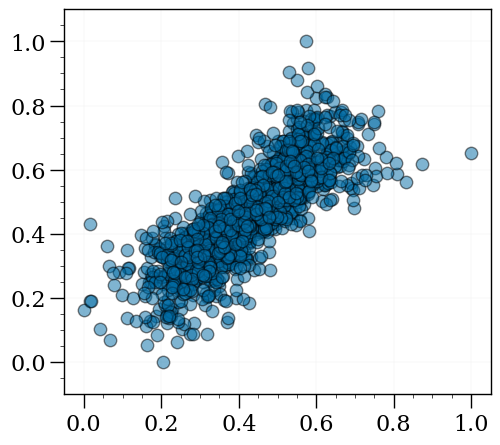

In [63]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [64]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [65]:
run(TrainingTensors, train_D, test_D, key, 'frank_10')

  0%|          | 1/5000 [05:41<474:07:03, 341.43s/it]

Iter 0. Loss [[0.16898654 0.22372414 2.8006701 ]]


  0%|          | 12/5000 [11:01<6:54:33,  4.99s/it]

Iter 10. Loss [[0.16869797 0.22283609 2.7582617 ]]


  0%|          | 22/5000 [11:03<27:47,  2.99it/s]

Iter 20. Loss [[0.1681974  0.22170065 2.7186716 ]]


  1%|          | 31/5000 [11:08<44:58,  1.84it/s]

Iter 30. Loss [[0.16761328 0.22046736 2.6808088 ]]


  1%|          | 42/5000 [11:10<17:25,  4.74it/s]

Iter 40. Loss [[0.1669991  0.21919774 2.6442688 ]]


  1%|          | 51/5000 [11:12<16:43,  4.93it/s]

Iter 50. Loss [[0.16636857 0.21790485 2.6088235 ]]


  1%|          | 61/5000 [11:14<16:53,  4.87it/s]

Iter 60. Loss [[0.16572516 0.21658926 2.574301  ]]


  1%|▏         | 71/5000 [11:17<29:10,  2.82it/s]

Iter 70. Loss [[0.16506942 0.21524811 2.5405717 ]]


  2%|▏         | 81/5000 [11:20<27:30,  2.98it/s]

Iter 80. Loss [[0.16440281 0.21387976 2.5075347 ]]


  2%|▏         | 92/5000 [11:23<17:37,  4.64it/s]

Iter 90. Loss [[0.16372845 0.21248494 2.4751096 ]]


  2%|▏         | 102/5000 [11:25<16:41,  4.89it/s]

Iter 100. Loss [[0.16305073 0.21106637 2.443235  ]]


  2%|▏         | 111/5000 [11:29<20:17,  4.02it/s]

Iter 110. Loss [[0.16237426 0.20962743 2.4118643 ]]


  2%|▏         | 121/5000 [11:31<17:24,  4.67it/s]

Iter 120. Loss [[0.16170333 0.20817155 2.3809657 ]]


  3%|▎         | 131/5000 [11:33<25:48,  3.14it/s]

Iter 130. Loss [[0.16104165 0.20670182 2.3505173 ]]


  3%|▎         | 141/5000 [11:37<21:46,  3.72it/s]

Iter 140. Loss [[0.16039239 0.20522094 2.3205044 ]]


  3%|▎         | 151/5000 [11:40<18:35,  4.35it/s]

Iter 150. Loss [[0.15975836 0.20373125 2.2909153 ]]


  3%|▎         | 161/5000 [11:42<16:52,  4.78it/s]

Iter 160. Loss [[0.15914191 0.20223494 2.2617414 ]]


  3%|▎         | 171/5000 [11:44<16:44,  4.81it/s]

Iter 170. Loss [[0.15854526 0.20073389 2.232975  ]]


  4%|▎         | 181/5000 [11:48<51:04,  1.57it/s]  

Iter 180. Loss [[0.15797023 0.19922985 2.2046087 ]]


  4%|▍         | 191/5000 [11:51<19:18,  4.15it/s]

Iter 190. Loss [[0.15741847 0.19772436 2.176636  ]]


  4%|▍         | 201/5000 [11:53<16:38,  4.81it/s]

Iter 200. Loss [[0.15689148 0.19621879 2.149049  ]]


  4%|▍         | 211/5000 [11:55<16:50,  4.74it/s]

Iter 210. Loss [[0.1563905  0.19471446 2.1218412 ]]


  4%|▍         | 221/5000 [11:59<28:51,  2.76it/s]

Iter 220. Loss [[0.15591675 0.19321246 2.0950048 ]]


  5%|▍         | 231/5000 [12:01<24:41,  3.22it/s]

Iter 230. Loss [[0.15547118 0.19171384 2.0685322 ]]


  5%|▍         | 241/5000 [12:05<24:15,  3.27it/s]

Iter 240. Loss [[0.15505464 0.19021963 2.0424156 ]]


  5%|▌         | 251/5000 [12:07<16:59,  4.66it/s]

Iter 250. Loss [[0.15466796 0.18873061 2.0166454 ]]


  5%|▌         | 261/5000 [12:10<22:54,  3.45it/s]

Iter 260. Loss [[0.15431178 0.18724763 1.9912142 ]]


  5%|▌         | 271/5000 [12:12<16:51,  4.68it/s]

Iter 270. Loss [[0.15398674 0.18577148 1.9661126 ]]


  6%|▌         | 281/5000 [12:14<17:50,  4.41it/s]

Iter 280. Loss [[0.1536933  0.18430275 1.9413314 ]]


  6%|▌         | 291/5000 [12:18<26:49,  2.93it/s]

Iter 290. Loss [[0.15343195 0.1828421  1.9168603 ]]


  6%|▌         | 301/5000 [12:22<18:59,  4.12it/s]

Iter 300. Loss [[0.15320297 0.18139005 1.8926908 ]]


  6%|▌         | 311/5000 [12:24<16:35,  4.71it/s]

Iter 310. Loss [[0.1530067  0.17994708 1.8688122 ]]


  6%|▋         | 322/5000 [12:26<16:10,  4.82it/s]

Iter 320. Loss [[0.15284336 0.17851365 1.8452154 ]]


  7%|▋         | 331/5000 [12:30<58:24,  1.33it/s]

Iter 330. Loss [[0.15271313 0.17709017 1.8218902 ]]


  7%|▋         | 341/5000 [12:33<26:52,  2.89it/s]

Iter 340. Loss [[0.15261617 0.17567691 1.7988274 ]]


  7%|▋         | 351/5000 [12:35<17:04,  4.54it/s]

Iter 350. Loss [[0.15255256 0.17427425 1.7760172 ]]


  7%|▋         | 361/5000 [12:37<16:42,  4.63it/s]

Iter 360. Loss [[0.15252231 0.17288242 1.7534493 ]]


  7%|▋         | 371/5000 [12:41<28:41,  2.69it/s]

Iter 370. Loss [[0.15252542 0.1715016  1.7311152 ]]


  8%|▊         | 381/5000 [12:43<17:52,  4.31it/s]

Iter 380. Loss [[0.15256187 0.17013201 1.7090055 ]]


  8%|▊         | 391/5000 [12:47<25:47,  2.98it/s]

Iter 390. Loss [[0.15263166 0.16877382 1.6871116 ]]


  8%|▊         | 401/5000 [12:49<17:20,  4.42it/s]

Iter 400. Loss [[0.15273464 0.16742711 1.6654248 ]]


  8%|▊         | 411/5000 [12:53<20:37,  3.71it/s]

Iter 410. Loss [[0.15287073 0.166092   1.6439369 ]]


  8%|▊         | 421/5000 [12:55<16:21,  4.67it/s]

Iter 420. Loss [[0.15303975 0.16476855 1.6226397 ]]


  9%|▊         | 431/5000 [12:57<15:50,  4.81it/s]

Iter 430. Loss [[0.15324163 0.16345684 1.6015254 ]]


  9%|▉         | 441/5000 [13:00<25:10,  3.02it/s]

Iter 440. Loss [[0.15347609 0.1621569  1.5805882 ]]


  9%|▉         | 452/5000 [13:04<16:57,  4.47it/s]

Iter 450. Loss [[0.15374298 0.16086875 1.5598208 ]]


  9%|▉         | 462/5000 [13:06<15:30,  4.88it/s]

Iter 460. Loss [[0.15404217 0.1595924  1.5392162 ]]


  9%|▉         | 471/5000 [13:08<15:52,  4.76it/s]

Iter 470. Loss [[0.1543733  0.15832786 1.5187689 ]]


 10%|▉         | 482/5000 [13:12<26:23,  2.85it/s]

Iter 480. Loss [[0.15473615 0.15707514 1.4984736 ]]


 10%|▉         | 491/5000 [13:14<24:53,  3.02it/s]

Iter 490. Loss [[0.15513045 0.1558342  1.478325  ]]


 10%|█         | 501/5000 [13:17<16:54,  4.43it/s]

Iter 500. Loss [[0.15555601 0.15460503 1.4583187 ]]


 10%|█         | 511/5000 [13:19<15:45,  4.75it/s]

Iter 510. Loss [[0.15601236 0.15338764 1.4384503 ]]


 10%|█         | 522/5000 [13:23<19:00,  3.93it/s]

Iter 520. Loss [[0.15649927 0.15218198 1.4187167 ]]


 11%|█         | 532/5000 [13:25<15:26,  4.82it/s]

Iter 530. Loss [[0.15701637 0.15098807 1.3991135 ]]


 11%|█         | 541/5000 [13:27<23:16,  3.19it/s]

Iter 540. Loss [[0.15756328 0.14980586 1.3796386 ]]


 11%|█         | 551/5000 [13:31<21:49,  3.40it/s]

Iter 550. Loss [[0.15813959 0.14863536 1.3602887 ]]


 11%|█         | 561/5000 [13:34<18:39,  3.97it/s]

Iter 560. Loss [[0.15874481 0.14747658 1.3410628 ]]


 11%|█▏        | 571/5000 [13:36<15:19,  4.82it/s]

Iter 570. Loss [[0.1593785 0.1463295 1.3219584]]


 12%|█▏        | 581/5000 [13:38<15:10,  4.86it/s]

Iter 580. Loss [[0.16004014 0.14519419 1.302975  ]]


 12%|█▏        | 591/5000 [13:42<46:49,  1.57it/s]

Iter 590. Loss [[0.16072914 0.14407061 1.2841115 ]]


 12%|█▏        | 602/5000 [13:45<17:11,  4.26it/s]

Iter 600. Loss [[0.1614449  0.14295883 1.2653679 ]]


 12%|█▏        | 611/5000 [13:47<15:42,  4.66it/s]

Iter 610. Loss [[0.16218662 0.14185895 1.2467438 ]]


 12%|█▏        | 621/5000 [13:49<16:09,  4.52it/s]

Iter 620. Loss [[0.16295353 0.140771   1.2282403 ]]


 13%|█▎        | 631/5000 [13:53<23:37,  3.08it/s]

Iter 630. Loss [[0.16374478 0.13969512 1.2098584 ]]


 13%|█▎        | 641/5000 [13:56<22:42,  3.20it/s]

Iter 640. Loss [[0.16455913 0.13863146 1.1916004 ]]


 13%|█▎        | 651/5000 [13:59<21:43,  3.34it/s]

Iter 650. Loss [[0.16539544 0.13758028 1.1734687 ]]


 13%|█▎        | 661/5000 [14:01<15:35,  4.64it/s]

Iter 660. Loss [[0.16625209 0.13654181 1.1554667 ]]


 13%|█▎        | 671/5000 [14:05<19:12,  3.76it/s]

Iter 670. Loss [[0.16712707 0.13551652 1.1375995 ]]


 14%|█▎        | 681/5000 [14:07<15:24,  4.67it/s]

Iter 680. Loss [[0.16801776 0.13450502 1.1198732 ]]


 14%|█▍        | 691/5000 [14:09<16:57,  4.23it/s]

Iter 690. Loss [[0.1689204  0.13350819 1.102296  ]]


 14%|█▍        | 701/5000 [14:12<24:07,  2.97it/s]

Iter 700. Loss [[0.16982952 0.13252756 1.0848805 ]]


 14%|█▍        | 712/5000 [14:16<16:15,  4.40it/s]

Iter 710. Loss [[0.17073628 0.13156562 1.067643  ]]


 14%|█▍        | 722/5000 [14:18<14:32,  4.91it/s]

Iter 720. Loss [[0.1716252  0.13062705 1.0506095 ]]


 15%|█▍        | 731/5000 [14:20<14:55,  4.77it/s]

Iter 730. Loss [[0.1724664 0.1297213 1.0338162]]


 15%|█▍        | 741/5000 [14:24<36:33,  1.94it/s]

Iter 740. Loss [[0.17320034 0.12886849 1.0173006 ]]


 15%|█▌        | 751/5000 [14:27<24:44,  2.86it/s]

Iter 750. Loss [[0.17373969 0.12810186 1.0010421 ]]


 15%|█▌        | 761/5000 [14:29<15:48,  4.47it/s]

Iter 760. Loss [[0.17409831 0.12742494 0.9851108 ]]


 15%|█▌        | 772/5000 [14:32<14:37,  4.82it/s]

Iter 770. Loss [[0.17441465 0.12679063 0.96981454]]


 16%|█▌        | 781/5000 [14:35<22:13,  3.16it/s]

Iter 780. Loss [[0.17466754 0.12620717 0.95514315]]


 16%|█▌        | 791/5000 [14:37<14:53,  4.71it/s]

Iter 790. Loss [[0.17486912 0.1256701  0.94112426]]


 16%|█▌        | 801/5000 [14:40<23:50,  2.94it/s]

Iter 800. Loss [[0.17503068 0.12517515 0.92778313]]


 16%|█▌        | 811/5000 [14:43<15:44,  4.43it/s]

Iter 810. Loss [[0.17515877 0.12471977 0.91513425]]


 16%|█▋        | 821/5000 [14:47<18:02,  3.86it/s]

Iter 820. Loss [[0.17525306 0.12430459 0.903173  ]]


 17%|█▋        | 831/5000 [14:49<14:28,  4.80it/s]

Iter 830. Loss [[0.1753197  0.12392662 0.8919045 ]]


 17%|█▋        | 841/5000 [14:51<14:16,  4.86it/s]

Iter 840. Loss [[0.17536302 0.12358353 0.8813198 ]]


 17%|█▋        | 851/5000 [14:53<21:29,  3.22it/s]

Iter 850. Loss [[0.17538722 0.12327248 0.8714012 ]]


 17%|█▋        | 861/5000 [14:57<16:51,  4.09it/s]

Iter 860. Loss [[0.17539738 0.12298996 0.8621247 ]]


 17%|█▋        | 872/5000 [15:00<14:18,  4.81it/s]

Iter 870. Loss [[0.17539872 0.12273212 0.85345834]]


 18%|█▊        | 881/5000 [15:01<14:05,  4.87it/s]

Iter 880. Loss [[0.17539592 0.12249514 0.84536797]]


 18%|█▊        | 891/5000 [15:05<34:47,  1.97it/s]

Iter 890. Loss [[0.17539275 0.12227552 0.8378125 ]]


 18%|█▊        | 901/5000 [15:08<22:46,  3.00it/s]

Iter 900. Loss [[0.17539234 0.12207021 0.83074886]]


 18%|█▊        | 911/5000 [15:11<16:53,  4.03it/s]

Iter 910. Loss [[0.17539667 0.12187662 0.82413703]]


 18%|█▊        | 922/5000 [15:13<13:47,  4.93it/s]

Iter 920. Loss [[0.17540732 0.12169258 0.81793684]]


 19%|█▊        | 932/5000 [15:16<20:44,  3.27it/s]

Iter 930. Loss [[0.17542489 0.12151646 0.8121116 ]]


 19%|█▉        | 941/5000 [15:18<14:08,  4.79it/s]

Iter 940. Loss [[0.17544983 0.12134692 0.8066289 ]]


 19%|█▉        | 951/5000 [15:20<16:55,  3.99it/s]

Iter 950. Loss [[0.17548172 0.12118322 0.8014607 ]]


 19%|█▉        | 961/5000 [15:24<23:00,  2.93it/s]

Iter 960. Loss [[0.17552055 0.1210245  0.79658127]]


 19%|█▉        | 972/5000 [15:28<16:23,  4.09it/s]

Iter 970. Loss [[0.17556562 0.12087046 0.7919686 ]]


 20%|█▉        | 981/5000 [15:30<14:20,  4.67it/s]

Iter 980. Loss [[0.1756162 0.1207208 0.7876048]]


 20%|█▉        | 991/5000 [15:32<13:37,  4.91it/s]

Iter 990. Loss [[0.17567171 0.12057535 0.78347343]]


 20%|██        | 1001/5000 [15:34<13:49,  4.82it/s]

Iter 1000. Loss [[0.17573166 0.12043396 0.77956194]]


 20%|██        | 1011/5000 [15:38<23:05,  2.88it/s]

Iter 1010. Loss [[0.1757956  0.12029645 0.7758597 ]]


 20%|██        | 1022/5000 [15:41<13:48,  4.80it/s]

Iter 1020. Loss [[0.17586297 0.12016284 0.77235544]]


 21%|██        | 1031/5000 [15:43<13:34,  4.87it/s]

Iter 1030. Loss [[0.17593347 0.12003298 0.76904196]]


 21%|██        | 1041/5000 [15:46<33:40,  1.96it/s]

Iter 1040. Loss [[0.17600699 0.11990672 0.7659106 ]]


 21%|██        | 1051/5000 [15:48<14:25,  4.56it/s]

Iter 1050. Loss [[0.17608353 0.11978377 0.7629587 ]]


 21%|██        | 1061/5000 [15:51<21:25,  3.06it/s]

Iter 1060. Loss [[0.17616302 0.11966408 0.760178  ]]


 21%|██▏       | 1071/5000 [15:54<15:55,  4.11it/s]

Iter 1070. Loss [[0.17624551 0.11954744 0.7575631 ]]


 22%|██▏       | 1082/5000 [15:58<18:01,  3.62it/s]

Iter 1080. Loss [[0.17633158 0.11943342 0.7551114 ]]


 22%|██▏       | 1091/5000 [15:59<13:54,  4.68it/s]

Iter 1090. Loss [[0.17642123 0.11932192 0.75281817]]


 22%|██▏       | 1102/5000 [16:02<13:17,  4.89it/s]

Iter 1100. Loss [[0.17651542 0.11921234 0.7506804 ]]


 22%|██▏       | 1111/5000 [16:04<18:13,  3.56it/s]

Iter 1110. Loss [[0.17661496 0.11910418 0.74869555]]


 22%|██▏       | 1121/5000 [16:08<18:38,  3.47it/s]

Iter 1120. Loss [[0.17672001 0.11899743 0.74685675]]


 23%|██▎       | 1131/5000 [16:10<13:33,  4.76it/s]

Iter 1130. Loss [[0.17683165 0.11889144 0.74516064]]


 23%|██▎       | 1141/5000 [16:12<13:58,  4.60it/s]

Iter 1140. Loss [[0.1769503  0.11878595 0.74359995]]


 23%|██▎       | 1152/5000 [16:16<32:21,  1.98it/s]

Iter 1150. Loss [[0.17707603 0.11868097 0.7421666 ]]


 23%|██▎       | 1161/5000 [16:18<20:29,  3.12it/s]

Iter 1160. Loss [[0.17720821 0.11857653 0.7408483 ]]


 23%|██▎       | 1171/5000 [16:22<18:44,  3.40it/s]

Iter 1170. Loss [[0.17734565 0.11847312 0.7396343 ]]


 24%|██▎       | 1181/5000 [16:24<13:13,  4.81it/s]

Iter 1180. Loss [[0.17748562 0.11837171 0.73850876]]


 24%|██▍       | 1192/5000 [16:27<26:00,  2.44it/s]

Iter 1190. Loss [[0.17762618 0.11827286 0.73746103]]


 24%|██▍       | 1202/5000 [16:29<13:29,  4.69it/s]

Iter 1200. Loss [[0.1777652  0.11817723 0.73647964]]


 24%|██▍       | 1212/5000 [16:31<12:57,  4.87it/s]

Iter 1210. Loss [[0.17790128 0.11808515 0.73555714]]


 24%|██▍       | 1221/5000 [16:34<20:56,  3.01it/s]

Iter 1220. Loss [[0.17803341 0.11799686 0.7346883 ]]


 25%|██▍       | 1232/5000 [16:39<18:04,  3.48it/s]

Iter 1230. Loss [[0.1781609  0.11791252 0.7338669 ]]


 25%|██▍       | 1241/5000 [16:41<13:20,  4.70it/s]

Iter 1240. Loss [[0.1782838  0.11783193 0.73308897]]


 25%|██▌       | 1252/5000 [16:43<12:41,  4.92it/s]

Iter 1250. Loss [[0.1784024  0.11775476 0.7323533 ]]


 25%|██▌       | 1261/5000 [16:45<12:53,  4.83it/s]

Iter 1260. Loss [[0.17851618 0.11768124 0.73165476]]


 25%|██▌       | 1271/5000 [16:49<25:09,  2.47it/s]

Iter 1270. Loss [[0.17862539 0.11761113 0.7309935 ]]


 26%|██▌       | 1282/5000 [16:52<13:14,  4.68it/s]

Iter 1280. Loss [[0.1787301  0.11754423 0.7303654 ]]


 26%|██▌       | 1292/5000 [16:54<12:42,  4.86it/s]

Iter 1290. Loss [[0.17883055 0.11748046 0.7297689 ]]


 26%|██▌       | 1302/5000 [16:56<12:34,  4.90it/s]

Iter 1300. Loss [[0.17892669 0.11741967 0.7292026 ]]


 26%|██▌       | 1312/5000 [16:59<14:01,  4.38it/s]

Iter 1310. Loss [[0.17901891 0.11736166 0.72866446]]


 26%|██▋       | 1321/5000 [17:02<19:55,  3.08it/s]

Iter 1320. Loss [[0.17910737 0.11730629 0.72815496]]


 27%|██▋       | 1331/5000 [17:05<15:58,  3.83it/s]

Iter 1330. Loss [[0.17919147 0.11725377 0.72766876]]


 27%|██▋       | 1341/5000 [17:09<41:18,  1.48it/s]

Iter 1340. Loss [[0.17927213 0.11720363 0.7272083 ]]


 27%|██▋       | 1351/5000 [17:11<15:30,  3.92it/s]

Iter 1350. Loss [[0.17934923 0.11715589 0.72677064]]


 27%|██▋       | 1361/5000 [17:14<17:00,  3.57it/s]

Iter 1360. Loss [[0.17942287 0.11711045 0.7263543 ]]


 27%|██▋       | 1371/5000 [17:17<18:49,  3.21it/s]

Iter 1370. Loss [[0.17949337 0.11706707 0.72595936]]


 28%|██▊       | 1381/5000 [17:21<25:00,  2.41it/s]

Iter 1380. Loss [[0.17956048 0.11702587 0.7255833 ]]


 28%|██▊       | 1391/5000 [17:23<12:54,  4.66it/s]

Iter 1390. Loss [[0.17962456 0.11698667 0.7252262 ]]


 28%|██▊       | 1401/5000 [17:25<12:16,  4.89it/s]

Iter 1400. Loss [[0.17968582 0.1169493  0.72488695]]


 28%|██▊       | 1411/5000 [17:27<12:10,  4.91it/s]

Iter 1410. Loss [[0.1797443 0.1169137 0.7245642]]


 28%|██▊       | 1421/5000 [17:32<22:33,  2.64it/s]

Iter 1420. Loss [[0.17980014 0.11687982 0.72425807]]


 29%|██▊       | 1431/5000 [17:34<13:34,  4.38it/s]

Iter 1430. Loss [[0.17985319 0.11684769 0.7239665 ]]


 29%|██▉       | 1441/5000 [17:37<12:23,  4.79it/s]

Iter 1440. Loss [[0.17990392 0.11681703 0.7236896 ]]


 29%|██▉       | 1451/5000 [17:39<12:19,  4.80it/s]

Iter 1450. Loss [[0.17995244 0.11678778 0.7234277 ]]


 29%|██▉       | 1462/5000 [17:42<12:39,  4.66it/s]

Iter 1460. Loss [[0.17999855 0.11676005 0.7231769 ]]


 29%|██▉       | 1471/5000 [17:44<17:39,  3.33it/s]

Iter 1470. Loss [[0.18004242 0.11673369 0.72293943]]


 30%|██▉       | 1482/5000 [17:48<17:04,  3.43it/s]

Iter 1480. Loss [[0.18008426 0.11670861 0.722713  ]]


 30%|██▉       | 1492/5000 [17:52<24:41,  2.37it/s]

Iter 1490. Loss [[0.1801243  0.11668466 0.722499  ]]


 30%|███       | 1501/5000 [17:53<12:41,  4.59it/s]

Iter 1500. Loss [[0.18016239 0.11666188 0.72229564]]


 30%|███       | 1511/5000 [17:55<12:05,  4.81it/s]

Iter 1510. Loss [[0.18019852 0.11664034 0.7221009 ]]


 30%|███       | 1521/5000 [17:58<12:06,  4.79it/s]

Iter 1520. Loss [[0.18023309 0.11661975 0.72191674]]


 31%|███       | 1532/5000 [18:02<19:27,  2.97it/s]

Iter 1530. Loss [[0.18026605 0.11660016 0.7217426 ]]


 31%|███       | 1541/5000 [18:04<12:12,  4.72it/s]

Iter 1540. Loss [[0.1802973  0.11658163 0.72157663]]


 31%|███       | 1551/5000 [18:06<11:57,  4.81it/s]

Iter 1550. Loss [[0.18032718 0.1165639  0.7214187 ]]


 31%|███       | 1562/5000 [18:09<11:42,  4.89it/s]

Iter 1560. Loss [[0.18035538 0.11654717 0.72126806]]


 31%|███▏      | 1571/5000 [18:12<14:42,  3.88it/s]

Iter 1570. Loss [[0.18038242 0.11653117 0.72112644]]


 32%|███▏      | 1581/5000 [18:15<19:14,  2.96it/s]

Iter 1580. Loss [[0.1804082  0.11651595 0.7209905 ]]


 32%|███▏      | 1591/5000 [18:18<12:26,  4.56it/s]

Iter 1590. Loss [[0.18043266 0.11650153 0.7208614 ]]


 32%|███▏      | 1601/5000 [18:20<11:45,  4.82it/s]

Iter 1600. Loss [[0.18045595 0.11648779 0.7207395 ]]


 32%|███▏      | 1611/5000 [18:23<13:22,  4.22it/s]

Iter 1610. Loss [[0.18047816 0.11647475 0.7206238 ]]


 32%|███▏      | 1621/5000 [18:25<11:43,  4.80it/s]

Iter 1620. Loss [[0.18049924 0.11646231 0.7205129 ]]


 33%|███▎      | 1631/5000 [18:28<18:05,  3.10it/s]

Iter 1630. Loss [[0.18051921 0.11645058 0.7204086 ]]


 33%|███▎      | 1642/5000 [18:33<24:51,  2.25it/s]

Iter 1640. Loss [[0.18053858 0.11643925 0.7203098 ]]


 33%|███▎      | 1652/5000 [18:35<11:49,  4.72it/s]

Iter 1650. Loss [[0.18055658 0.11642868 0.7202145 ]]


 33%|███▎      | 1661/5000 [18:37<11:30,  4.83it/s]

Iter 1660. Loss [[0.1805739  0.11641854 0.7201247 ]]


 33%|███▎      | 1672/5000 [18:39<11:19,  4.90it/s]

Iter 1670. Loss [[0.18059044 0.11640888 0.72004   ]]


 34%|███▎      | 1681/5000 [18:43<29:13,  1.89it/s]

Iter 1680. Loss [[0.18060568 0.11639992 0.71995956]]


 34%|███▍      | 1692/5000 [18:46<12:31,  4.40it/s]

Iter 1690. Loss [[0.18062076 0.11639114 0.71988267]]


 34%|███▍      | 1702/5000 [18:48<11:14,  4.89it/s]

Iter 1700. Loss [[0.18063492 0.11638287 0.7198107 ]]


 34%|███▍      | 1711/5000 [18:49<11:20,  4.83it/s]

Iter 1710. Loss [[0.1806481  0.11637519 0.7197407 ]]


 34%|███▍      | 1721/5000 [18:53<15:27,  3.54it/s]

Iter 1720. Loss [[0.18066107 0.11636762 0.7196761 ]]


 35%|███▍      | 1731/5000 [18:55<15:21,  3.55it/s]

Iter 1730. Loss [[0.18067312 0.11636063 0.71961325]]


 35%|███▍      | 1741/5000 [18:59<18:31,  2.93it/s]

Iter 1740. Loss [[0.18068476 0.11635384 0.7195546 ]]


 35%|███▌      | 1752/5000 [19:01<11:18,  4.79it/s]

Iter 1750. Loss [[0.1806955  0.11634757 0.719498  ]]


 35%|███▌      | 1761/5000 [19:04<13:06,  4.12it/s]

Iter 1760. Loss [[0.18070604 0.1163415  0.71944594]]


 35%|███▌      | 1772/5000 [19:07<10:59,  4.89it/s]

Iter 1770. Loss [[0.18071595 0.11633574 0.7193955 ]]


 36%|███▌      | 1781/5000 [19:08<11:13,  4.78it/s]

Iter 1780. Loss [[0.18072513 0.11633039 0.71934664]]


 36%|███▌      | 1791/5000 [19:13<45:13,  1.18it/s]

Iter 1790. Loss [[0.18073413 0.11632521 0.719302  ]]


 36%|███▌      | 1801/5000 [19:15<11:53,  4.49it/s]

Iter 1800. Loss [[0.18074256 0.11632031 0.7192591 ]]


 36%|███▌      | 1811/5000 [19:17<10:55,  4.87it/s]

Iter 1810. Loss [[0.18075058 0.11631567 0.71921855]]


 36%|███▋      | 1821/5000 [19:19<10:56,  4.84it/s]

Iter 1820. Loss [[0.18075822 0.11631127 0.71918   ]]


 37%|███▋      | 1832/5000 [19:23<21:43,  2.43it/s]

Iter 1830. Loss [[0.18076545 0.11630711 0.7191437 ]]


 37%|███▋      | 1841/5000 [19:26<17:47,  2.96it/s]

Iter 1840. Loss [[0.1807724 0.1163031 0.7191092]]


 37%|███▋      | 1851/5000 [19:29<11:35,  4.53it/s]

Iter 1850. Loss [[0.18077898 0.11629932 0.71907586]]


 37%|███▋      | 1861/5000 [19:31<10:47,  4.85it/s]

Iter 1860. Loss [[0.18078494 0.11629581 0.7190447 ]]


 37%|███▋      | 1871/5000 [19:34<16:09,  3.23it/s]

Iter 1870. Loss [[0.18079108 0.11629233 0.7190155 ]]


 38%|███▊      | 1881/5000 [19:36<10:51,  4.79it/s]

Iter 1880. Loss [[0.18079646 0.11628922 0.7189871 ]]


 38%|███▊      | 1891/5000 [19:39<15:47,  3.28it/s]

Iter 1890. Loss [[0.18080191 0.11628609 0.7189616 ]]


 38%|███▊      | 1901/5000 [19:42<15:42,  3.29it/s]

Iter 1900. Loss [[0.1808068  0.11628328 0.718936  ]]


 38%|███▊      | 1911/5000 [19:45<14:28,  3.56it/s]

Iter 1910. Loss [[0.18081163 0.11628053 0.7189129 ]]


 38%|███▊      | 1921/5000 [19:47<10:40,  4.81it/s]

Iter 1920. Loss [[0.18081598 0.11627802 0.7188903 ]]


 39%|███▊      | 1931/5000 [19:49<10:46,  4.75it/s]

Iter 1930. Loss [[0.18082042 0.11627547 0.7188696 ]]


 39%|███▉      | 1941/5000 [19:52<10:46,  4.73it/s]

Iter 1940. Loss [[0.18082447 0.11627317 0.71884996]]


 39%|███▉      | 1951/5000 [19:56<14:47,  3.44it/s]

Iter 1950. Loss [[0.18082814 0.11627106 0.7188304 ]]


 39%|███▉      | 1962/5000 [19:59<10:27,  4.84it/s]

Iter 1960. Loss [[0.1808318  0.11626896 0.71881217]]


 39%|███▉      | 1971/5000 [20:00<10:26,  4.84it/s]

Iter 1970. Loss [[0.18083516 0.11626705 0.7187954 ]]


 40%|███▉      | 1981/5000 [20:04<32:16,  1.56it/s]

Iter 1980. Loss [[0.18083872 0.11626502 0.7187798 ]]


 40%|███▉      | 1991/5000 [20:06<12:10,  4.12it/s]

Iter 1990. Loss [[0.18084162 0.11626334 0.7187648 ]]


 40%|████      | 2001/5000 [20:09<16:57,  2.95it/s]

Iter 2000. Loss [[0.18084474 0.11626161 0.7187498 ]]


 40%|████      | 2012/5000 [20:12<10:24,  4.79it/s]

Iter 2010. Loss [[0.18084736 0.11626009 0.7187362 ]]


 40%|████      | 2021/5000 [20:15<20:37,  2.41it/s]

Iter 2020. Loss [[0.18084995 0.11625864 0.7187233 ]]


 41%|████      | 2031/5000 [20:17<10:26,  4.74it/s]

Iter 2030. Loss [[0.18085243 0.11625721 0.71871233]]


 41%|████      | 2041/5000 [20:19<10:14,  4.82it/s]

Iter 2040. Loss [[0.1808549  0.11625583 0.71870065]]


 41%|████      | 2051/5000 [20:22<15:37,  3.15it/s]

Iter 2050. Loss [[0.18085703 0.11625462 0.7186899 ]]


 41%|████      | 2061/5000 [20:26<17:10,  2.85it/s]

Iter 2060. Loss [[0.1808591  0.11625345 0.71867967]]


 41%|████▏     | 2071/5000 [20:29<10:20,  4.72it/s]

Iter 2070. Loss [[0.18086128 0.11625223 0.7186707 ]]


 42%|████▏     | 2081/5000 [20:31<10:05,  4.82it/s]

Iter 2080. Loss [[0.18086301 0.11625124 0.71866107]]


 42%|████▏     | 2091/5000 [20:33<09:58,  4.86it/s]

Iter 2090. Loss [[0.18086492 0.11625018 0.71865267]]


 42%|████▏     | 2101/5000 [20:37<18:28,  2.62it/s]

Iter 2100. Loss [[0.18086639 0.11624935 0.7186445 ]]


 42%|████▏     | 2111/5000 [20:40<11:14,  4.29it/s]

Iter 2110. Loss [[0.1808683  0.11624825 0.7186382 ]]


 42%|████▏     | 2122/5000 [20:42<09:57,  4.82it/s]

Iter 2120. Loss [[0.18086953 0.11624756 0.7186302 ]]


 43%|████▎     | 2132/5000 [20:44<09:44,  4.90it/s]

Iter 2130. Loss [[0.18087108 0.1162467  0.71862435]]


 43%|████▎     | 2142/5000 [20:48<10:38,  4.48it/s]

Iter 2140. Loss [[0.18087246 0.11624594 0.718618  ]]


 43%|████▎     | 2151/5000 [20:50<13:20,  3.56it/s]

Iter 2150. Loss [[0.18087383 0.11624522 0.71861166]]


 43%|████▎     | 2161/5000 [20:53<16:02,  2.95it/s]

Iter 2160. Loss [[0.18087482 0.11624463 0.7186062 ]]


 43%|████▎     | 2171/5000 [20:57<30:19,  1.55it/s]

Iter 2170. Loss [[0.18087614 0.1162439  0.7186016 ]]


 44%|████▎     | 2181/5000 [20:59<10:20,  4.54it/s]

Iter 2180. Loss [[0.18087688 0.11624347 0.71859616]]


 44%|████▍     | 2192/5000 [21:01<09:45,  4.79it/s]

Iter 2190. Loss [[0.1808783  0.11624268 0.7185921 ]]


 44%|████▍     | 2202/5000 [21:03<09:39,  4.83it/s]

Iter 2200. Loss [[0.18087894 0.11624235 0.71858716]]


 44%|████▍     | 2211/5000 [21:07<22:25,  2.07it/s]

Iter 2210. Loss [[0.18088004 0.11624175 0.7185838 ]]


 44%|████▍     | 2222/5000 [21:10<09:44,  4.75it/s]

Iter 2220. Loss [[0.18088102 0.11624123 0.71858025]]


 45%|████▍     | 2231/5000 [21:12<09:24,  4.90it/s]

Iter 2230. Loss [[0.18088165 0.11624084 0.71857566]]


 45%|████▍     | 2242/5000 [21:14<09:27,  4.86it/s]

Iter 2240. Loss [[0.18088226 0.11624052 0.71857226]]


 45%|████▌     | 2251/5000 [21:17<11:56,  3.84it/s]

Iter 2250. Loss [[0.18088317 0.11624005 0.7185694 ]]


 45%|████▌     | 2261/5000 [21:20<15:22,  2.97it/s]

Iter 2260. Loss [[0.18088375 0.1162397  0.7185663 ]]


 45%|████▌     | 2271/5000 [21:23<10:15,  4.44it/s]

Iter 2270. Loss [[0.18088448 0.11623932 0.718564  ]]


 46%|████▌     | 2281/5000 [21:25<09:26,  4.80it/s]

Iter 2280. Loss [[0.180885   0.11623903 0.71856153]]


 46%|████▌     | 2291/5000 [21:28<10:58,  4.11it/s]

Iter 2290. Loss [[0.18088554 0.11623874 0.7185591 ]]


 46%|████▌     | 2302/5000 [21:31<09:14,  4.86it/s]

Iter 2300. Loss [[0.18088622 0.11623837 0.7185568 ]]


 46%|████▌     | 2311/5000 [21:33<13:38,  3.28it/s]

Iter 2310. Loss [[0.18088672 0.11623812 0.71855485]]


 46%|████▋     | 2321/5000 [21:38<33:06,  1.35it/s]

Iter 2320. Loss [[0.18088704 0.11623793 0.71855205]]


 47%|████▋     | 2331/5000 [21:40<10:02,  4.43it/s]

Iter 2330. Loss [[0.18088752 0.11623767 0.71855044]]


 47%|████▋     | 2342/5000 [21:42<09:06,  4.86it/s]

Iter 2340. Loss [[0.18088806 0.11623736 0.71854955]]


 47%|████▋     | 2351/5000 [21:44<09:03,  4.87it/s]

Iter 2350. Loss [[0.18088837 0.1162372  0.71854717]]


 47%|████▋     | 2361/5000 [21:48<22:55,  1.92it/s]

Iter 2360. Loss [[0.1808884  0.11623719 0.7185449 ]]


 47%|████▋     | 2372/5000 [21:51<10:46,  4.06it/s]

Iter 2370. Loss [[0.18088894 0.11623691 0.7185442 ]]


 48%|████▊     | 2382/5000 [21:53<08:59,  4.85it/s]

Iter 2380. Loss [[0.18088952 0.11623659 0.7185437 ]]


 48%|████▊     | 2391/5000 [21:55<09:01,  4.82it/s]

Iter 2390. Loss [[0.18088958 0.11623657 0.7185418 ]]


 48%|████▊     | 2401/5000 [21:58<12:14,  3.54it/s]

Iter 2400. Loss [[0.18088983 0.11623645 0.71854   ]]


 48%|████▊     | 2411/5000 [22:01<11:00,  3.92it/s]

Iter 2410. Loss [[0.18089043 0.11623611 0.71854043]]


 48%|████▊     | 2421/5000 [22:04<14:36,  2.94it/s]

Iter 2420. Loss [[0.18089043 0.11623611 0.7185391 ]]


 49%|████▊     | 2431/5000 [22:06<09:08,  4.68it/s]

Iter 2430. Loss [[0.18089092 0.11623586 0.7185382 ]]


 49%|████▉     | 2441/5000 [22:10<10:14,  4.17it/s]

Iter 2440. Loss [[0.18089096 0.11623585 0.7185371 ]]


 49%|████▉     | 2452/5000 [22:12<08:46,  4.84it/s]

Iter 2450. Loss [[0.18089108 0.11623578 0.71853596]]


 49%|████▉     | 2462/5000 [22:14<08:40,  4.87it/s]

Iter 2460. Loss [[0.18089126 0.11623567 0.718535  ]]


 49%|████▉     | 2471/5000 [22:19<35:31,  1.19it/s]

Iter 2470. Loss [[0.1808916  0.11623551 0.71853536]]


 50%|████▉     | 2481/5000 [22:21<09:42,  4.32it/s]

Iter 2480. Loss [[0.18089186 0.11623537 0.7185339 ]]


 50%|████▉     | 2492/5000 [22:23<08:36,  4.86it/s]

Iter 2490. Loss [[0.18089189 0.11623535 0.71853334]]


 50%|█████     | 2502/5000 [22:25<08:42,  4.78it/s]

Iter 2500. Loss [[0.18089199 0.11623531 0.7185327 ]]


 50%|█████     | 2511/5000 [22:28<17:09,  2.42it/s]

Iter 2510. Loss [[0.18089242 0.11623508 0.7185332 ]]


 50%|█████     | 2521/5000 [22:31<13:57,  2.96it/s]

Iter 2520. Loss [[0.1808925  0.11623506 0.7185319 ]]


 51%|█████     | 2531/5000 [22:34<09:31,  4.32it/s]

Iter 2530. Loss [[0.18089245 0.11623506 0.71853167]]


 51%|█████     | 2542/5000 [22:36<08:23,  4.88it/s]

Iter 2540. Loss [[0.18089262 0.116235   0.7185317 ]]


 51%|█████     | 2551/5000 [22:40<14:42,  2.78it/s]

Iter 2550. Loss [[0.18089293 0.11623484 0.7185314 ]]


 51%|█████     | 2561/5000 [22:42<08:53,  4.57it/s]

Iter 2560. Loss [[0.18089321 0.1162347  0.7185315 ]]


 51%|█████▏    | 2571/5000 [22:44<11:46,  3.44it/s]

Iter 2570. Loss [[0.18089275 0.11623494 0.7185301 ]]


 52%|█████▏    | 2581/5000 [22:48<13:33,  2.97it/s]

Iter 2580. Loss [[0.18089297 0.11623482 0.7185301 ]]


 52%|█████▏    | 2592/5000 [22:51<09:59,  4.02it/s]

Iter 2590. Loss [[0.18089303 0.11623479 0.71852934]]


 52%|█████▏    | 2601/5000 [22:53<08:28,  4.71it/s]

Iter 2600. Loss [[0.18089317 0.11623472 0.7185297 ]]


 52%|█████▏    | 2612/5000 [22:56<08:11,  4.86it/s]

Iter 2610. Loss [[0.18089351 0.11623458 0.71852976]]


 52%|█████▏    | 2621/5000 [22:57<08:17,  4.78it/s]

Iter 2620. Loss [[0.18089344 0.1162346  0.7185293 ]]


 53%|█████▎    | 2632/5000 [23:02<10:58,  3.59it/s]

Iter 2630. Loss [[0.18089342 0.11623461 0.7185288 ]]


 53%|█████▎    | 2641/5000 [23:04<08:16,  4.76it/s]

Iter 2640. Loss [[0.18089335 0.11623466 0.71852833]]


 53%|█████▎    | 2651/5000 [23:06<08:10,  4.78it/s]

Iter 2650. Loss [[0.18089344 0.11623462 0.7185281 ]]


 53%|█████▎    | 2661/5000 [23:08<08:01,  4.86it/s]

Iter 2660. Loss [[0.18089357 0.11623455 0.71852815]]


 53%|█████▎    | 2671/5000 [23:12<09:21,  4.15it/s]

Iter 2670. Loss [[0.1808937  0.11623449 0.71852845]]


 54%|█████▎    | 2681/5000 [23:15<12:52,  3.00it/s]

Iter 2680. Loss [[0.18089384 0.11623441 0.71852815]]


 54%|█████▍    | 2691/5000 [23:18<08:28,  4.54it/s]

Iter 2690. Loss [[0.18089391 0.11623438 0.71852875]]


 54%|█████▍    | 2702/5000 [23:21<16:07,  2.37it/s]

Iter 2700. Loss [[0.18089382 0.11623444 0.71852815]]


 54%|█████▍    | 2711/5000 [23:23<08:20,  4.57it/s]

Iter 2710. Loss [[0.18089391 0.11623439 0.71852785]]


 54%|█████▍    | 2722/5000 [23:26<07:53,  4.81it/s]

Iter 2720. Loss [[0.180894   0.11623433 0.71852815]]


 55%|█████▍    | 2731/5000 [23:28<12:11,  3.10it/s]

Iter 2730. Loss [[0.18089409 0.11623431 0.7185282 ]]


 55%|█████▍    | 2741/5000 [23:33<14:57,  2.52it/s]

Iter 2740. Loss [[0.18089415 0.11623427 0.718528  ]]


 55%|█████▌    | 2752/5000 [23:35<07:52,  4.75it/s]

Iter 2750. Loss [[0.18089415 0.11623427 0.7185277 ]]


 55%|█████▌    | 2761/5000 [23:37<07:47,  4.79it/s]

Iter 2760. Loss [[0.18089426 0.11623421 0.71852833]]


 55%|█████▌    | 2771/5000 [23:39<07:45,  4.79it/s]

Iter 2770. Loss [[0.18089409 0.11623431 0.71852785]]


 56%|█████▌    | 2781/5000 [23:43<13:57,  2.65it/s]

Iter 2780. Loss [[0.18089418 0.11623425 0.71852744]]


 56%|█████▌    | 2791/5000 [23:46<08:45,  4.21it/s]

Iter 2790. Loss [[0.18089412 0.1162343  0.7185273 ]]


 56%|█████▌    | 2802/5000 [23:48<07:31,  4.86it/s]

Iter 2800. Loss [[0.18089415 0.11623427 0.7185275 ]]


 56%|█████▌    | 2811/5000 [23:50<07:49,  4.67it/s]

Iter 2810. Loss [[0.18089427 0.11623421 0.7185275 ]]


 56%|█████▋    | 2821/5000 [23:54<08:10,  4.44it/s]

Iter 2820. Loss [[0.18089433 0.11623417 0.71852756]]


 57%|█████▋    | 2831/5000 [23:56<10:30,  3.44it/s]

Iter 2830. Loss [[0.18089452 0.11623411 0.71852815]]


 57%|█████▋    | 2841/5000 [23:59<12:12,  2.95it/s]

Iter 2840. Loss [[0.18089442 0.11623415 0.71852785]]


 57%|█████▋    | 2852/5000 [24:03<12:33,  2.85it/s]

Iter 2850. Loss [[0.18089432 0.11623419 0.71852744]]


 57%|█████▋    | 2862/5000 [24:05<07:28,  4.77it/s]

Iter 2860. Loss [[0.1808942  0.11623427 0.7185269 ]]


 57%|█████▋    | 2871/5000 [24:07<07:21,  4.82it/s]

Iter 2870. Loss [[0.18089415 0.11623431 0.71852684]]


 58%|█████▊    | 2881/5000 [24:09<07:22,  4.79it/s]

Iter 2880. Loss [[0.18089433 0.11623419 0.7185269 ]]


 58%|█████▊    | 2891/5000 [24:14<16:42,  2.10it/s]

Iter 2890. Loss [[0.18089429 0.11623421 0.71852684]]


 58%|█████▊    | 2901/5000 [24:16<07:35,  4.61it/s]

Iter 2900. Loss [[0.18089445 0.11623415 0.71852744]]


 58%|█████▊    | 2911/5000 [24:18<07:14,  4.81it/s]

Iter 2910. Loss [[0.18089442 0.11623416 0.71852726]]


 58%|█████▊    | 2921/5000 [24:20<07:14,  4.79it/s]

Iter 2920. Loss [[0.18089442 0.11623416 0.7185275 ]]


 59%|█████▊    | 2931/5000 [24:23<08:55,  3.86it/s]

Iter 2930. Loss [[0.18089439 0.11623419 0.7185272 ]]


 59%|█████▉    | 2941/5000 [24:27<11:20,  3.03it/s]

Iter 2940. Loss [[0.18089439 0.11623419 0.71852726]]


 59%|█████▉    | 2952/5000 [24:29<07:24,  4.61it/s]

Iter 2950. Loss [[0.18089448 0.11623413 0.7185277 ]]


 59%|█████▉    | 2961/5000 [24:31<07:05,  4.80it/s]

Iter 2960. Loss [[0.18089457 0.11623412 0.7185275 ]]


 59%|█████▉    | 2971/5000 [24:35<07:36,  4.45it/s]

Iter 2970. Loss [[0.18089448 0.11623413 0.718527  ]]


 60%|█████▉    | 2982/5000 [24:37<06:51,  4.90it/s]

Iter 2980. Loss [[0.18089464 0.11623408 0.71852756]]


 60%|█████▉    | 2991/5000 [24:40<10:39,  3.14it/s]

Iter 2990. Loss [[0.1808947  0.11623403 0.718528  ]]


 60%|██████    | 3001/5000 [24:44<19:13,  1.73it/s]

Iter 3000. Loss [[0.18089461 0.11623409 0.7185275 ]]


 60%|██████    | 3011/5000 [24:46<07:14,  4.58it/s]

Iter 3010. Loss [[0.18089476 0.116234   0.7185272 ]]


 60%|██████    | 3021/5000 [24:48<06:52,  4.80it/s]

Iter 3020. Loss [[0.18089463 0.11623407 0.7185272 ]]


 61%|██████    | 3031/5000 [24:50<06:52,  4.78it/s]

Iter 3030. Loss [[0.18089457 0.11623411 0.7185275 ]]


 61%|██████    | 3041/5000 [24:54<13:54,  2.35it/s]

Iter 3040. Loss [[0.18089442 0.11623418 0.7185268 ]]


 61%|██████    | 3051/5000 [24:57<08:19,  3.90it/s]

Iter 3050. Loss [[0.18089461 0.1162341  0.71852726]]


 61%|██████    | 3062/5000 [25:00<06:41,  4.83it/s]

Iter 3060. Loss [[0.18089457 0.11623413 0.71852666]]


 61%|██████▏   | 3071/5000 [25:01<06:34,  4.89it/s]

Iter 3070. Loss [[0.18089464 0.11623408 0.7185275 ]]


 62%|██████▏   | 3081/5000 [25:05<08:15,  3.88it/s]

Iter 3080. Loss [[0.18089491 0.11623394 0.7185277 ]]


 62%|██████▏   | 3091/5000 [25:07<07:55,  4.01it/s]

Iter 3090. Loss [[0.18089487 0.11623397 0.71852756]]


 62%|██████▏   | 3101/5000 [25:11<10:40,  2.97it/s]

Iter 3100. Loss [[0.18089461 0.11623411 0.71852744]]


 62%|██████▏   | 3112/5000 [25:14<16:14,  1.94it/s]

Iter 3110. Loss [[0.18089469 0.11623406 0.718527  ]]


 62%|██████▏   | 3121/5000 [25:16<06:50,  4.57it/s]

Iter 3120. Loss [[0.18089461 0.11623411 0.7185272 ]]


 63%|██████▎   | 3131/5000 [25:18<06:32,  4.76it/s]

Iter 3130. Loss [[0.18089448 0.11623416 0.718527  ]]


 63%|██████▎   | 3141/5000 [25:20<06:25,  4.83it/s]

Iter 3140. Loss [[0.18089469 0.11623406 0.7185272 ]]


 63%|██████▎   | 3151/5000 [25:25<18:12,  1.69it/s]

Iter 3150. Loss [[0.18089445 0.11623417 0.71852684]]


 63%|██████▎   | 3162/5000 [25:27<06:31,  4.69it/s]

Iter 3160. Loss [[0.18089452 0.11623415 0.718527  ]]


 63%|██████▎   | 3172/5000 [25:30<06:20,  4.80it/s]

Iter 3170. Loss [[0.18089452 0.11623415 0.71852654]]


 64%|██████▎   | 3181/5000 [25:31<06:18,  4.80it/s]

Iter 3180. Loss [[0.18089463 0.11623409 0.7185273 ]]


 64%|██████▍   | 3191/5000 [25:35<09:23,  3.21it/s]

Iter 3190. Loss [[0.18089478 0.11623402 0.7185275 ]]


 64%|██████▍   | 3201/5000 [25:38<10:06,  2.97it/s]

Iter 3200. Loss [[0.18089457 0.11623413 0.7185277 ]]


 64%|██████▍   | 3212/5000 [25:41<06:33,  4.54it/s]

Iter 3210. Loss [[0.18089457 0.11623414 0.71852756]]


 64%|██████▍   | 3221/5000 [25:43<06:15,  4.73it/s]

Iter 3220. Loss [[0.18089464 0.11623409 0.7185273 ]]


 65%|██████▍   | 3231/5000 [25:46<08:18,  3.55it/s]

Iter 3230. Loss [[0.1808948  0.116234   0.71852756]]


 65%|██████▍   | 3241/5000 [25:48<06:06,  4.80it/s]

Iter 3240. Loss [[0.18089478 0.11623402 0.71852773]]


 65%|██████▌   | 3251/5000 [25:51<09:11,  3.17it/s]

Iter 3250. Loss [[0.18089469 0.11623408 0.7185275 ]]


 65%|██████▌   | 3261/5000 [25:54<09:08,  3.17it/s]

Iter 3260. Loss [[0.18089491 0.11623397 0.71852785]]


 65%|██████▌   | 3271/5000 [25:58<07:01,  4.10it/s]

Iter 3270. Loss [[0.18089469 0.11623408 0.71852684]]


 66%|██████▌   | 3281/5000 [26:00<06:06,  4.69it/s]

Iter 3280. Loss [[0.18089457 0.11623414 0.7185272 ]]


 66%|██████▌   | 3291/5000 [26:02<05:58,  4.77it/s]

Iter 3290. Loss [[0.18089461 0.11623411 0.718527  ]]


 66%|██████▌   | 3301/5000 [26:04<05:55,  4.78it/s]

Iter 3300. Loss [[0.18089472 0.11623407 0.71852756]]


 66%|██████▌   | 3312/5000 [26:09<07:16,  3.87it/s]

Iter 3310. Loss [[0.18089476 0.11623403 0.718528  ]]


 66%|██████▋   | 3321/5000 [26:11<05:55,  4.72it/s]

Iter 3320. Loss [[0.18089457 0.11623415 0.718527  ]]


 67%|██████▋   | 3331/5000 [26:13<05:43,  4.86it/s]

Iter 3330. Loss [[0.18089484 0.116234   0.7185277 ]]


 67%|██████▋   | 3341/5000 [26:16<14:18,  1.93it/s]

Iter 3340. Loss [[0.18089457 0.11623415 0.71852684]]


 67%|██████▋   | 3351/5000 [26:19<07:22,  3.73it/s]

Iter 3350. Loss [[0.18089469 0.11623408 0.7185273 ]]


 67%|██████▋   | 3361/5000 [26:22<09:25,  2.90it/s]

Iter 3360. Loss [[0.18089457 0.11623414 0.718527  ]]


 67%|██████▋   | 3371/5000 [26:24<05:48,  4.68it/s]

Iter 3370. Loss [[0.18089457 0.11623413 0.7185272 ]]


 68%|██████▊   | 3381/5000 [26:28<09:38,  2.80it/s]

Iter 3380. Loss [[0.18089476 0.11623403 0.71852845]]


 68%|██████▊   | 3392/5000 [26:30<05:38,  4.76it/s]

Iter 3390. Loss [[0.1808947  0.11623406 0.71852726]]


 68%|██████▊   | 3401/5000 [26:32<05:33,  4.80it/s]

Iter 3400. Loss [[0.18089457 0.11623412 0.71852726]]


 68%|██████▊   | 3411/5000 [26:35<08:34,  3.09it/s]

Iter 3410. Loss [[0.18089506 0.11623391 0.7185284 ]]


 68%|██████▊   | 3421/5000 [26:39<07:27,  3.53it/s]

Iter 3420. Loss [[0.18089448 0.11623417 0.71852654]]


 69%|██████▊   | 3431/5000 [26:41<05:26,  4.80it/s]

Iter 3430. Loss [[0.18089461 0.11623411 0.71852726]]


 69%|██████▉   | 3441/5000 [26:43<05:22,  4.83it/s]

Iter 3440. Loss [[0.18089469 0.11623409 0.7185275 ]]


 69%|██████▉   | 3451/5000 [26:45<05:20,  4.83it/s]

Iter 3450. Loss [[0.18089494 0.11623394 0.71852815]]


 69%|██████▉   | 3461/5000 [26:50<09:15,  2.77it/s]

Iter 3460. Loss [[0.18089442 0.11623419 0.7185262 ]]


 69%|██████▉   | 3471/5000 [26:53<05:45,  4.42it/s]

Iter 3470. Loss [[0.18089487 0.11623397 0.718528  ]]


 70%|██████▉   | 3481/5000 [26:55<05:15,  4.82it/s]

Iter 3480. Loss [[0.18089436 0.11623422 0.7185271 ]]


 70%|██████▉   | 3491/5000 [26:58<16:03,  1.57it/s]

Iter 3490. Loss [[0.18089497 0.11623394 0.718528  ]]


 70%|███████   | 3502/5000 [27:00<05:21,  4.66it/s]

Iter 3500. Loss [[0.18089461 0.11623411 0.7185272 ]]


 70%|███████   | 3511/5000 [27:03<07:35,  3.27it/s]

Iter 3510. Loss [[0.18089464 0.11623409 0.7185273 ]]


 70%|███████   | 3521/5000 [27:06<07:44,  3.18it/s]

Iter 3520. Loss [[0.18089448 0.11623418 0.71852684]]


 71%|███████   | 3531/5000 [27:10<12:35,  1.94it/s]

Iter 3530. Loss [[0.18089464 0.11623409 0.7185273 ]]


 71%|███████   | 3541/5000 [27:12<05:19,  4.57it/s]

Iter 3540. Loss [[0.18089448 0.11623417 0.7185272 ]]


 71%|███████   | 3552/5000 [27:14<04:57,  4.87it/s]

Iter 3550. Loss [[0.1808947  0.11623406 0.71852756]]


 71%|███████   | 3561/5000 [27:16<05:02,  4.75it/s]

Iter 3560. Loss [[0.18089464 0.11623409 0.71852726]]


 71%|███████▏  | 3571/5000 [27:20<10:26,  2.28it/s]

Iter 3570. Loss [[0.18089452 0.11623415 0.7185269 ]]


 72%|███████▏  | 3581/5000 [27:23<05:15,  4.50it/s]

Iter 3580. Loss [[0.18089445 0.11623419 0.718527  ]]


 72%|███████▏  | 3591/5000 [27:25<04:55,  4.77it/s]

Iter 3590. Loss [[0.18089491 0.11623397 0.7185281 ]]


 72%|███████▏  | 3601/5000 [27:27<04:58,  4.69it/s]

Iter 3600. Loss [[0.18089461 0.11623411 0.7185277 ]]


 72%|███████▏  | 3611/5000 [27:30<07:38,  3.03it/s]

Iter 3610. Loss [[0.18089464 0.11623409 0.7185273 ]]


 72%|███████▏  | 3621/5000 [27:34<07:41,  2.99it/s]

Iter 3620. Loss [[0.18089464 0.1162341  0.7185272 ]]


 73%|███████▎  | 3631/5000 [27:36<05:15,  4.34it/s]

Iter 3630. Loss [[0.18089469 0.11623407 0.7185273 ]]


 73%|███████▎  | 3641/5000 [27:38<04:49,  4.69it/s]

Iter 3640. Loss [[0.18089472 0.11623407 0.71852744]]


 73%|███████▎  | 3651/5000 [27:42<05:32,  4.06it/s]

Iter 3650. Loss [[0.18089478 0.11623403 0.71852815]]


 73%|███████▎  | 3661/5000 [27:44<04:48,  4.64it/s]

Iter 3660. Loss [[0.18089469 0.11623409 0.71852744]]


 73%|███████▎  | 3671/5000 [27:47<07:16,  3.05it/s]

Iter 3670. Loss [[0.18089457 0.11623412 0.7185273 ]]


 74%|███████▎  | 3681/5000 [27:50<05:20,  4.11it/s]

Iter 3680. Loss [[0.18089478 0.11623403 0.7185275 ]]


 74%|███████▍  | 3691/5000 [27:53<05:11,  4.21it/s]

Iter 3690. Loss [[0.18089457 0.11623414 0.7185273 ]]


 74%|███████▍  | 3701/5000 [27:55<04:37,  4.69it/s]

Iter 3700. Loss [[0.18089457 0.11623415 0.71852666]]


 74%|███████▍  | 3711/5000 [27:58<04:30,  4.77it/s]

Iter 3710. Loss [[0.18089494 0.11623394 0.71852815]]


 74%|███████▍  | 3721/5000 [28:02<17:59,  1.18it/s]

Iter 3720. Loss [[0.18089464 0.11623409 0.718527  ]]


 75%|███████▍  | 3731/5000 [28:04<04:59,  4.24it/s]

Iter 3730. Loss [[0.1808947  0.11623406 0.7185273 ]]


 75%|███████▍  | 3742/5000 [28:07<04:21,  4.81it/s]

Iter 3740. Loss [[0.18089487 0.11623397 0.71852833]]


 75%|███████▌  | 3752/5000 [28:09<04:18,  4.82it/s]

Iter 3750. Loss [[0.18089497 0.11623392 0.71852773]]


 75%|███████▌  | 3761/5000 [28:12<08:39,  2.39it/s]

Iter 3760. Loss [[0.18089432 0.11623425 0.71852654]]


 75%|███████▌  | 3771/5000 [28:15<06:45,  3.03it/s]

Iter 3770. Loss [[0.18089472 0.11623407 0.7185277 ]]


 76%|███████▌  | 3781/5000 [28:18<05:20,  3.81it/s]

Iter 3780. Loss [[0.18089491 0.11623396 0.71852833]]


 76%|███████▌  | 3791/5000 [28:20<04:23,  4.58it/s]

Iter 3790. Loss [[0.18089485 0.116234   0.71852833]]


 76%|███████▌  | 3801/5000 [28:24<05:46,  3.46it/s]

Iter 3800. Loss [[0.18089487 0.11623397 0.718528  ]]


 76%|███████▌  | 3812/5000 [28:26<04:09,  4.76it/s]

Iter 3810. Loss [[0.18089473 0.11623405 0.718528  ]]


 76%|███████▋  | 3821/5000 [28:28<05:55,  3.32it/s]

Iter 3820. Loss [[0.18089469 0.11623407 0.71852785]]


 77%|███████▋  | 3831/5000 [28:32<06:43,  2.90it/s]

Iter 3830. Loss [[0.18089513 0.11623385 0.71852905]]


 77%|███████▋  | 3841/5000 [28:35<04:54,  3.94it/s]

Iter 3840. Loss [[0.18089513 0.11623386 0.71852815]]


 77%|███████▋  | 3851/5000 [28:37<04:06,  4.67it/s]

Iter 3850. Loss [[0.18089445 0.11623419 0.7185275 ]]


 77%|███████▋  | 3861/5000 [28:39<03:59,  4.76it/s]

Iter 3860. Loss [[0.18089439 0.11623421 0.71852666]]


 77%|███████▋  | 3871/5000 [28:42<03:56,  4.77it/s]

Iter 3870. Loss [[0.18089433 0.11623423 0.71852684]]


 78%|███████▊  | 3881/5000 [28:46<05:18,  3.51it/s]

Iter 3880. Loss [[0.18089461 0.11623412 0.7185272 ]]


 78%|███████▊  | 3891/5000 [28:48<04:04,  4.54it/s]

Iter 3890. Loss [[0.18089457 0.11623414 0.7185275 ]]


 78%|███████▊  | 3901/5000 [28:51<03:56,  4.65it/s]

Iter 3900. Loss [[0.18089445 0.11623418 0.71852744]]


 78%|███████▊  | 3911/5000 [28:54<12:03,  1.50it/s]

Iter 3910. Loss [[0.18089472 0.11623407 0.718528  ]]


 78%|███████▊  | 3921/5000 [28:57<05:26,  3.31it/s]

Iter 3920. Loss [[0.1808947  0.11623406 0.71852744]]


 79%|███████▊  | 3931/5000 [29:00<06:12,  2.87it/s]

Iter 3930. Loss [[0.18089491 0.11623397 0.7185277 ]]


 79%|███████▉  | 3941/5000 [29:02<03:50,  4.60it/s]

Iter 3940. Loss [[0.18089427 0.1162343  0.7185264 ]]


 79%|███████▉  | 3951/5000 [29:06<07:29,  2.33it/s]

Iter 3950. Loss [[0.18089487 0.11623399 0.7185279 ]]


 79%|███████▉  | 3961/5000 [29:08<03:45,  4.61it/s]

Iter 3960. Loss [[0.18089475 0.11623403 0.7185277 ]]


 79%|███████▉  | 3971/5000 [29:10<03:42,  4.63it/s]

Iter 3970. Loss [[0.18089464 0.11623409 0.7185273 ]]


 80%|███████▉  | 3981/5000 [29:13<05:37,  3.02it/s]

Iter 3980. Loss [[0.18089457 0.11623415 0.718527  ]]


 80%|███████▉  | 3991/5000 [29:17<05:04,  3.31it/s]

Iter 3990. Loss [[0.18089487 0.11623397 0.71852815]]


 80%|████████  | 4001/5000 [29:19<03:33,  4.68it/s]

Iter 4000. Loss [[0.18089451 0.11623416 0.7185269 ]]


 80%|████████  | 4012/5000 [29:22<03:27,  4.76it/s]

Iter 4010. Loss [[0.18089452 0.11623415 0.7185272 ]]


 80%|████████  | 4021/5000 [29:24<03:27,  4.71it/s]

Iter 4020. Loss [[0.18089464 0.11623411 0.7185272 ]]


 81%|████████  | 4031/5000 [29:28<06:03,  2.67it/s]

Iter 4030. Loss [[0.18089478 0.11623403 0.7185275 ]]


 81%|████████  | 4041/5000 [29:31<03:31,  4.54it/s]

Iter 4040. Loss [[0.1808949  0.11623397 0.7185277 ]]


 81%|████████  | 4051/5000 [29:33<03:21,  4.72it/s]

Iter 4050. Loss [[0.18089469 0.11623407 0.7185273 ]]


 81%|████████  | 4061/5000 [29:36<10:12,  1.53it/s]

Iter 4060. Loss [[0.18089457 0.11623413 0.71852744]]


 81%|████████▏ | 4071/5000 [29:38<03:28,  4.46it/s]

Iter 4070. Loss [[0.18089448 0.11623417 0.7185272 ]]


 82%|████████▏ | 4081/5000 [29:42<05:09,  2.97it/s]

Iter 4080. Loss [[0.1808947  0.11623407 0.7185275 ]]


 82%|████████▏ | 4091/5000 [29:44<03:33,  4.27it/s]

Iter 4090. Loss [[0.18089464 0.11623409 0.7185272 ]]


 82%|████████▏ | 4101/5000 [29:48<05:20,  2.81it/s]

Iter 4100. Loss [[0.18089457 0.11623412 0.7185275 ]]


 82%|████████▏ | 4111/5000 [29:50<03:16,  4.51it/s]

Iter 4110. Loss [[0.18089464 0.1162341  0.7185277 ]]


 82%|████████▏ | 4121/5000 [29:52<03:05,  4.73it/s]

Iter 4120. Loss [[0.18089464 0.11623409 0.71852756]]


 83%|████████▎ | 4131/5000 [29:55<04:27,  3.25it/s]

Iter 4130. Loss [[0.18089463 0.11623409 0.71852773]]


 83%|████████▎ | 4141/5000 [29:59<04:01,  3.56it/s]

Iter 4140. Loss [[0.18089439 0.11623421 0.71852684]]


 83%|████████▎ | 4152/5000 [30:01<02:57,  4.78it/s]

Iter 4150. Loss [[0.18089469 0.11623407 0.7185273 ]]


 83%|████████▎ | 4162/5000 [30:03<02:52,  4.85it/s]

Iter 4160. Loss [[0.18089445 0.11623419 0.718527  ]]


 83%|████████▎ | 4171/5000 [30:05<02:54,  4.74it/s]

Iter 4170. Loss [[0.18089464 0.11623409 0.7185275 ]]


 84%|████████▎ | 4181/5000 [30:09<04:34,  2.98it/s]

Iter 4180. Loss [[0.18089472 0.11623407 0.71852744]]


 84%|████████▍ | 4191/5000 [30:12<03:37,  3.71it/s]

Iter 4190. Loss [[0.18089464 0.1162341  0.7185275 ]]


 84%|████████▍ | 4201/5000 [30:14<02:46,  4.81it/s]

Iter 4200. Loss [[0.18089469 0.11623409 0.7185273 ]]


 84%|████████▍ | 4211/5000 [30:18<05:29,  2.40it/s]

Iter 4210. Loss [[0.18089463 0.11623411 0.7185272 ]]


 84%|████████▍ | 4221/5000 [30:20<02:47,  4.66it/s]

Iter 4220. Loss [[0.18089445 0.11623419 0.7185272 ]]


 85%|████████▍ | 4231/5000 [30:22<03:04,  4.17it/s]

Iter 4230. Loss [[0.18089457 0.11623414 0.7185272 ]]


 85%|████████▍ | 4241/5000 [30:25<04:17,  2.95it/s]

Iter 4240. Loss [[0.18089484 0.116234   0.71852815]]


 85%|████████▌ | 4251/5000 [30:29<03:38,  3.43it/s]

Iter 4250. Loss [[0.18089461 0.11623413 0.7185273 ]]


 85%|████████▌ | 4261/5000 [30:31<02:38,  4.67it/s]

Iter 4260. Loss [[0.18089457 0.11623415 0.7185269 ]]


 85%|████████▌ | 4271/5000 [30:33<02:31,  4.80it/s]

Iter 4270. Loss [[0.18089475 0.11623404 0.71852785]]


 86%|████████▌ | 4281/5000 [30:36<02:32,  4.71it/s]

Iter 4280. Loss [[0.18089476 0.11623404 0.71852785]]


 86%|████████▌ | 4292/5000 [30:41<03:44,  3.16it/s]

Iter 4290. Loss [[0.18089485 0.11623399 0.71852773]]


 86%|████████▌ | 4302/5000 [30:43<02:24,  4.82it/s]

Iter 4300. Loss [[0.18089476 0.11623404 0.71852773]]


 86%|████████▌ | 4312/5000 [30:45<02:18,  4.96it/s]

Iter 4310. Loss [[0.18089463 0.1162341  0.7185273 ]]


 86%|████████▋ | 4321/5000 [30:48<07:09,  1.58it/s]

Iter 4320. Loss [[0.18089457 0.11623415 0.7185271 ]]


 87%|████████▋ | 4332/5000 [30:50<02:26,  4.56it/s]

Iter 4330. Loss [[0.1808942  0.11623433 0.718526  ]]


 87%|████████▋ | 4341/5000 [30:53<03:34,  3.07it/s]

Iter 4340. Loss [[0.18089554 0.11623362 0.71852994]]


 87%|████████▋ | 4351/5000 [30:56<02:34,  4.21it/s]

Iter 4350. Loss [[0.18089457 0.11623414 0.71852726]]


 87%|████████▋ | 4361/5000 [30:59<04:29,  2.37it/s]

Iter 4360. Loss [[0.18089445 0.11623418 0.71852684]]


 87%|████████▋ | 4371/5000 [31:01<02:15,  4.64it/s]

Iter 4370. Loss [[0.18089464 0.11623411 0.7185275 ]]


 88%|████████▊ | 4381/5000 [31:04<02:09,  4.78it/s]

Iter 4380. Loss [[0.18089429 0.11623425 0.71852636]]


 88%|████████▊ | 4391/5000 [31:06<03:01,  3.36it/s]

Iter 4390. Loss [[0.18089534 0.11623374 0.7185288 ]]


 88%|████████▊ | 4401/5000 [31:11<03:34,  2.79it/s]

Iter 4400. Loss [[0.18089509 0.11623389 0.71852833]]


 88%|████████▊ | 4411/5000 [31:13<02:04,  4.74it/s]

Iter 4410. Loss [[0.18089475 0.11623404 0.71852756]]


 88%|████████▊ | 4421/5000 [31:15<02:02,  4.74it/s]

Iter 4420. Loss [[0.18089442 0.11623421 0.71852666]]


 89%|████████▊ | 4431/5000 [31:17<01:56,  4.86it/s]

Iter 4430. Loss [[0.18089491 0.11623397 0.71852773]]


 89%|████████▉ | 4441/5000 [31:21<03:18,  2.82it/s]

Iter 4440. Loss [[0.18089509 0.11623389 0.71852785]]


 89%|████████▉ | 4451/5000 [31:24<02:35,  3.53it/s]

Iter 4450. Loss [[0.18089445 0.11623419 0.7185273 ]]


 89%|████████▉ | 4461/5000 [31:26<01:55,  4.68it/s]

Iter 4460. Loss [[0.18089464 0.11623411 0.71852744]]


 89%|████████▉ | 4471/5000 [31:28<01:51,  4.74it/s]

Iter 4470. Loss [[0.18089415 0.11623435 0.7185261 ]]


 90%|████████▉ | 4482/5000 [31:32<01:53,  4.56it/s]

Iter 4480. Loss [[0.18089539 0.1162337  0.7185291 ]]


 90%|████████▉ | 4491/5000 [31:34<02:10,  3.91it/s]

Iter 4490. Loss [[0.18089427 0.11623427 0.71852636]]


 90%|█████████ | 4501/5000 [31:37<02:47,  2.98it/s]

Iter 4500. Loss [[0.18089461 0.11623412 0.7185272 ]]


 90%|█████████ | 4512/5000 [31:41<03:26,  2.37it/s]

Iter 4510. Loss [[0.18089484 0.116234   0.7185277 ]]


 90%|█████████ | 4521/5000 [31:43<01:44,  4.58it/s]

Iter 4520. Loss [[0.18089475 0.11623404 0.7185277 ]]


 91%|█████████ | 4531/5000 [31:45<01:37,  4.81it/s]

Iter 4530. Loss [[0.18089463 0.1162341  0.7185271 ]]


 91%|█████████ | 4542/5000 [31:48<01:34,  4.84it/s]

Iter 4540. Loss [[0.18089457 0.11623415 0.71852744]]


 91%|█████████ | 4551/5000 [31:52<03:50,  1.95it/s]

Iter 4550. Loss [[0.18089497 0.11623392 0.7185277 ]]


 91%|█████████ | 4561/5000 [31:54<01:37,  4.51it/s]

Iter 4560. Loss [[0.18089484 0.116234   0.71852756]]


 91%|█████████▏| 4571/5000 [31:56<01:30,  4.72it/s]

Iter 4570. Loss [[0.18089432 0.11623425 0.71852684]]


 92%|█████████▏| 4581/5000 [31:59<01:28,  4.72it/s]

Iter 4580. Loss [[0.18089469 0.11623408 0.71852785]]


 92%|█████████▏| 4591/5000 [32:02<01:55,  3.53it/s]

Iter 4590. Loss [[0.1808948  0.11623402 0.7185277 ]]


 92%|█████████▏| 4601/5000 [32:05<02:17,  2.89it/s]

Iter 4600. Loss [[0.18089442 0.11623421 0.7185271 ]]


 92%|█████████▏| 4611/5000 [32:08<01:26,  4.50it/s]

Iter 4610. Loss [[0.18089487 0.11623397 0.7185277 ]]


 92%|█████████▏| 4621/5000 [32:10<01:20,  4.70it/s]

Iter 4620. Loss [[0.1808947  0.11623406 0.71852773]]


 93%|█████████▎| 4631/5000 [32:14<01:30,  4.06it/s]

Iter 4630. Loss [[0.18089464 0.11623409 0.7185277 ]]


 93%|█████████▎| 4641/5000 [32:16<01:16,  4.71it/s]

Iter 4640. Loss [[0.18089429 0.11623427 0.71852666]]


 93%|█████████▎| 4651/5000 [32:18<01:51,  3.13it/s]

Iter 4650. Loss [[0.18089518 0.11623381 0.71852887]]


 93%|█████████▎| 4661/5000 [32:22<01:30,  3.74it/s]

Iter 4660. Loss [[0.18089442 0.11623419 0.7185273 ]]


 93%|█████████▎| 4671/5000 [32:25<01:16,  4.33it/s]

Iter 4670. Loss [[0.18089473 0.11623406 0.71852756]]


 94%|█████████▎| 4681/5000 [32:27<01:05,  4.86it/s]

Iter 4680. Loss [[0.18089469 0.11623408 0.71852744]]


 94%|█████████▍| 4691/5000 [32:29<01:05,  4.72it/s]

Iter 4690. Loss [[0.18089476 0.11623404 0.7185275 ]]


 94%|█████████▍| 4701/5000 [32:33<03:10,  1.57it/s]

Iter 4700. Loss [[0.18089427 0.11623427 0.7185269 ]]


 94%|█████████▍| 4711/5000 [32:36<01:11,  4.06it/s]

Iter 4710. Loss [[0.18089457 0.11623414 0.71852684]]


 94%|█████████▍| 4721/5000 [32:38<00:58,  4.74it/s]

Iter 4720. Loss [[0.18089473 0.11623405 0.7185275 ]]


 95%|█████████▍| 4731/5000 [32:40<00:56,  4.74it/s]

Iter 4730. Loss [[0.18089445 0.11623419 0.718527  ]]


 95%|█████████▍| 4741/5000 [32:44<01:32,  2.81it/s]

Iter 4740. Loss [[0.18089458 0.11623413 0.7185272 ]]


 95%|█████████▌| 4751/5000 [32:46<01:16,  3.27it/s]

Iter 4750. Loss [[0.18089469 0.11623409 0.7185272 ]]


 95%|█████████▌| 4761/5000 [32:50<01:17,  3.07it/s]

Iter 4760. Loss [[0.18089442 0.1162342  0.7185272 ]]


 95%|█████████▌| 4771/5000 [32:52<00:48,  4.69it/s]

Iter 4770. Loss [[0.18089445 0.11623419 0.71852666]]


 96%|█████████▌| 4782/5000 [32:55<00:56,  3.86it/s]

Iter 4780. Loss [[0.1808952  0.1162338  0.71852875]]


 96%|█████████▌| 4792/5000 [32:58<00:43,  4.78it/s]

Iter 4790. Loss [[0.18089554 0.11623361 0.7185297 ]]


 96%|█████████▌| 4801/5000 [32:59<00:43,  4.57it/s]

Iter 4800. Loss [[0.18089461 0.11623411 0.718527  ]]


 96%|█████████▌| 4811/5000 [33:03<01:03,  3.00it/s]

Iter 4810. Loss [[0.18089409 0.11623439 0.7185257 ]]


 96%|█████████▋| 4822/5000 [33:07<00:42,  4.17it/s]

Iter 4820. Loss [[0.1808956  0.1162336  0.71852946]]


 97%|█████████▋| 4831/5000 [33:09<00:36,  4.60it/s]

Iter 4830. Loss [[0.18089412 0.11623438 0.718526  ]]


 97%|█████████▋| 4841/5000 [33:11<00:33,  4.71it/s]

Iter 4840. Loss [[0.18089329 0.11623482 0.7185236 ]]


 97%|█████████▋| 4851/5000 [33:13<00:31,  4.68it/s]

Iter 4850. Loss [[0.18089393 0.11623447 0.7185257 ]]


 97%|█████████▋| 4861/5000 [33:18<00:50,  2.76it/s]

Iter 4860. Loss [[0.18089397 0.11623445 0.7185259 ]]


 97%|█████████▋| 4871/5000 [33:20<00:28,  4.60it/s]

Iter 4870. Loss [[0.18089509 0.11623389 0.718528  ]]


 98%|█████████▊| 4881/5000 [33:22<00:25,  4.72it/s]

Iter 4880. Loss [[0.18089463 0.1162341  0.71852785]]


 98%|█████████▊| 4891/5000 [33:26<00:57,  1.91it/s]

Iter 4890. Loss [[0.18089342 0.11623474 0.7185239 ]]


 98%|█████████▊| 4901/5000 [33:28<00:21,  4.55it/s]

Iter 4900. Loss [[0.18089497 0.11623394 0.71852785]]


 98%|█████████▊| 4911/5000 [33:31<00:29,  2.98it/s]

Iter 4910. Loss [[0.18089618 0.11623327 0.71853113]]


 98%|█████████▊| 4921/5000 [33:34<00:19,  4.15it/s]

Iter 4920. Loss [[0.18089339 0.11623476 0.71852386]]


 99%|█████████▊| 4931/5000 [33:37<00:29,  2.31it/s]

Iter 4930. Loss [[0.18089637 0.11623317 0.7185322 ]]


 99%|█████████▉| 4942/5000 [33:39<00:12,  4.77it/s]

Iter 4940. Loss [[0.18089412 0.11623438 0.718526  ]]


 99%|█████████▉| 4951/5000 [33:41<00:10,  4.76it/s]

Iter 4950. Loss [[0.1808938  0.11623453 0.7185254 ]]


 99%|█████████▉| 4961/5000 [33:44<00:11,  3.42it/s]

Iter 4960. Loss [[0.18089426 0.1162343  0.7185262 ]]


 99%|█████████▉| 4971/5000 [33:48<00:10,  2.73it/s]

Iter 4970. Loss [[0.18089531 0.11623374 0.7185292 ]]


100%|█████████▉| 4981/5000 [33:50<00:04,  4.55it/s]

Iter 4980. Loss [[0.18089484 0.116234   0.7185275 ]]


100%|█████████▉| 4991/5000 [33:52<00:01,  4.74it/s]

Iter 4990. Loss [[0.18089528 0.11623377 0.718529  ]]


100%|██████████| 5000/5000 [33:54<00:00,  2.46it/s]
